# DEAP Data Clean and Prep for CNN
Trying to better understand EEG data generally. Clean data and feed to CNN, see what results we get. At first glance, the data looks wildly dependent on subject.

Converting the time series to an image is the best approach right now, since you only get "ground truth" every trial, not every EEG sample

Second pass, seems like there may be too much data/not enough resolution on all the channels. Plus the space has two meaningless axes. Convert to a single channel and see if results improve at all.

In [9]:
import os
import numpy as np
import pandas as pd
import pickle

## 1. Load Data

In [10]:
subject=1
path = '/media/tris/tris_files/DEAP_dataset/data_preprocessed_python/s0'+str(subject)+'.dat'
df = pickle.load(open(path, 'rb'), encoding='latin1')
data=df['data']
labels=df['labels']
np.shape(data)

(40, 40, 8064)

## 2. Labels as a single pickle file

In [11]:
path = '/media/tris/tris_files/DEAP_dataset/data_preprocessed_python/s01.dat'
df_read = pickle.load(open(path, 'rb'), encoding='latin1')
labels=df_read['labels']
df_tmp = pd.DataFrame(labels, columns=['valence','arousal','dominance','liking'])
df=df_tmp
for n in range (2,10):
    path = '/media/tris/tris_files/DEAP_dataset/data_preprocessed_python/s0'+str(n)+'.dat'
    df_read = pickle.load(open(path, 'rb'), encoding='latin1')
    labels=df_read['labels']
    df_tmp = pd.DataFrame(labels, columns=['valence','arousal','dominance','liking'])
    df=df.append(df_tmp, ignore_index=True)
for n in range (10,33):
    path = '/media/tris/tris_files/DEAP_dataset/data_preprocessed_python/s'+str(n)+'.dat'
    df_read = pickle.load(open(path, 'rb'), encoding='latin1')
    labels=df_read['labels']
    df_tmp = pd.DataFrame(labels, columns=['valence','arousal','dominance','liking'])
    df=df.append(df_tmp, ignore_index=True) 

In [12]:
df

valence  arousal  dominance  liking
0        7.71     7.60       6.90    7.83
1        8.10     7.31       7.28    8.47
2        8.58     7.54       9.00    7.08
3        4.94     6.01       6.12    8.06
4        6.96     3.92       7.19    6.05
...       ...      ...        ...     ...
1275     3.91     6.96       5.82    3.12
1276     2.81     6.13       6.06    1.04
1277     3.05     7.01       5.10    1.10
1278     3.99     7.17       4.85    1.00
1279     7.15     4.03       9.00    1.88

[1280 rows x 4 columns]

In [13]:
df=df.div(9)
df.head()

valence   arousal  dominance    liking
0  0.856667  0.844444   0.766667  0.870000
1  0.900000  0.812222   0.808889  0.941111
2  0.953333  0.837778   1.000000  0.786667
3  0.548889  0.667778   0.680000  0.895556
4  0.773333  0.435556   0.798889  0.672222

In [14]:
filenames=[]
for n in range (0,9):
    for i in range (0,9):
        filename='s0'+str(n+1)+'_t0'+str(i+1)
        filenames.append(filename)
    for i in range (9,40):
        filename='s0'+str(n+1)+'_t'+str(i+1)
        filenames.append(filename)
for n in range (9,32):
    for i in range (0,9):
        filename='s'+str(n+1)+'_t0'+str(i+1)
        filenames.append(filename)
    for i in range (9,40):
        filename='s'+str(n+1)+'_t'+str(i+1)
        filenames.append(filename)

In [15]:
df['file_name']=filenames
df

valence   arousal  dominance    liking file_name
0     0.856667  0.844444   0.766667  0.870000   s01_t01
1     0.900000  0.812222   0.808889  0.941111   s01_t02
2     0.953333  0.837778   1.000000  0.786667   s01_t03
3     0.548889  0.667778   0.680000  0.895556   s01_t04
4     0.773333  0.435556   0.798889  0.672222   s01_t05
...        ...       ...        ...       ...       ...
1275  0.434444  0.773333   0.646667  0.346667   s32_t36
1276  0.312222  0.681111   0.673333  0.115556   s32_t37
1277  0.338889  0.778889   0.566667  0.122222   s32_t38
1278  0.443333  0.796667   0.538889  0.111111   s32_t39
1279  0.794444  0.447778   1.000000  0.208889   s32_t40

[1280 rows x 5 columns]

In [16]:
df=df[['file_name','valence','arousal','dominance','liking']]
df.tail()

file_name   valence   arousal  dominance    liking
1275   s32_t36  0.434444  0.773333   0.646667  0.346667
1276   s32_t37  0.312222  0.681111   0.673333  0.115556
1277   s32_t38  0.338889  0.778889   0.566667  0.122222
1278   s32_t39  0.443333  0.796667   0.538889  0.111111
1279   s32_t40  0.794444  0.447778   1.000000  0.208889

In [17]:
df.to_csv('labels_proc.csv', index=False)

## 3. Recurrence Plot
Looking for trends in the time data. Ultimatley, this method won't work because each trial at 128 hz generates a vector of length 8024. This means the recurrence plot is 8024x8024, which maxes out the RAM. Cool on a scaled version, but not super helpful. Plus, only black and white, so less information for the learner.

In [88]:
import matplotlib.pyplot as plt
from pyts.image import RecurrencePlot
n=5
data_one_trial=data[n,:,0:2000]
rp = RecurrencePlot(threshold='point', percentage=20)
data_rp = rp.fit_transform(data_one_trial)

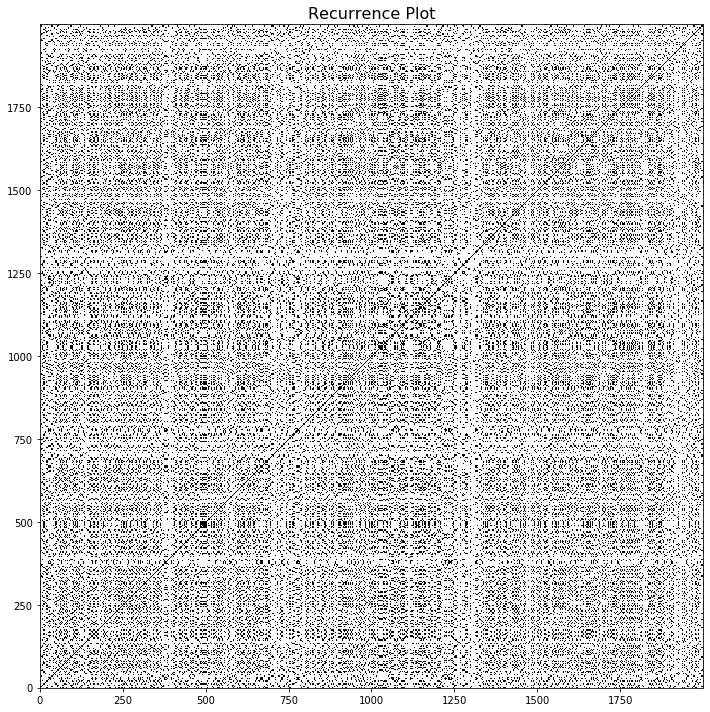

In [89]:
plt.figure(figsize=(10, 10))
plt.imshow(data_rp[20], cmap='binary', origin='lower')
plt.title('Recurrence Plot', fontsize=16)
plt.tight_layout()
plt.show()

Looks stochastic to me dudes

# 4. Gramian Angular Field
Basically a coordinate transform. A [little more](https://www.aaai.org/ocs/index.php/WS/AAAIW15/paper/viewFile/10179/10251) to it than that, but ok. Easier on the RAM bc it doesn't take that huge comparison matrix.

Setup to look over the trials after changing subject manually above. Not perfect, but helps me keep the process straight.

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from pyts.image import GramianAngularField

In [18]:
for n in range(10,13):
    print('GAF-cmap/s02_t0'+str(n)+'doot')
else:
    print('Final x = %d' % (n))
# LOOK AT ME LEARNING

GAF-cmap/s02_t010doot
GAF-cmap/s02_t011doot
GAF-cmap/s02_t012doot
Final x = 12


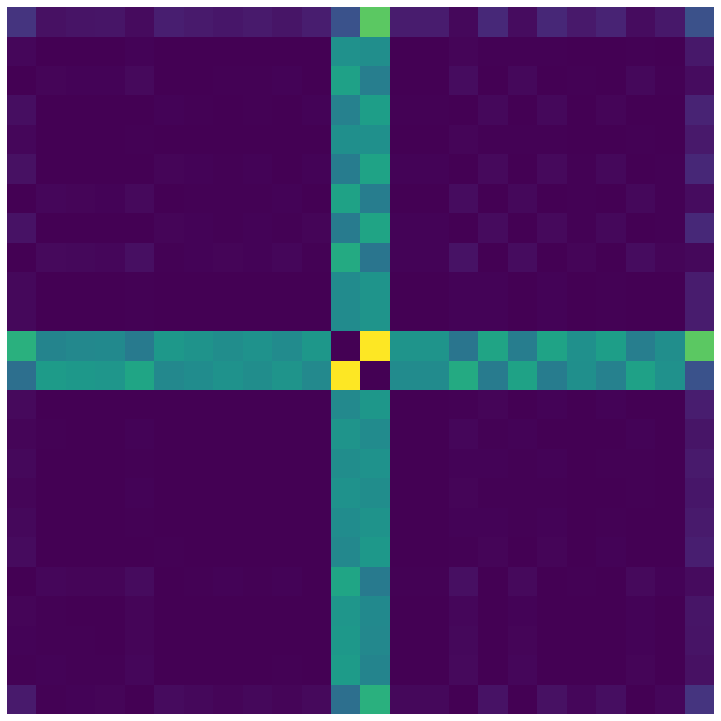

In [14]:
data_one_trial=data[n,:,:]
# Transform the time series into Gramian Angular Fields
gasf = GramianAngularField(image_size=24, method='summation')
X_gasf = gasf.fit_transform(data_one_trial)
#gadf = GramianAngularField(image_size=24, method='difference')
#X_gadf = gadf.fit_transform(data_one_trial)


w = 10
h = 10
fig = plt.figure(figsize=(20, 20))
columns = 8
rows = 5



# ax enables access to manipulate each of subplots
ax = []

for i in range(columns*rows):
    img = X_gasf[i]
    # create subplot and append to ax
    ax.append( fig.add_subplot(rows, columns, i+1) )
    #ax[-1].set_title("ax:"+str(i))  # set title
    plt.imshow(img, cmap='viridis', origin='lower') #binary_r
    plt.axis('off')
plt.subplots_adjust(wspace=0, hspace=-.06)
#plt.show()  # finally, render the plot

/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/media/tris/tris_files/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

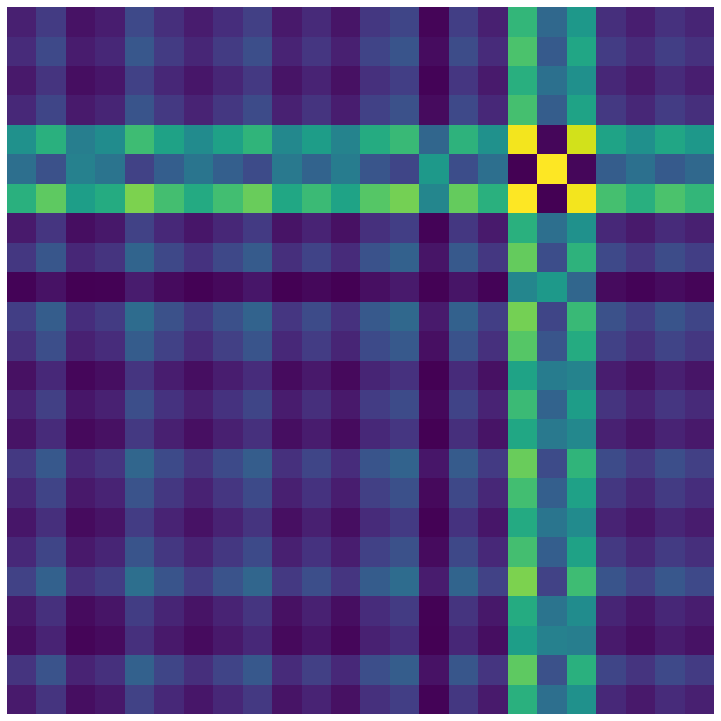

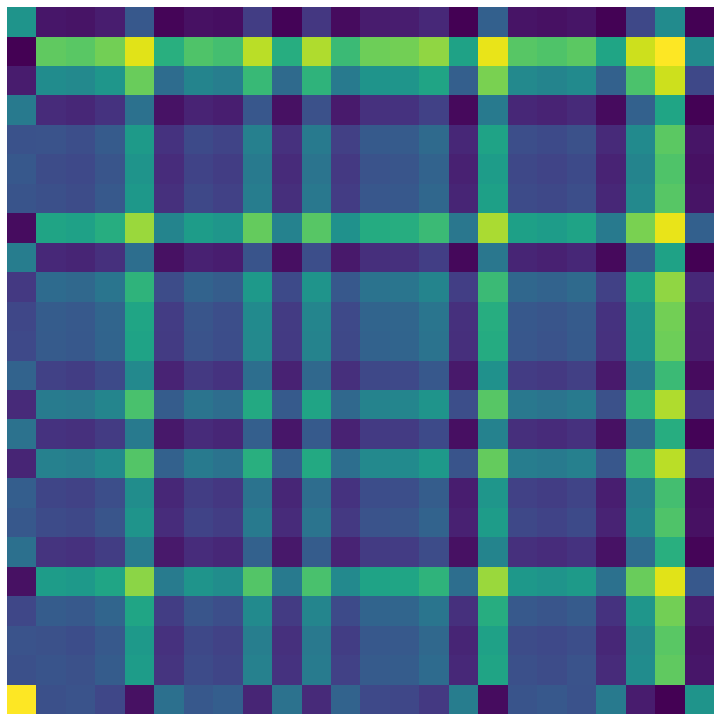

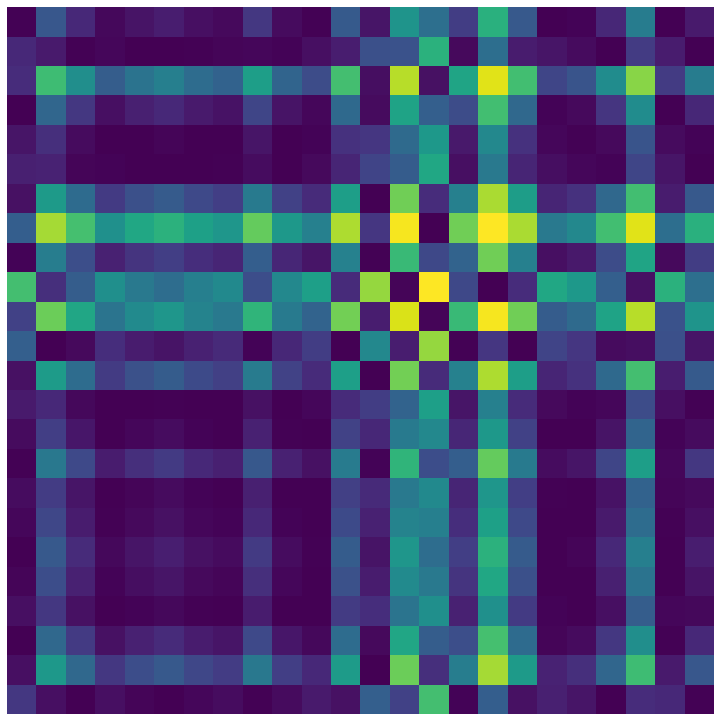

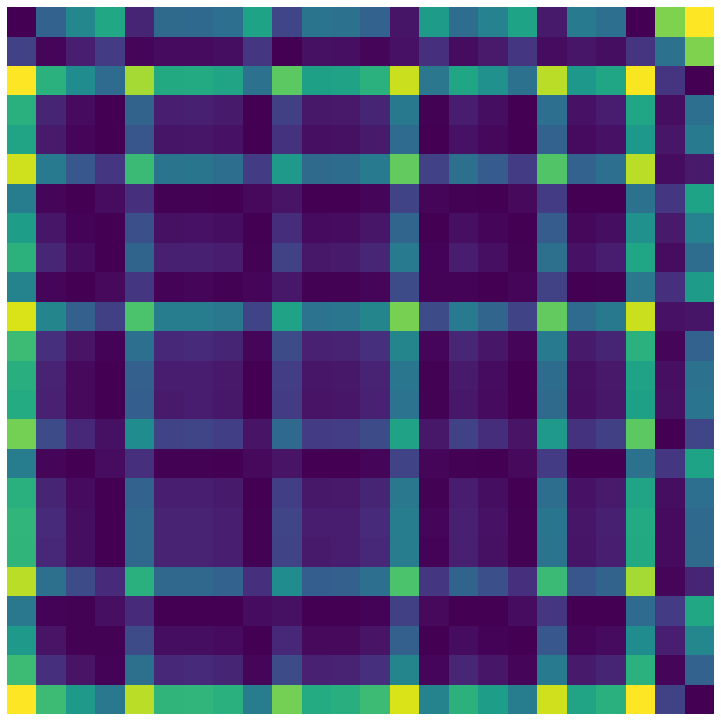

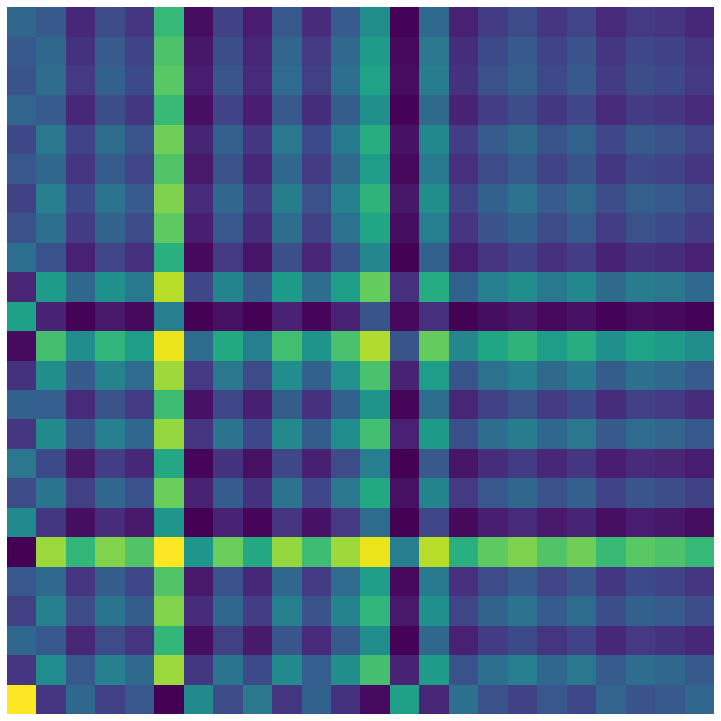

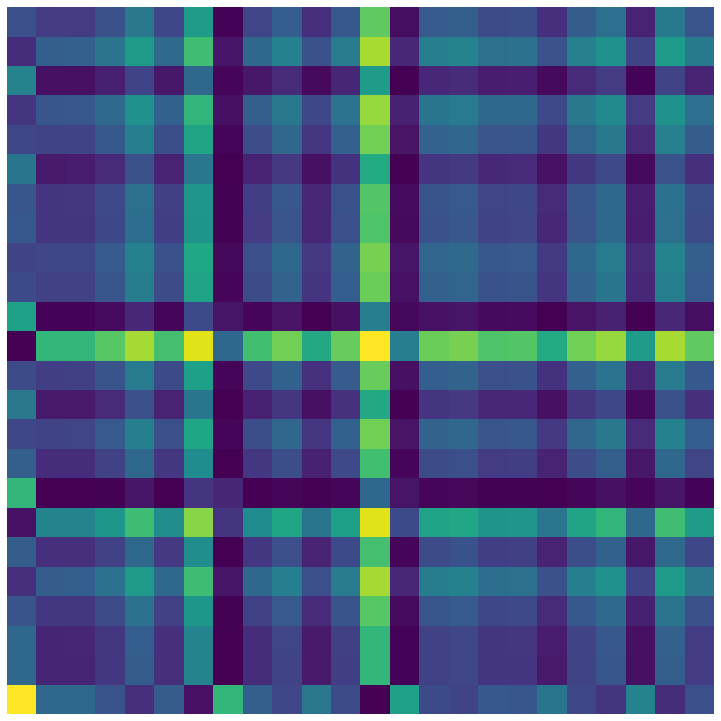

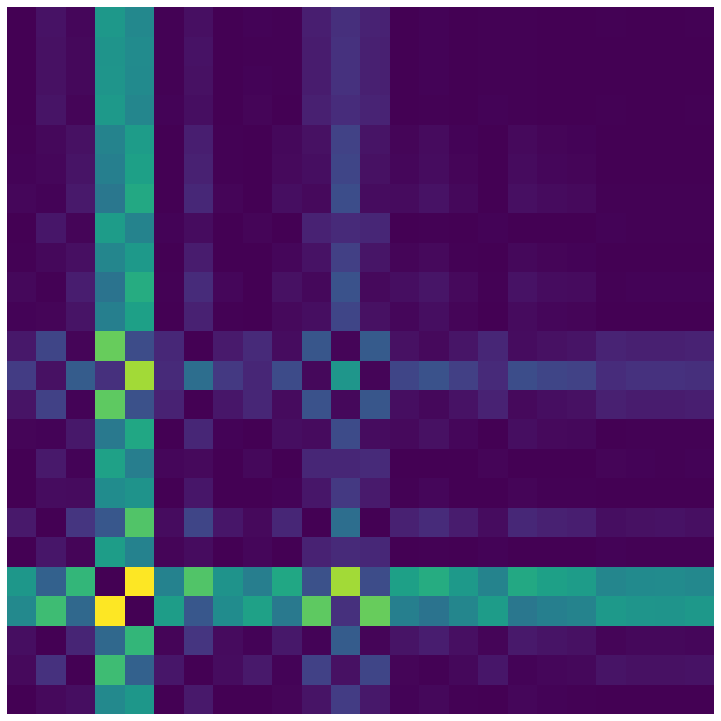

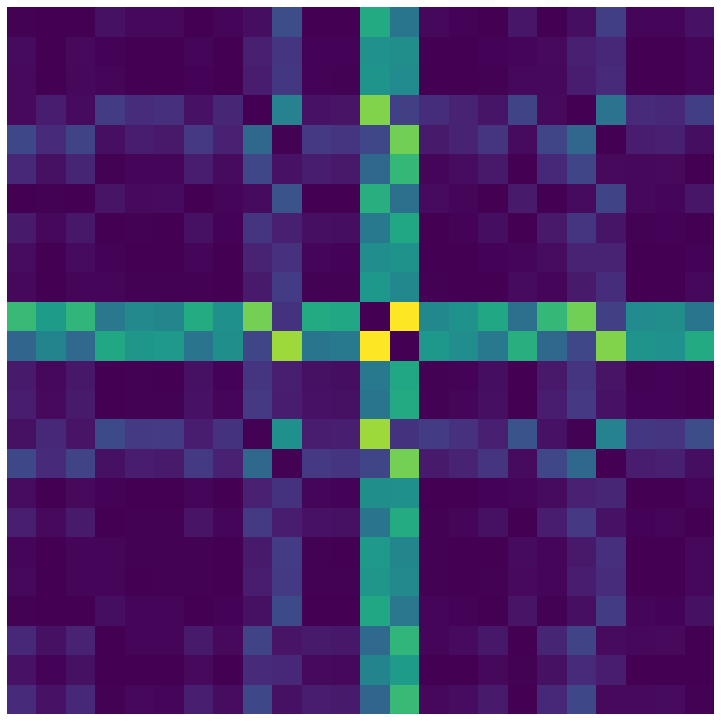

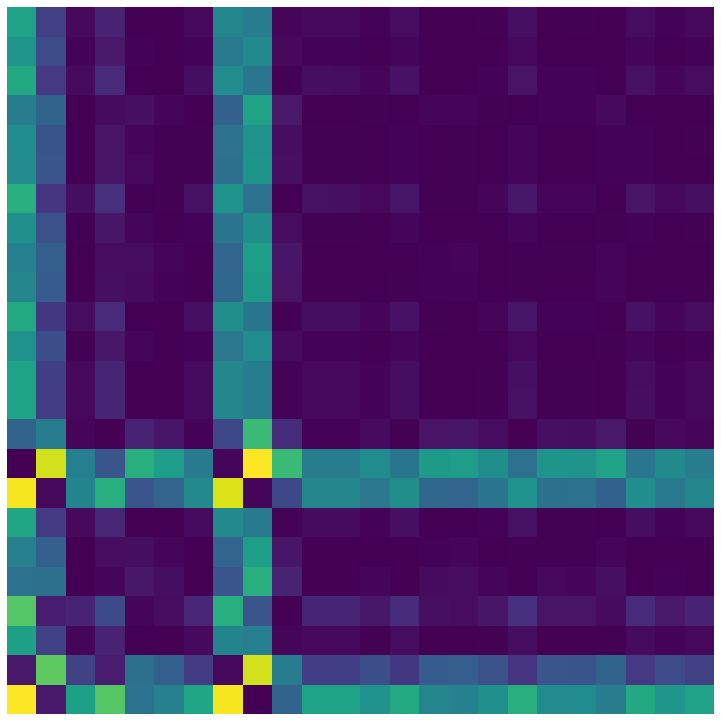

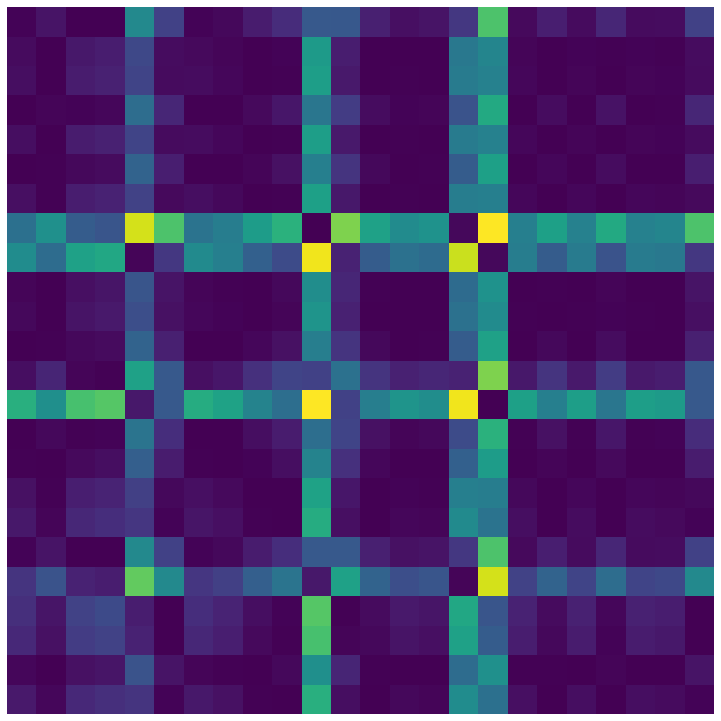

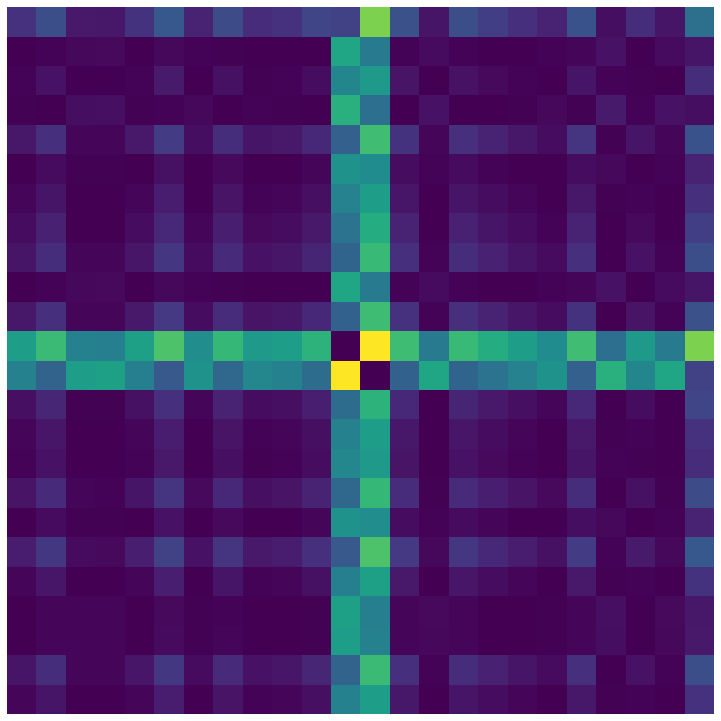

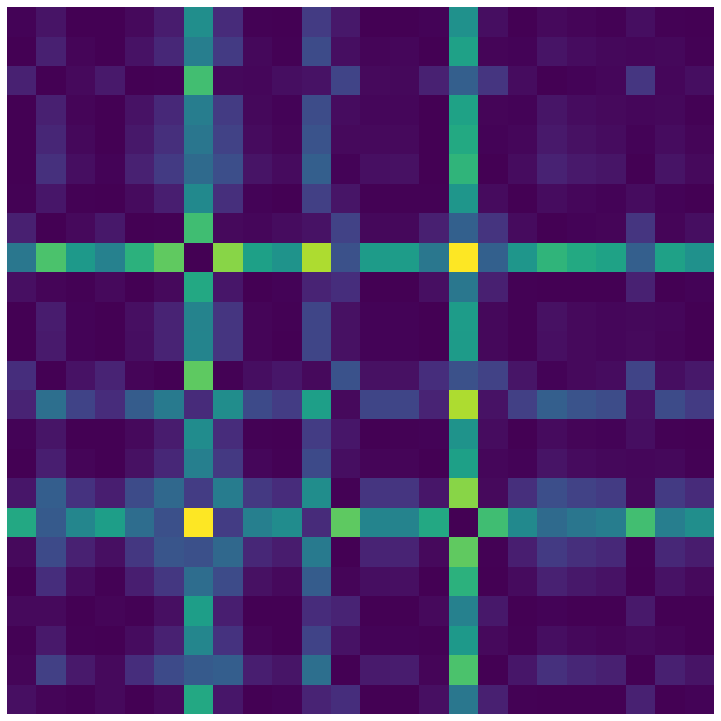

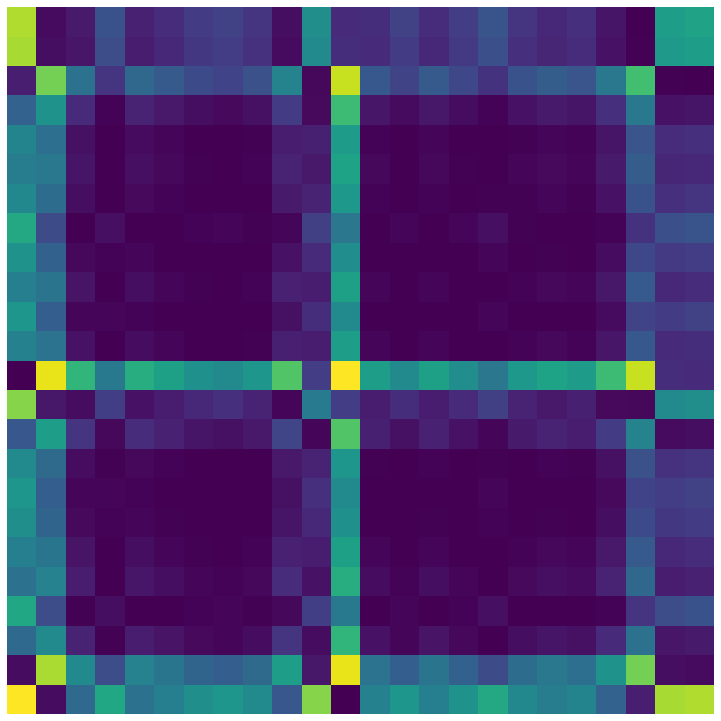

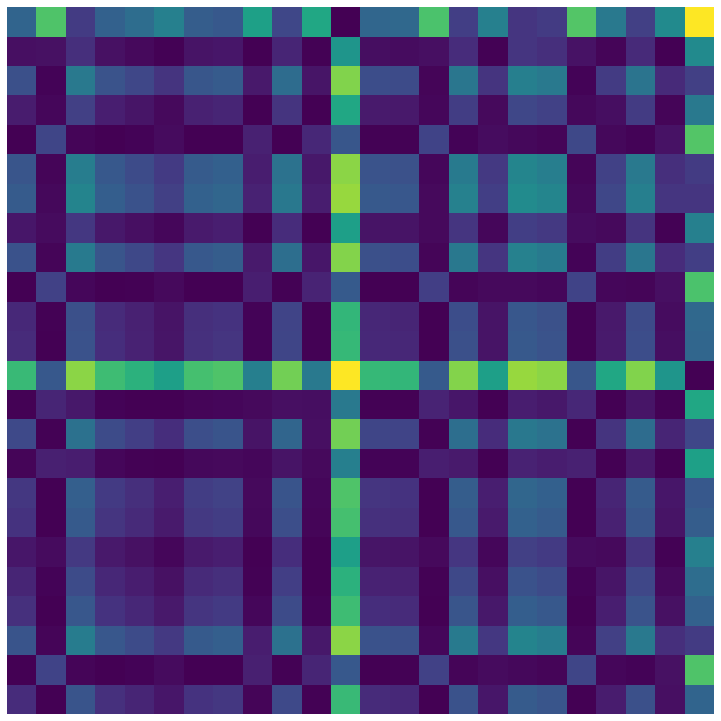

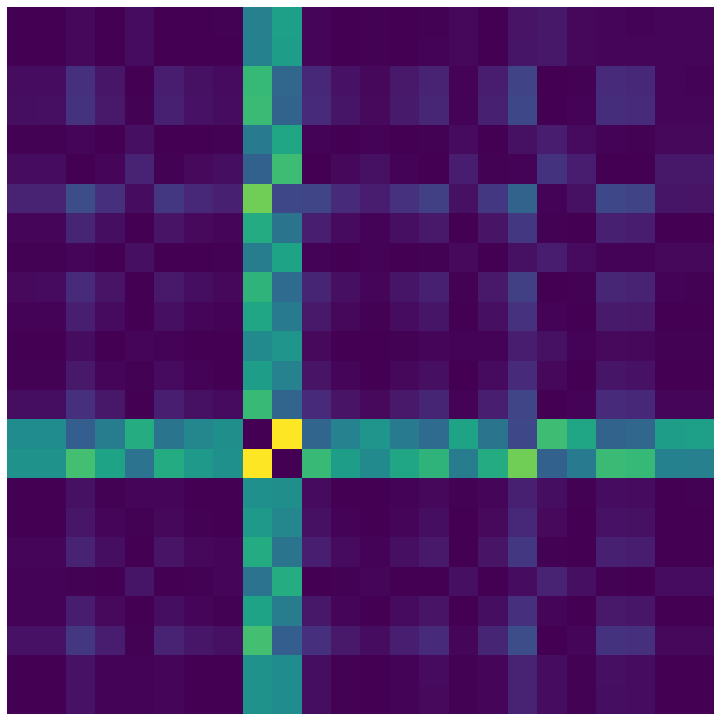

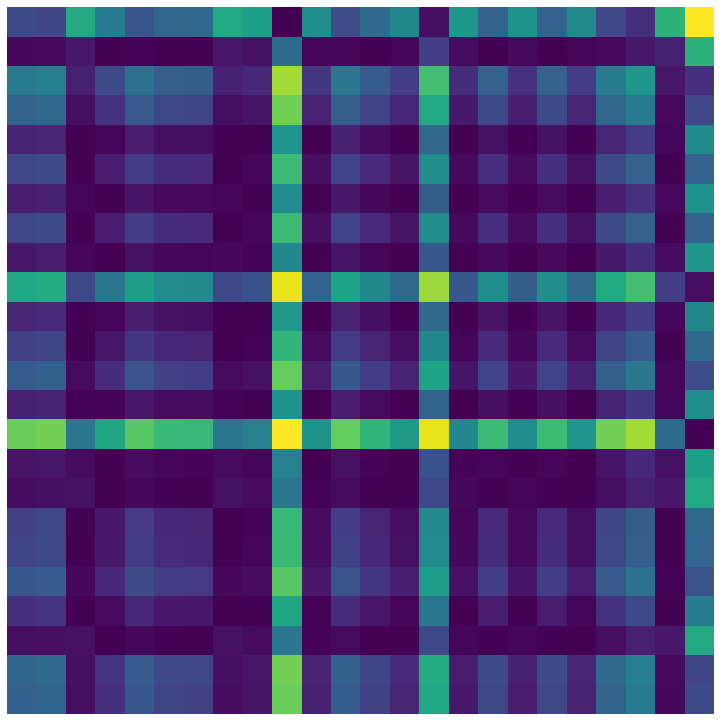

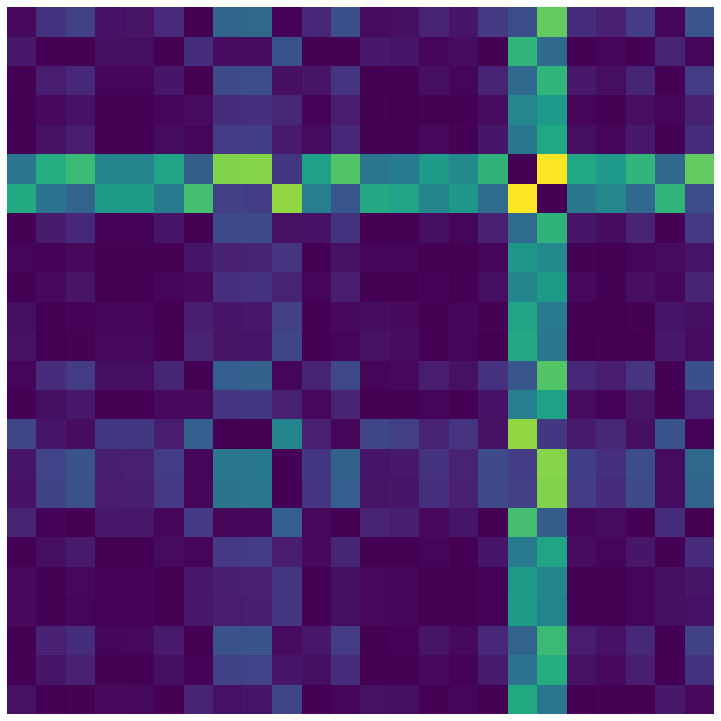

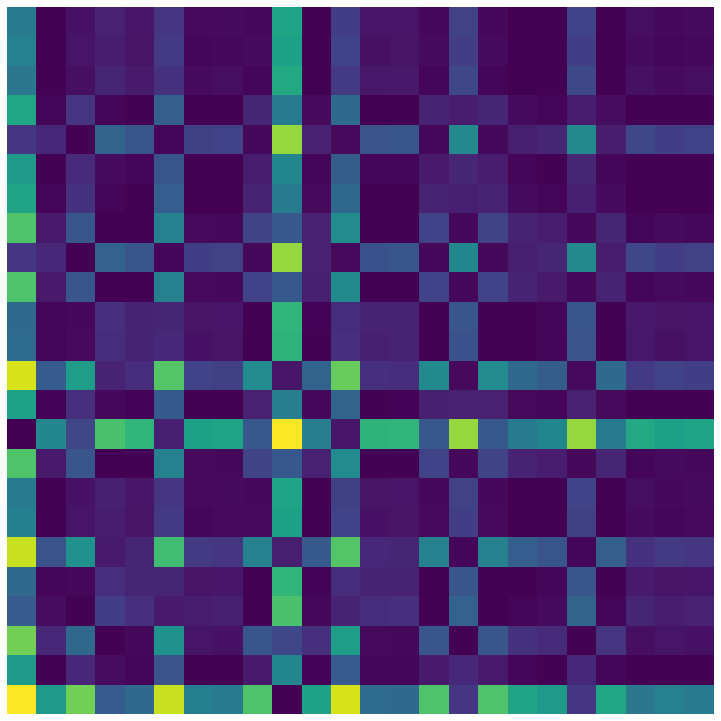

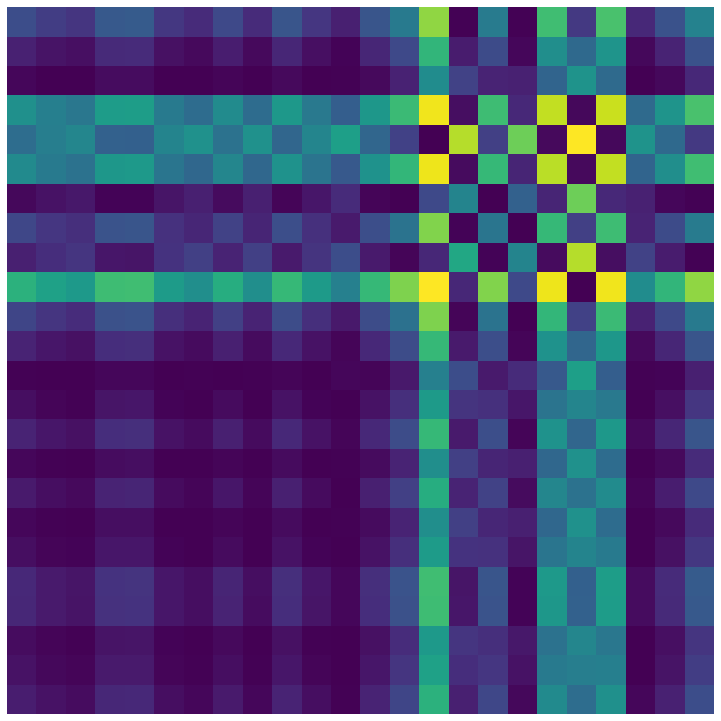

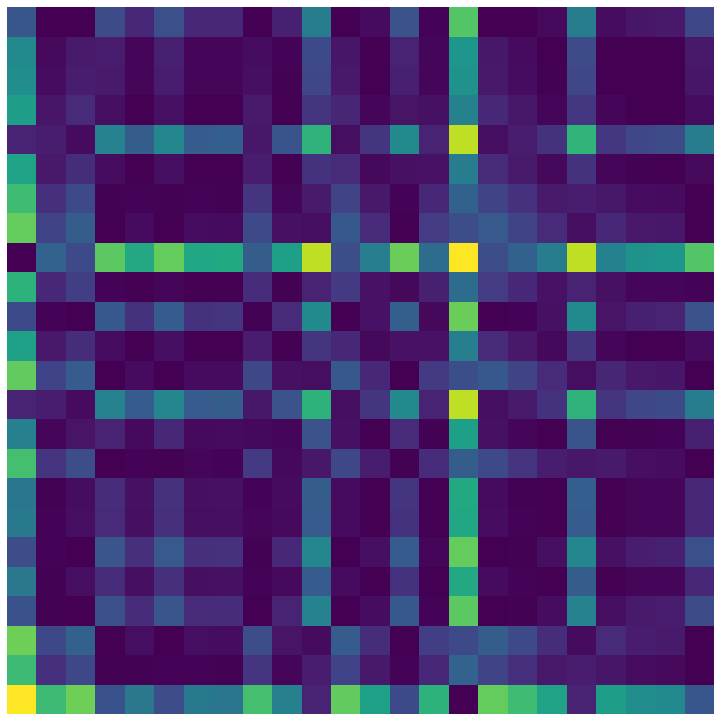

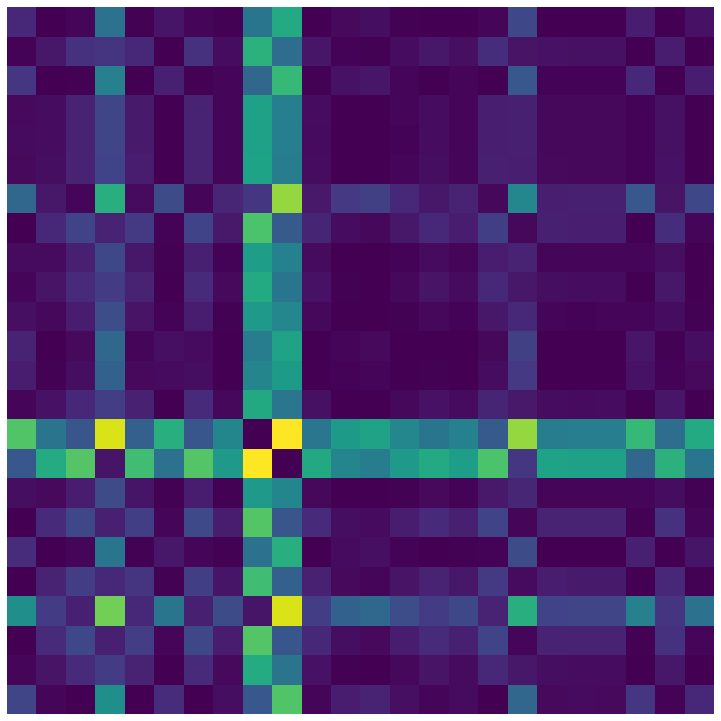

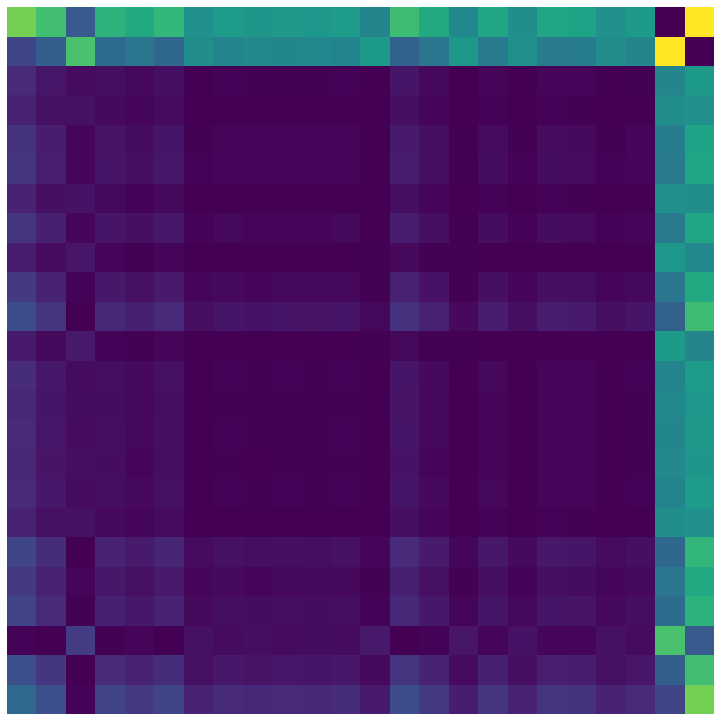

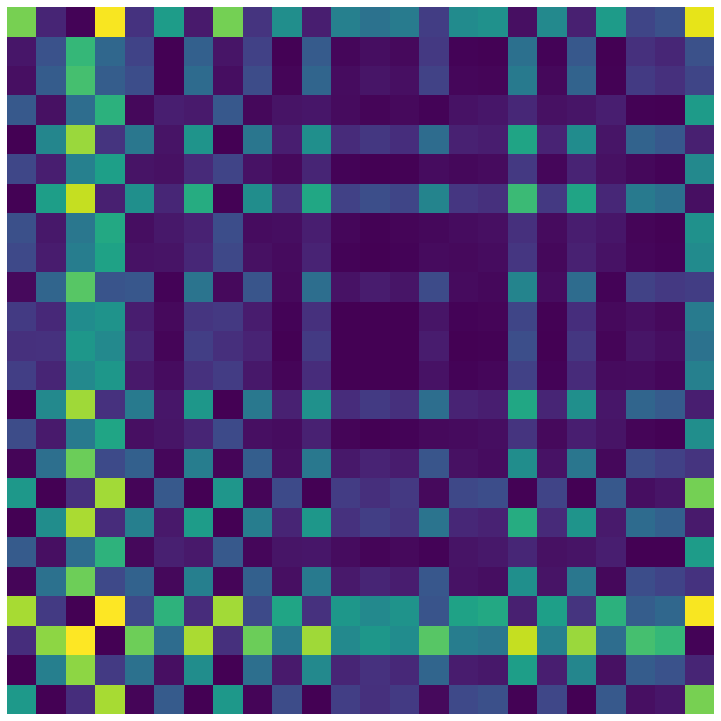

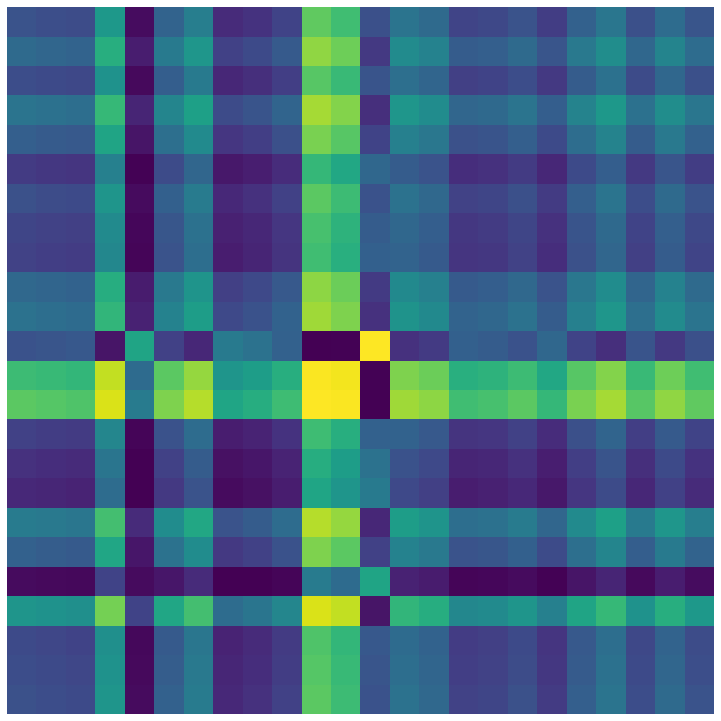

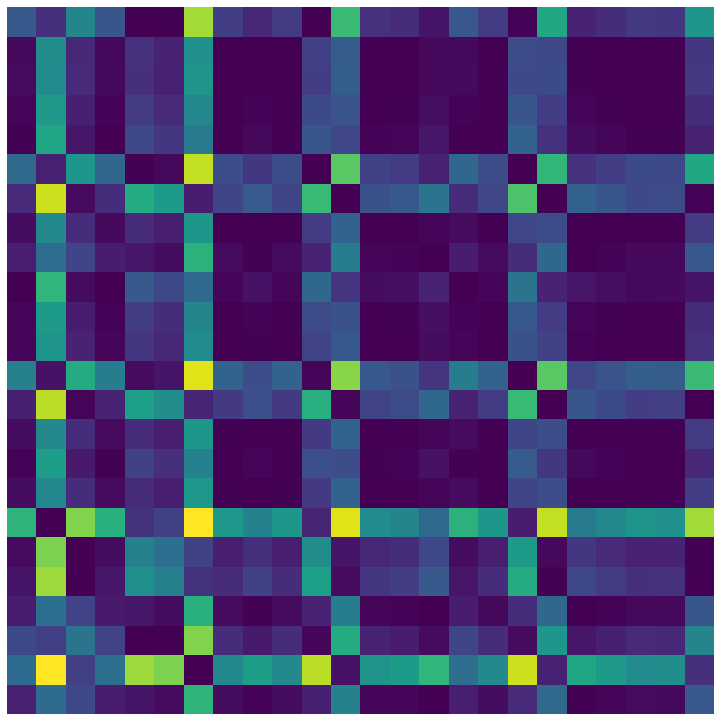

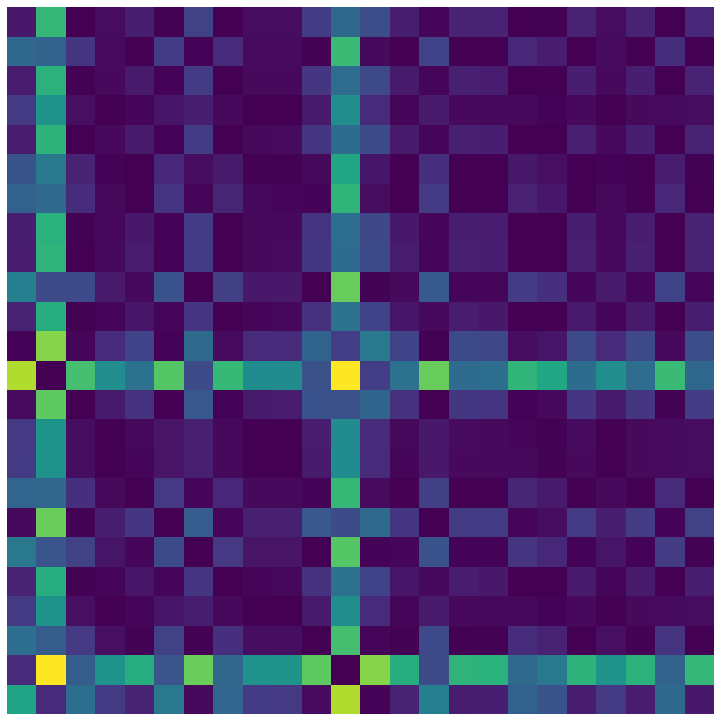

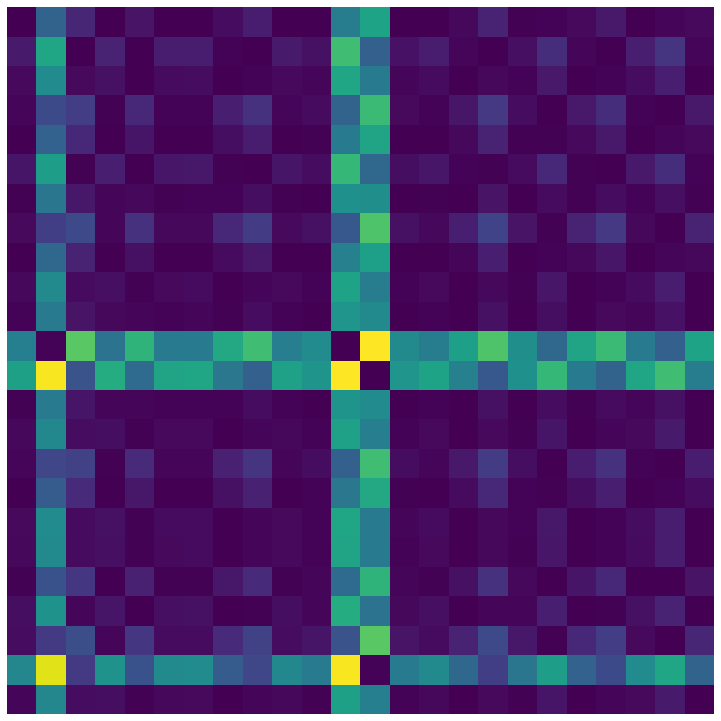

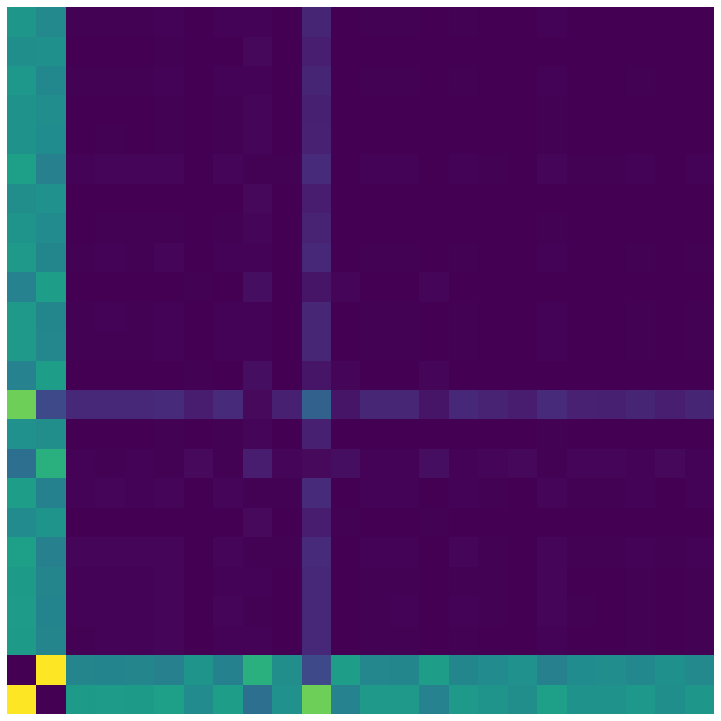

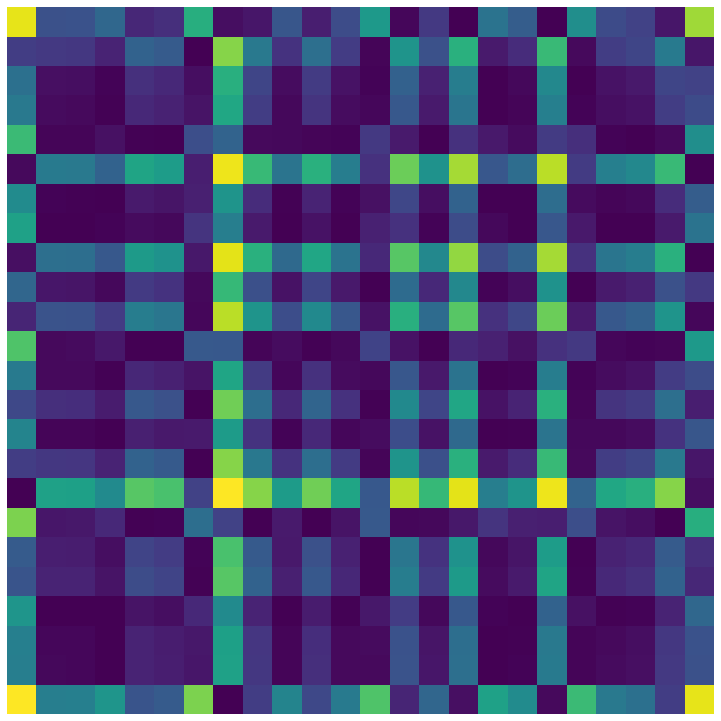

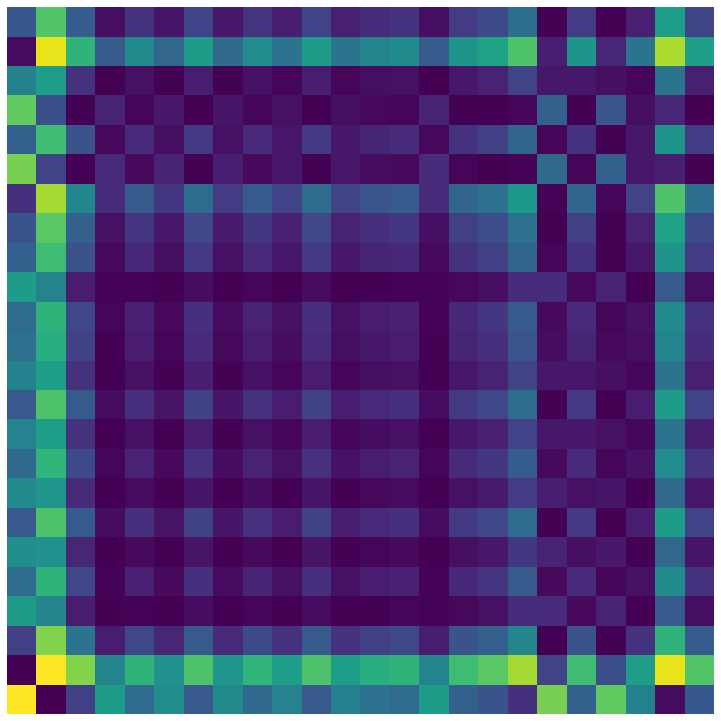

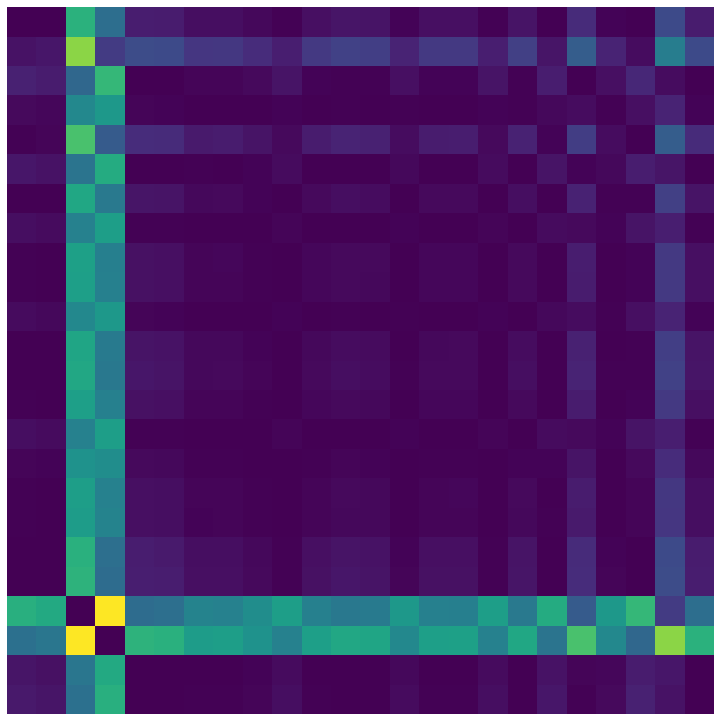

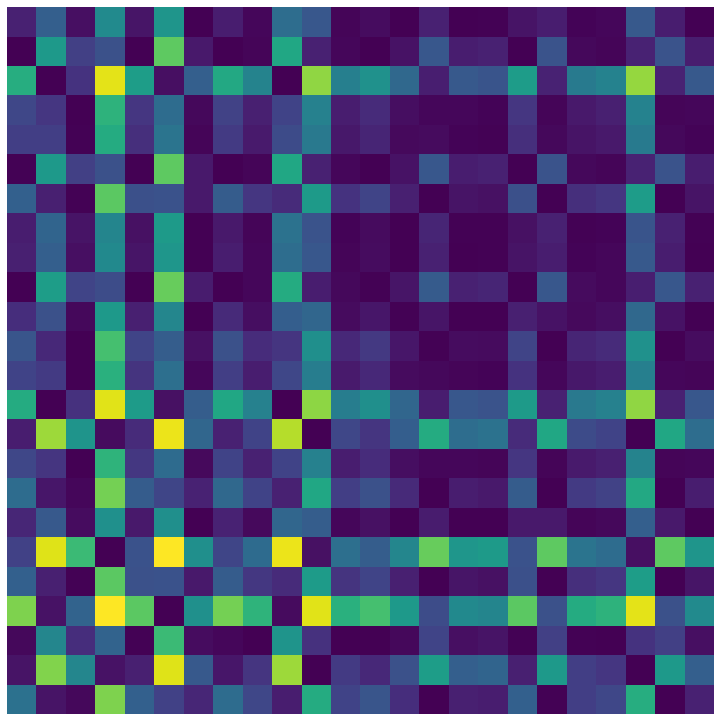

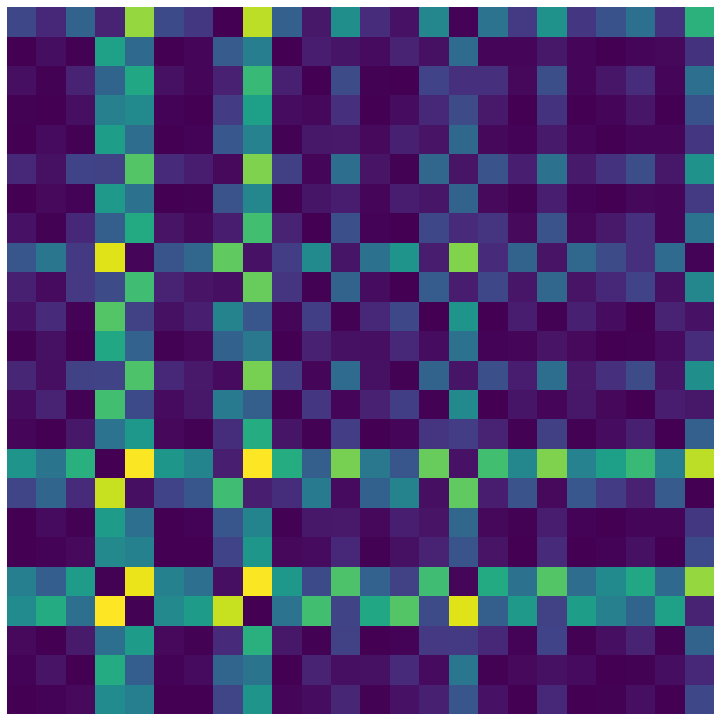

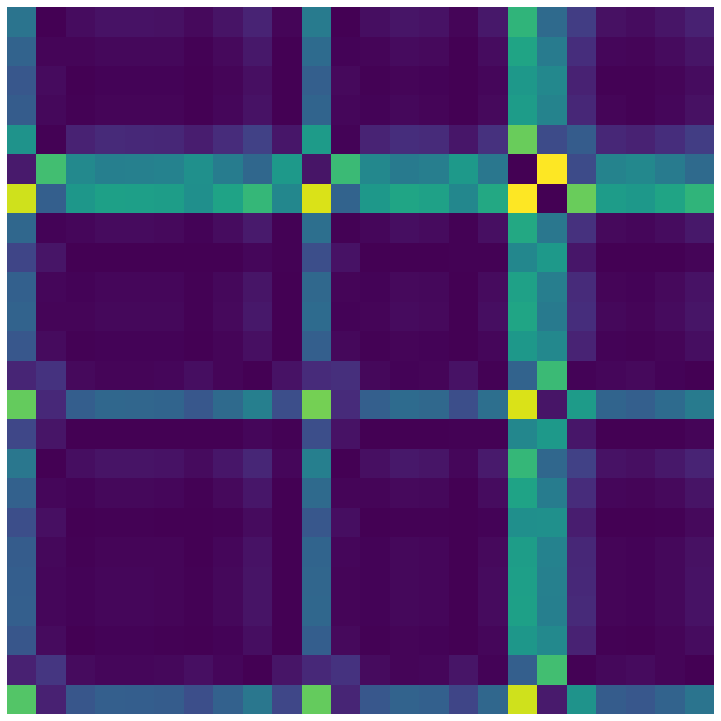

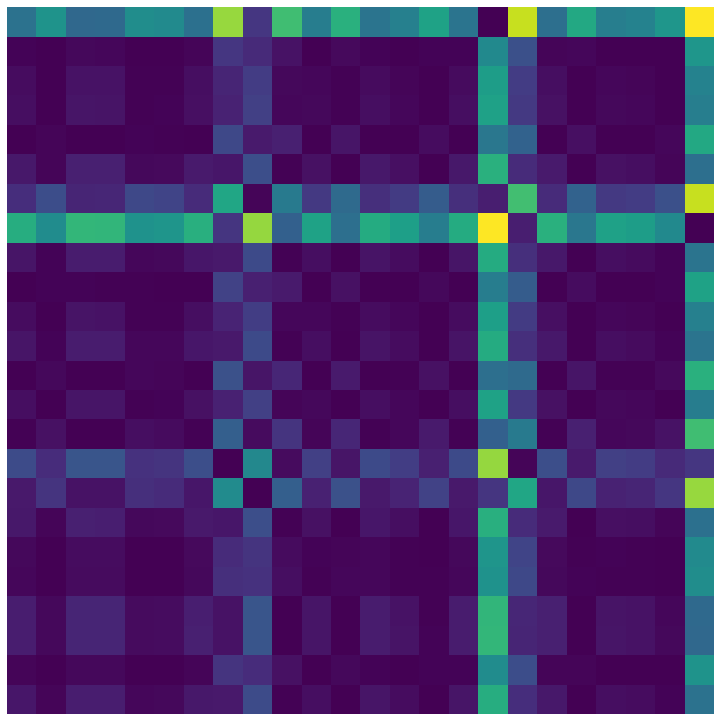

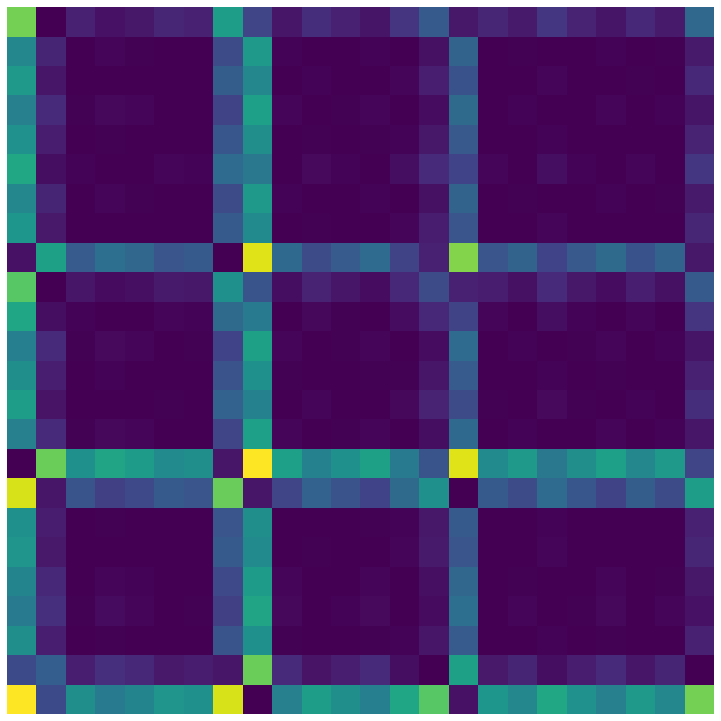

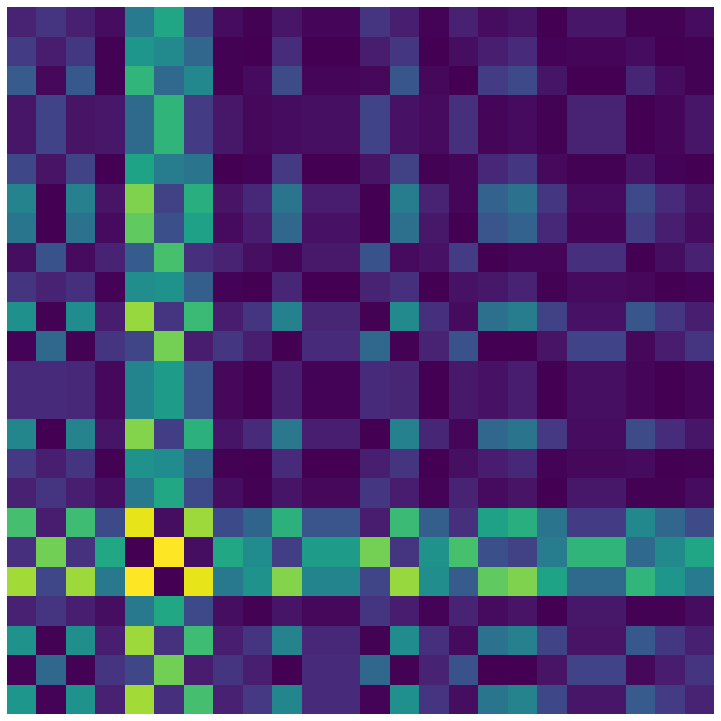

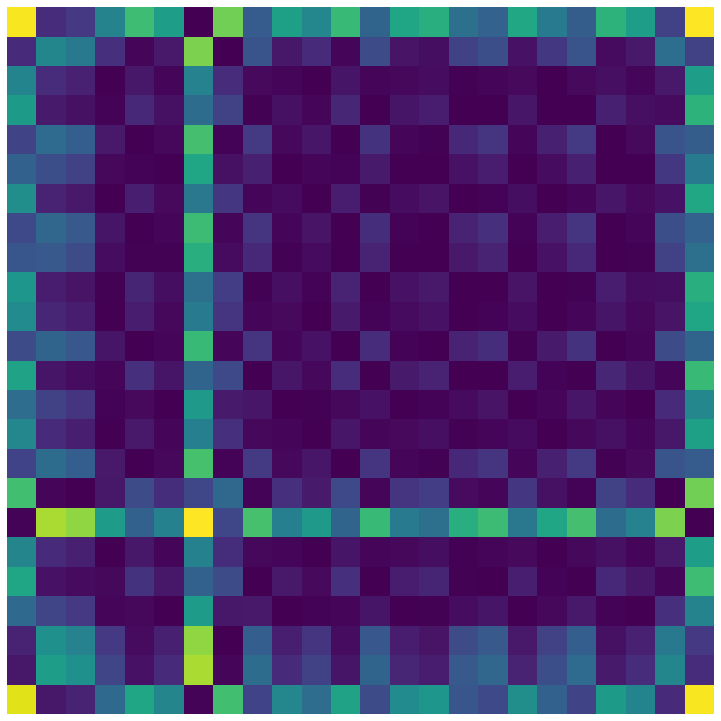

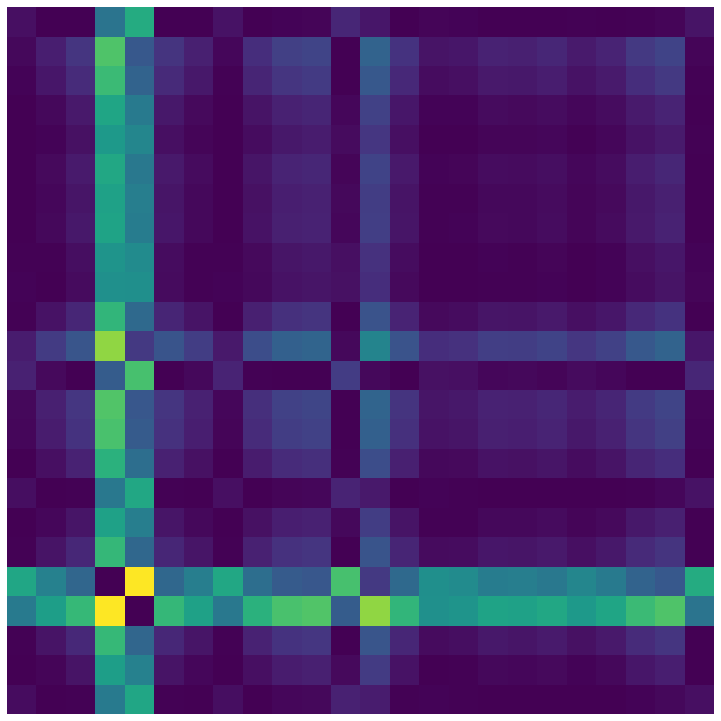

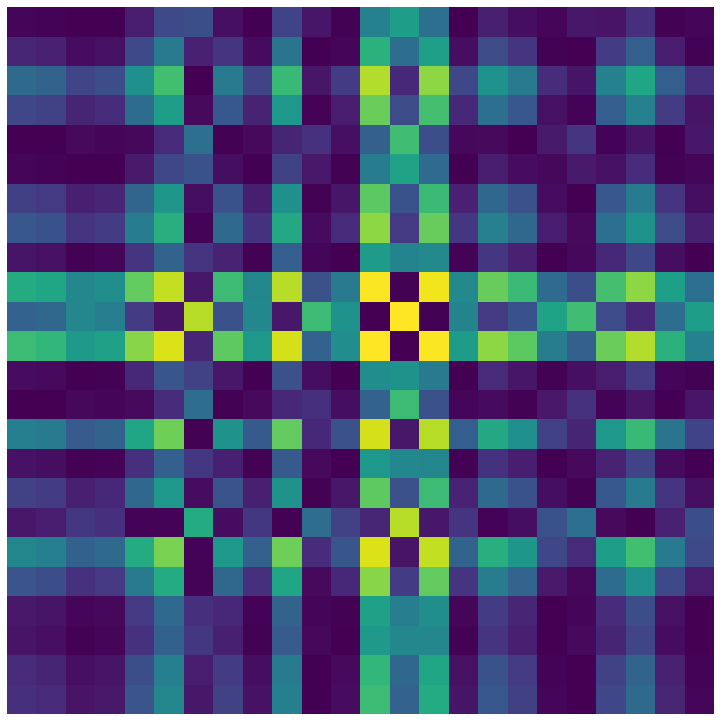

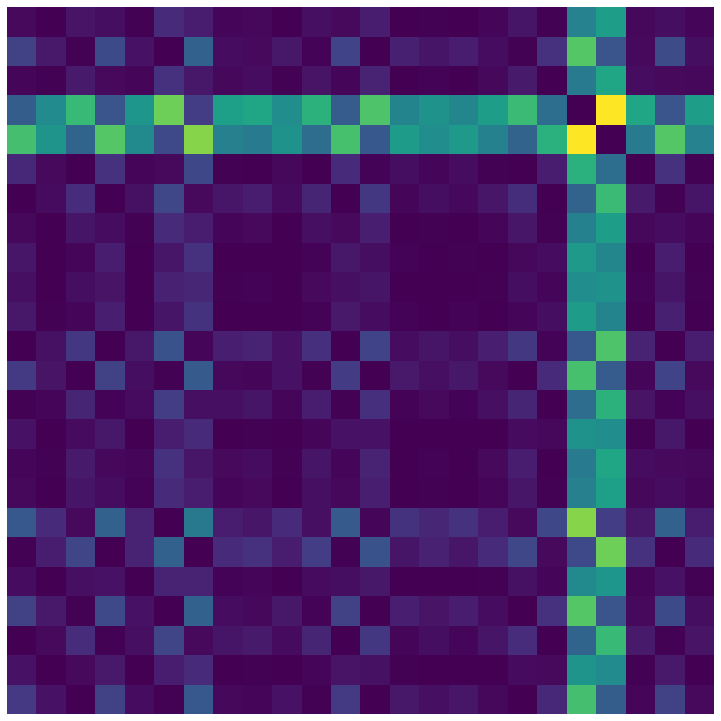

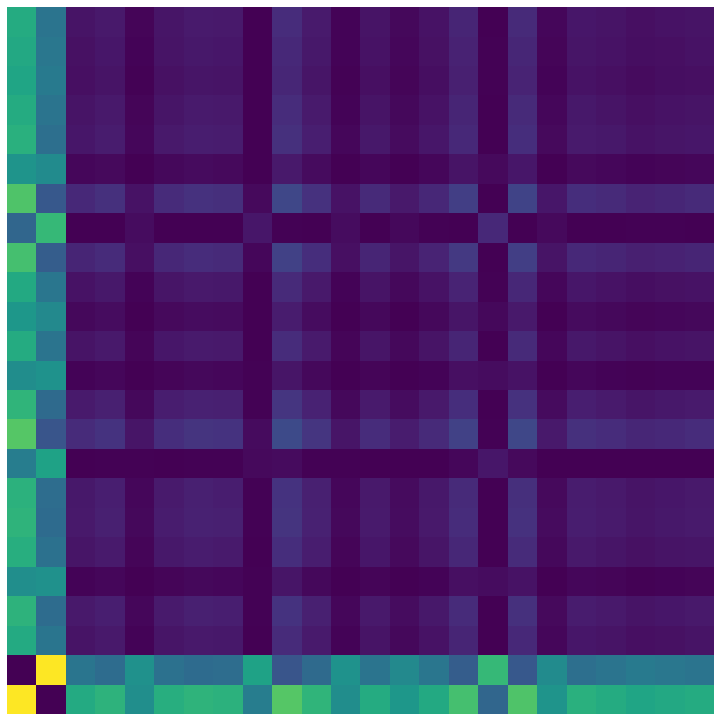

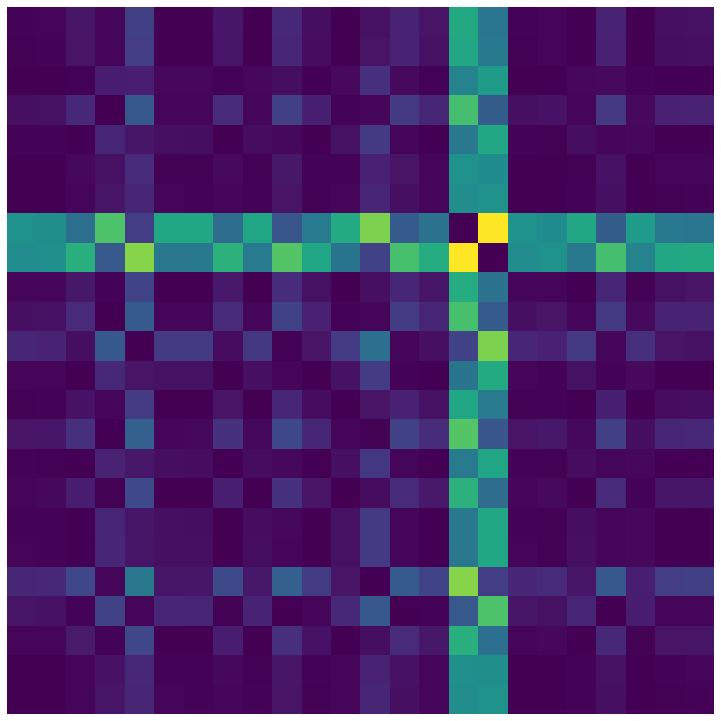

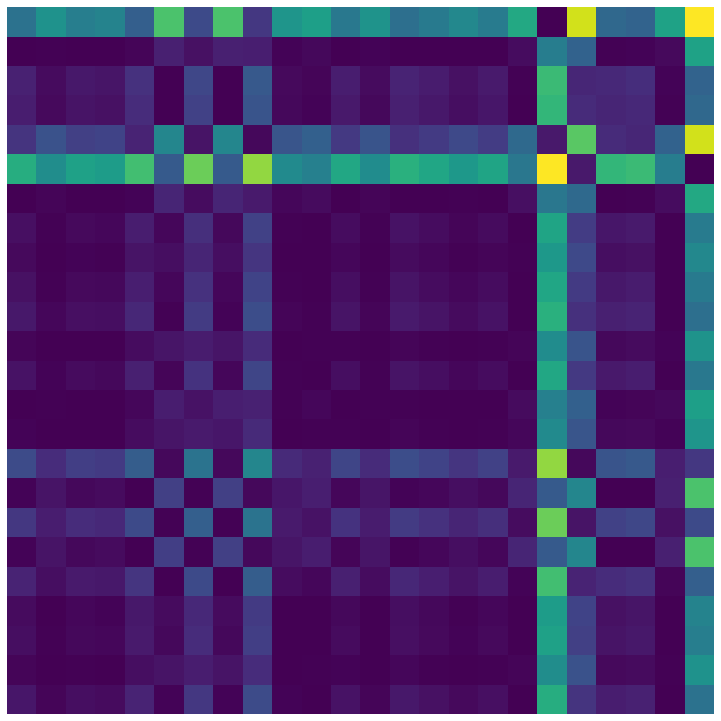

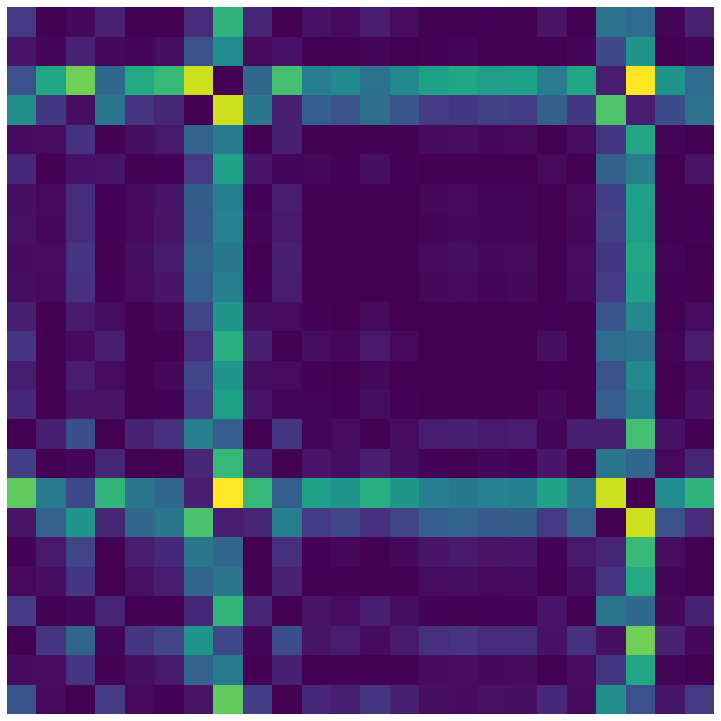

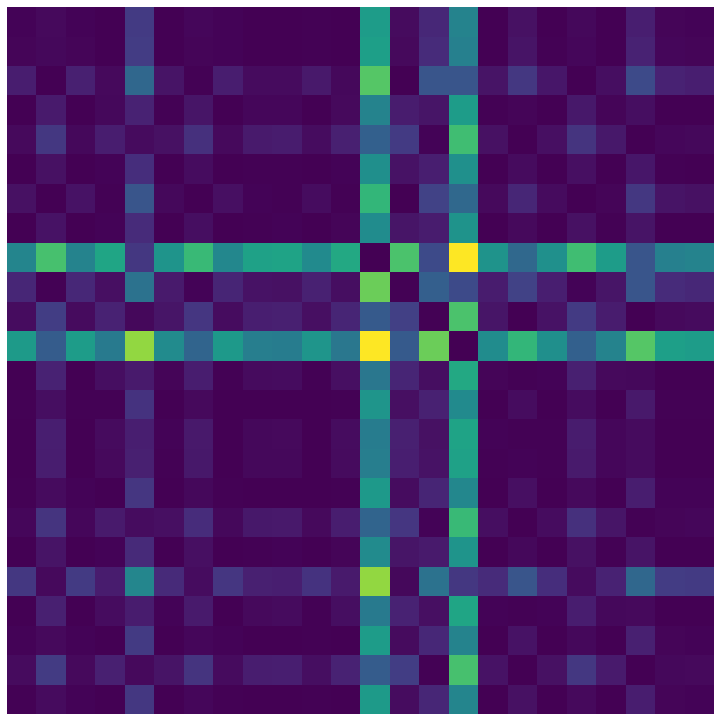

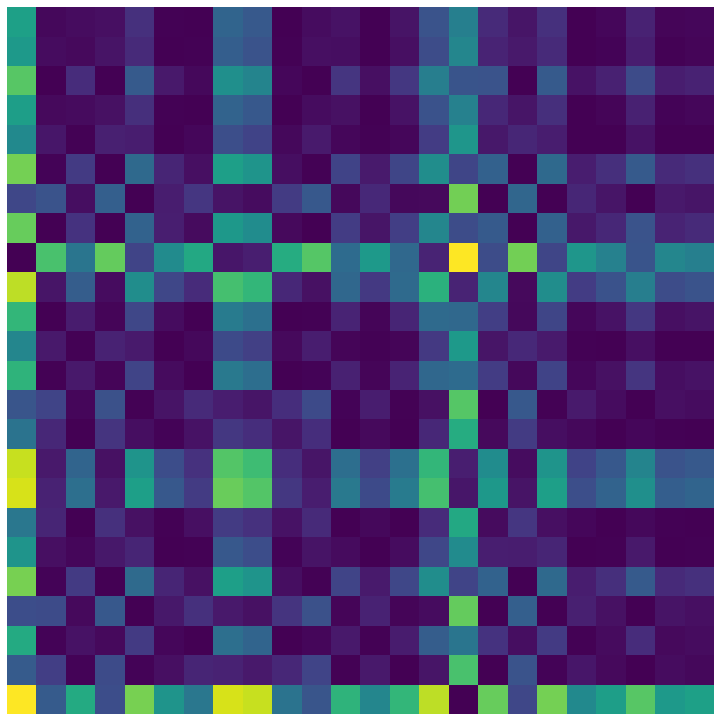

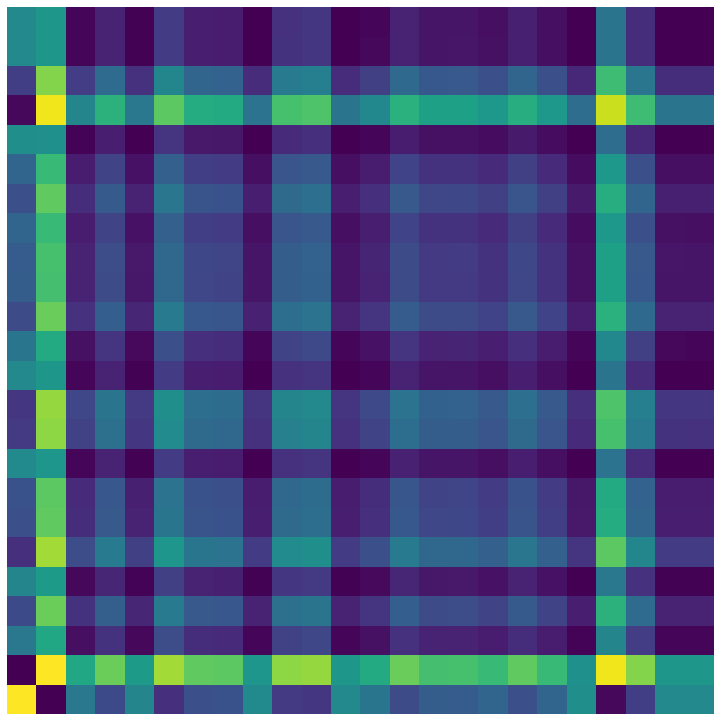

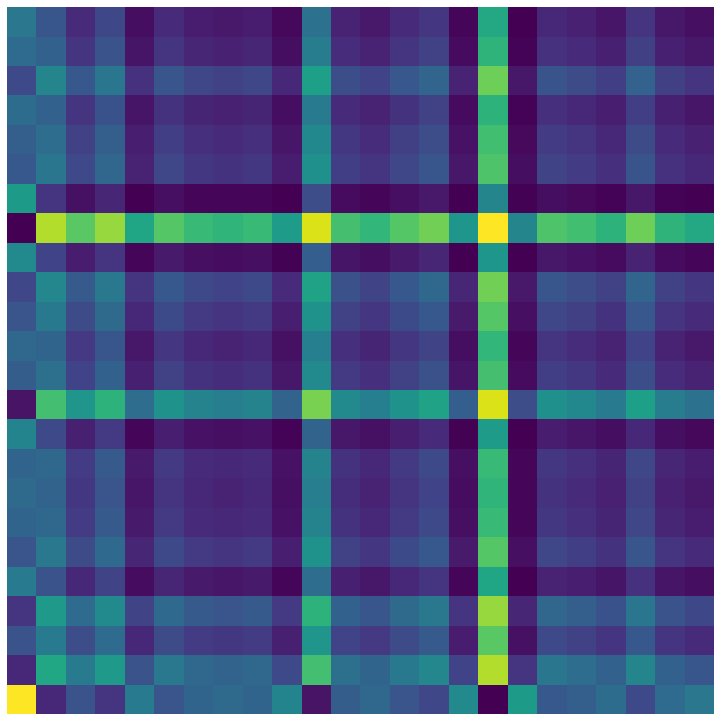

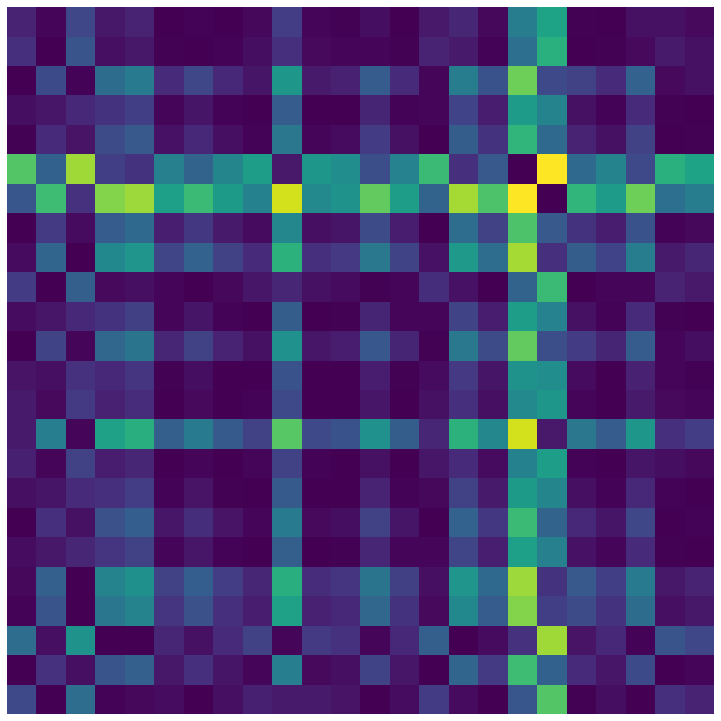

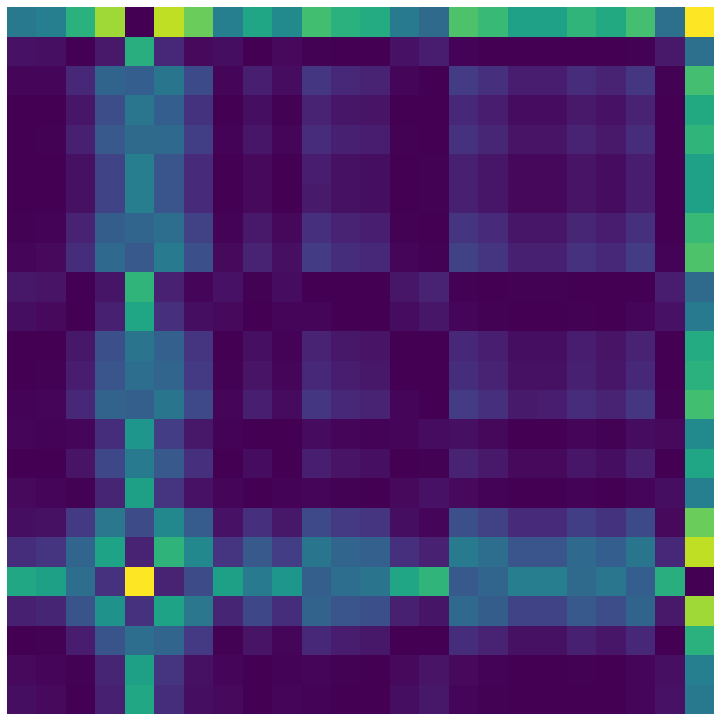

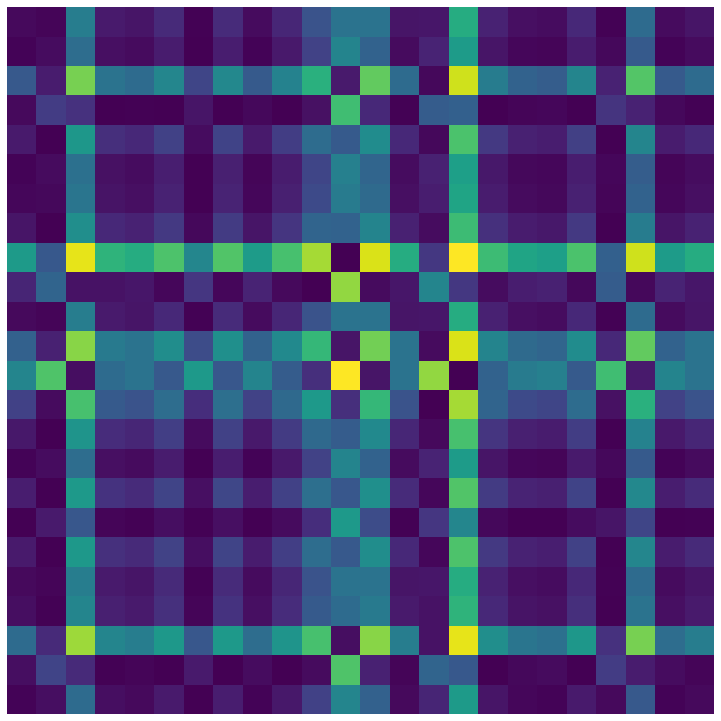

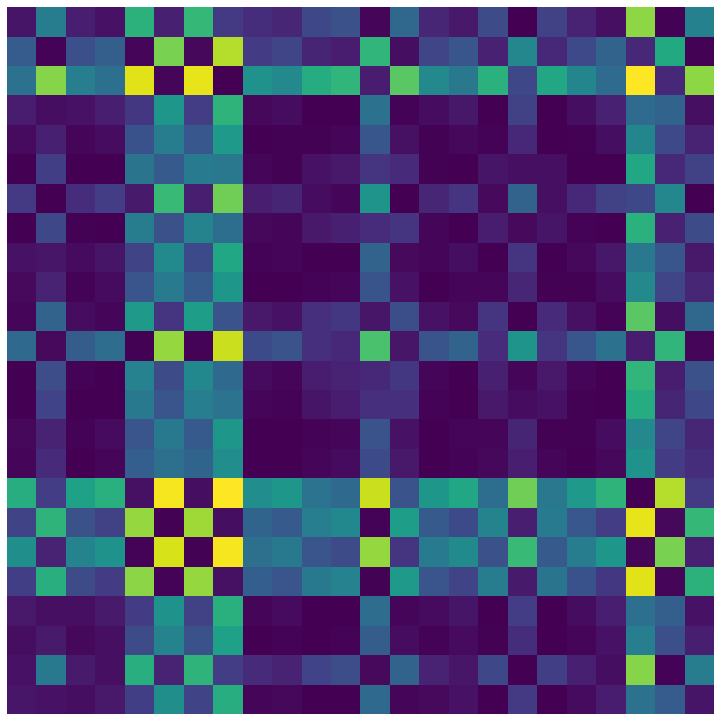

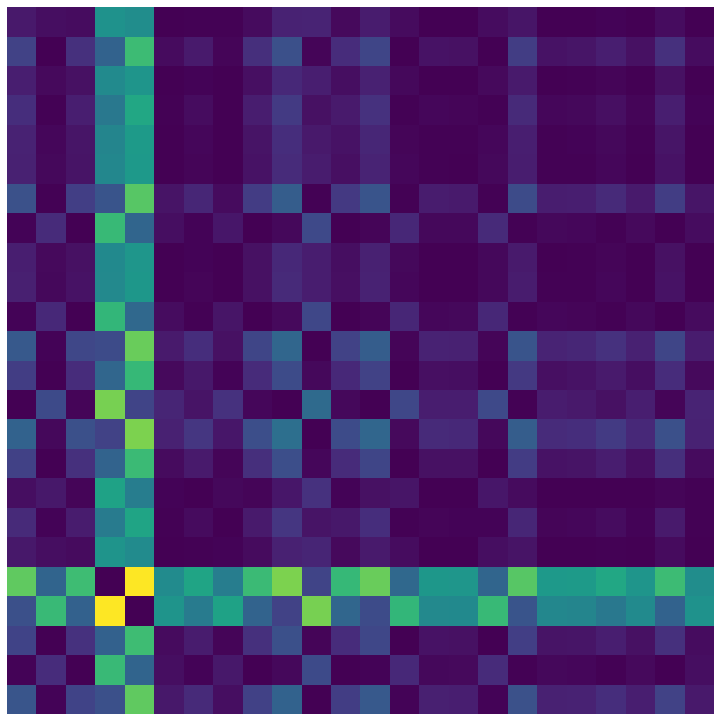

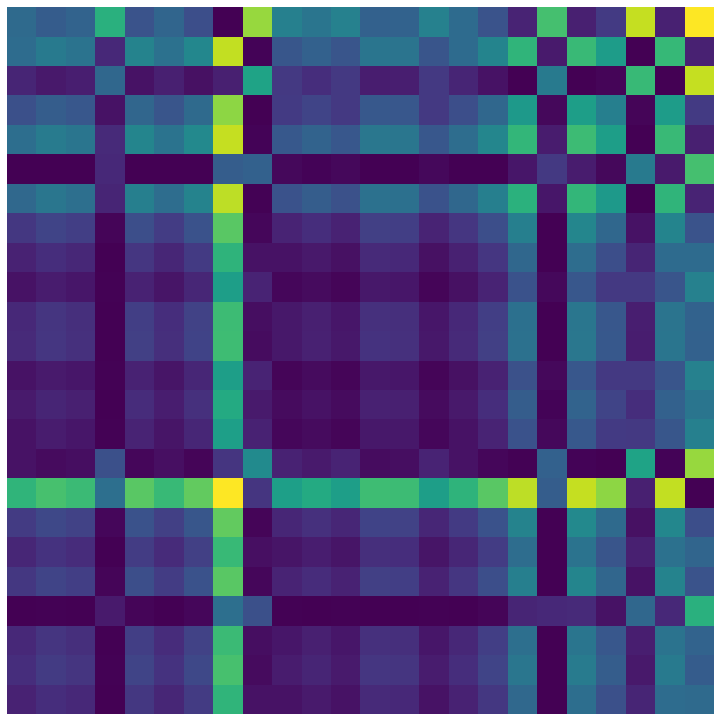

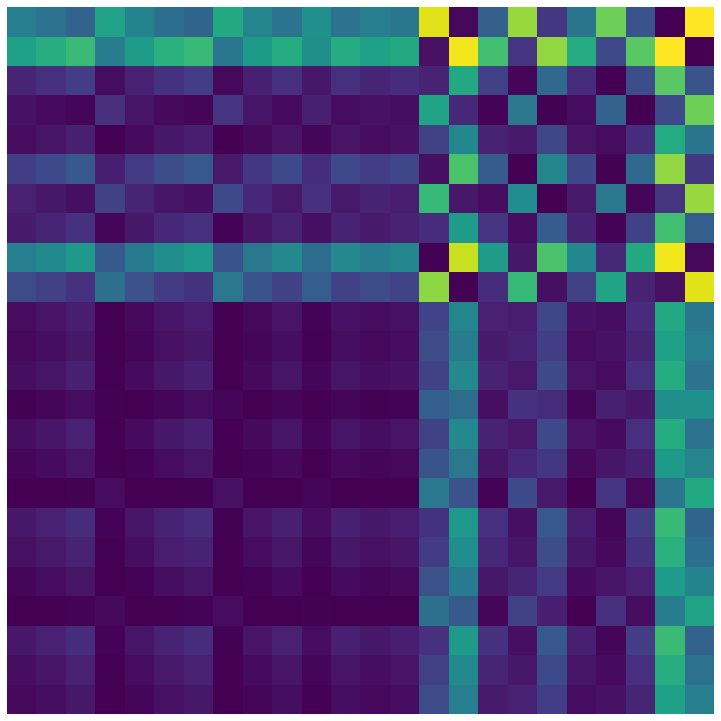

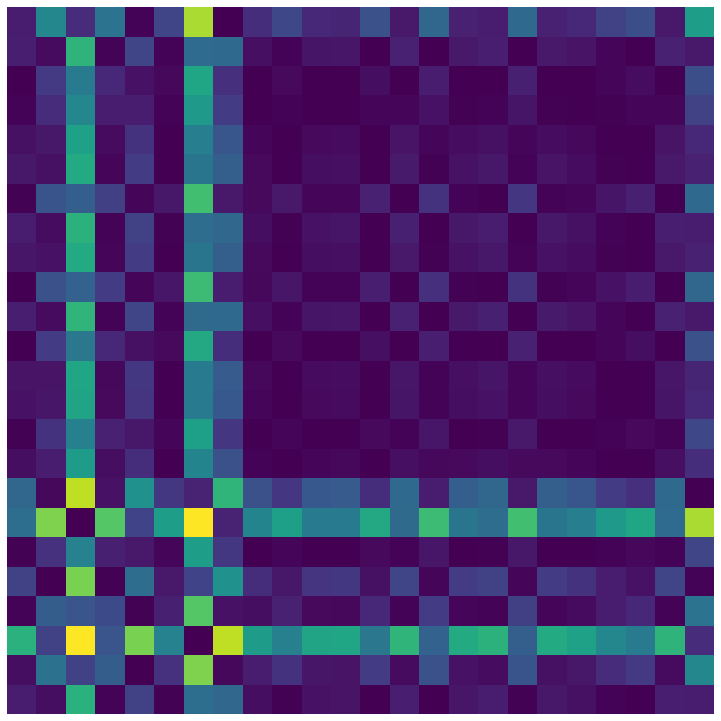

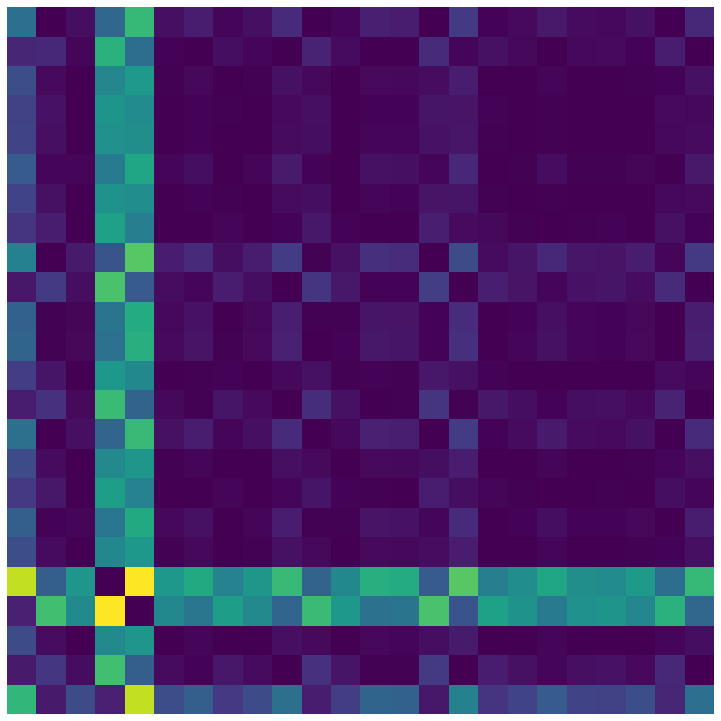

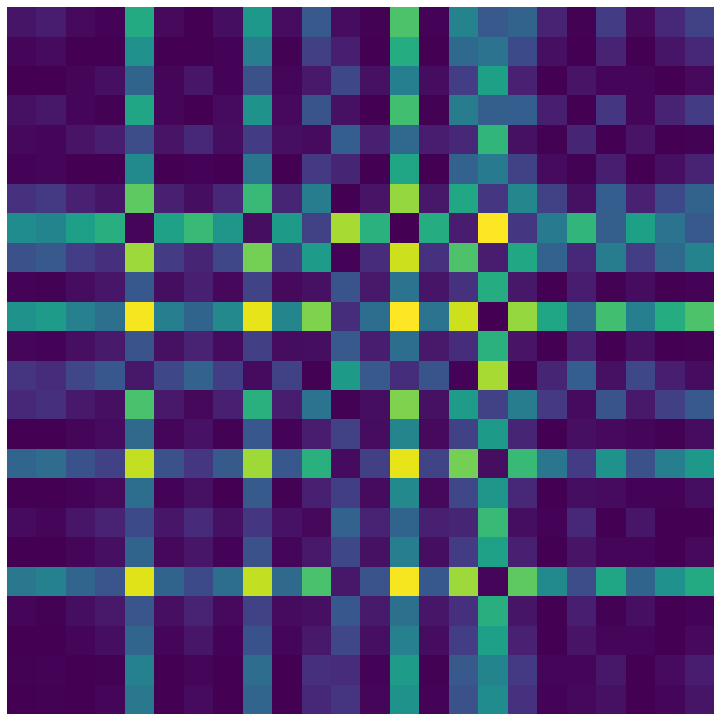

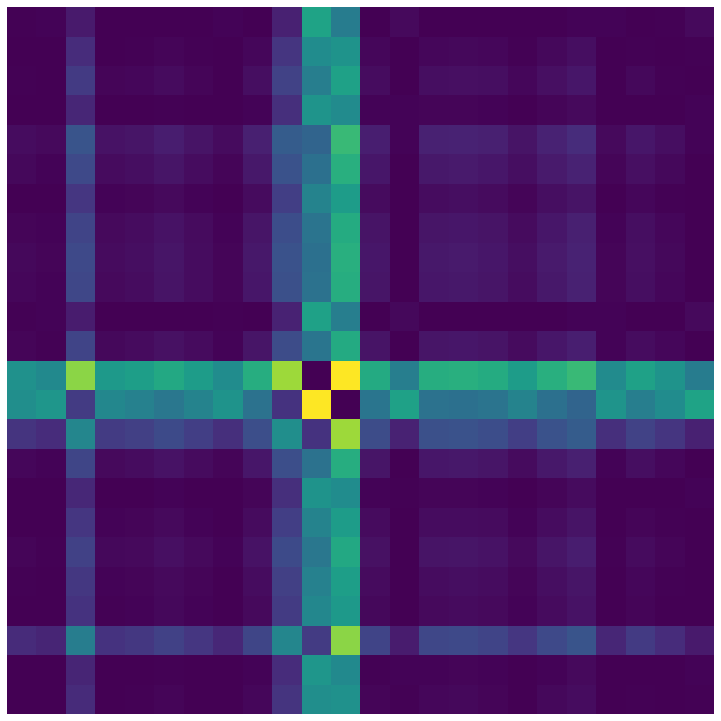

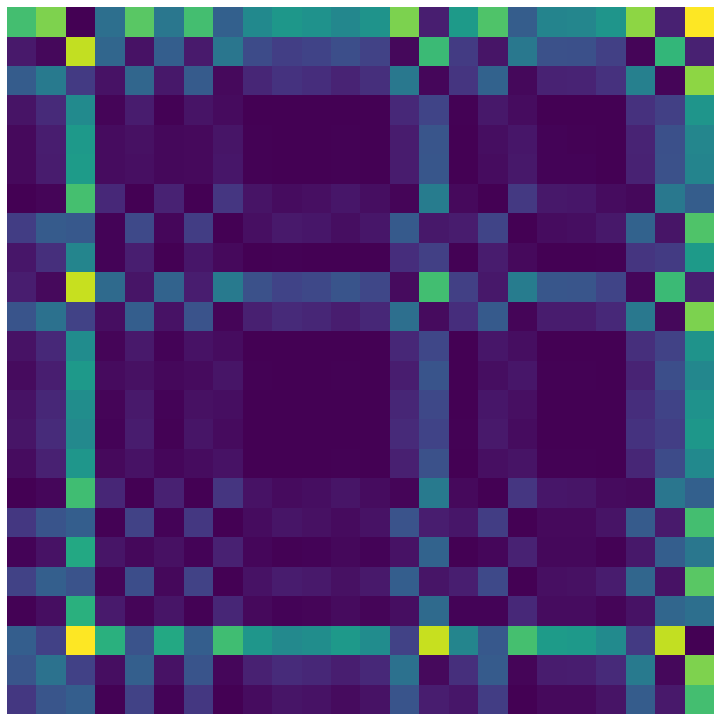

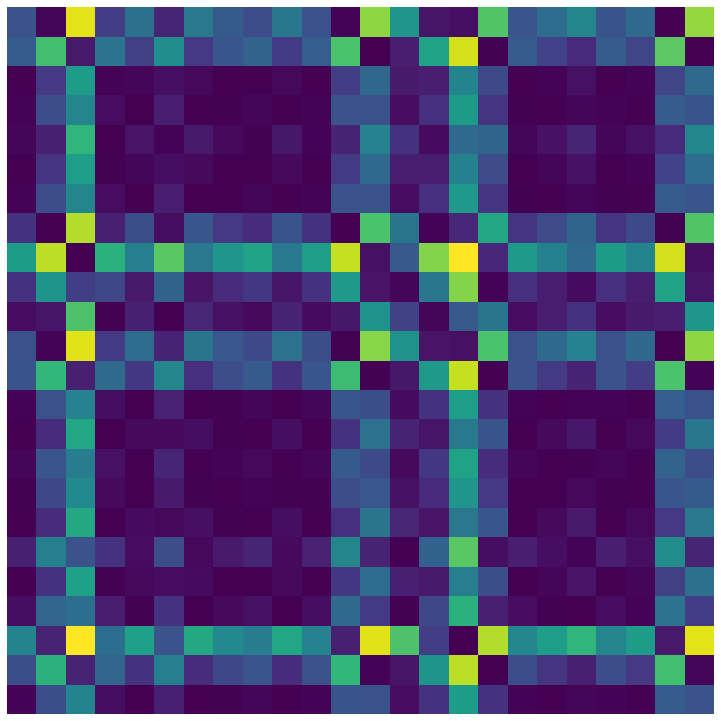

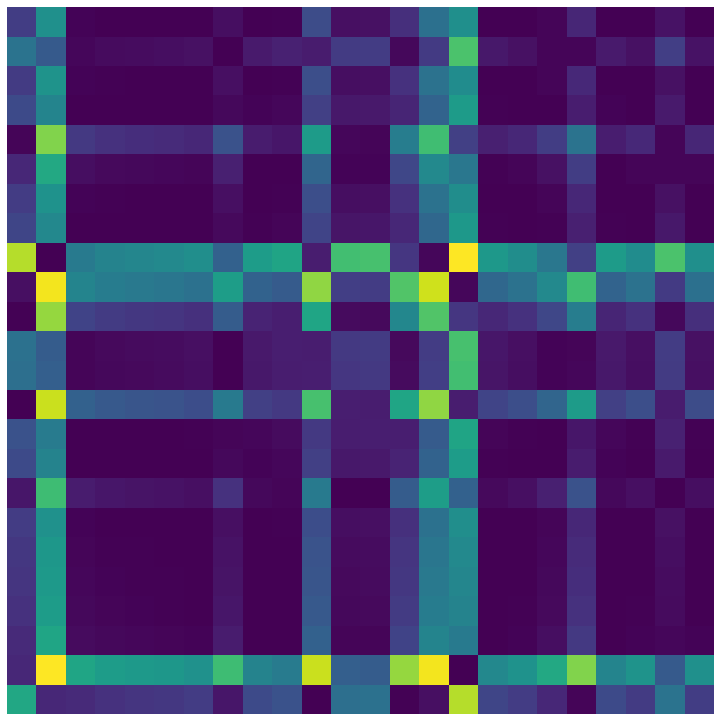

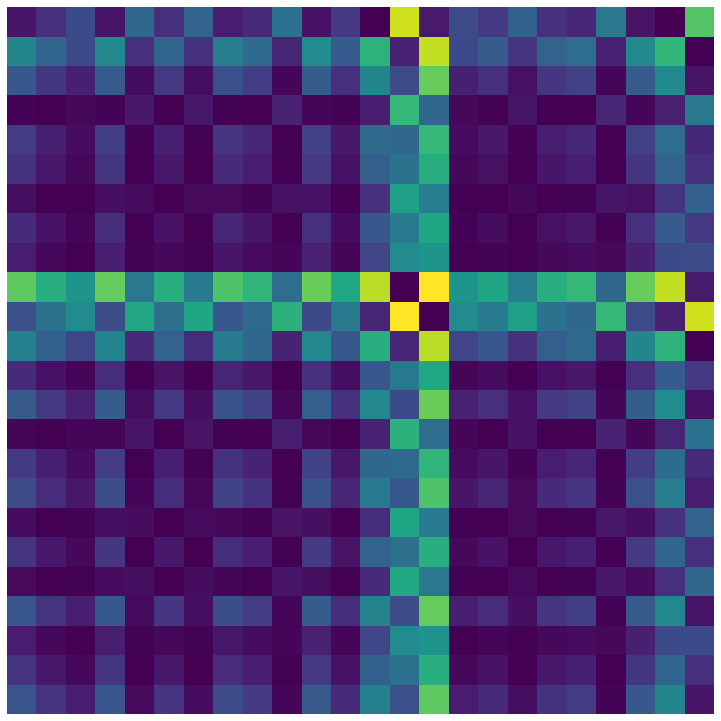

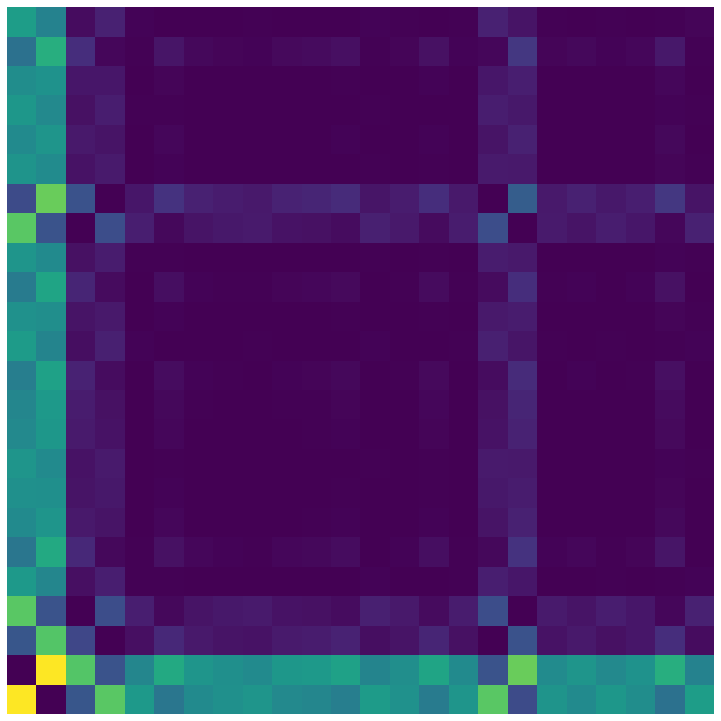

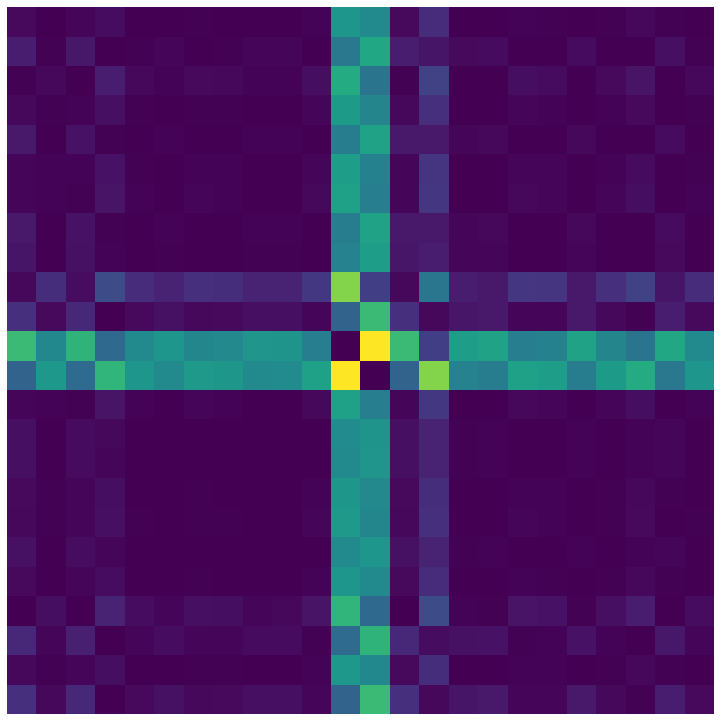

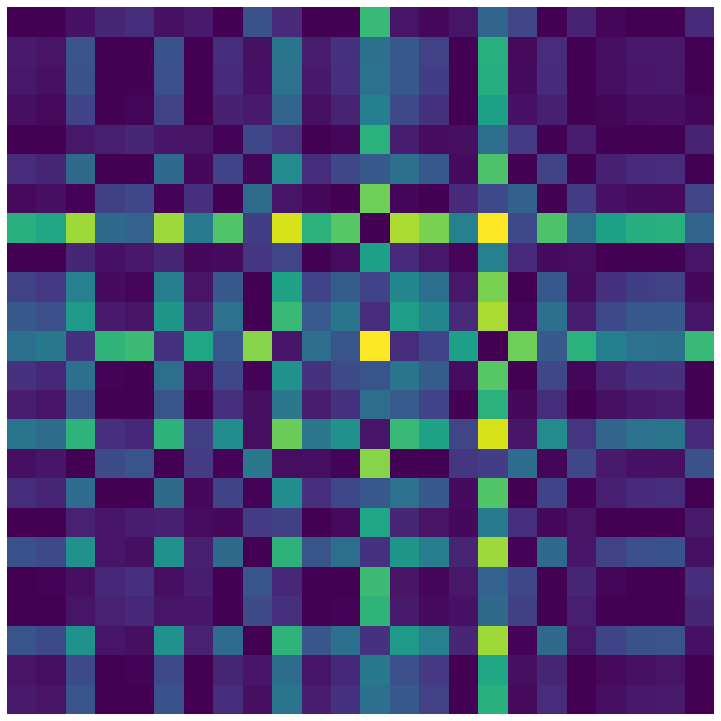

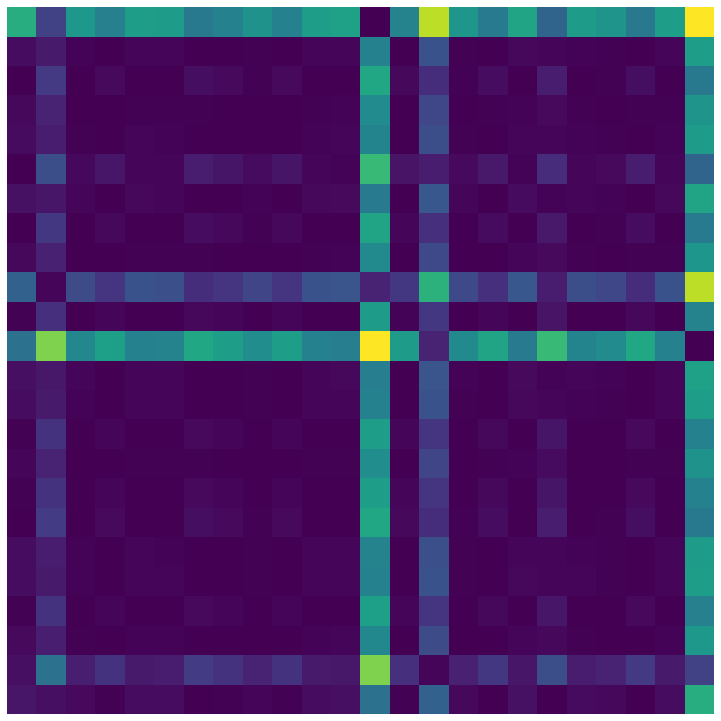

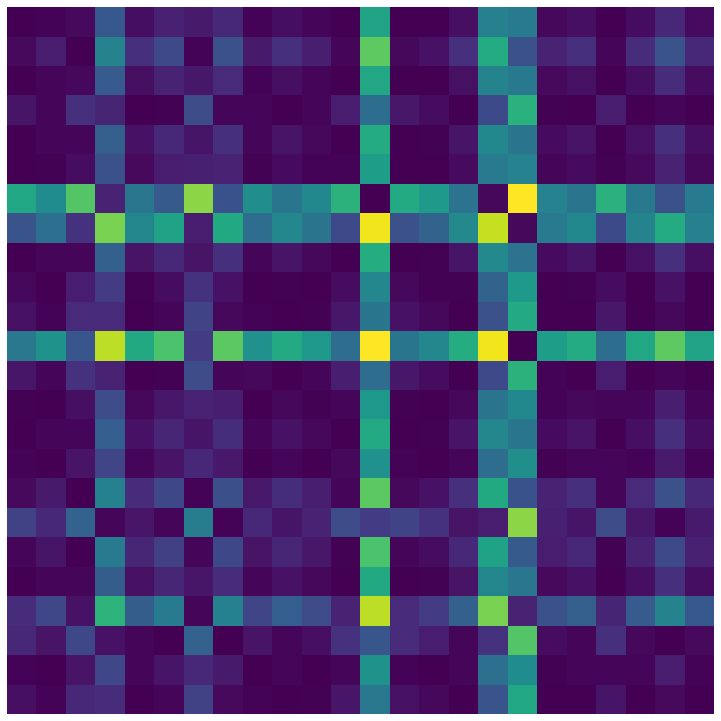

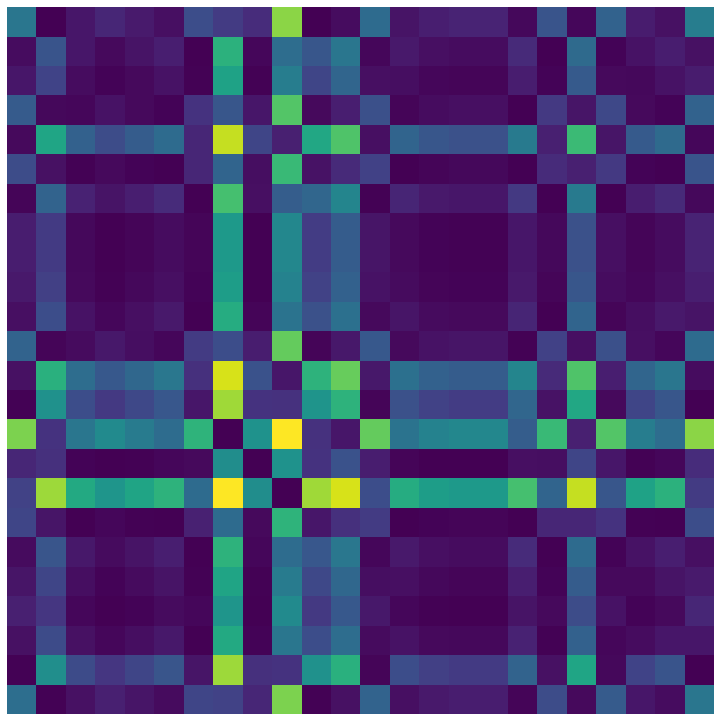

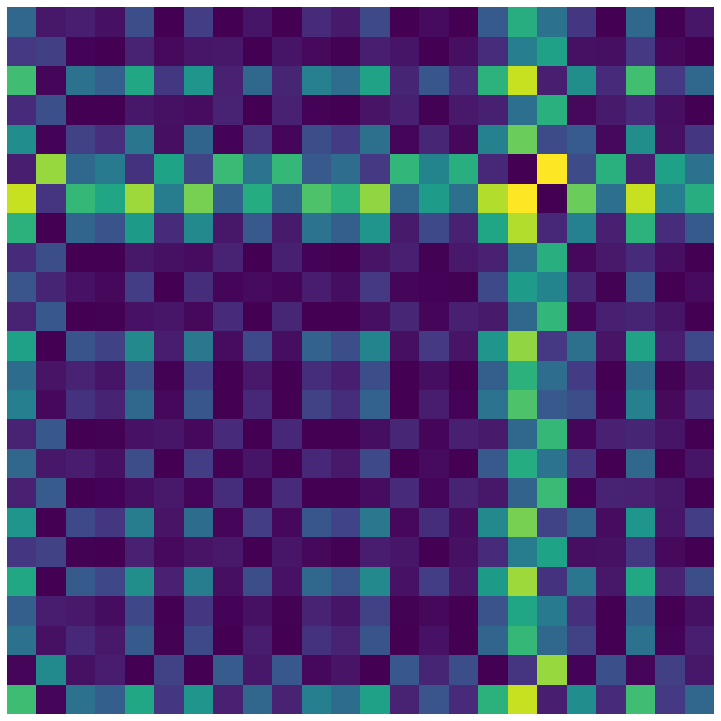

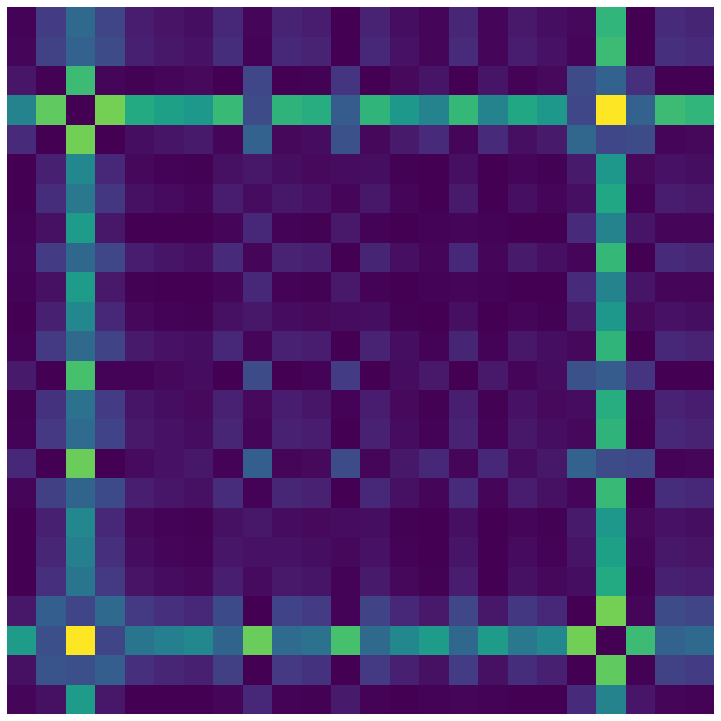

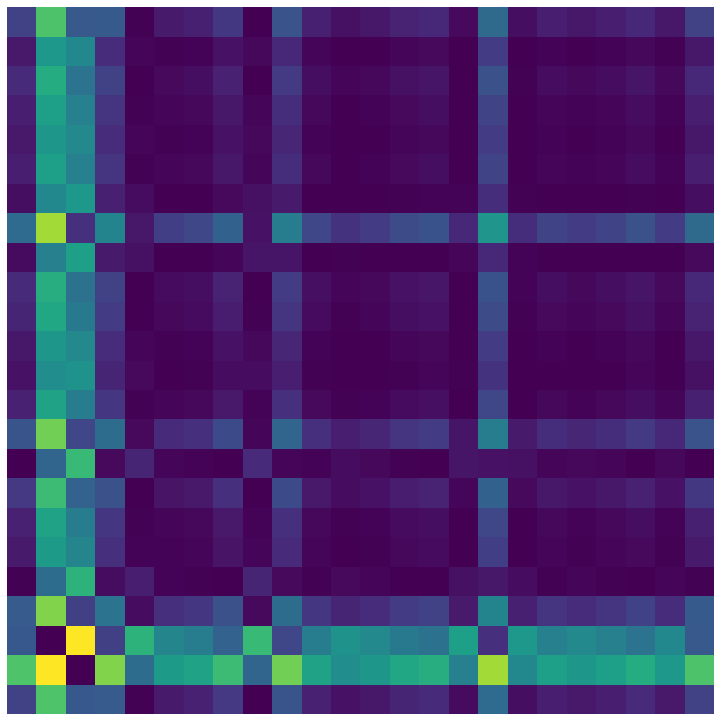

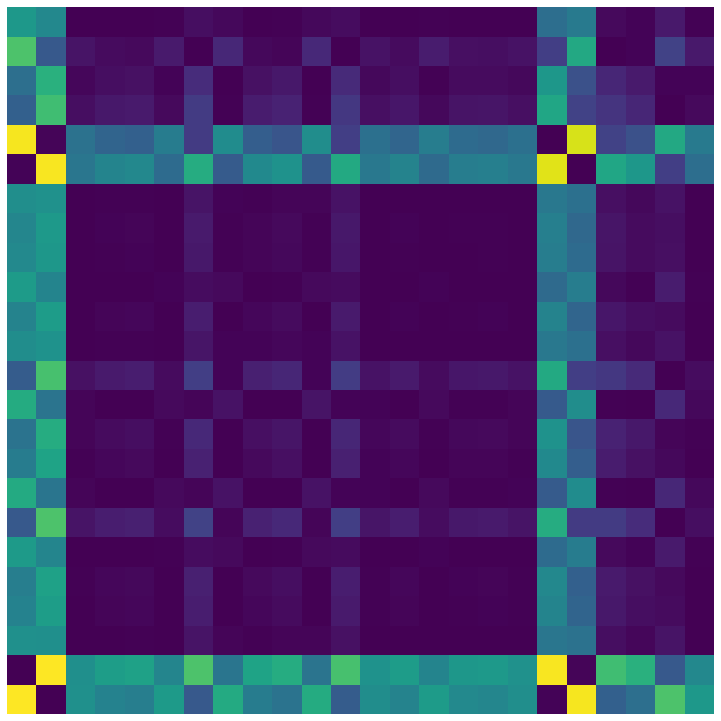

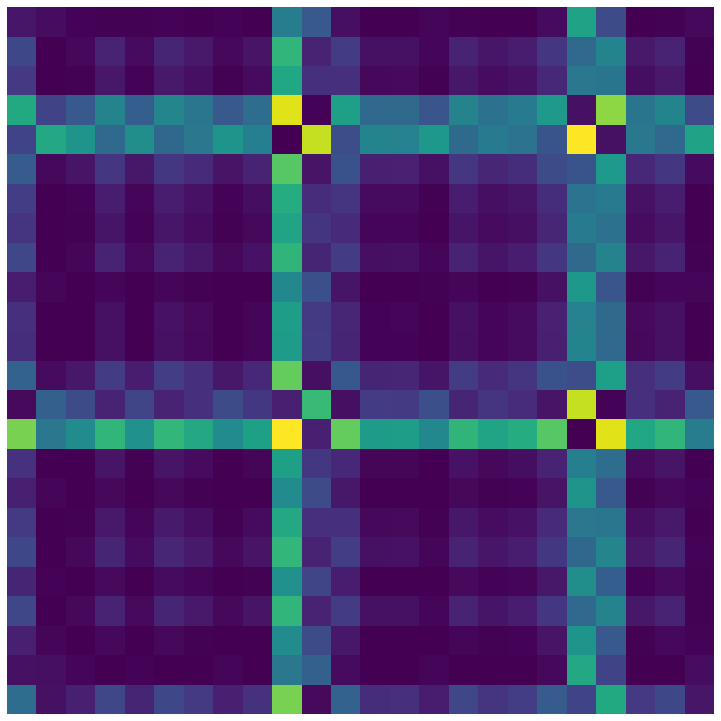

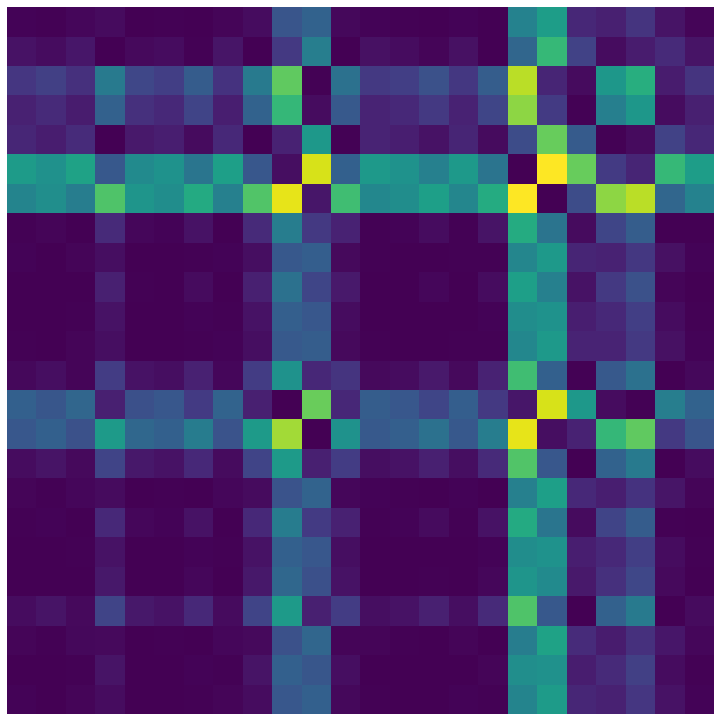

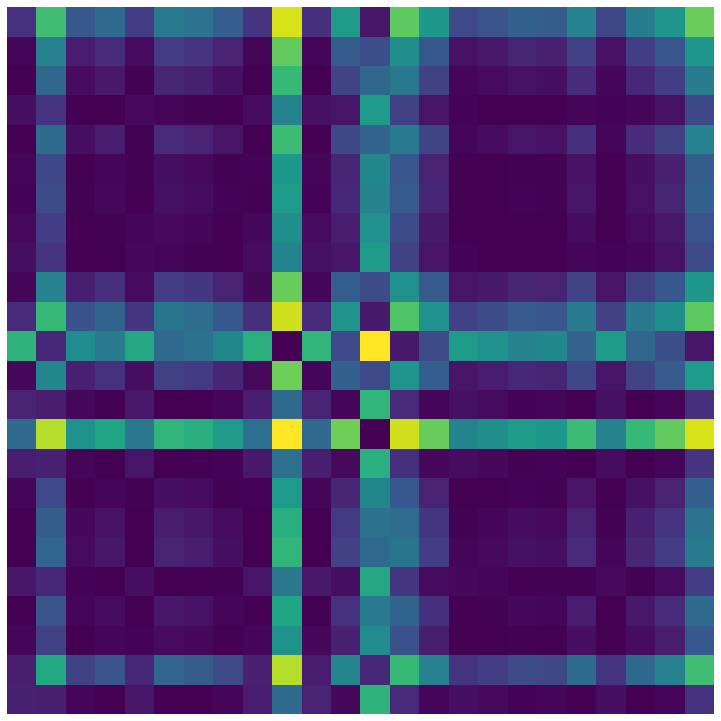

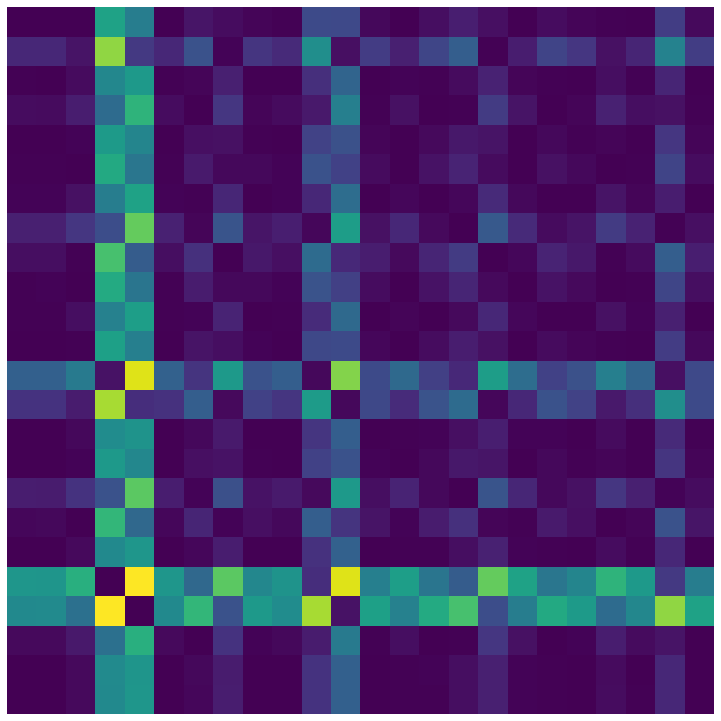

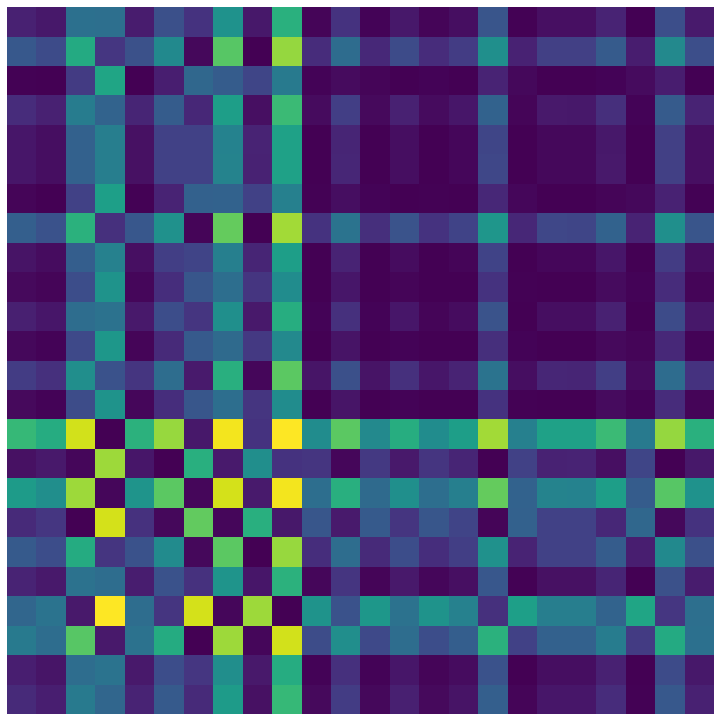

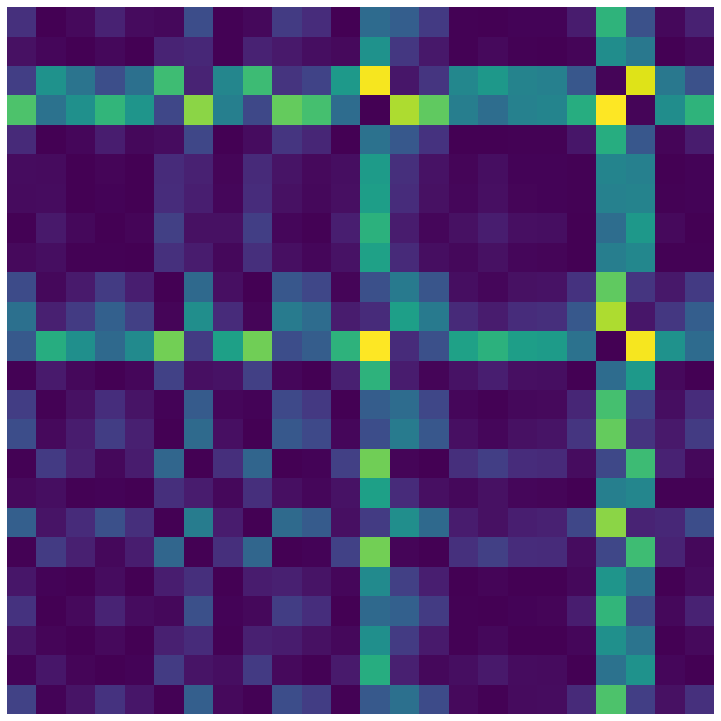

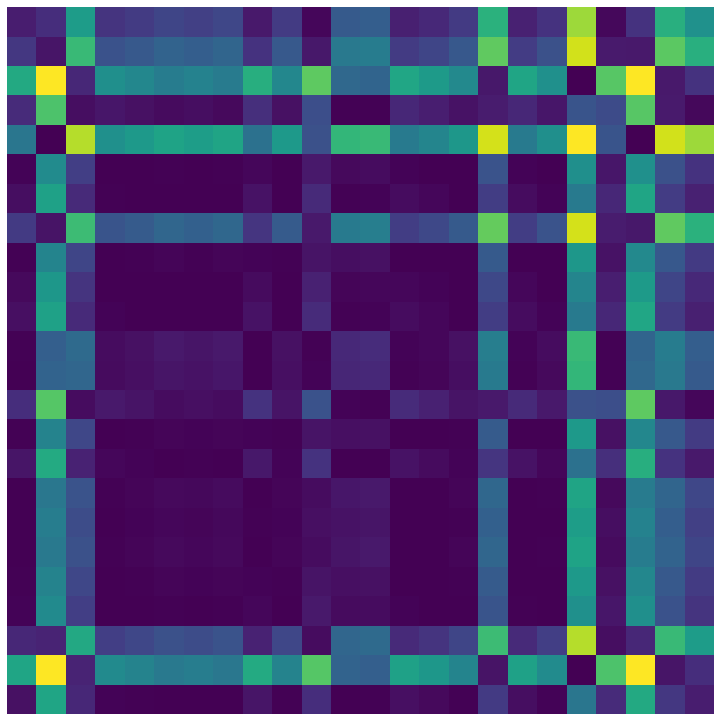

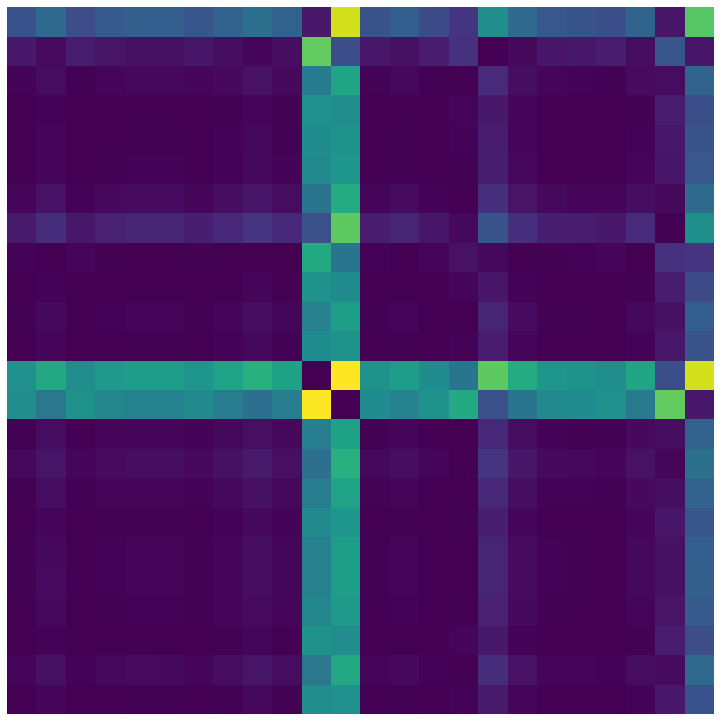

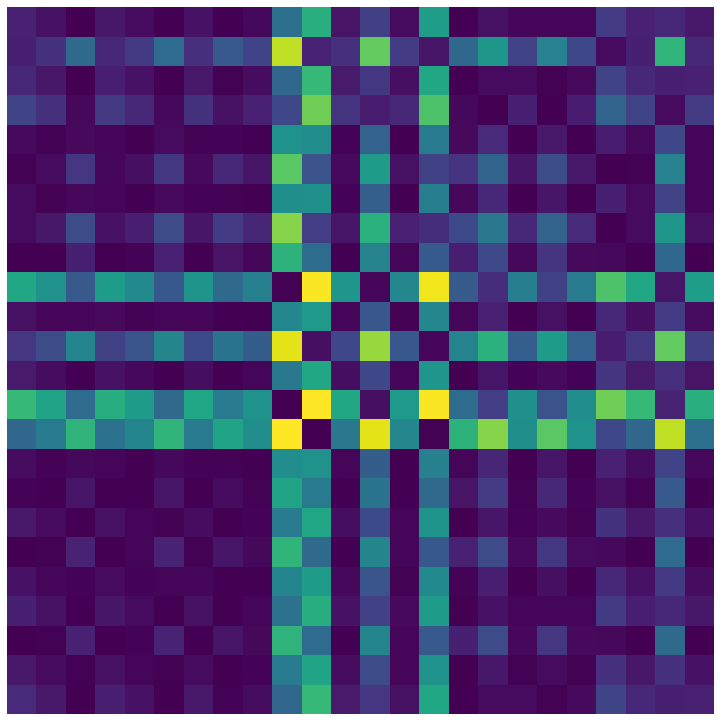

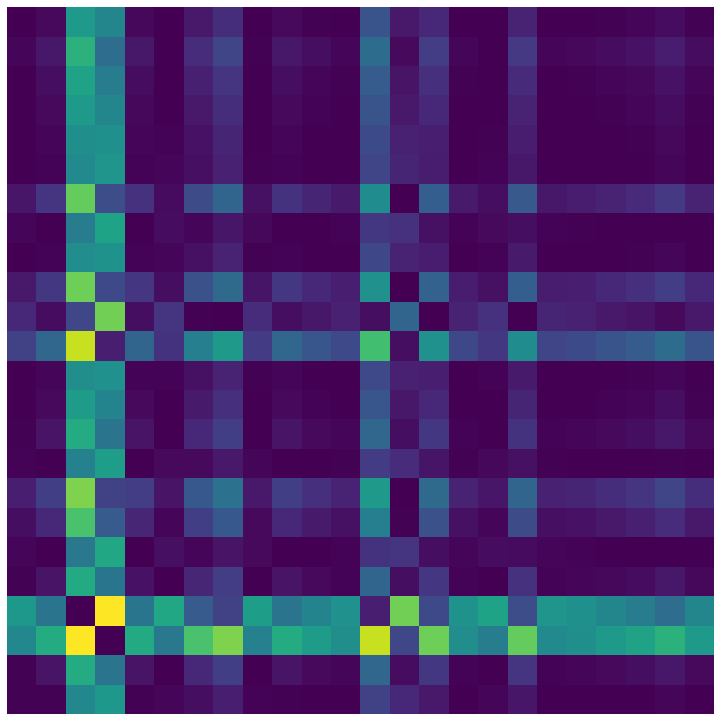

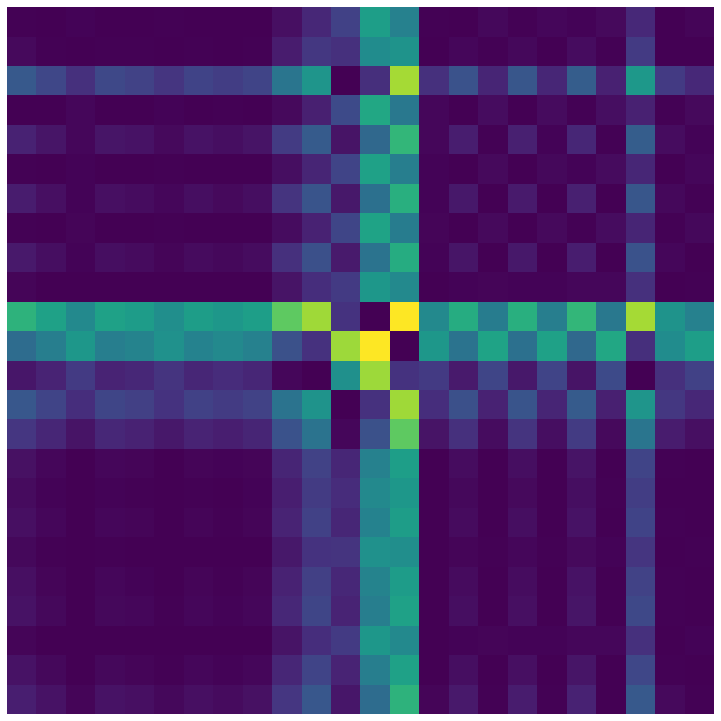

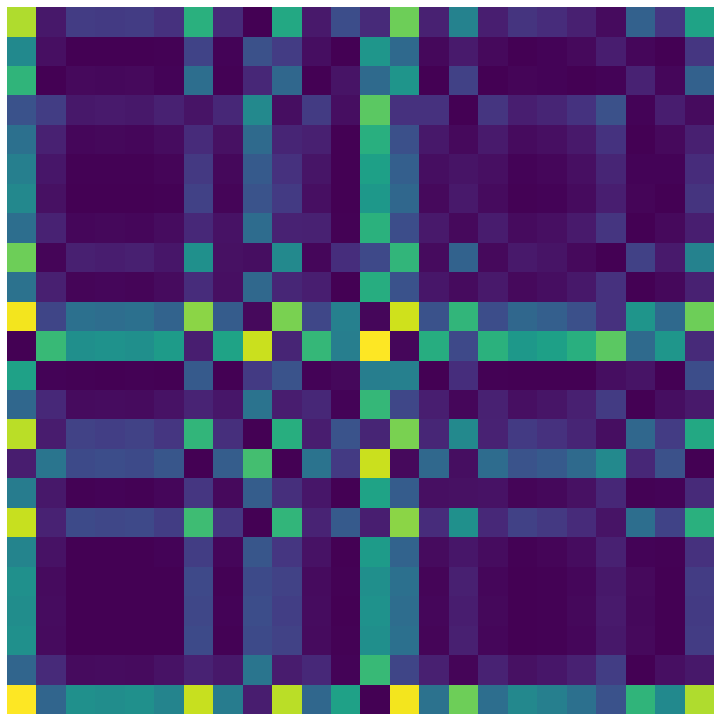

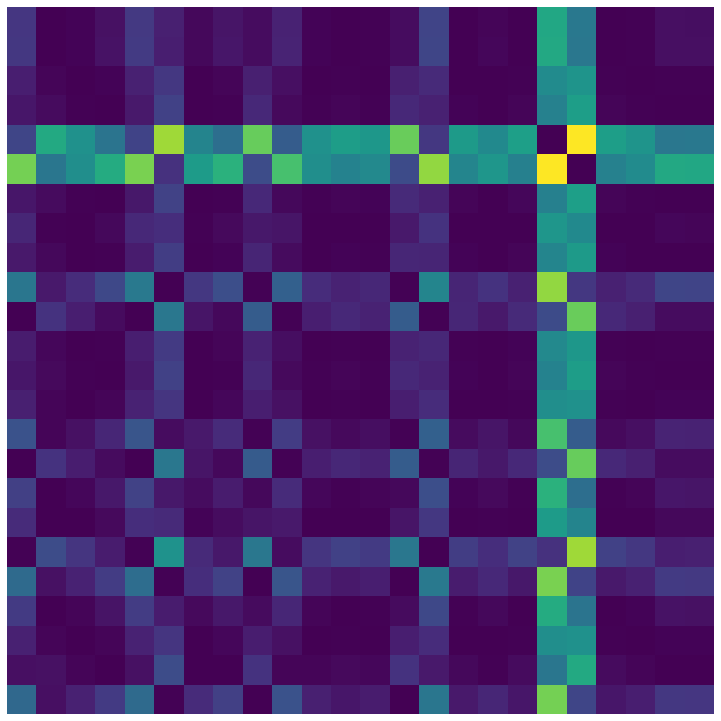

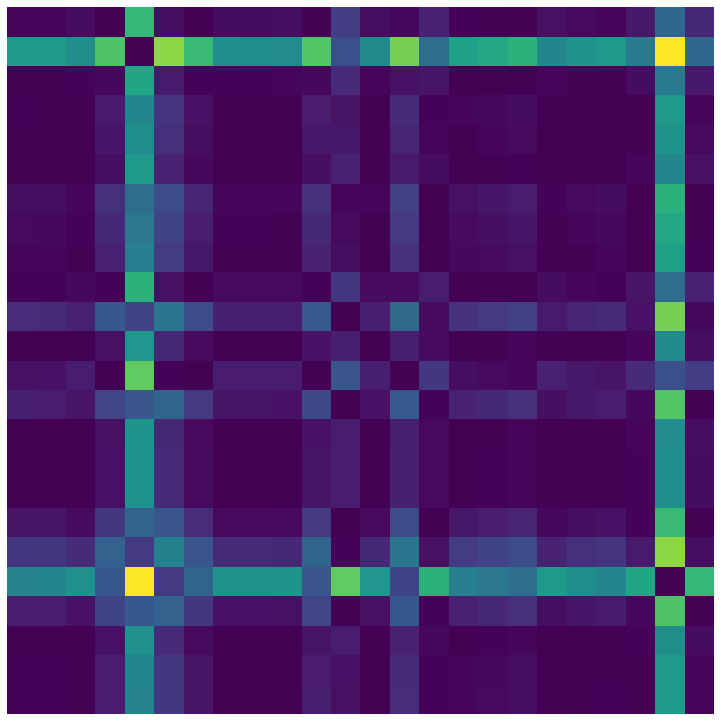

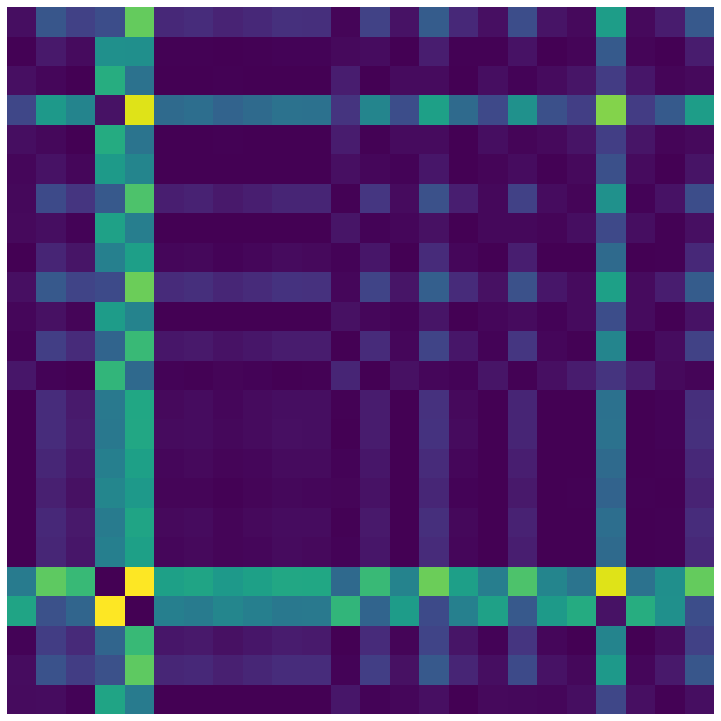

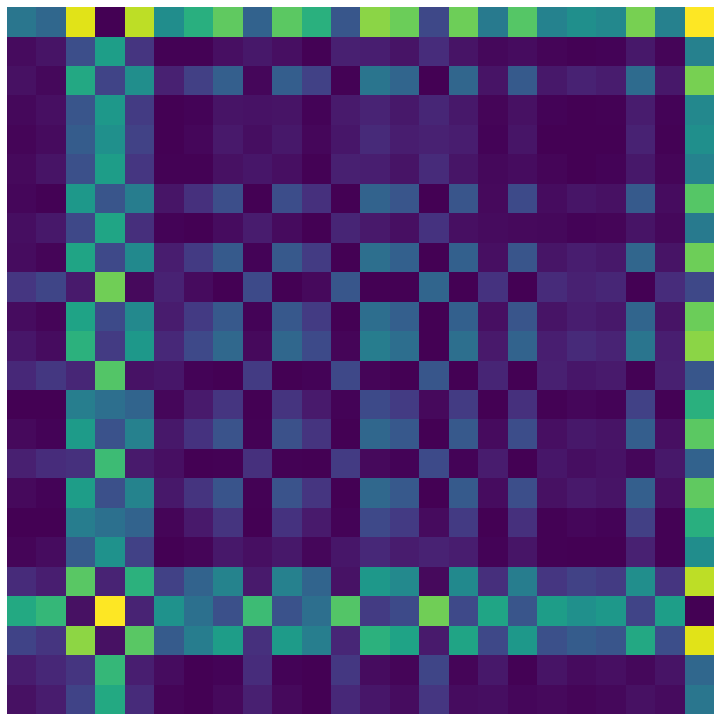

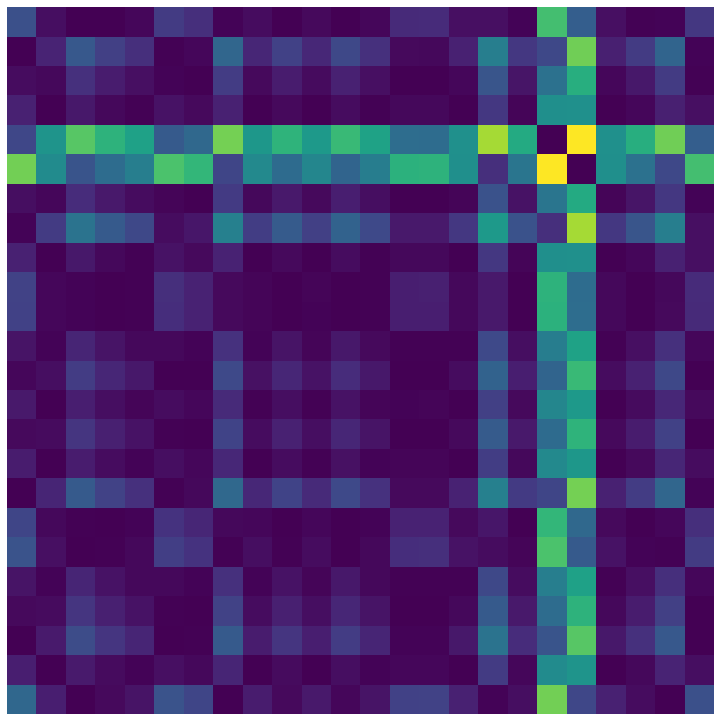

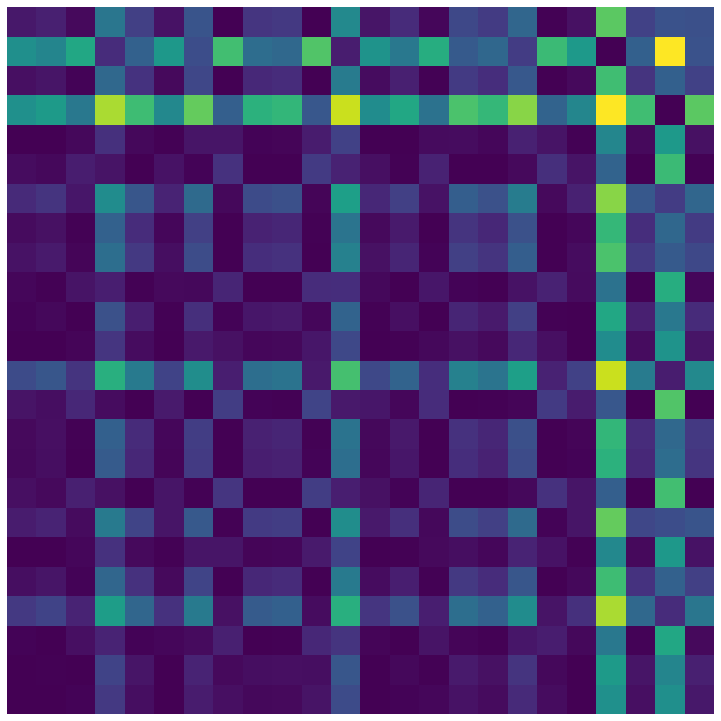

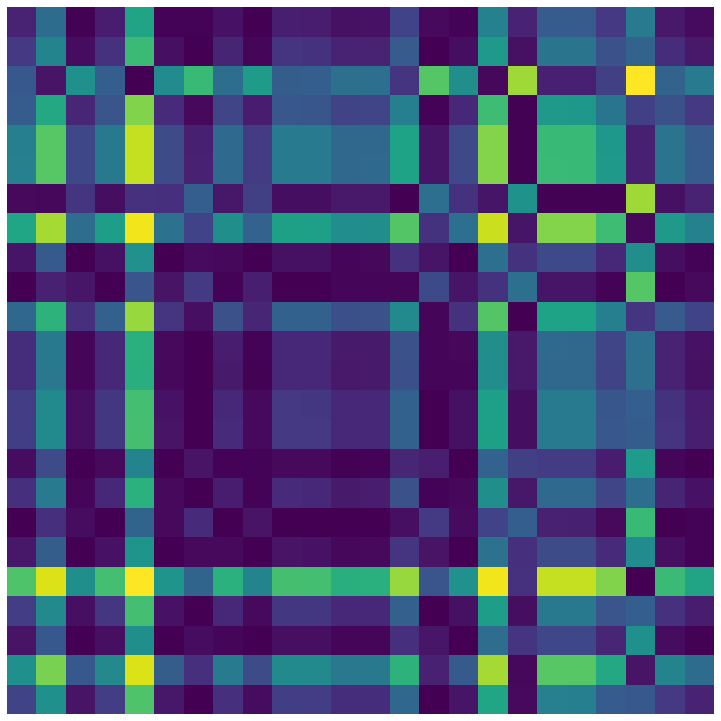

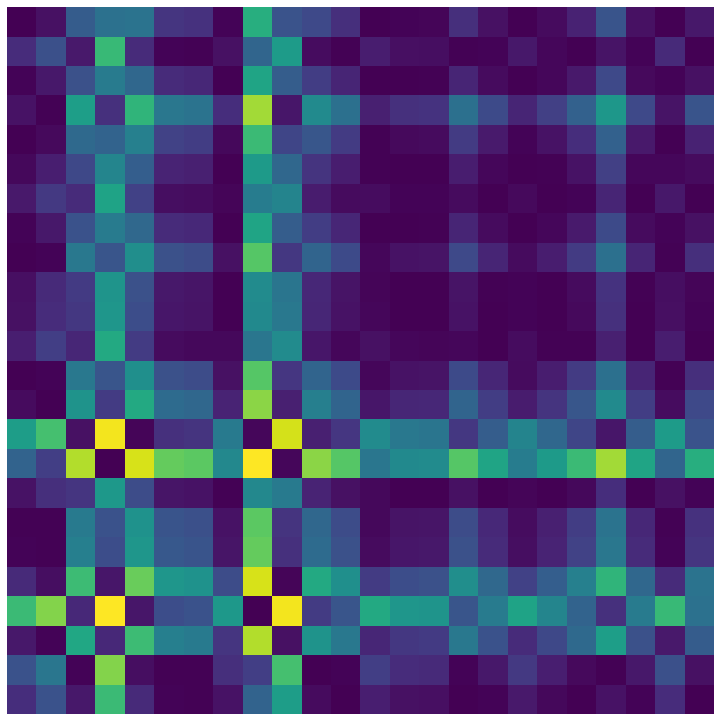

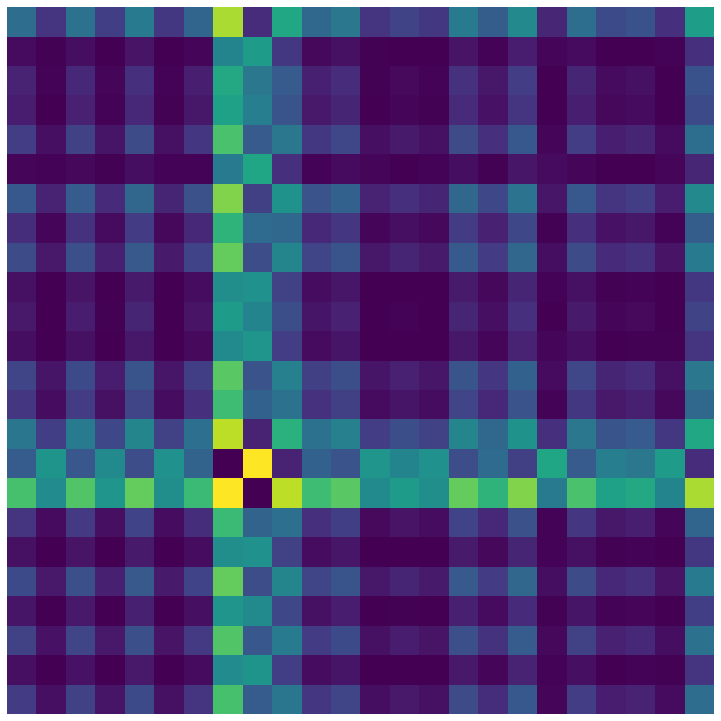

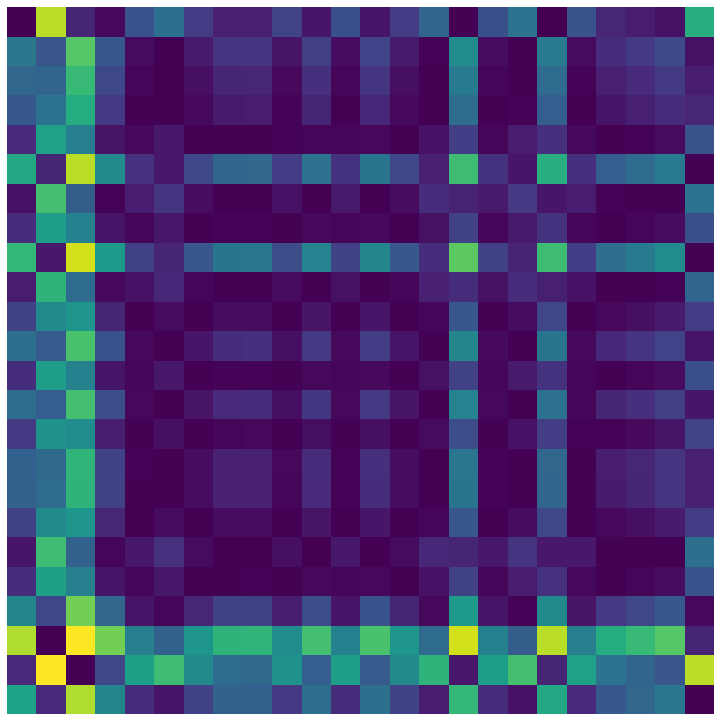

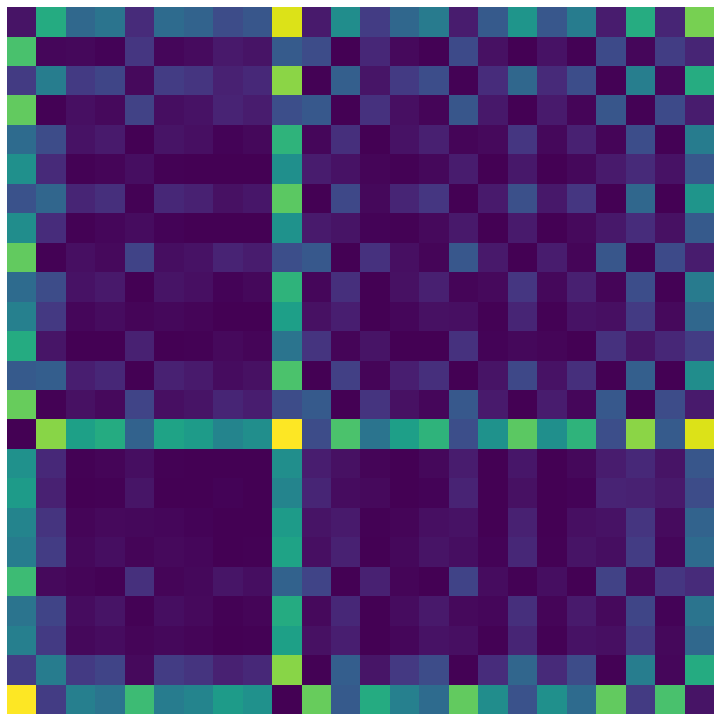

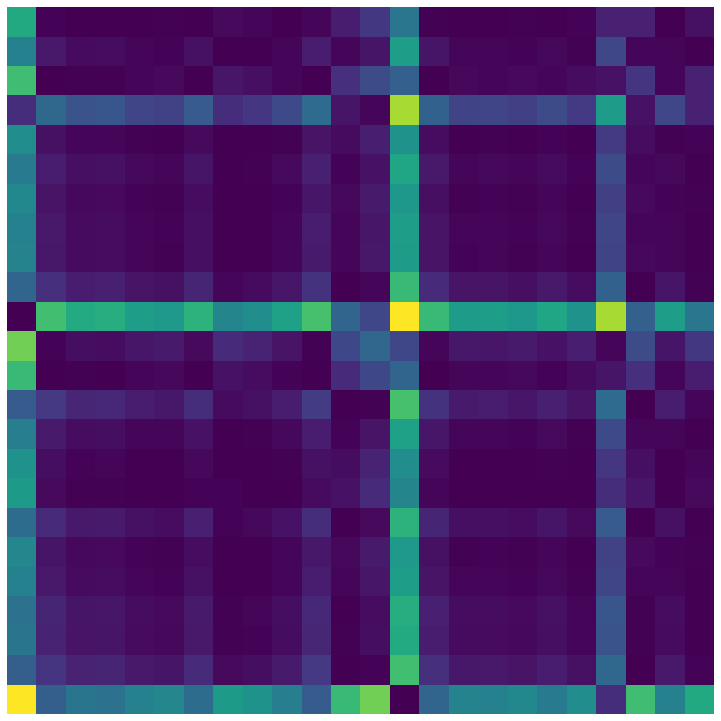

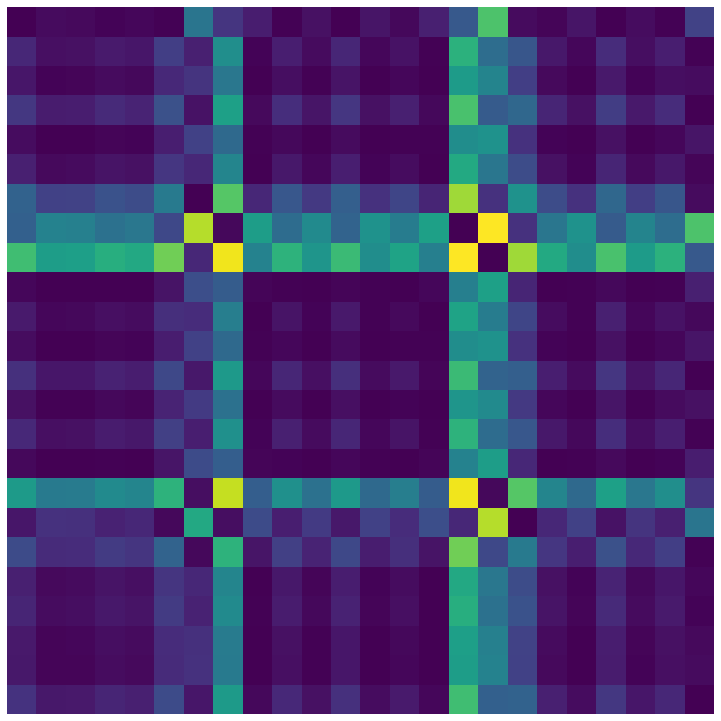

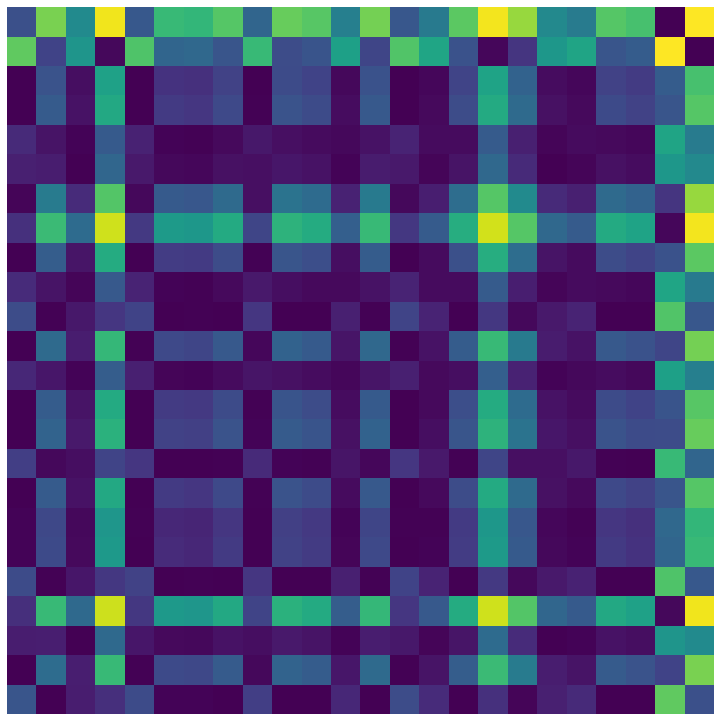

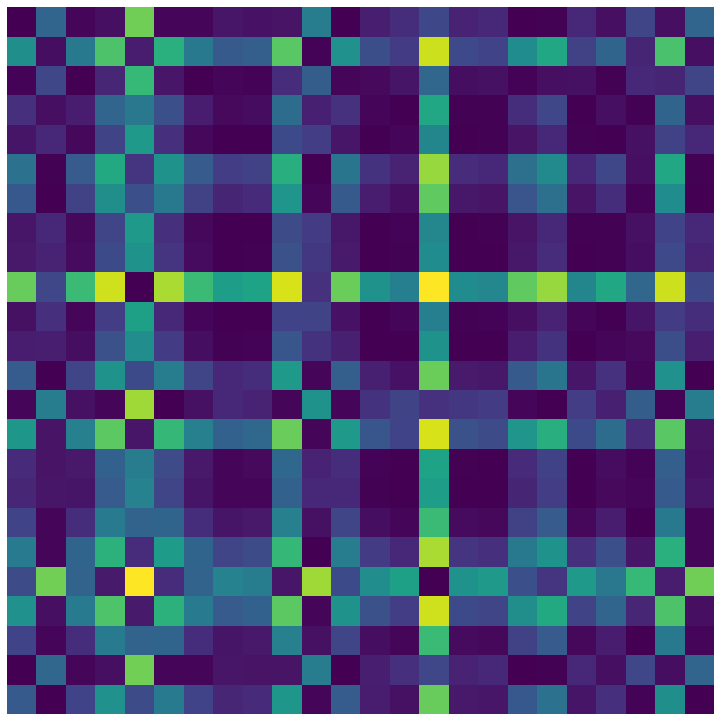

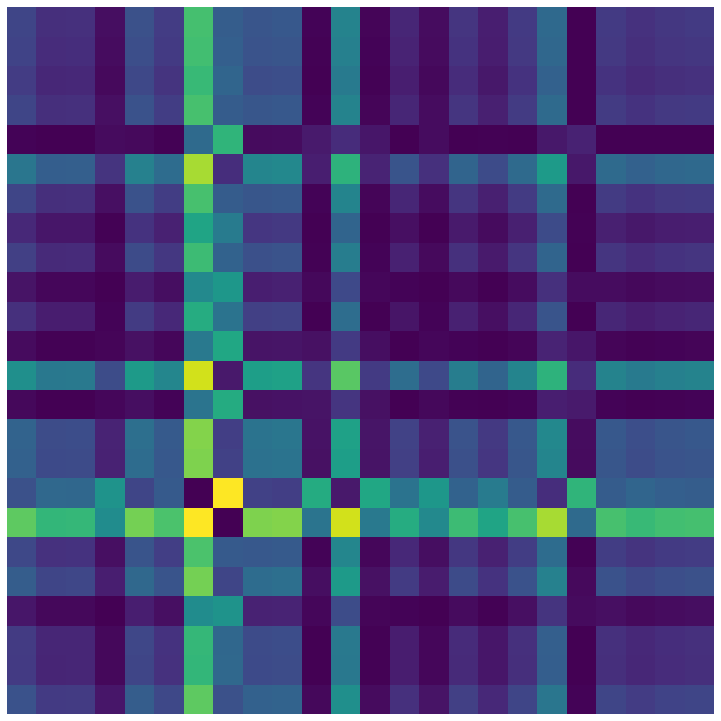

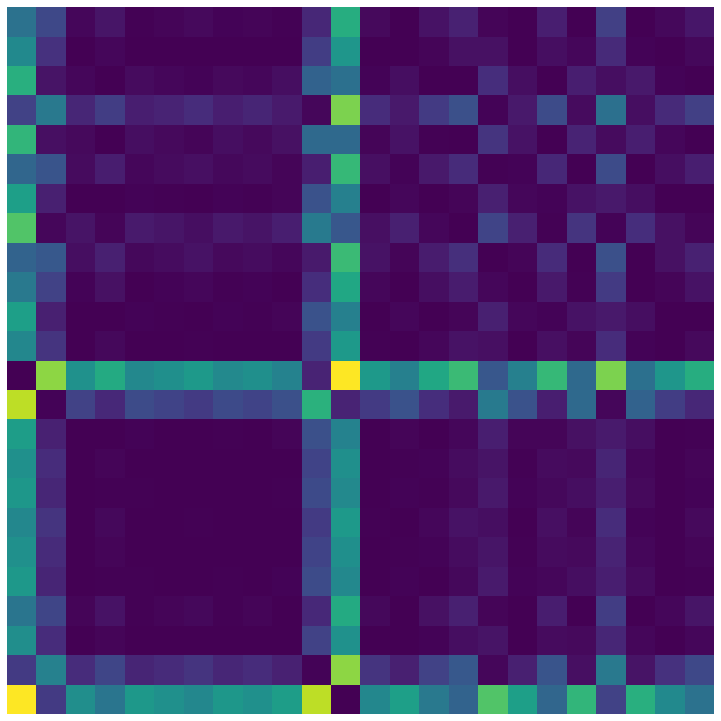

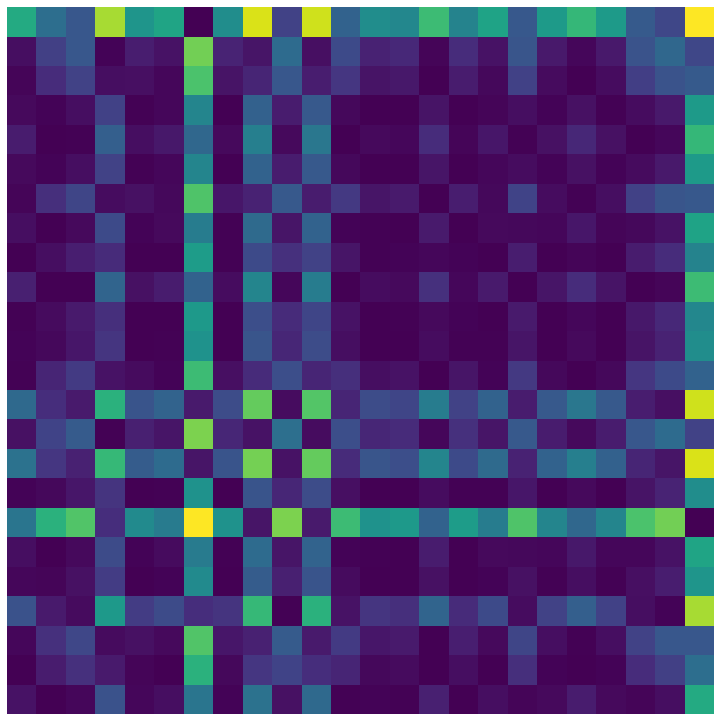

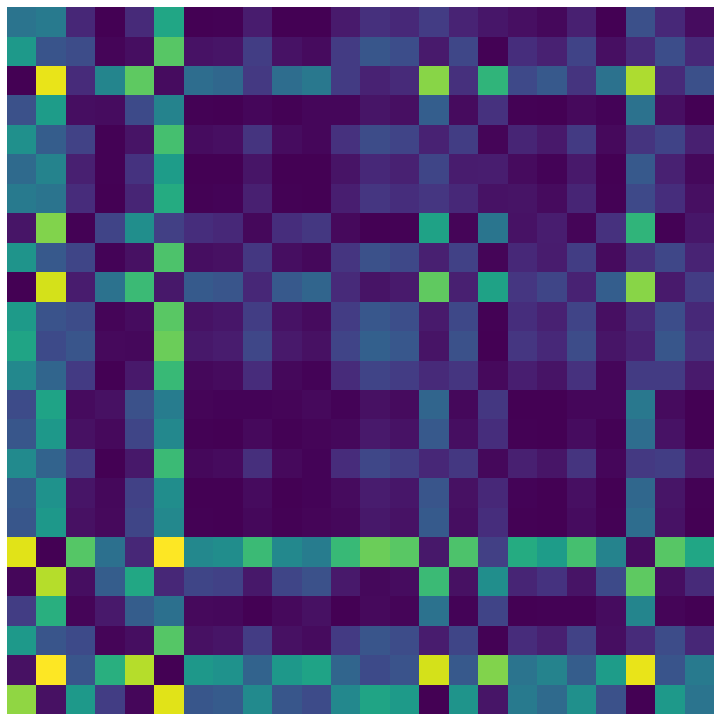

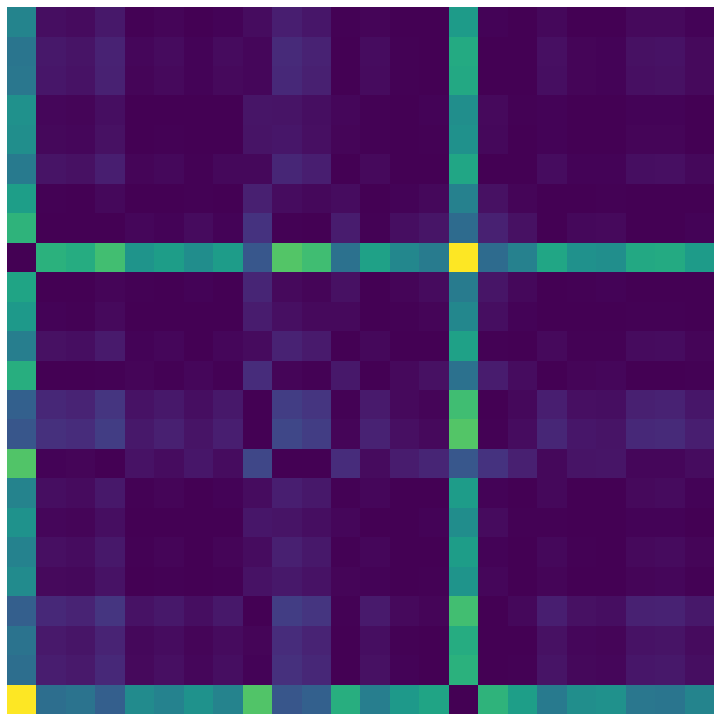

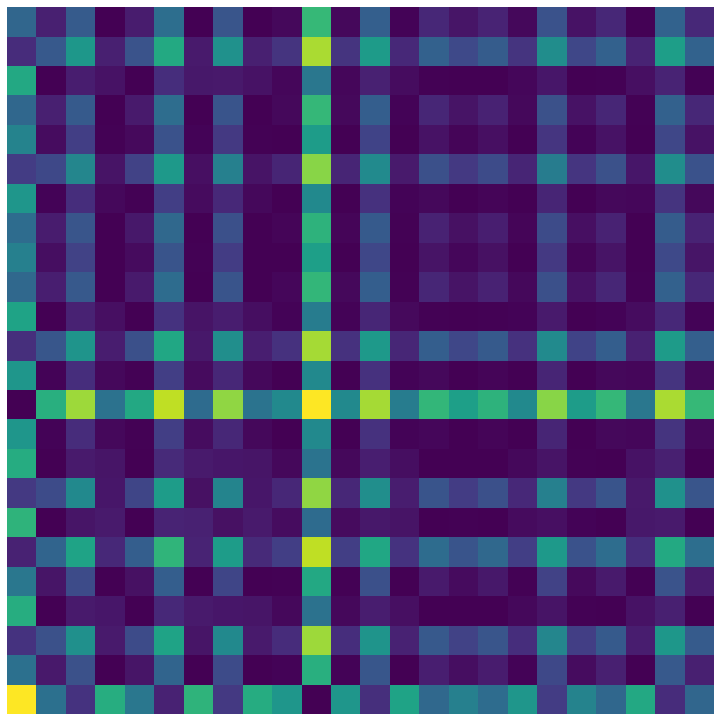

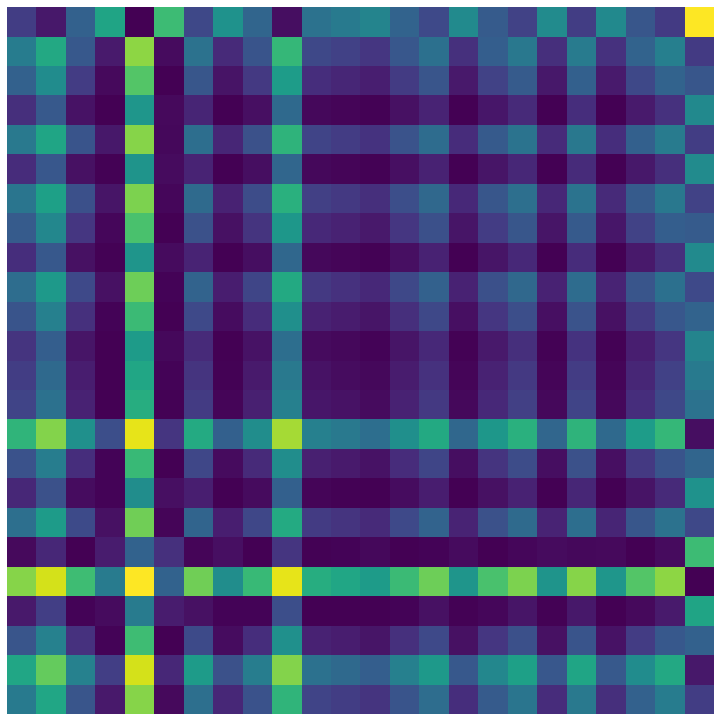

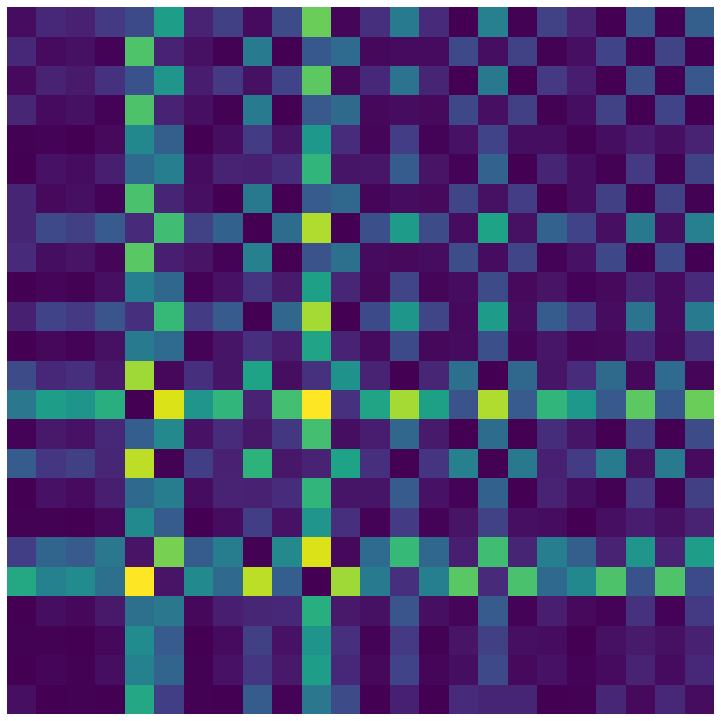

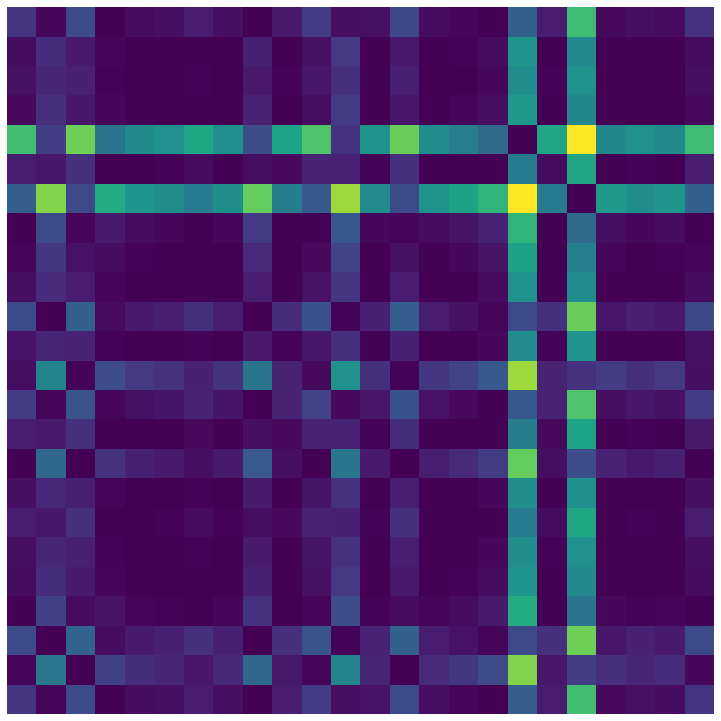

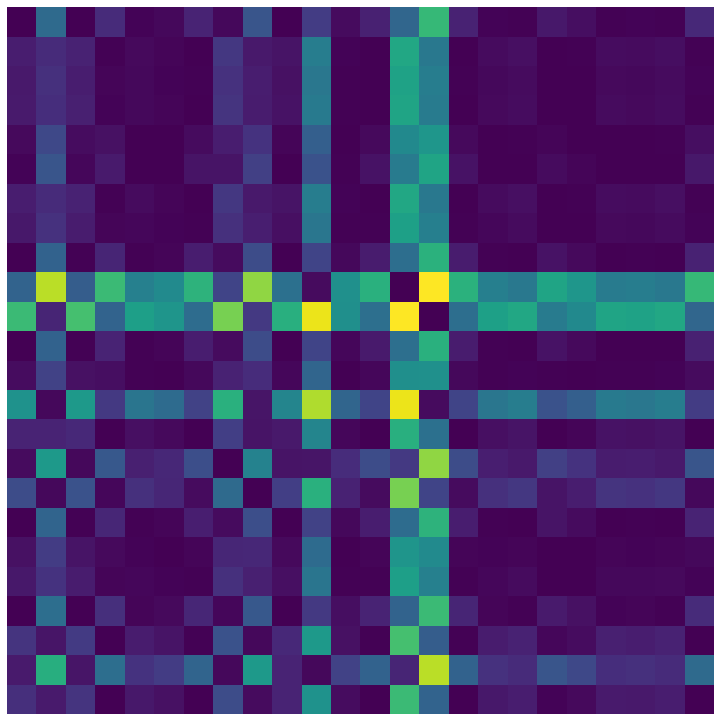

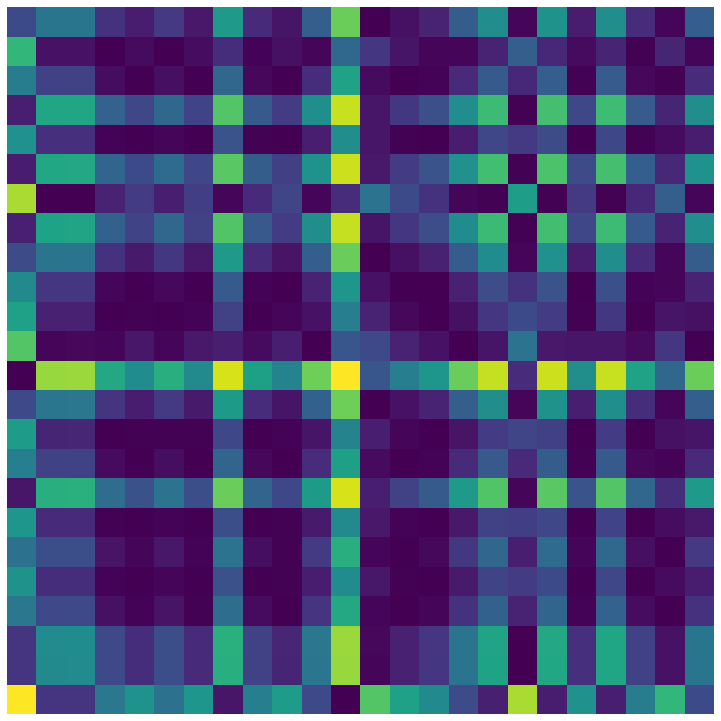

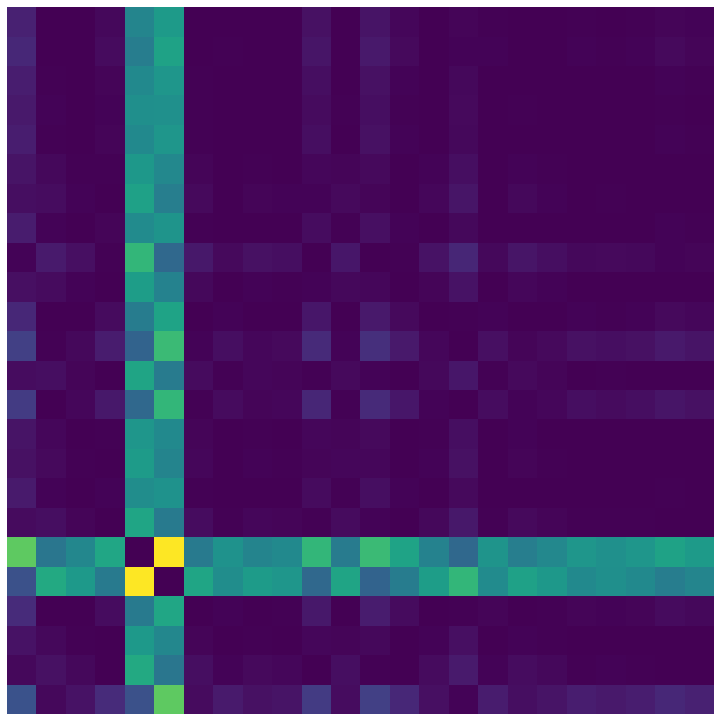

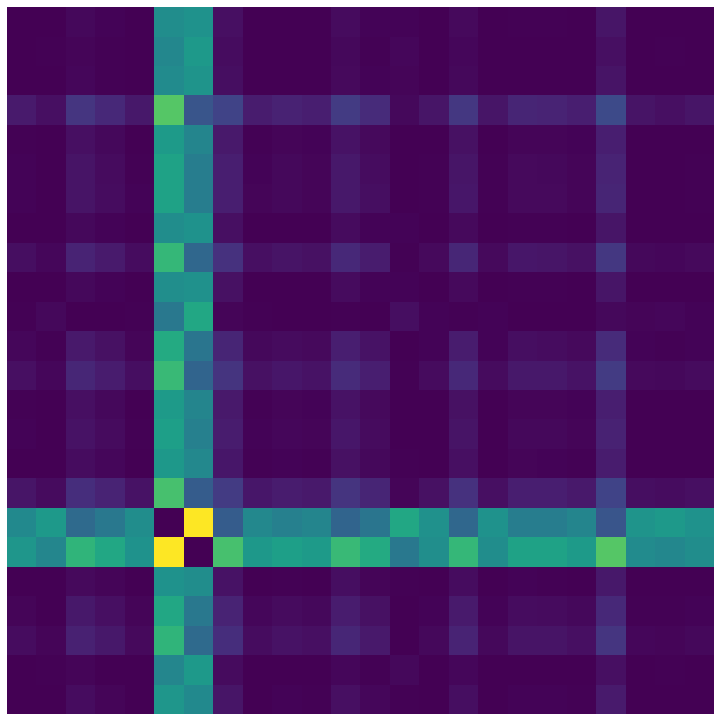

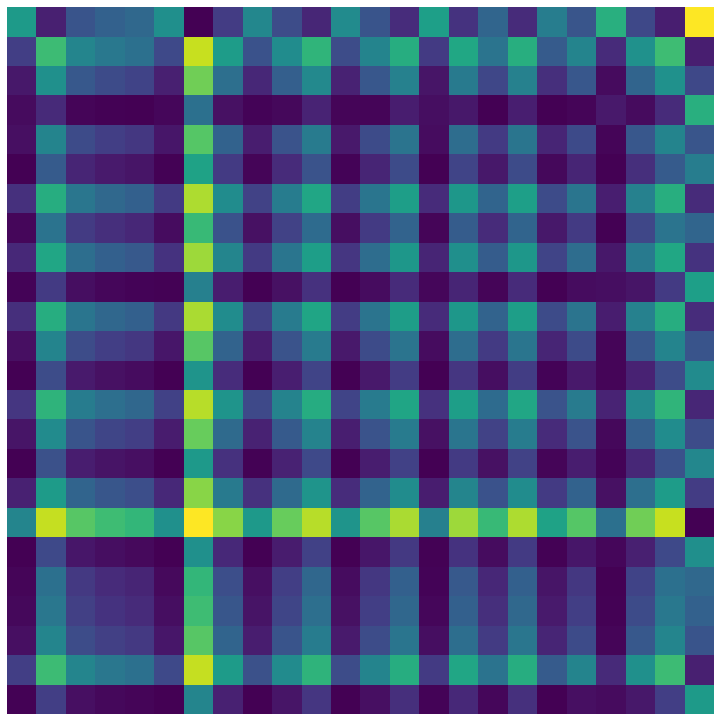

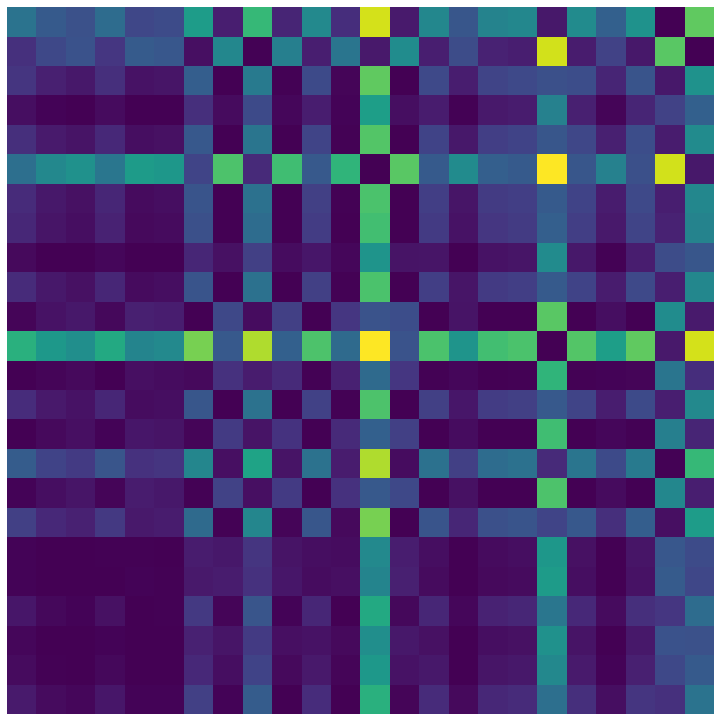

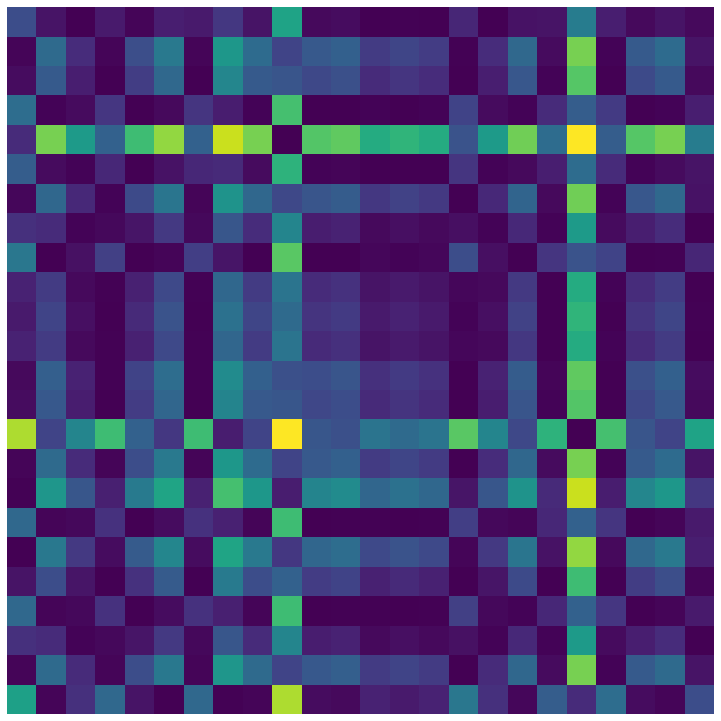

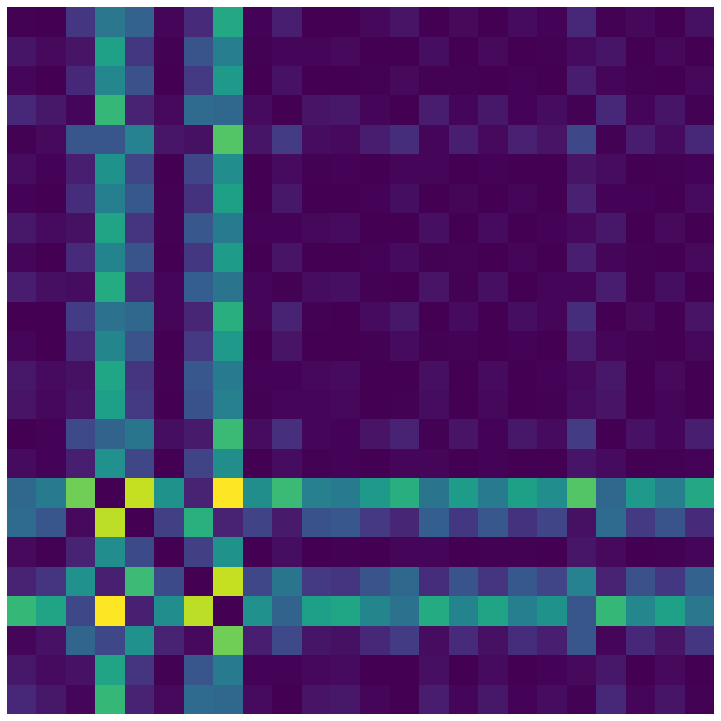

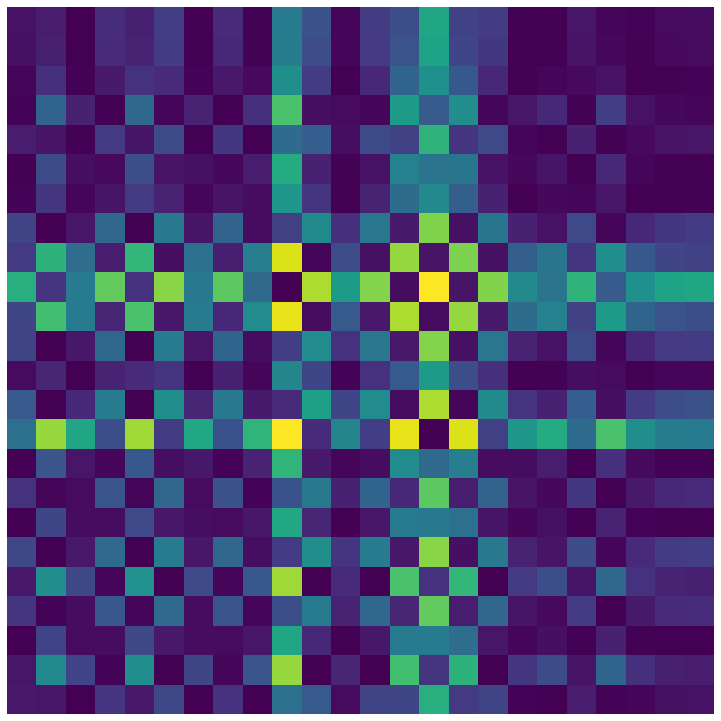

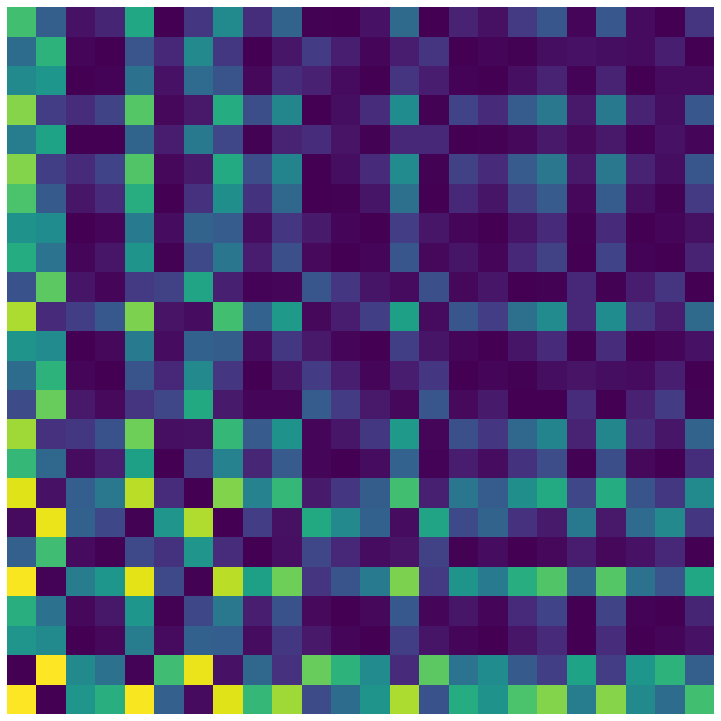

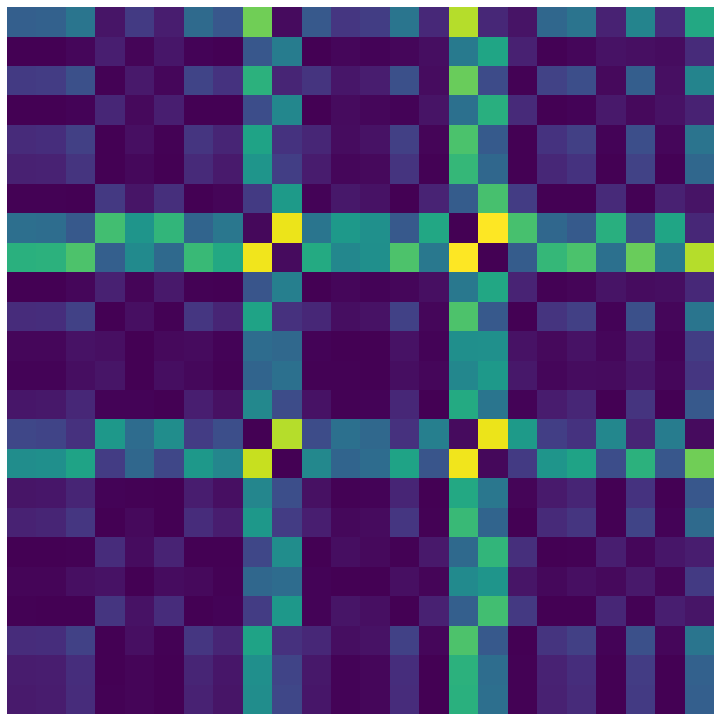

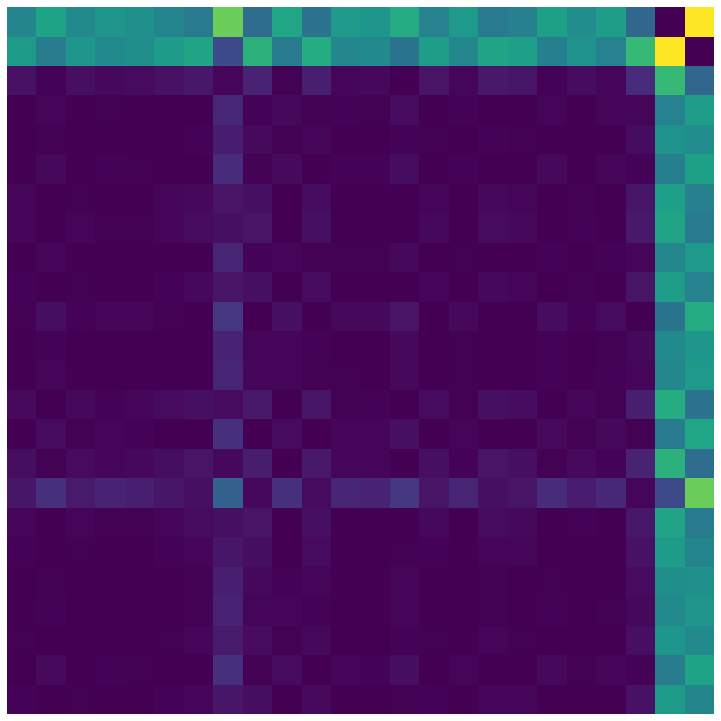

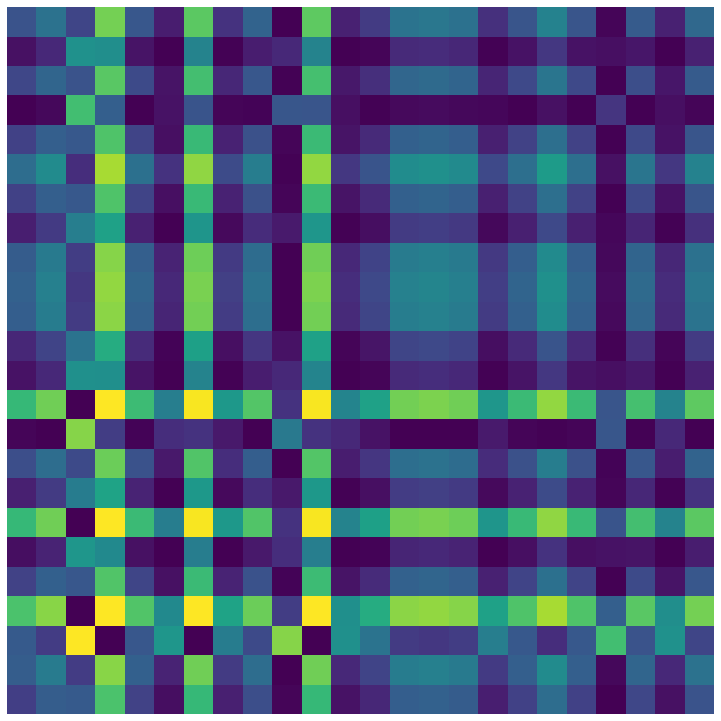

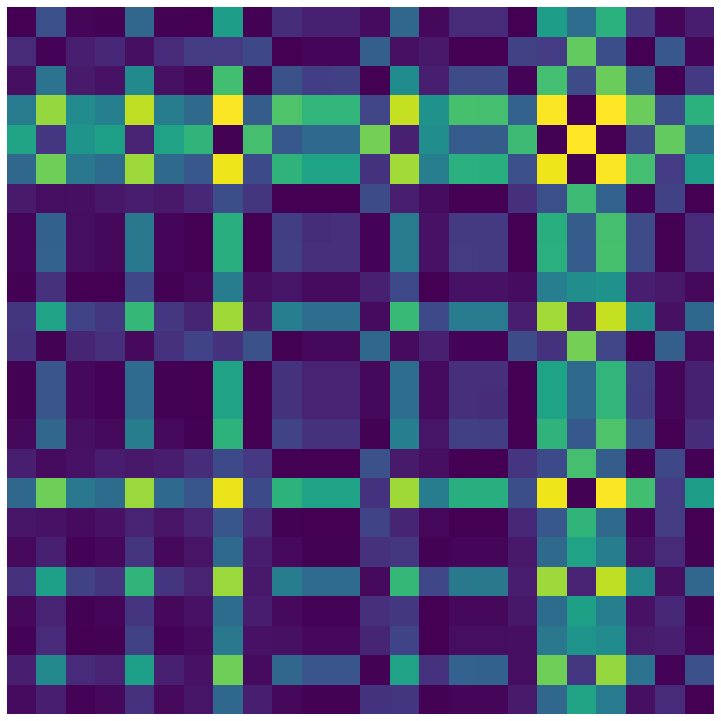

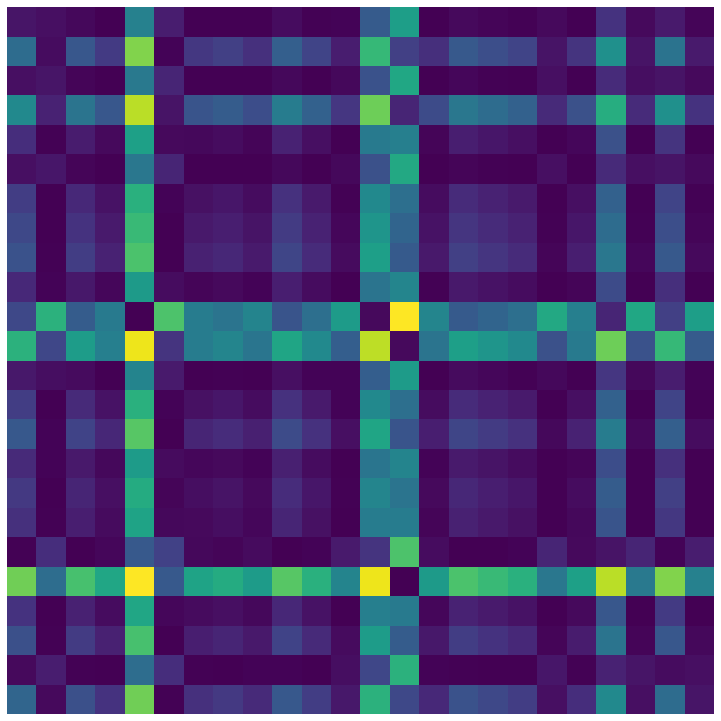

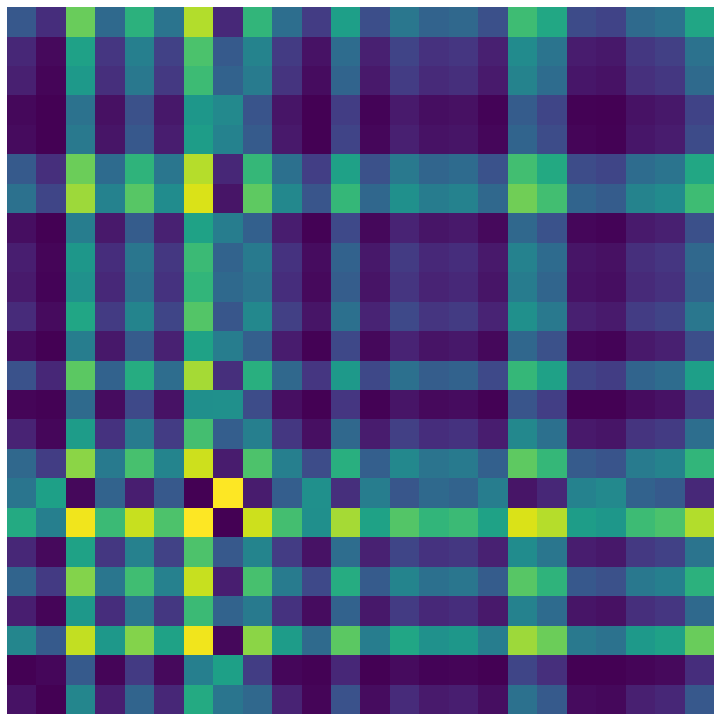

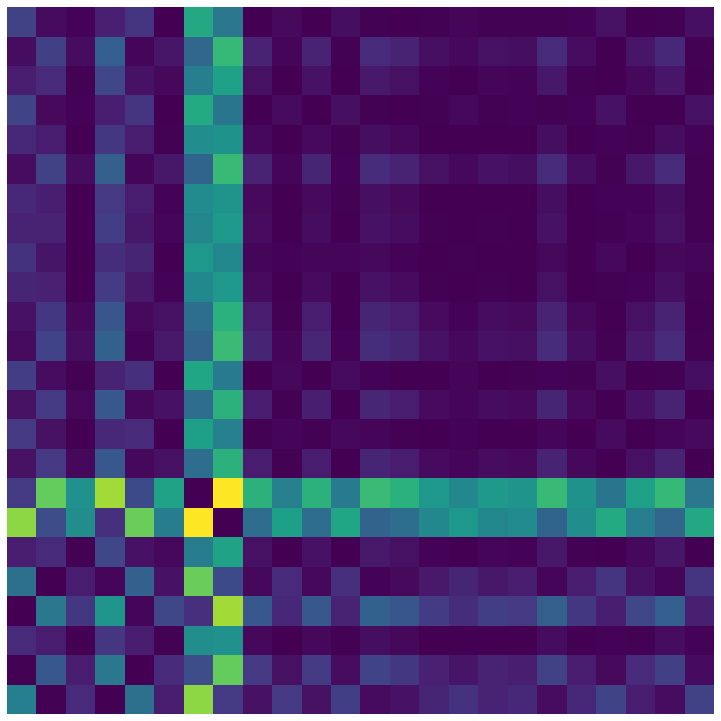

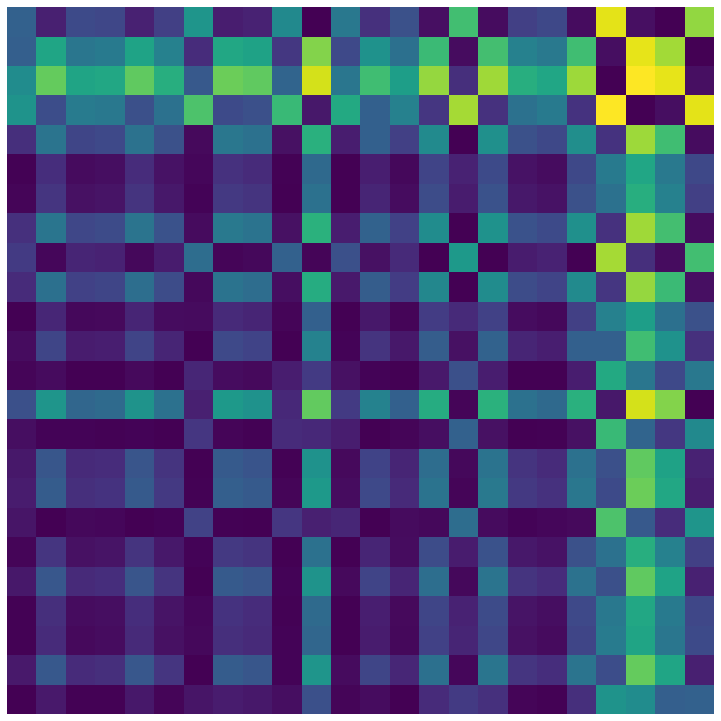

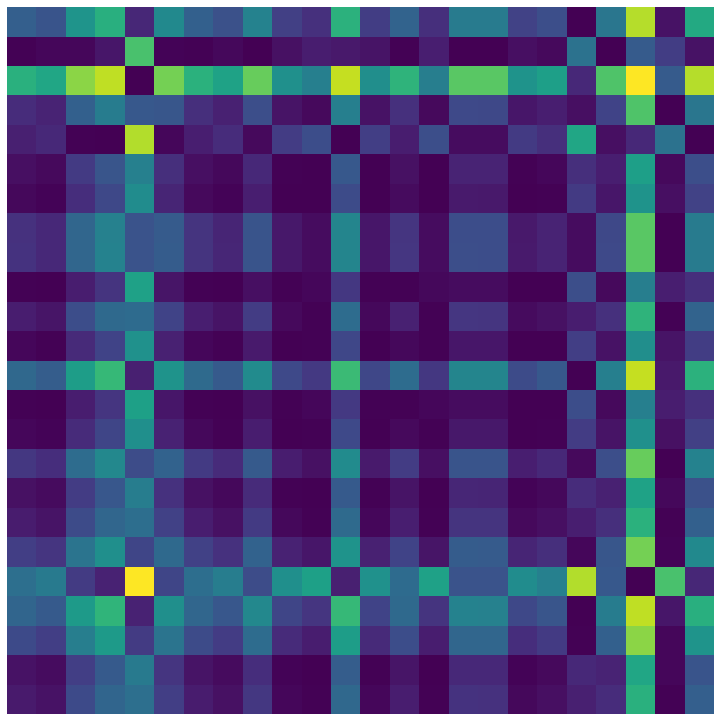

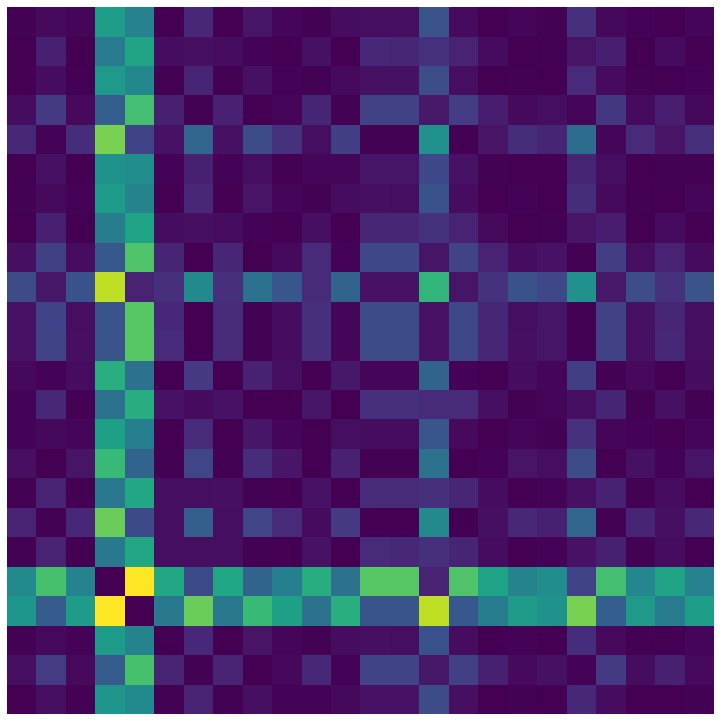

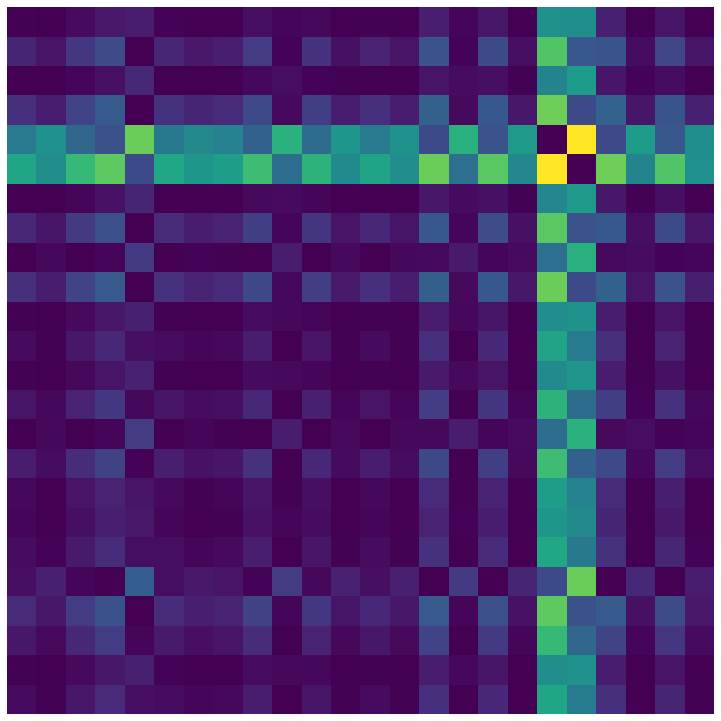

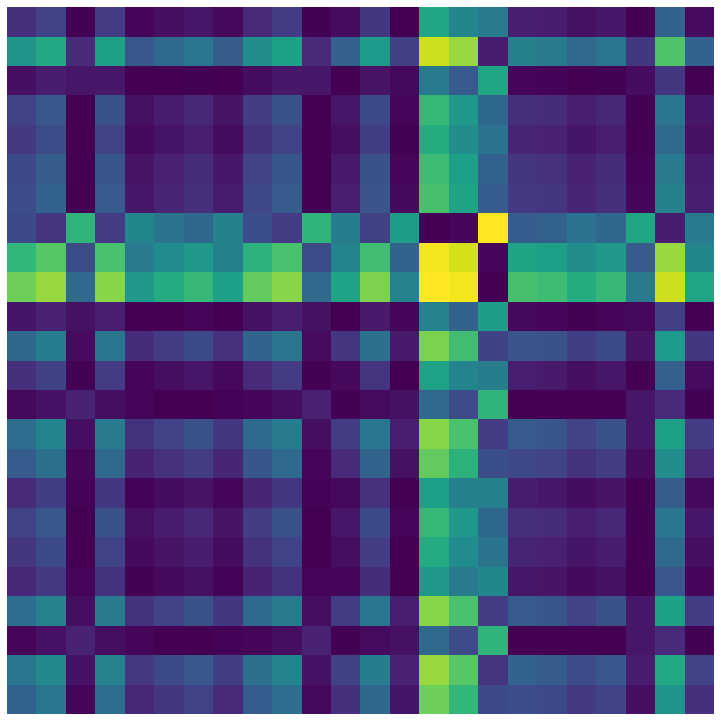

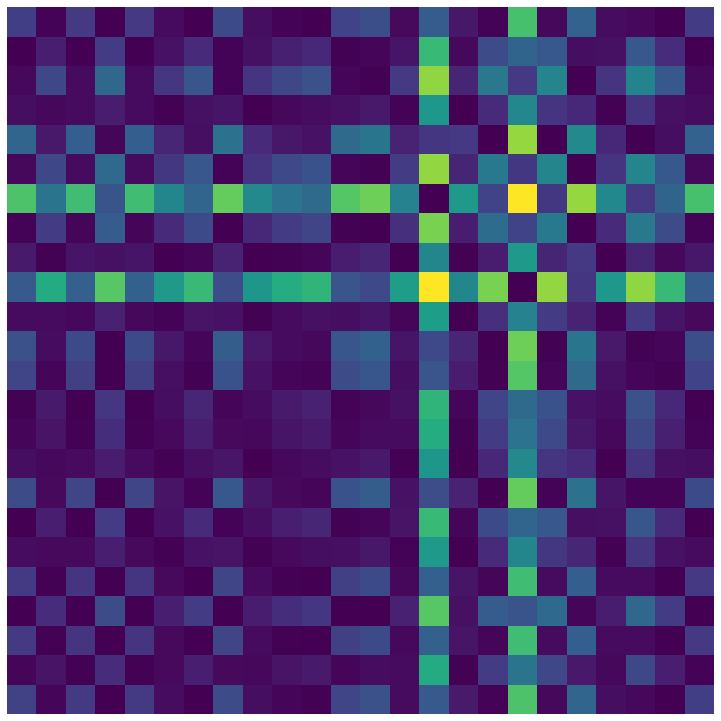

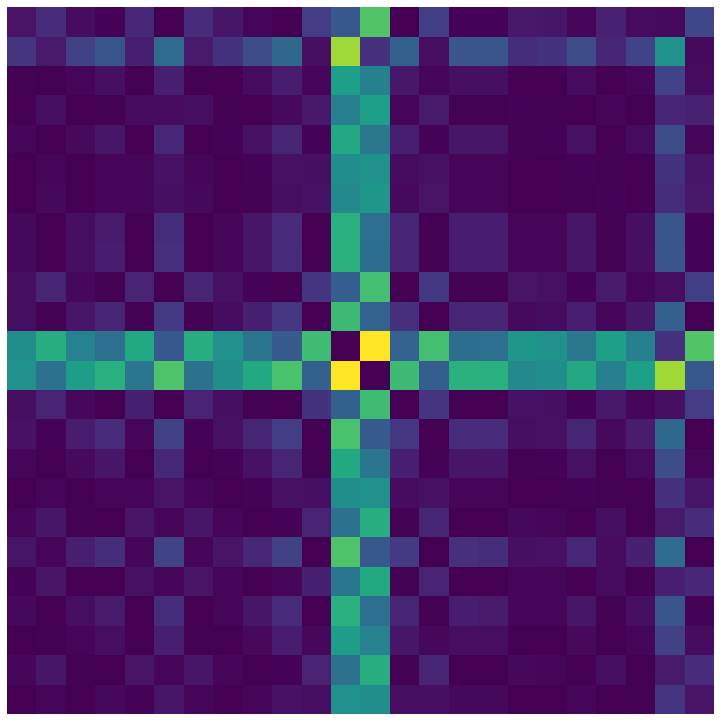

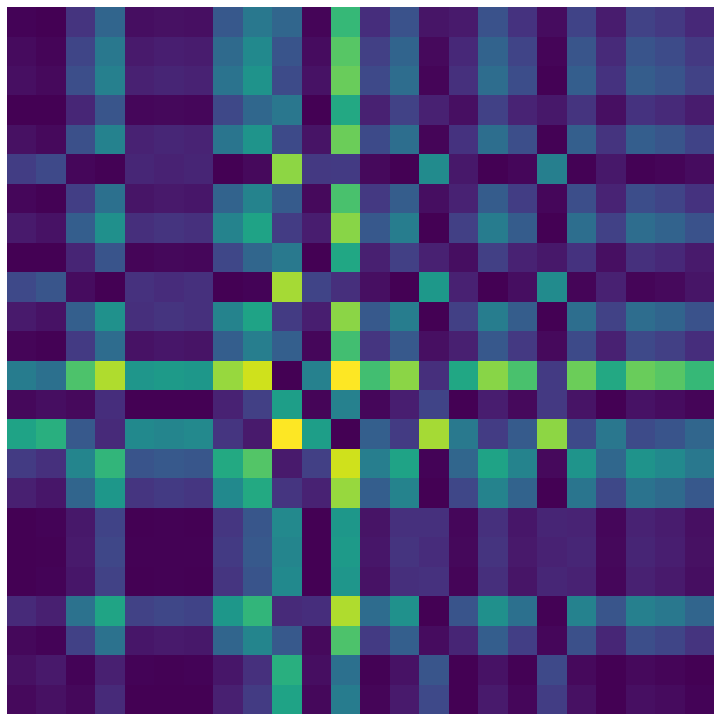

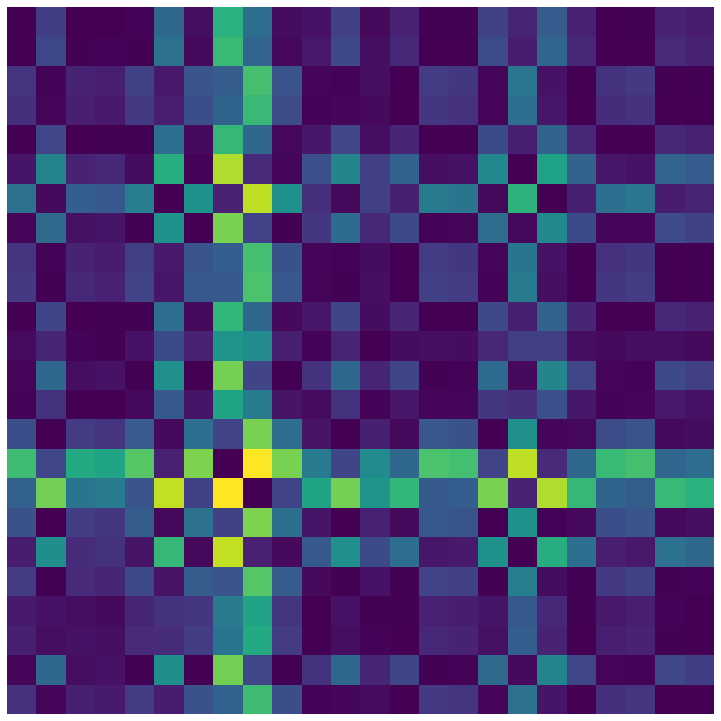

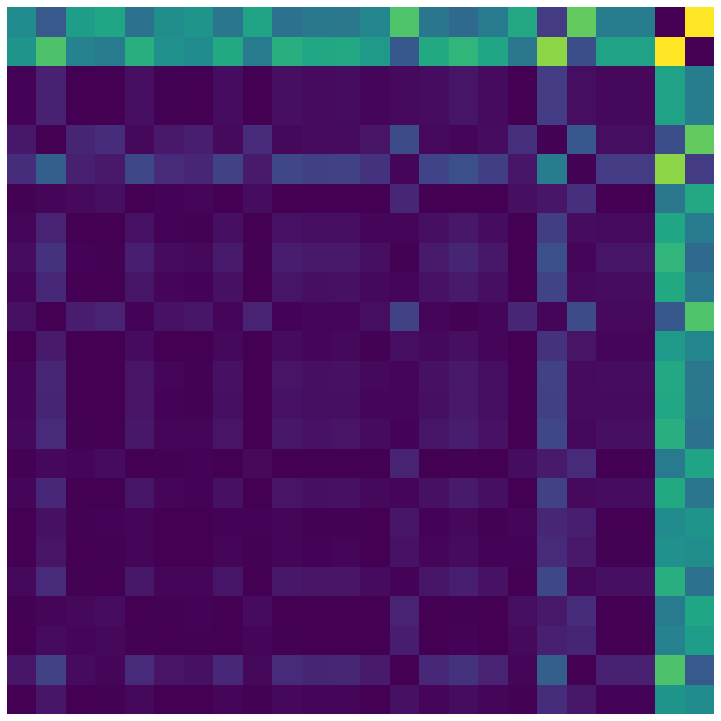

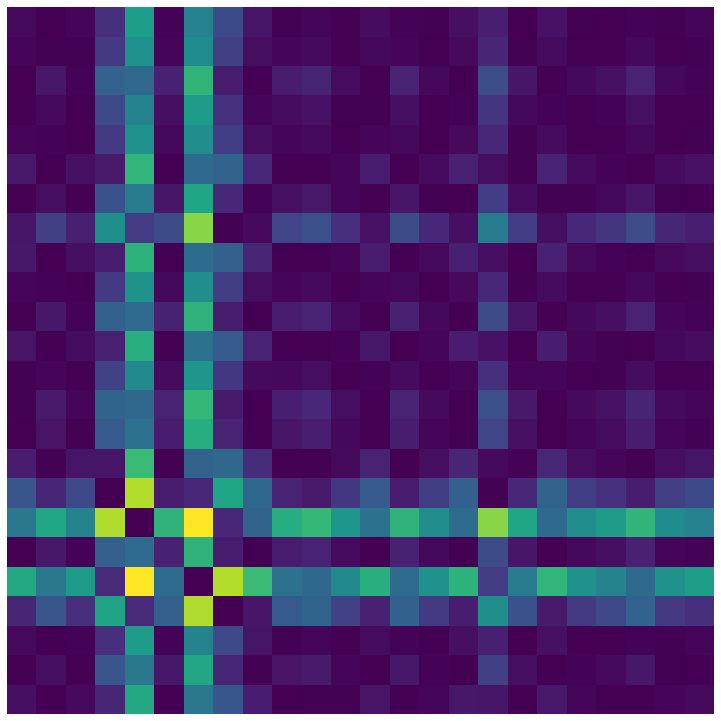

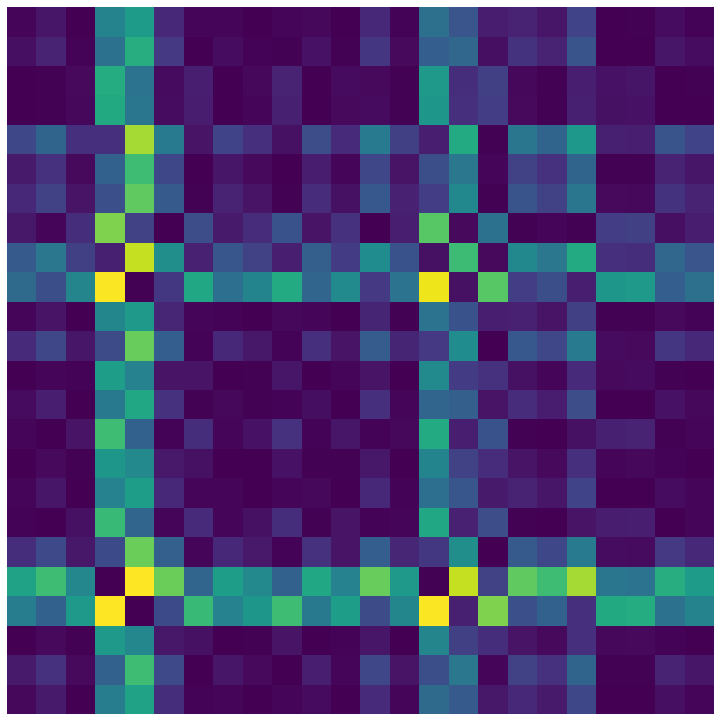

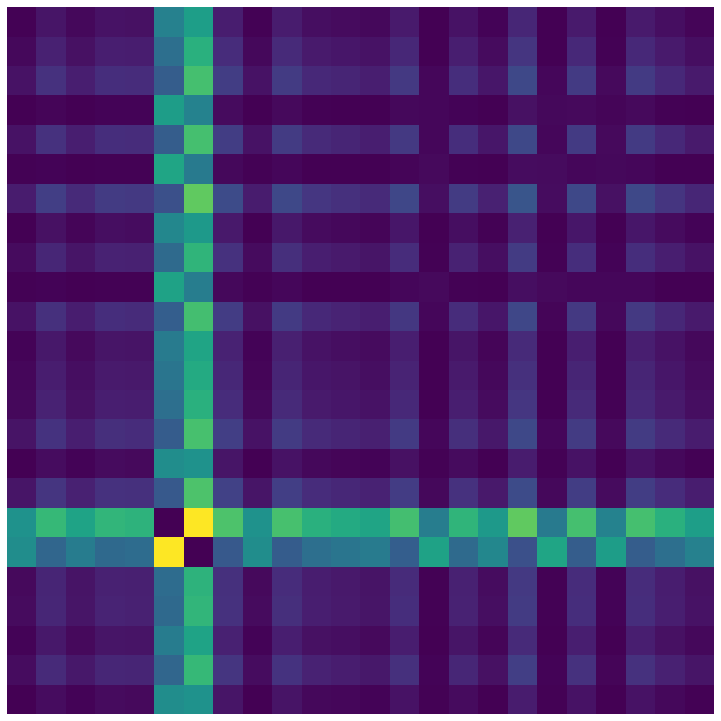

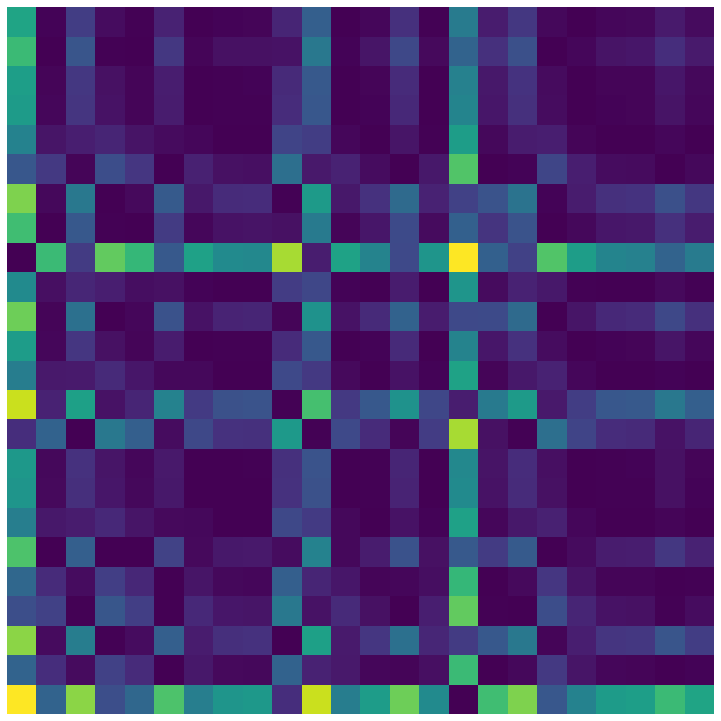

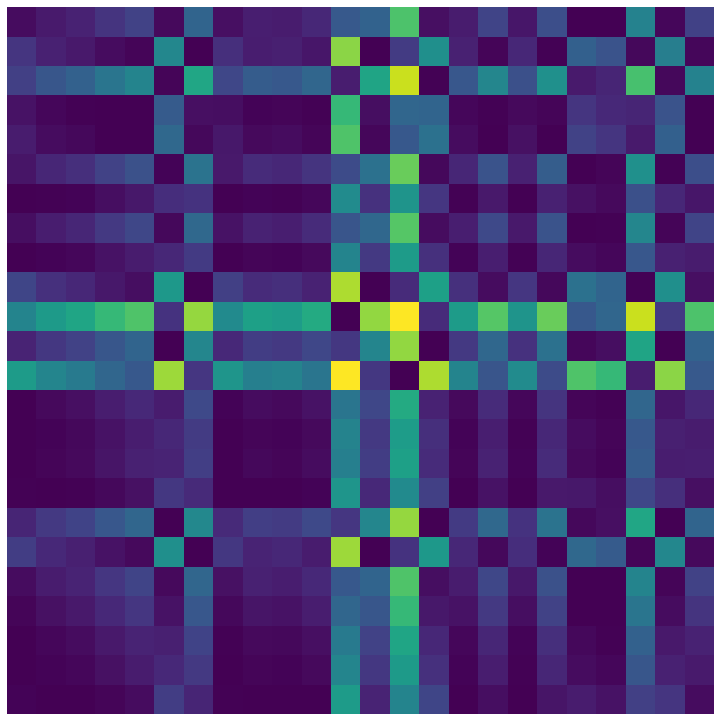

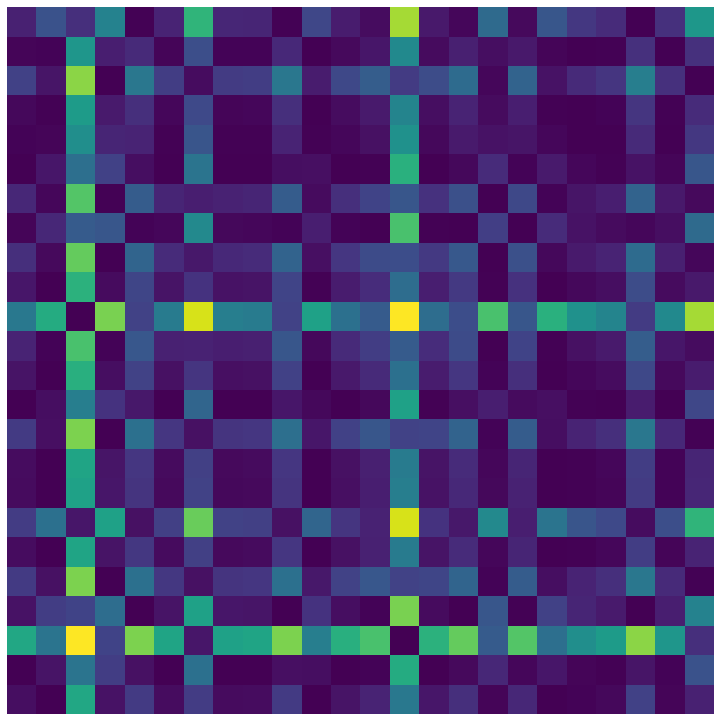

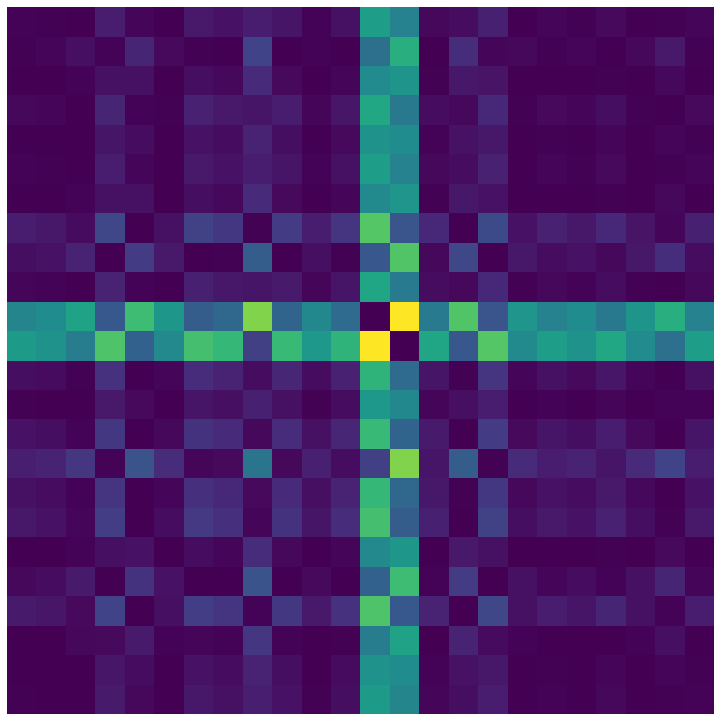

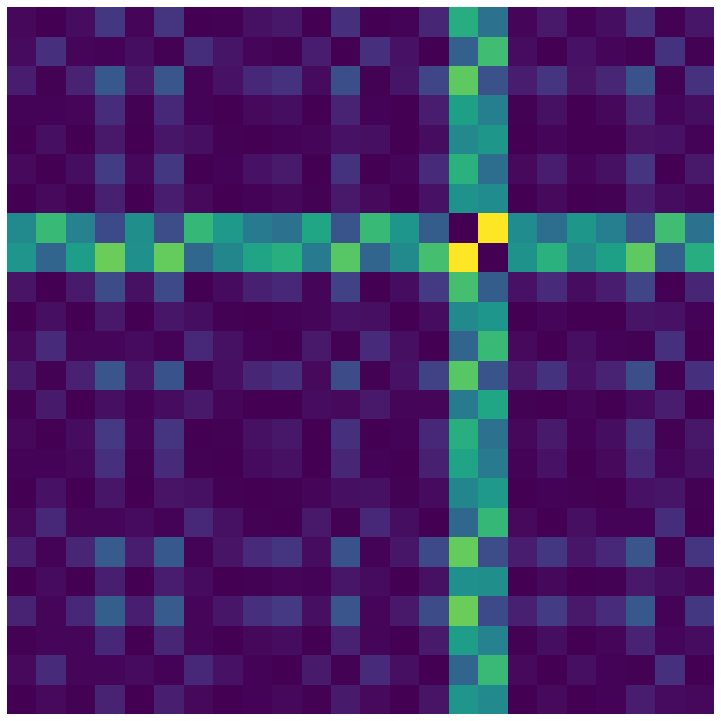

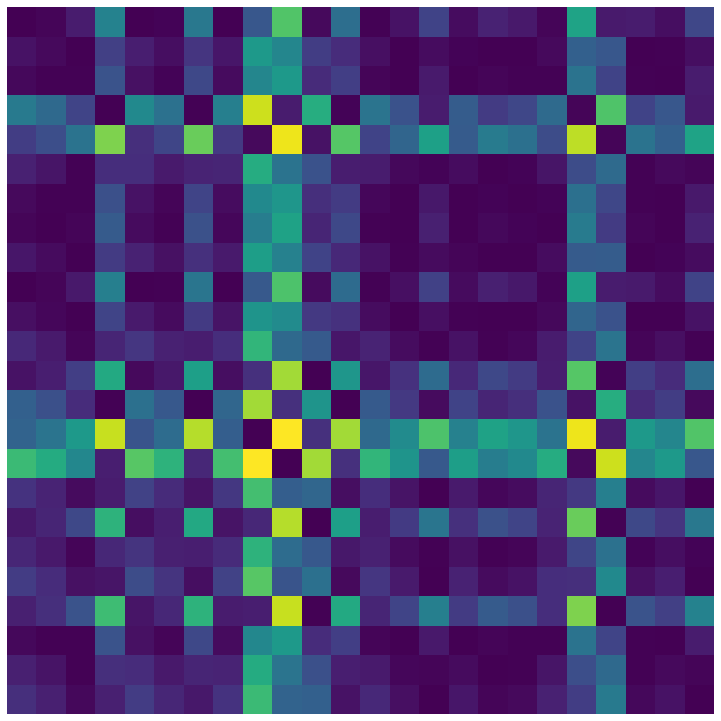

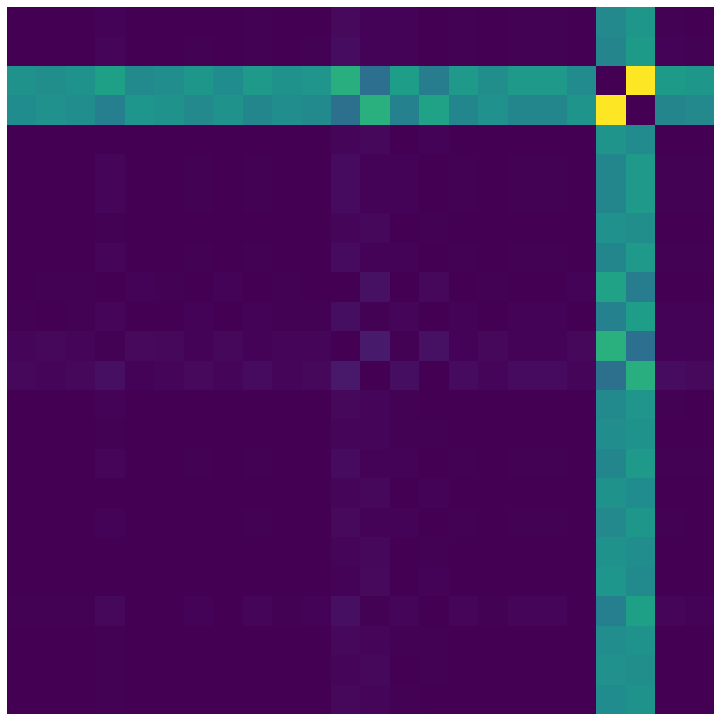

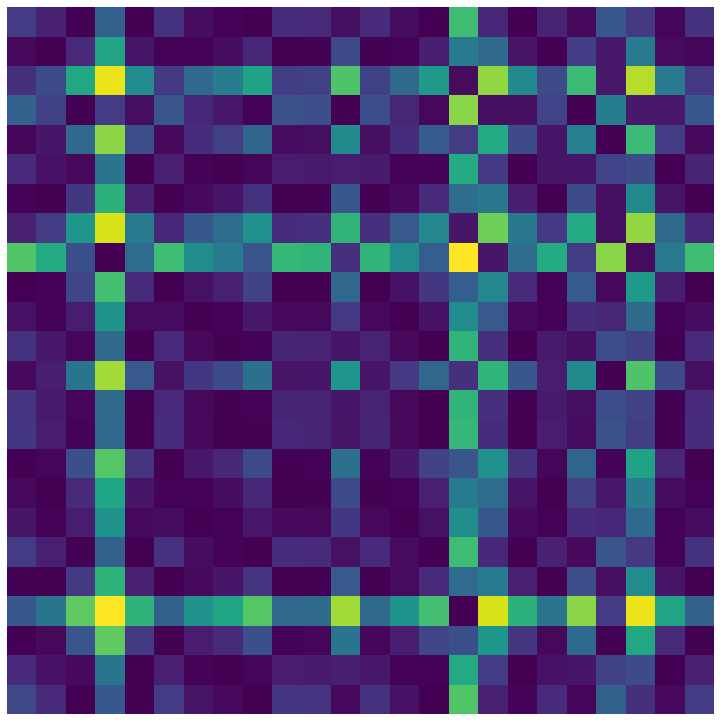

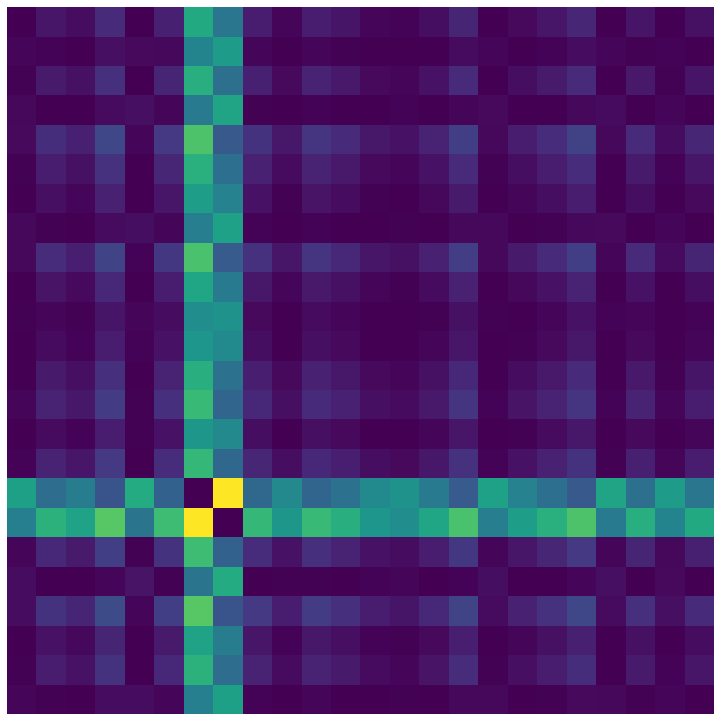

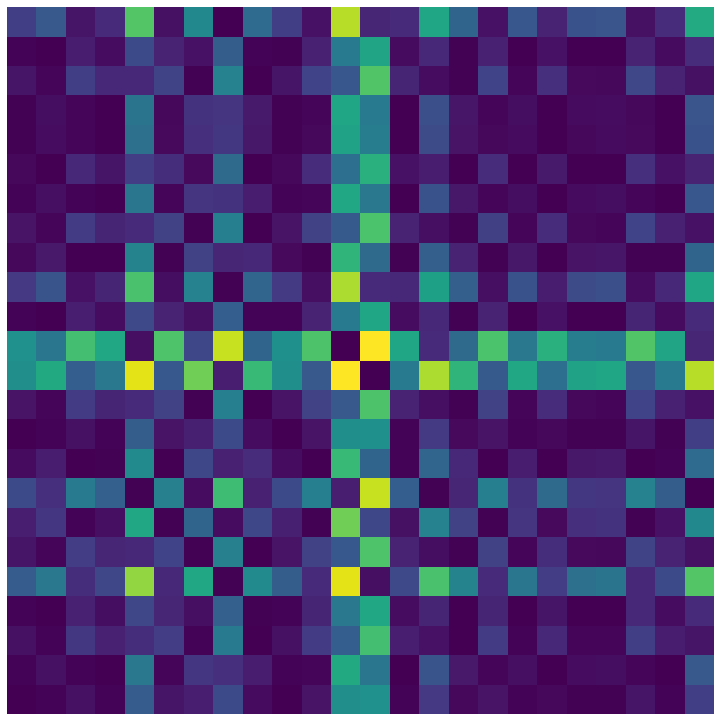

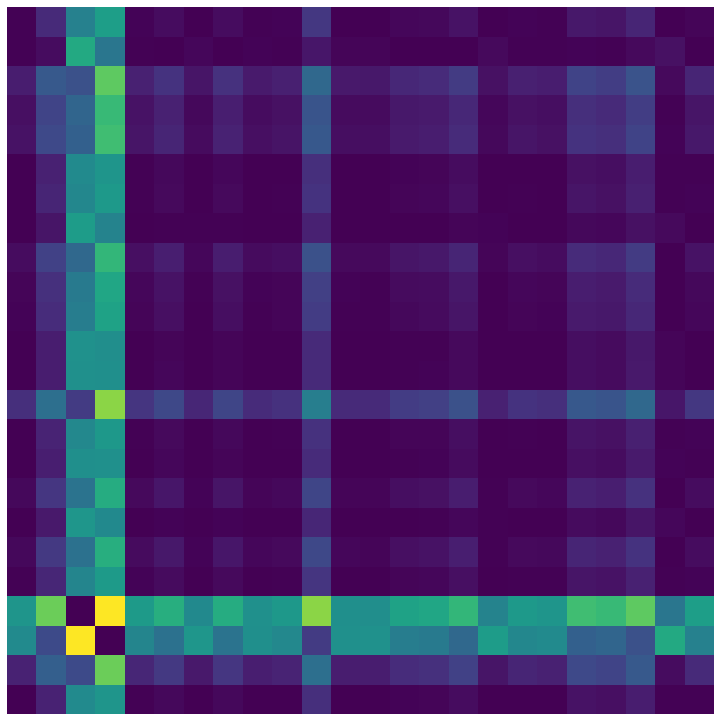

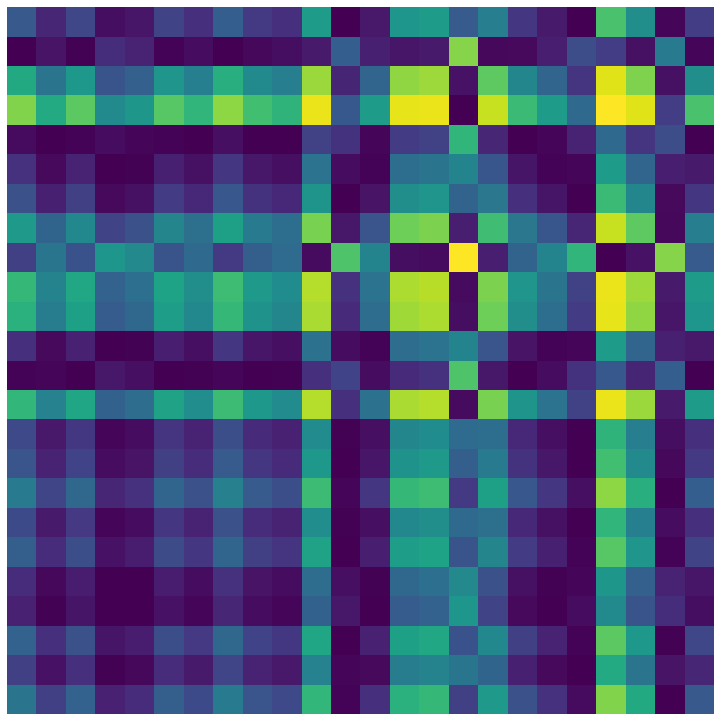

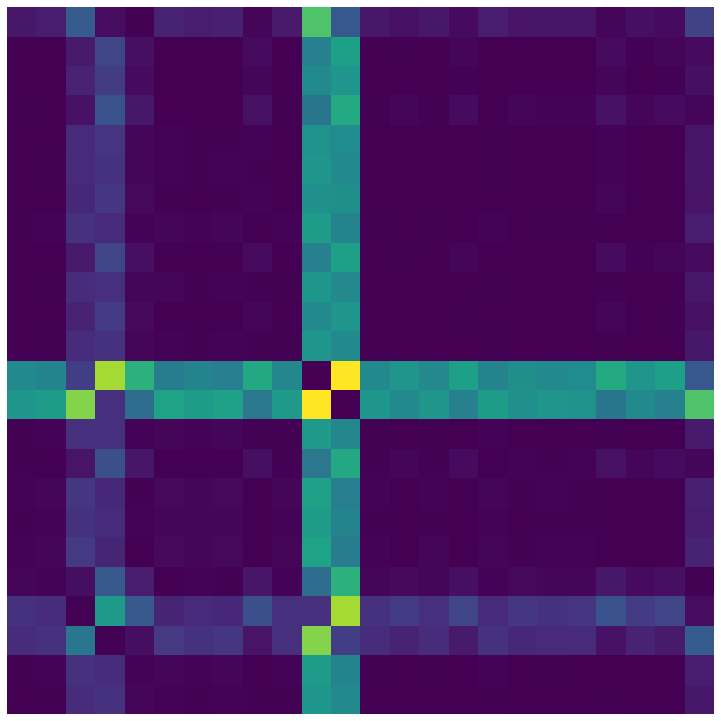

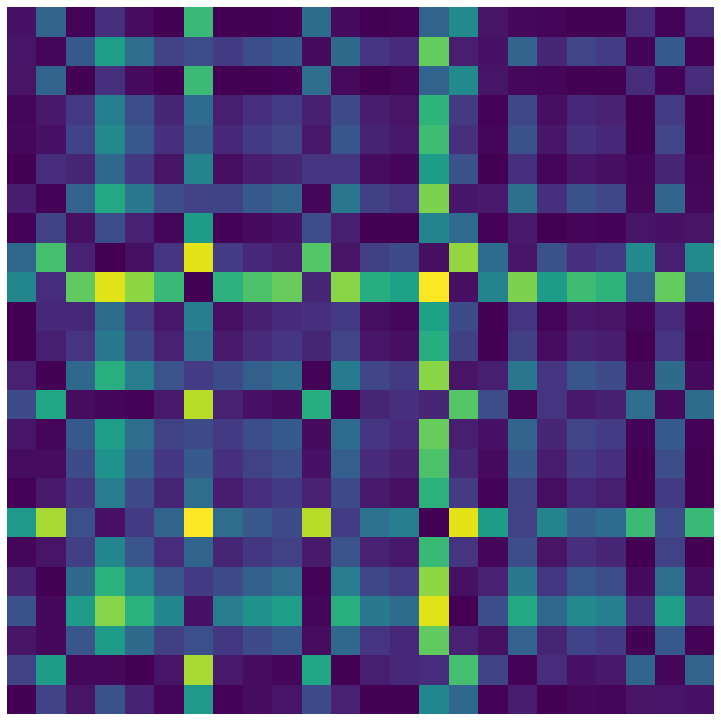

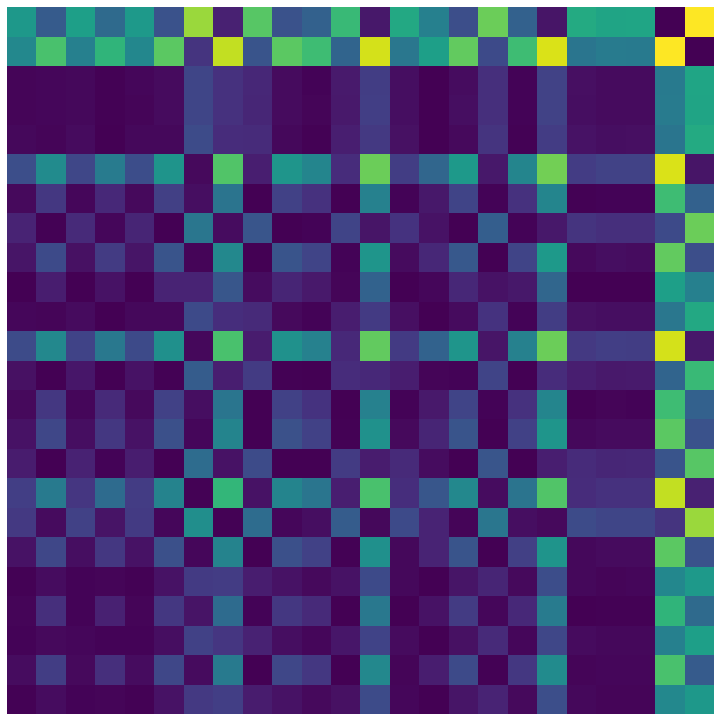

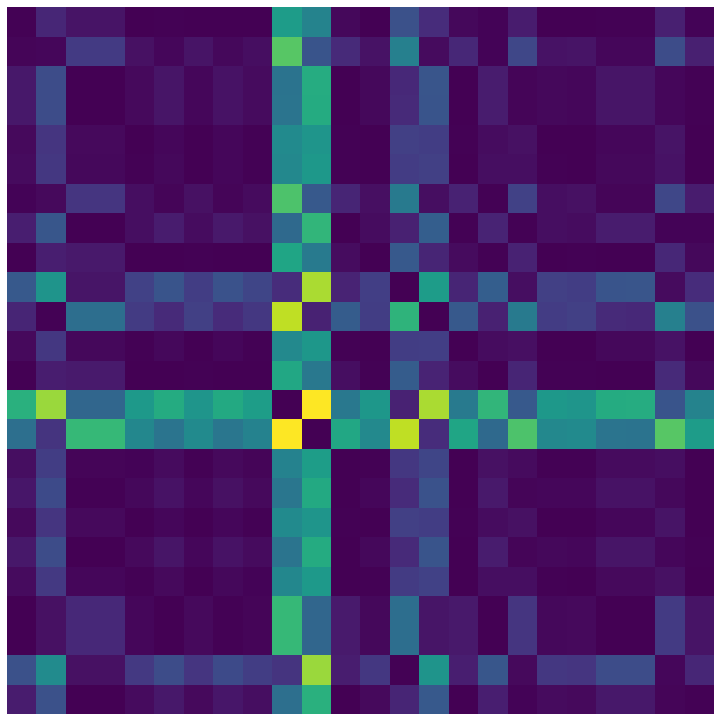

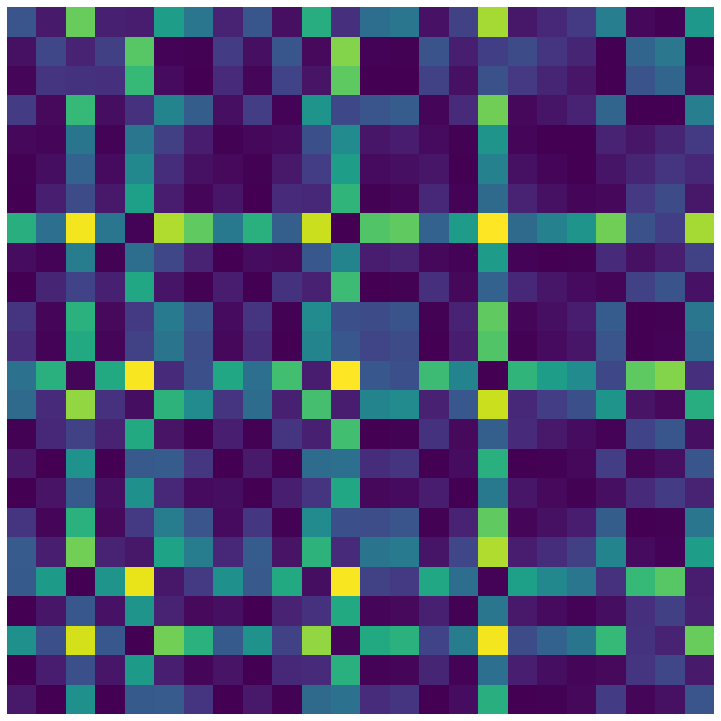

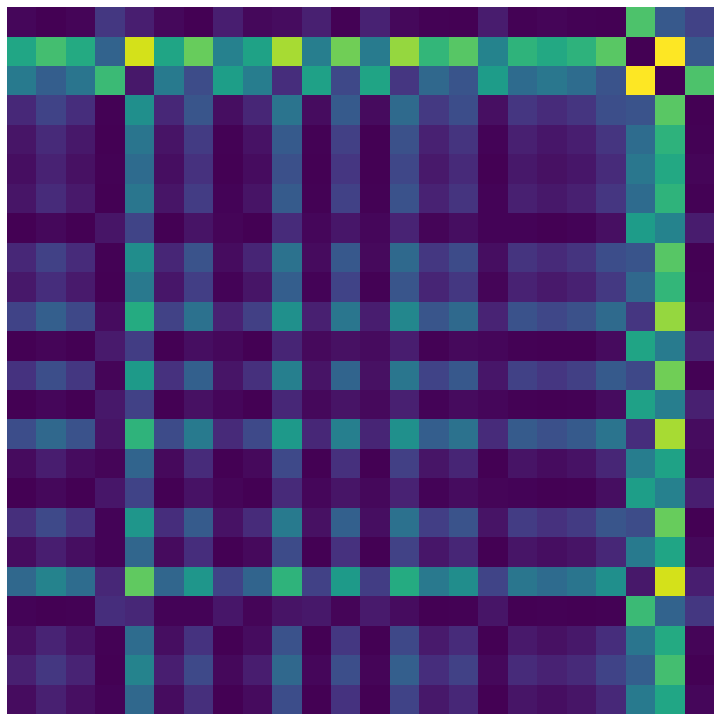

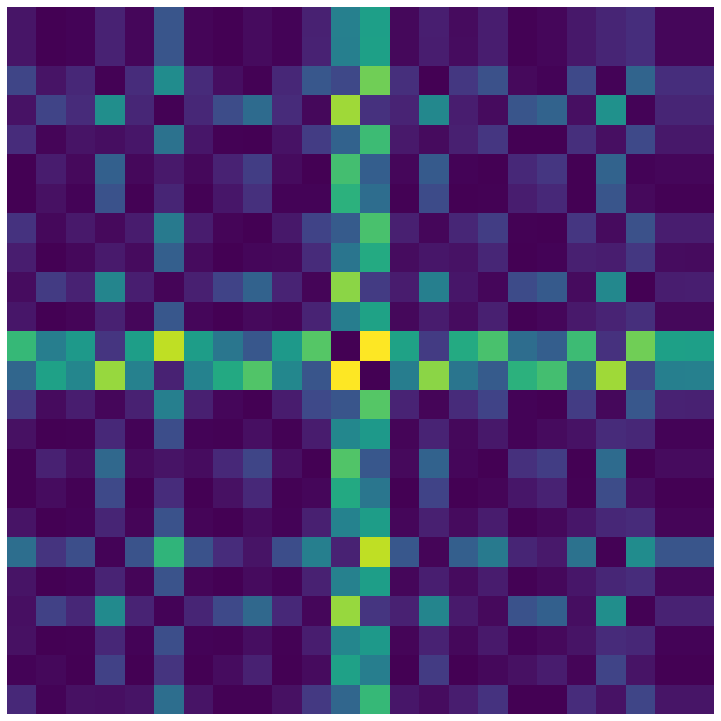

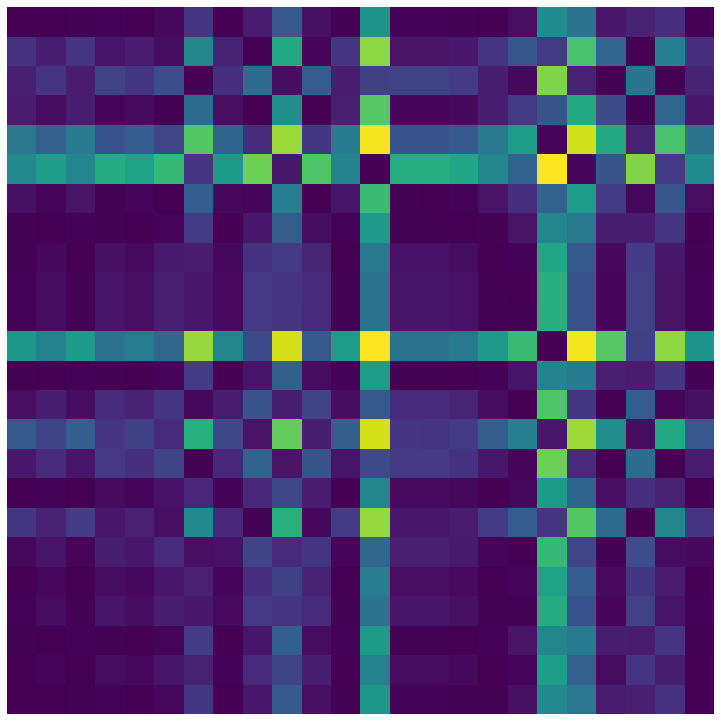

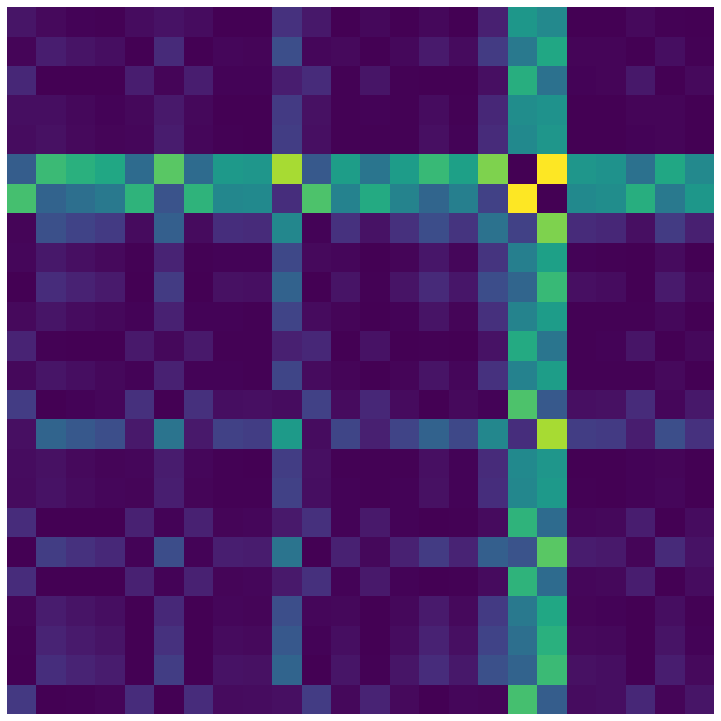

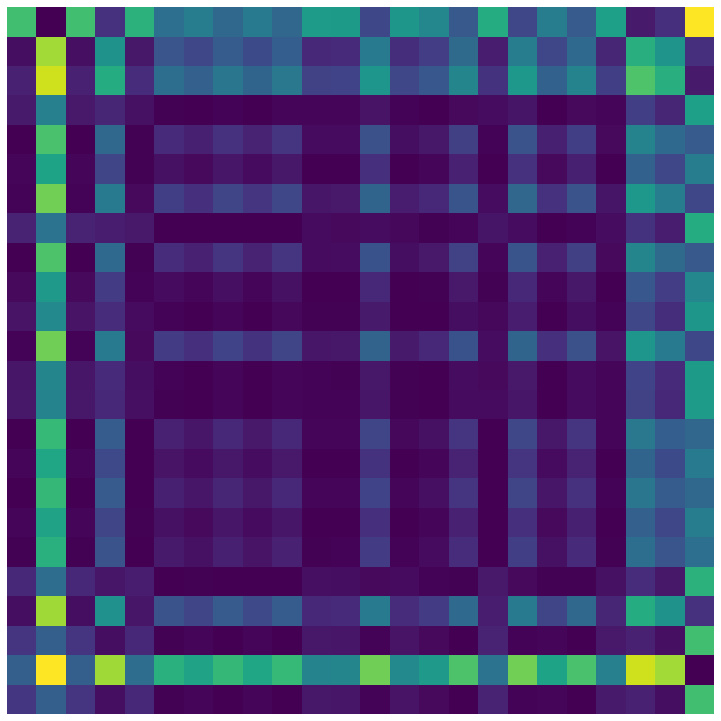

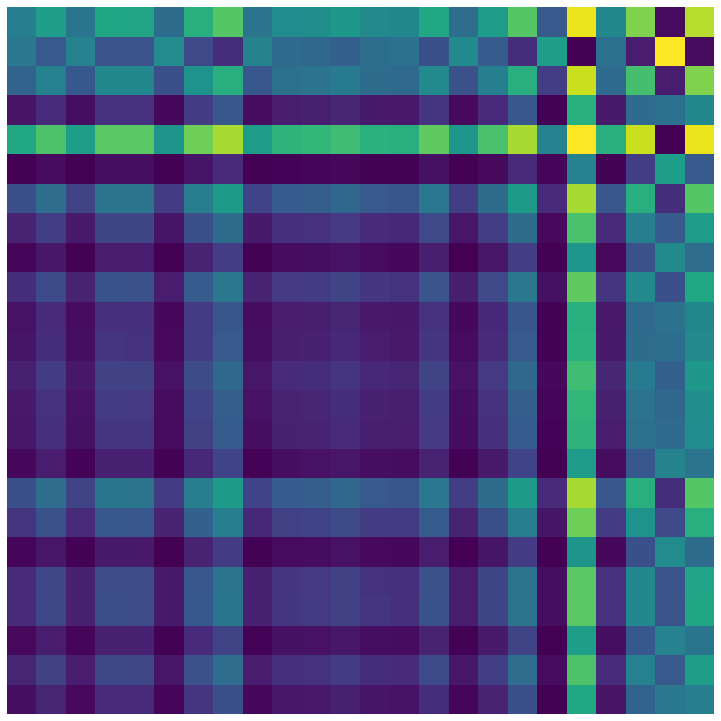

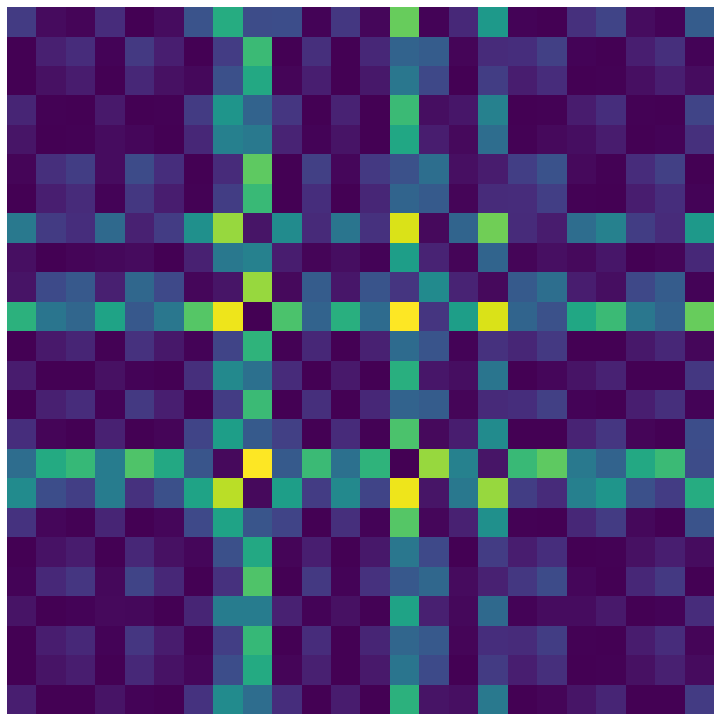

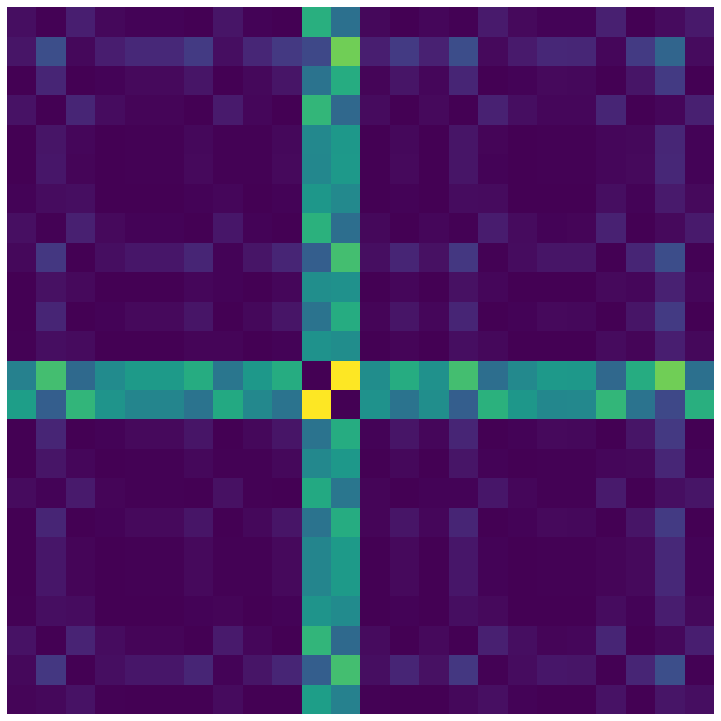

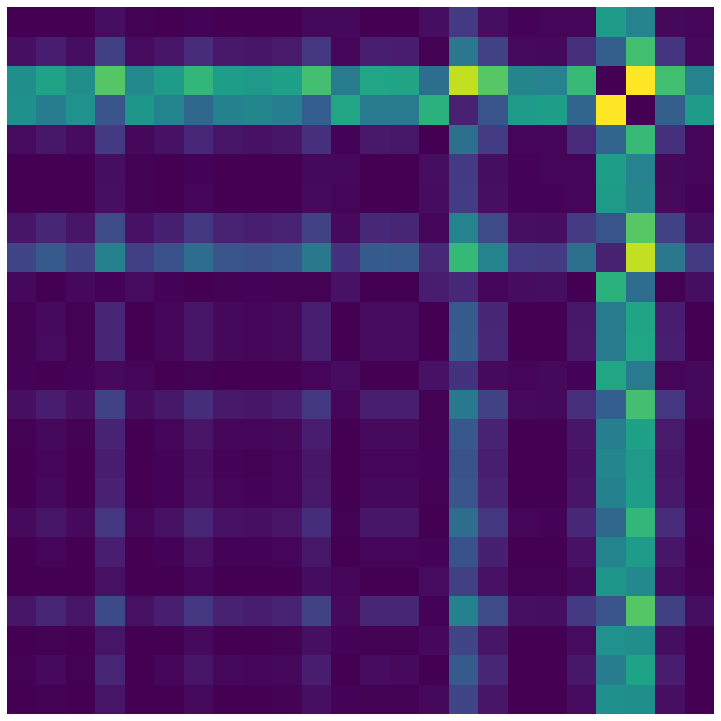

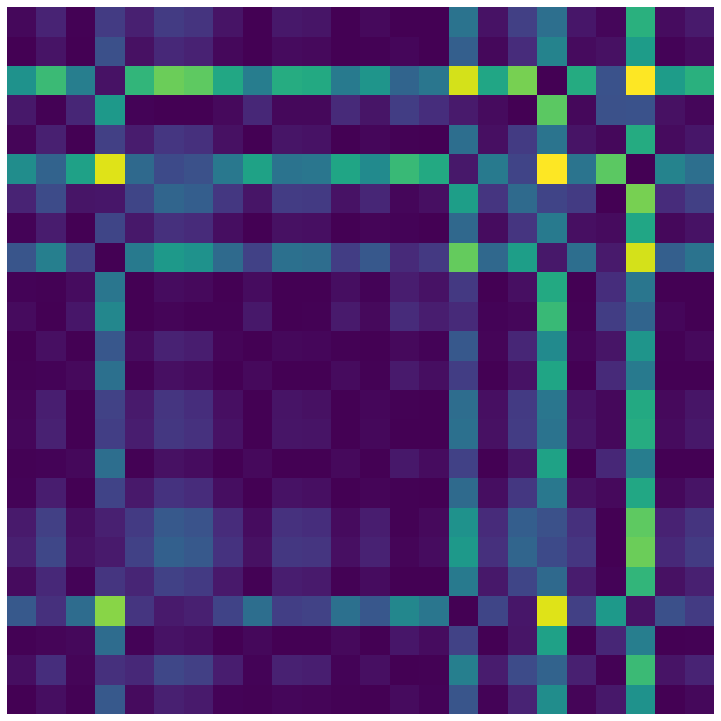

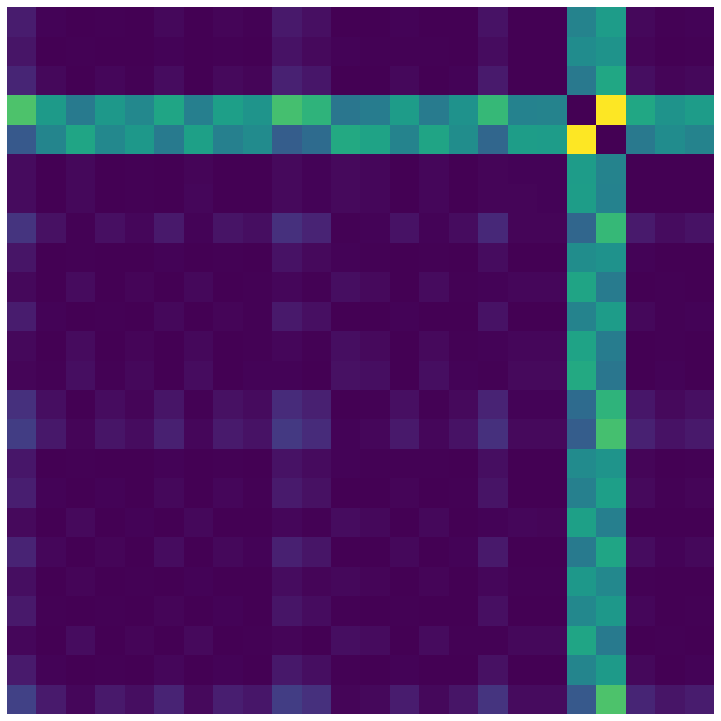

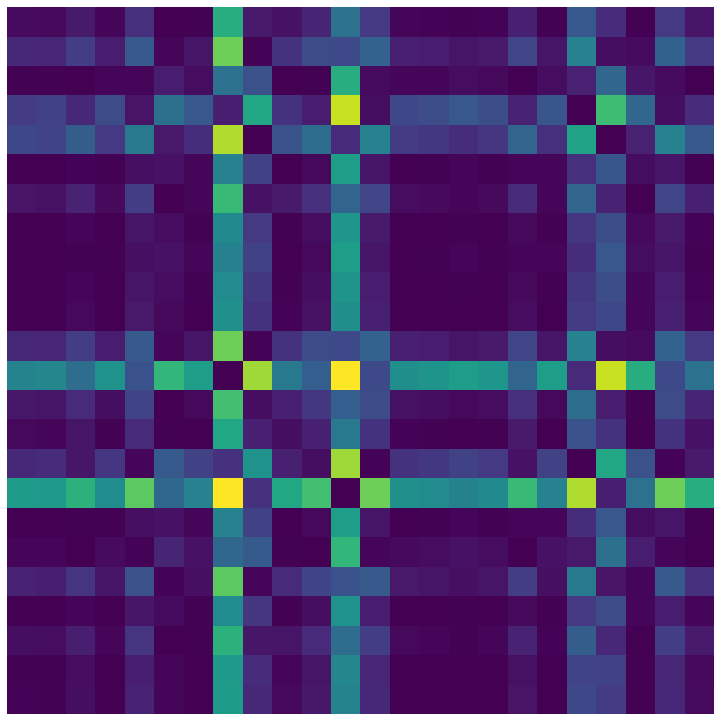

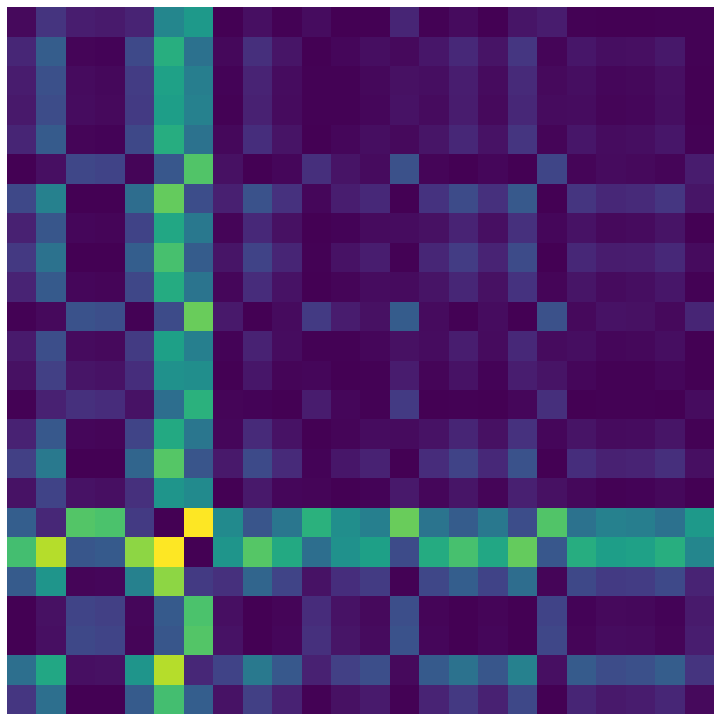

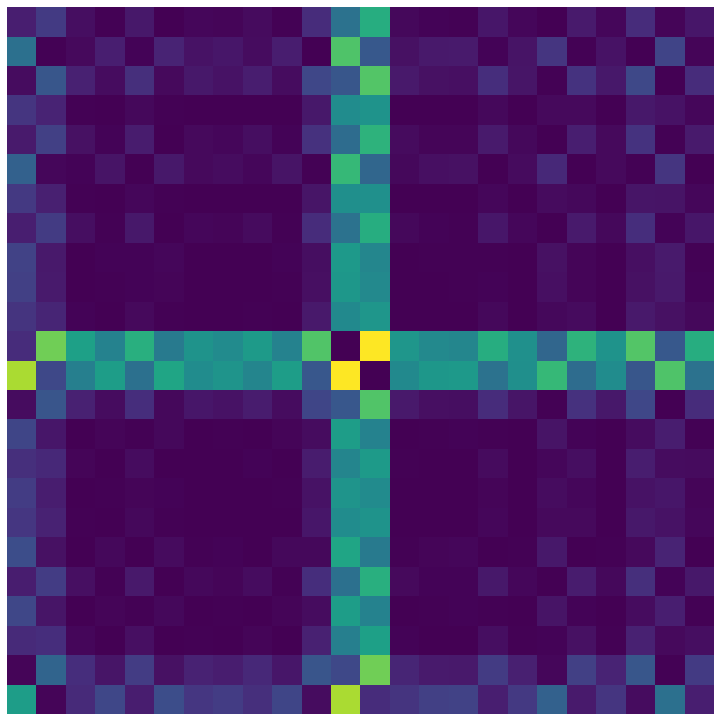

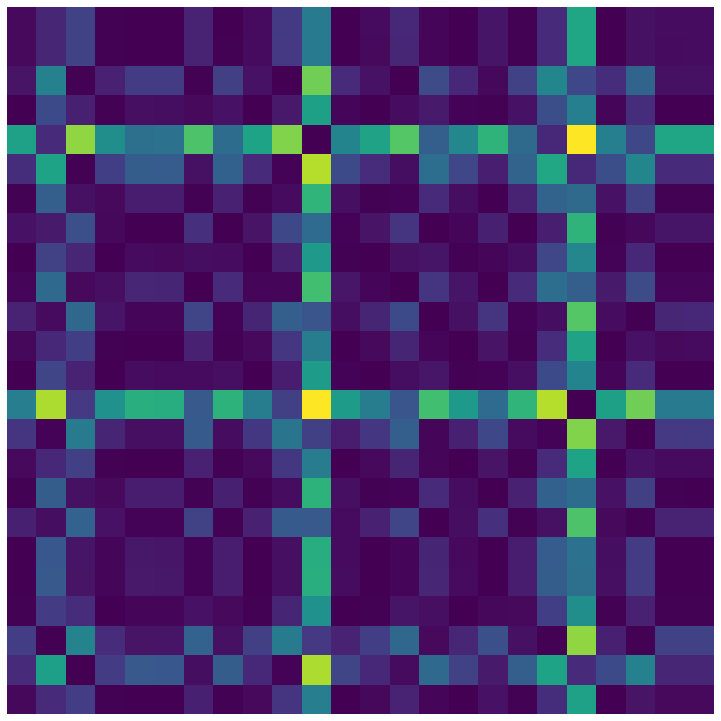

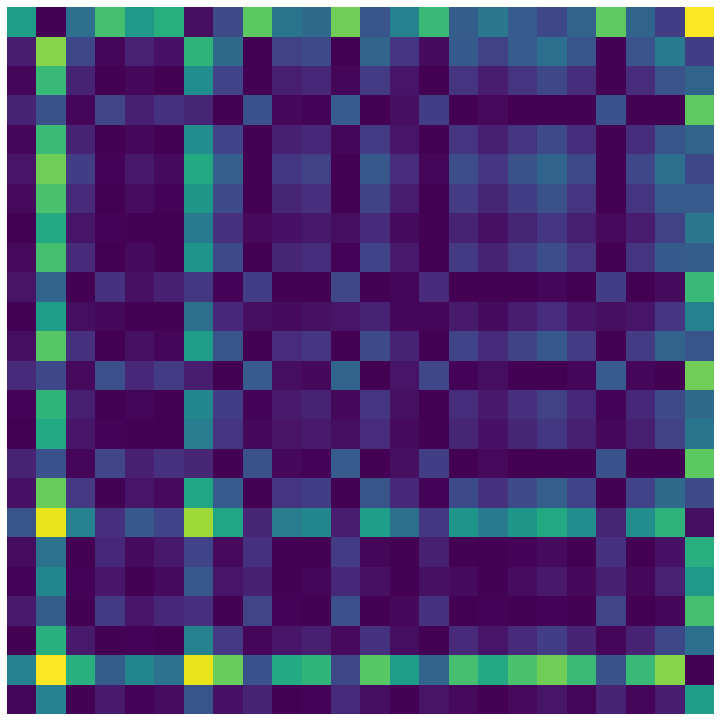

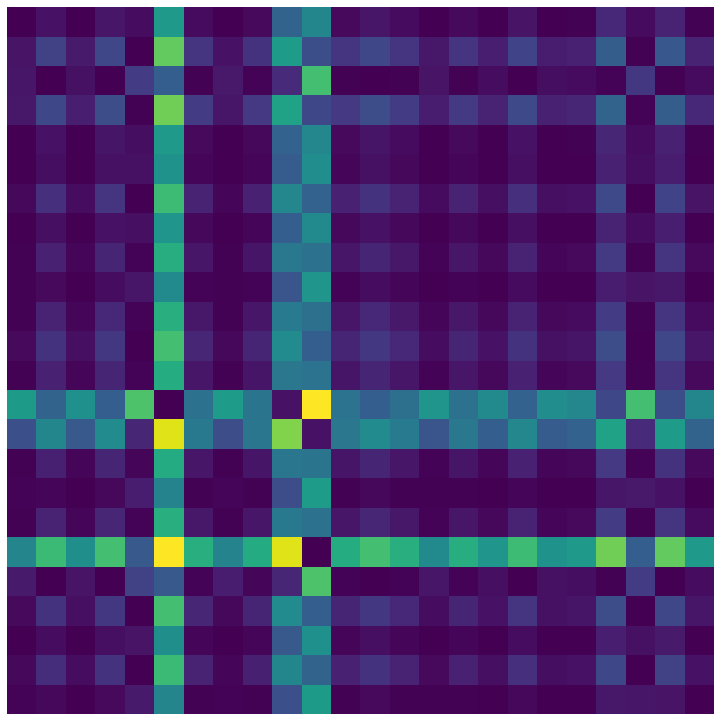

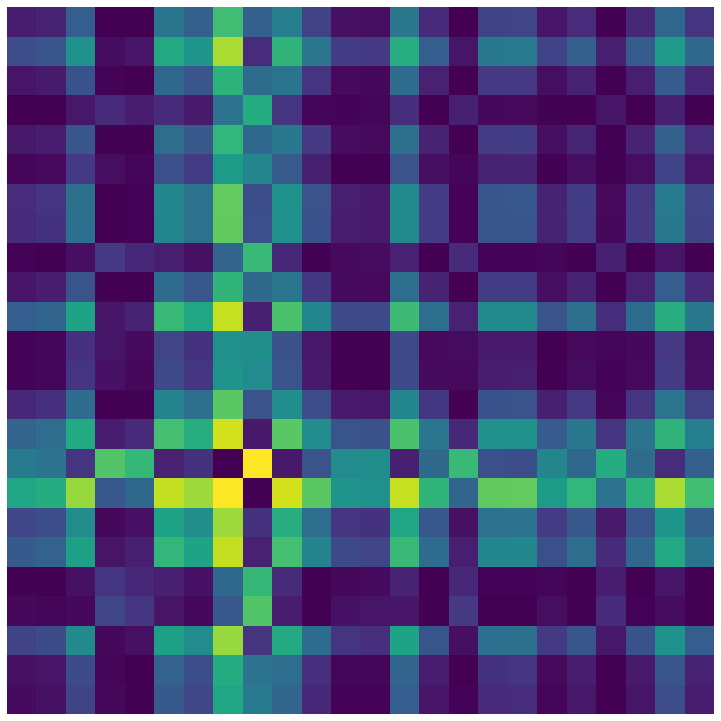

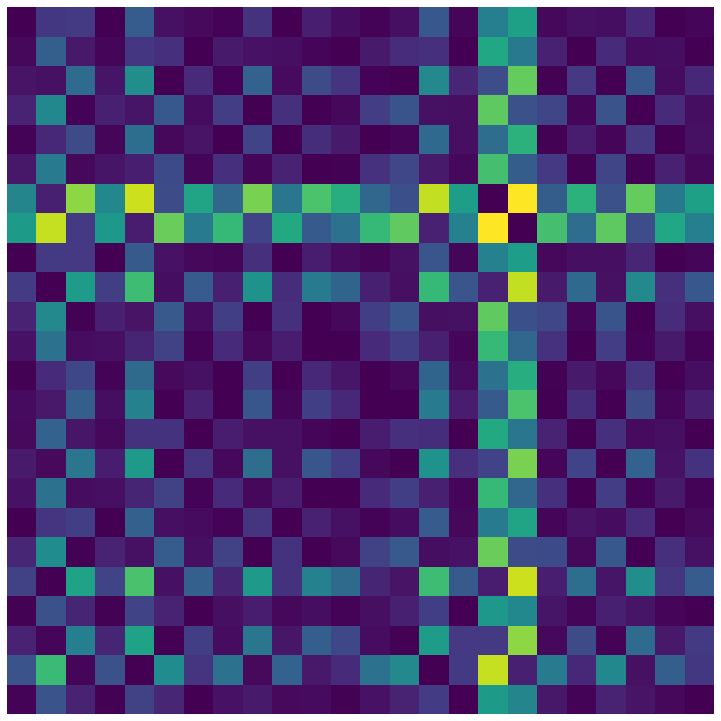

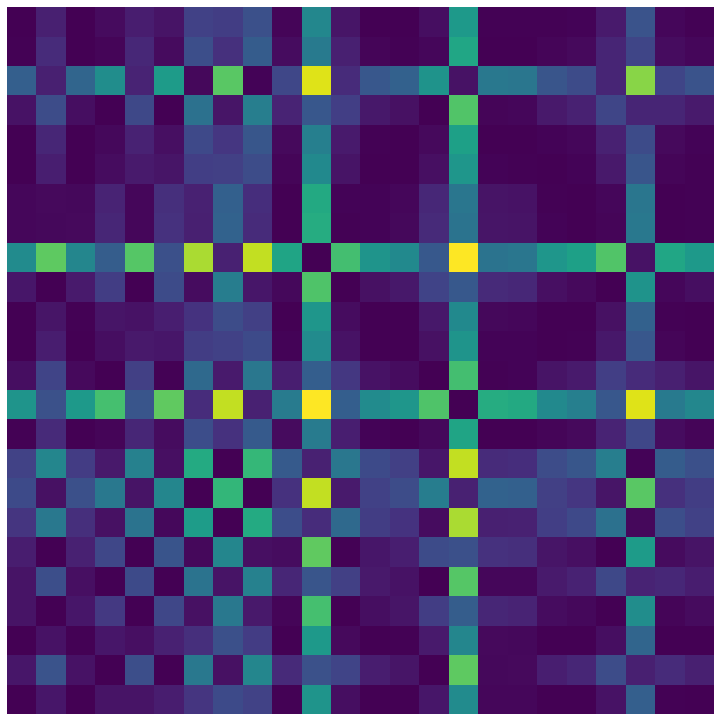

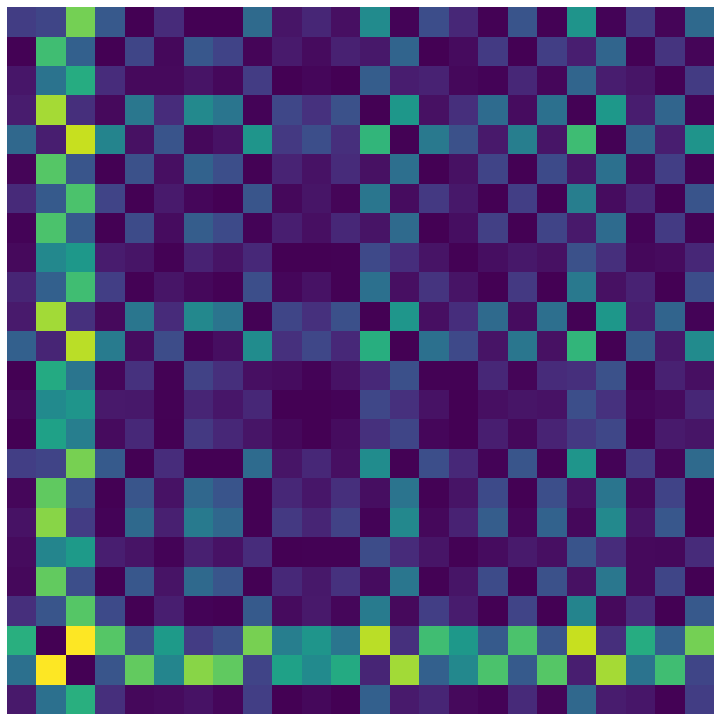

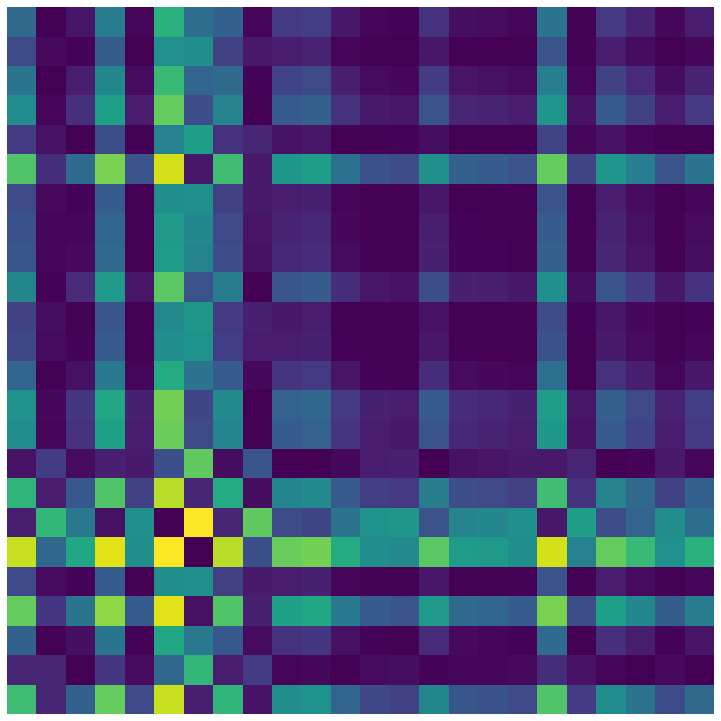

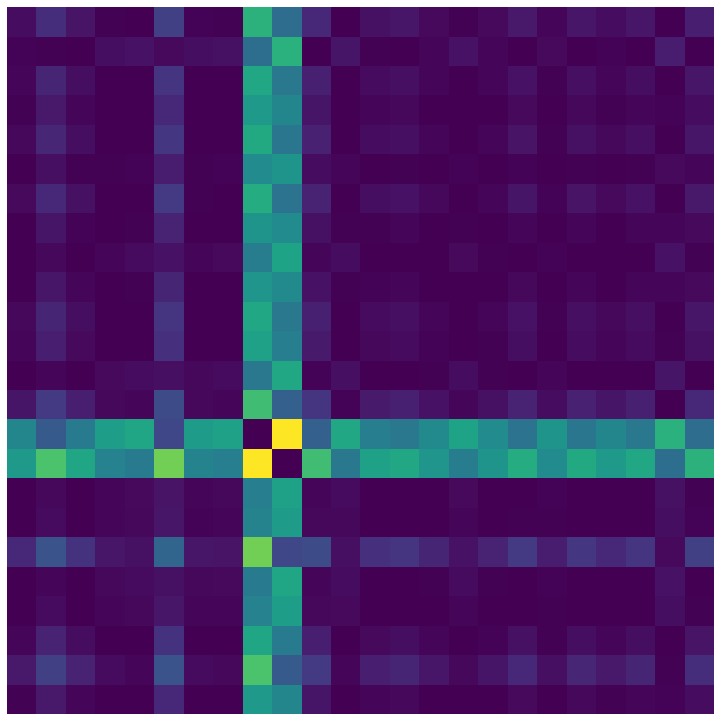

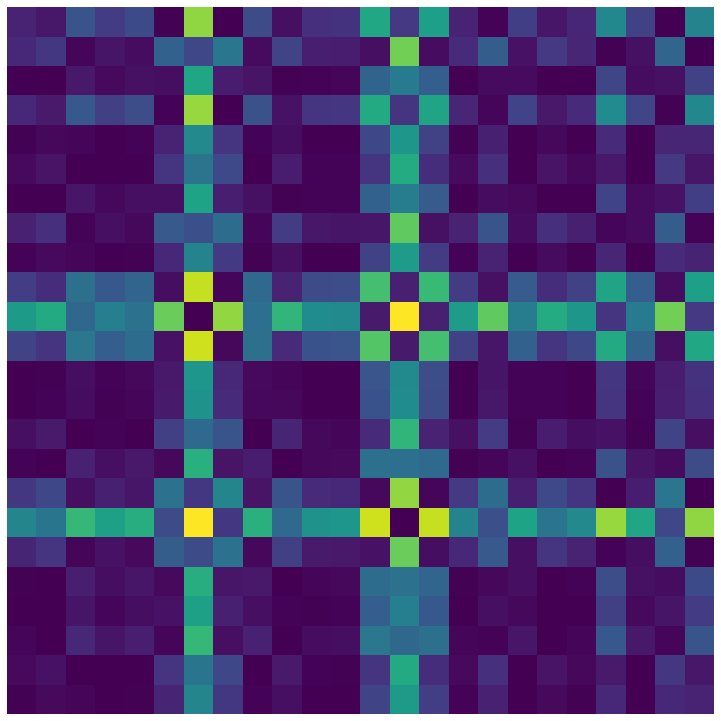

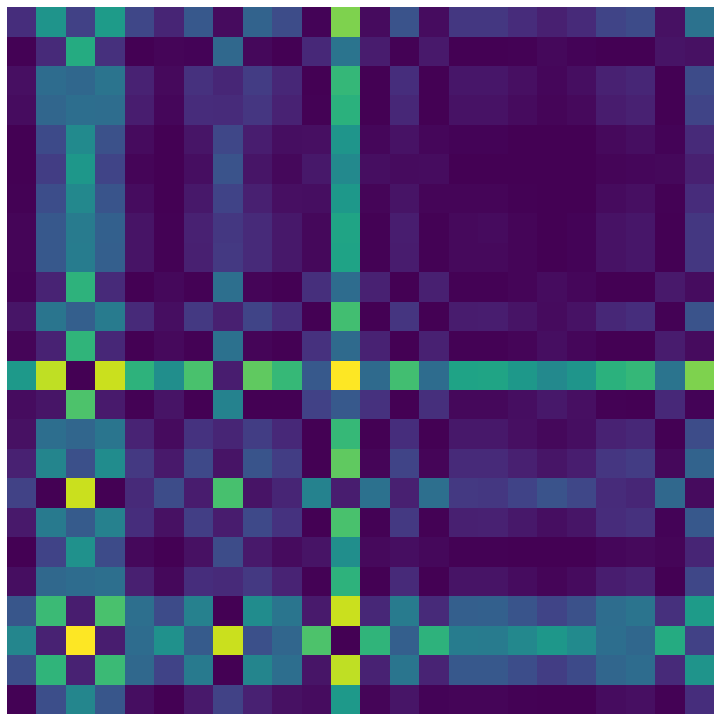

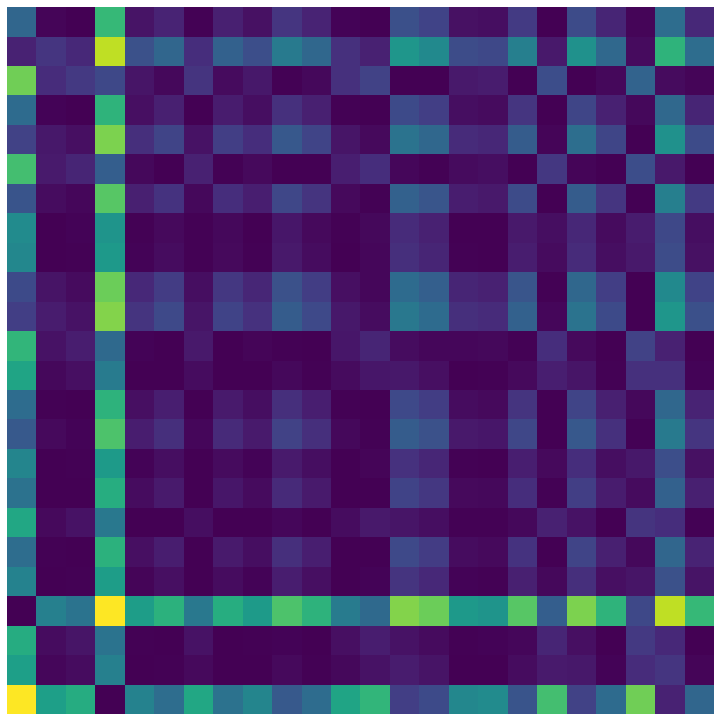

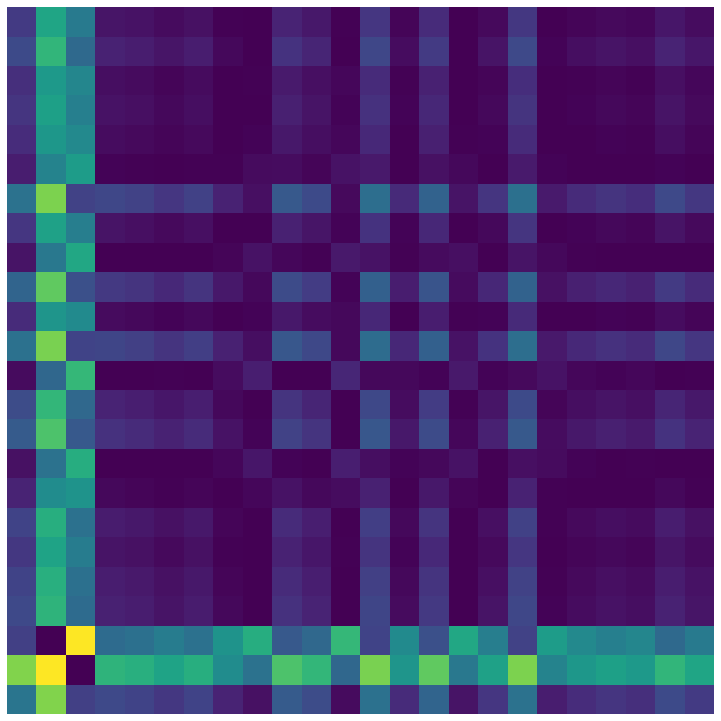

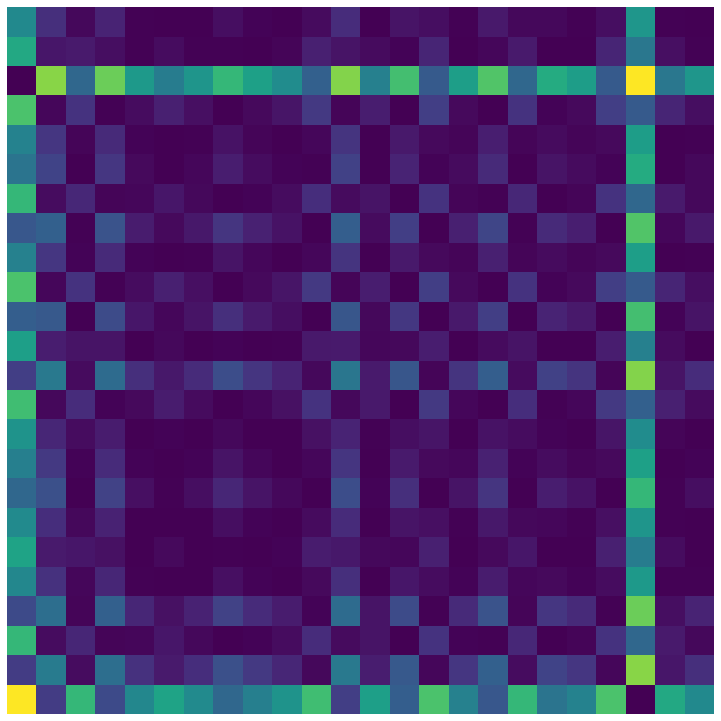

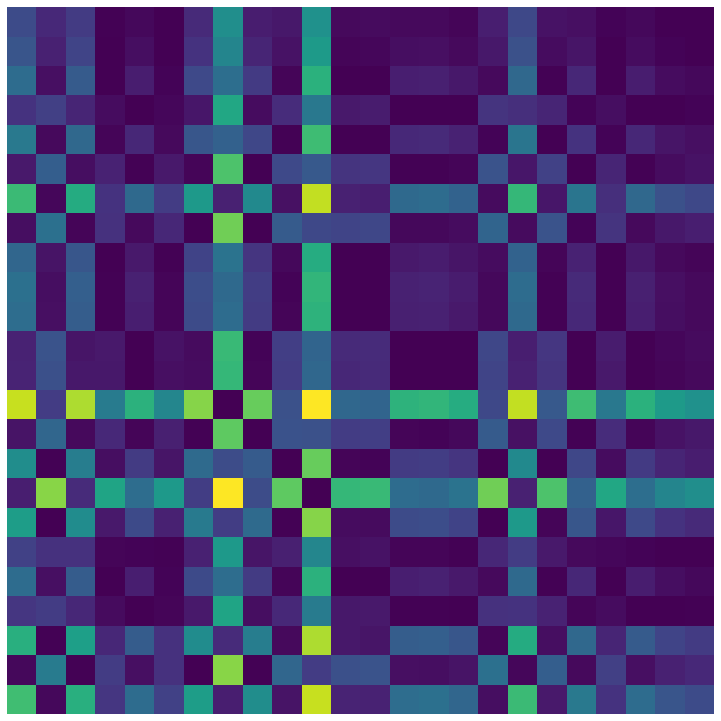

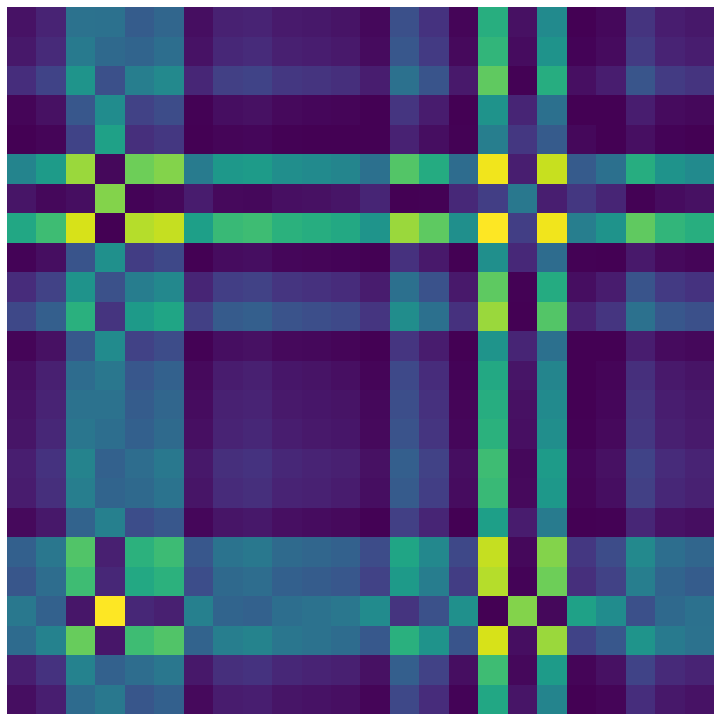

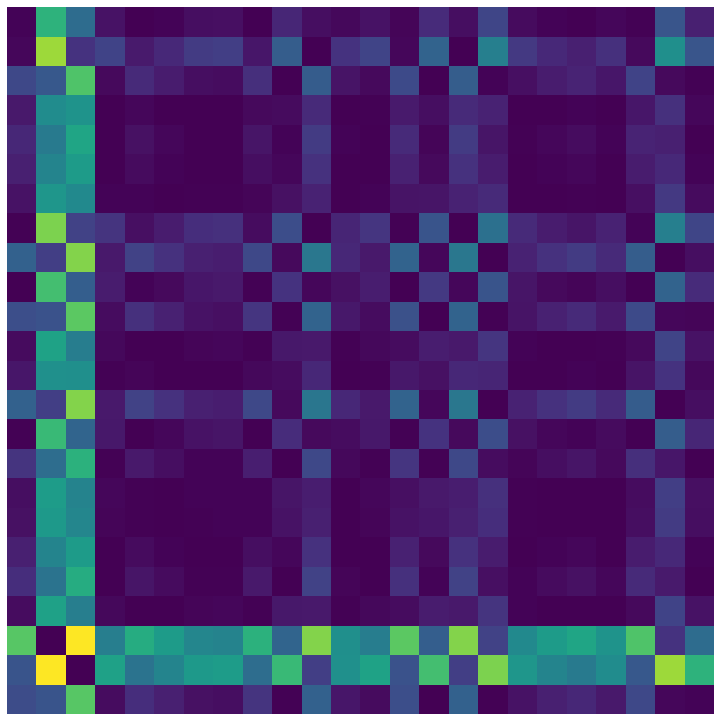

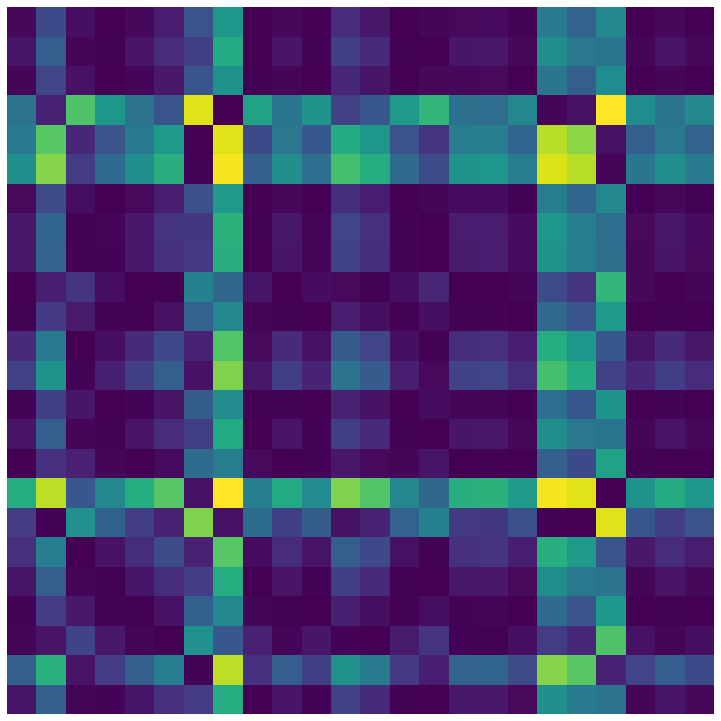

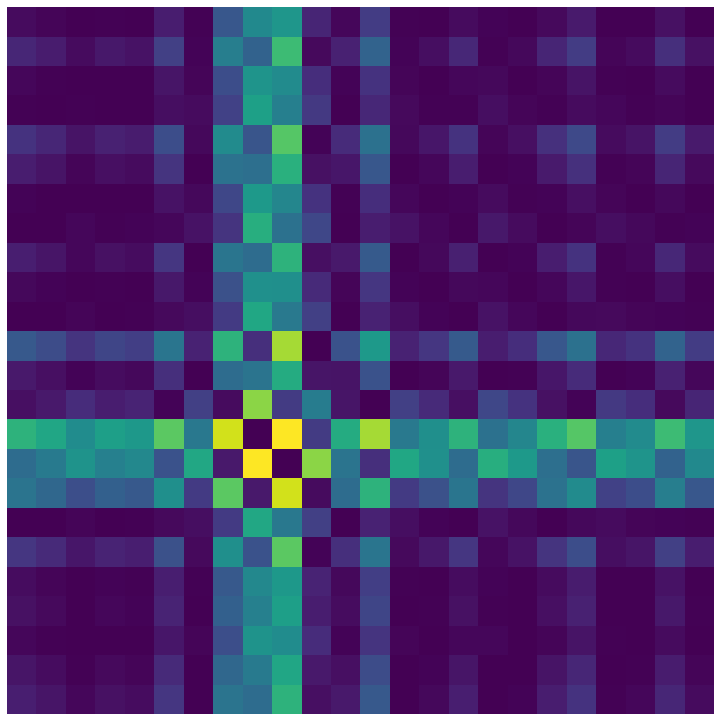

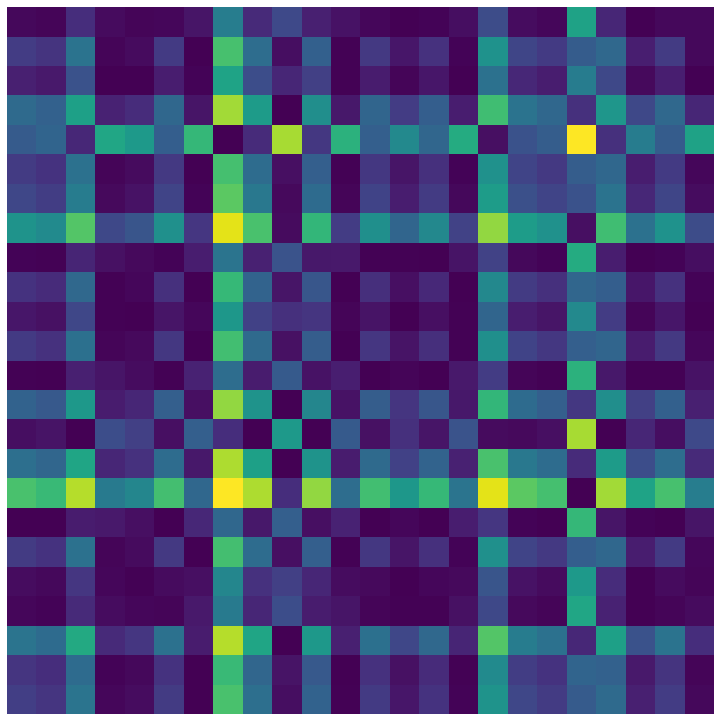

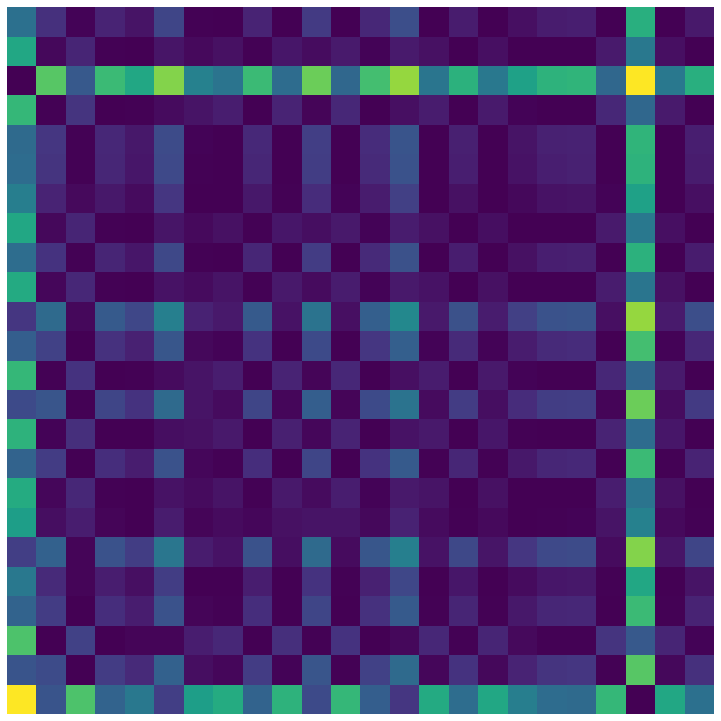

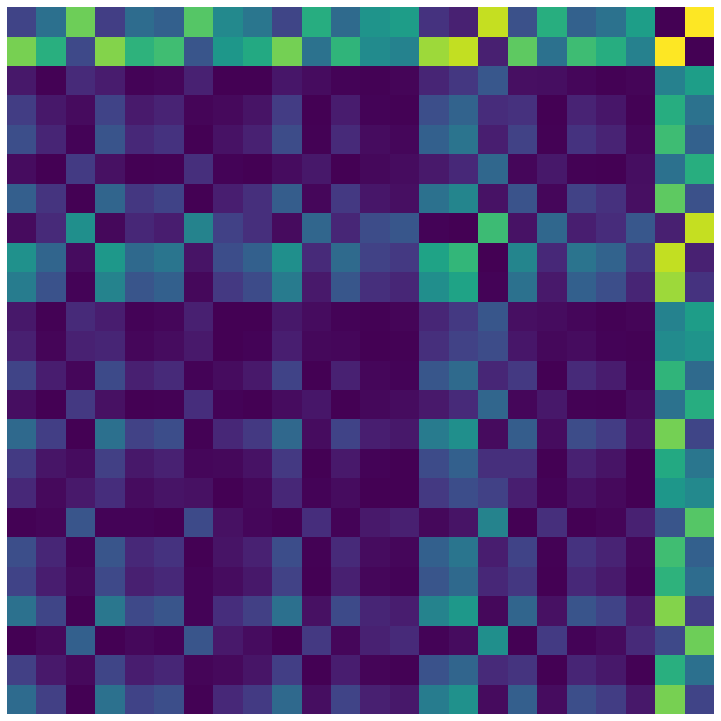

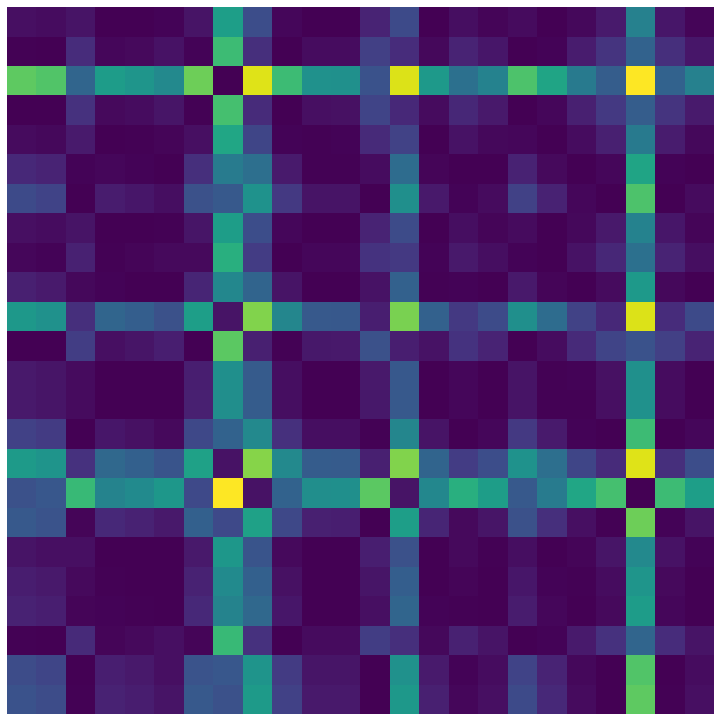

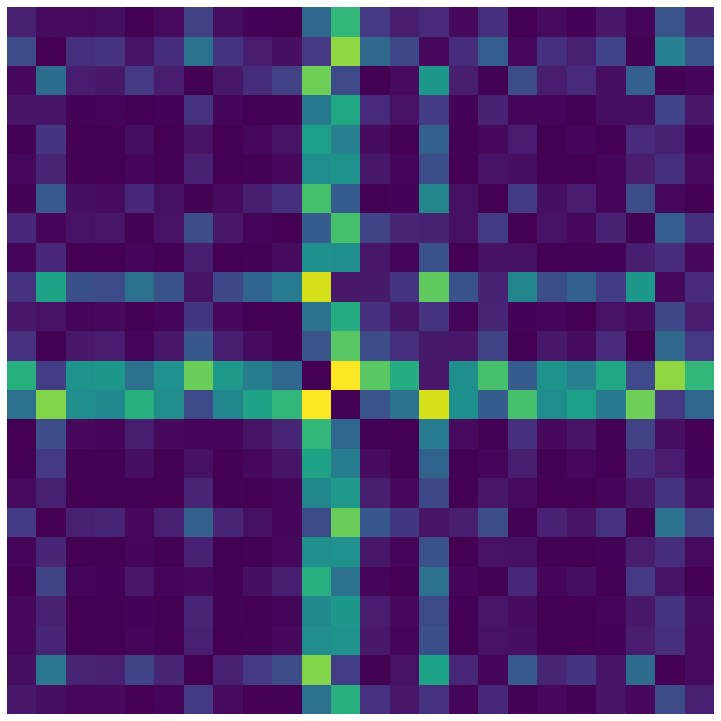

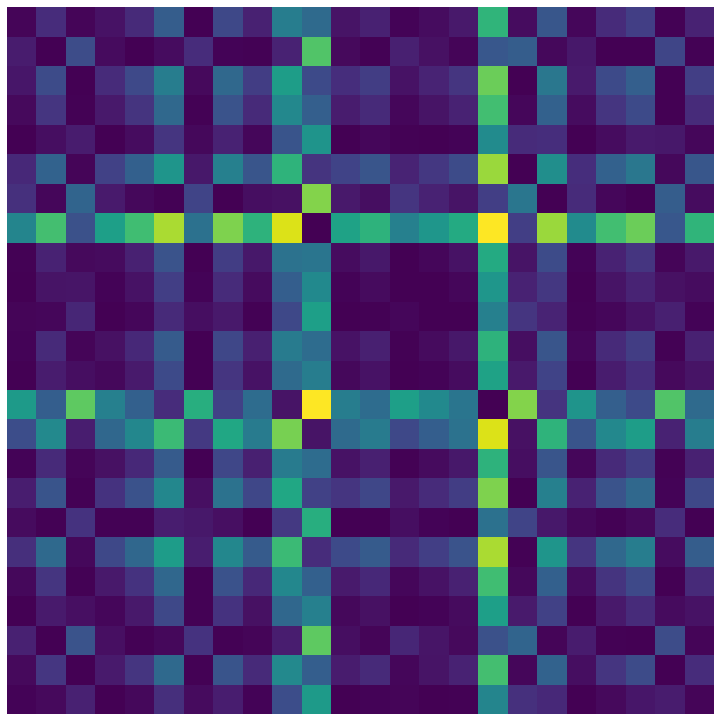

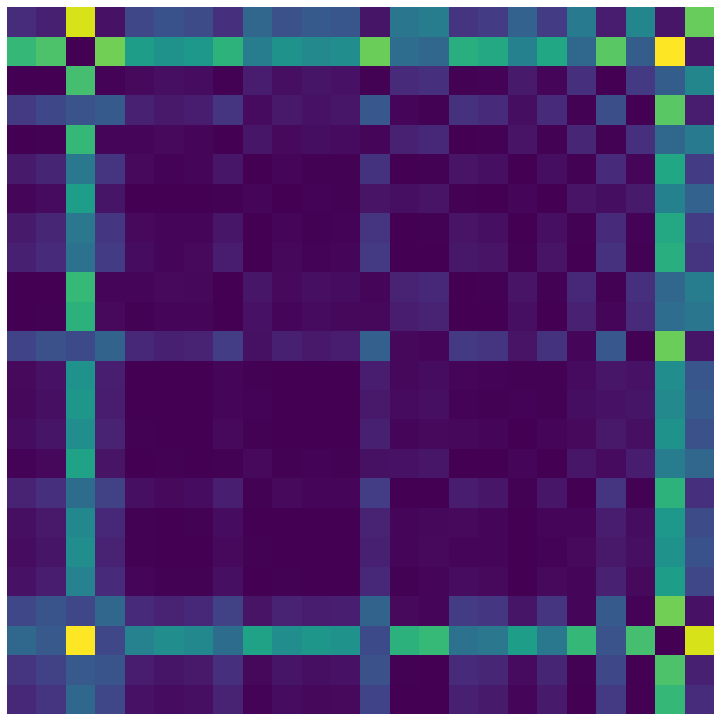

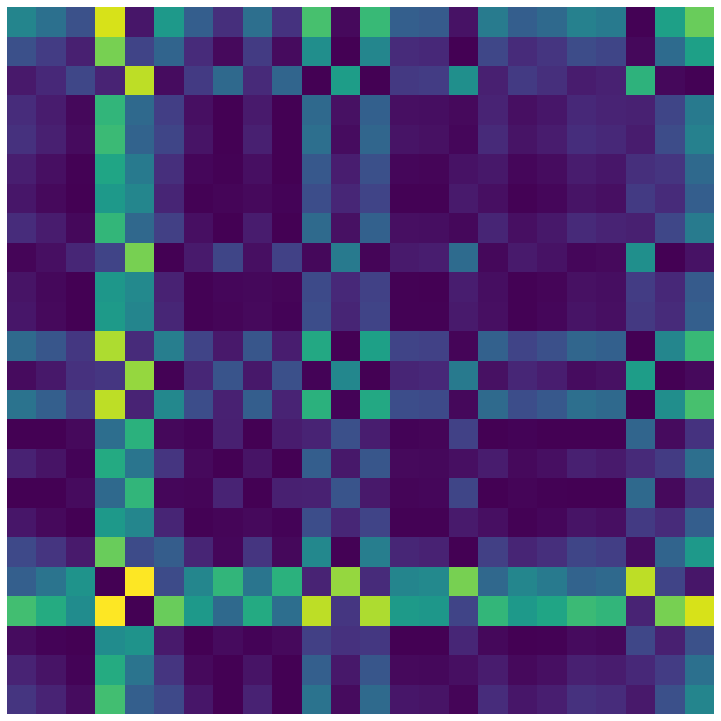

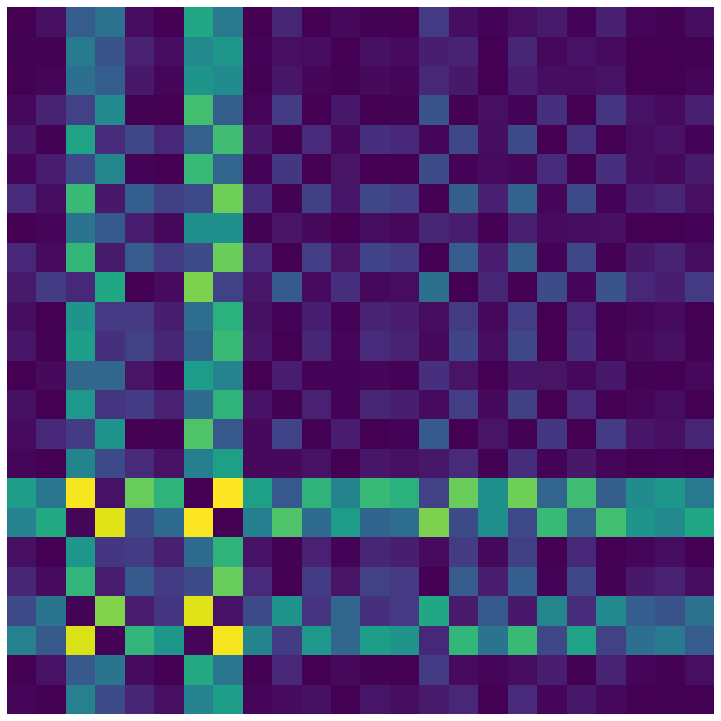

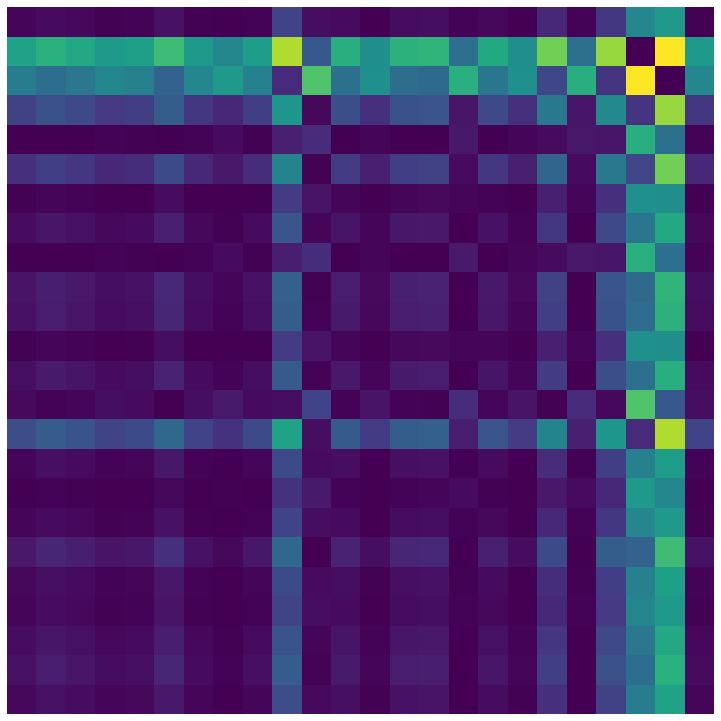

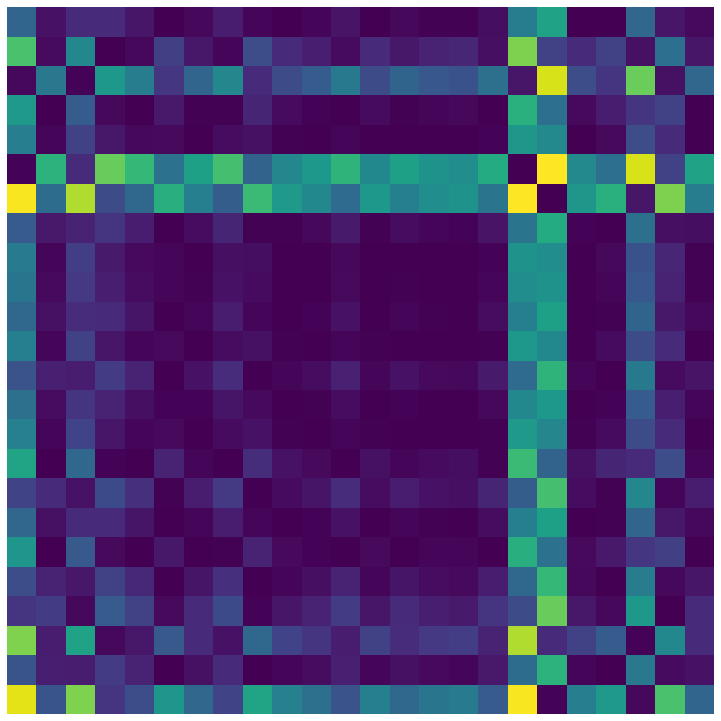

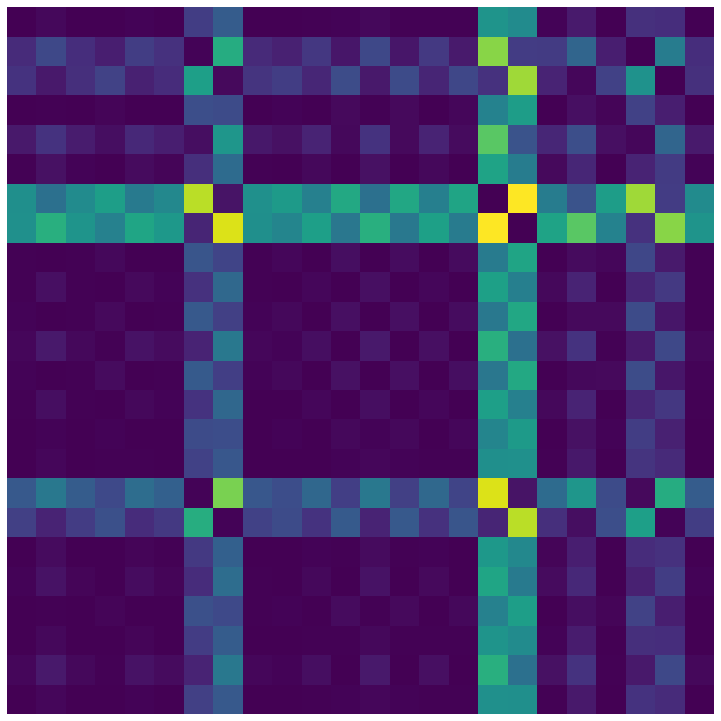

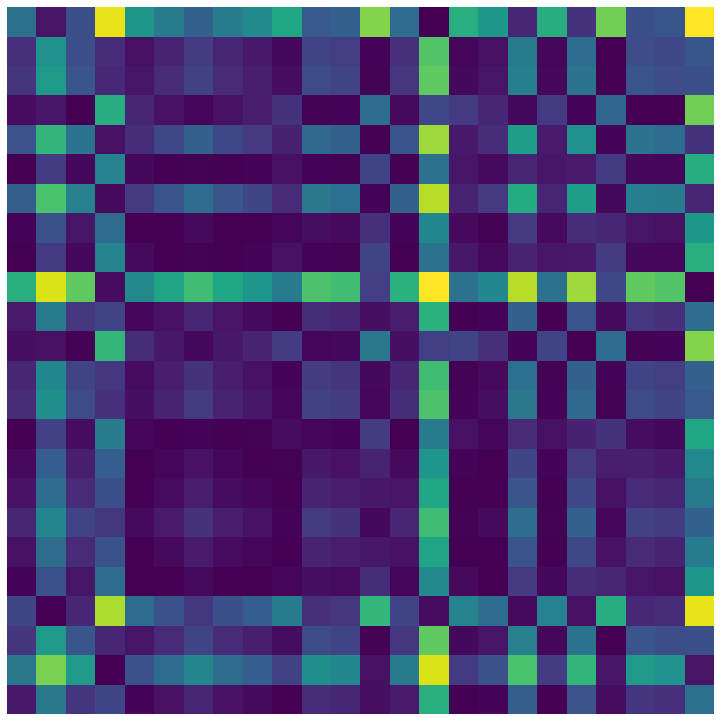

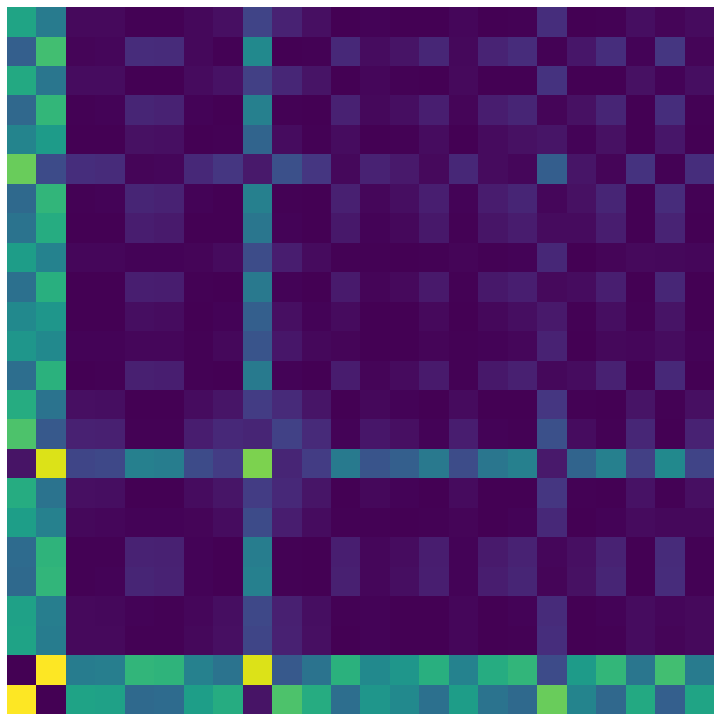

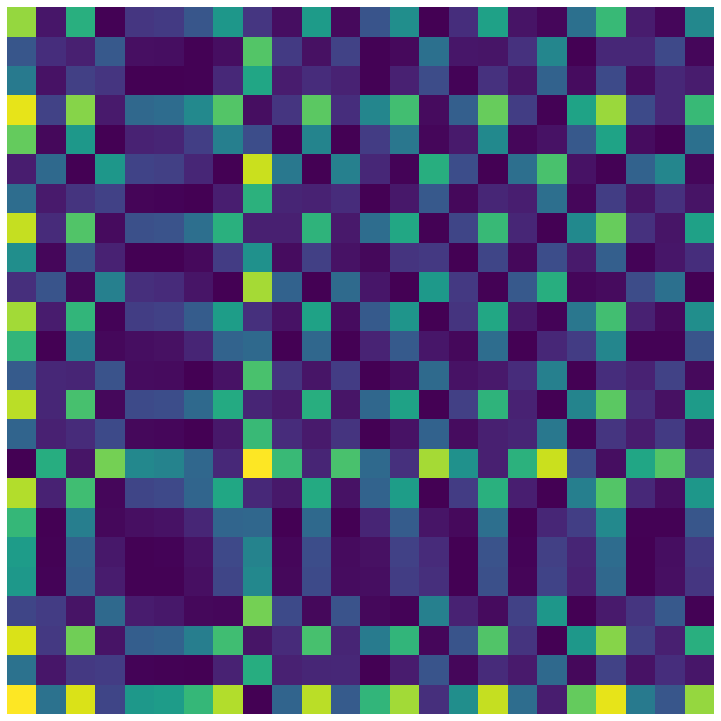

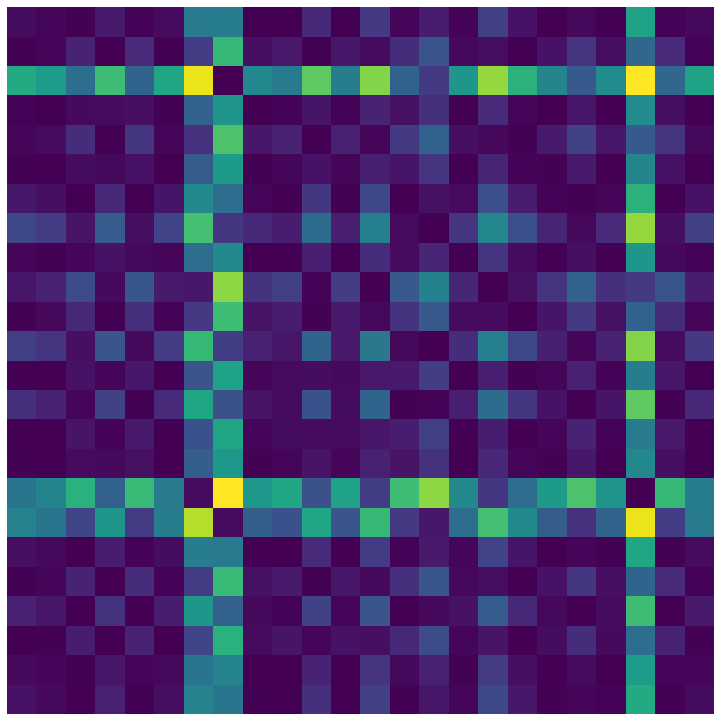

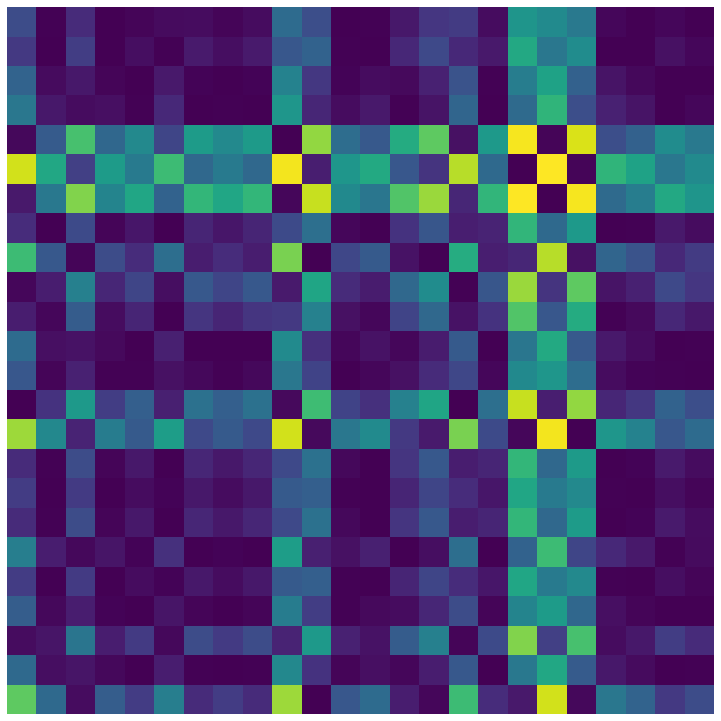

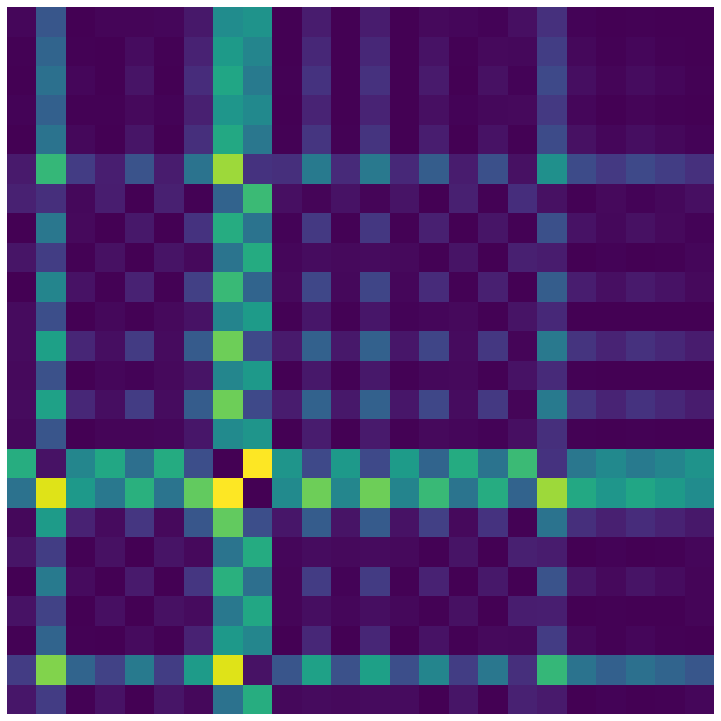

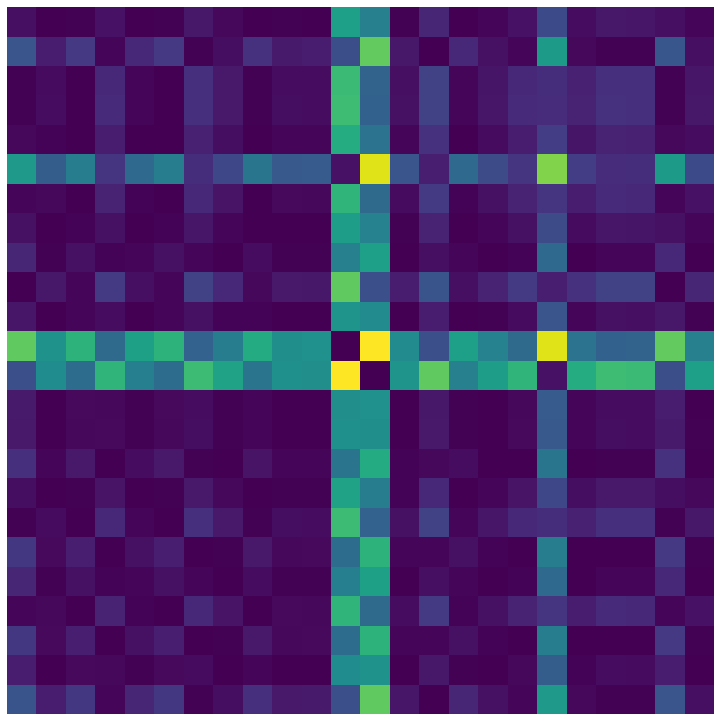

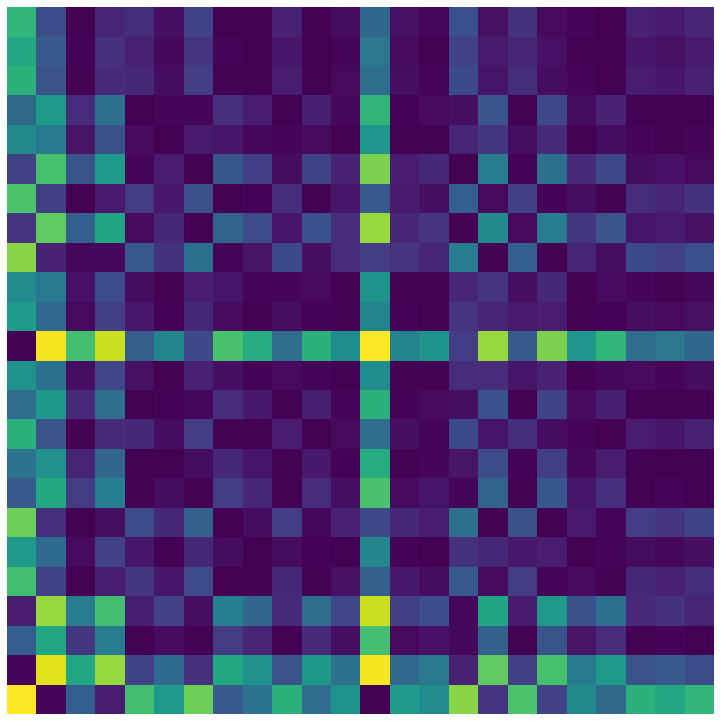

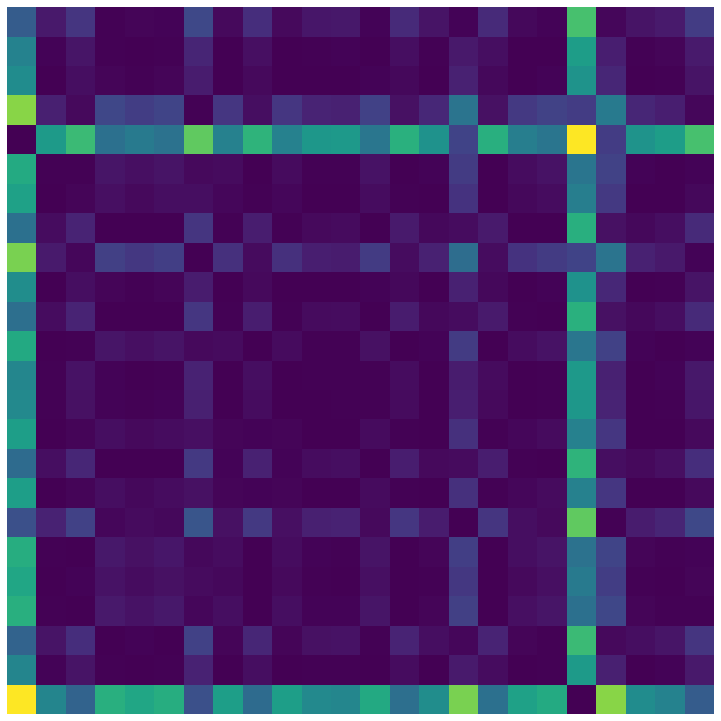

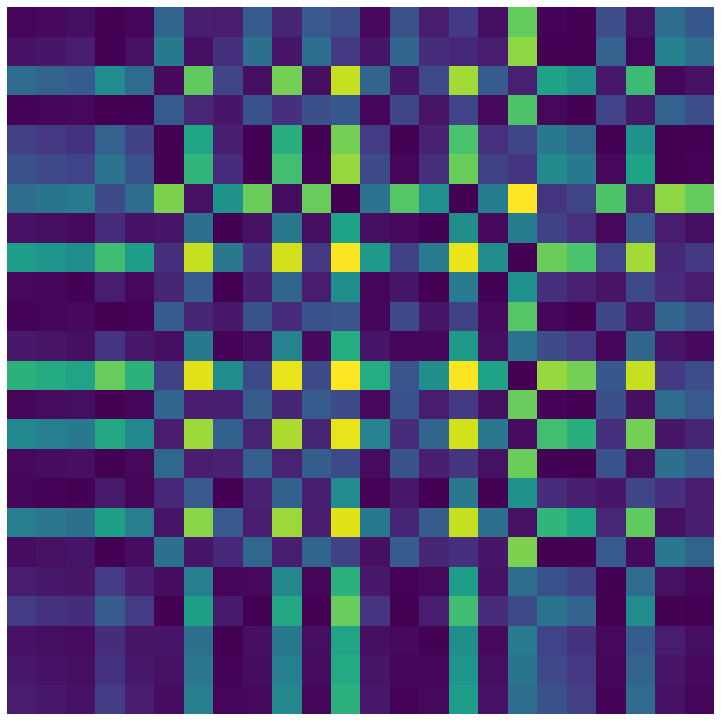

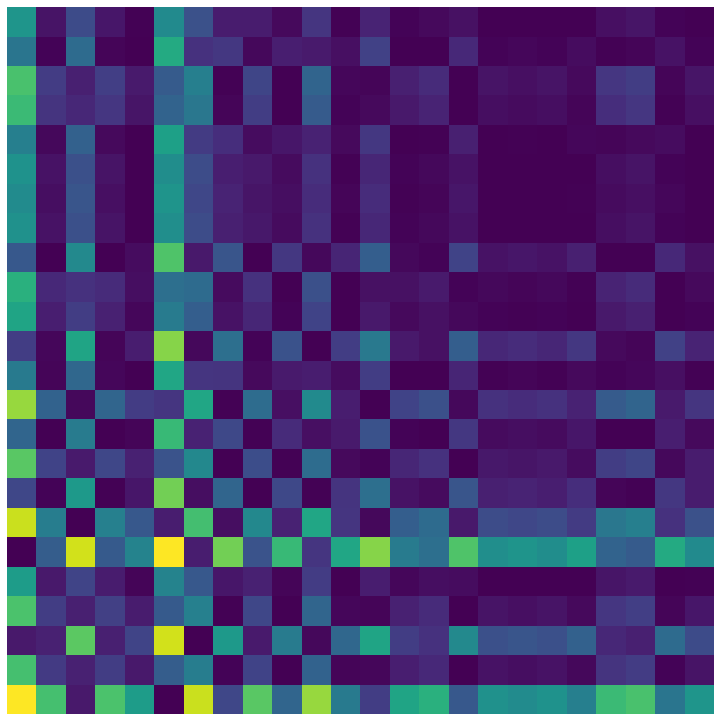

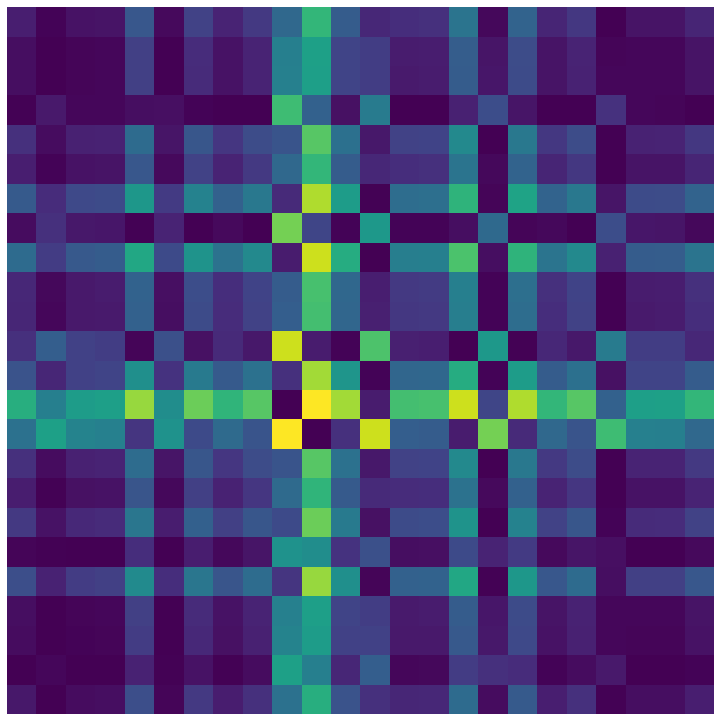

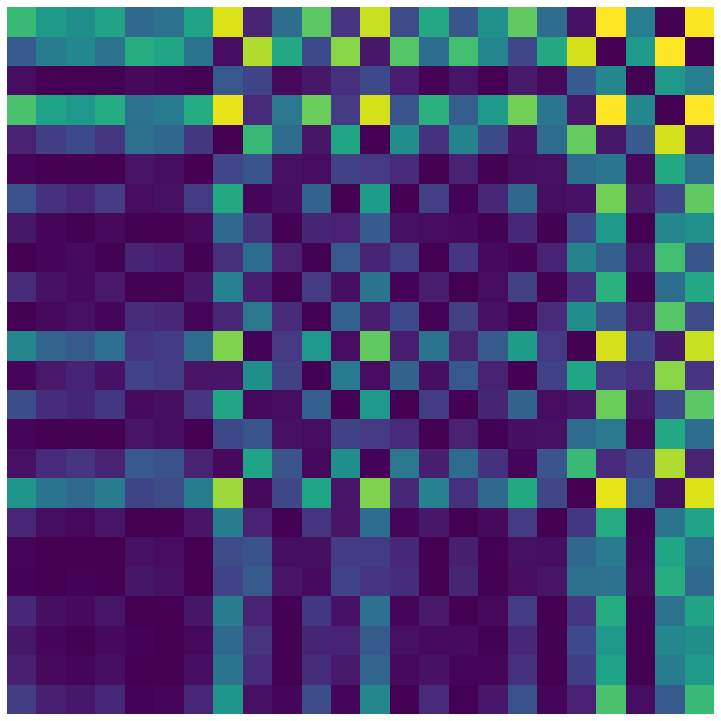

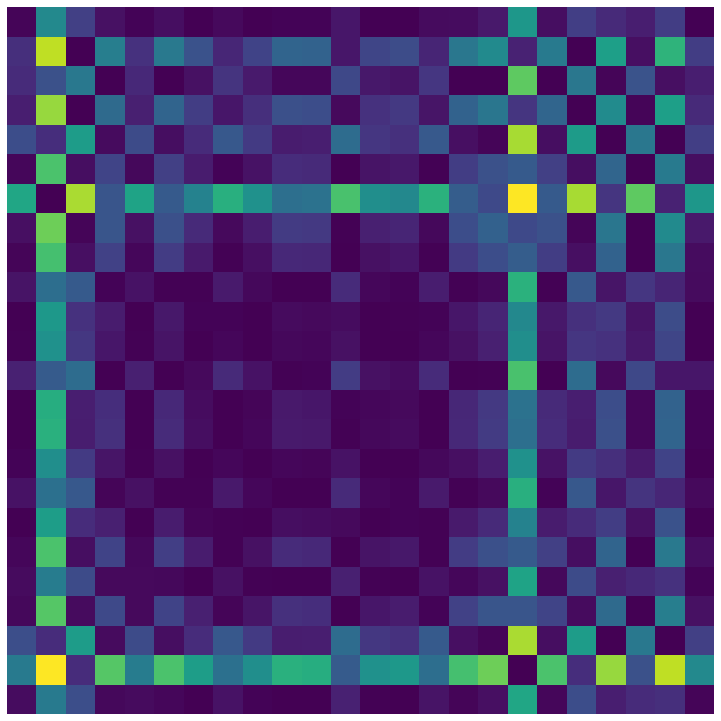

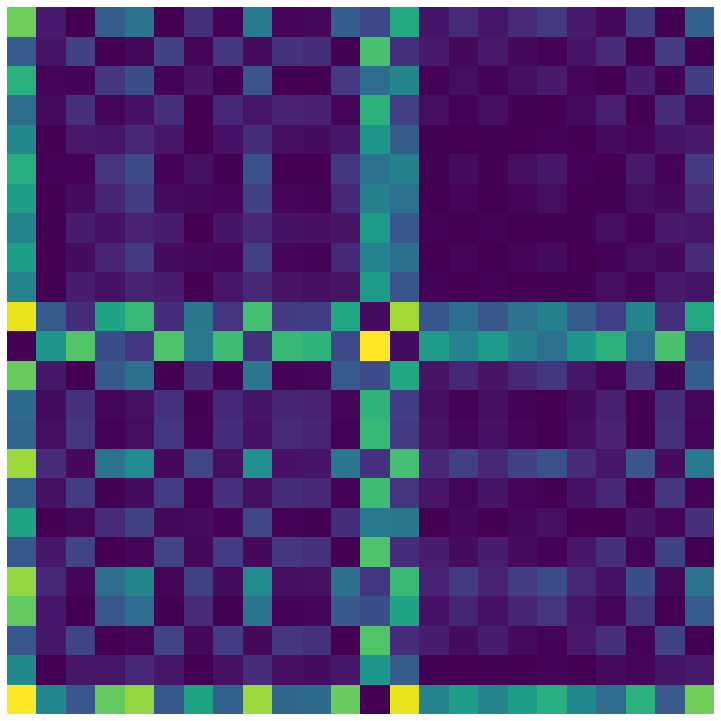

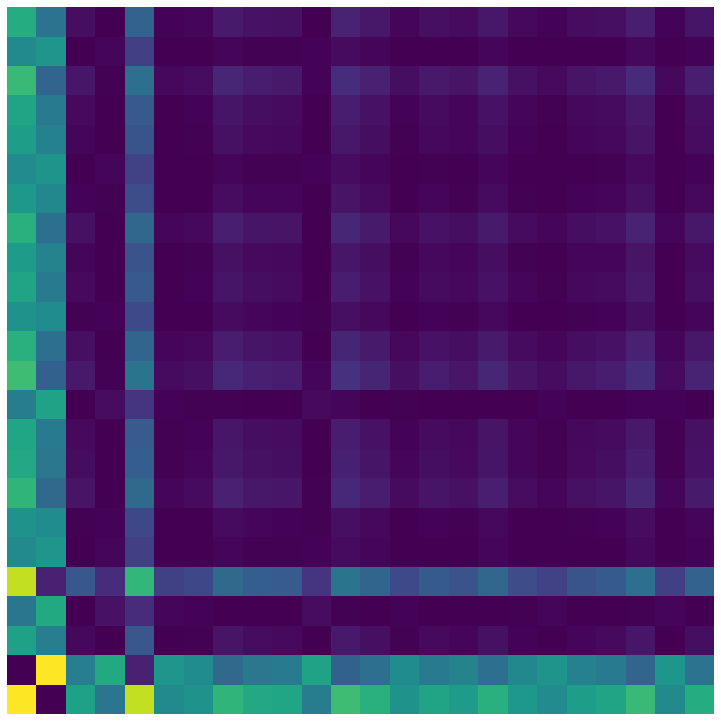

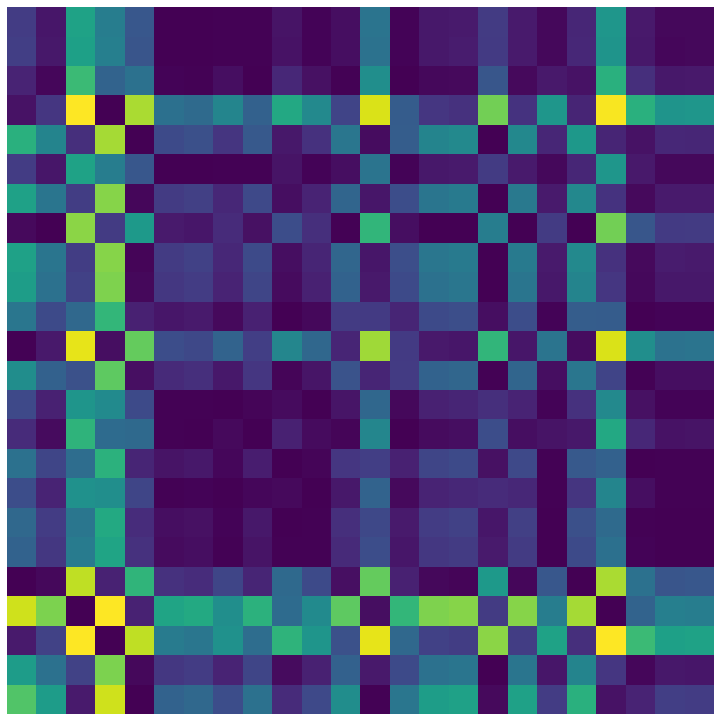

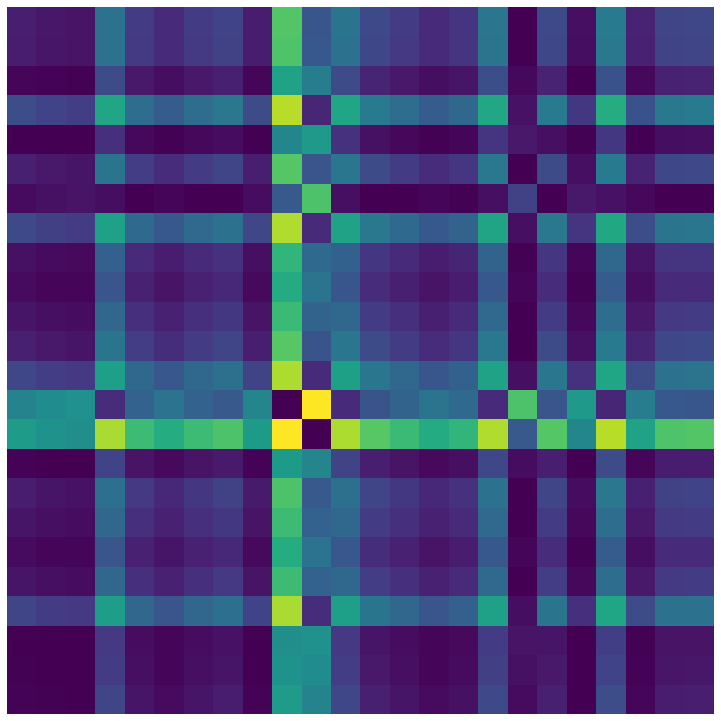

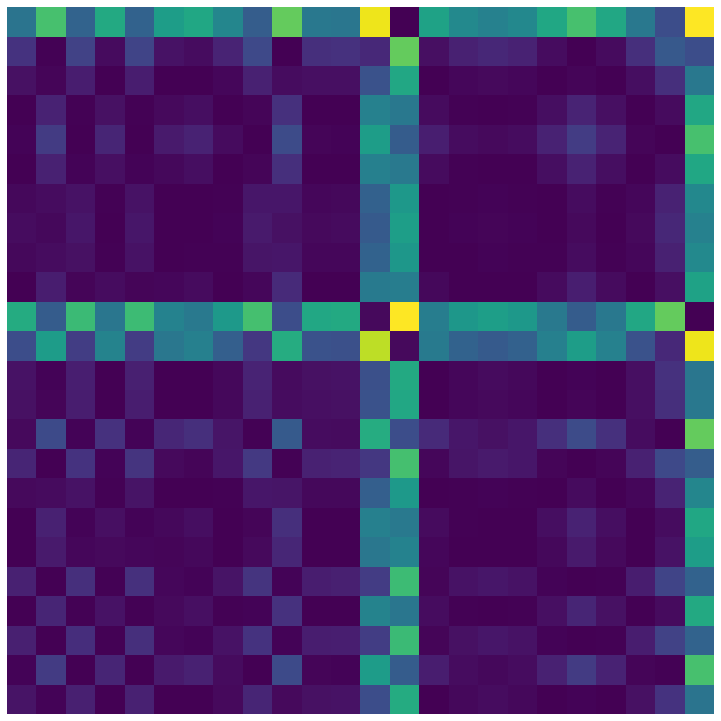

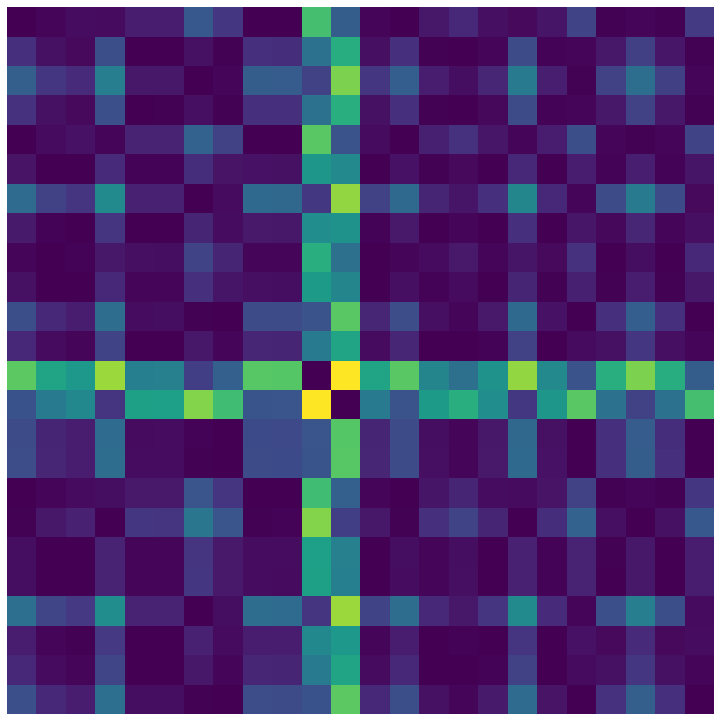

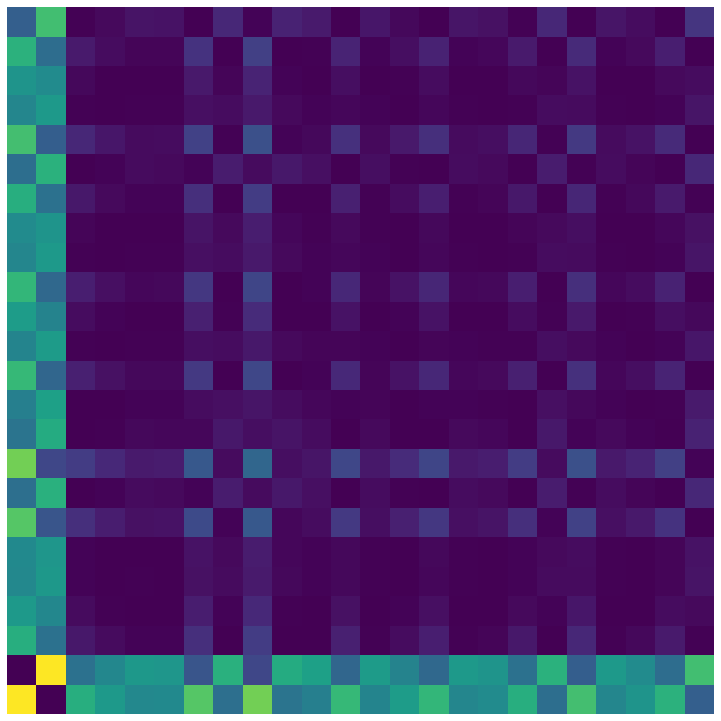

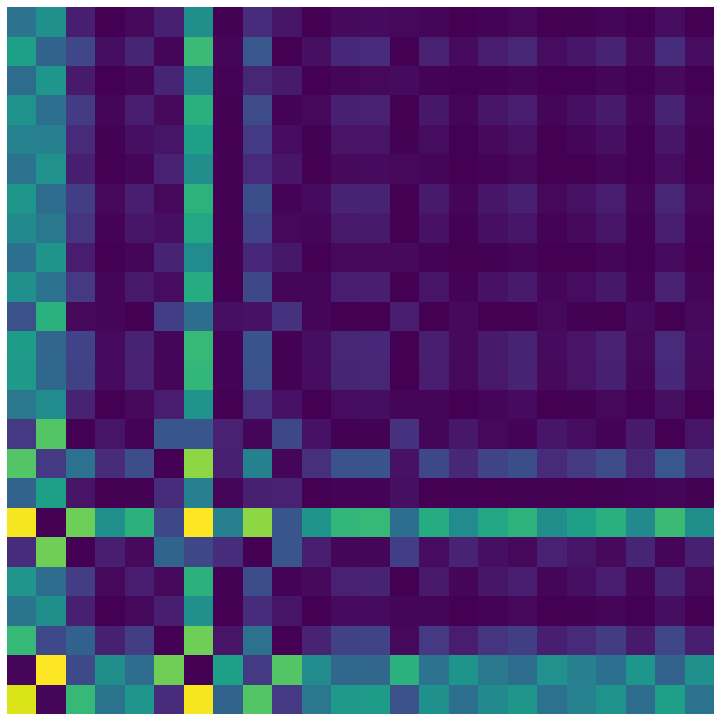

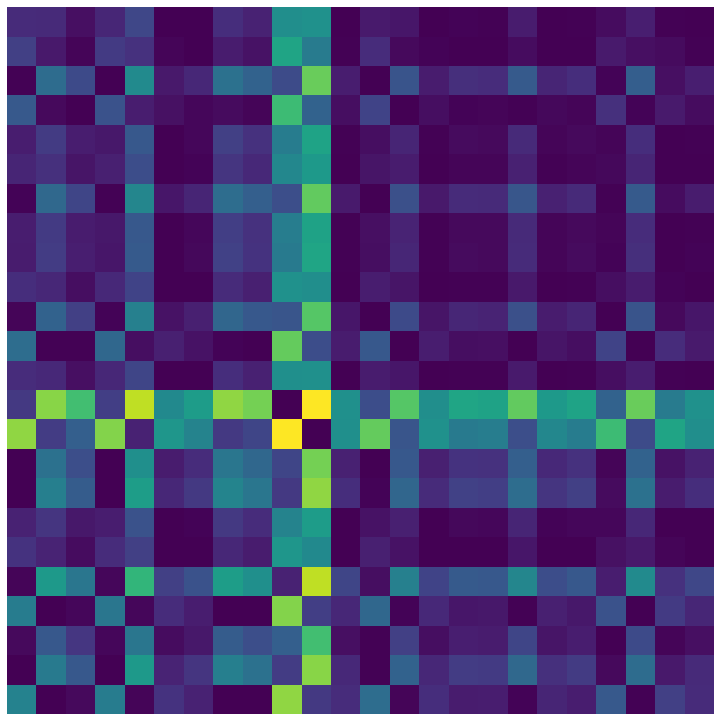

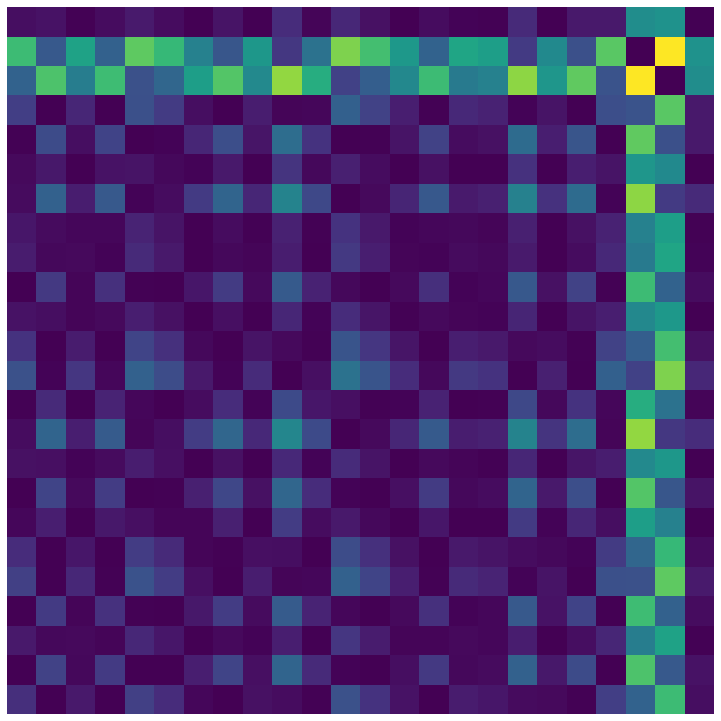

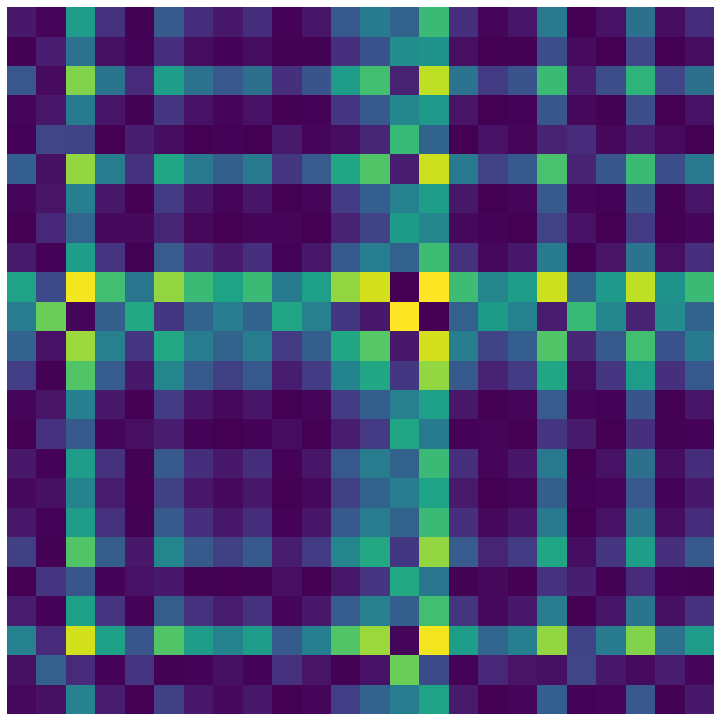

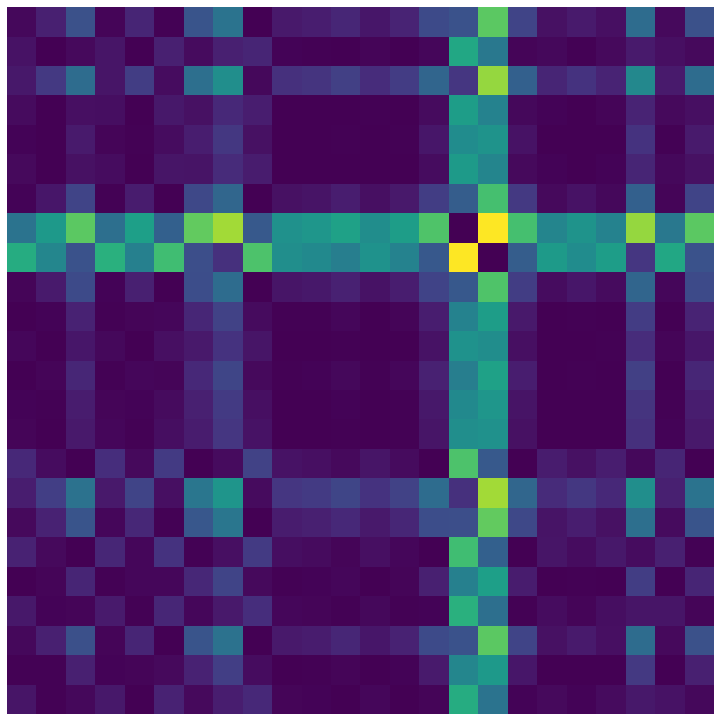

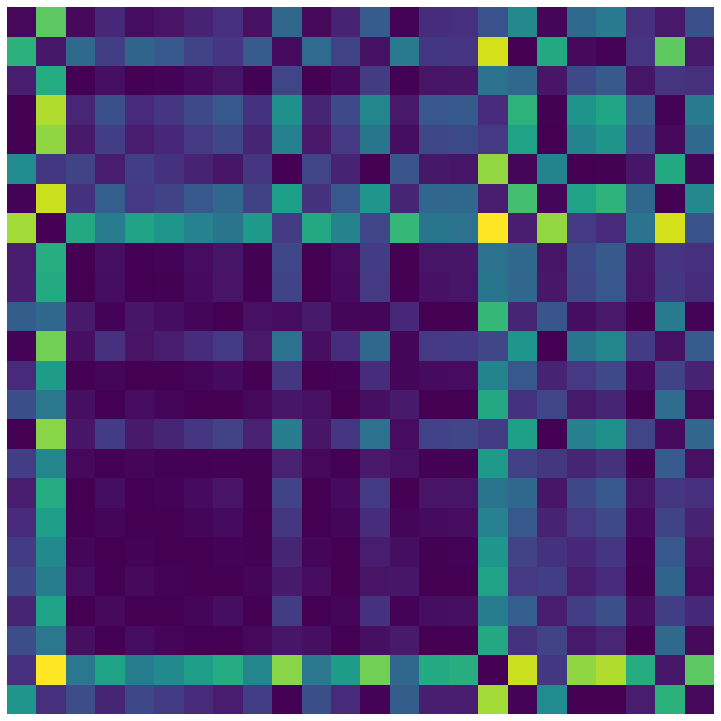

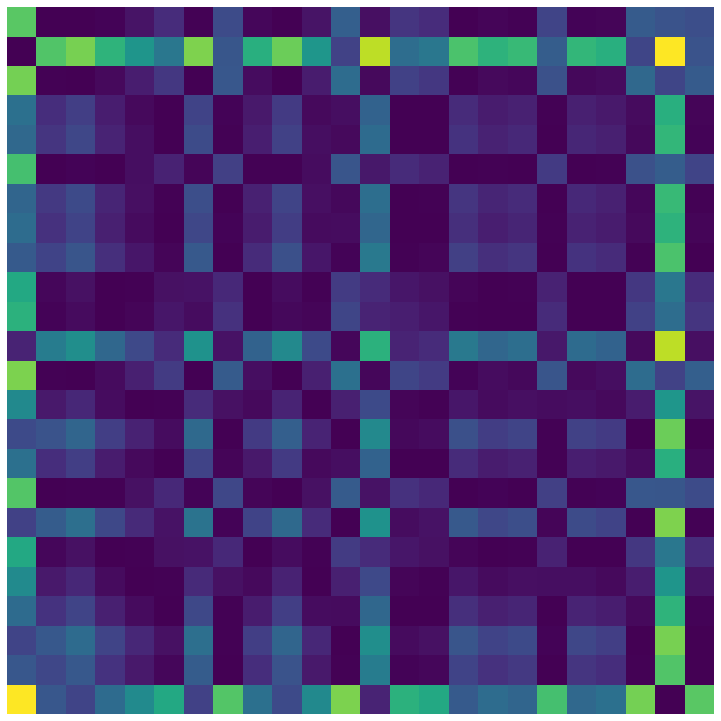

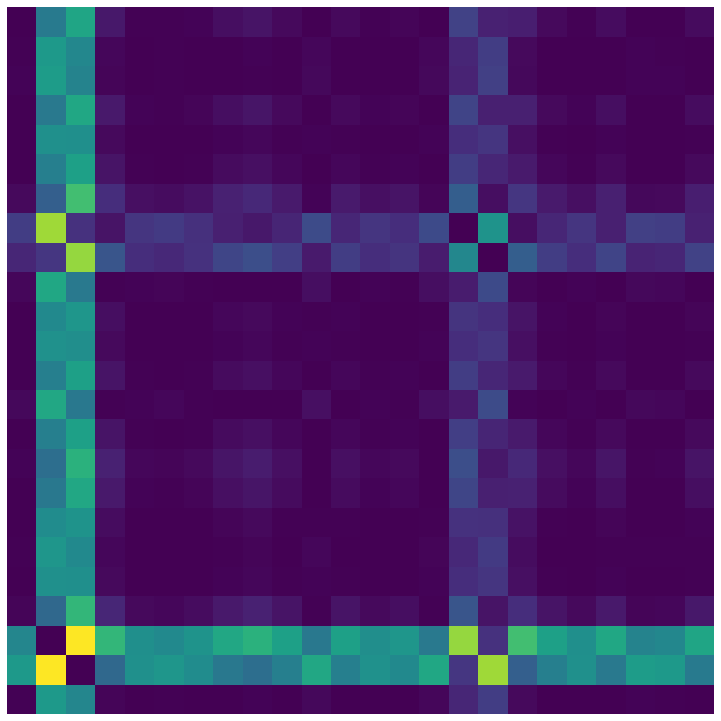

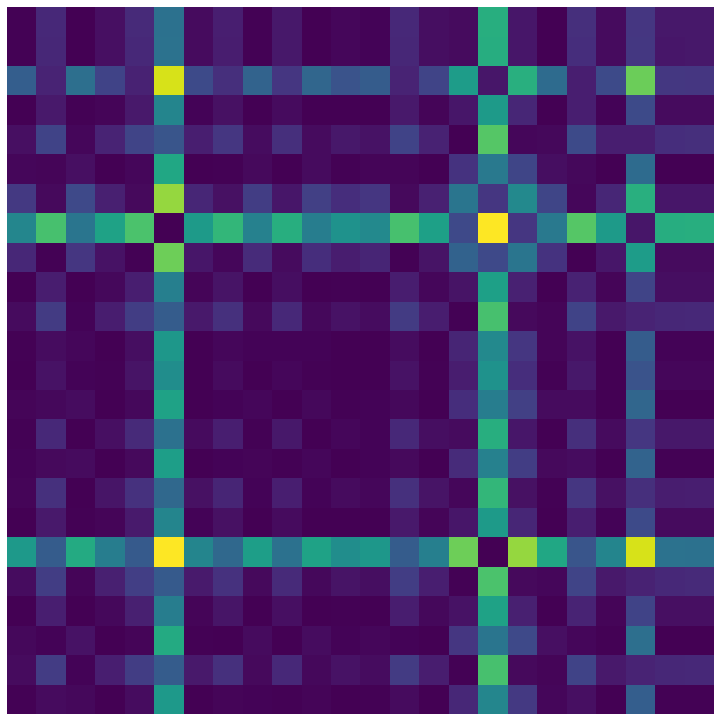

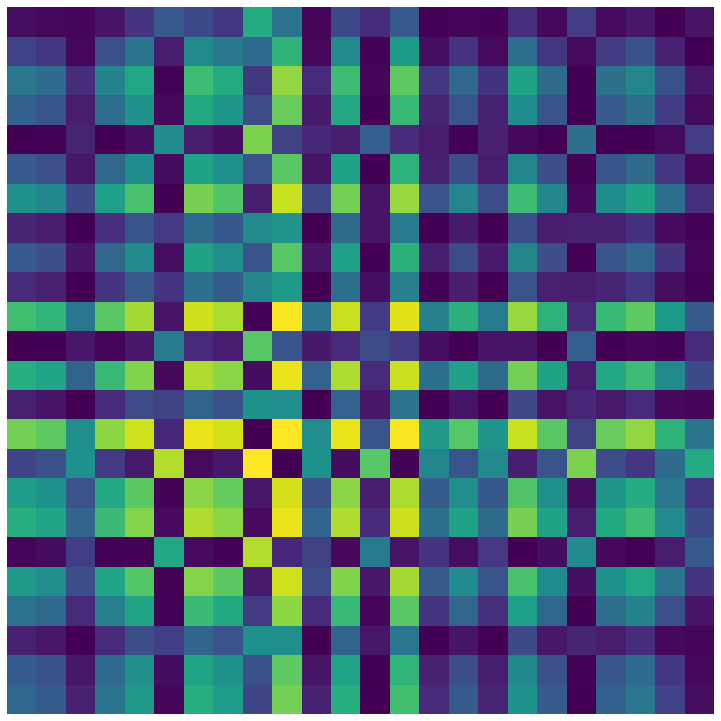

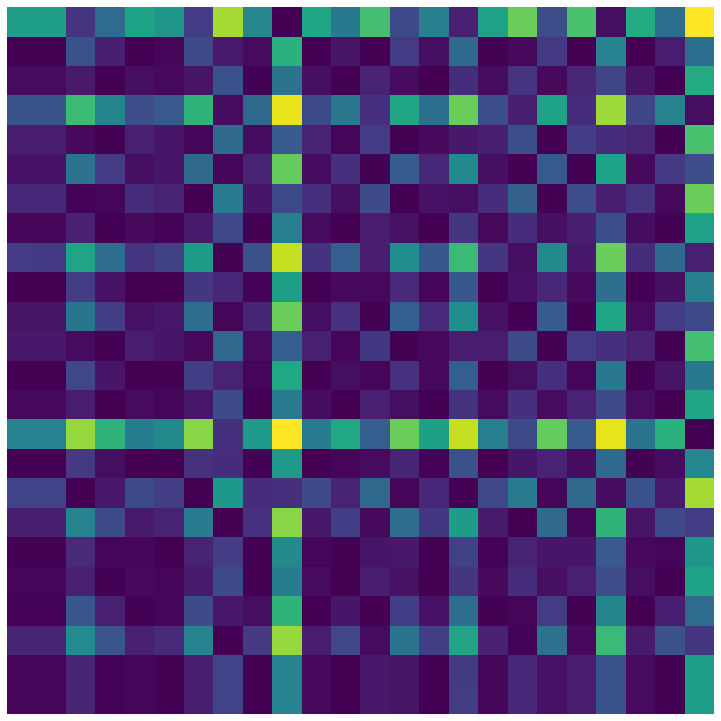

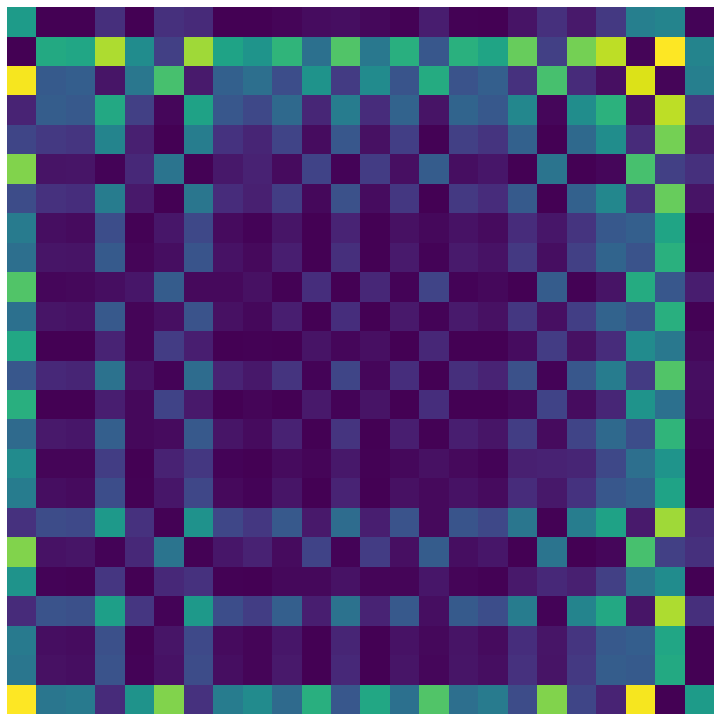

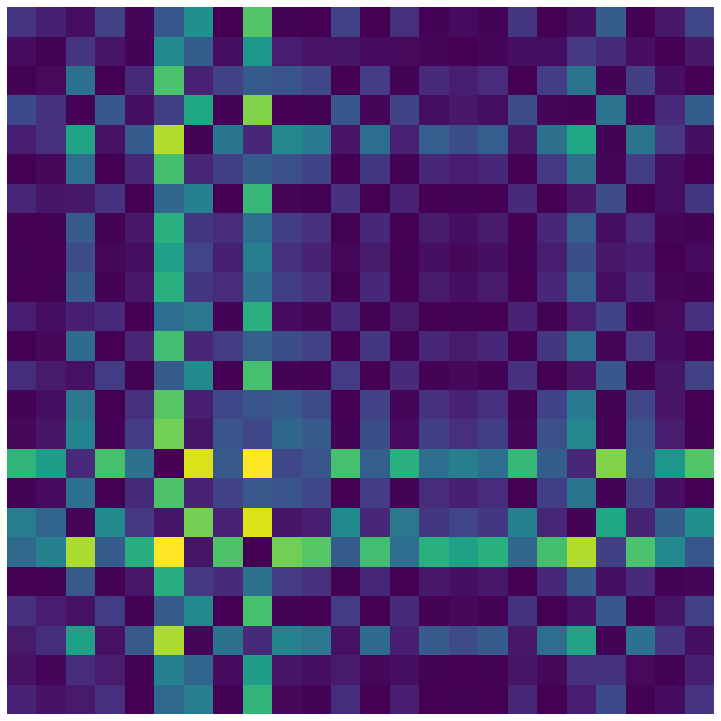

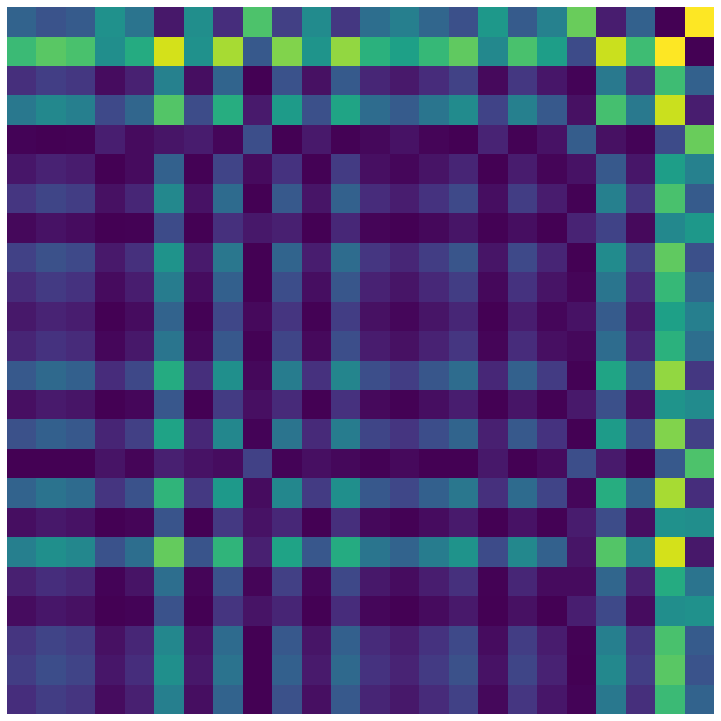

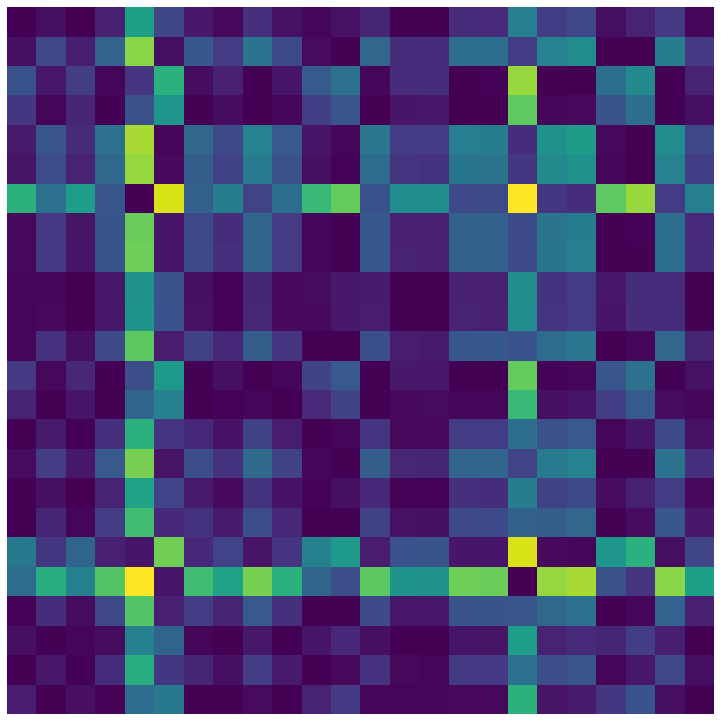

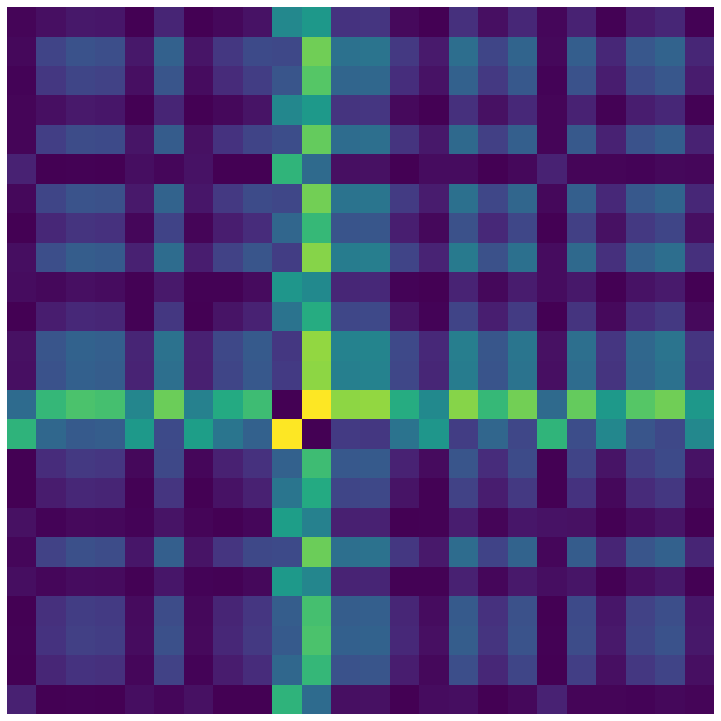

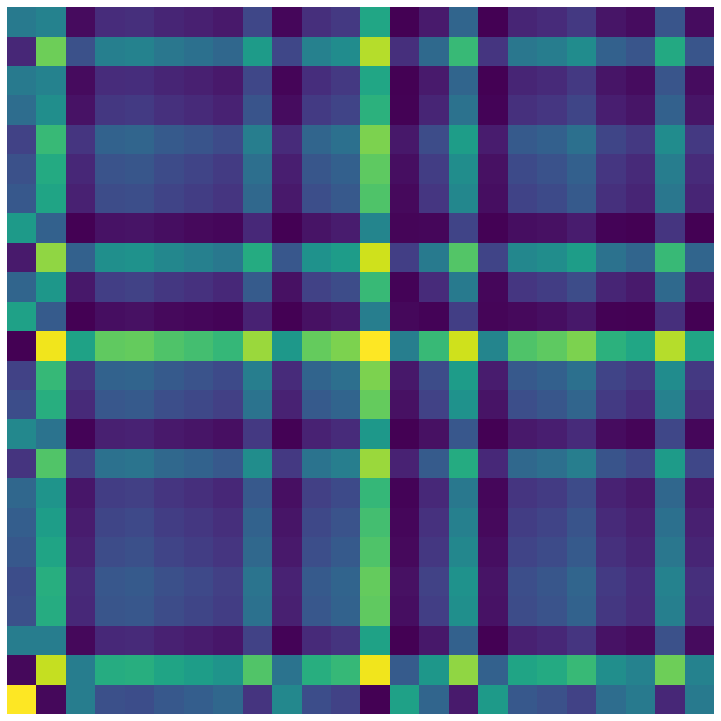

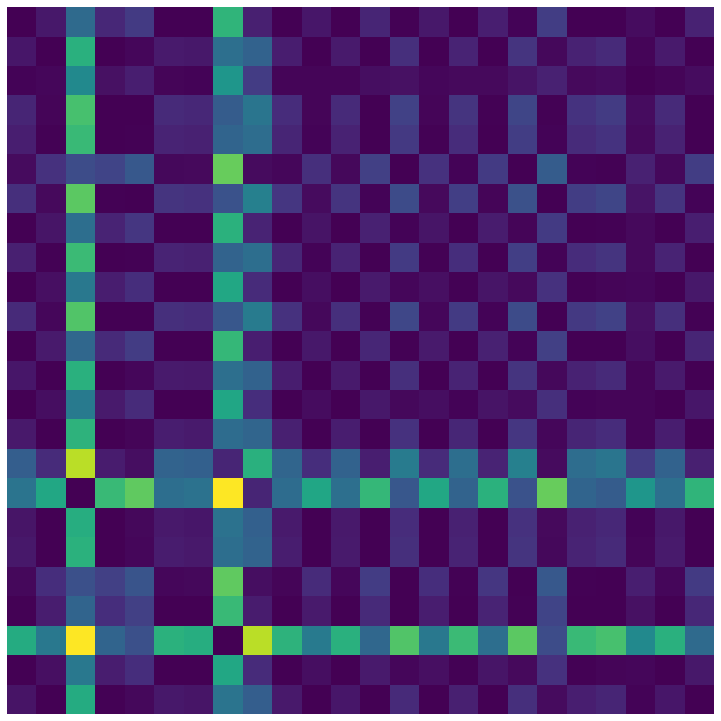

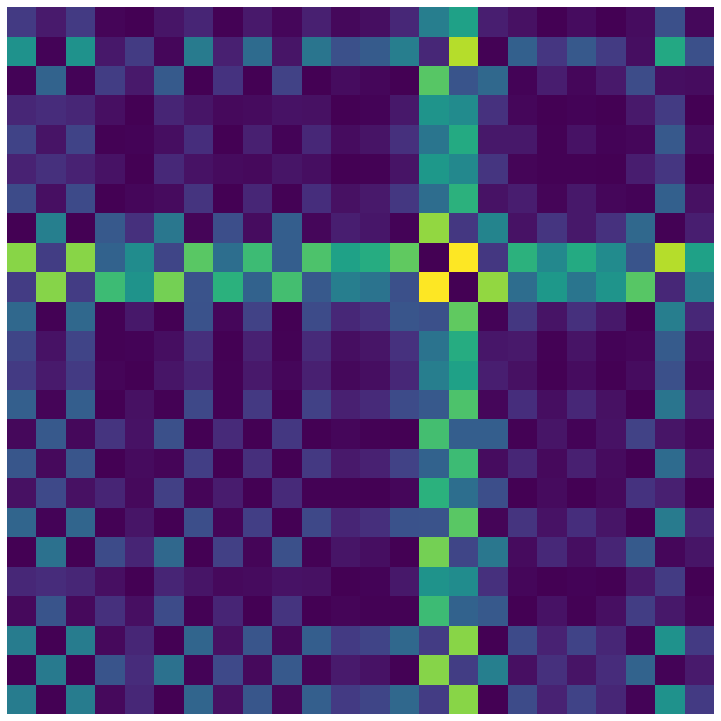

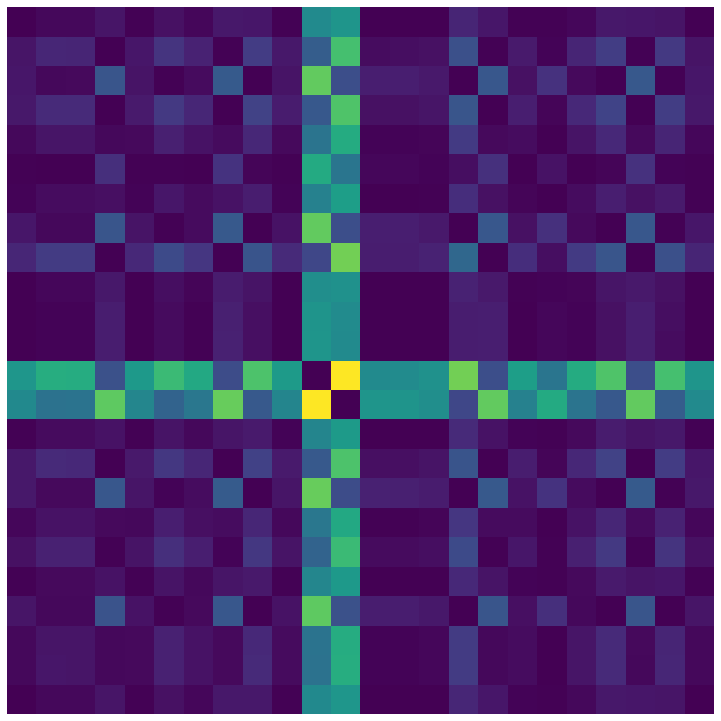

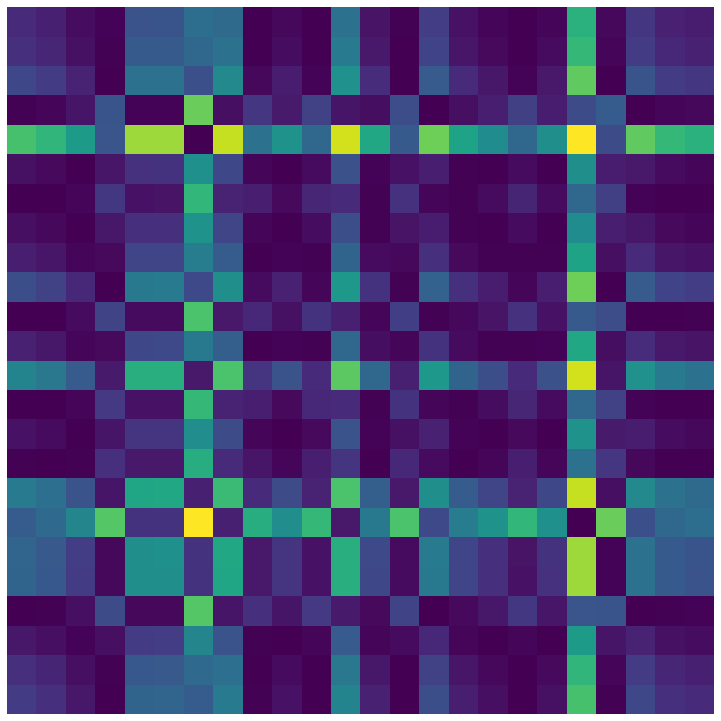

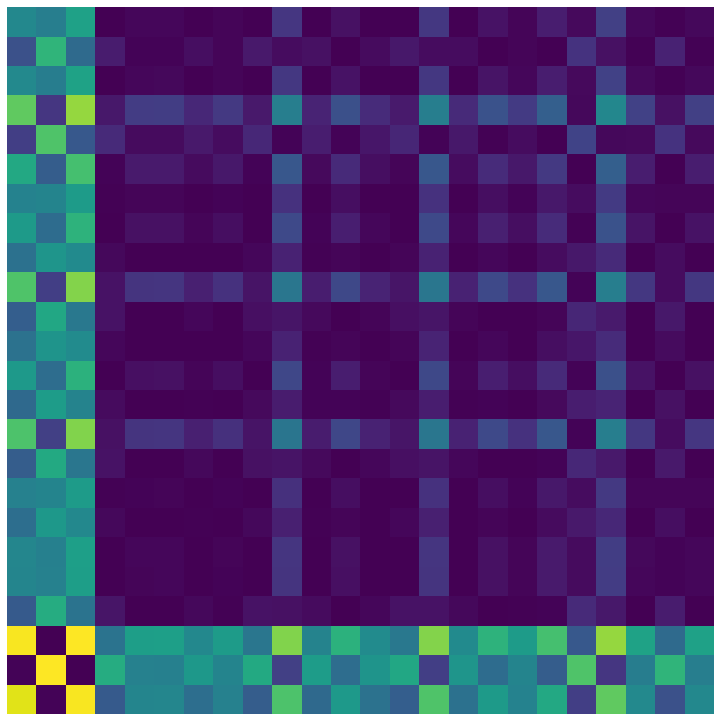

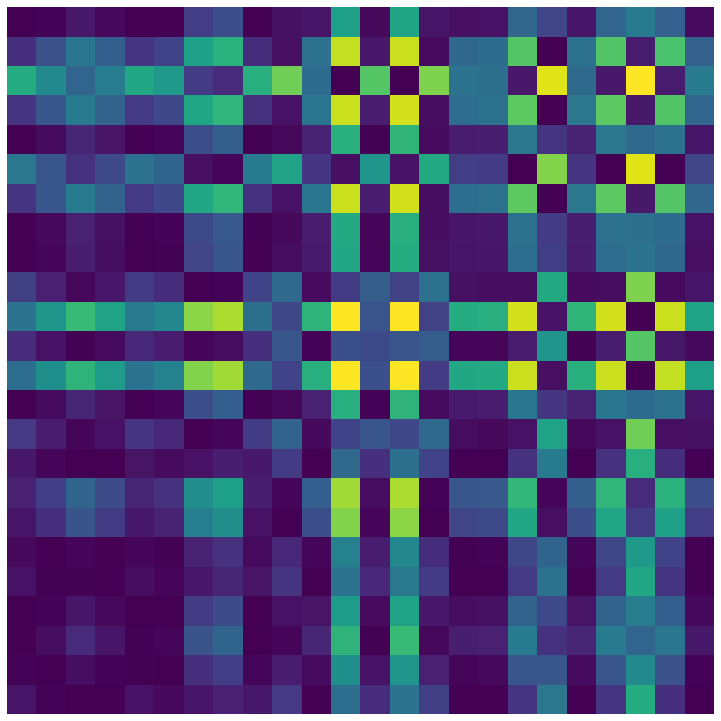

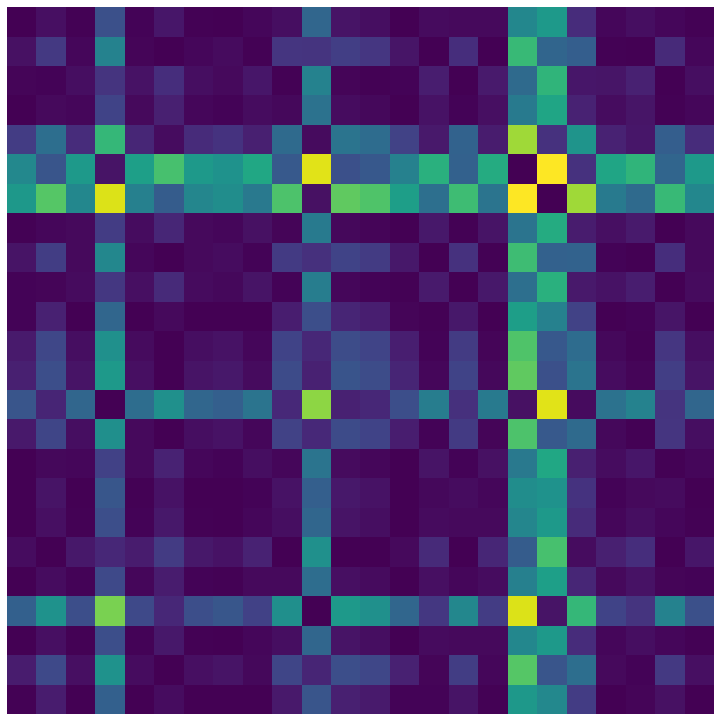

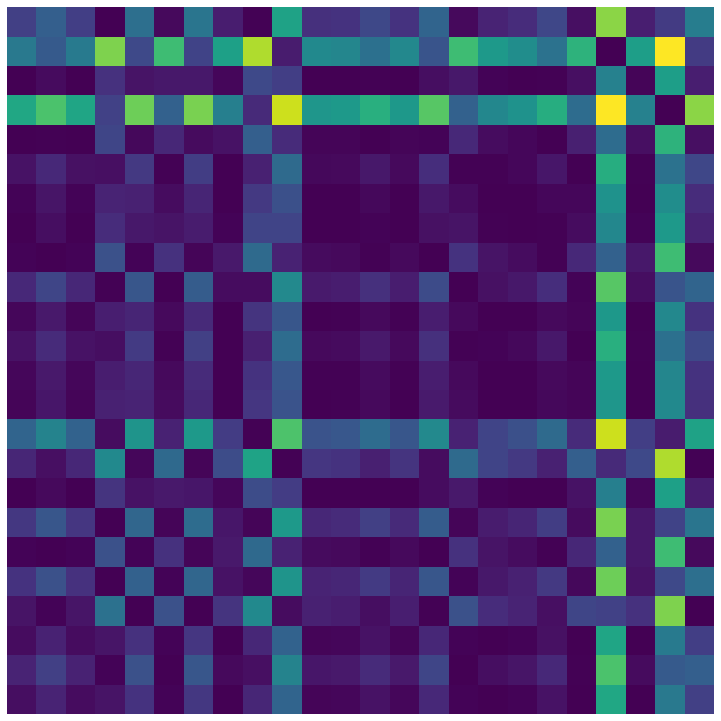

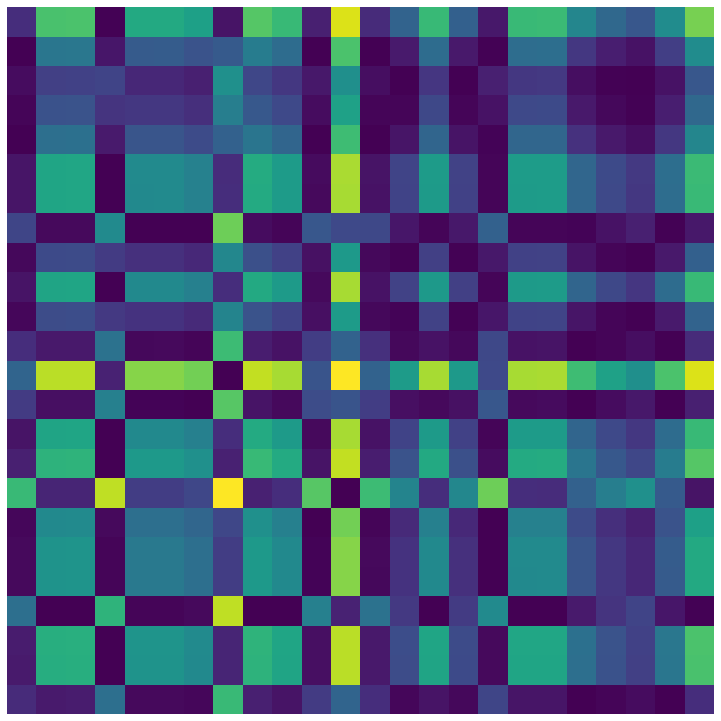

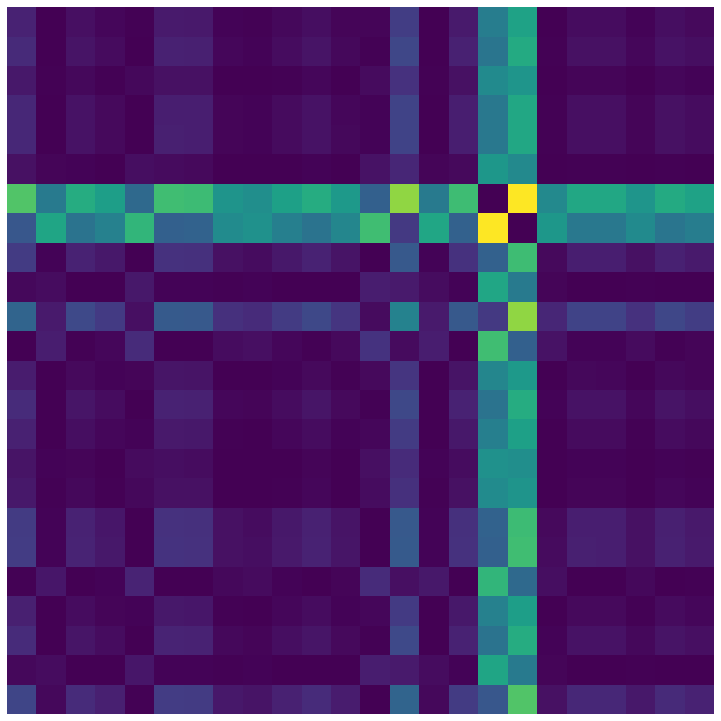

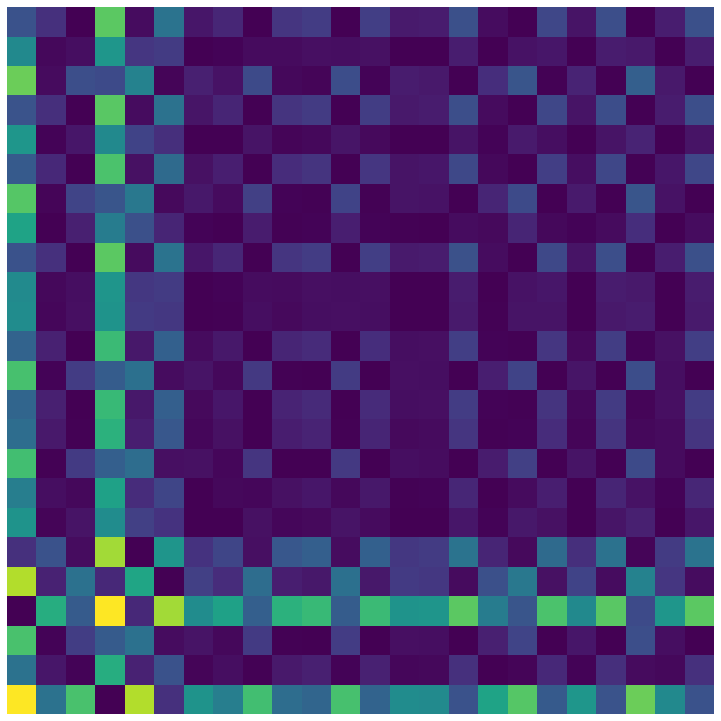

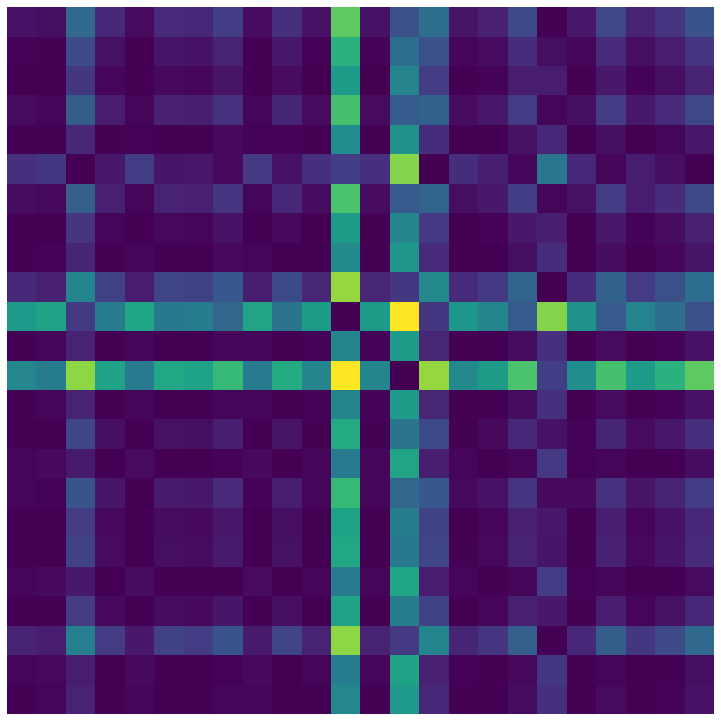

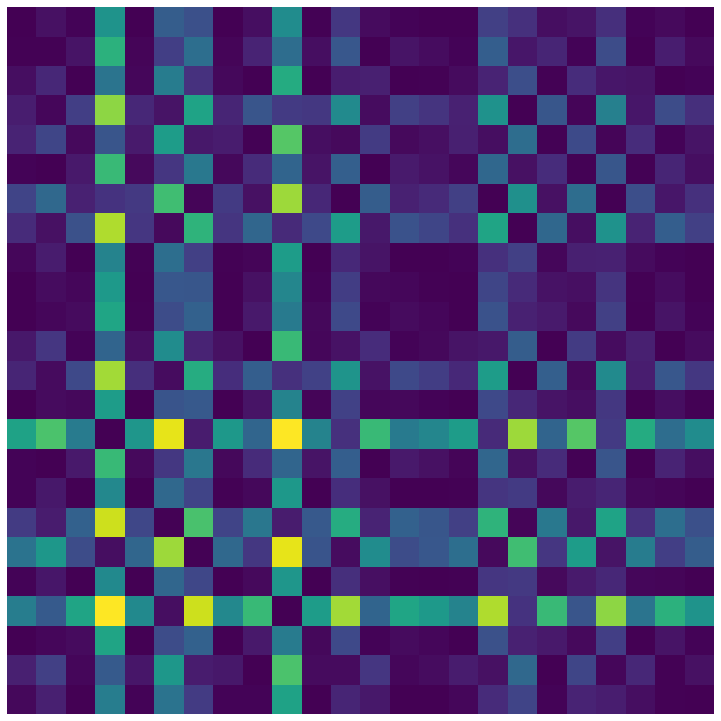

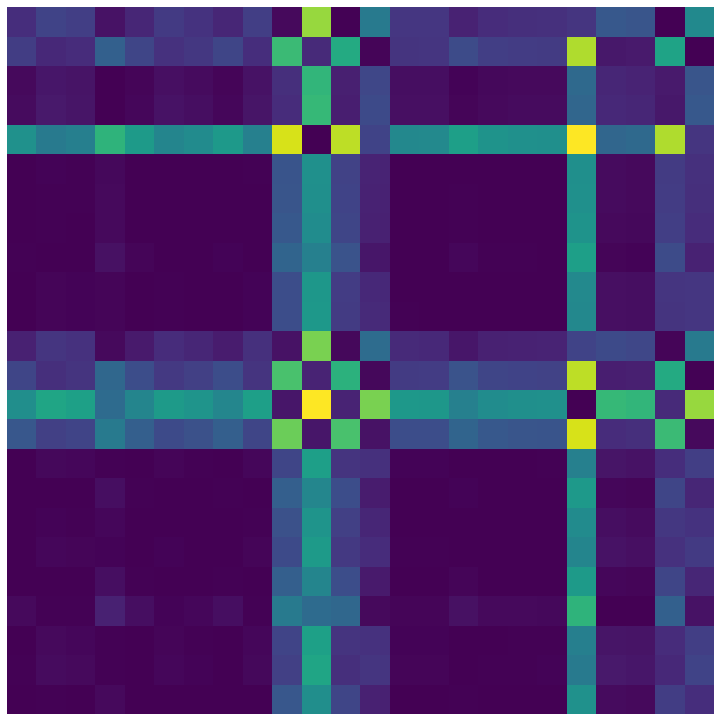

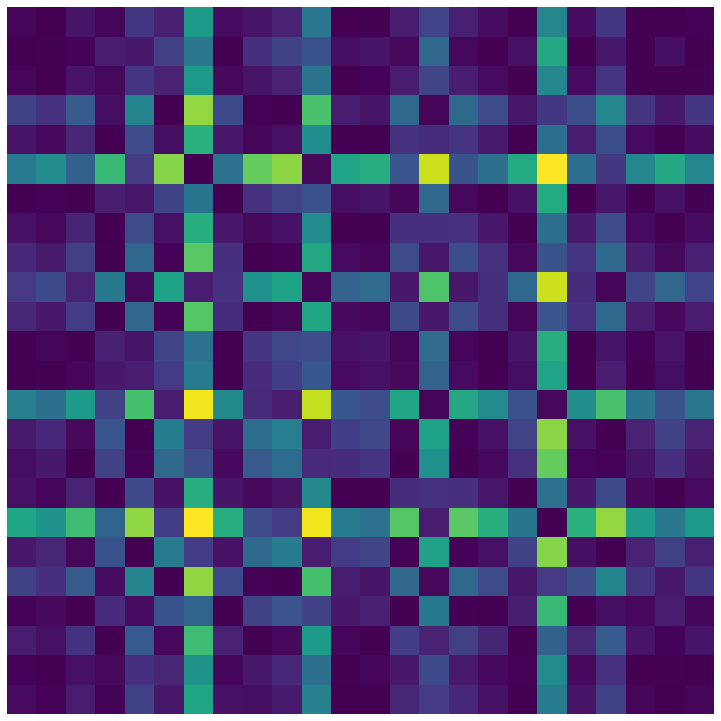

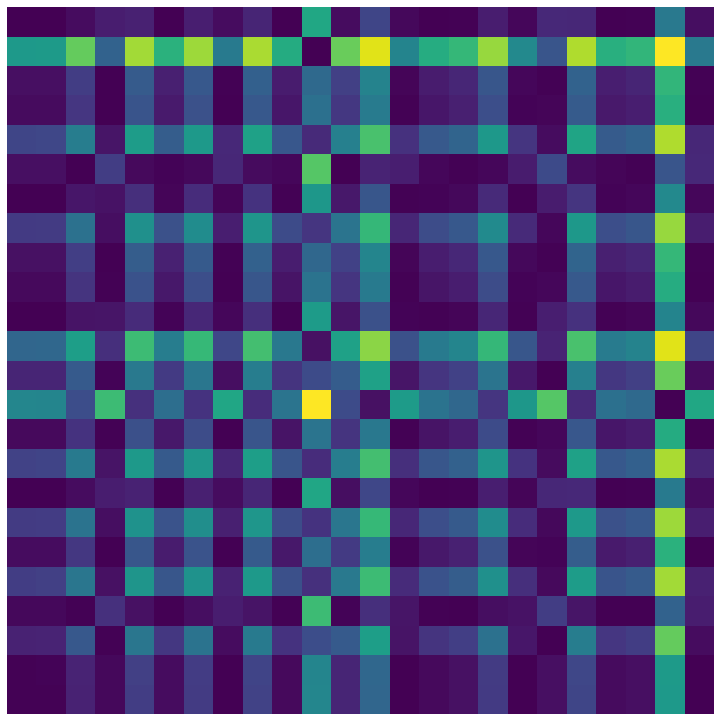

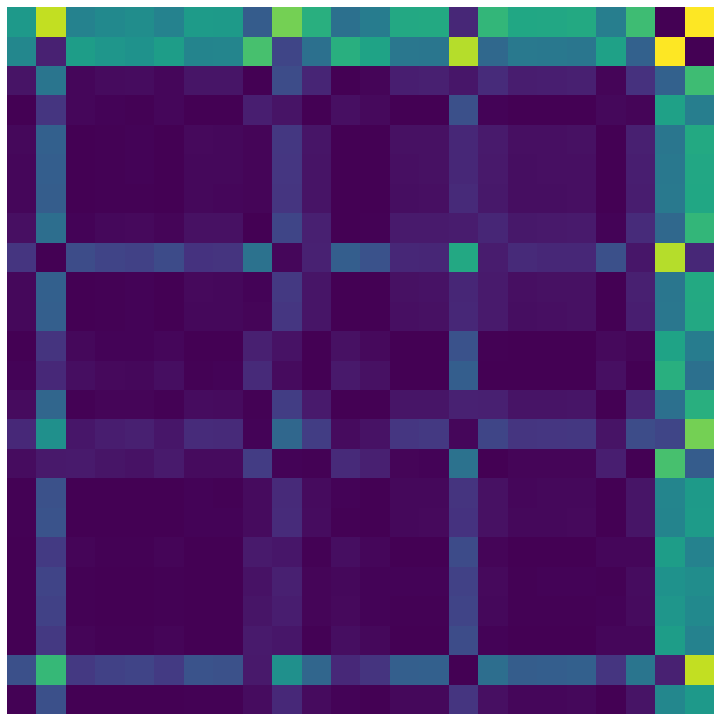

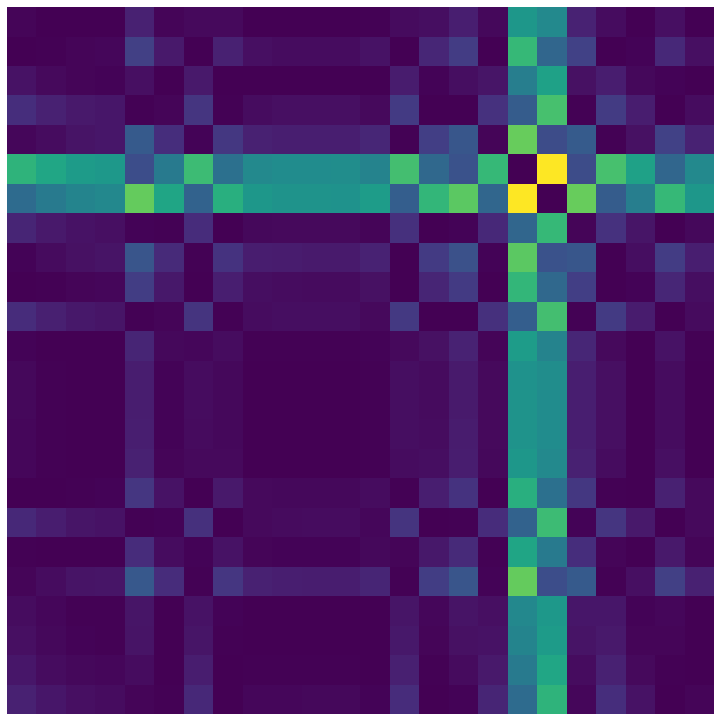

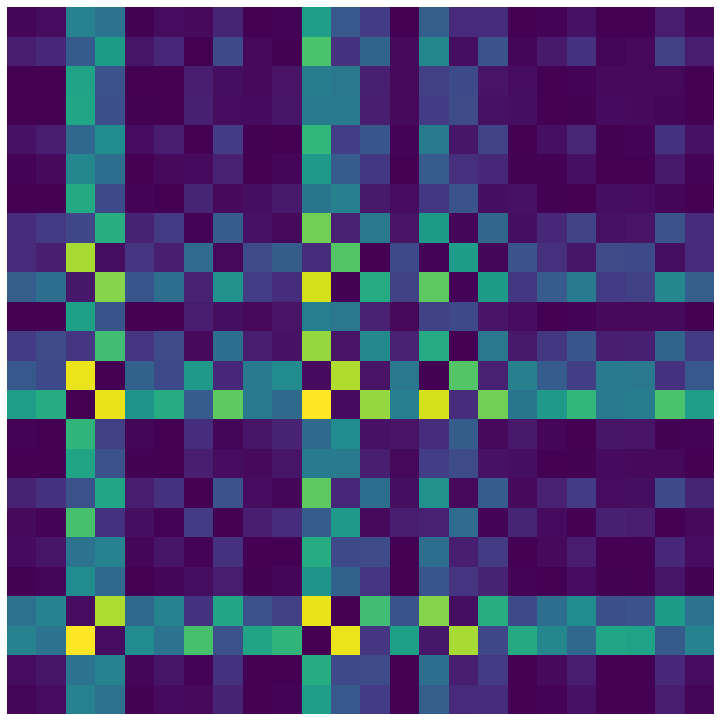

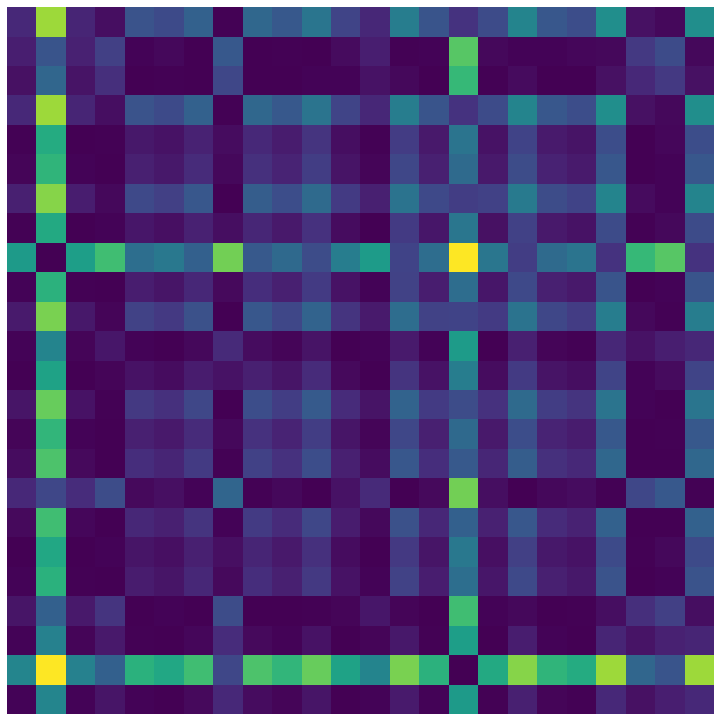

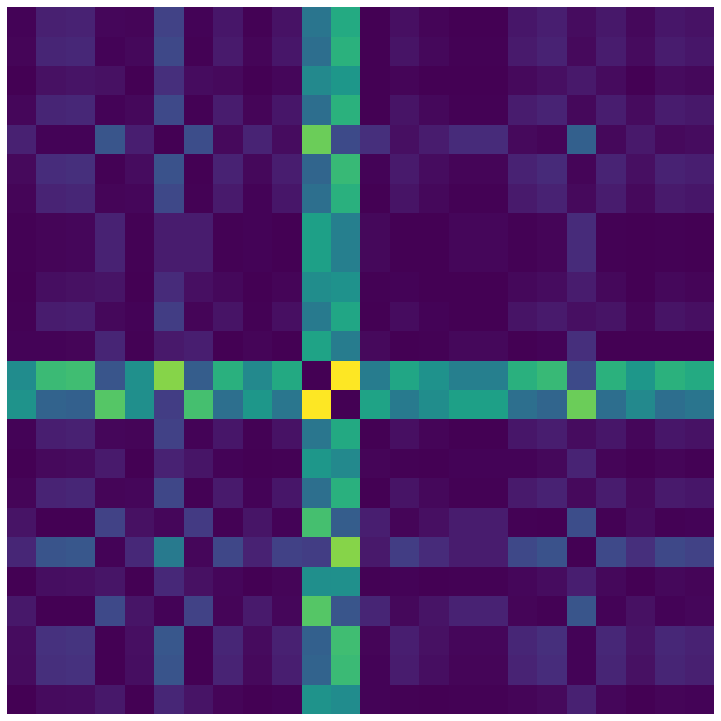

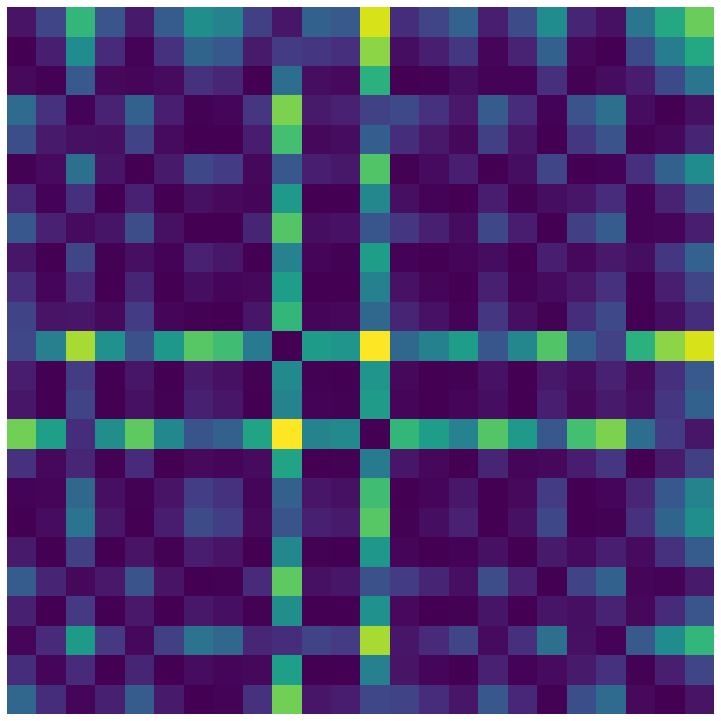

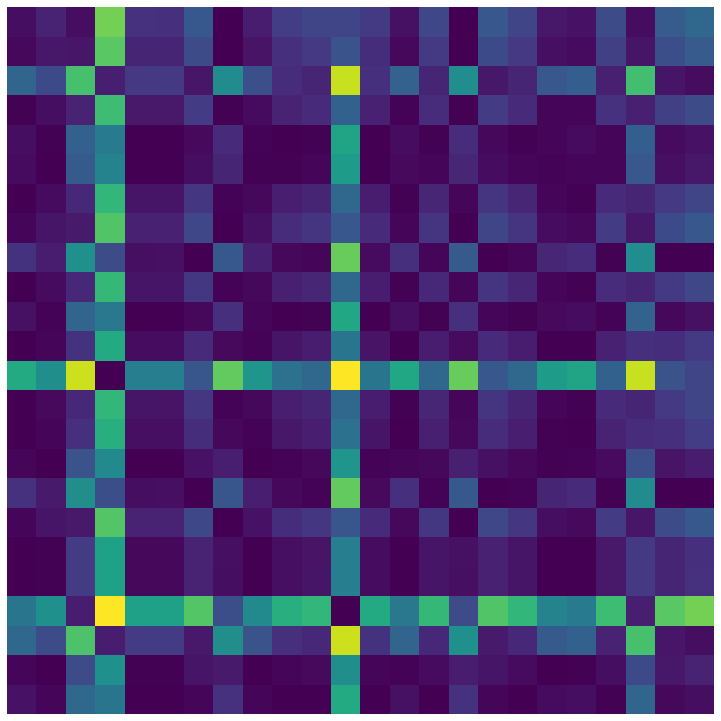

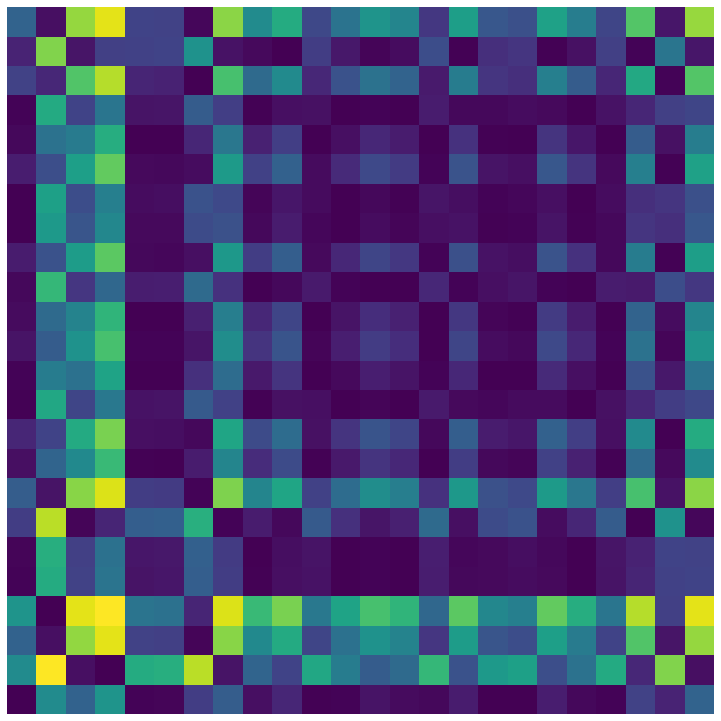

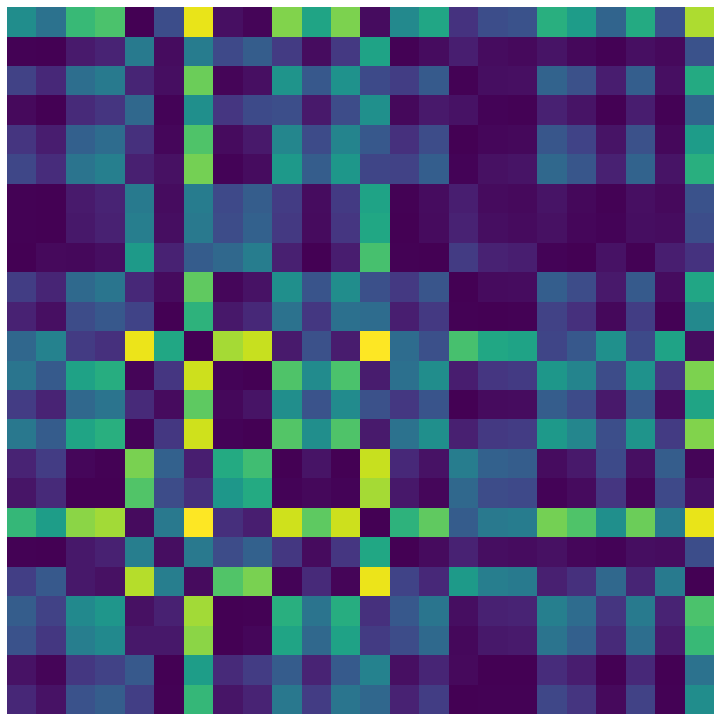

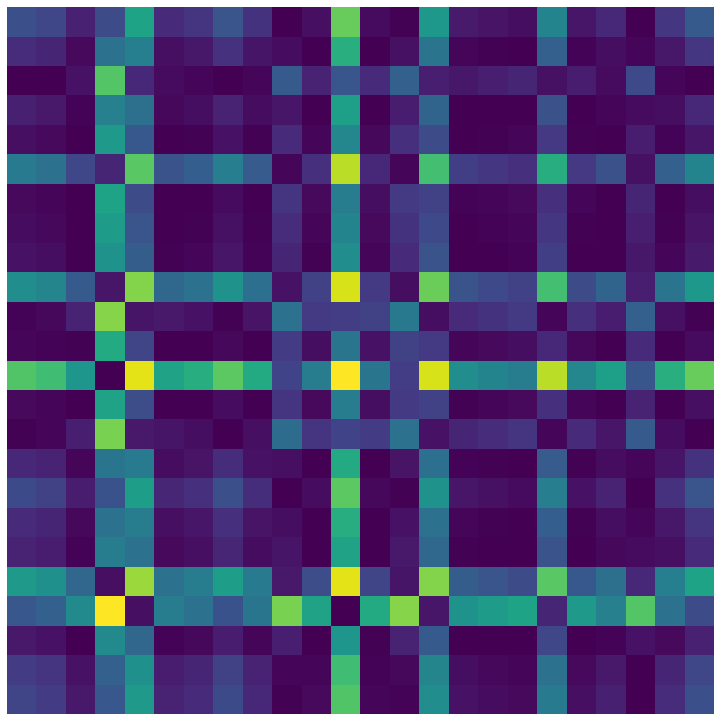

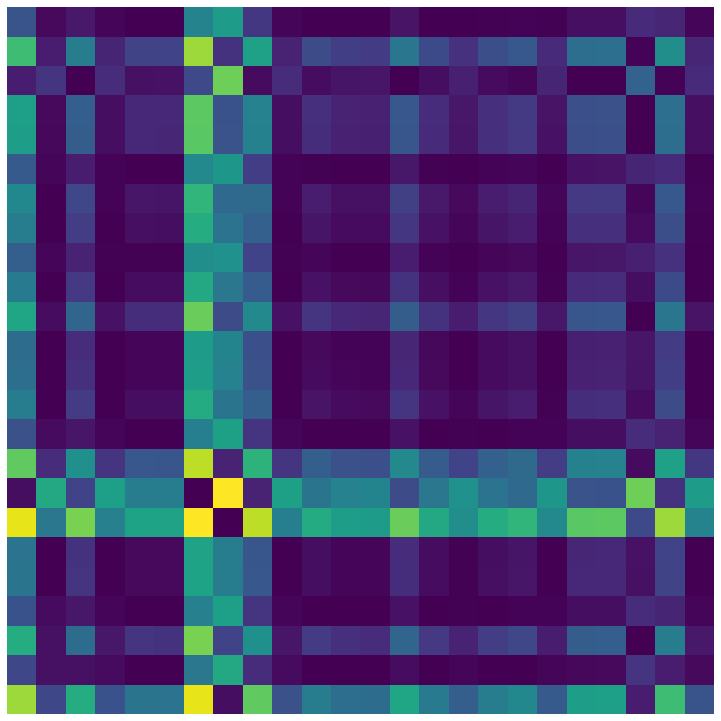

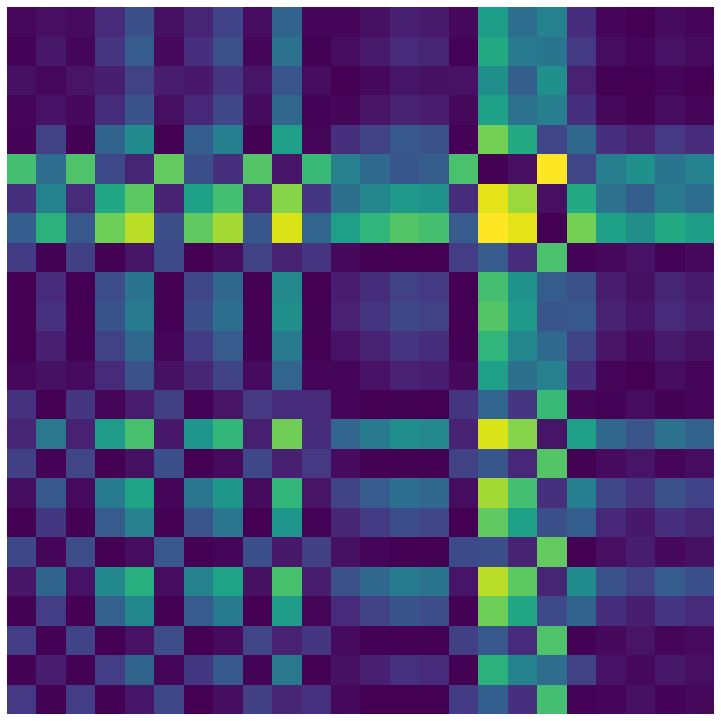

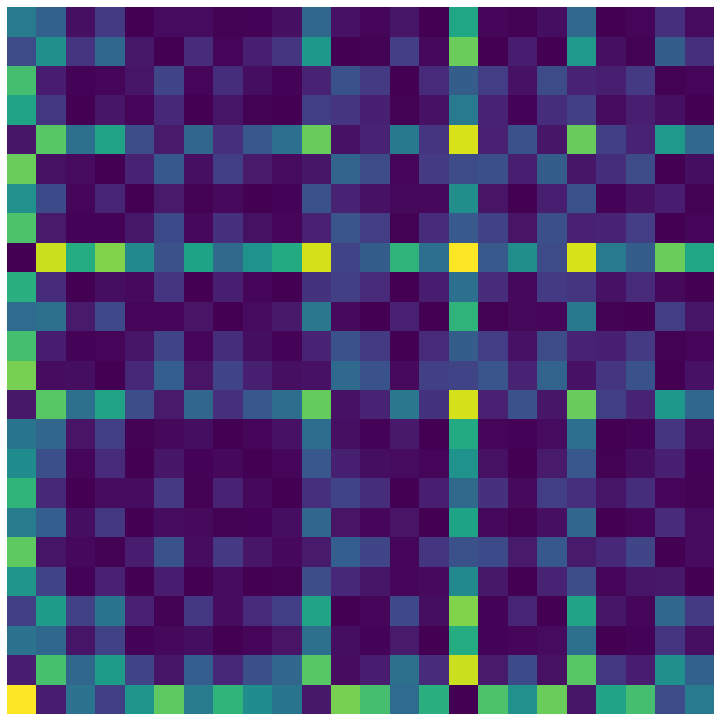

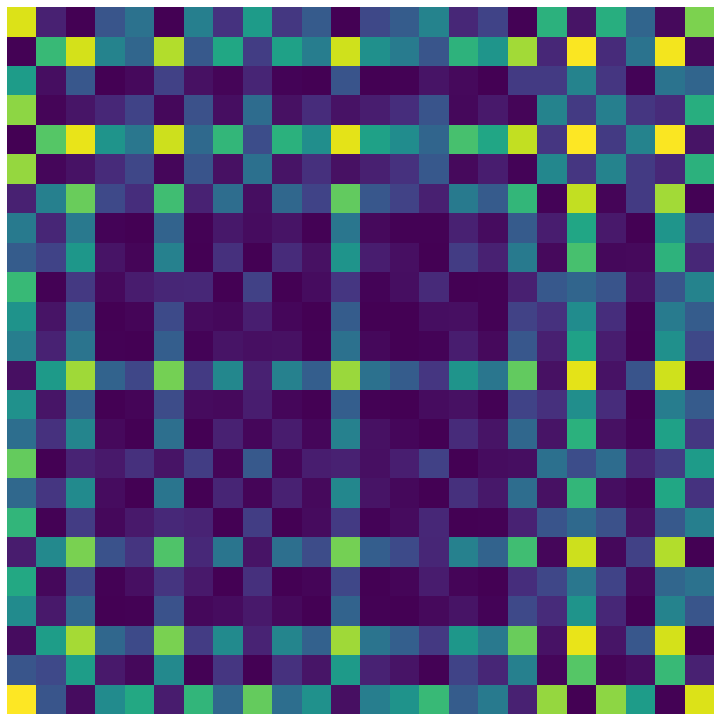

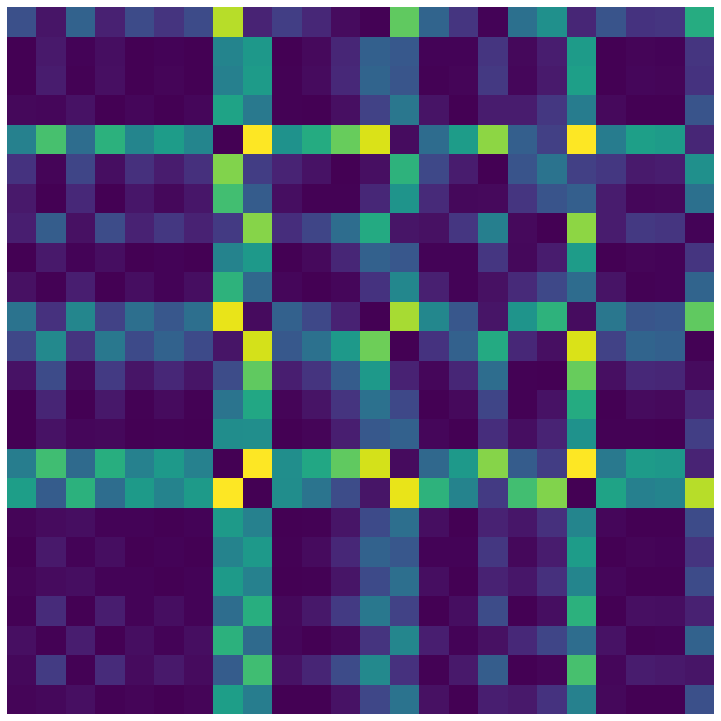

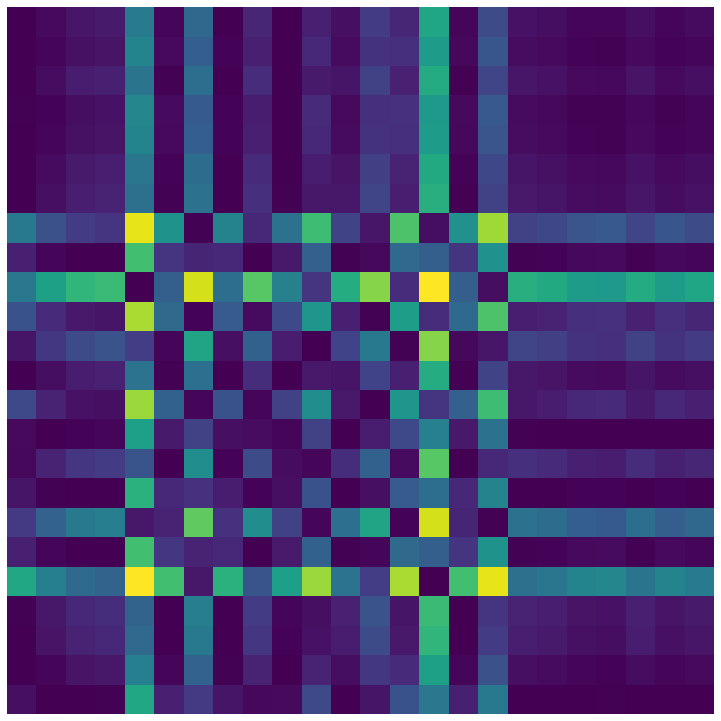

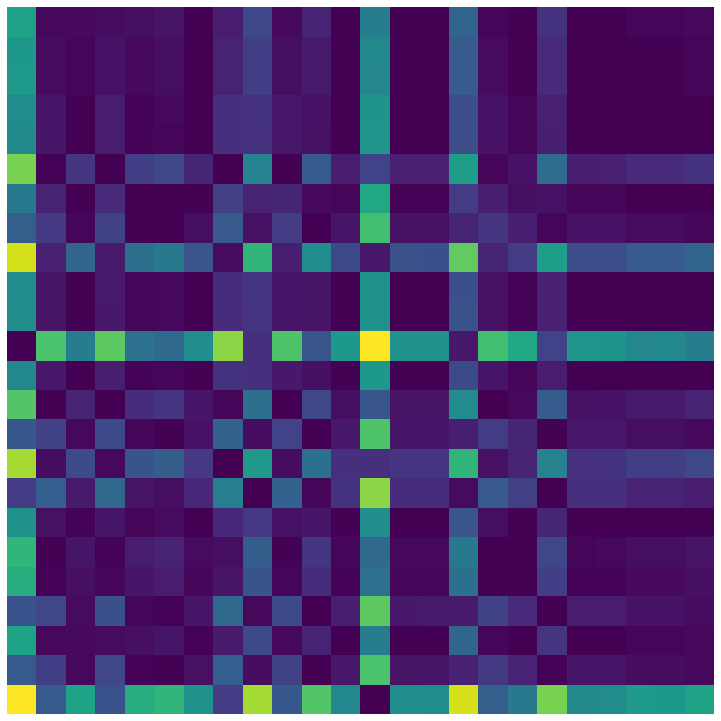

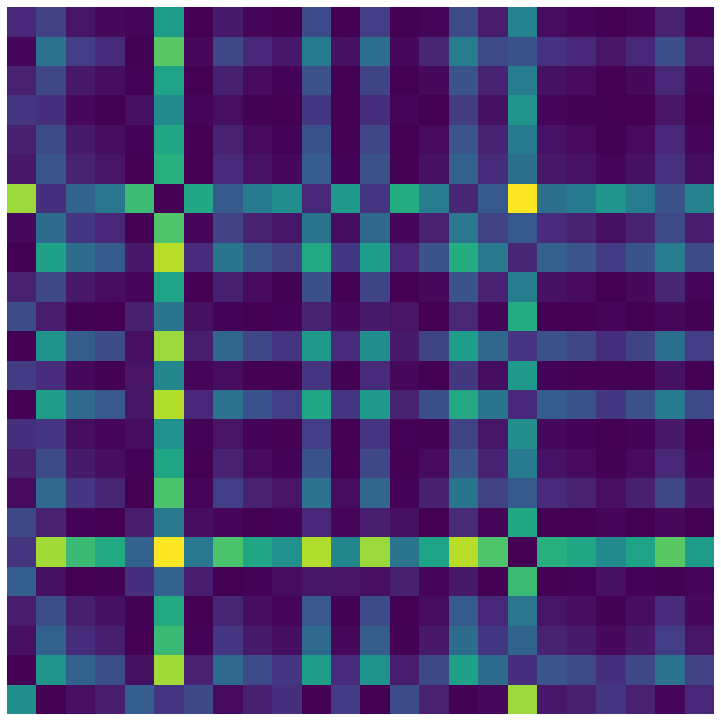

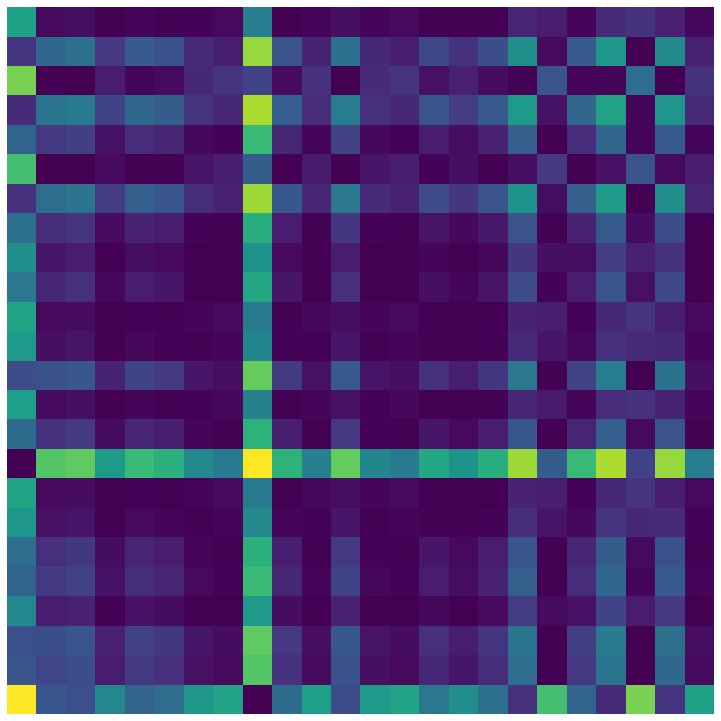

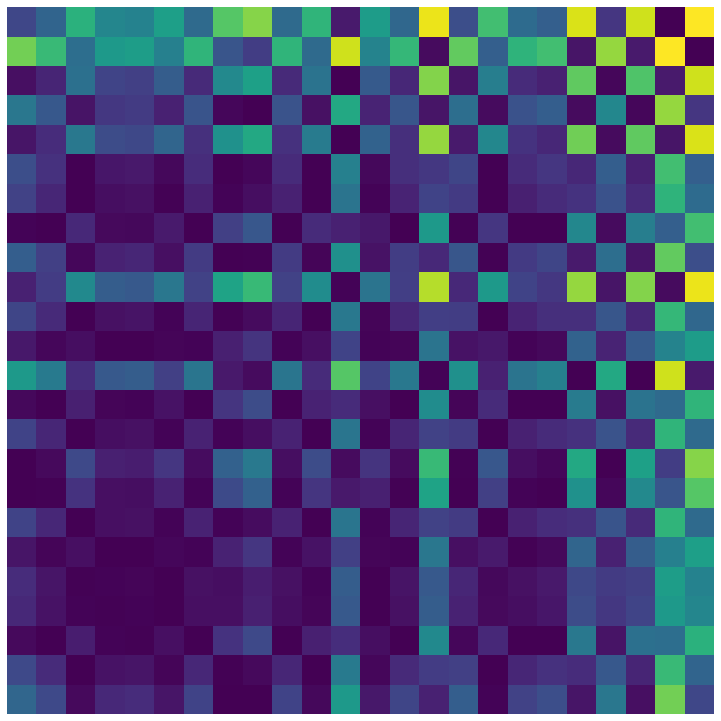

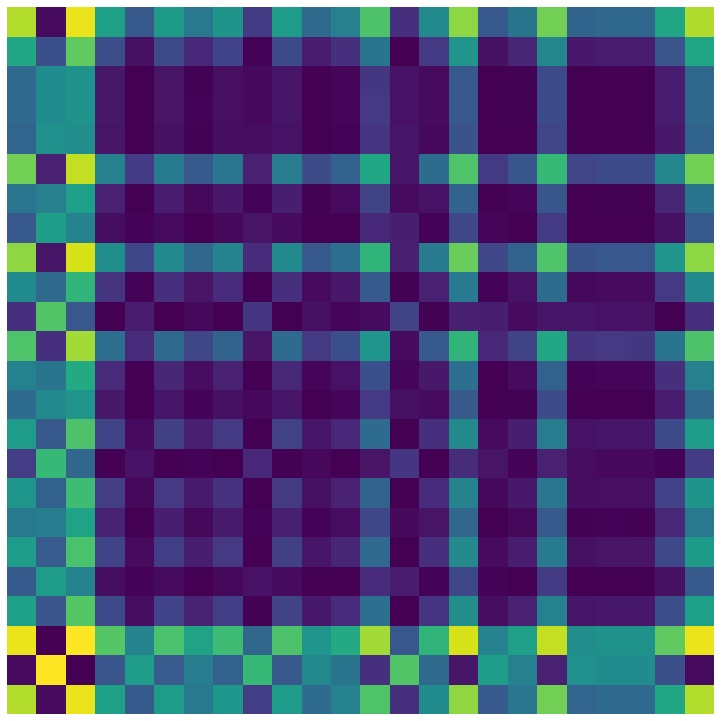

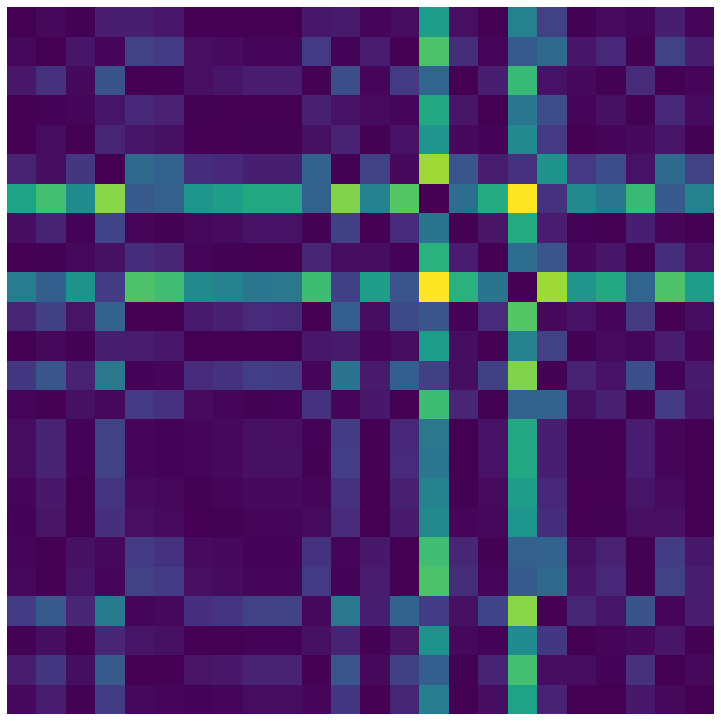

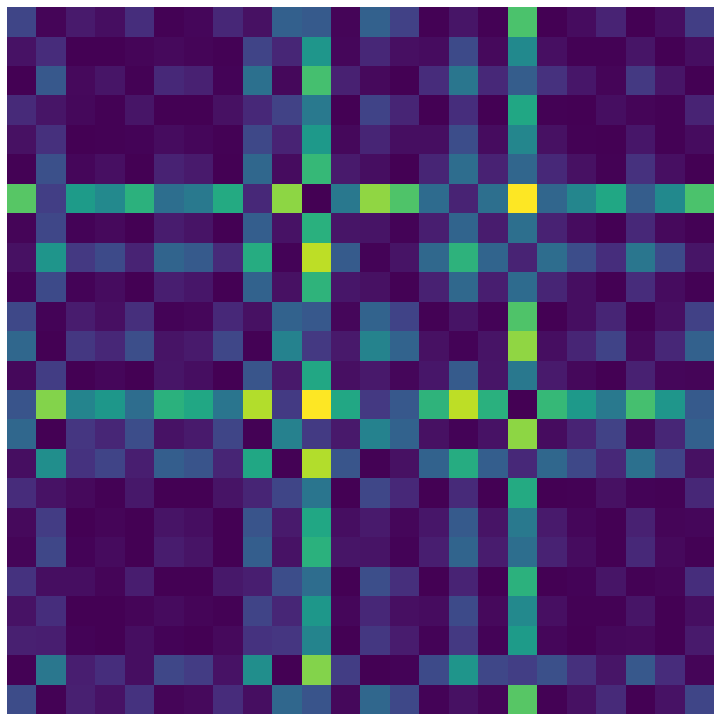

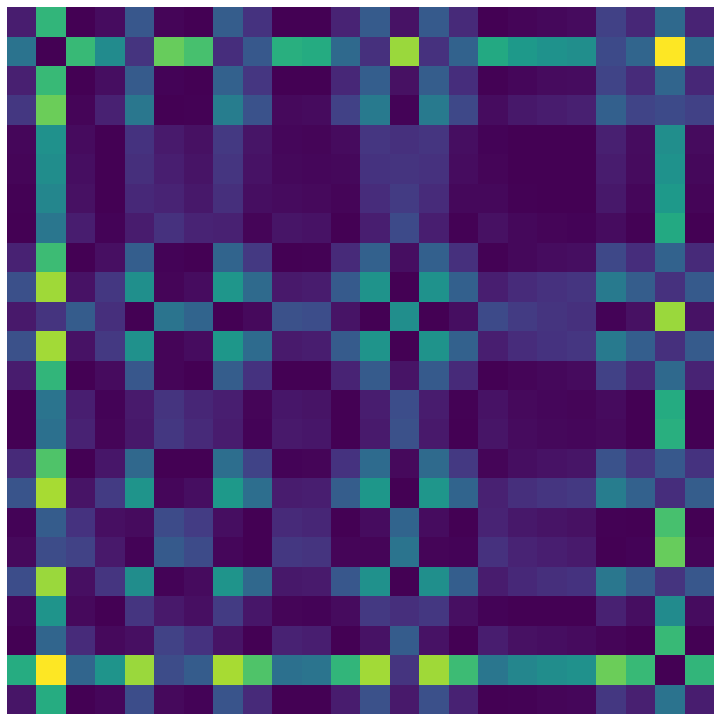

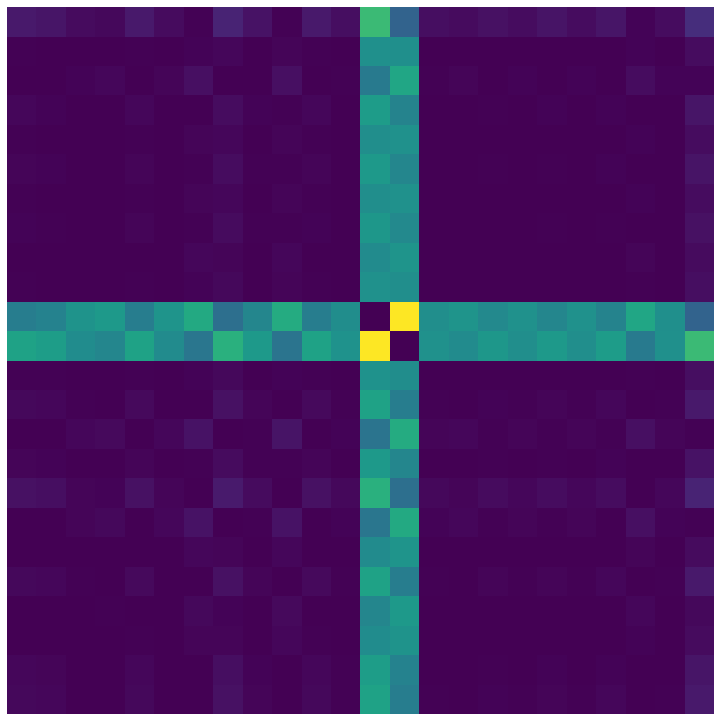

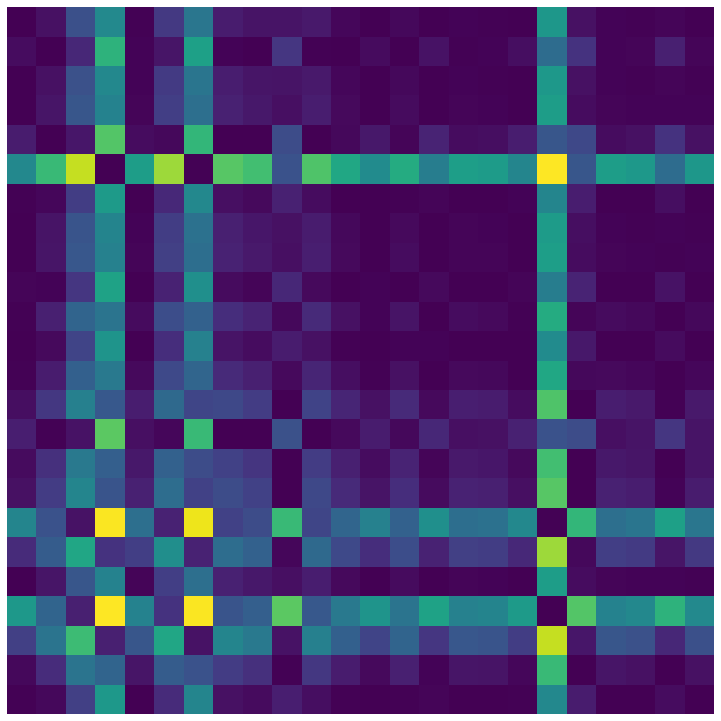

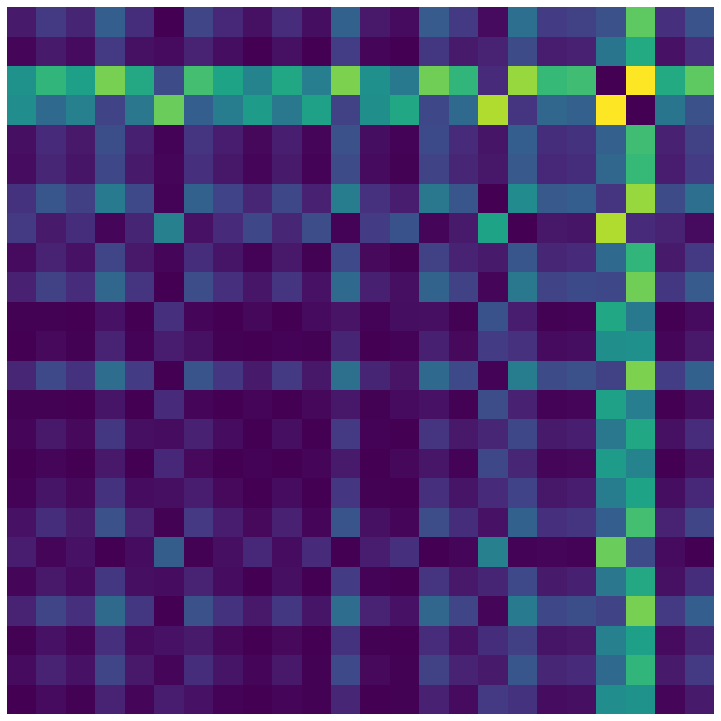

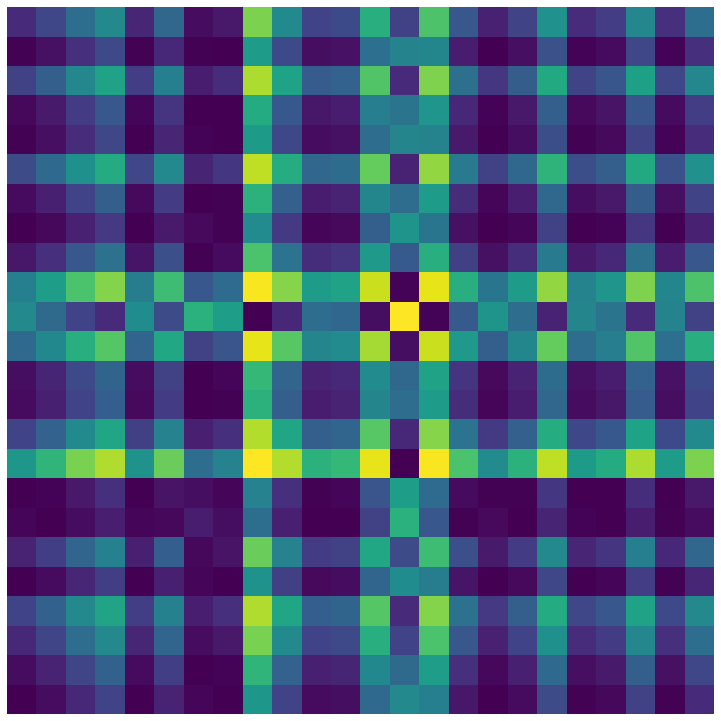

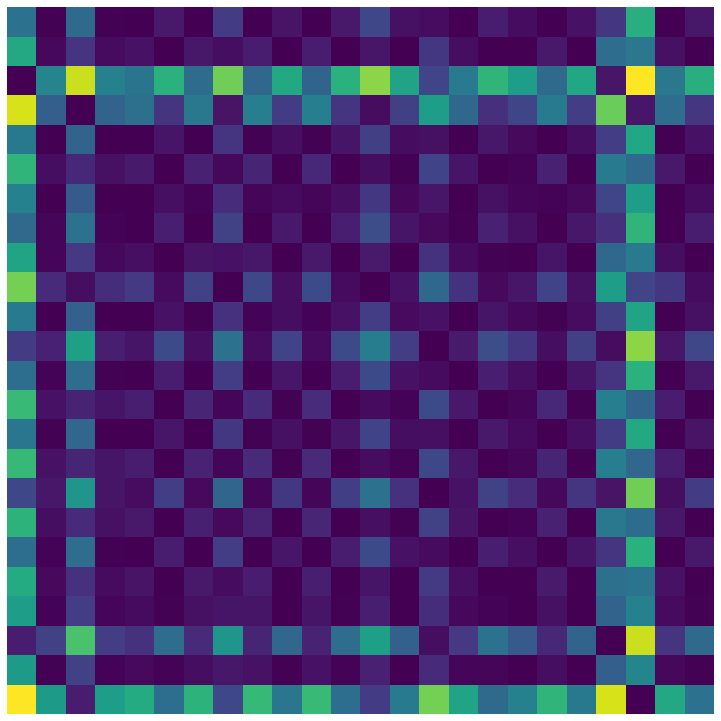

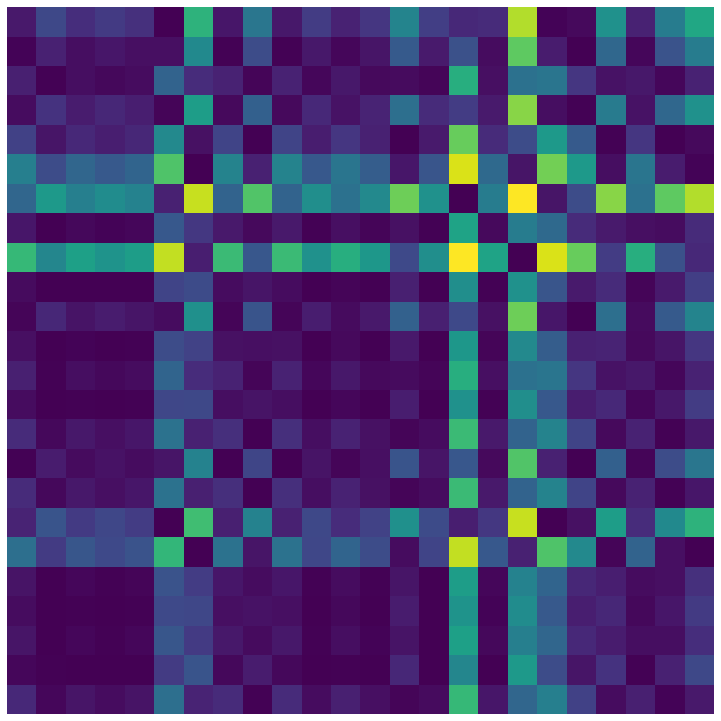

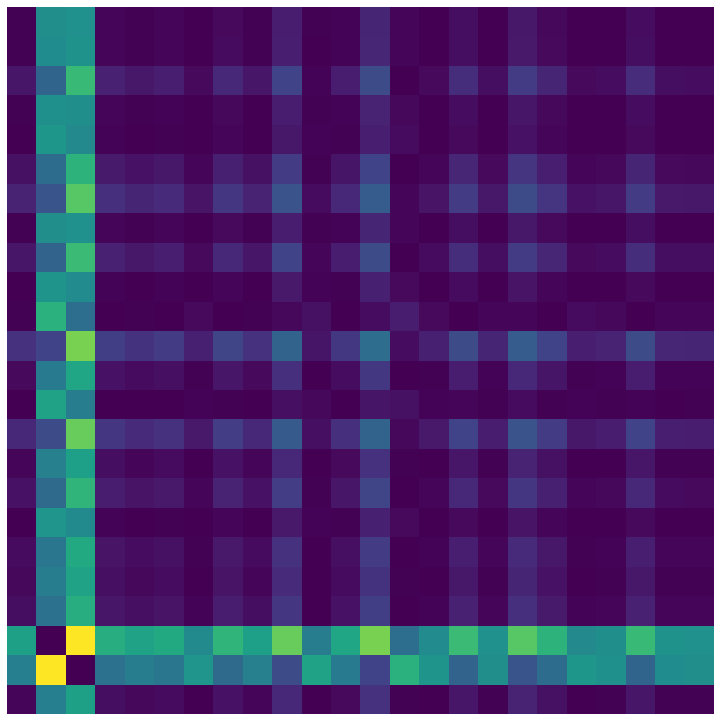

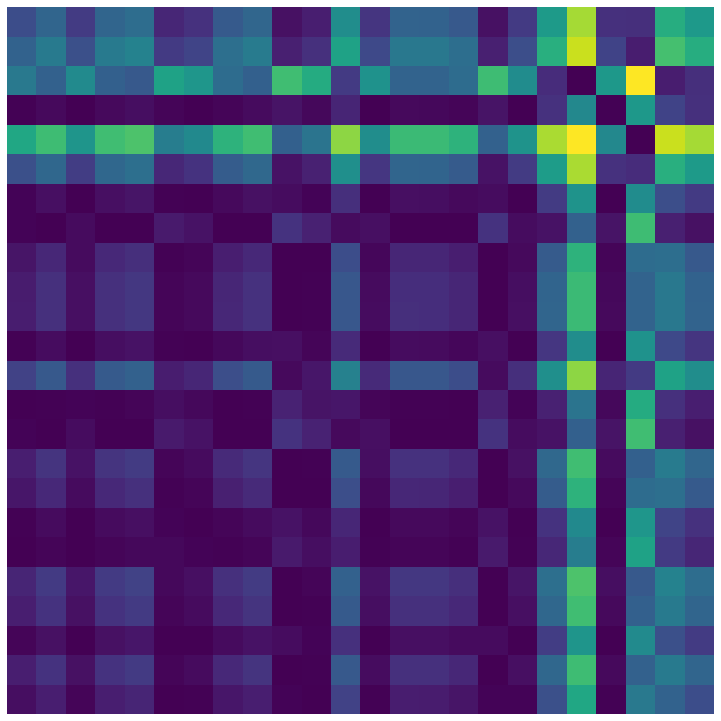

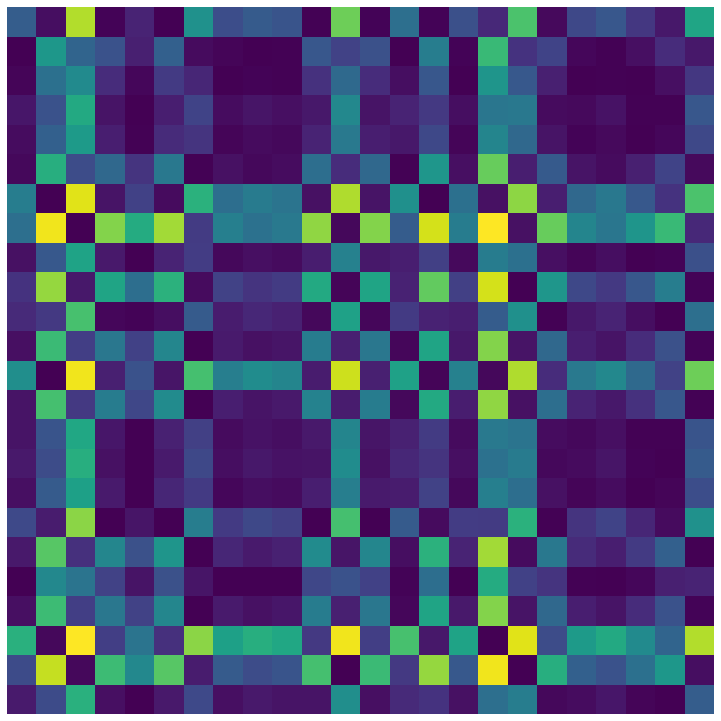

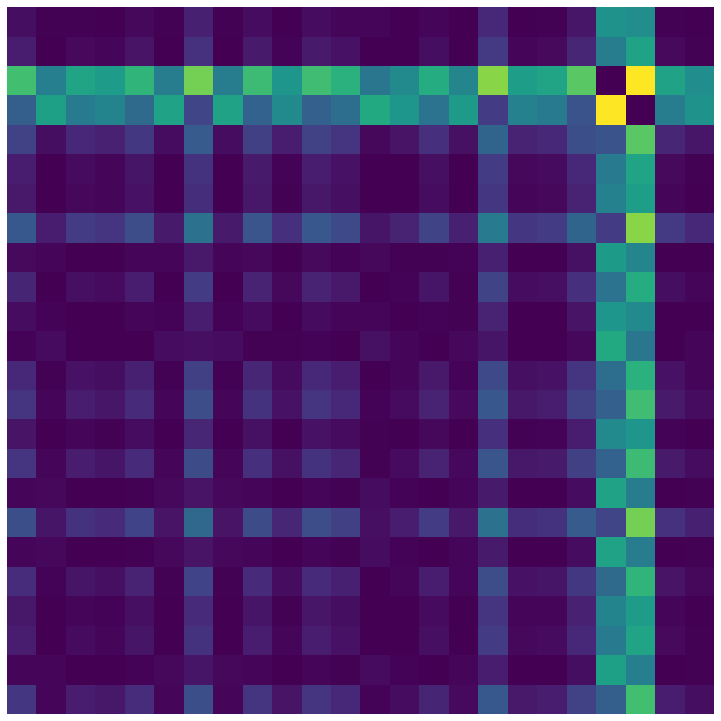

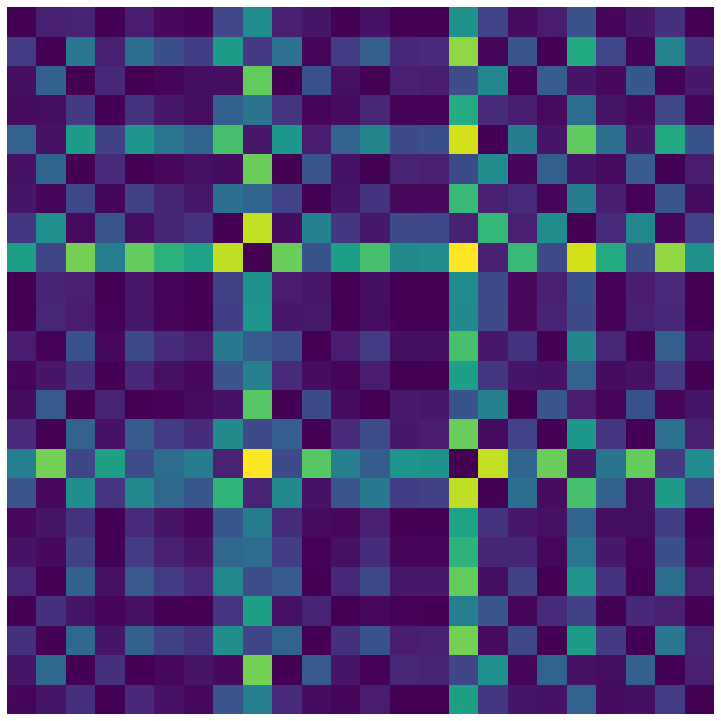

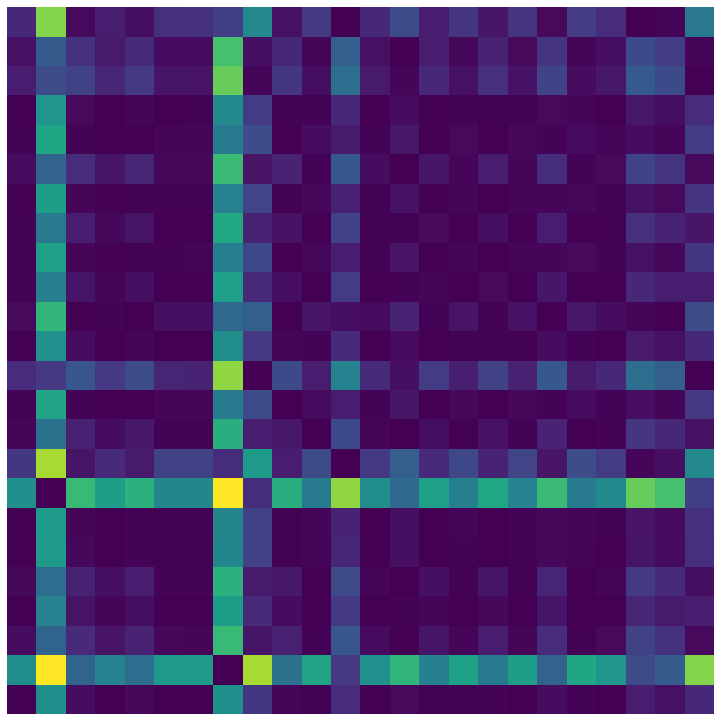

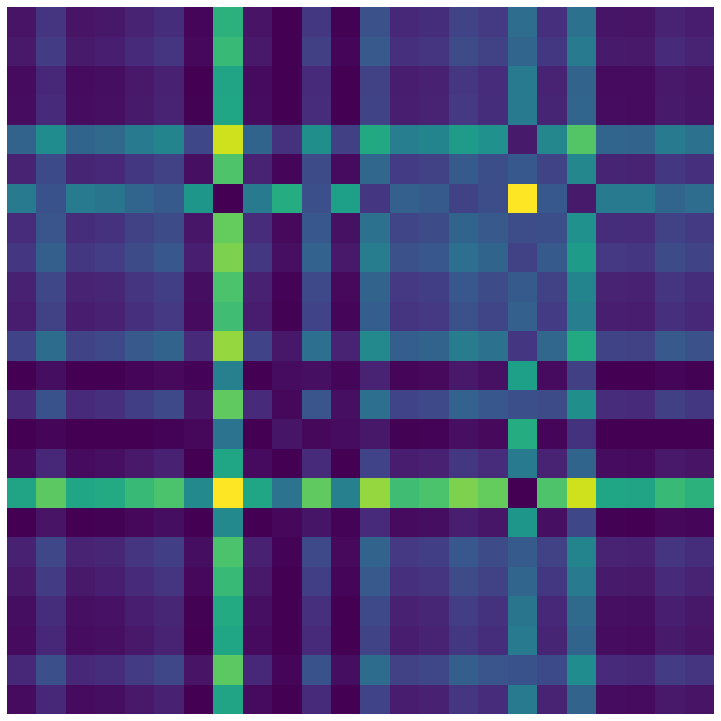

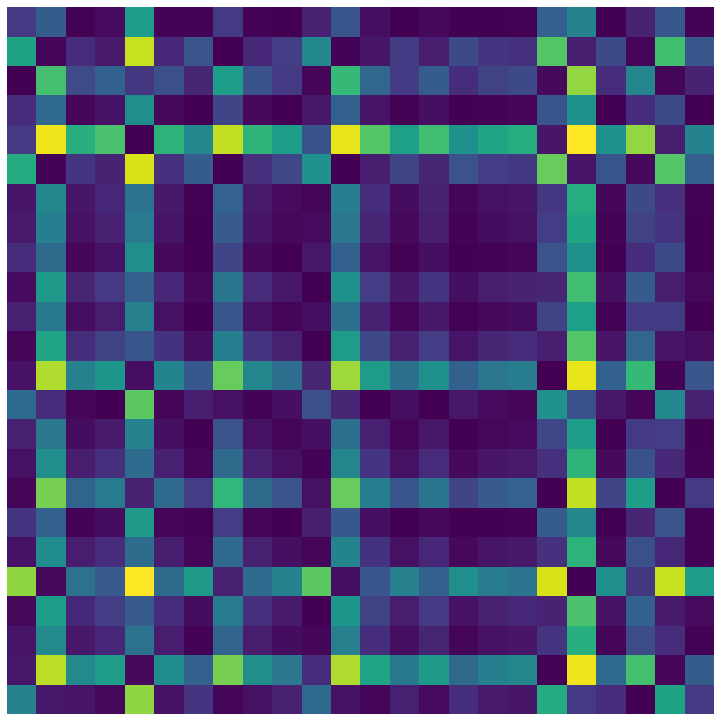

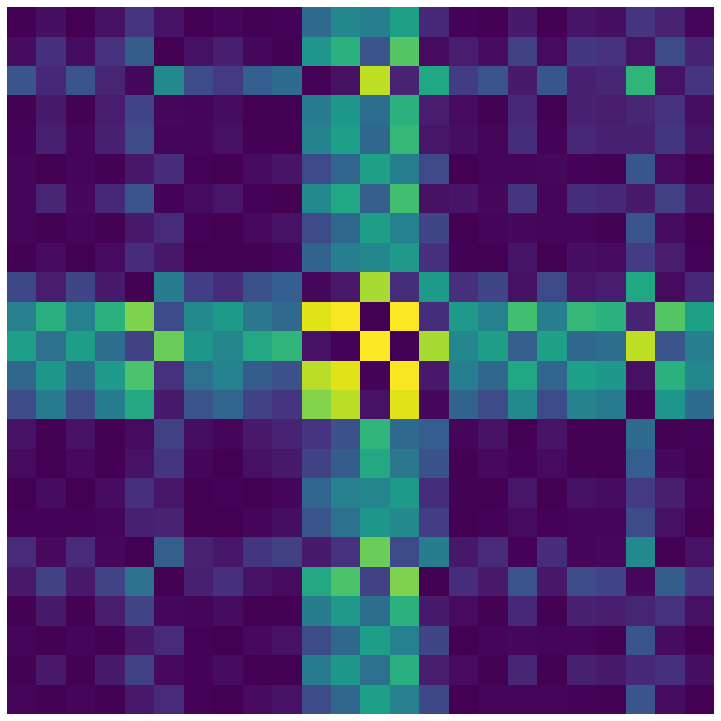

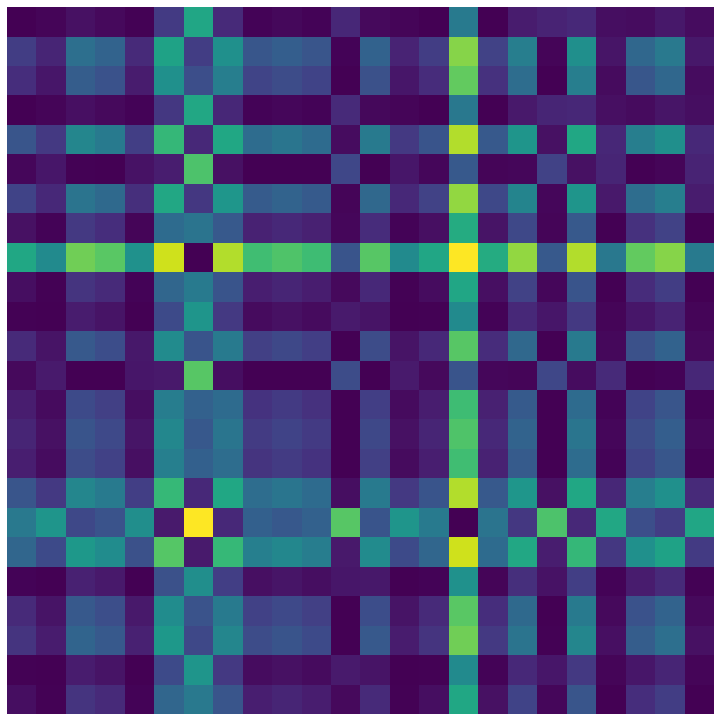

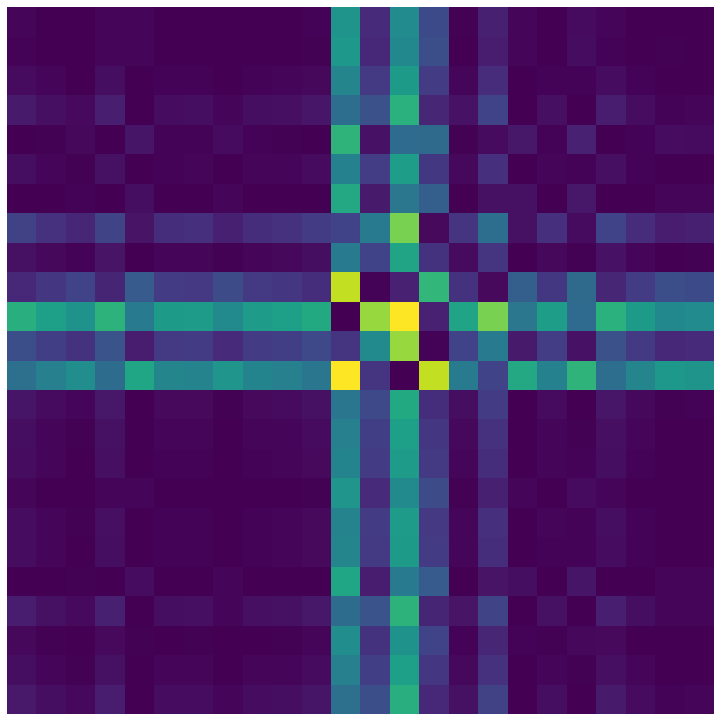

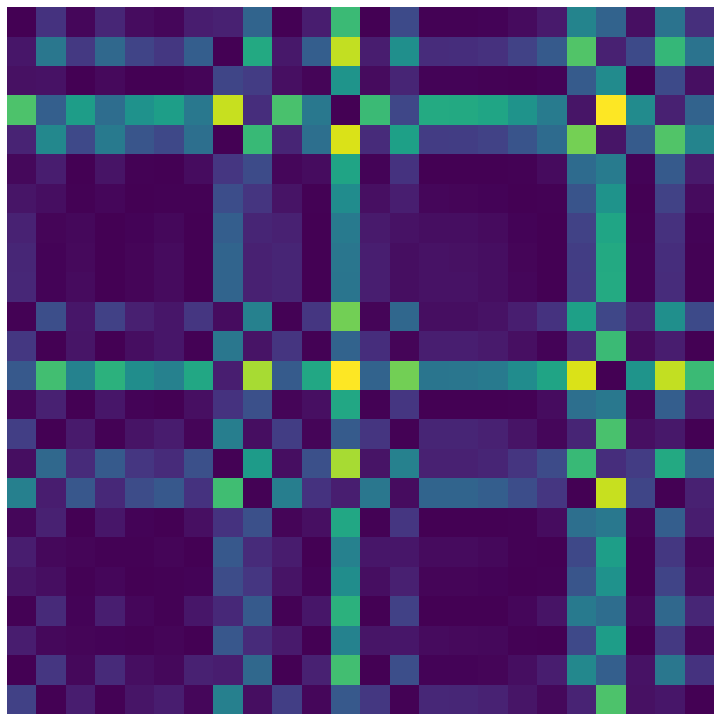

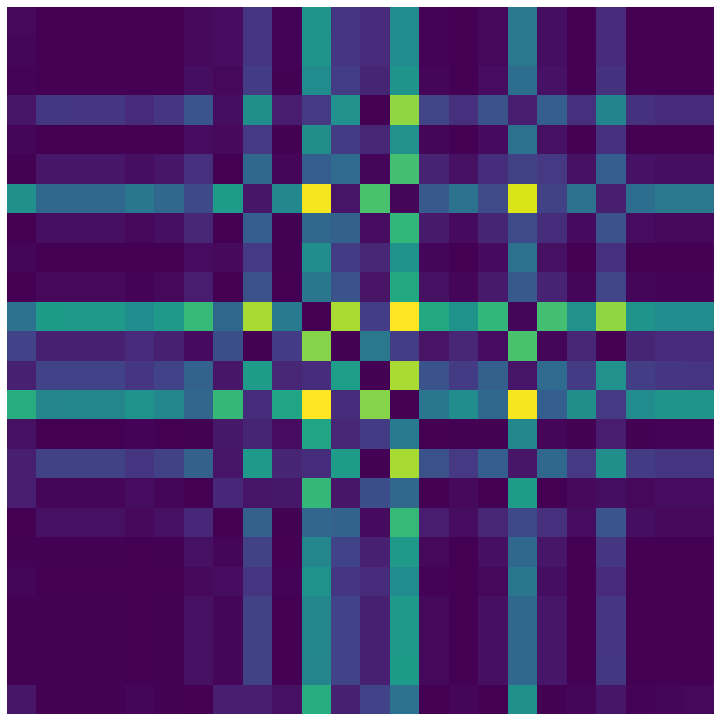

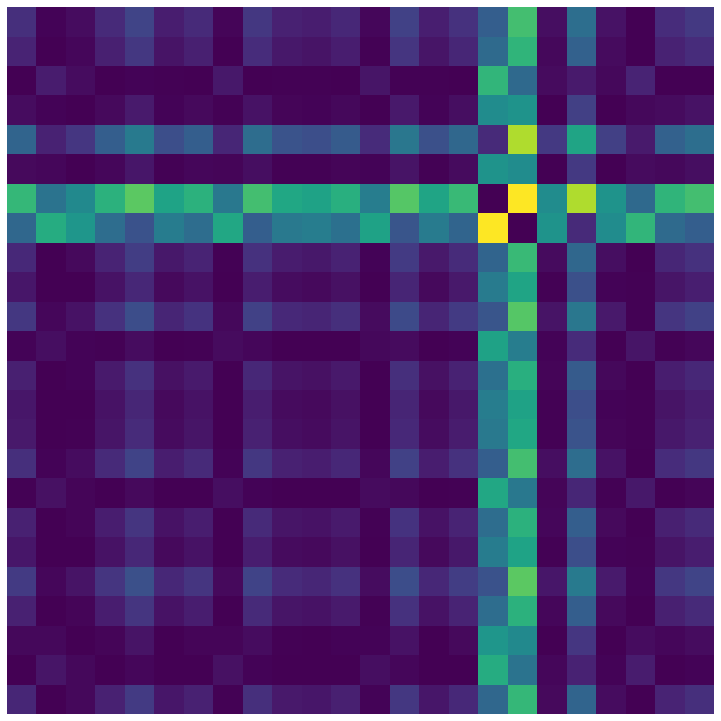

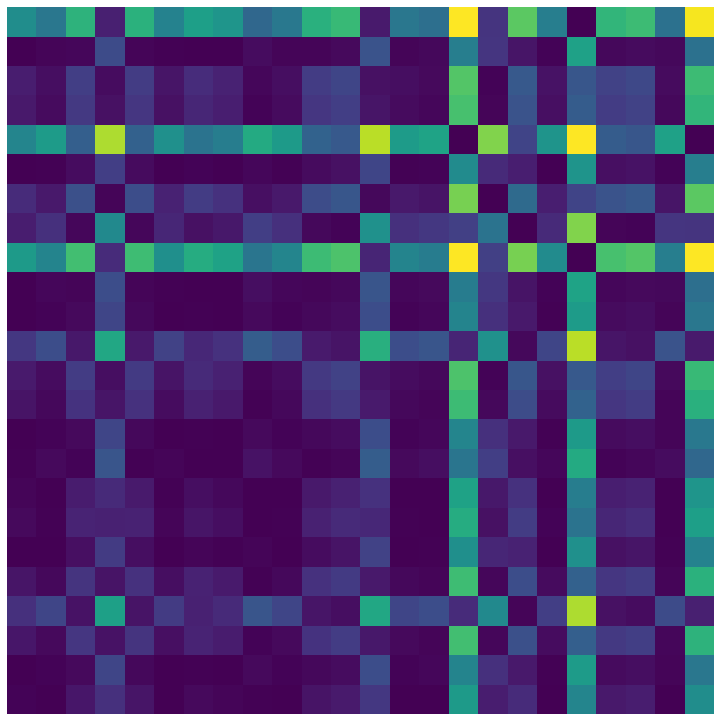

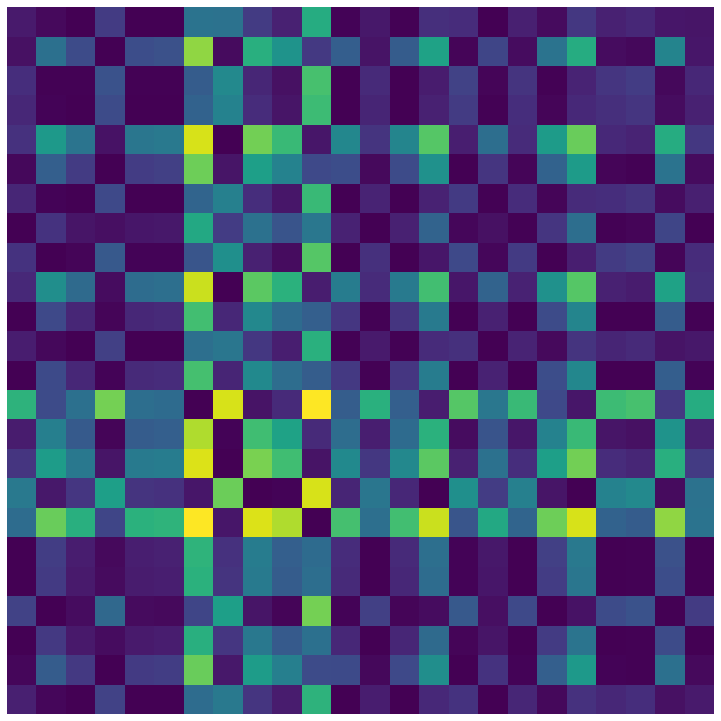

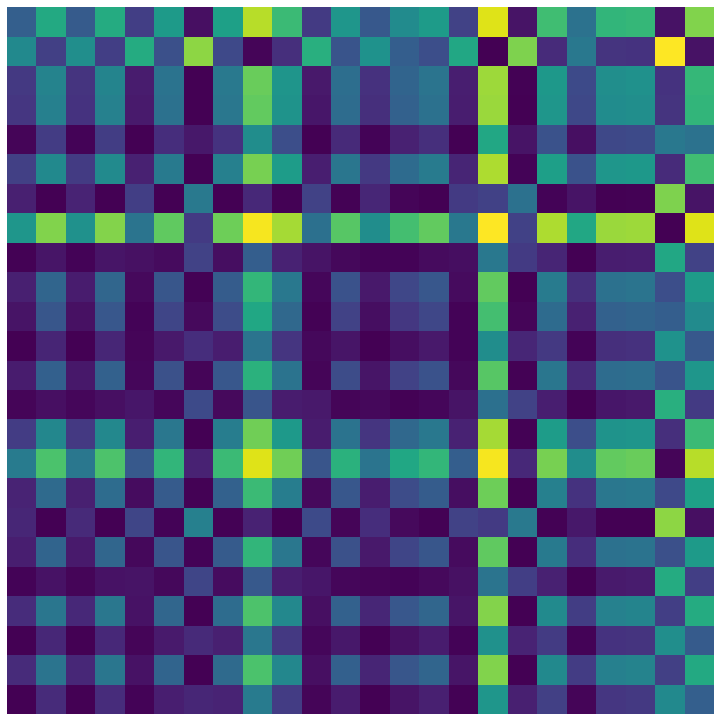

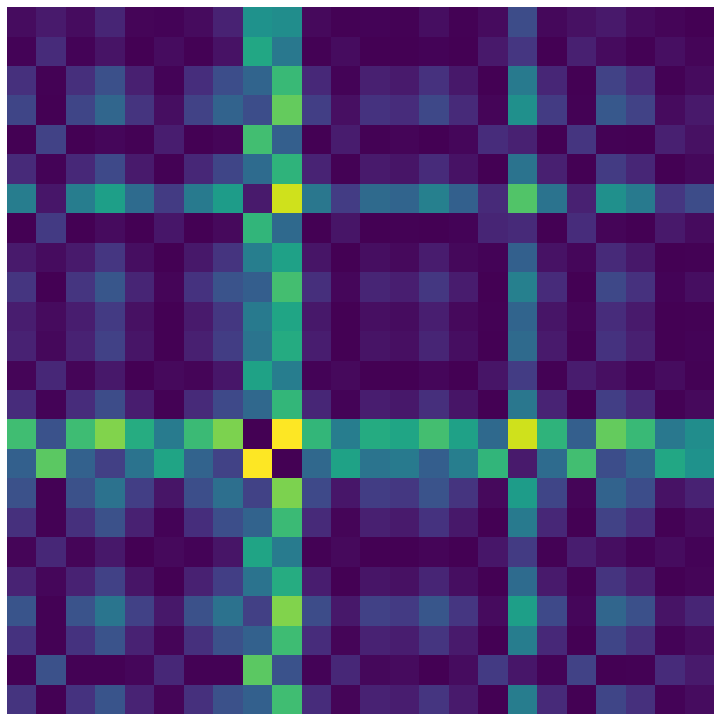

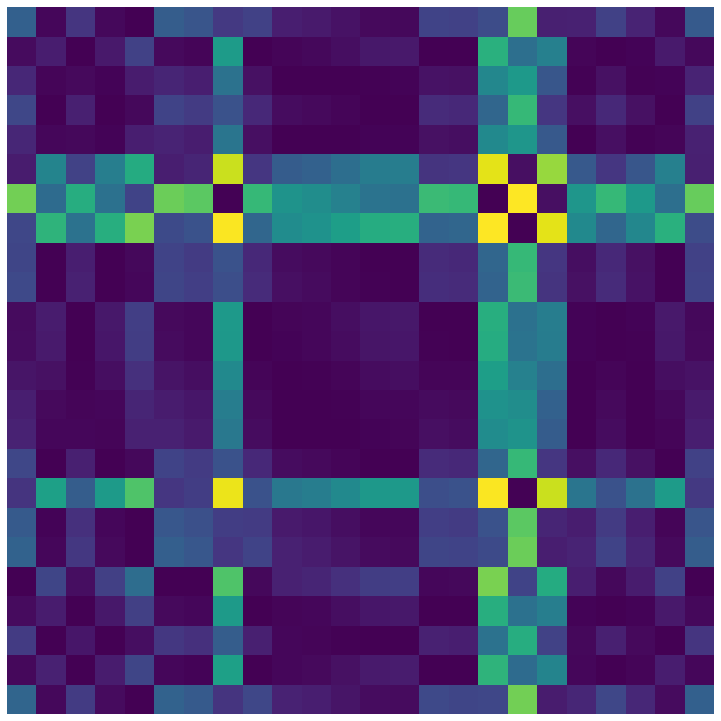

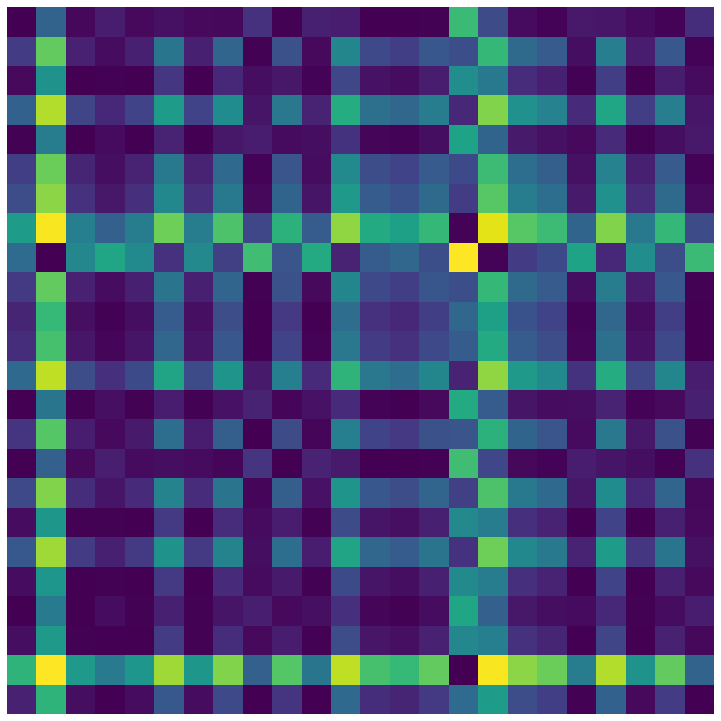

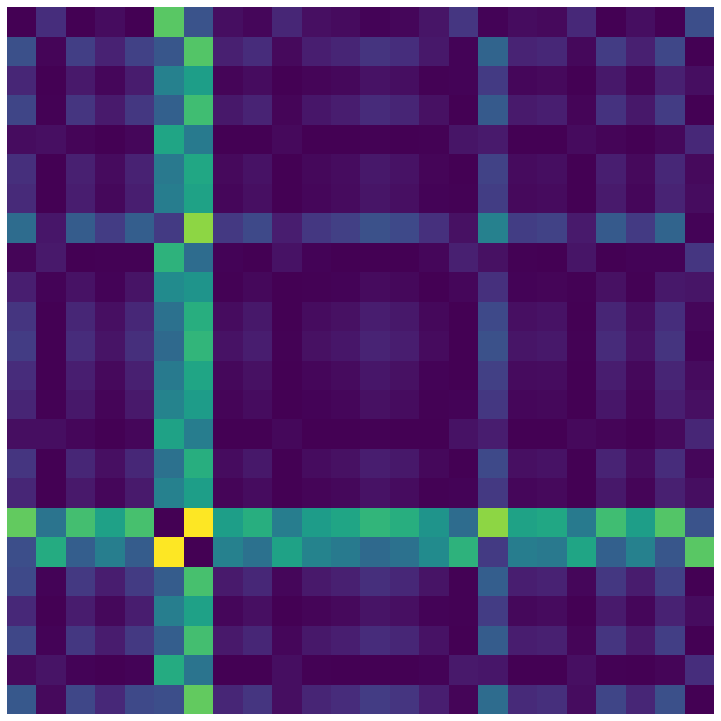

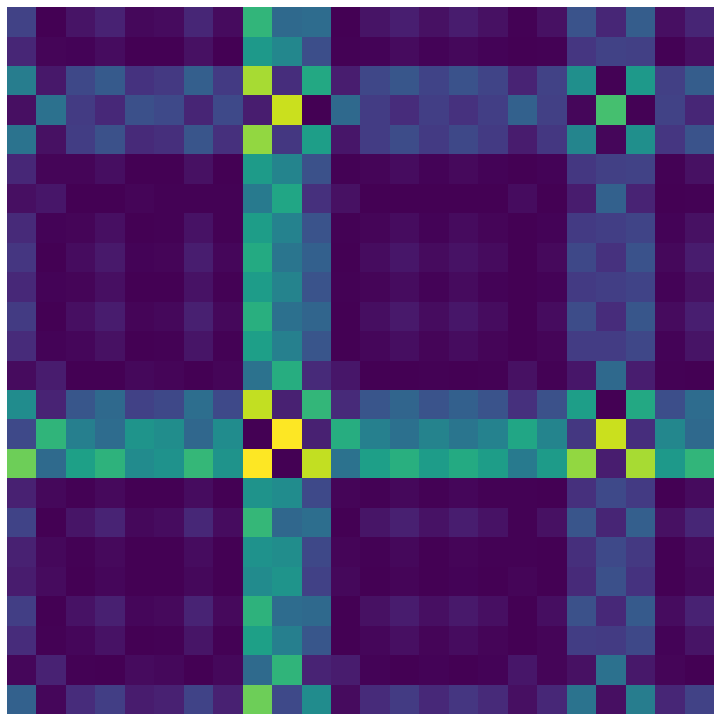

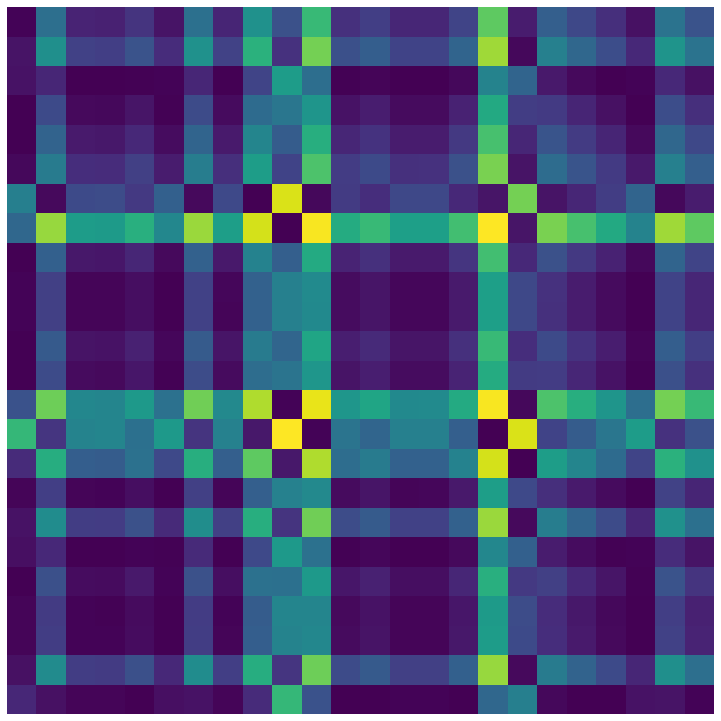

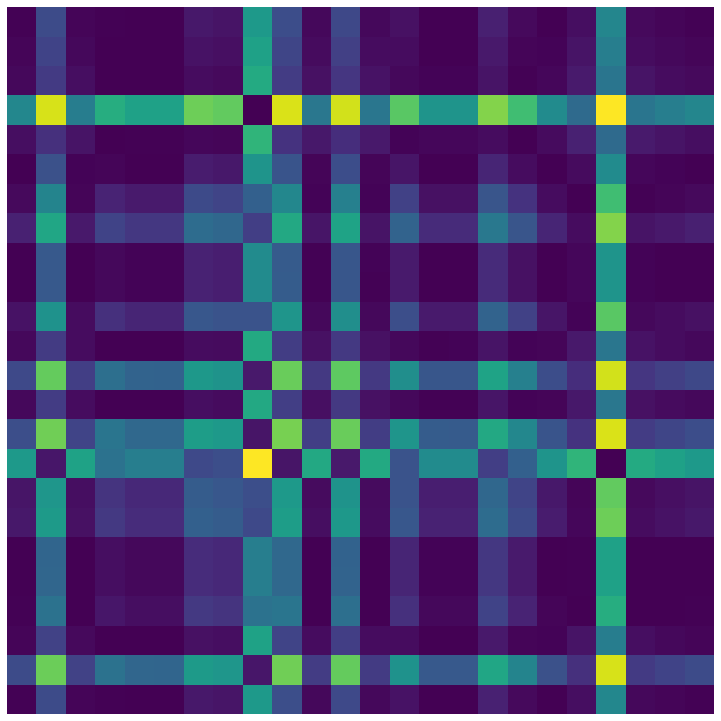

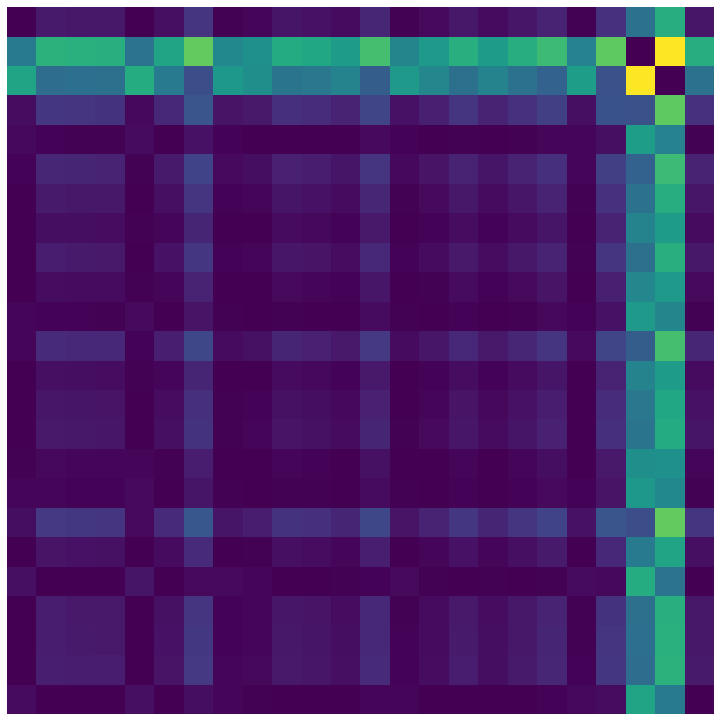

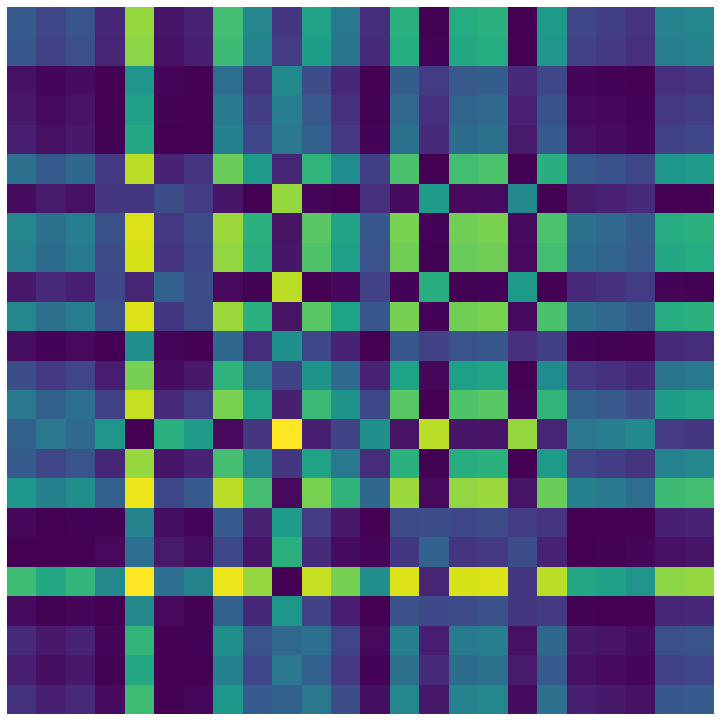

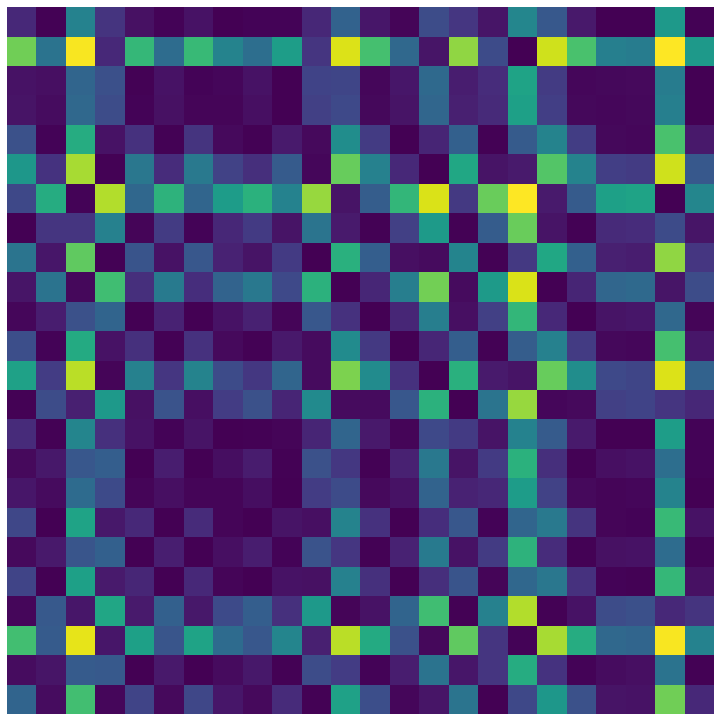

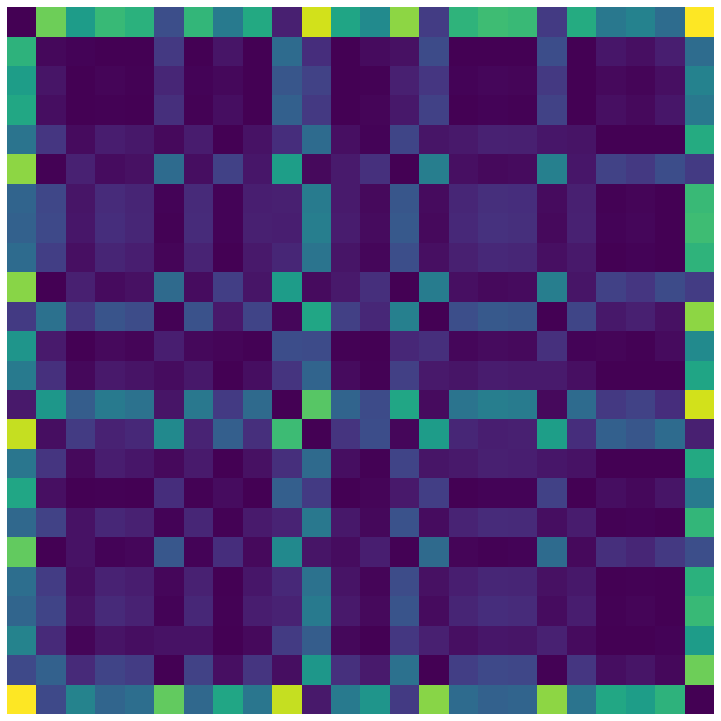

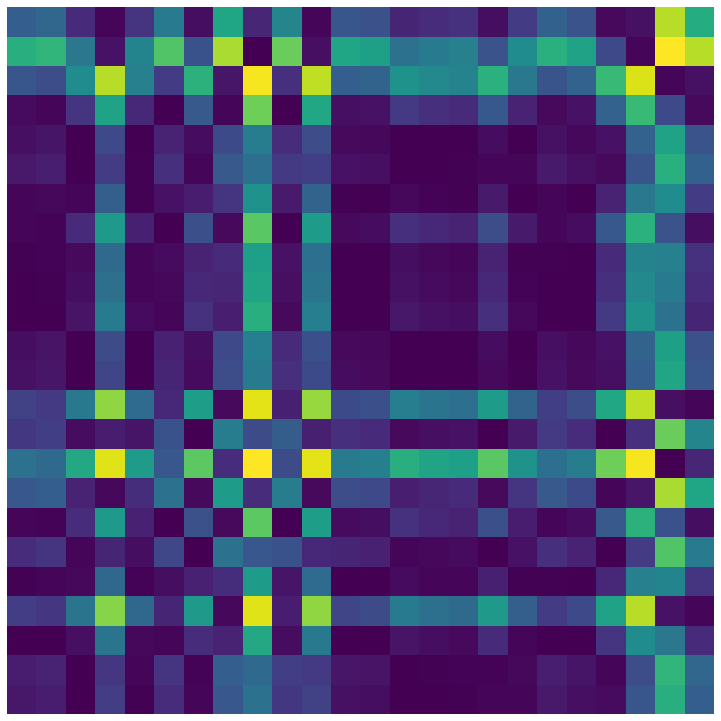

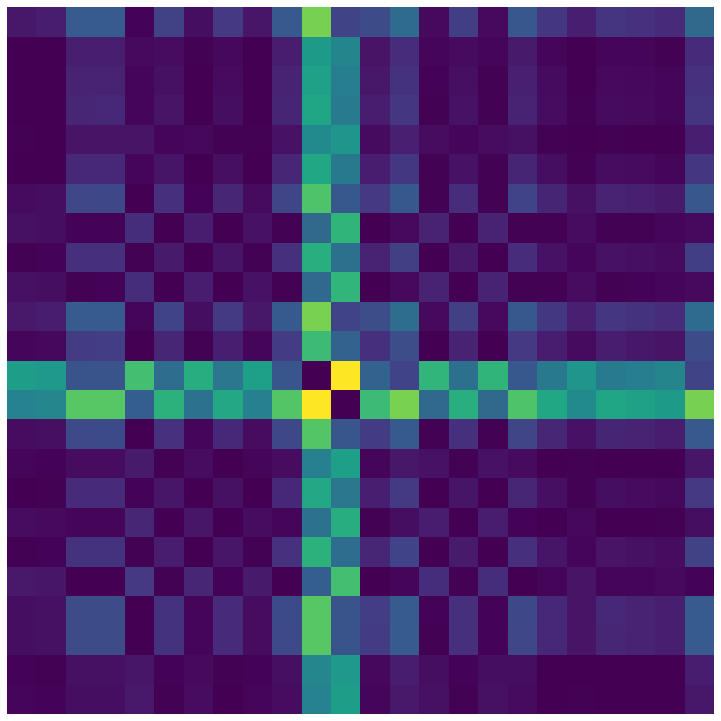

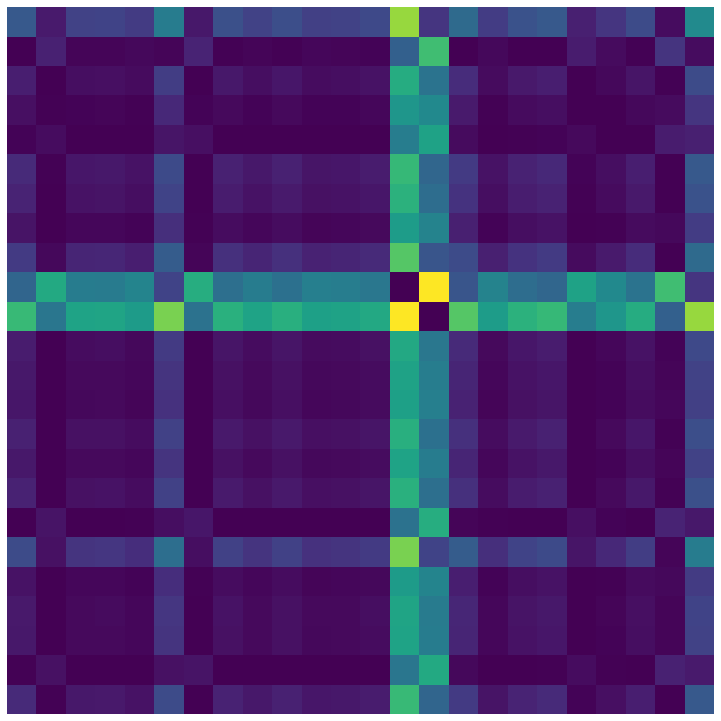

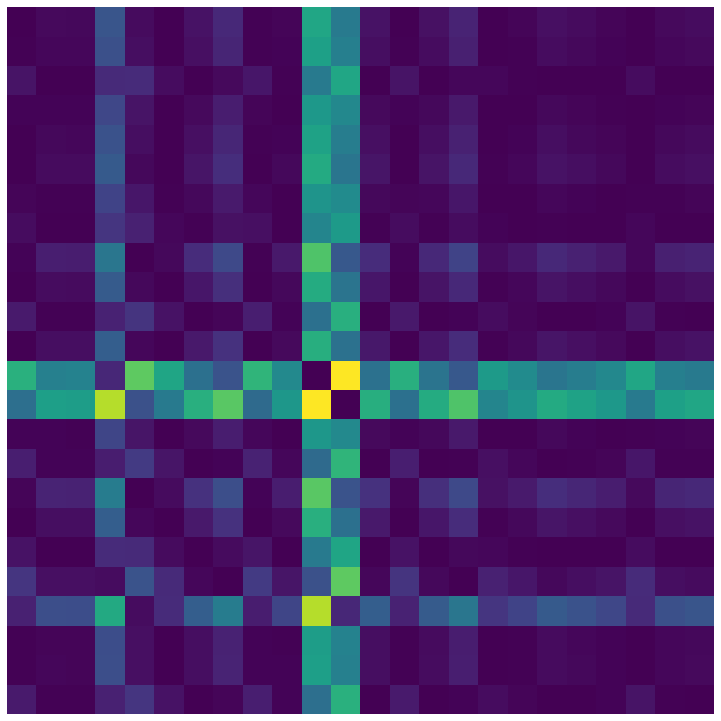

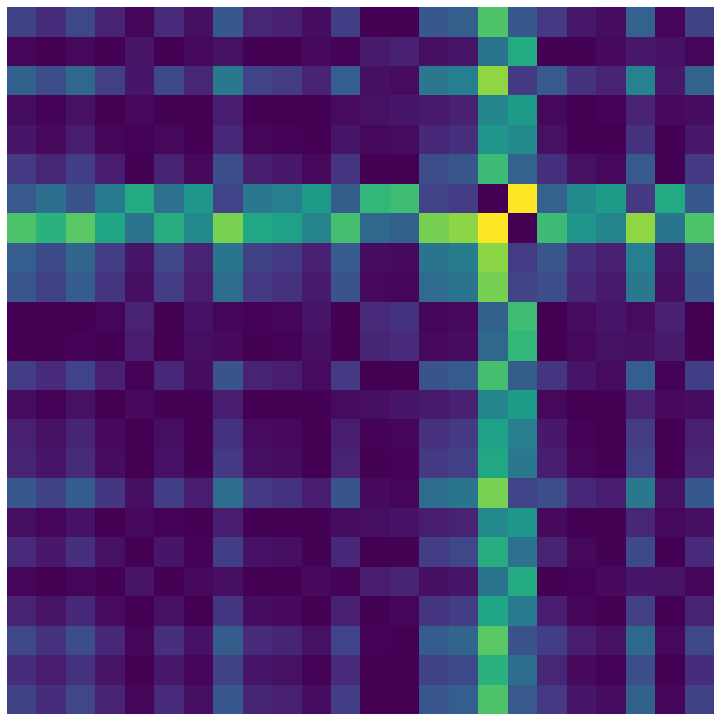

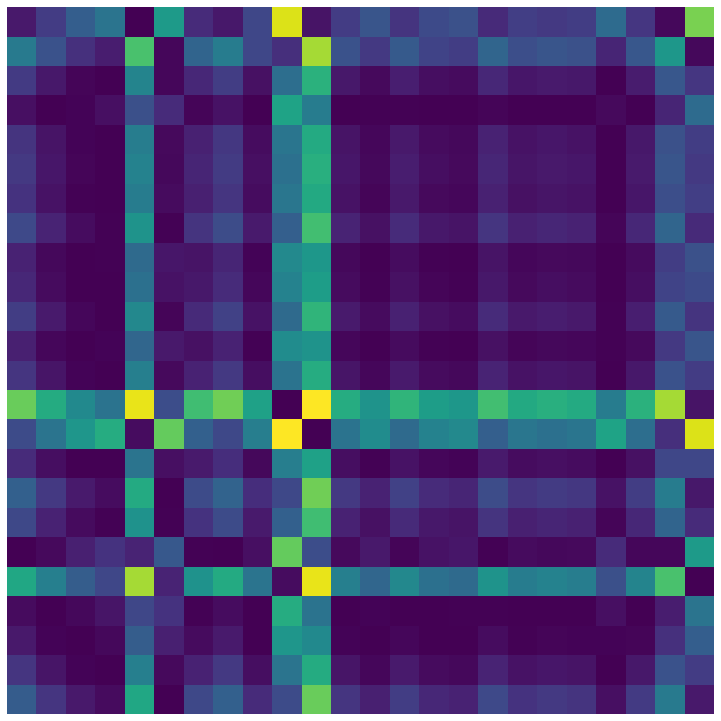

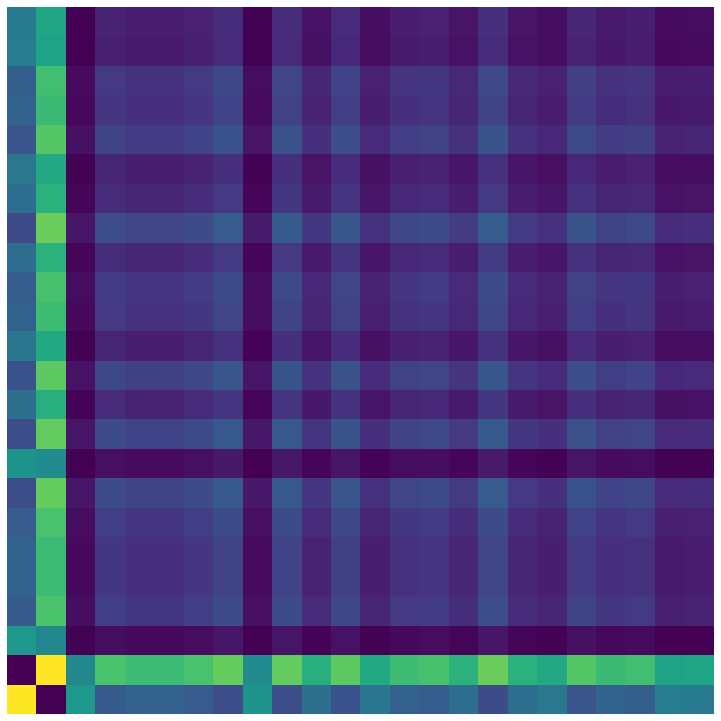

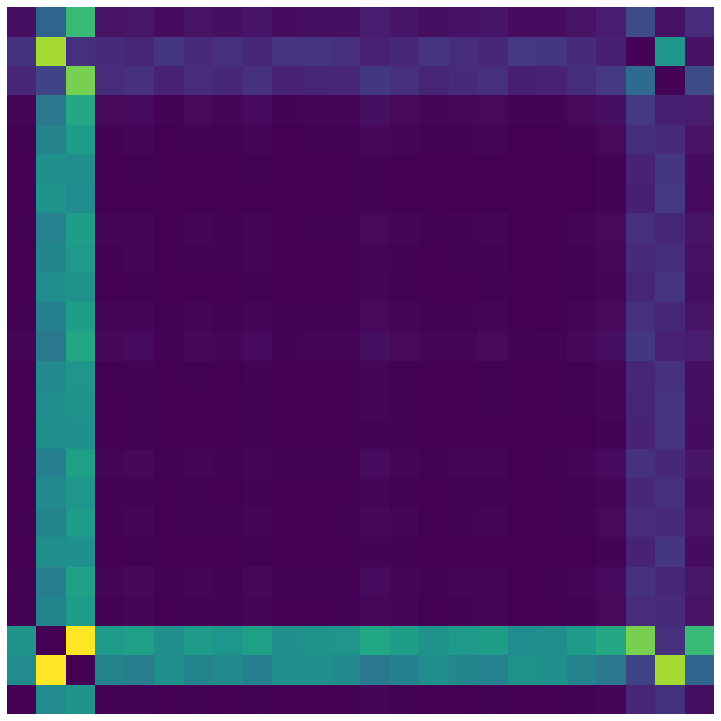

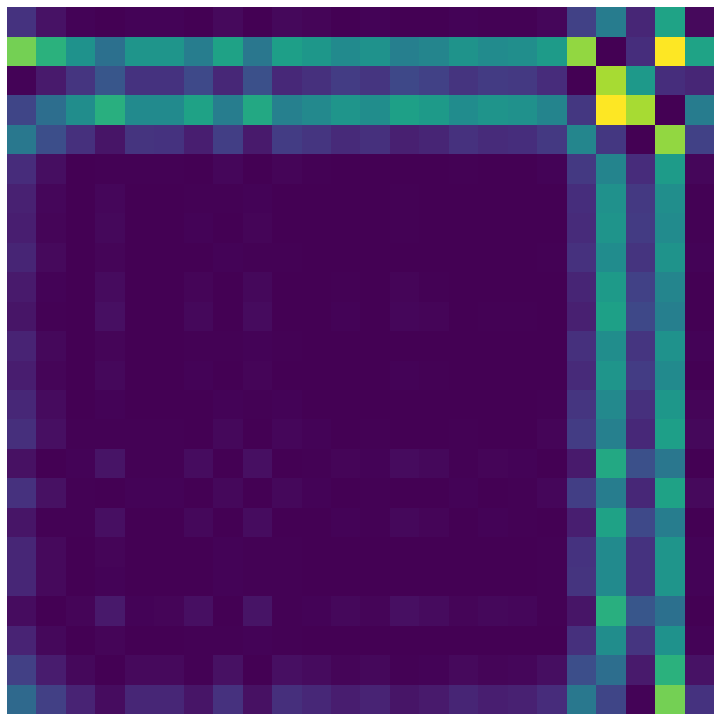

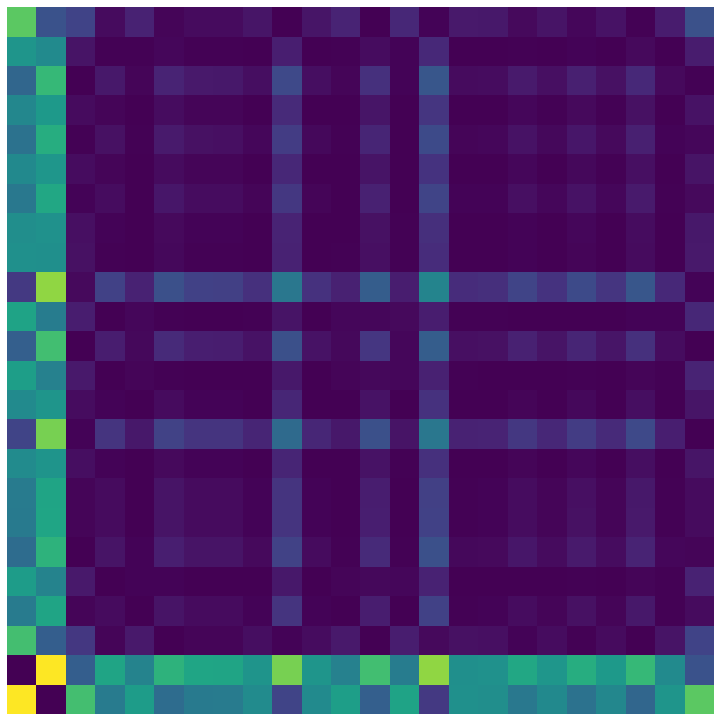

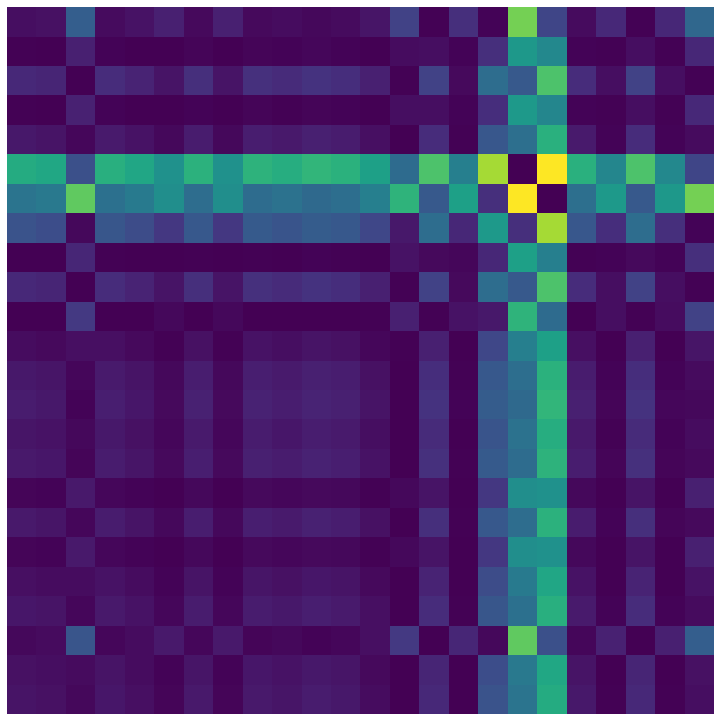

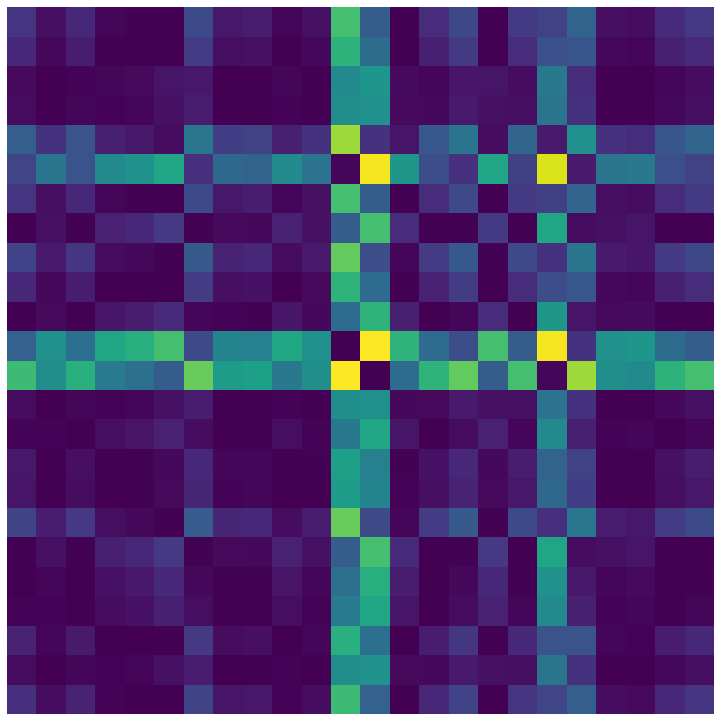

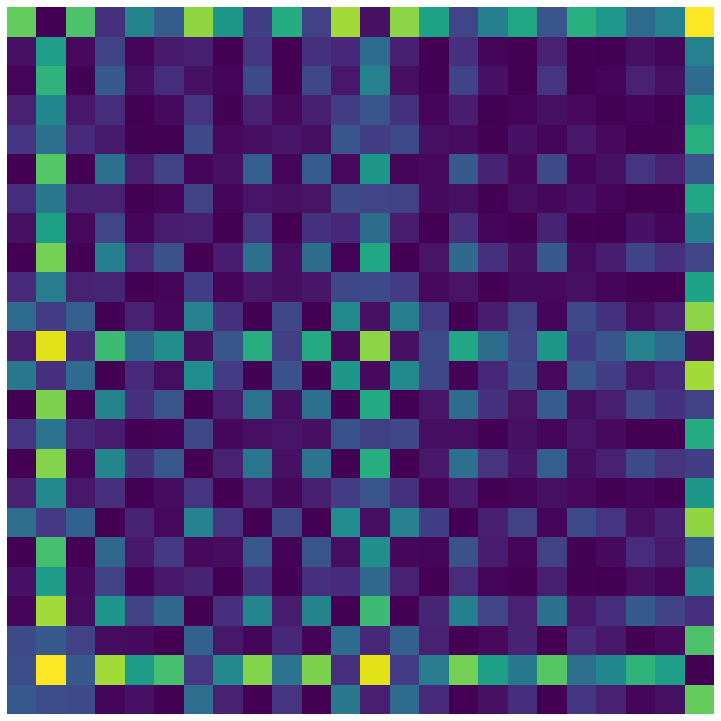

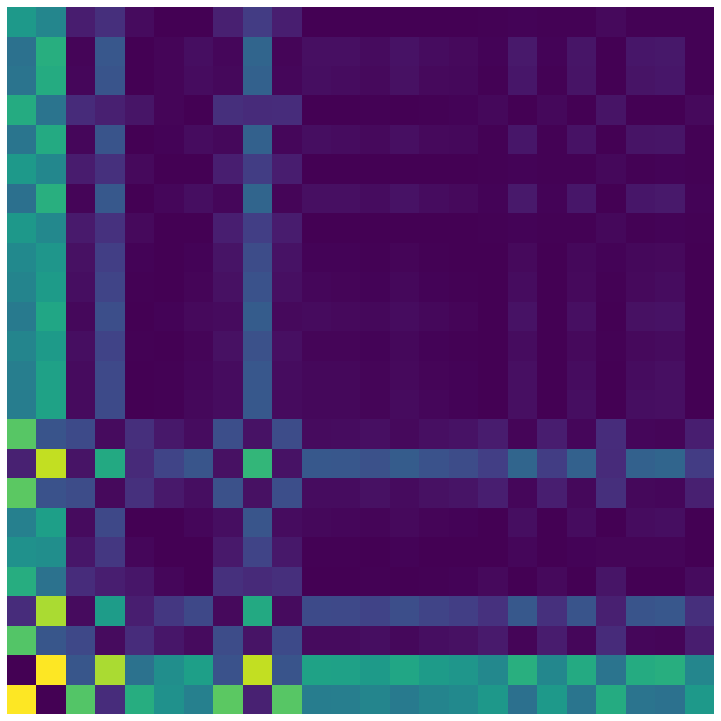

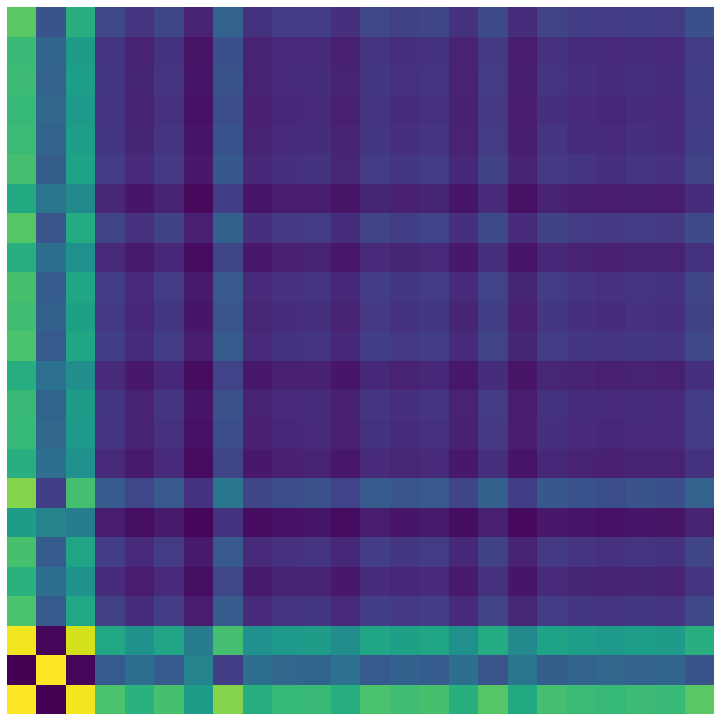

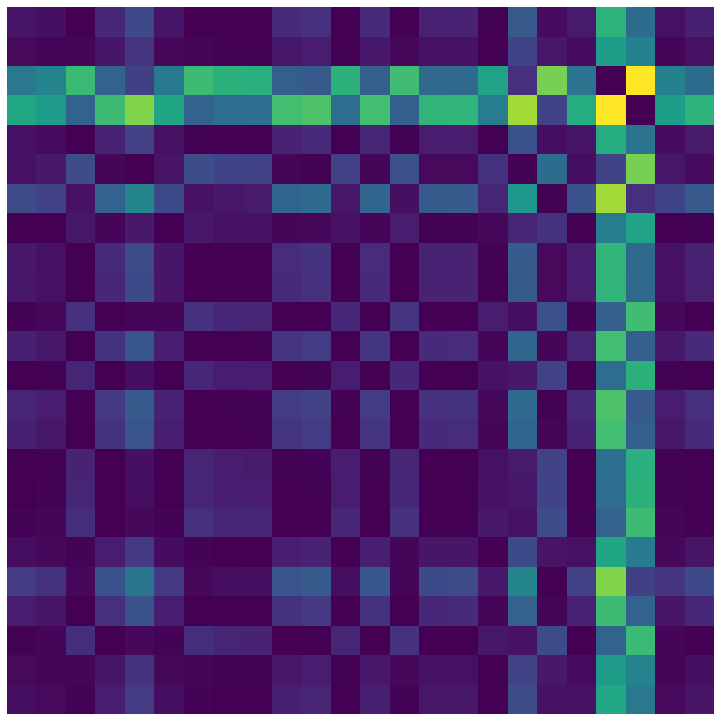

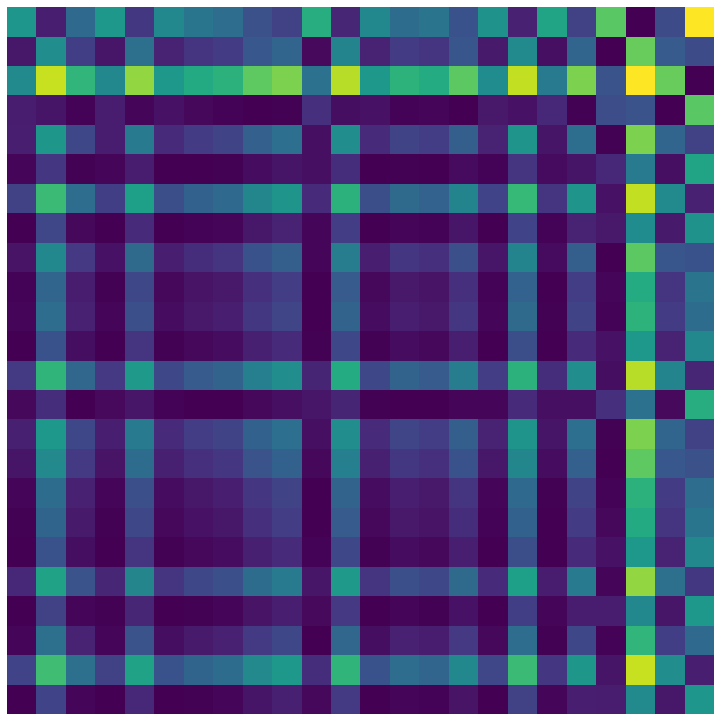

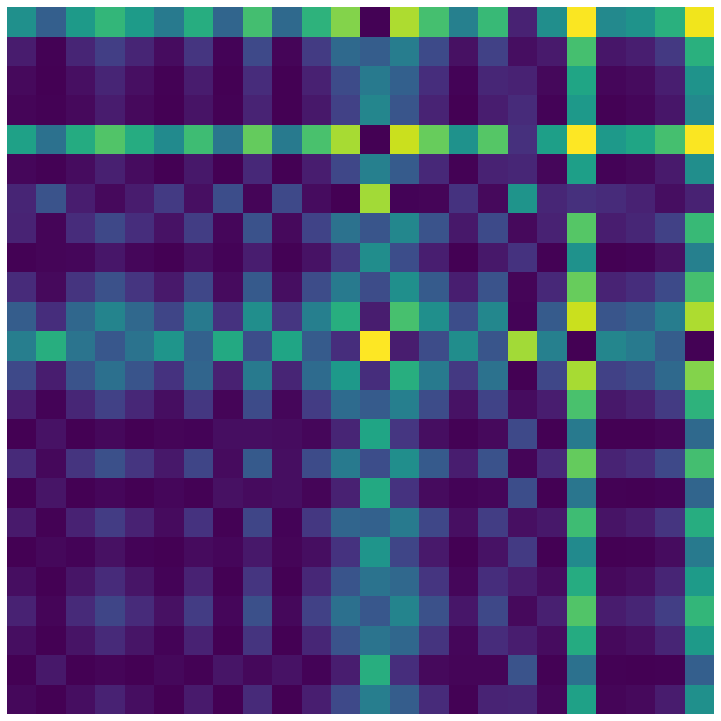

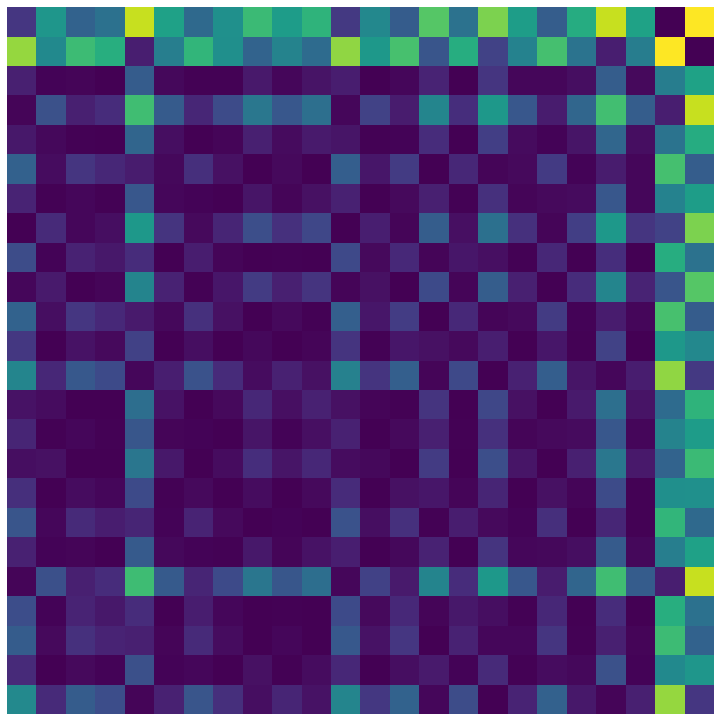

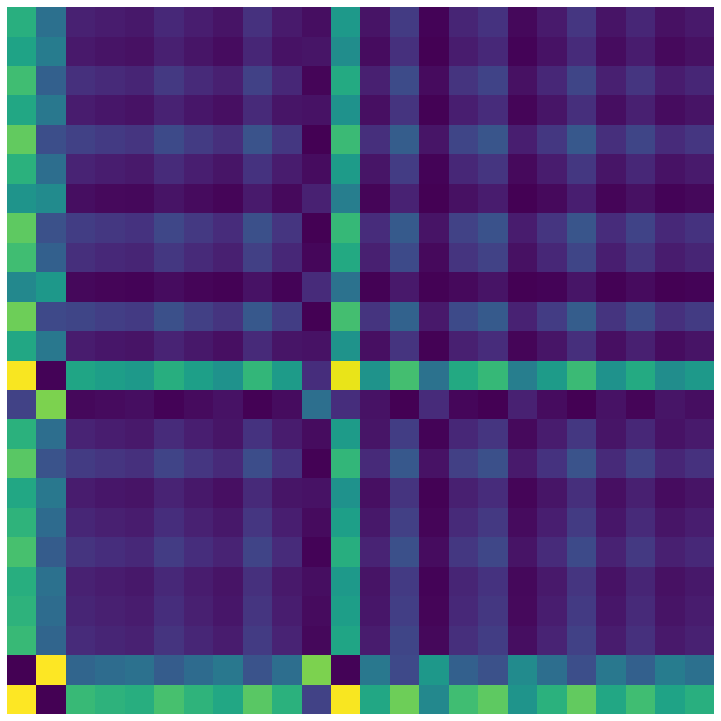

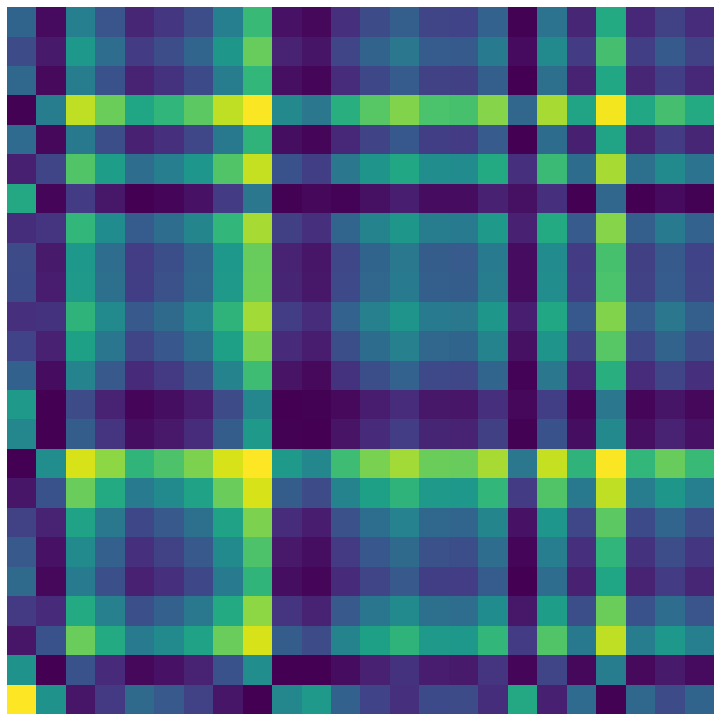

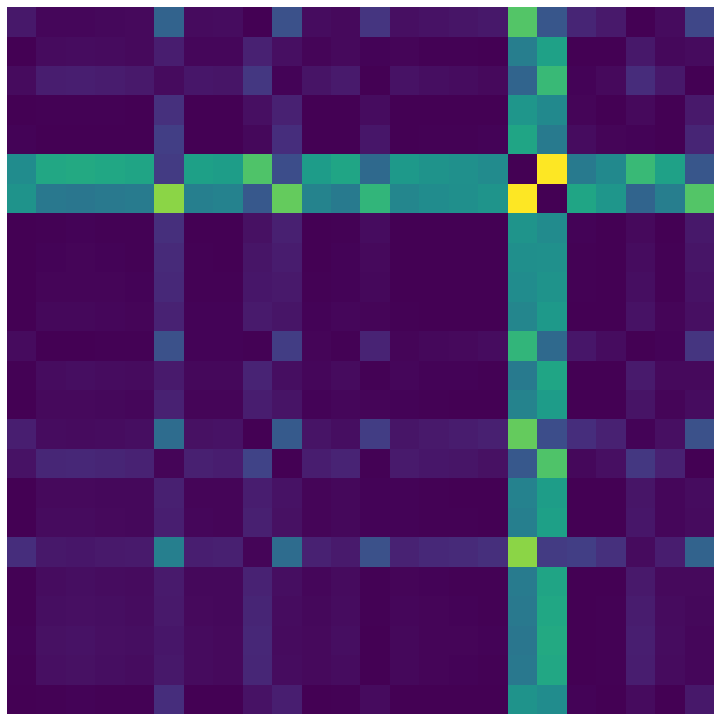

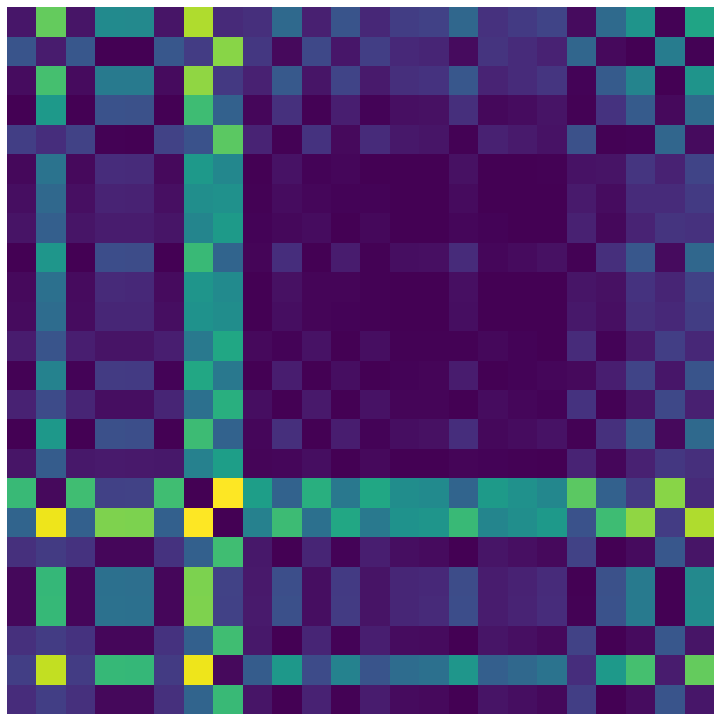

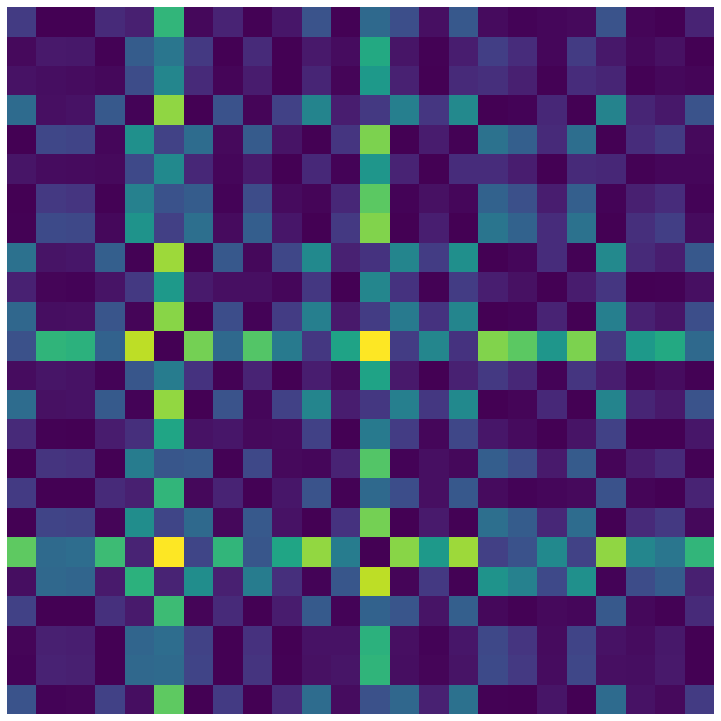

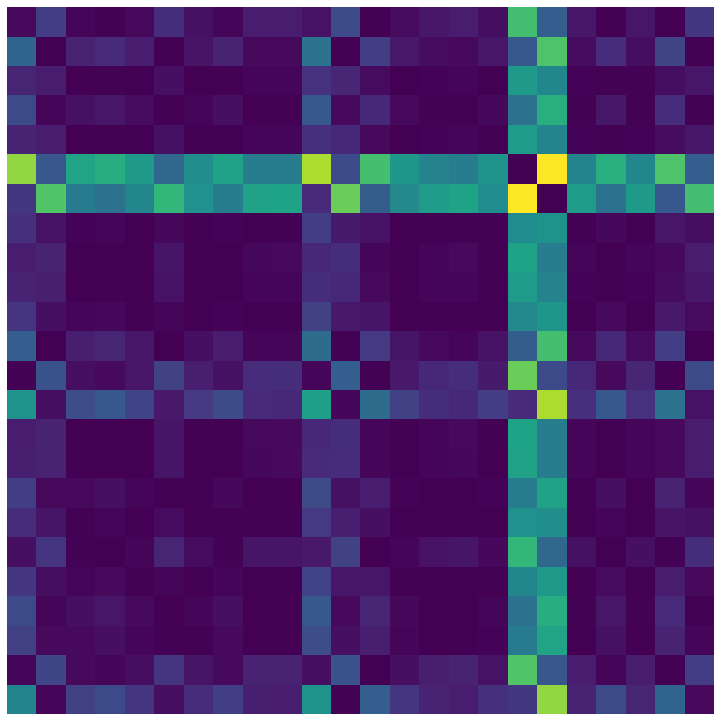

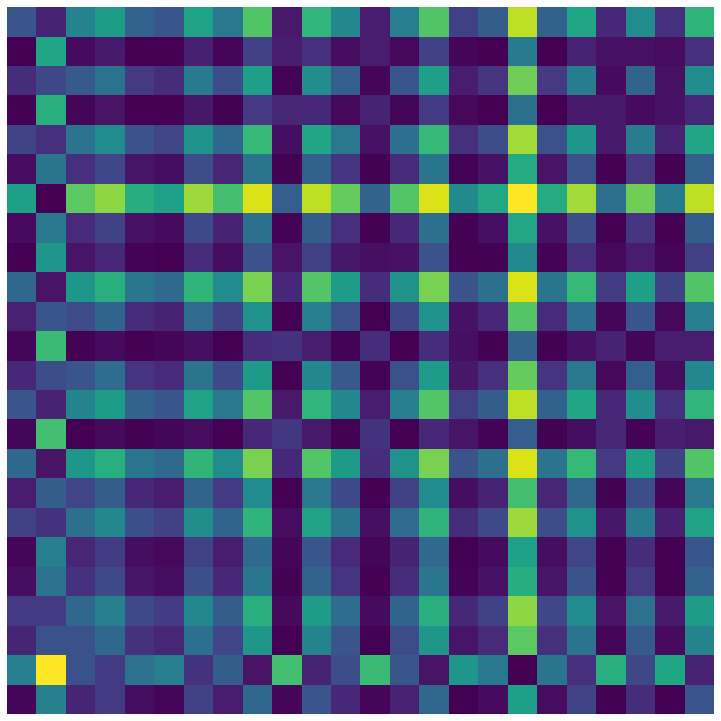

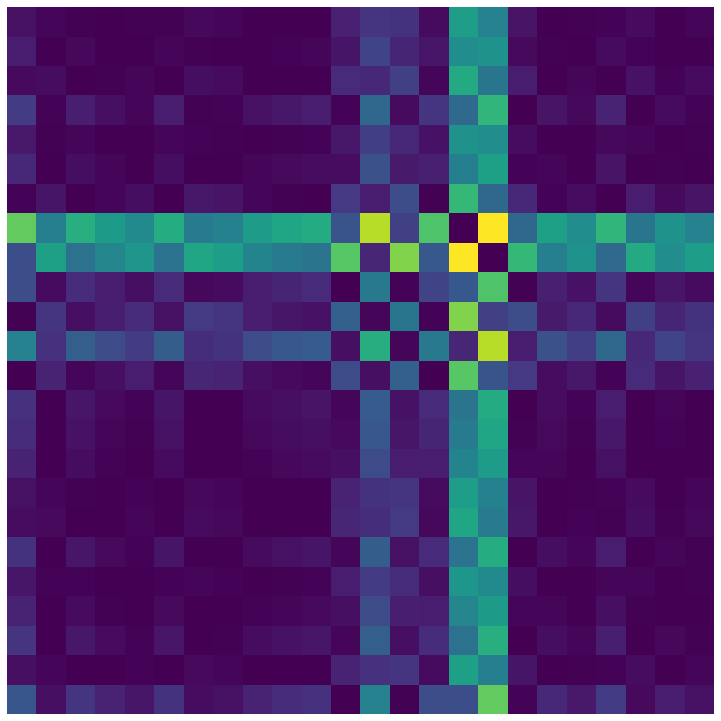

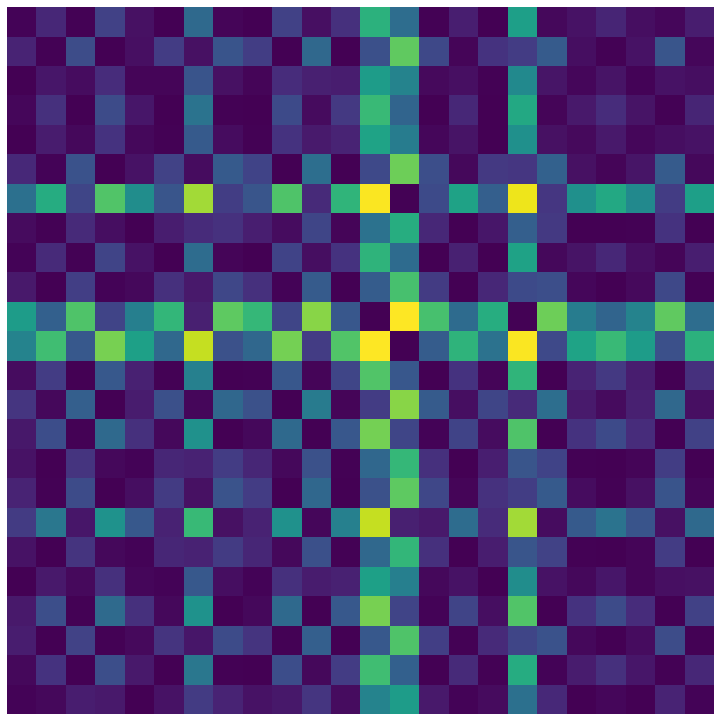

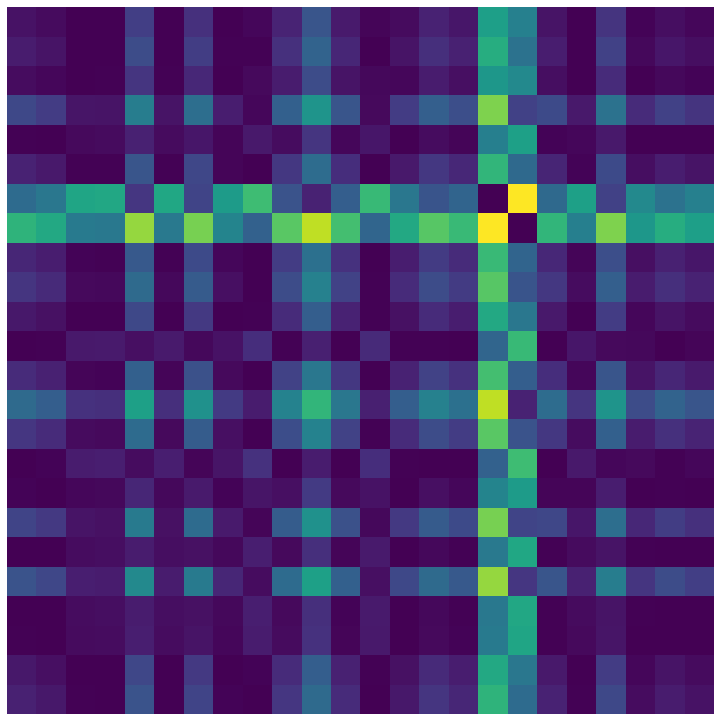

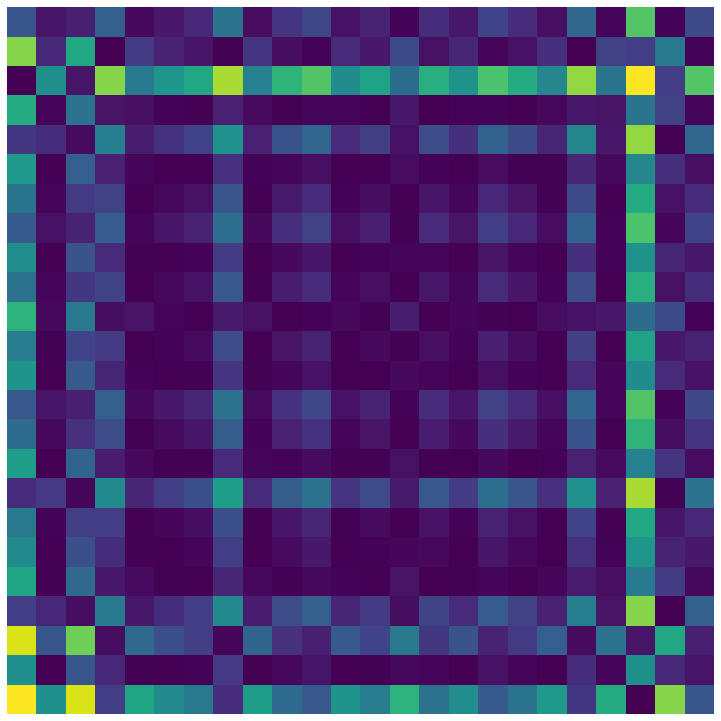

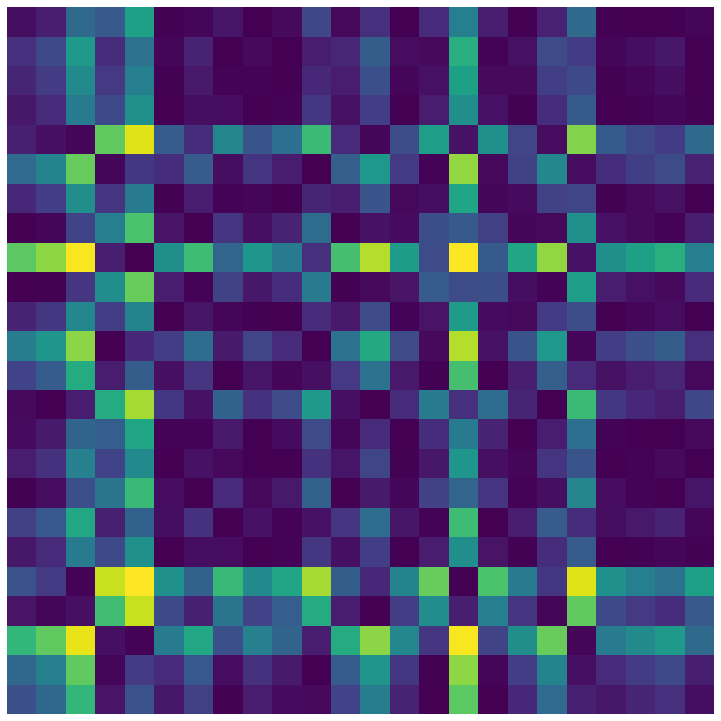

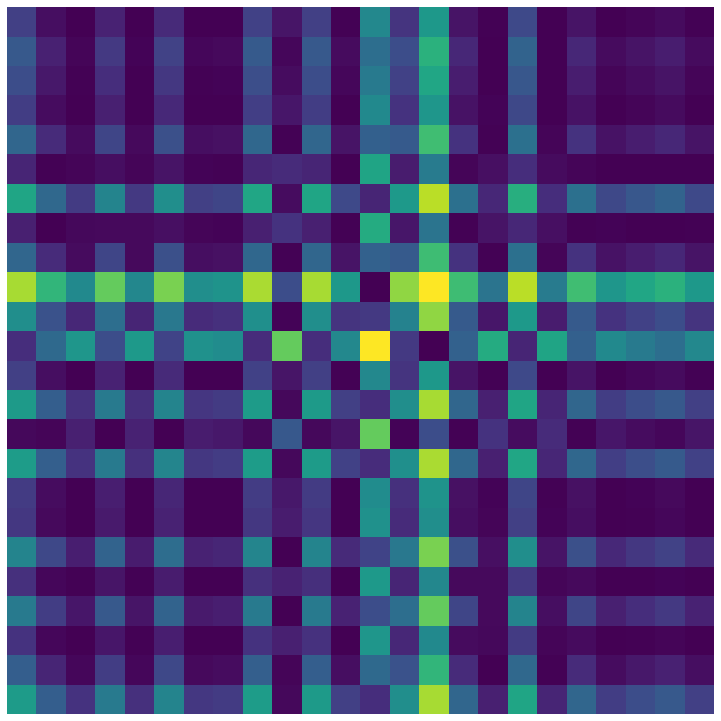

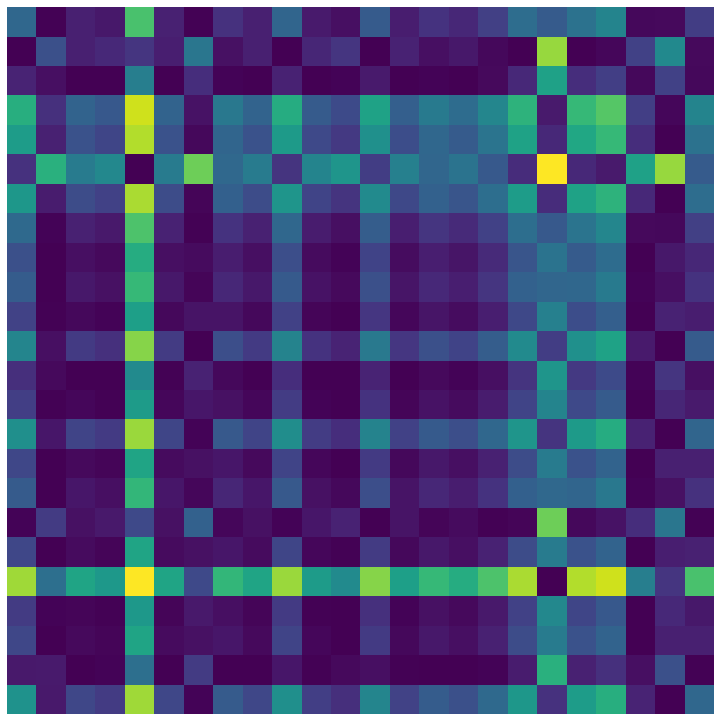

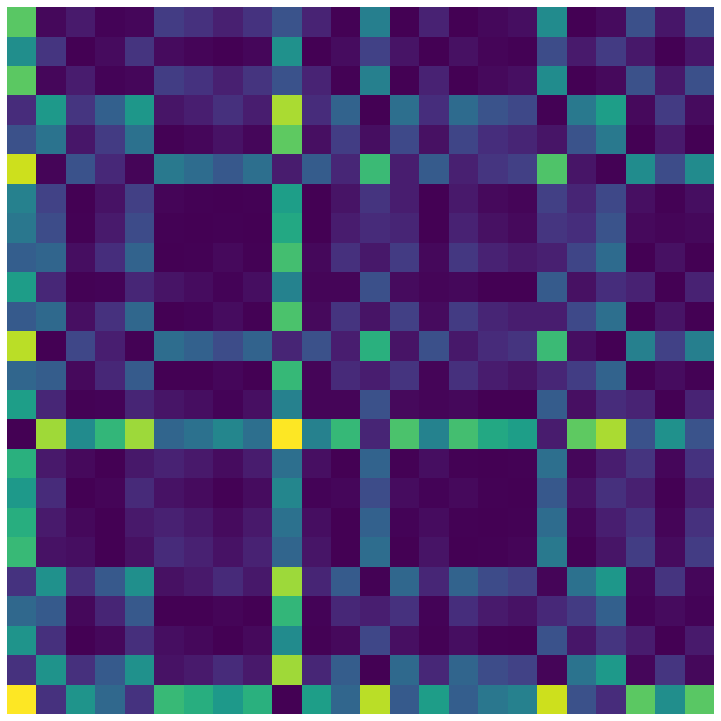

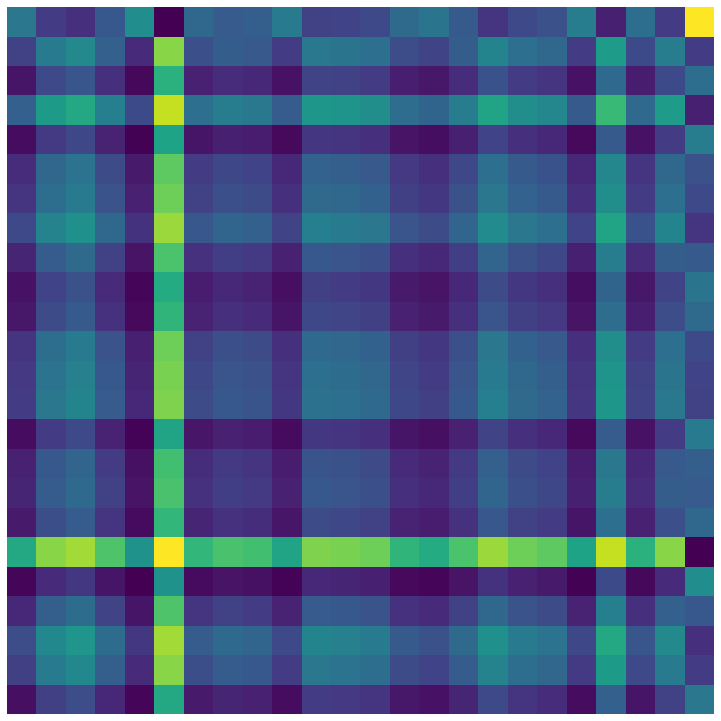

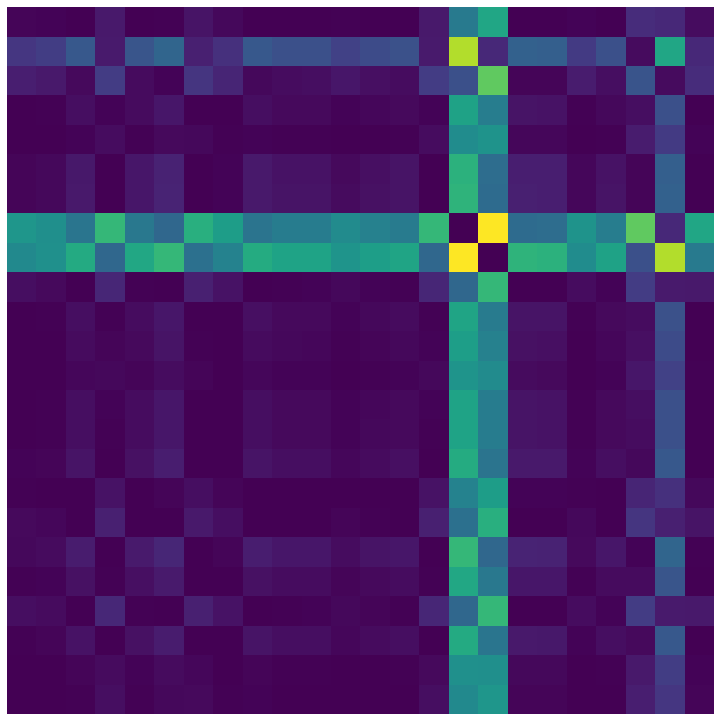

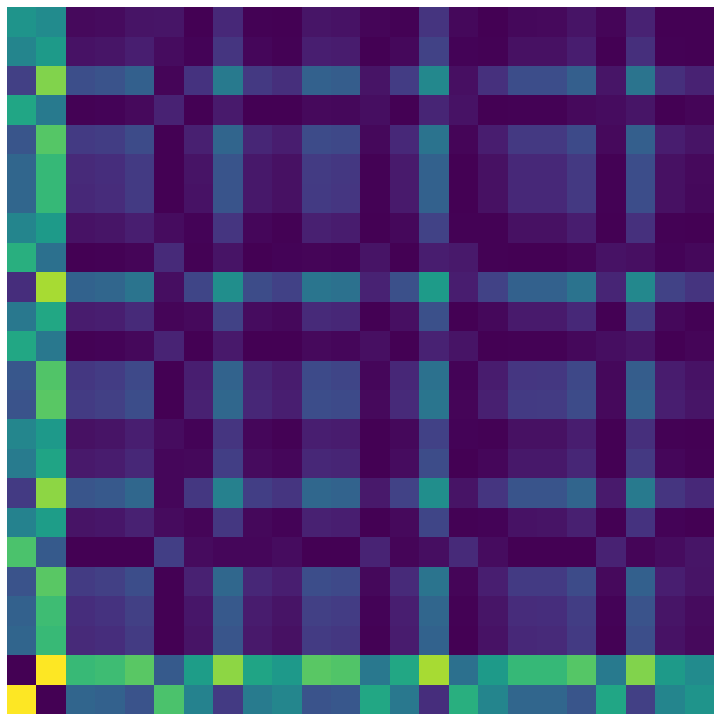

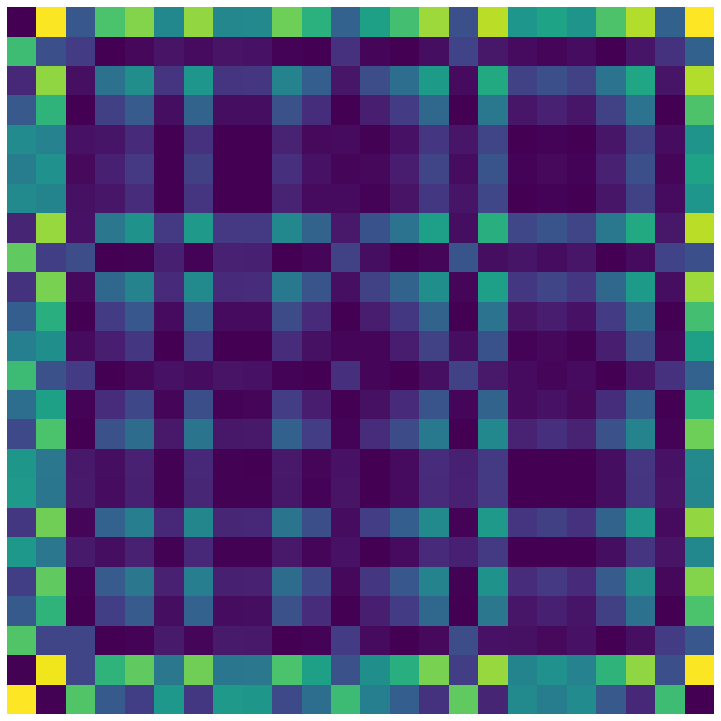

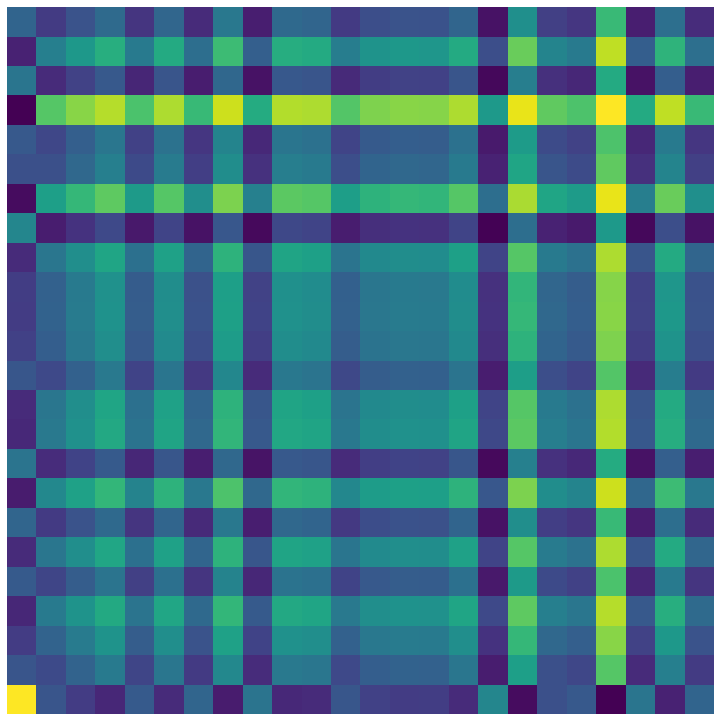

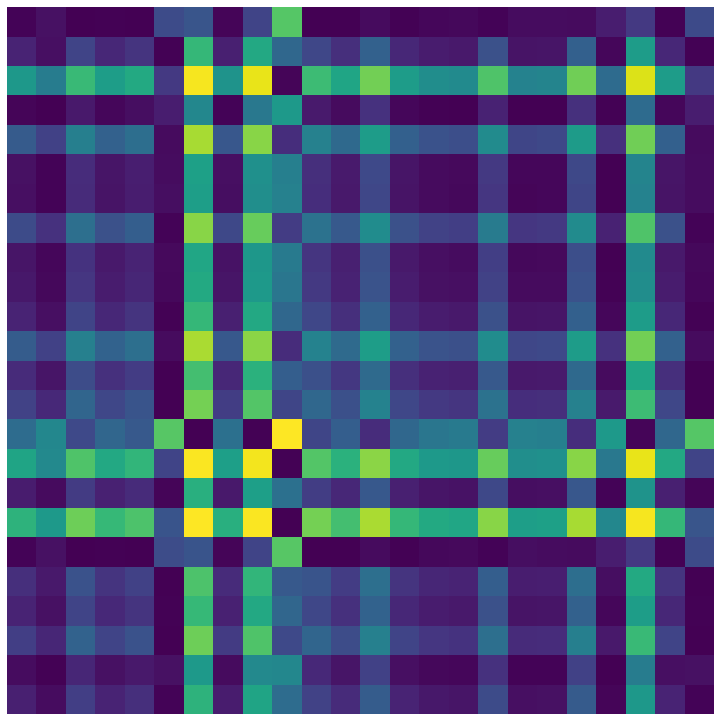

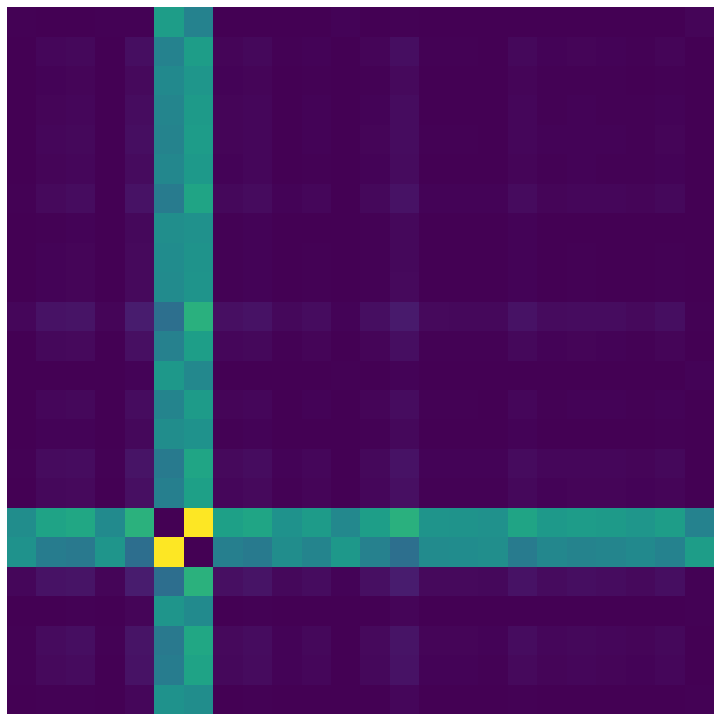

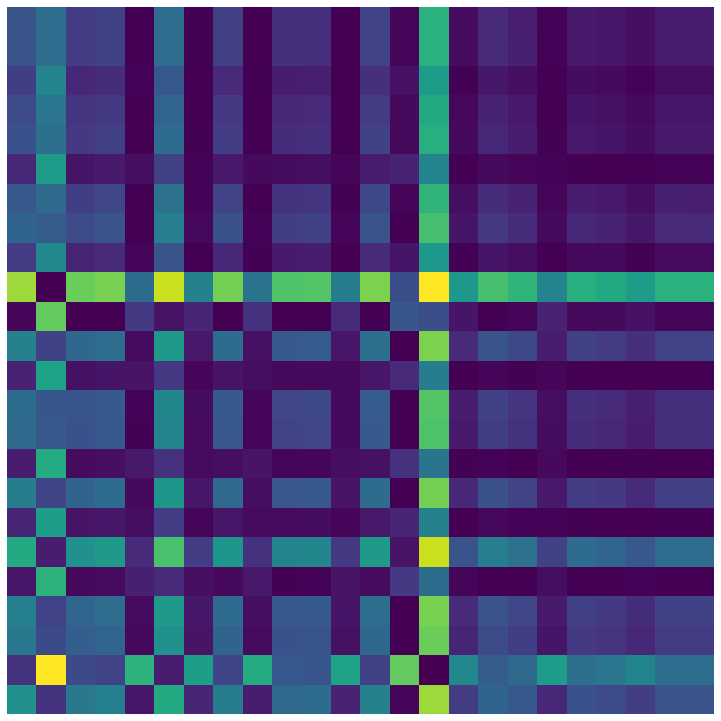

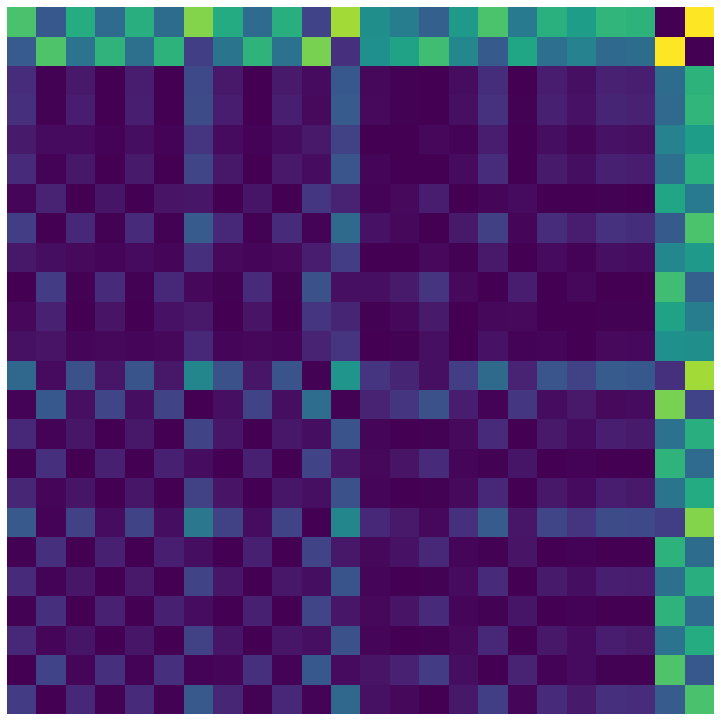

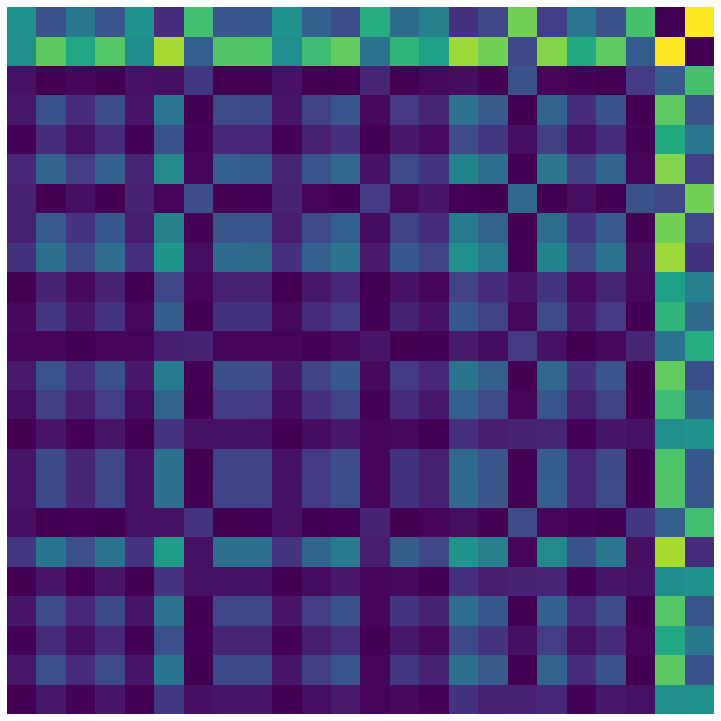

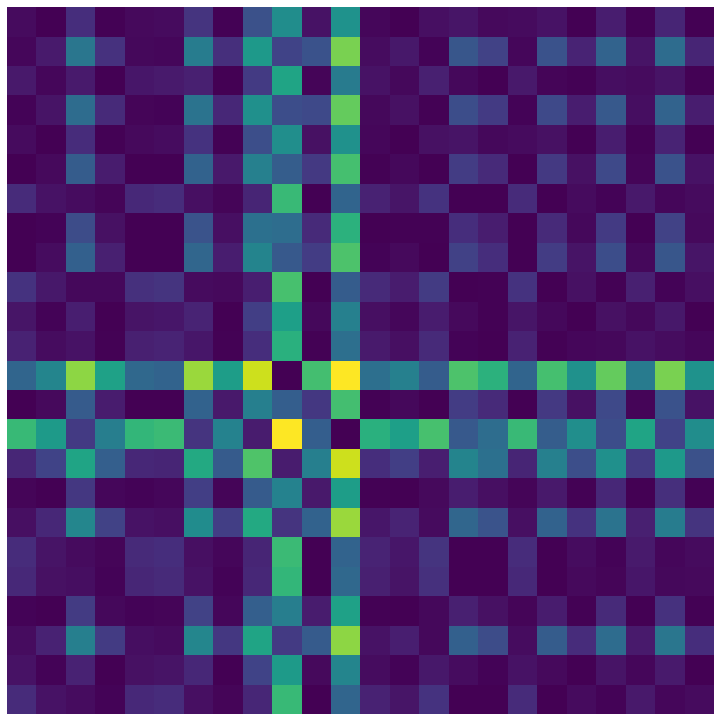

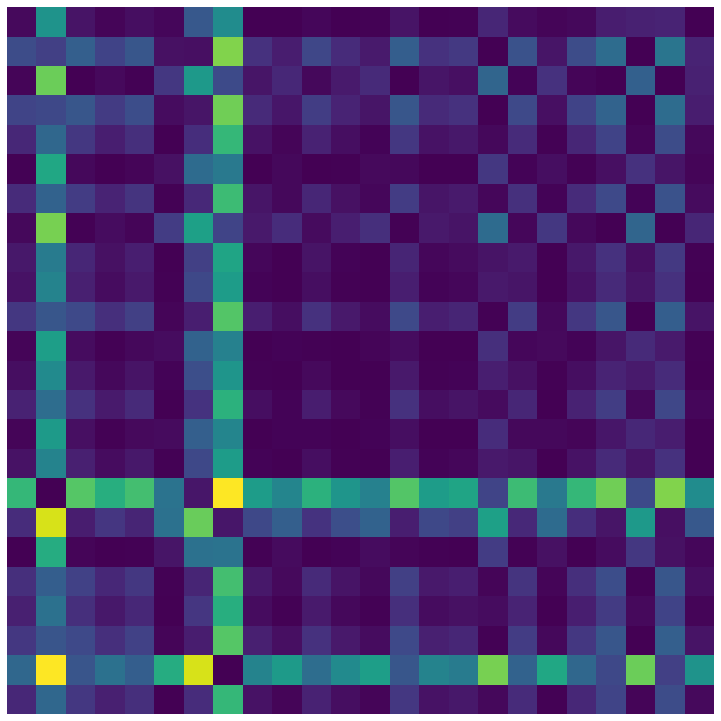

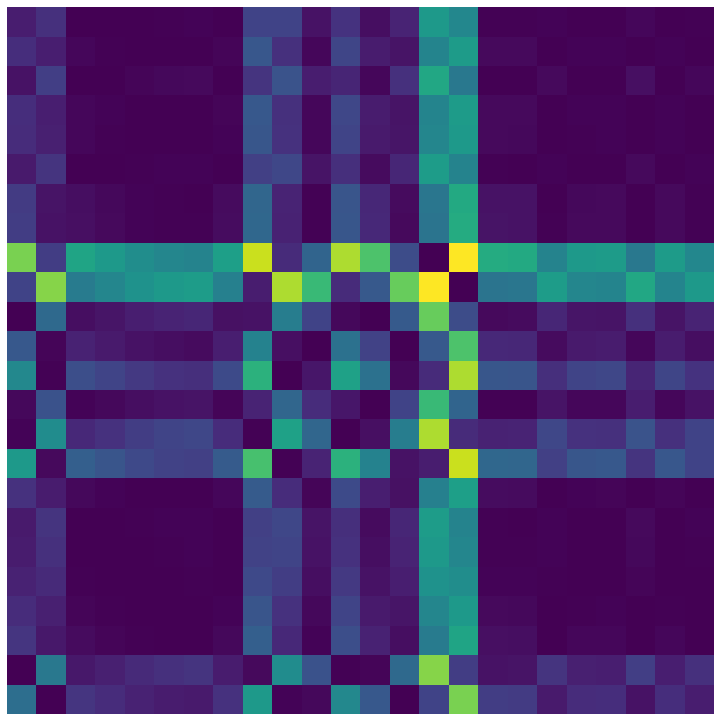

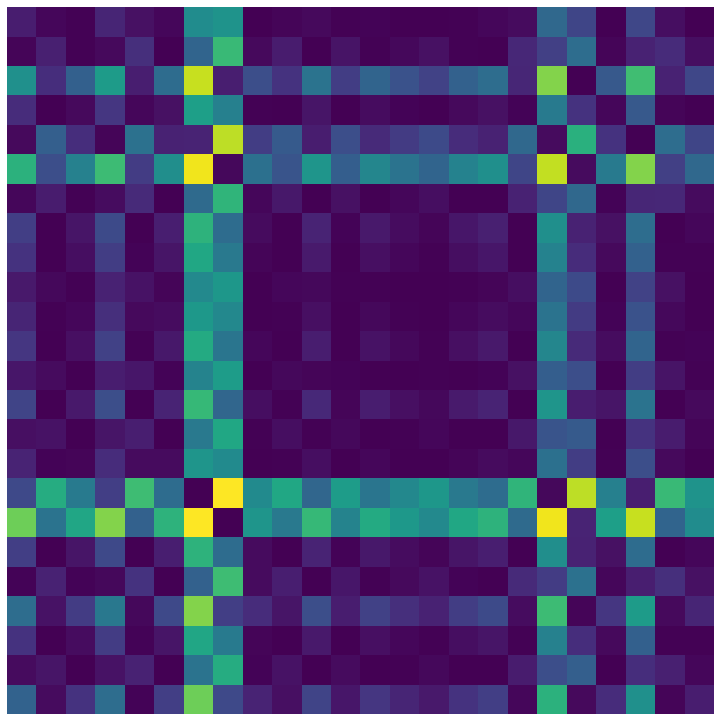

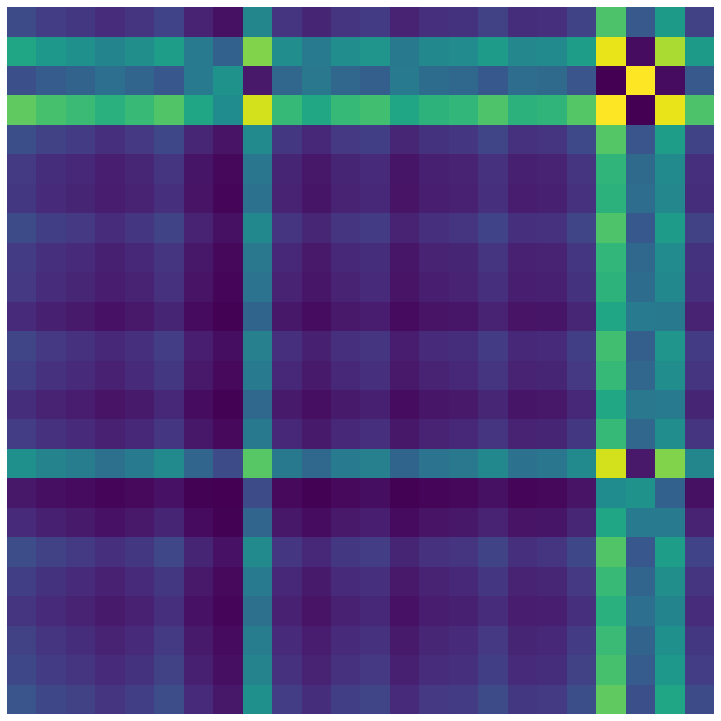

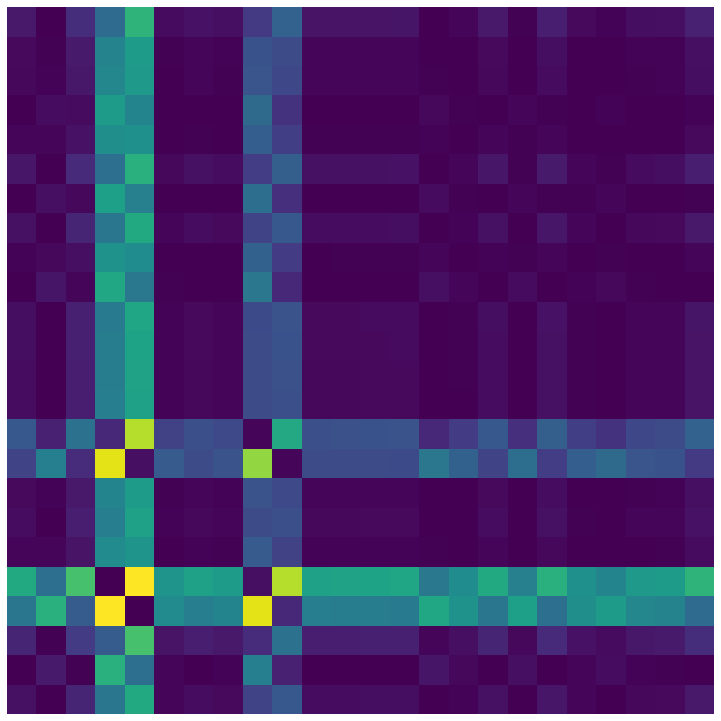

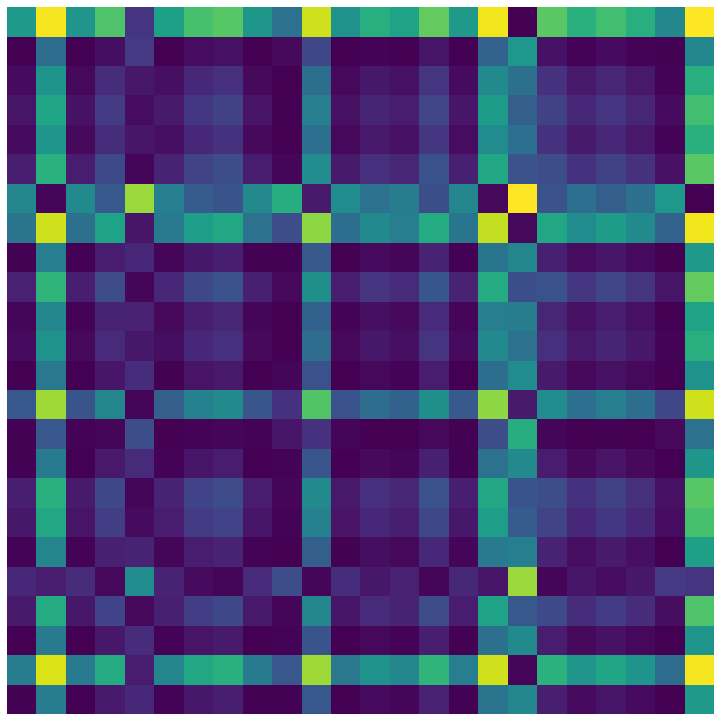

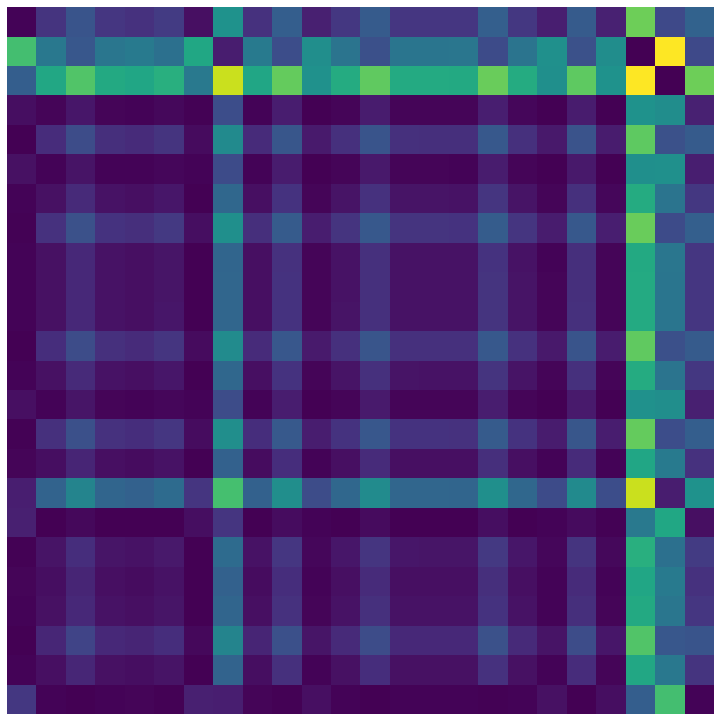

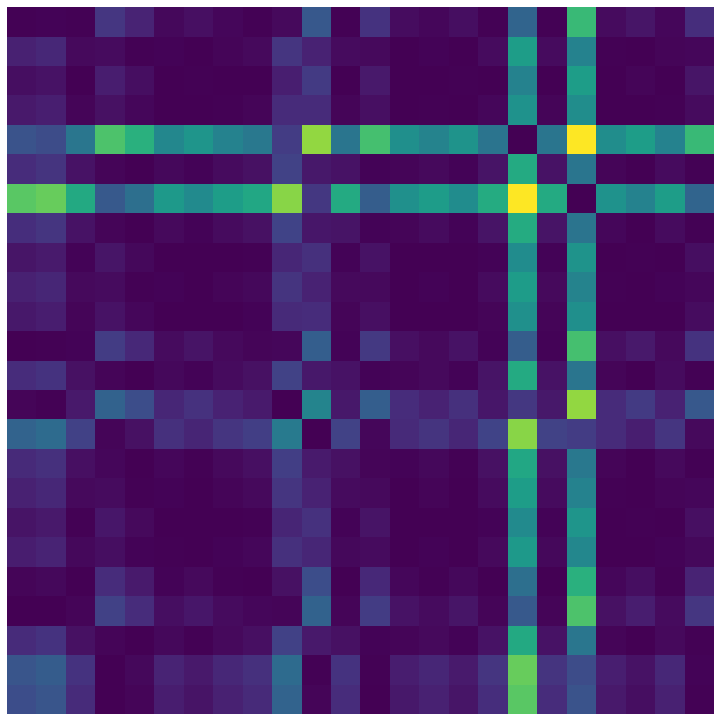

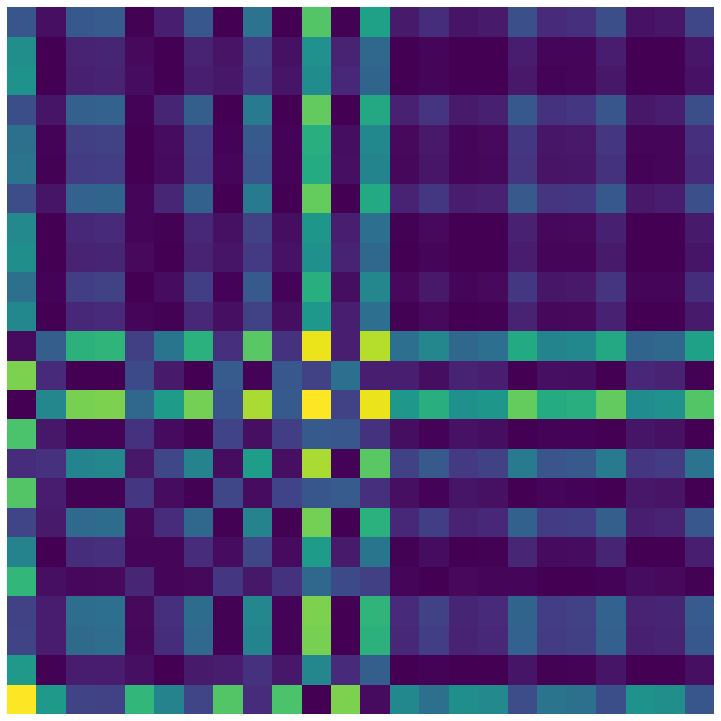

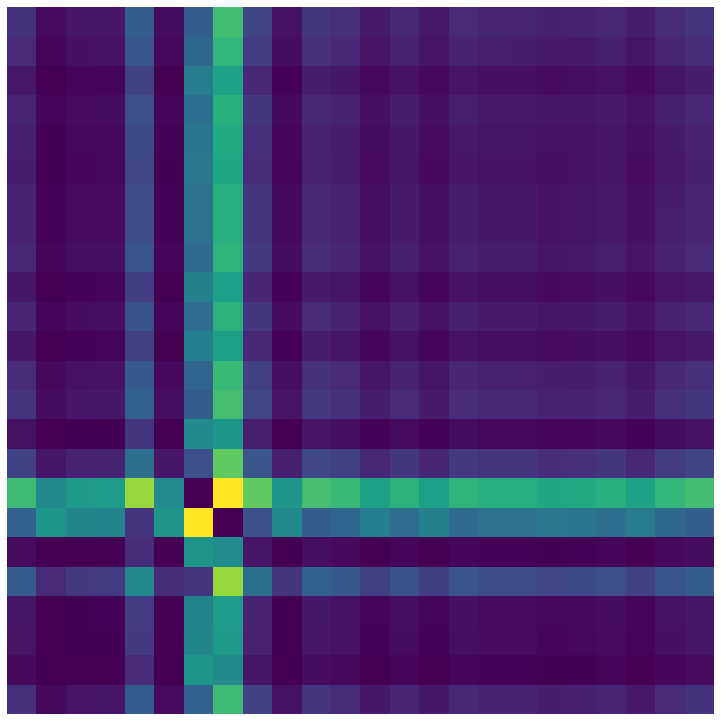

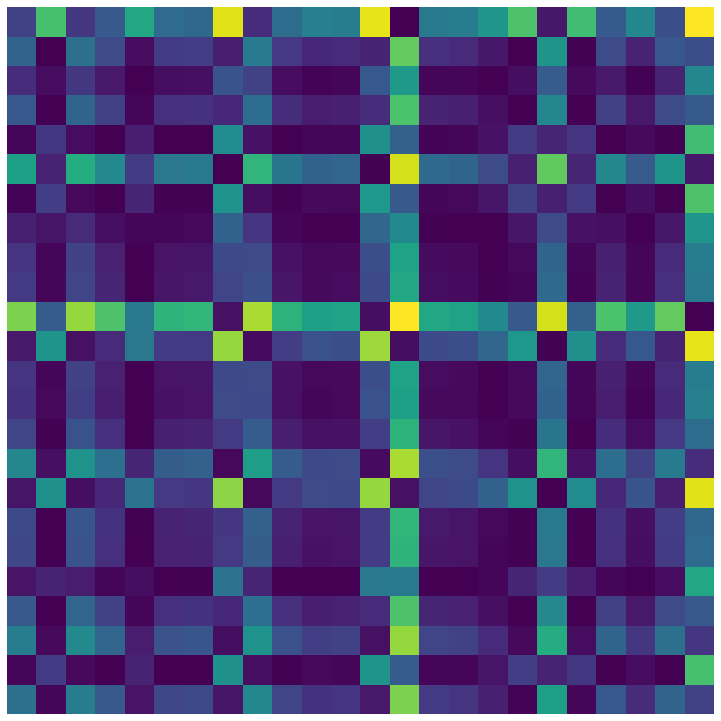

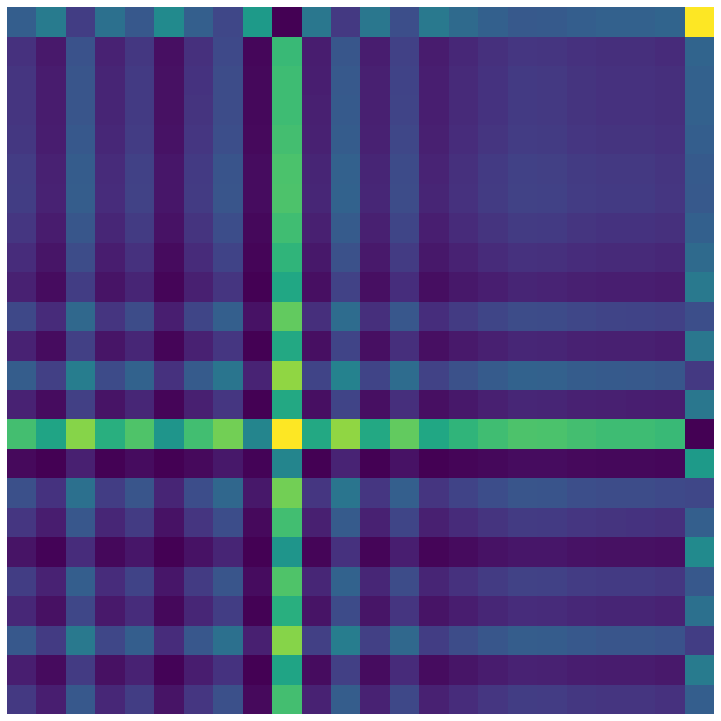

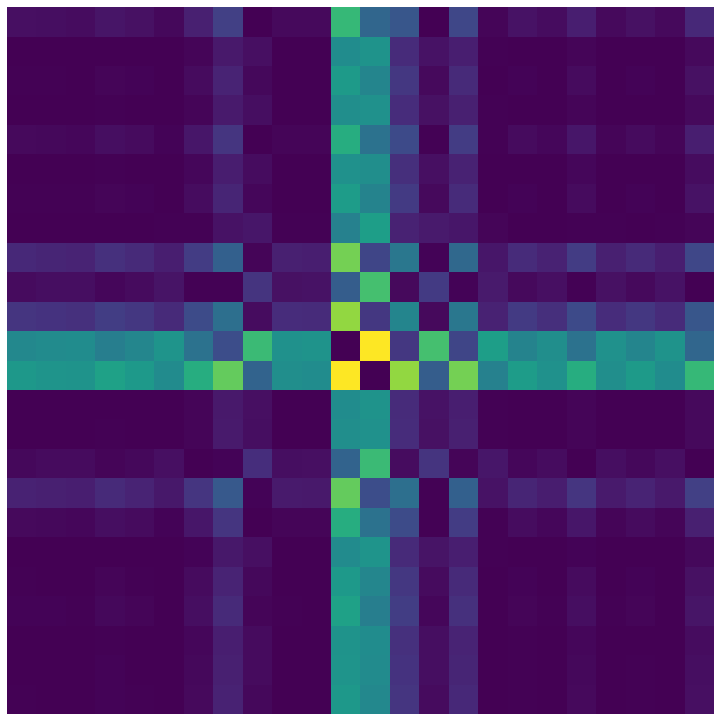

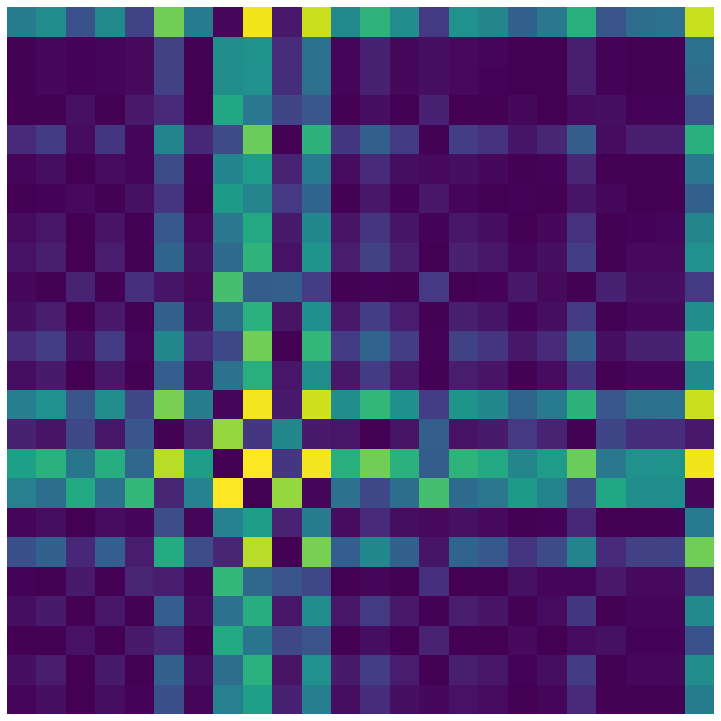

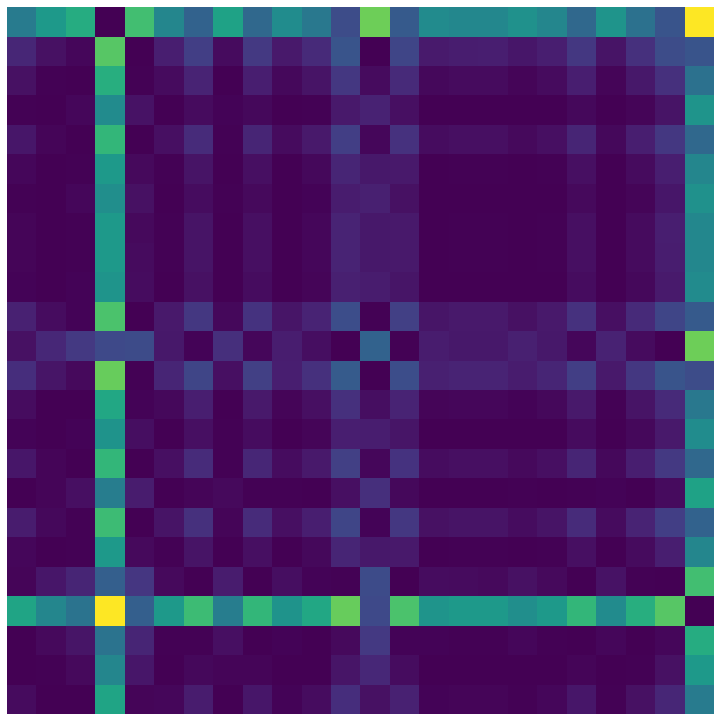

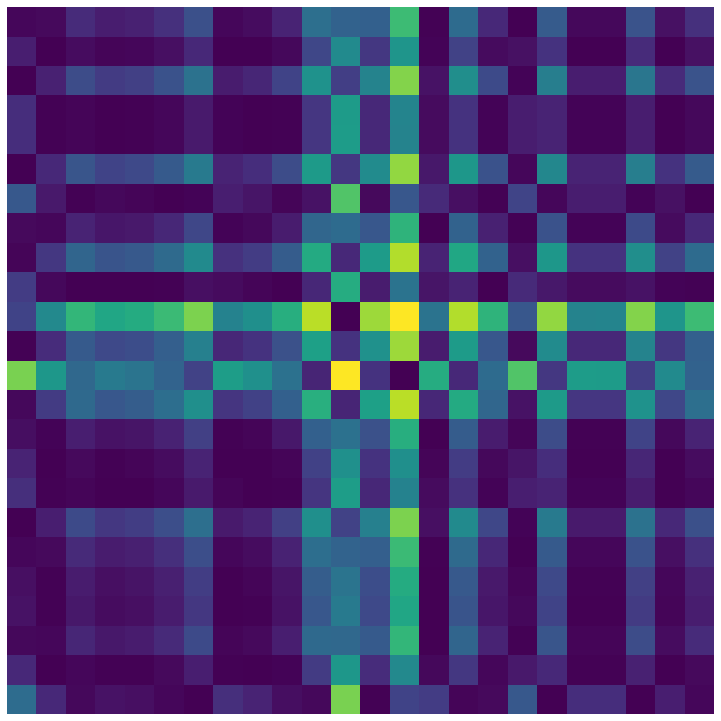

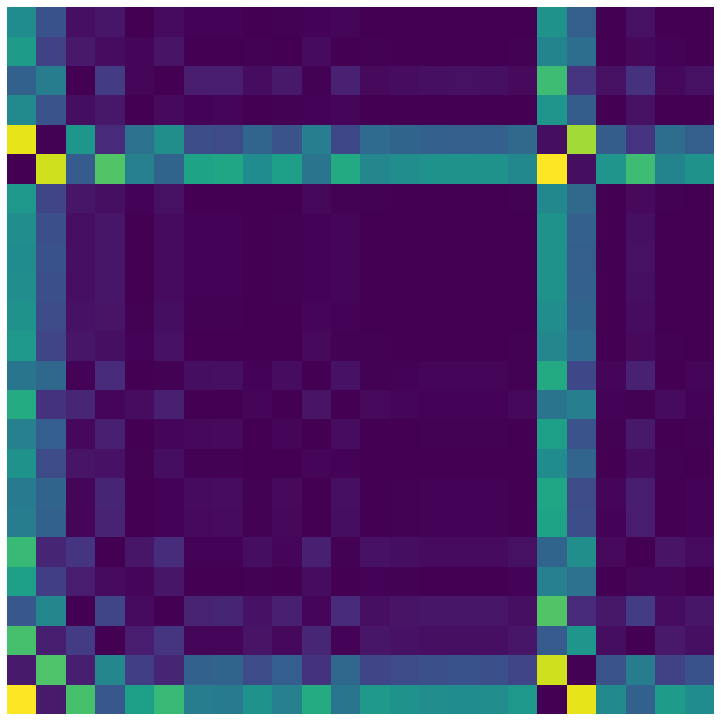

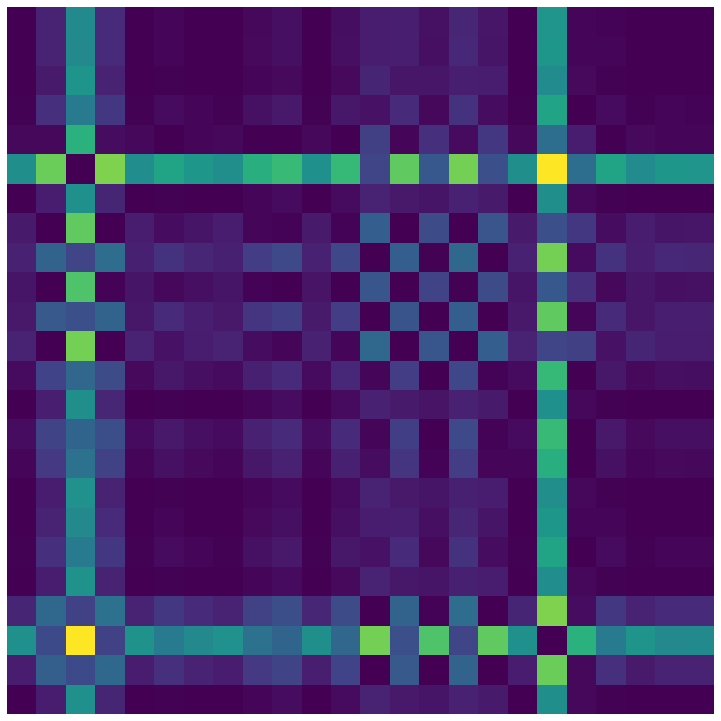

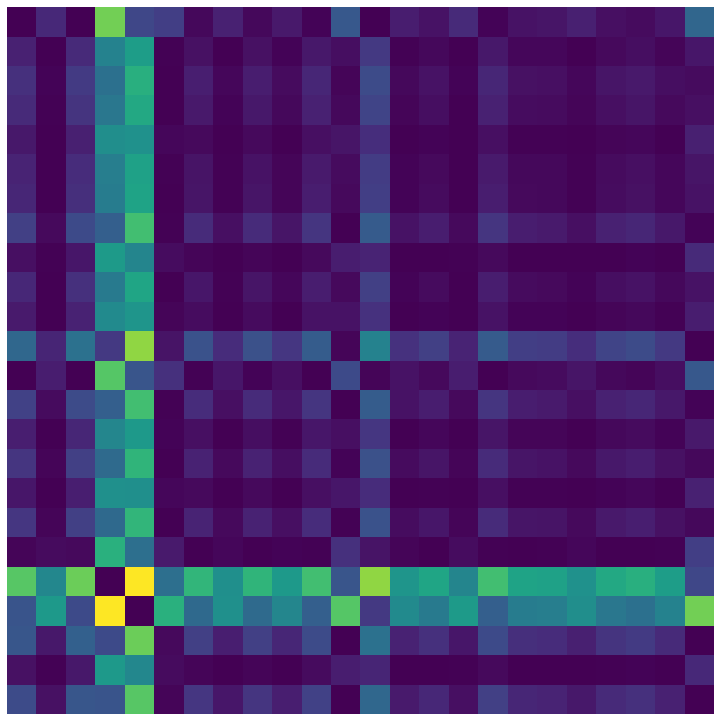

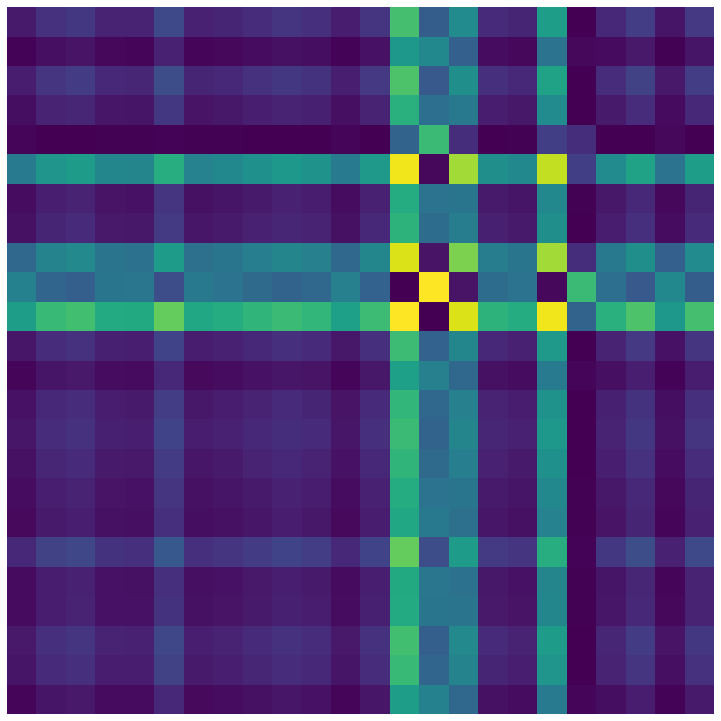

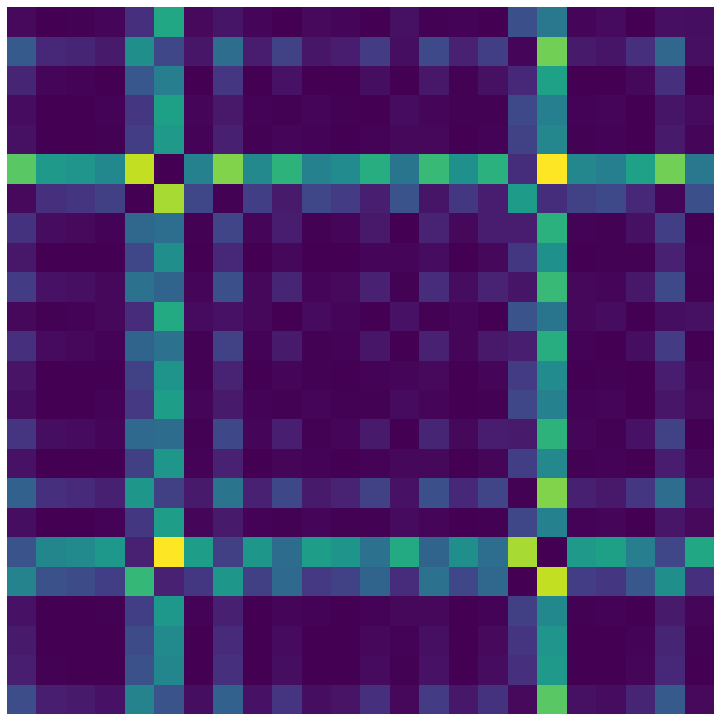

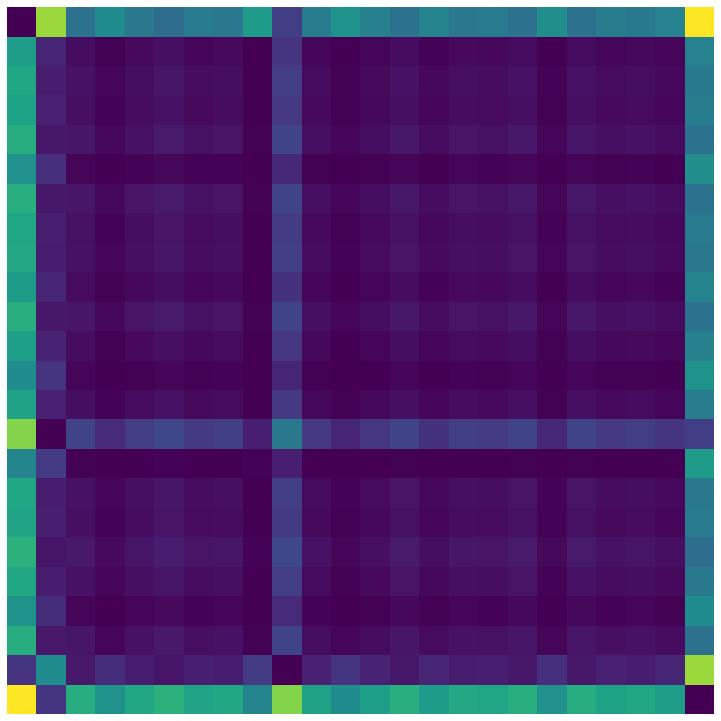

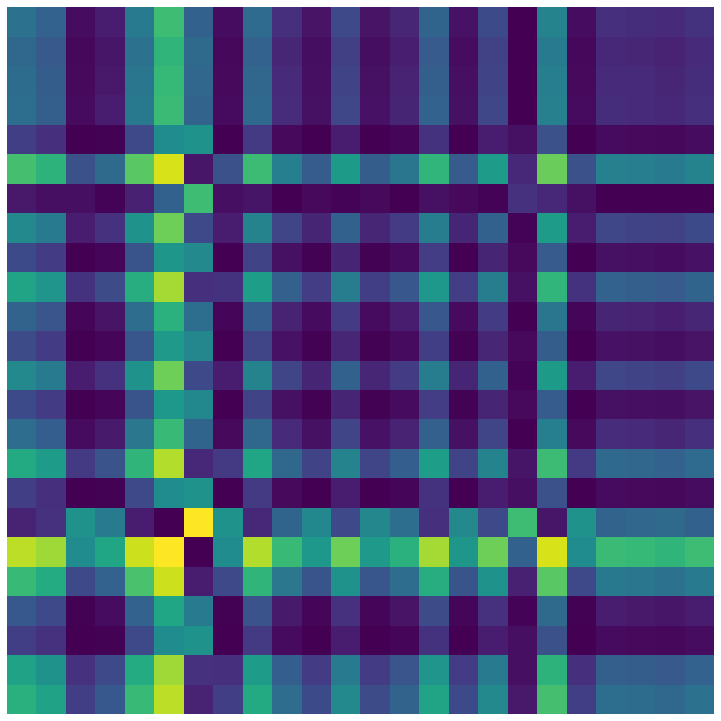

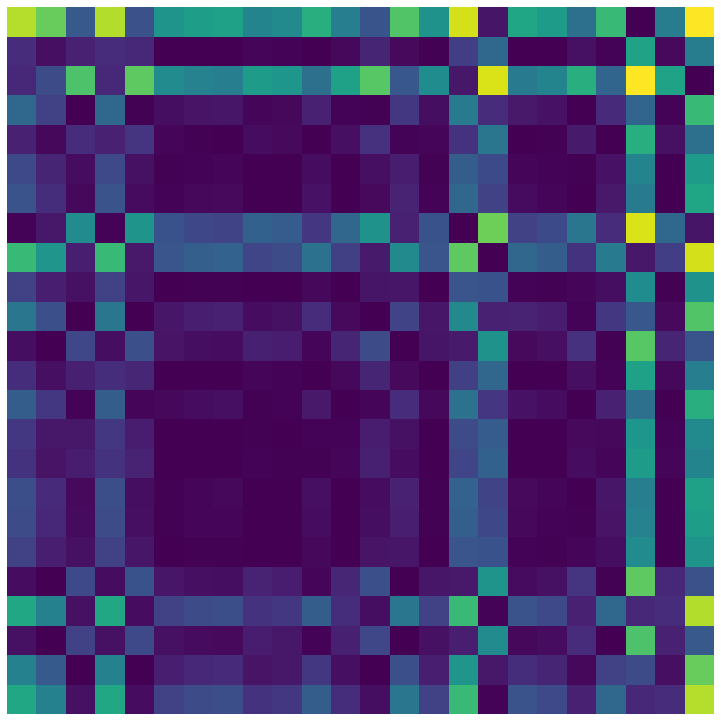

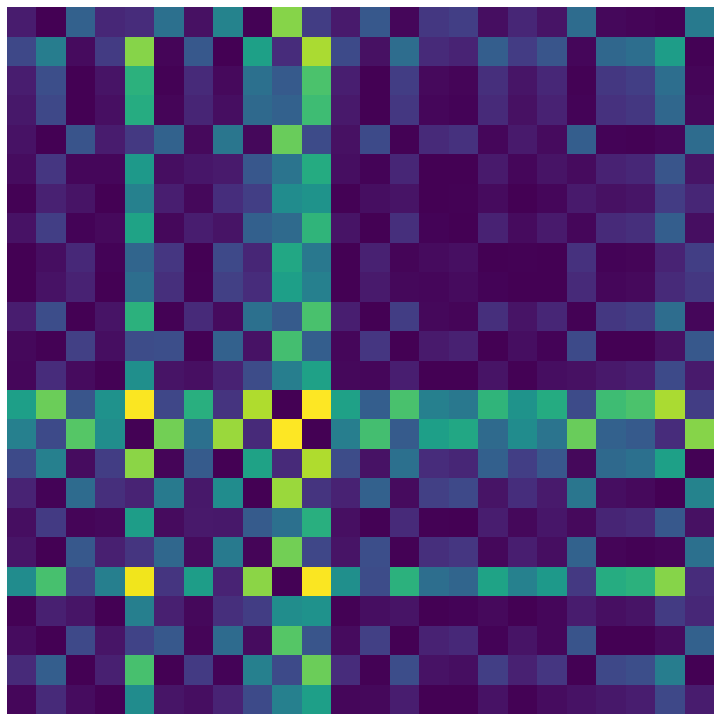

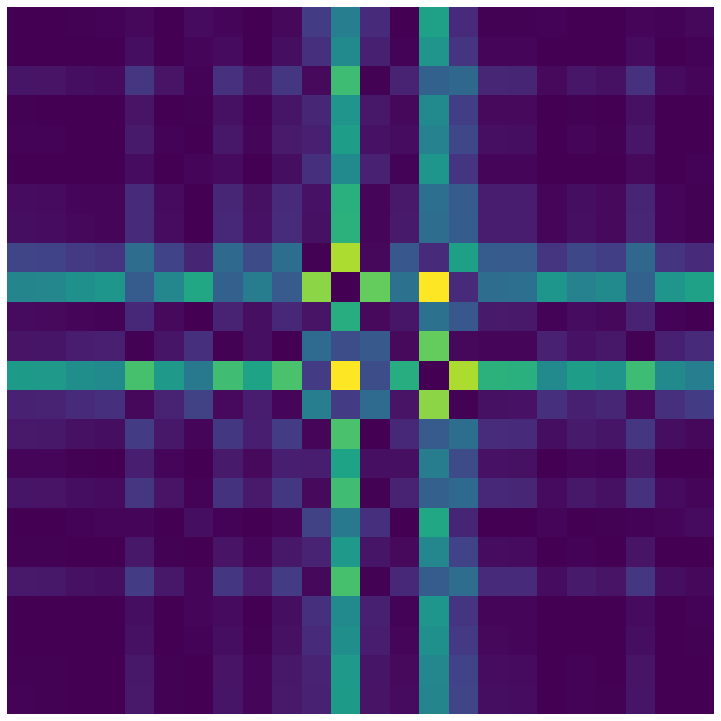

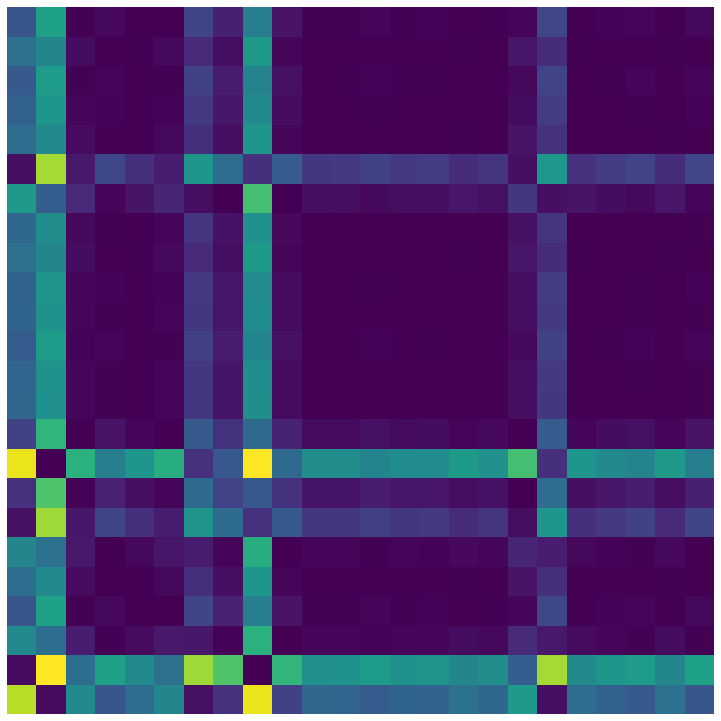

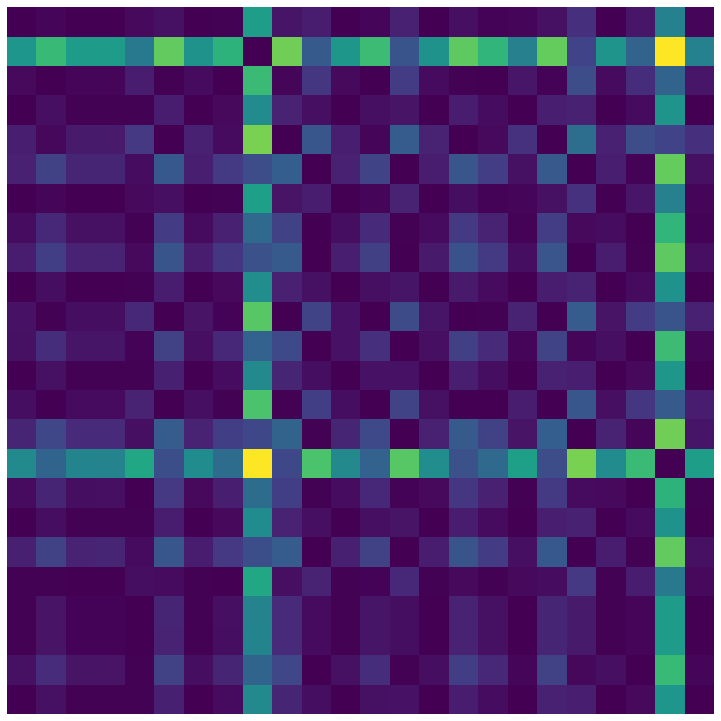

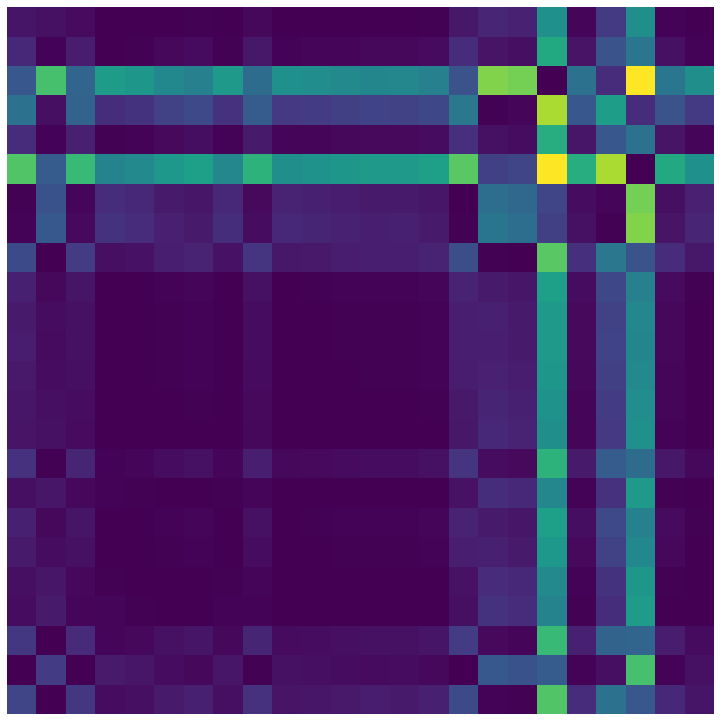

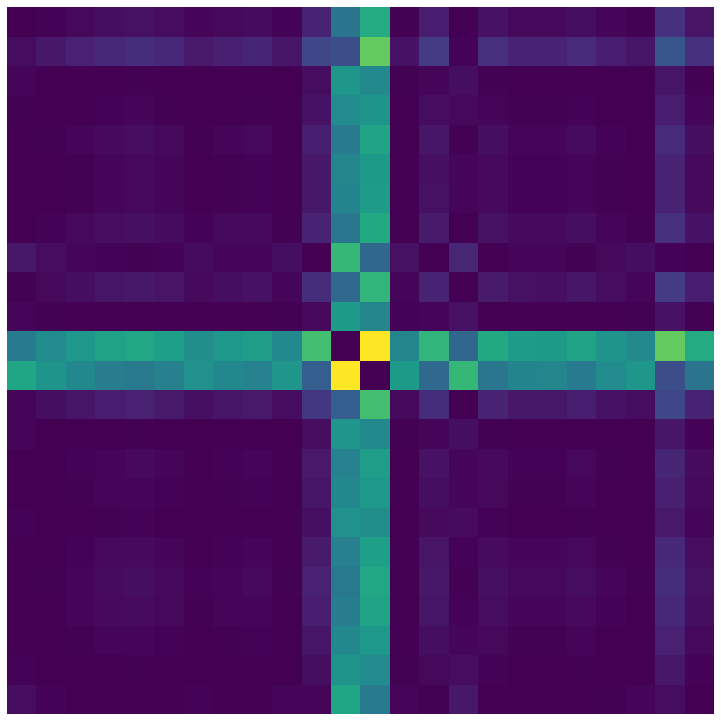

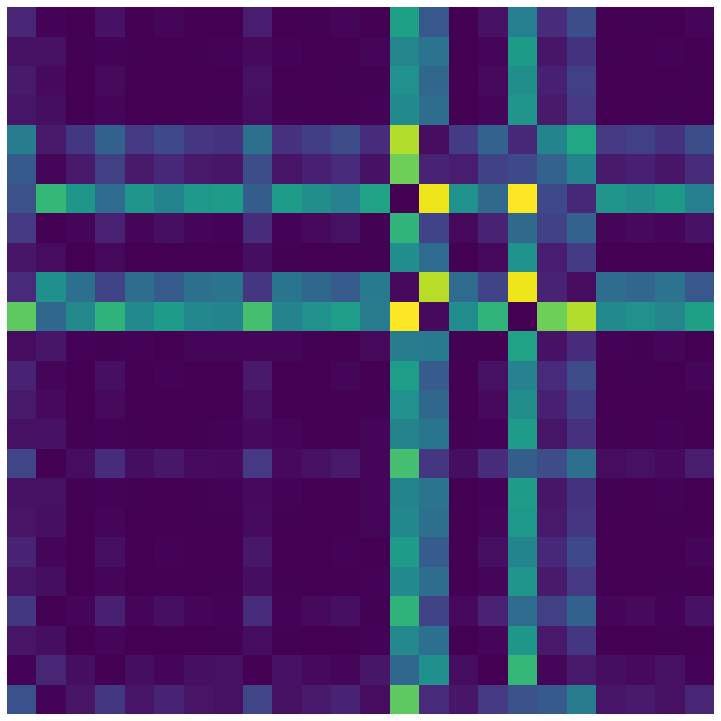

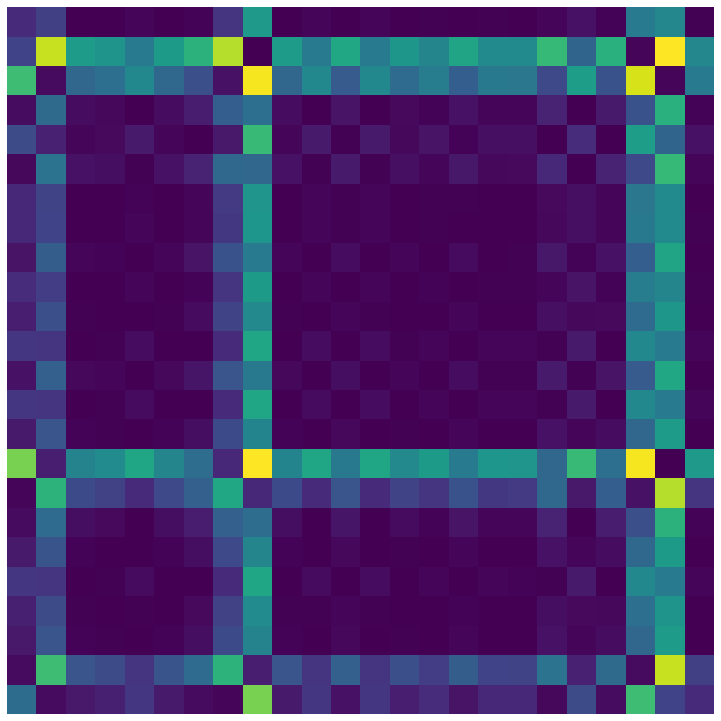

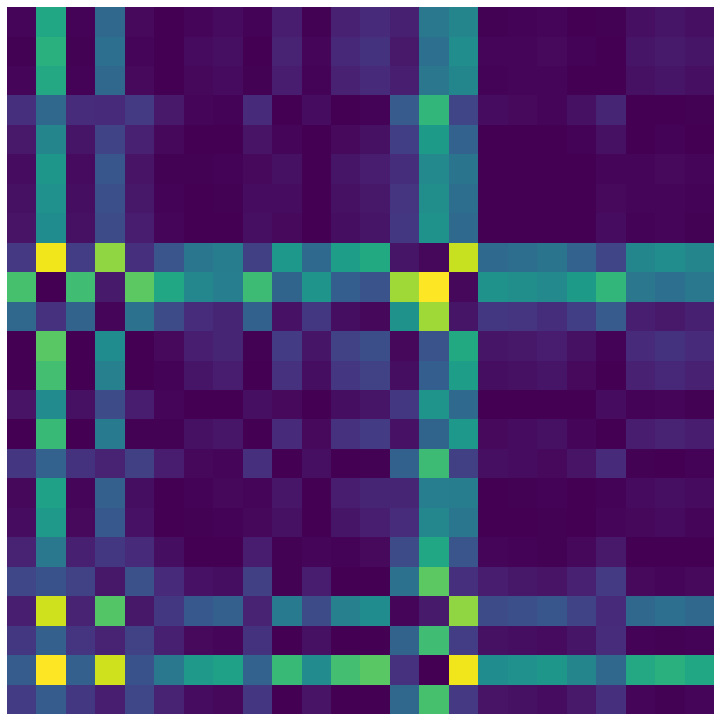

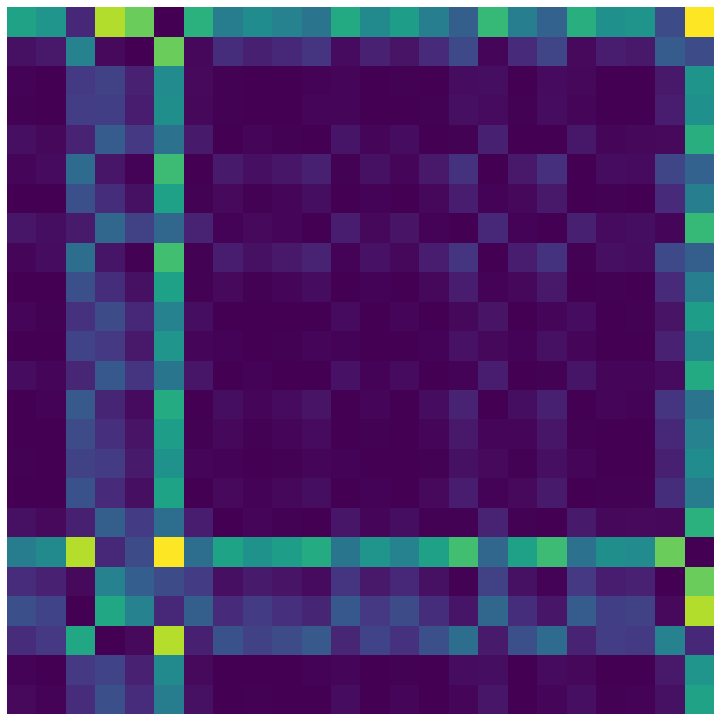

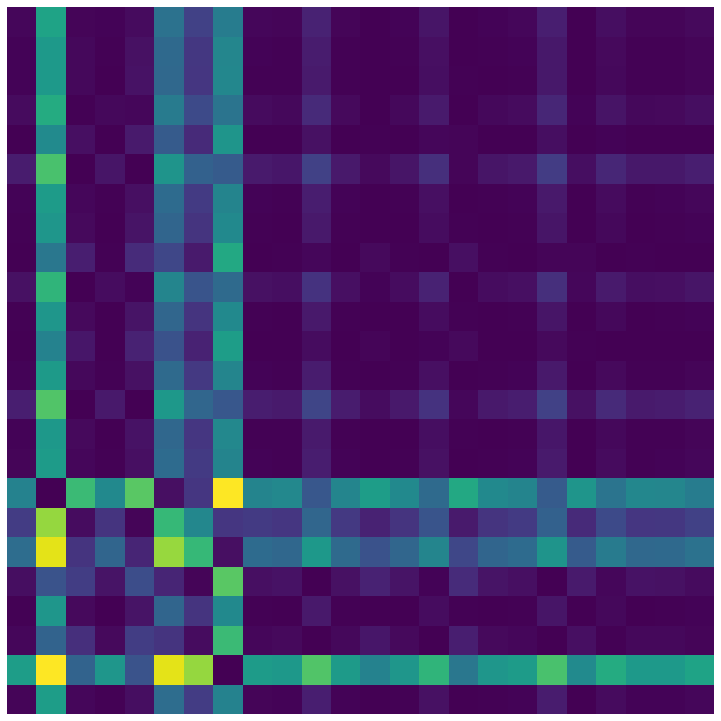

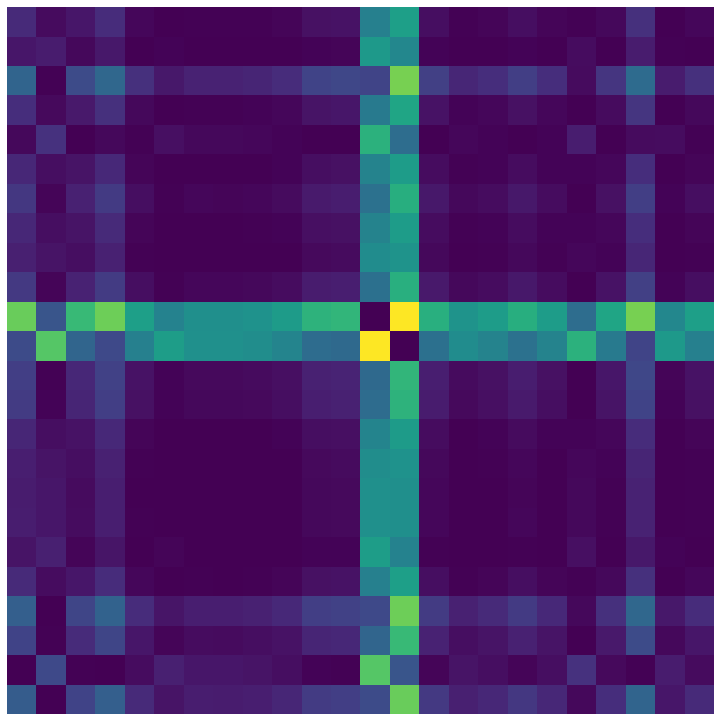

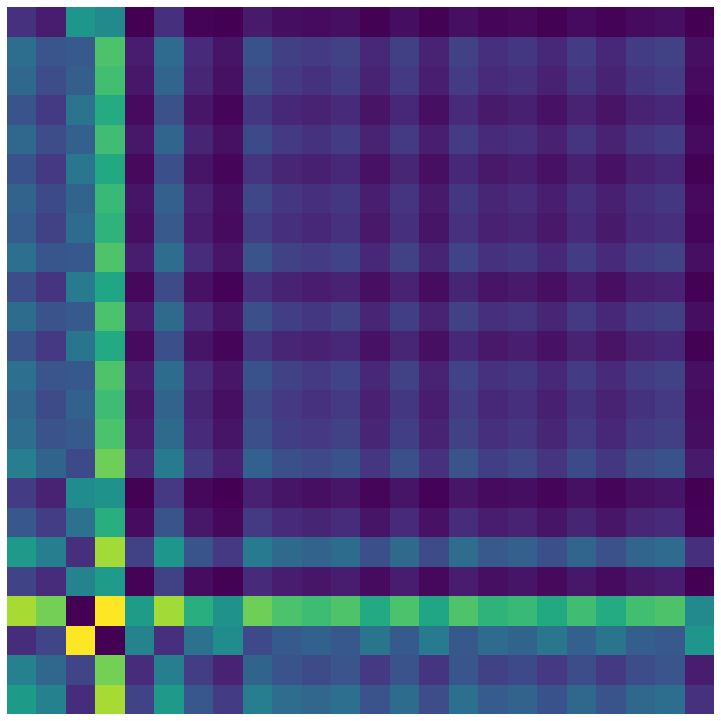

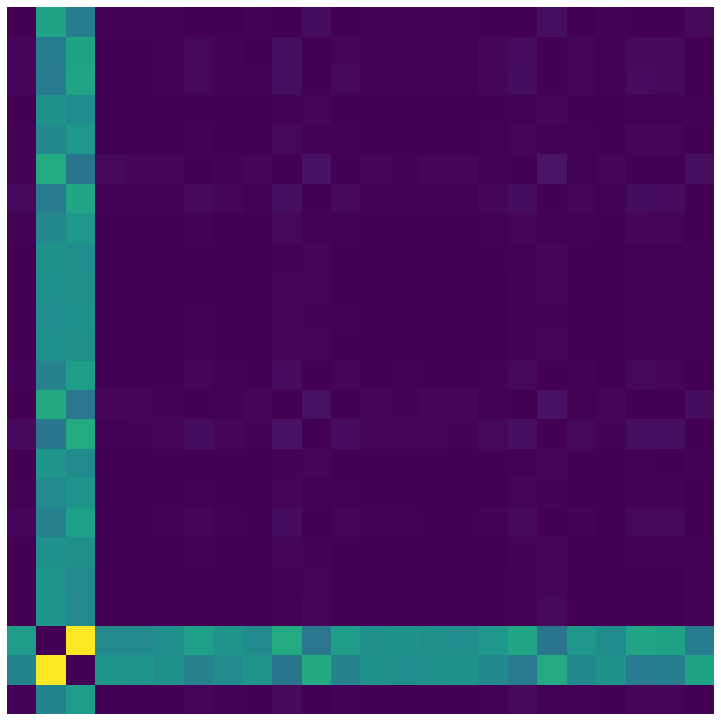

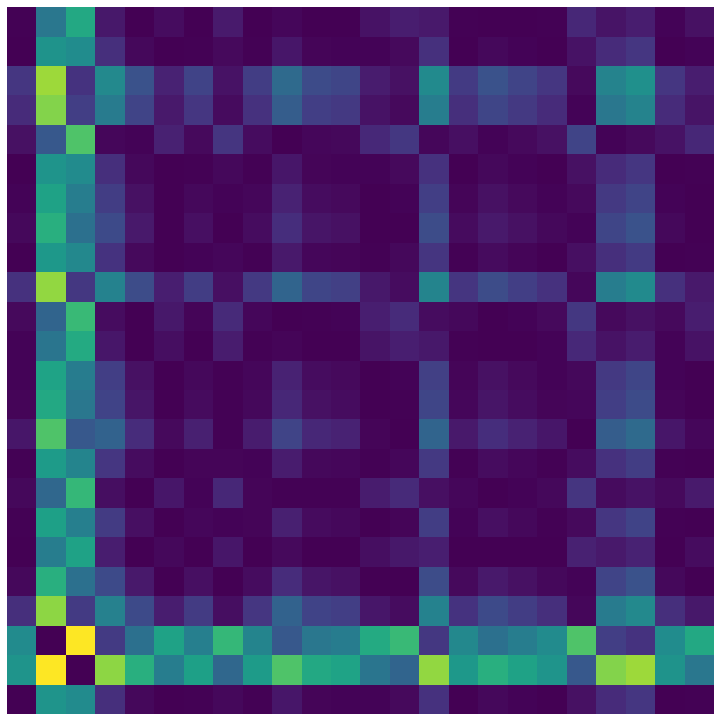

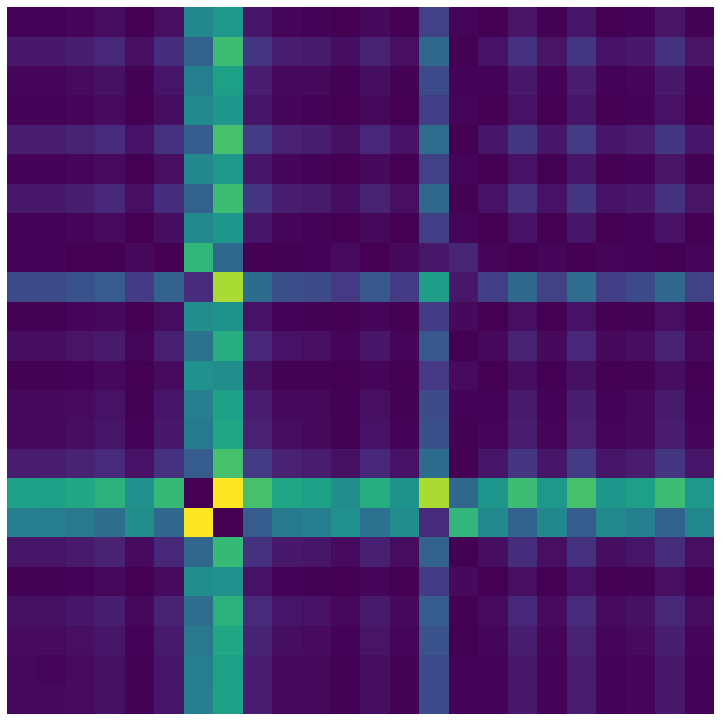

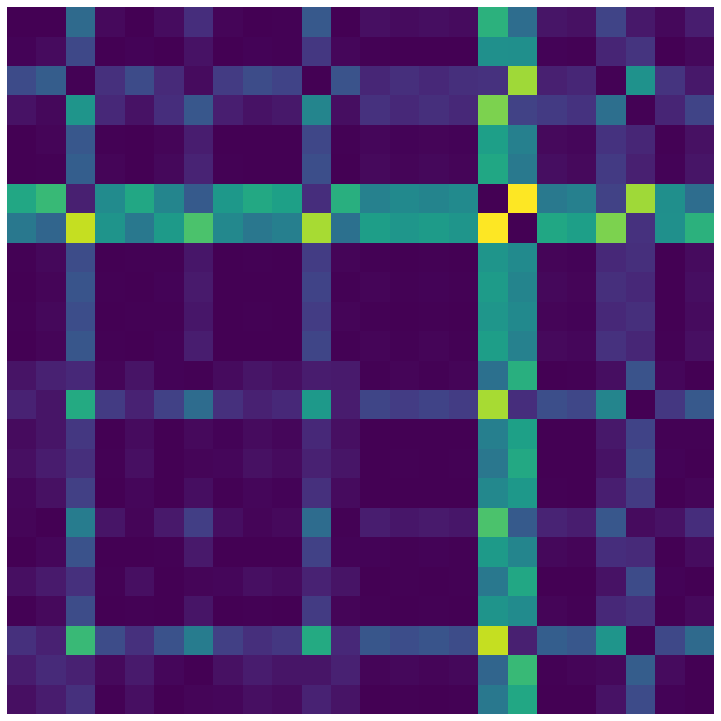

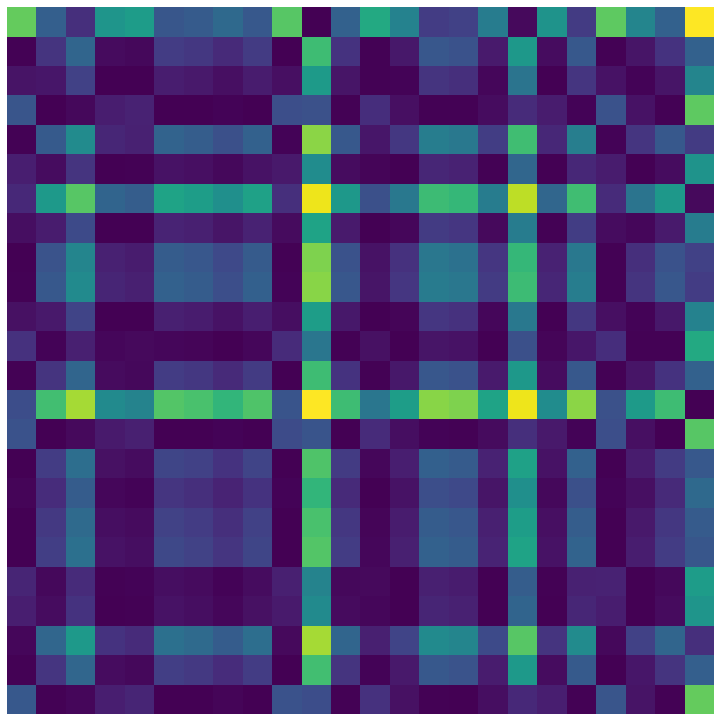

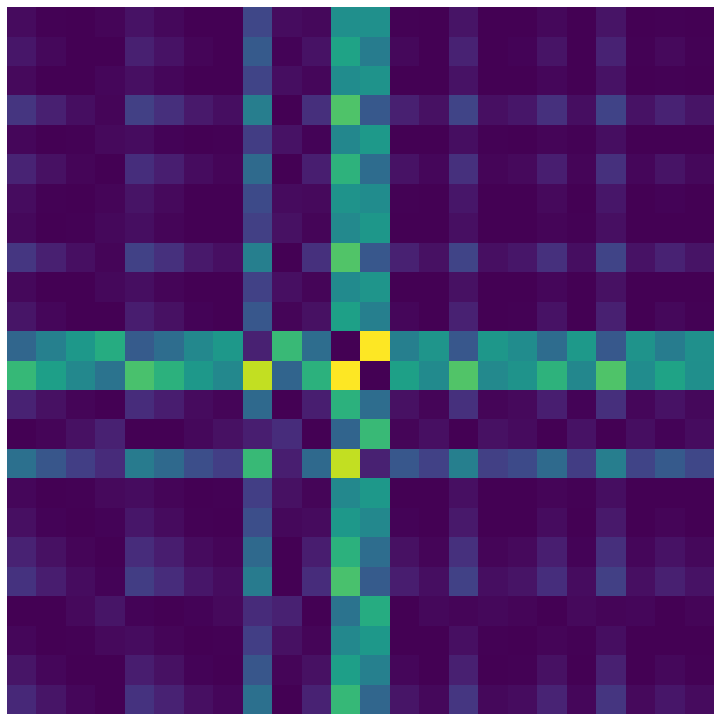

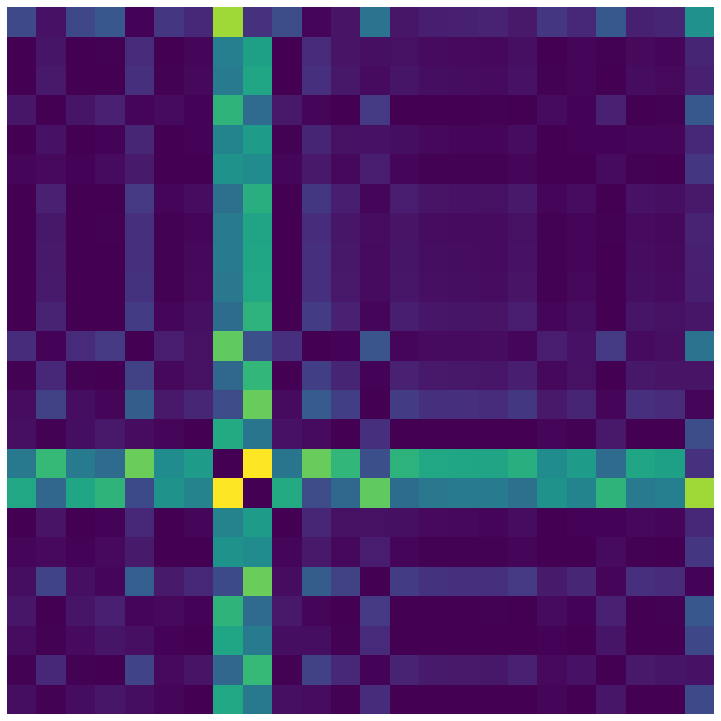

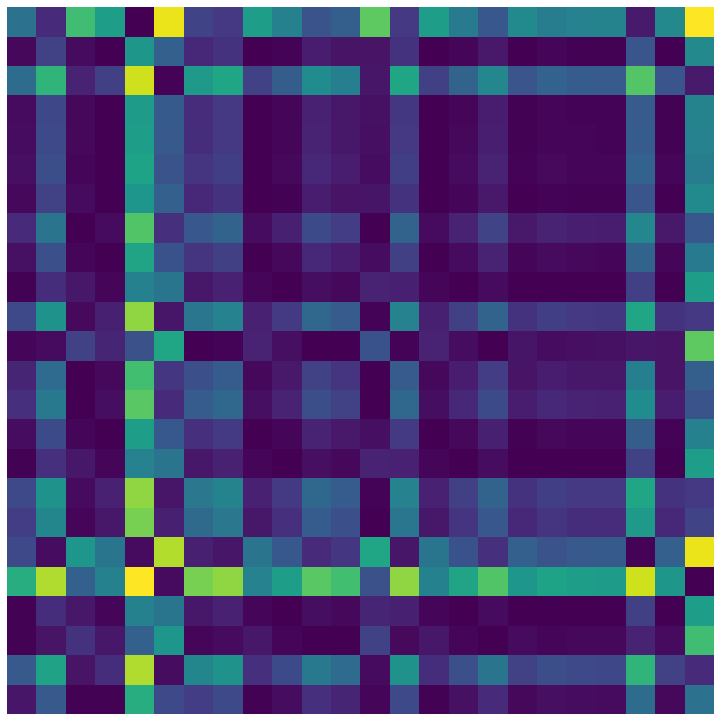

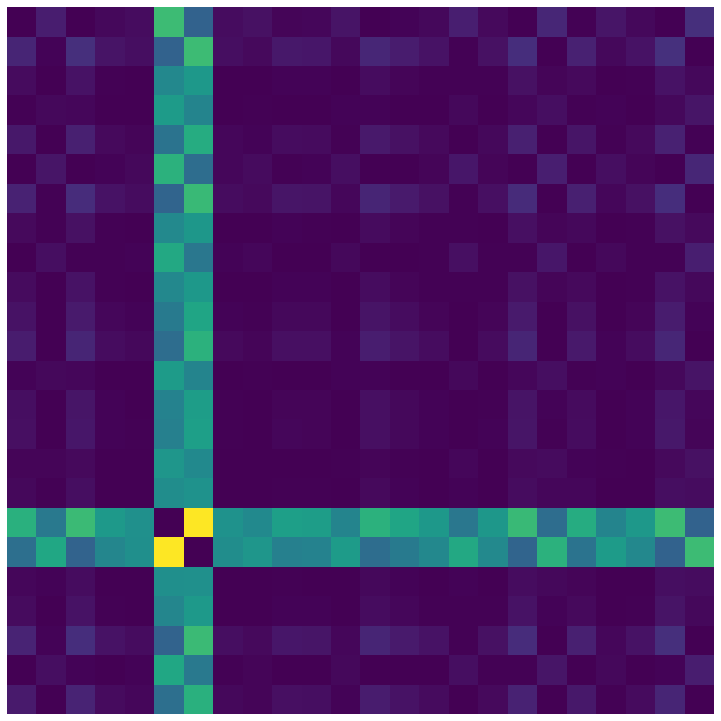

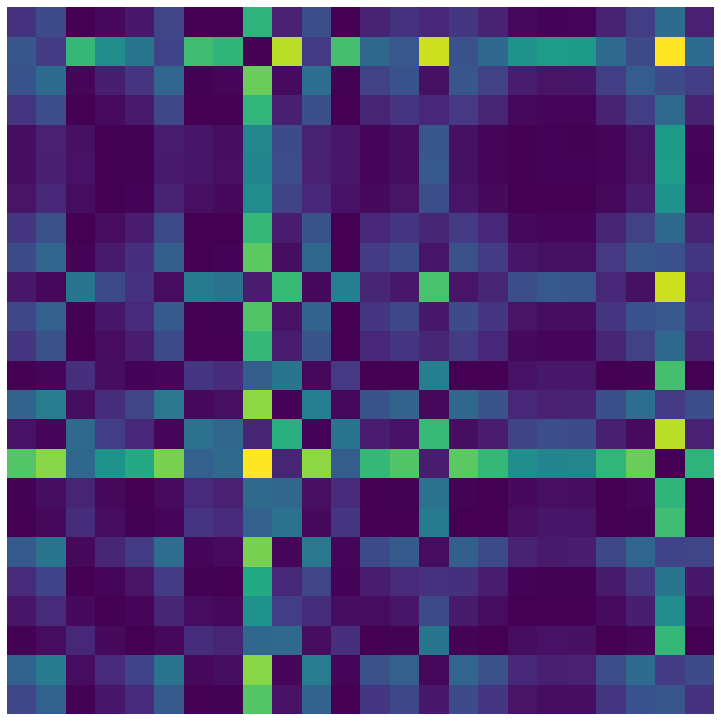

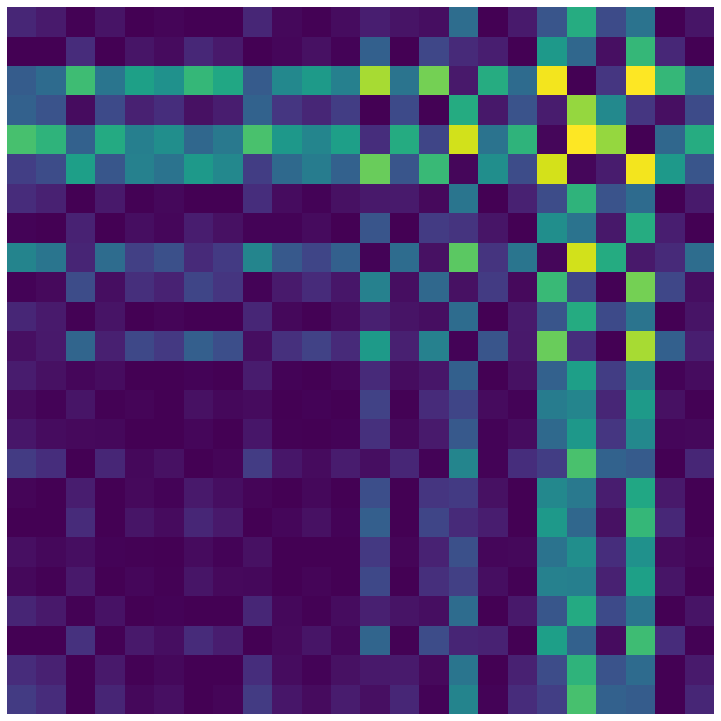

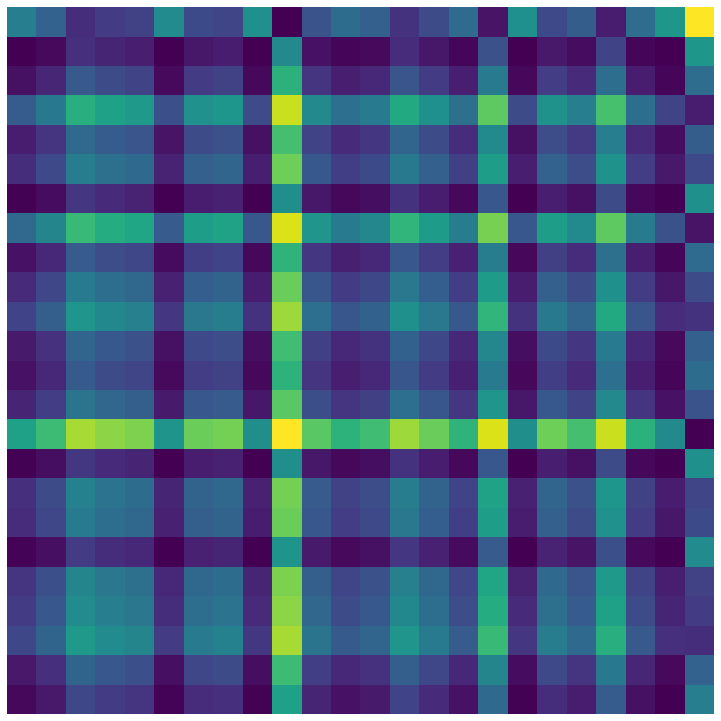

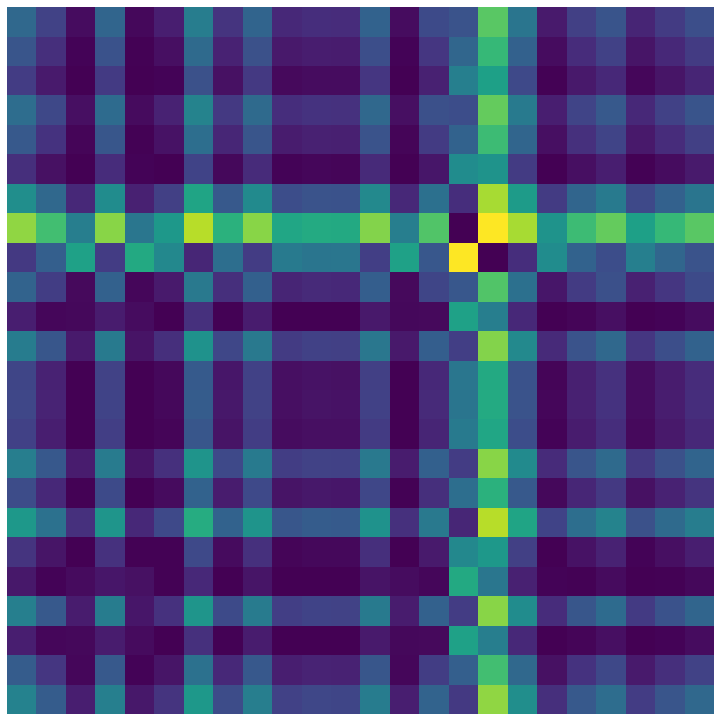

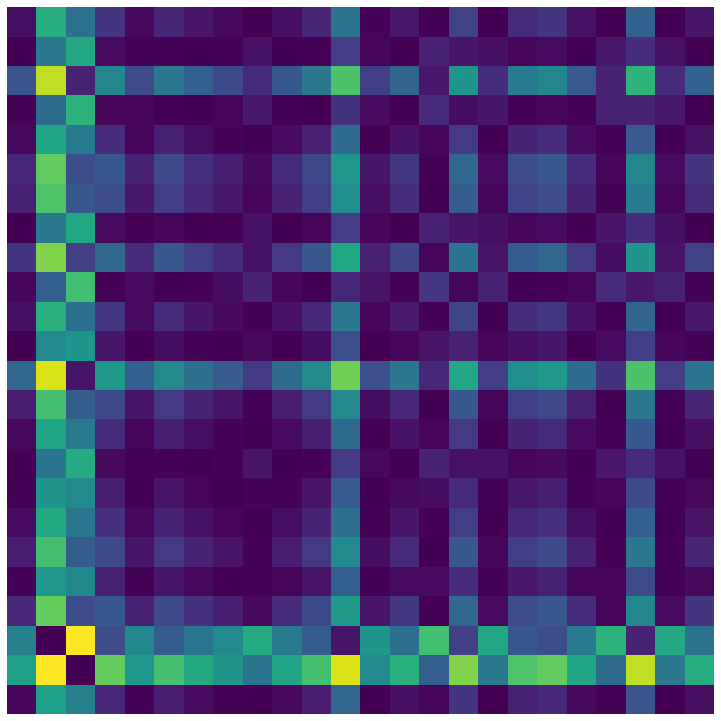

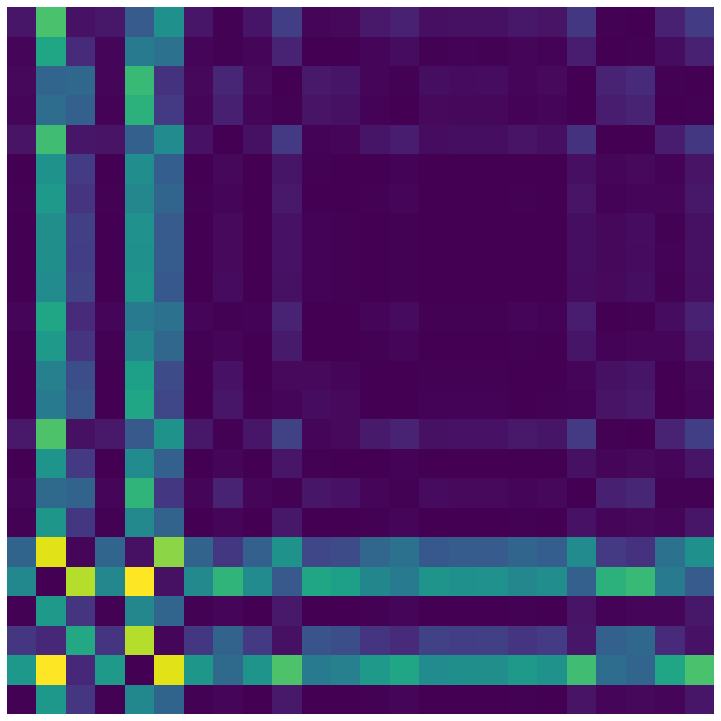

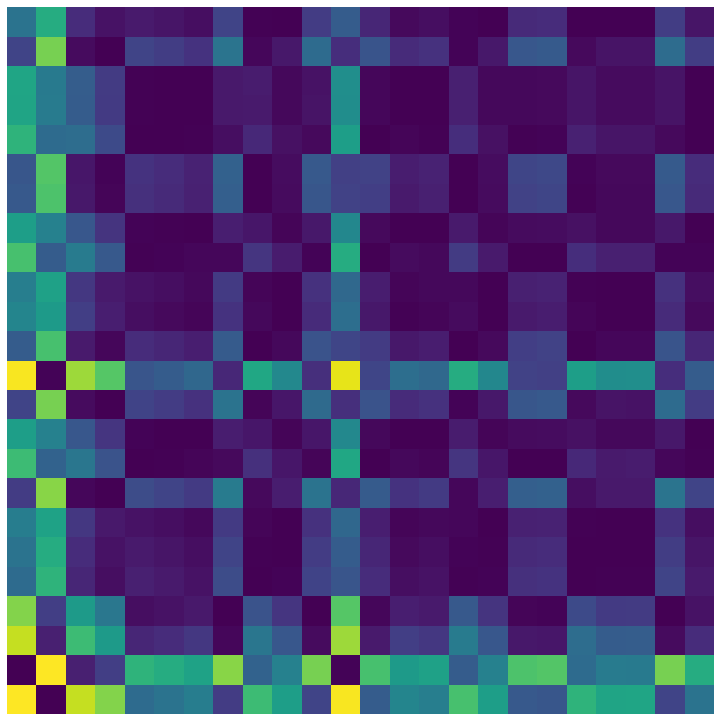

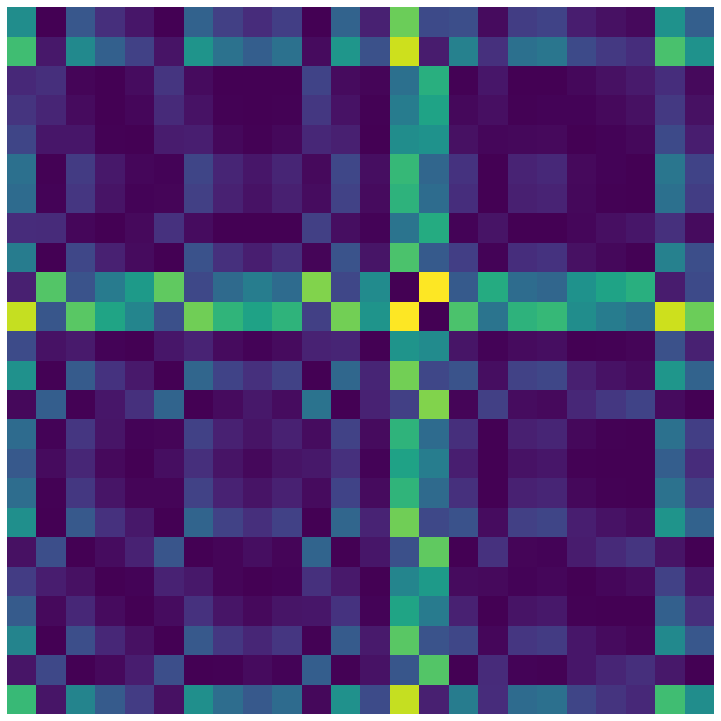

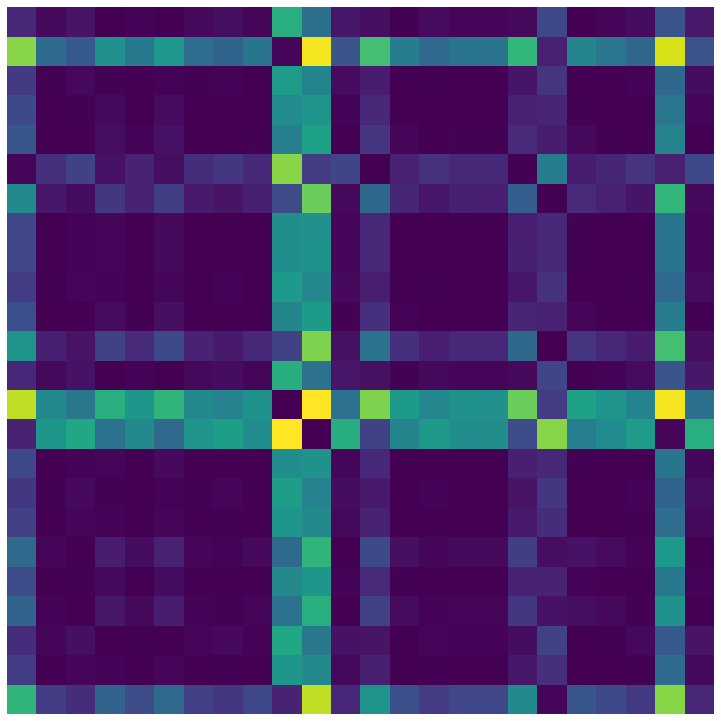

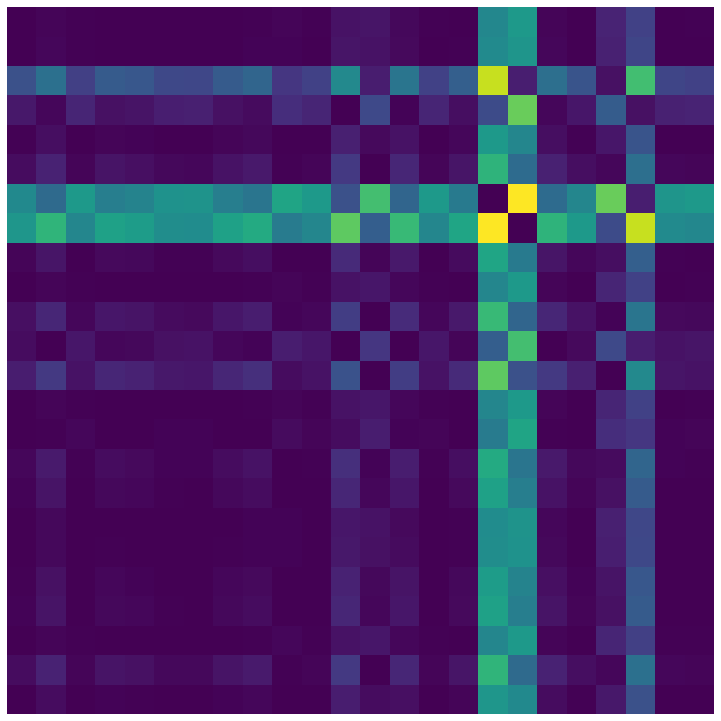

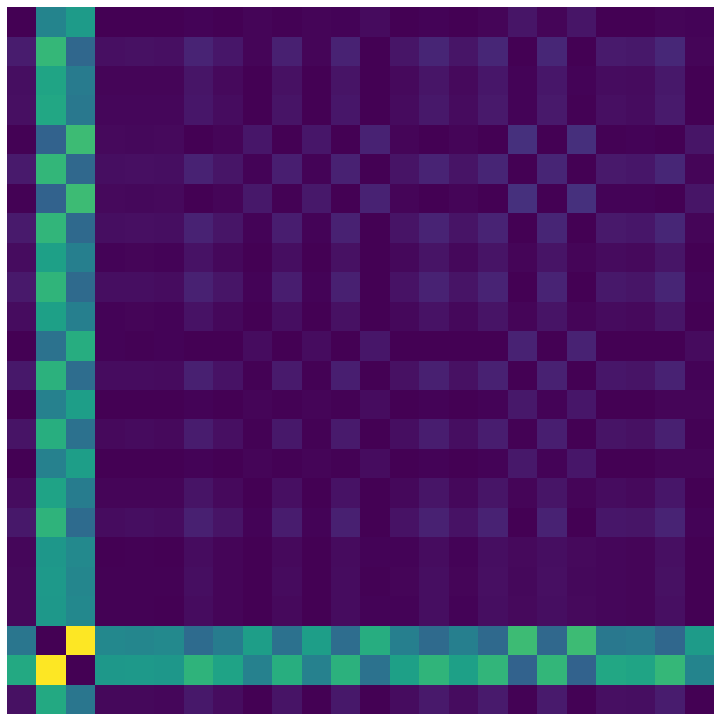

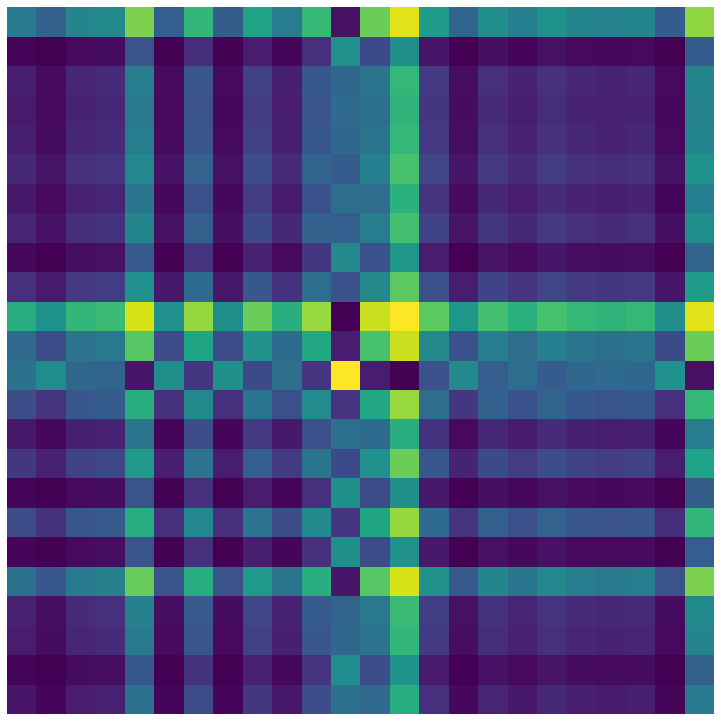

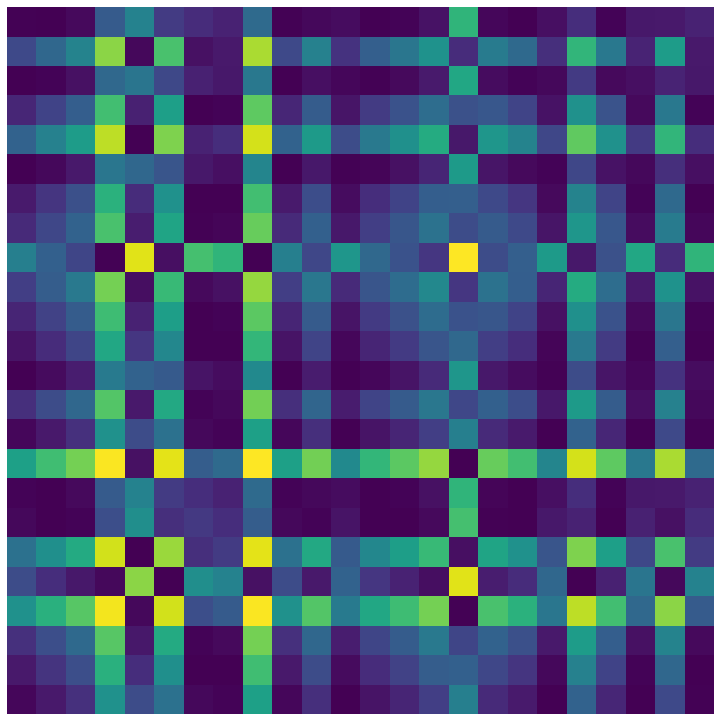

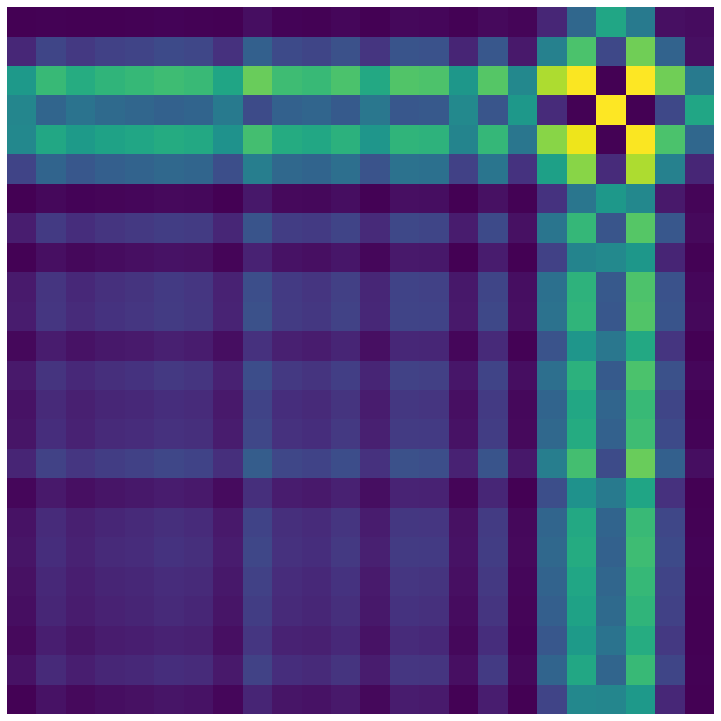

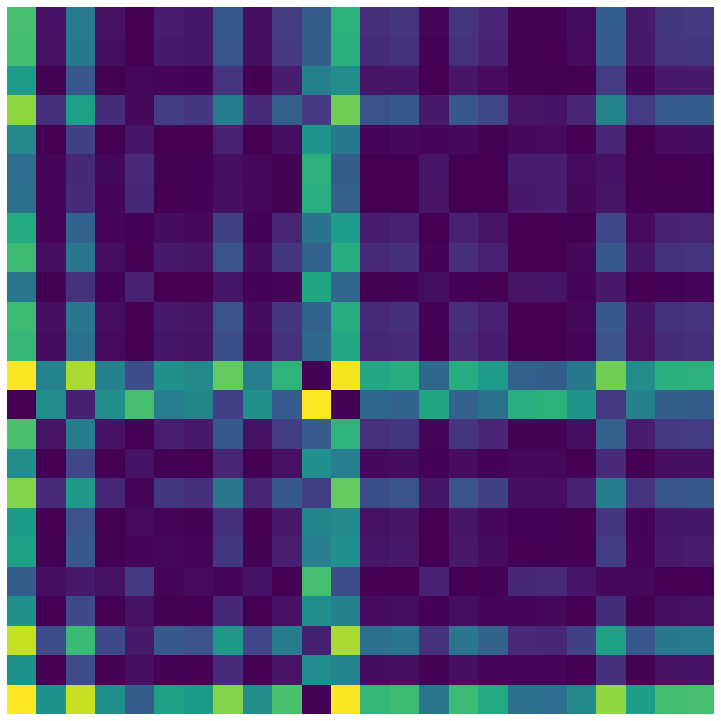

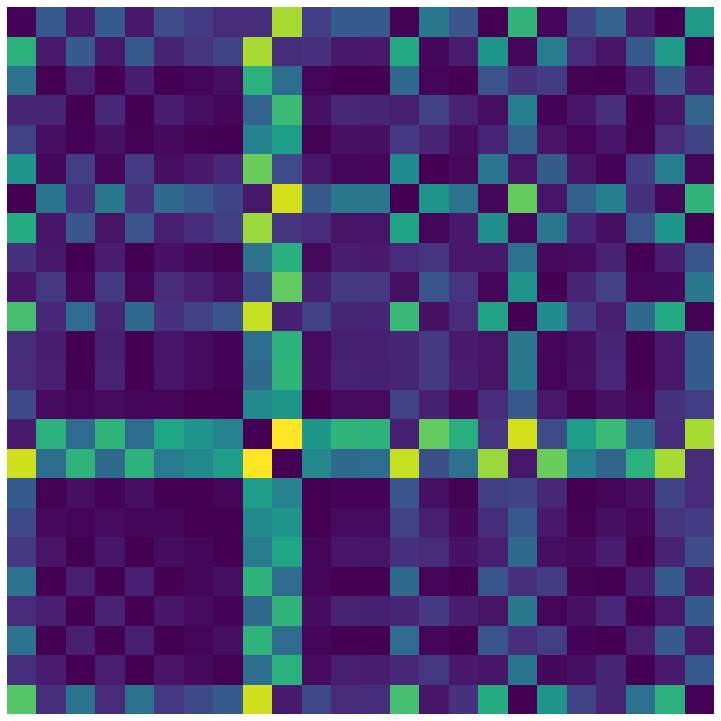

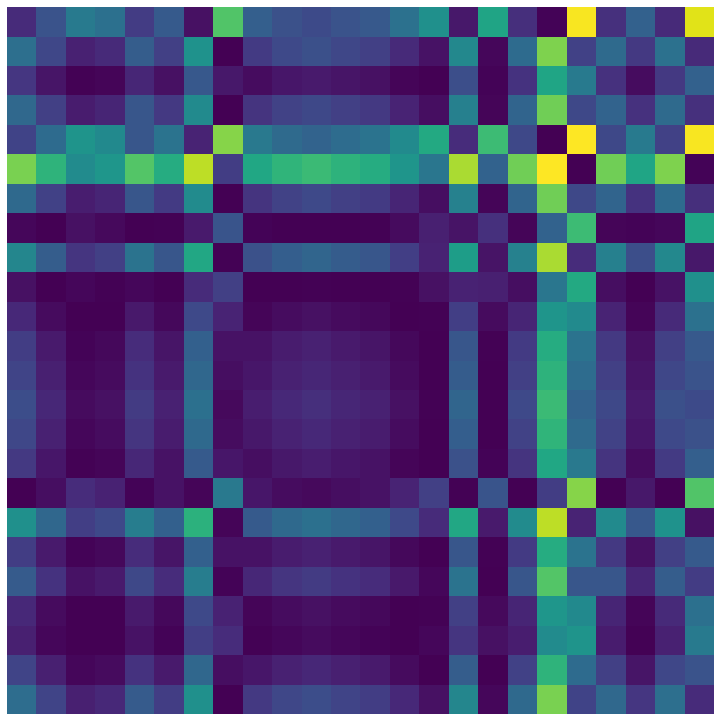

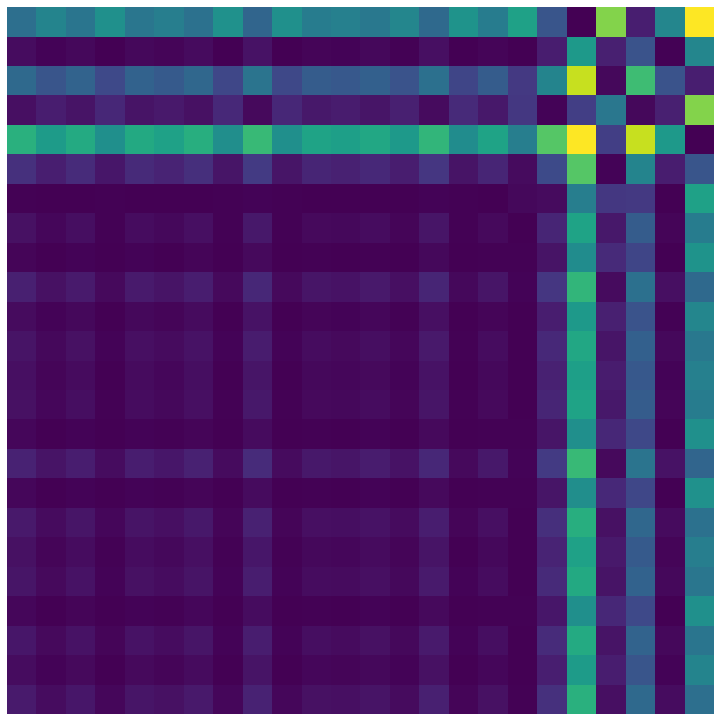

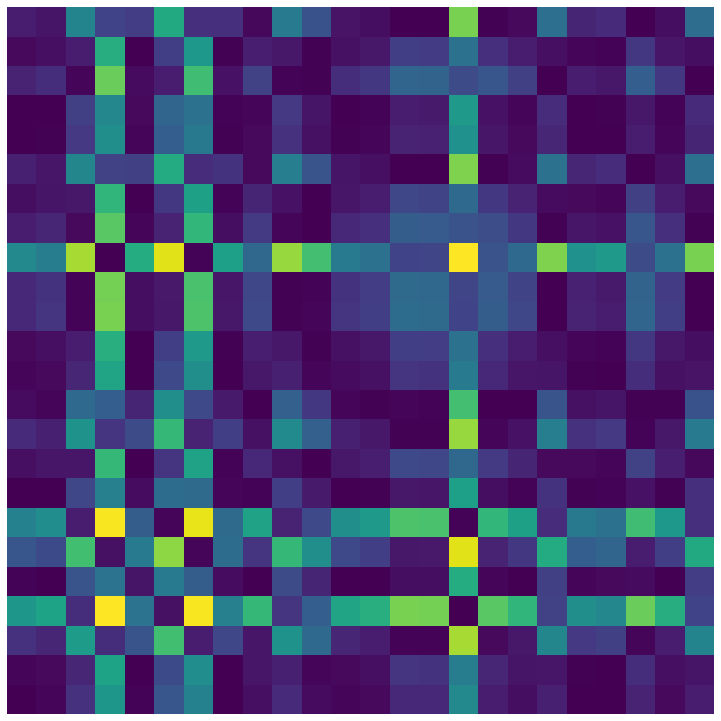

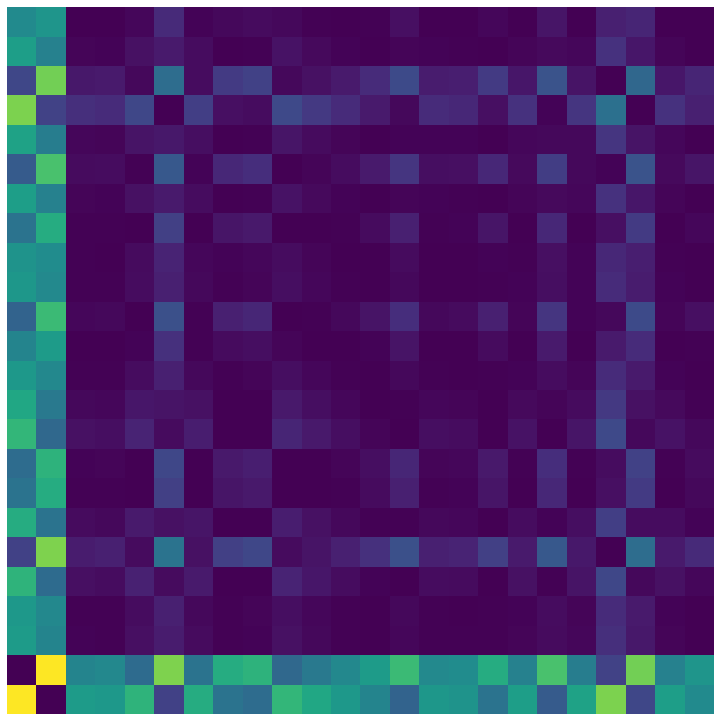

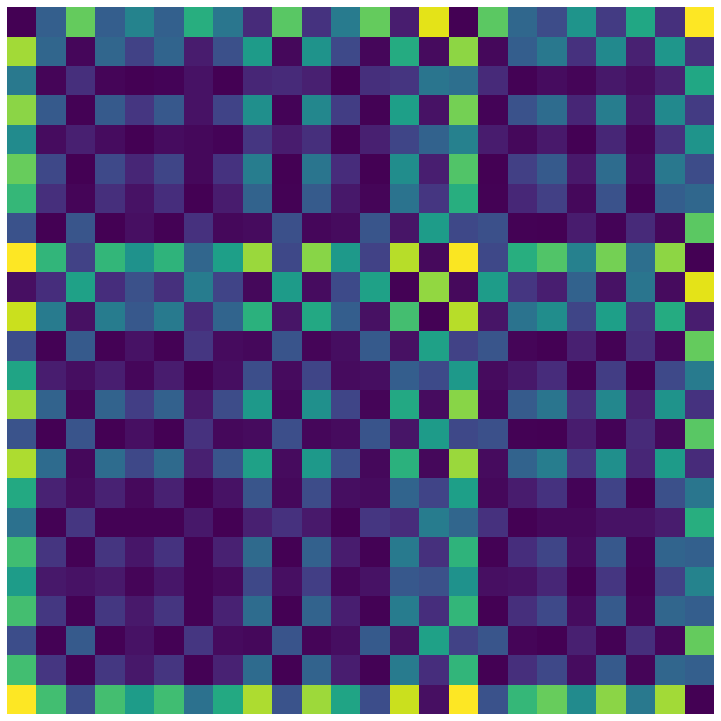

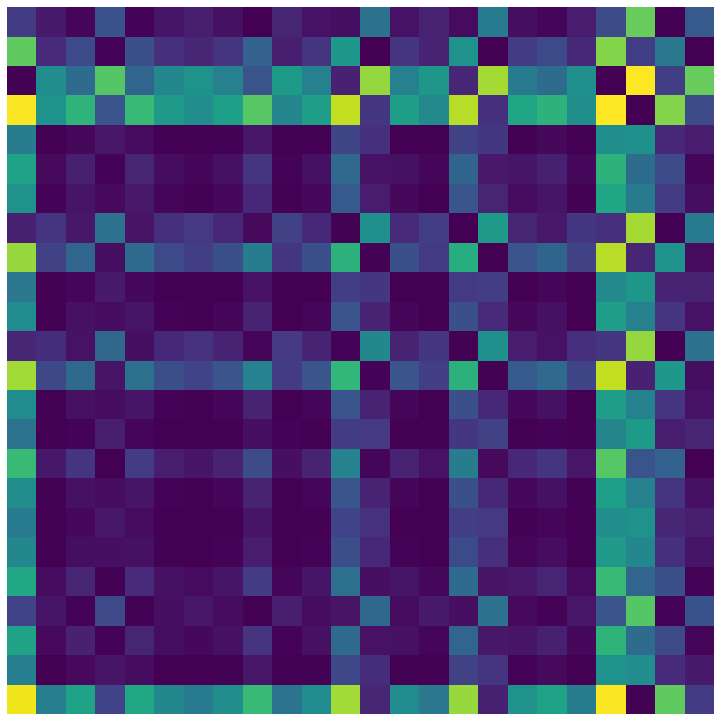

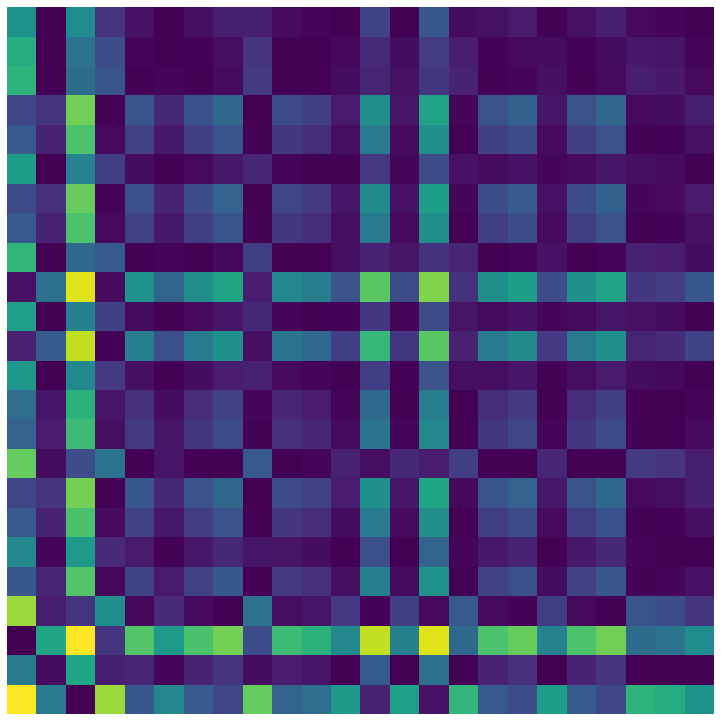

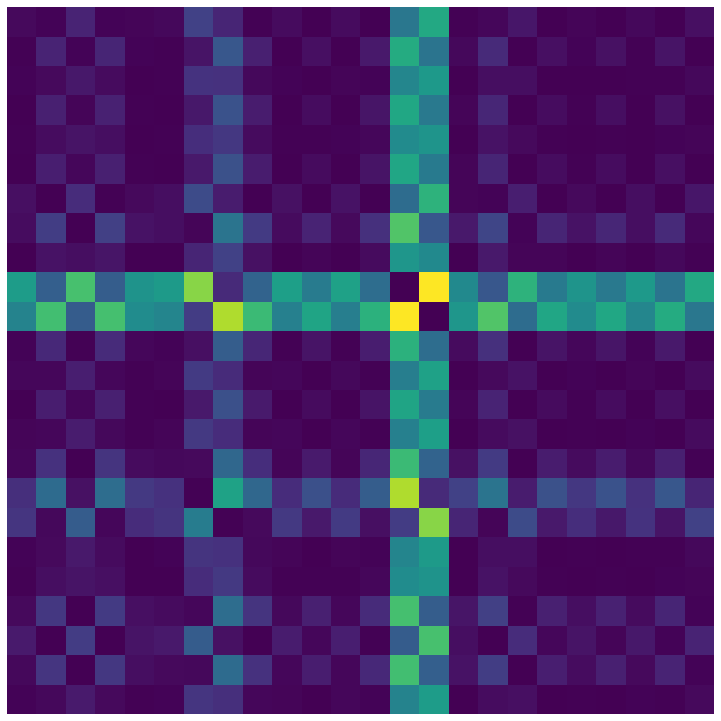

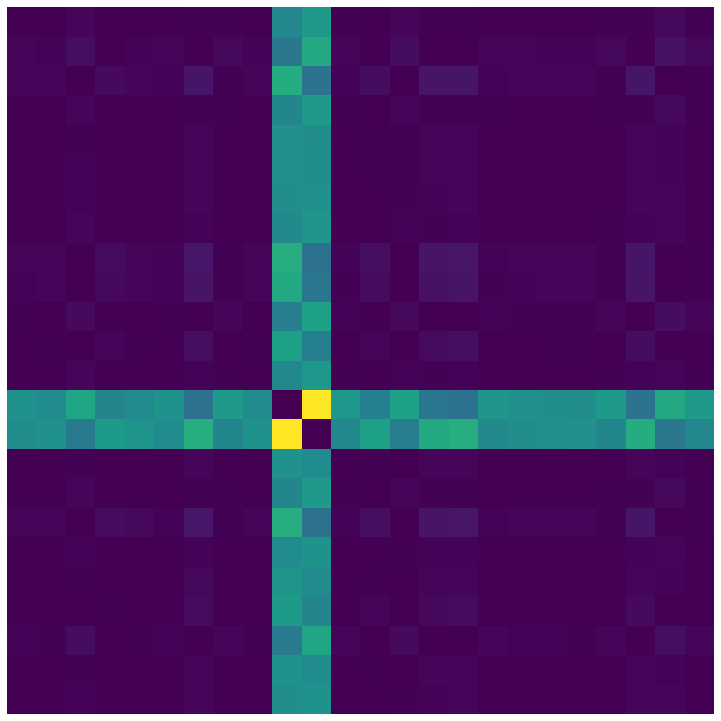

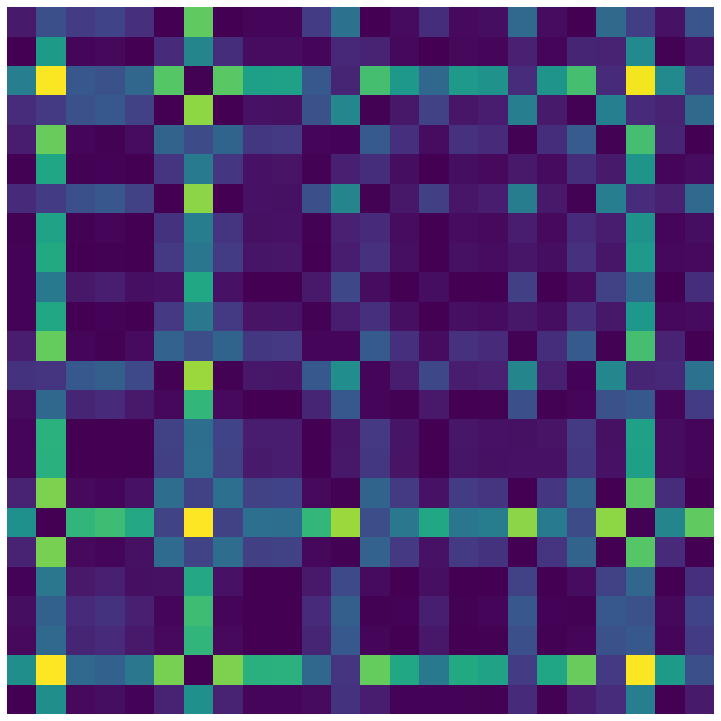

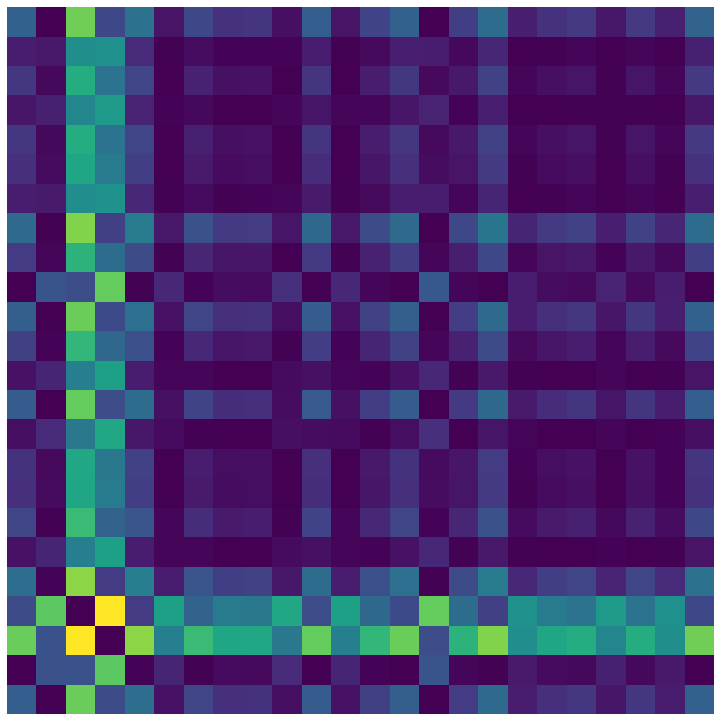

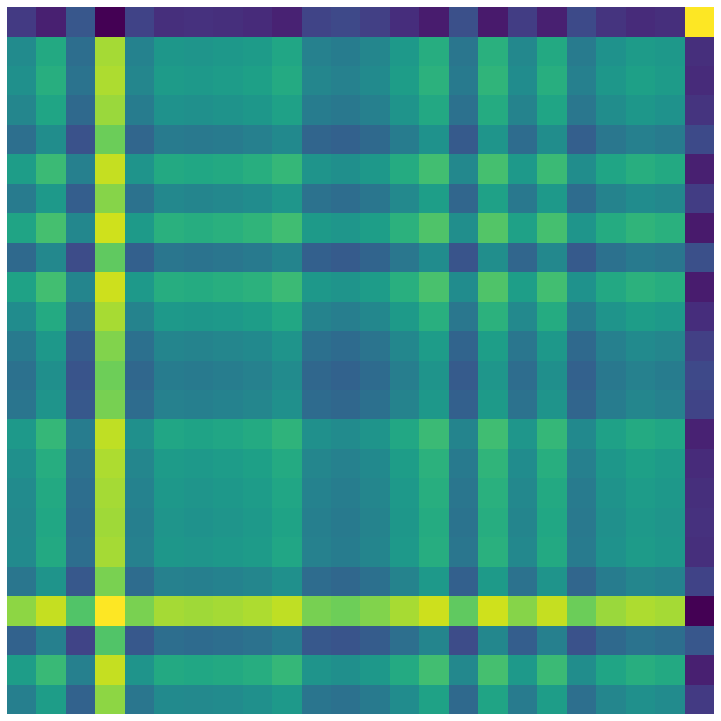

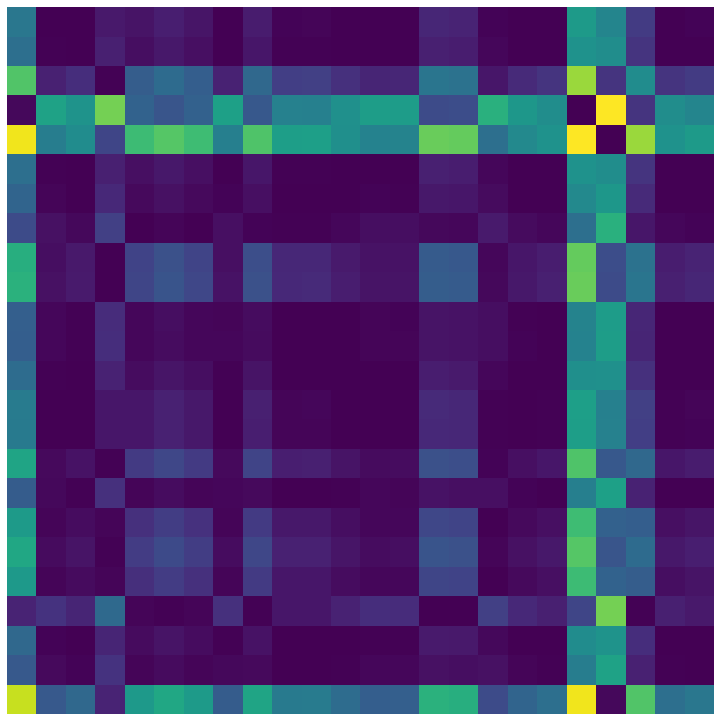

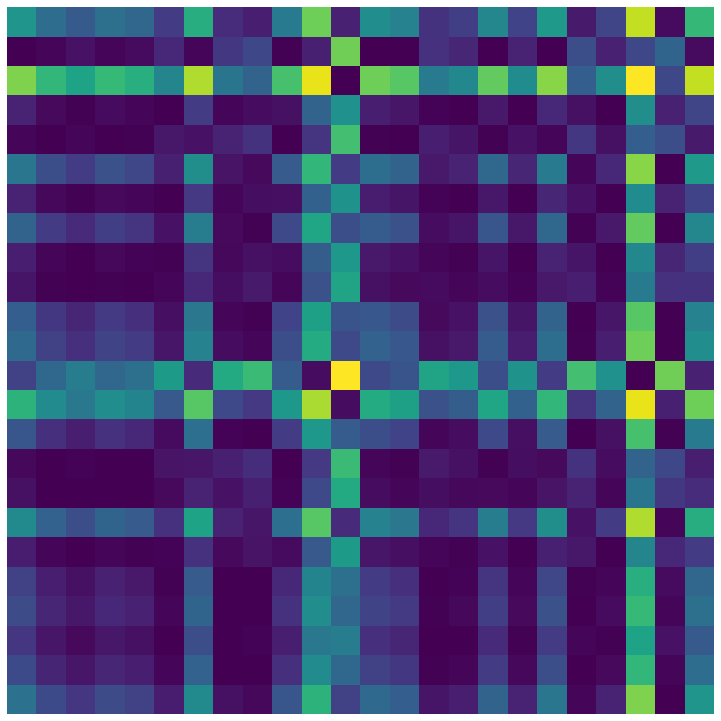

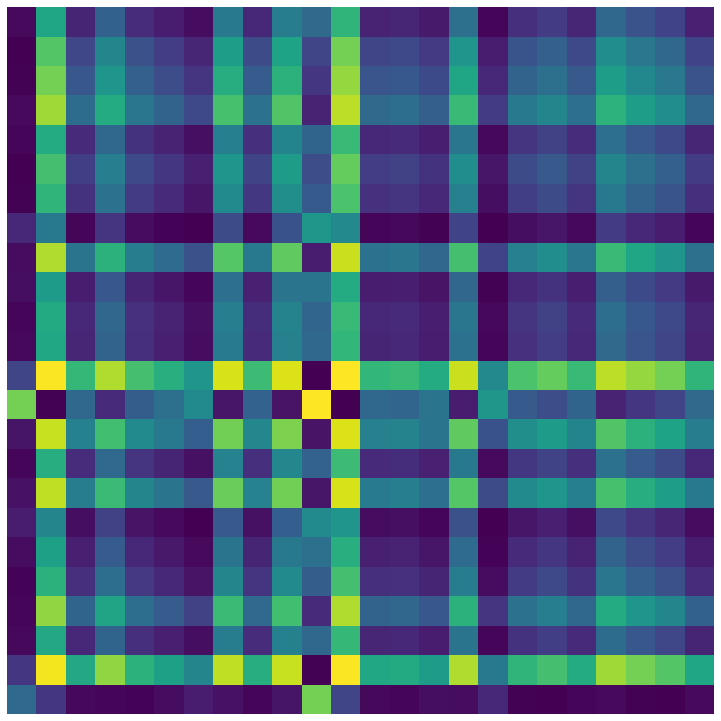

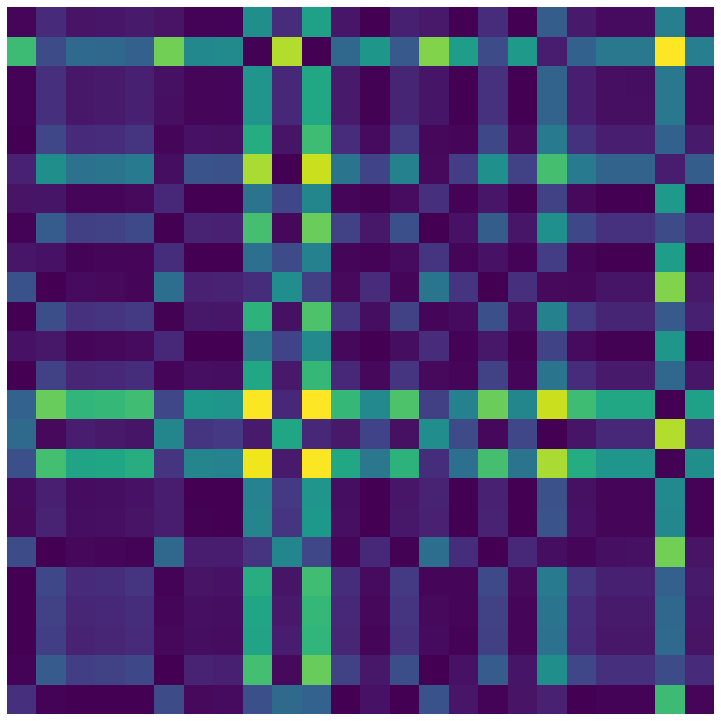

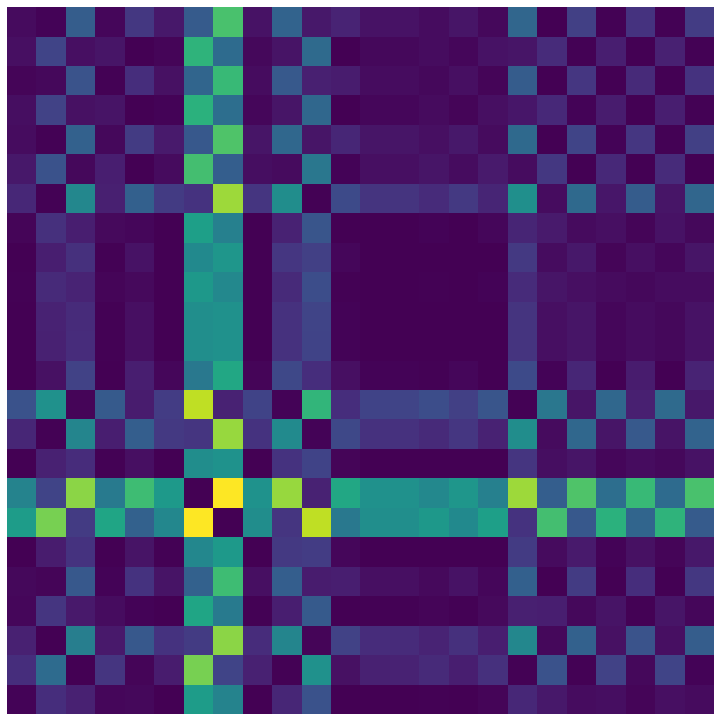

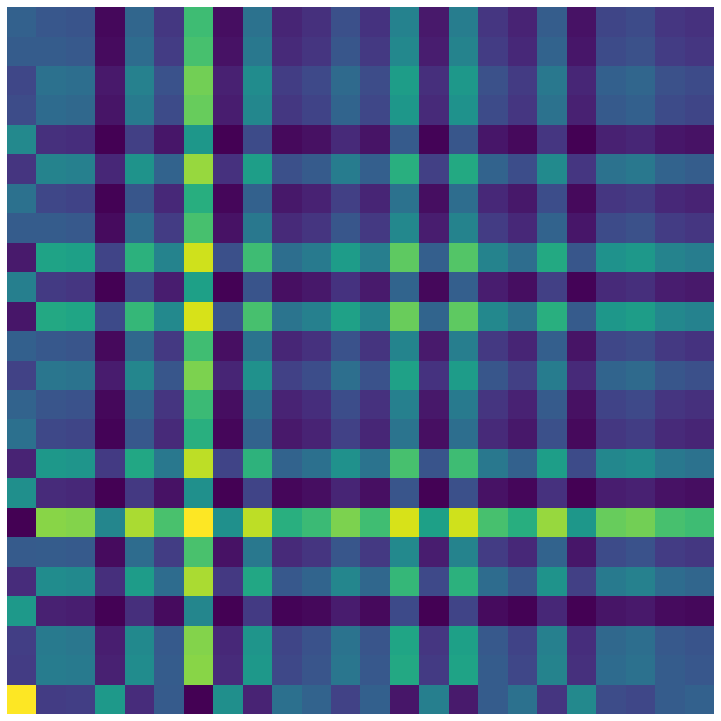

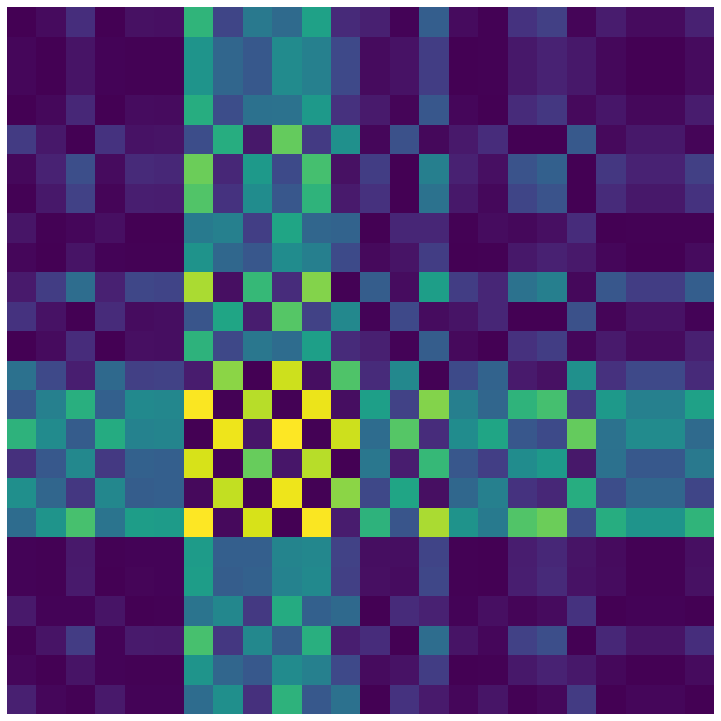

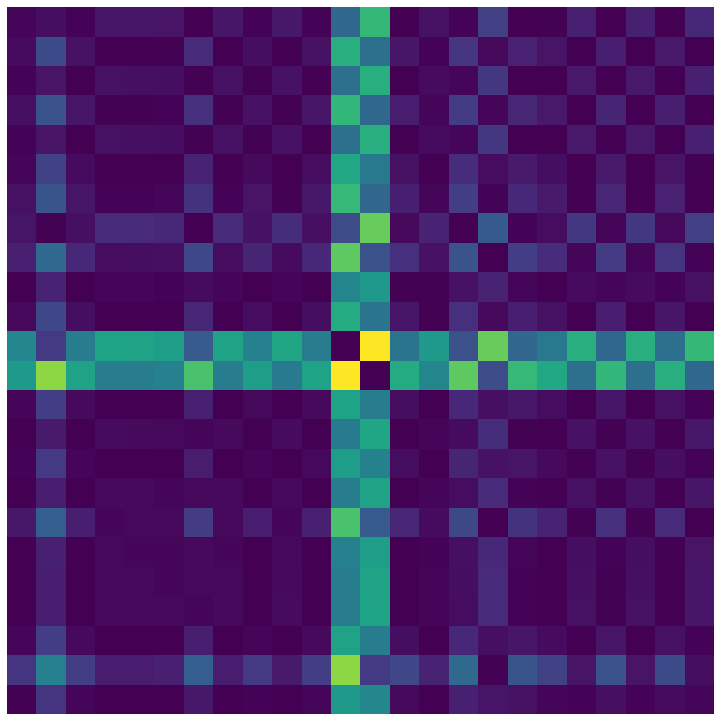

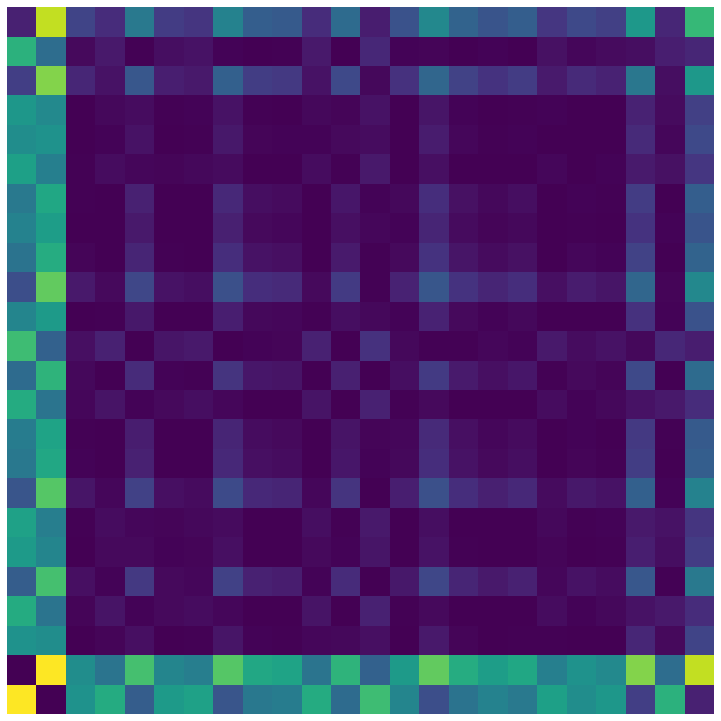

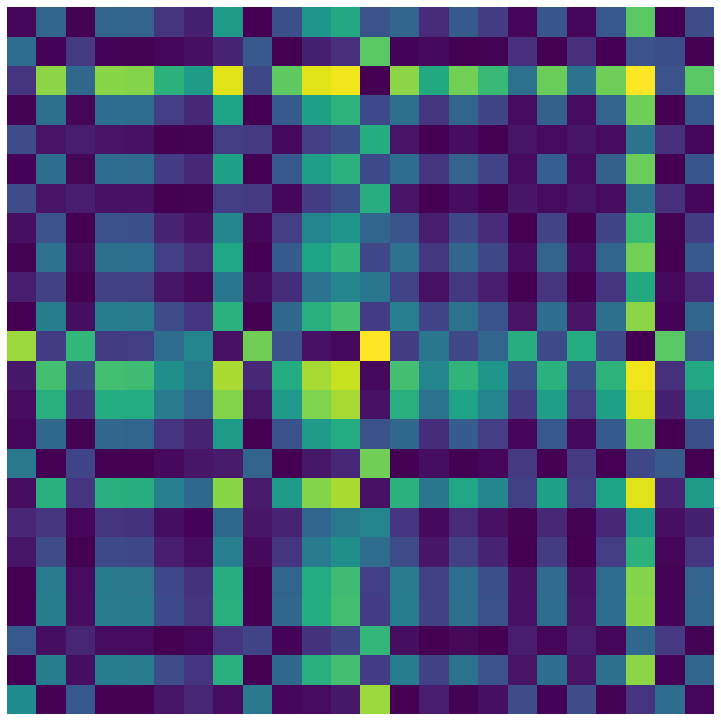

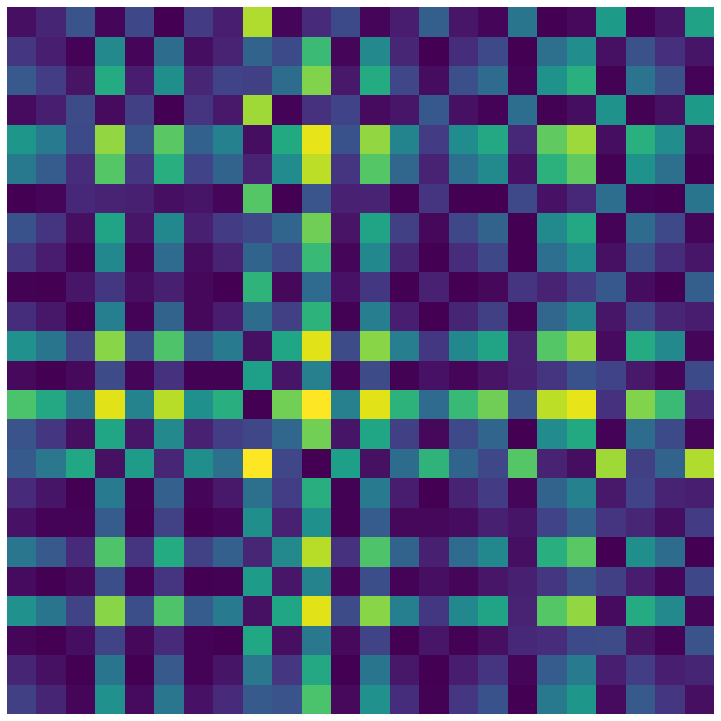

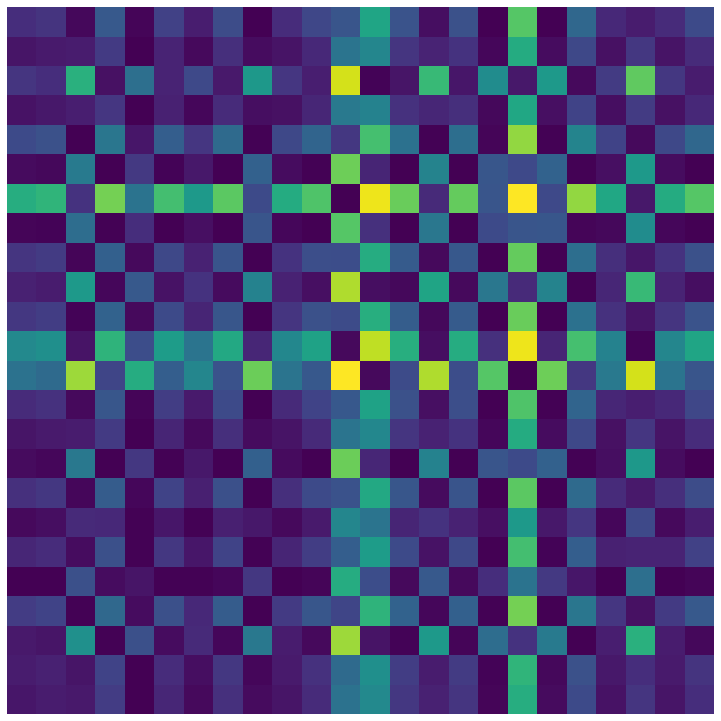

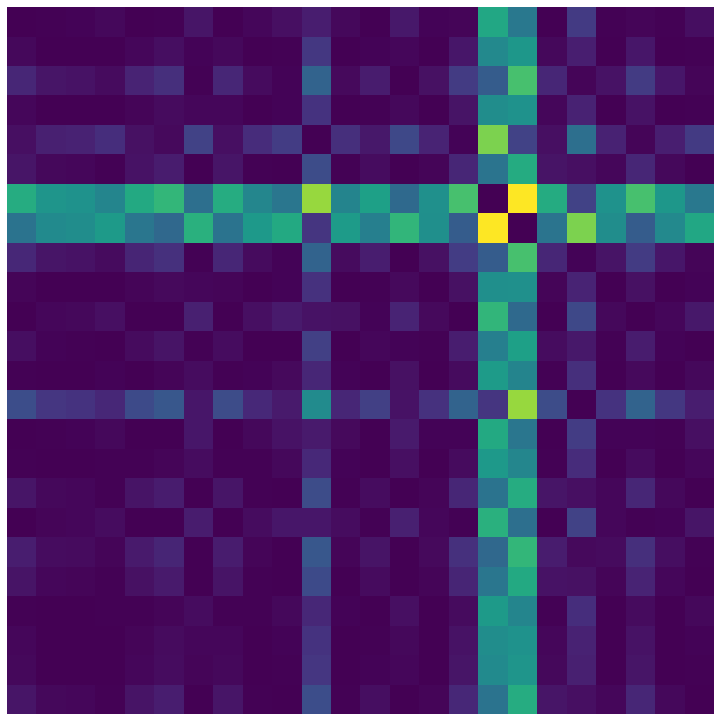

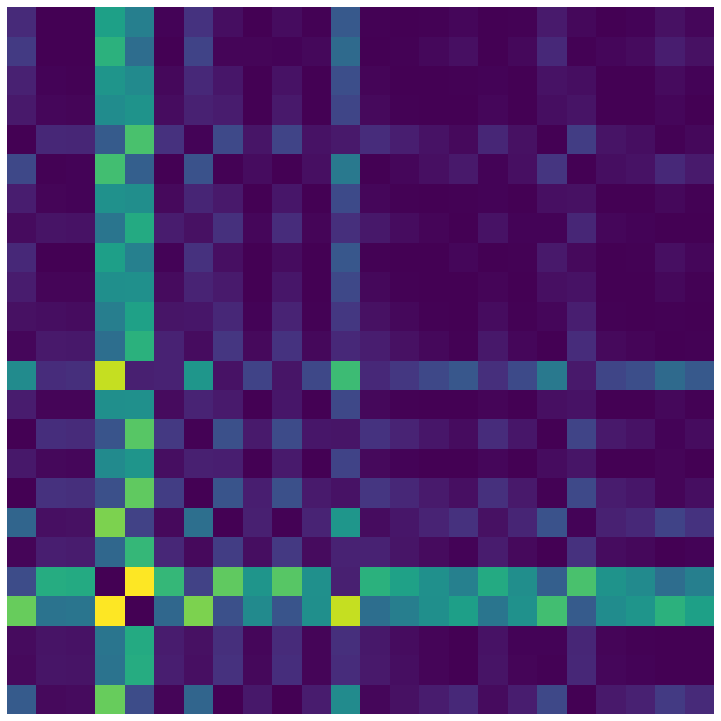

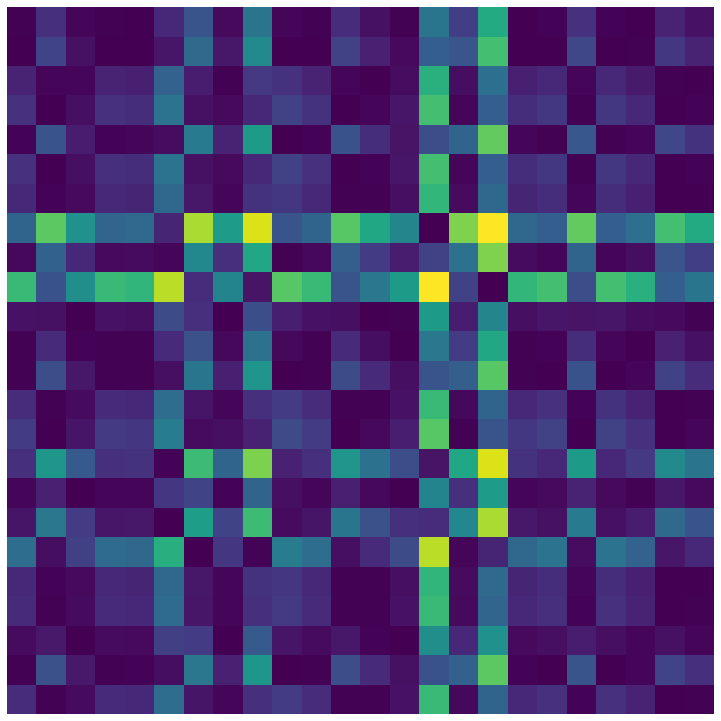

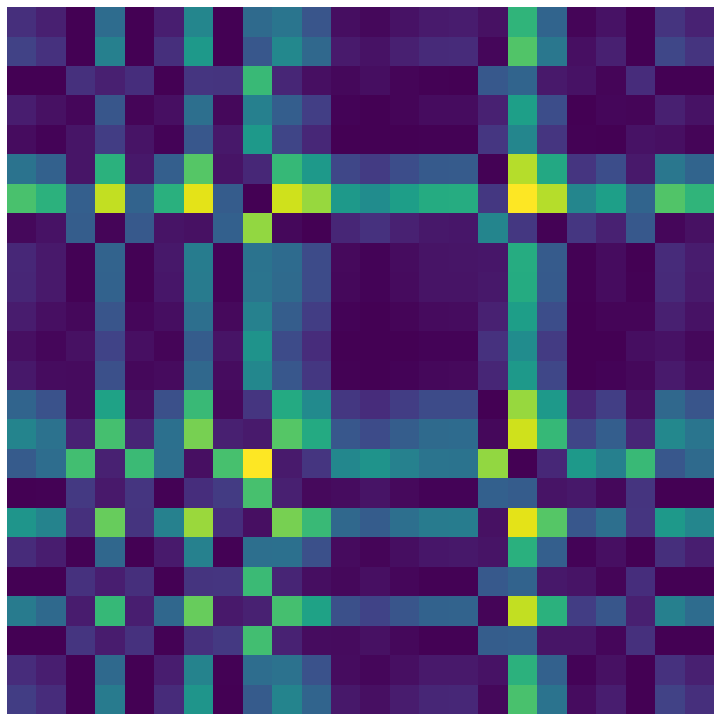

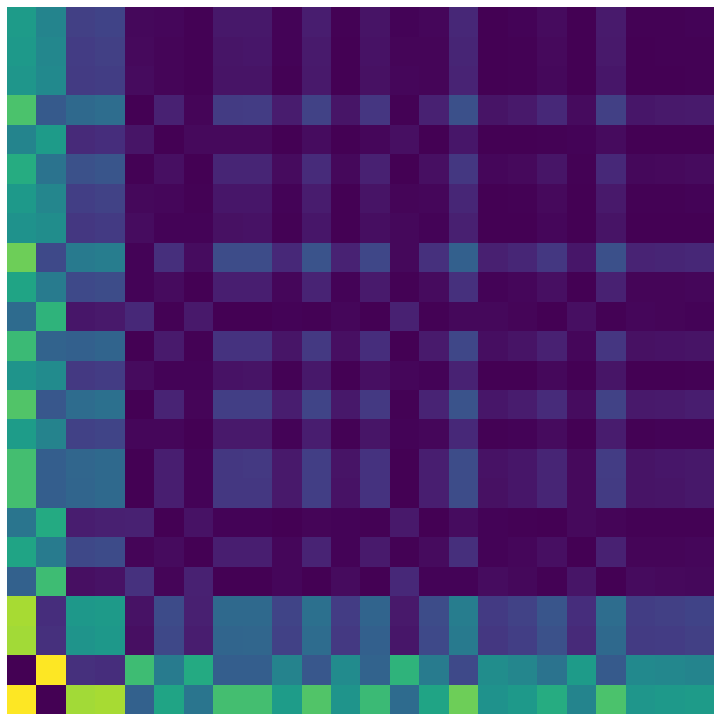

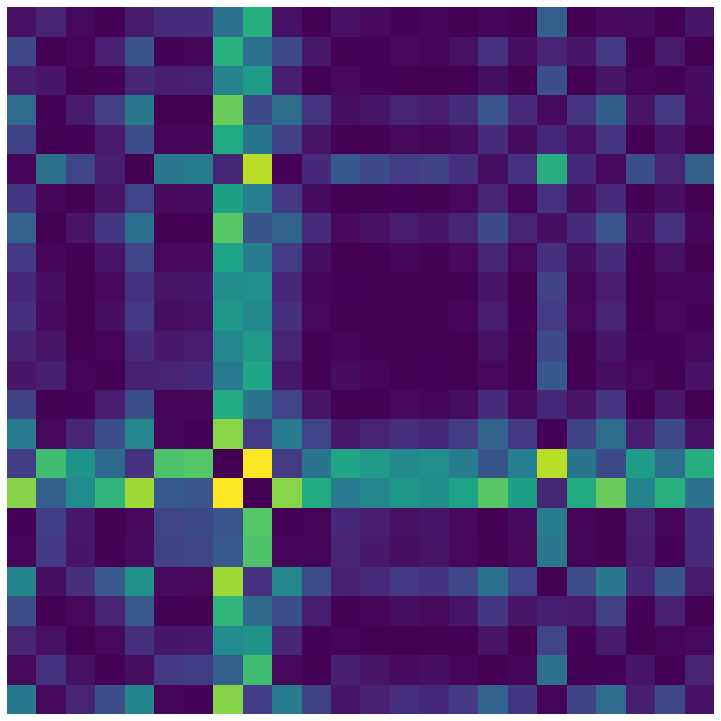

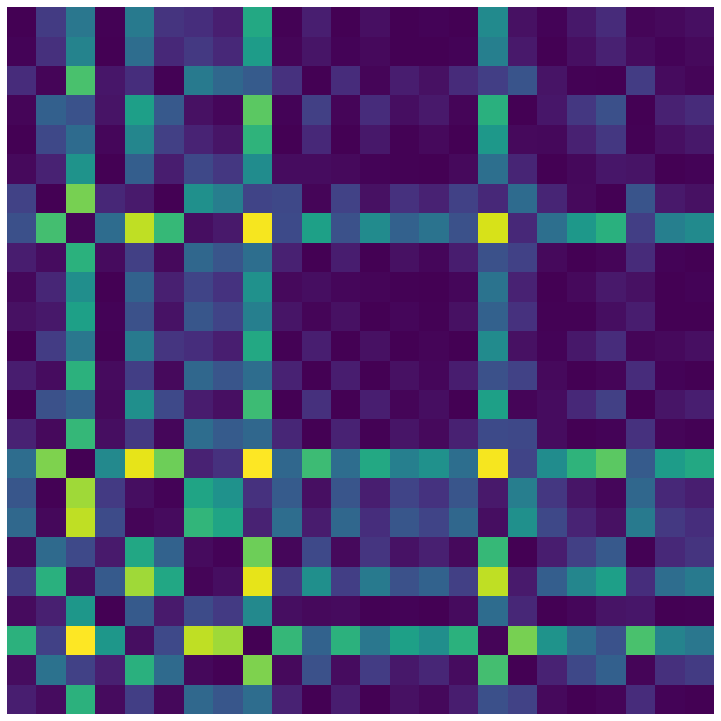

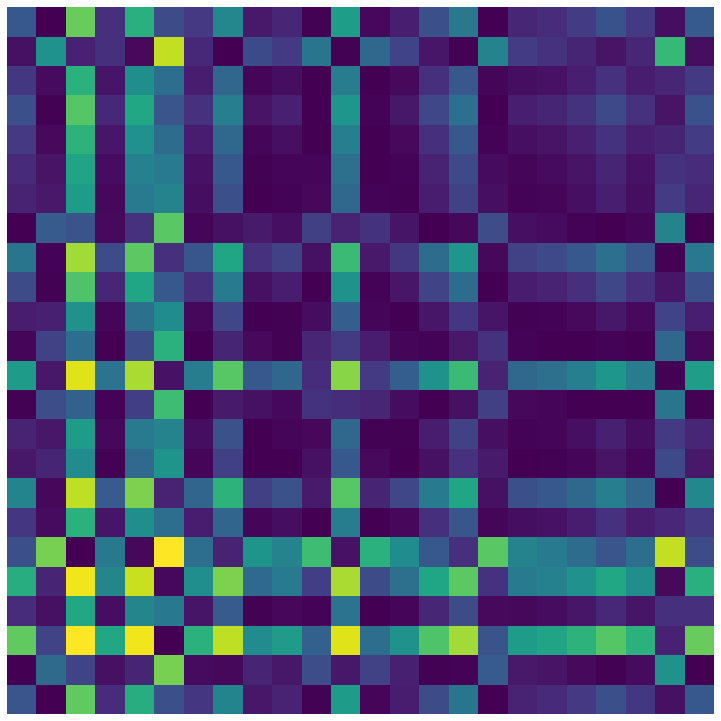

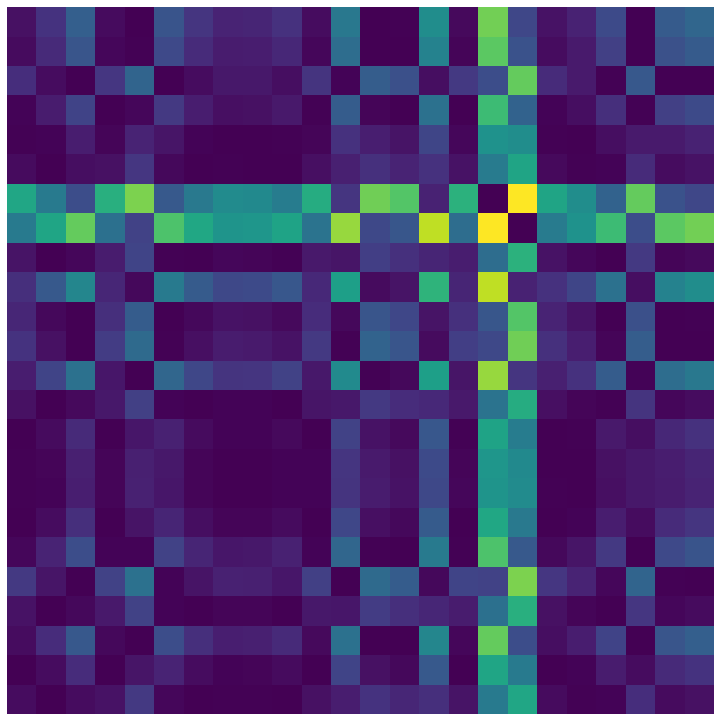

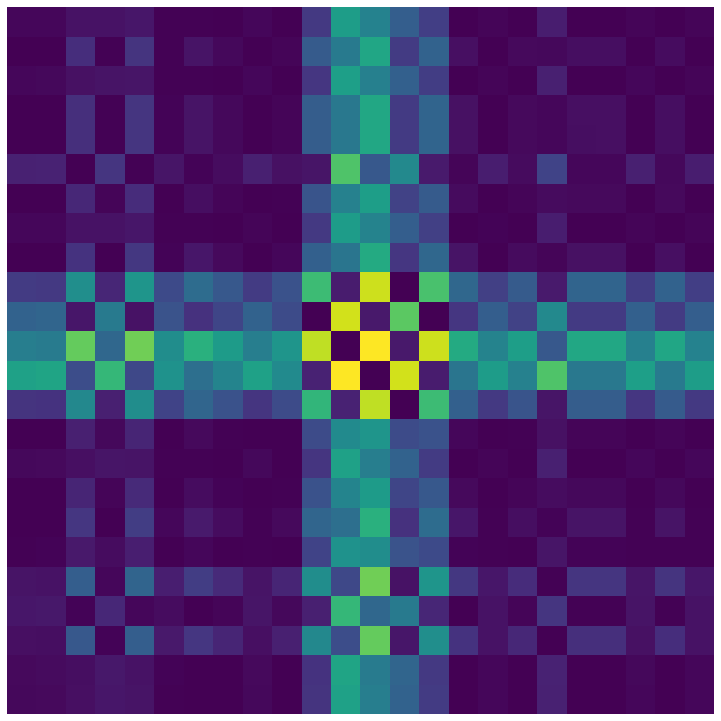

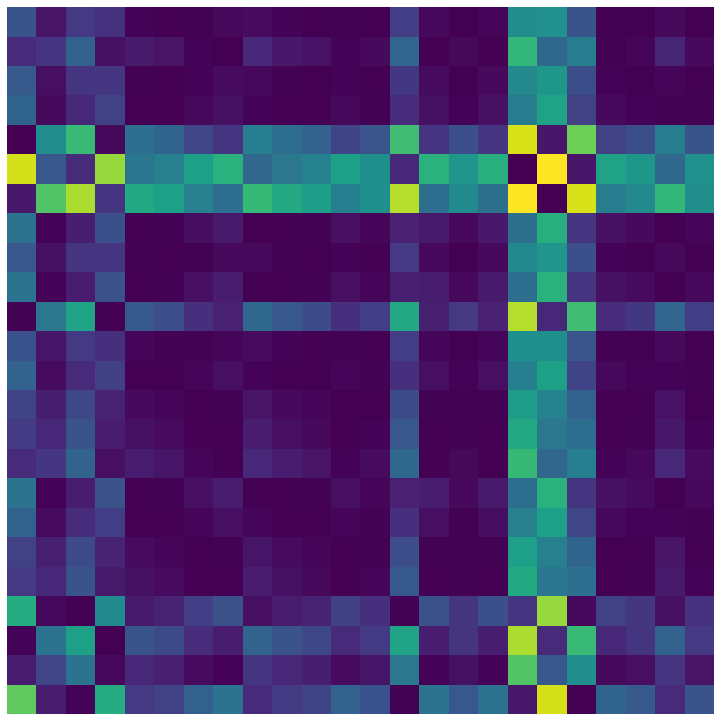

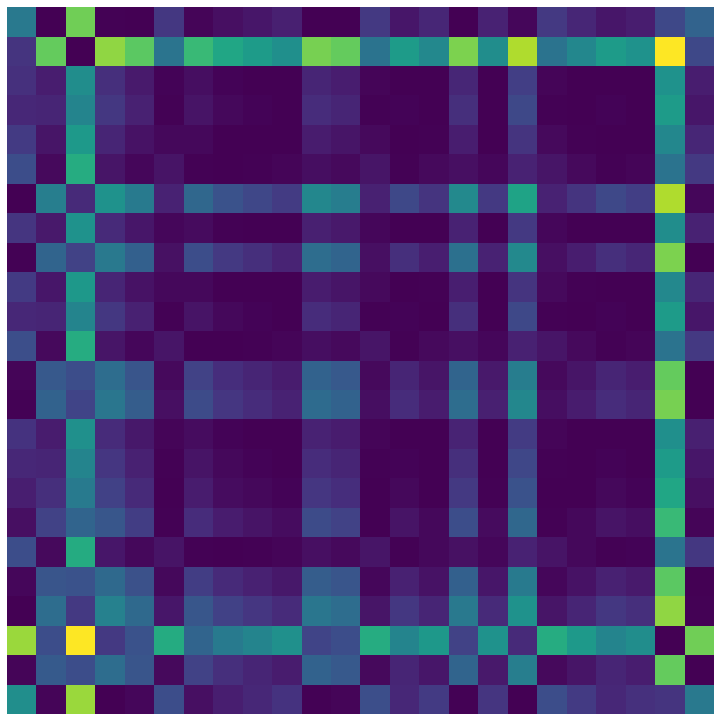

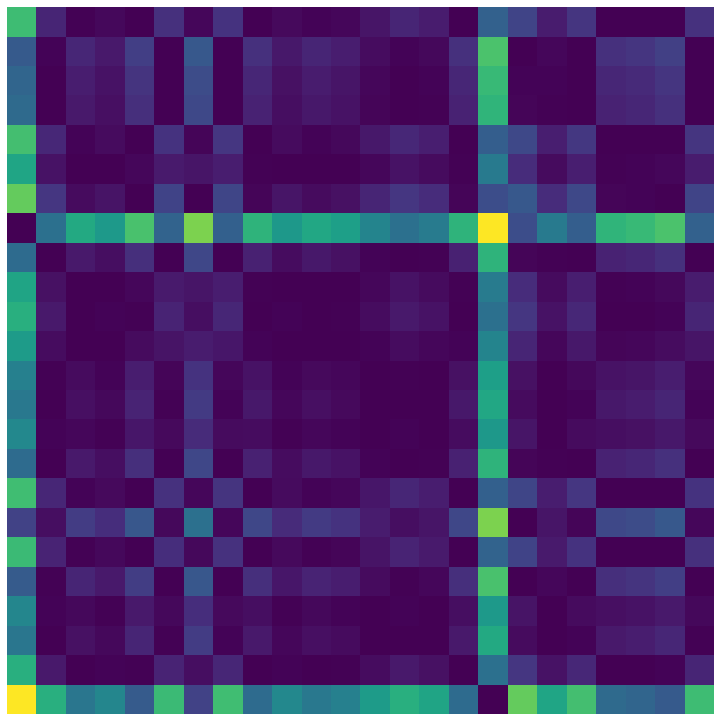

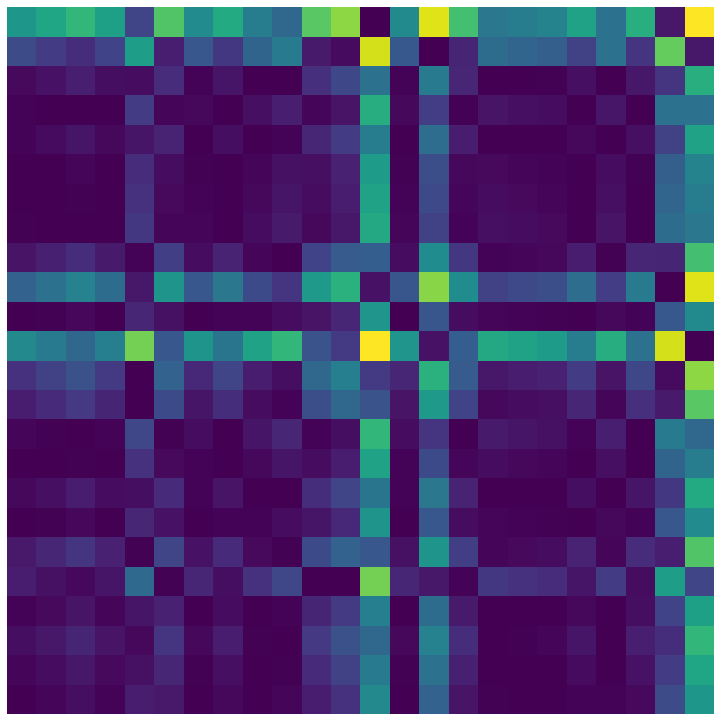

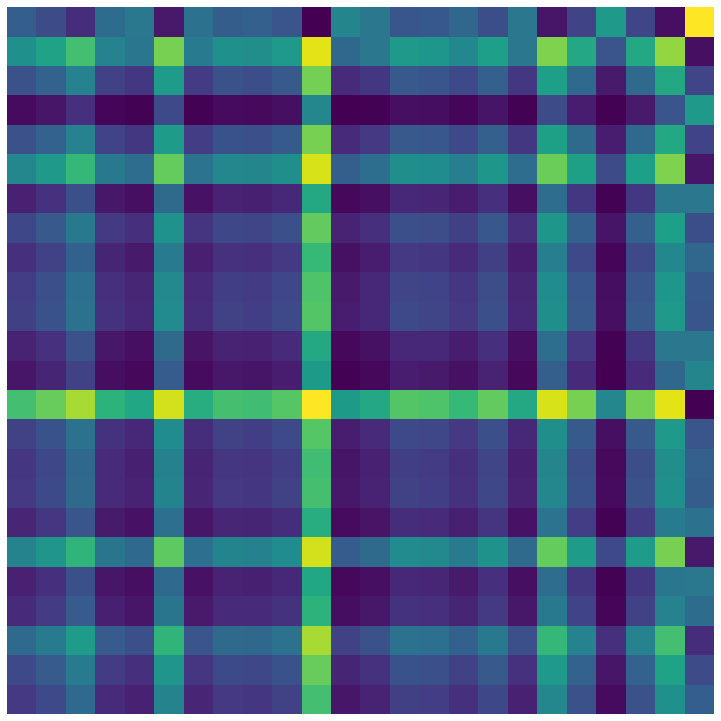

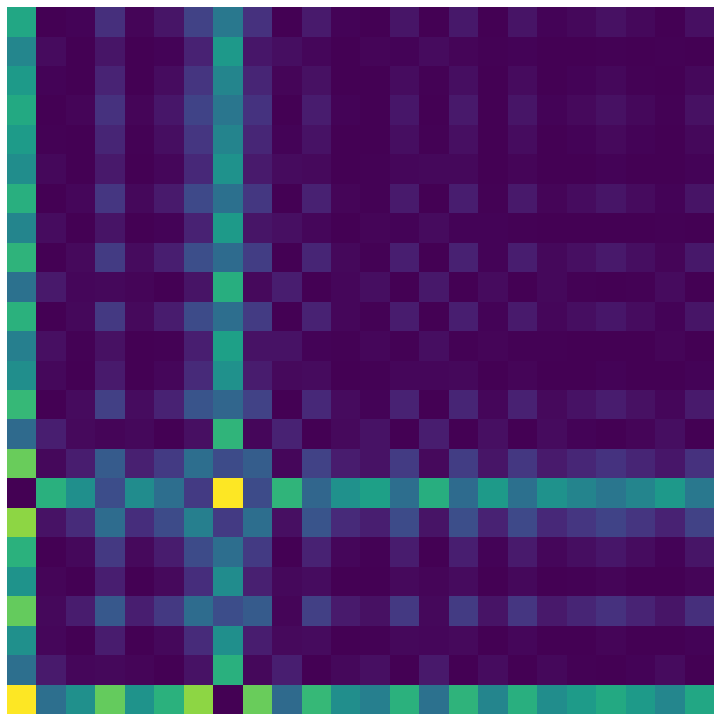

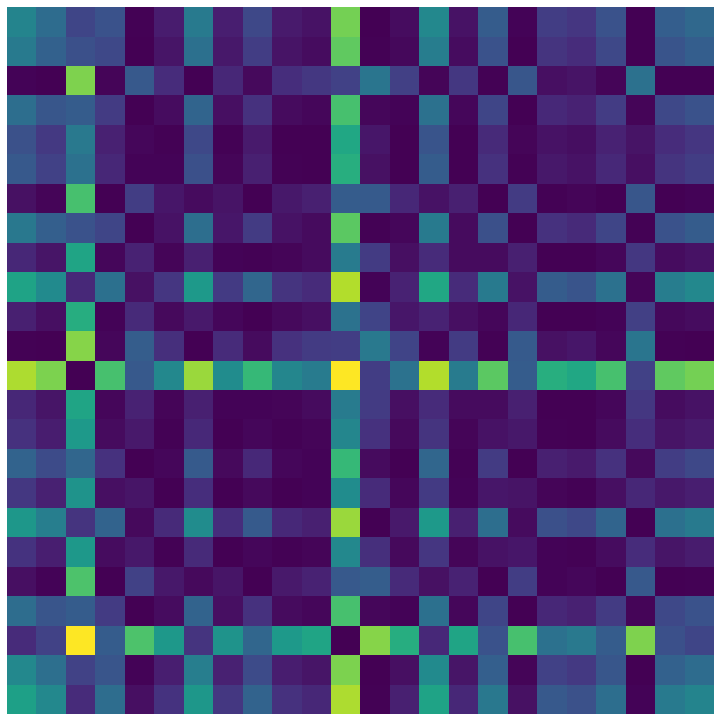

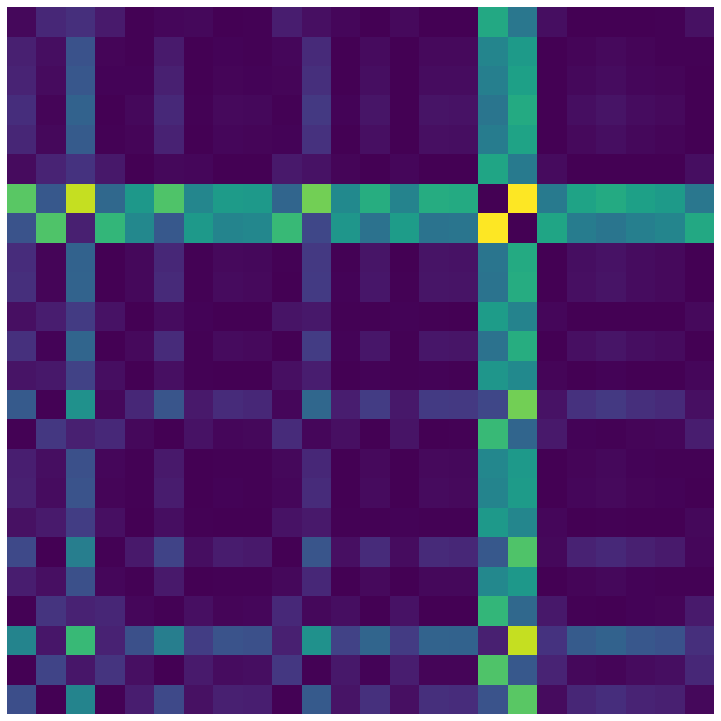

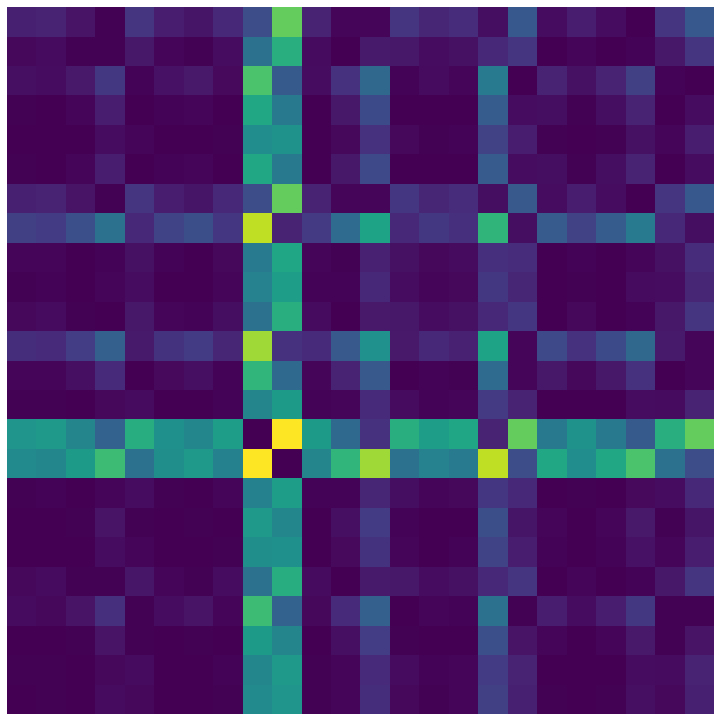

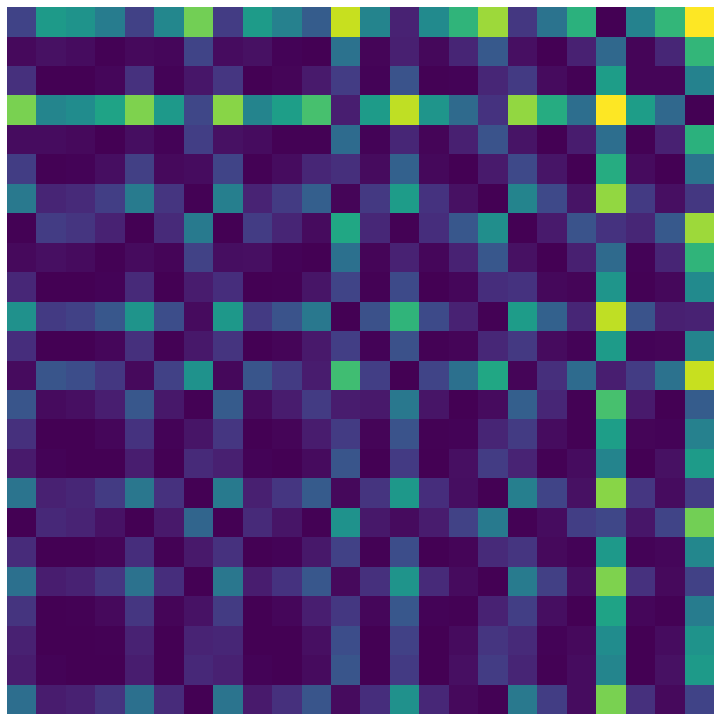

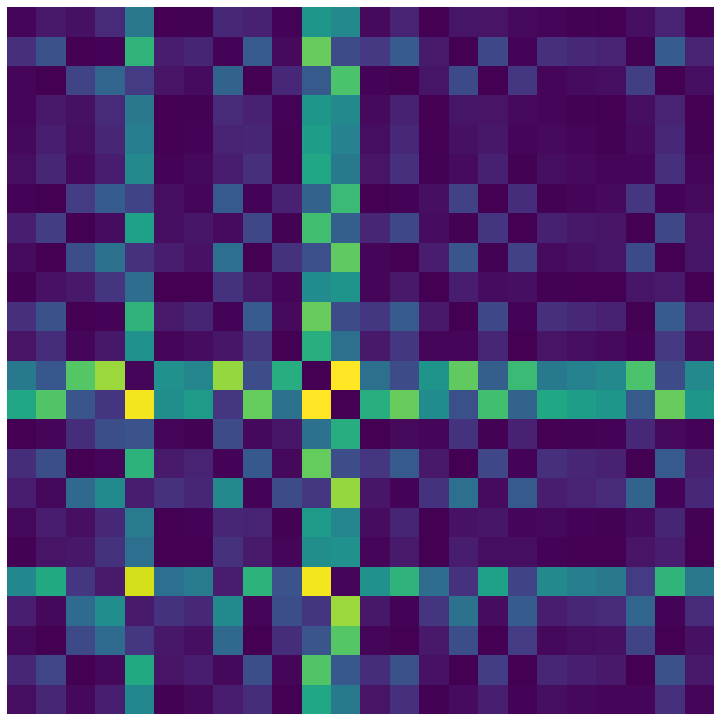

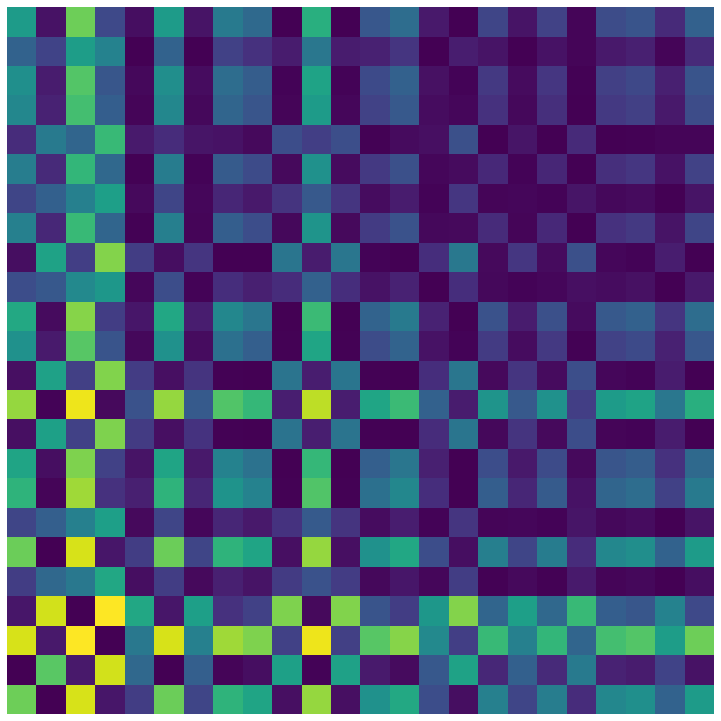

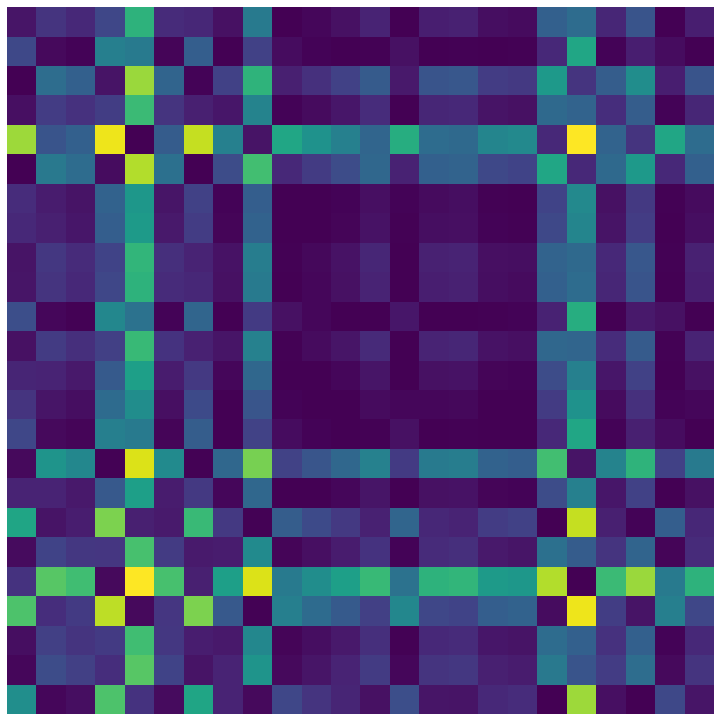

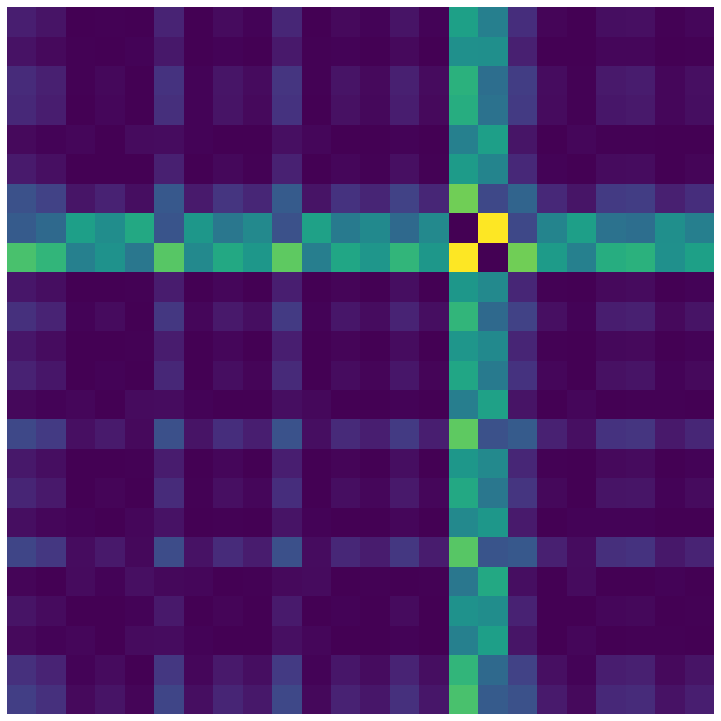

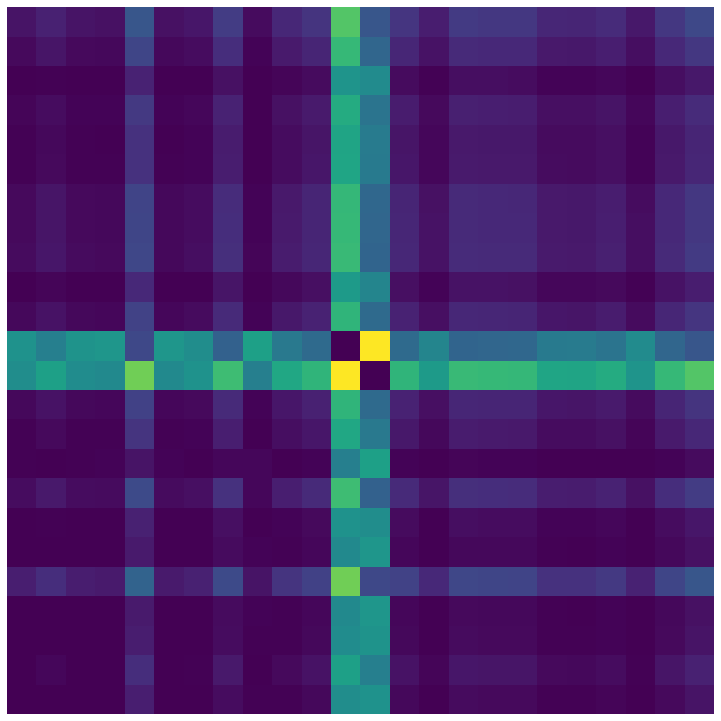

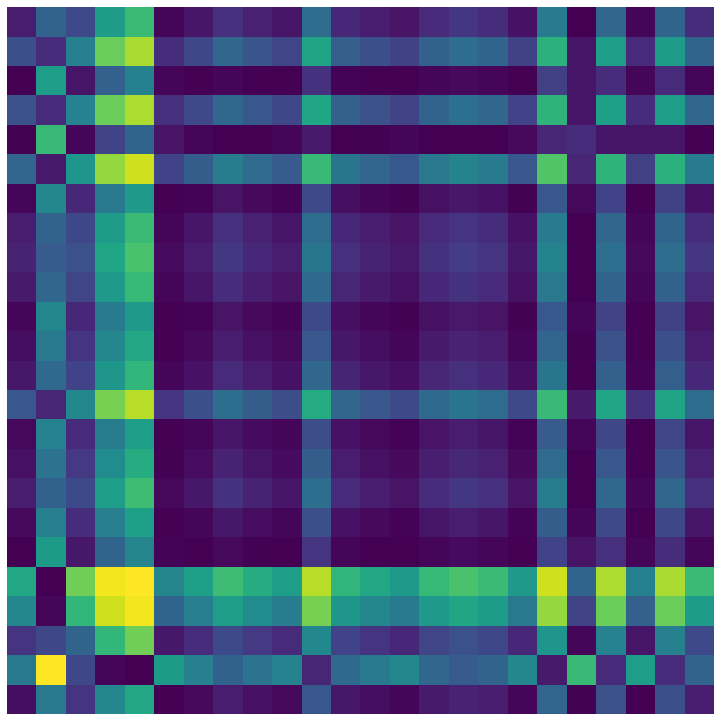

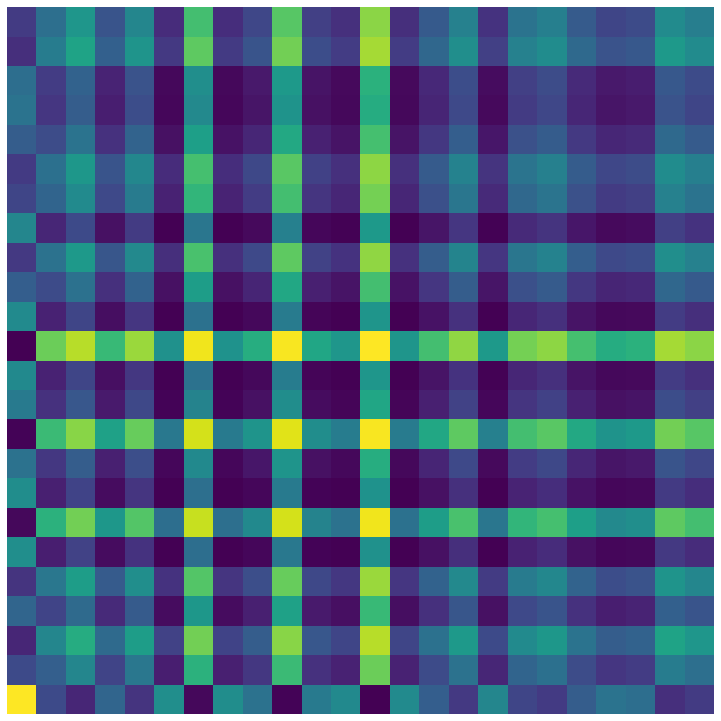

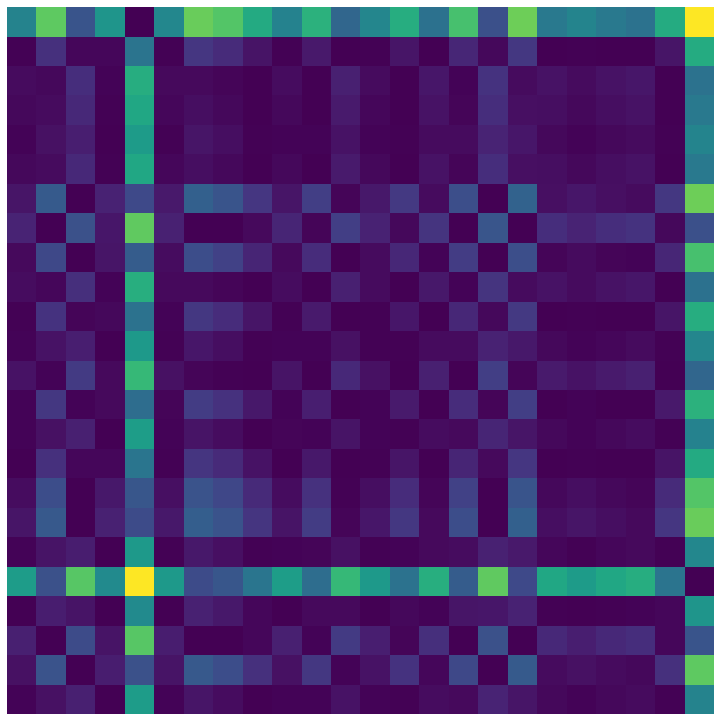

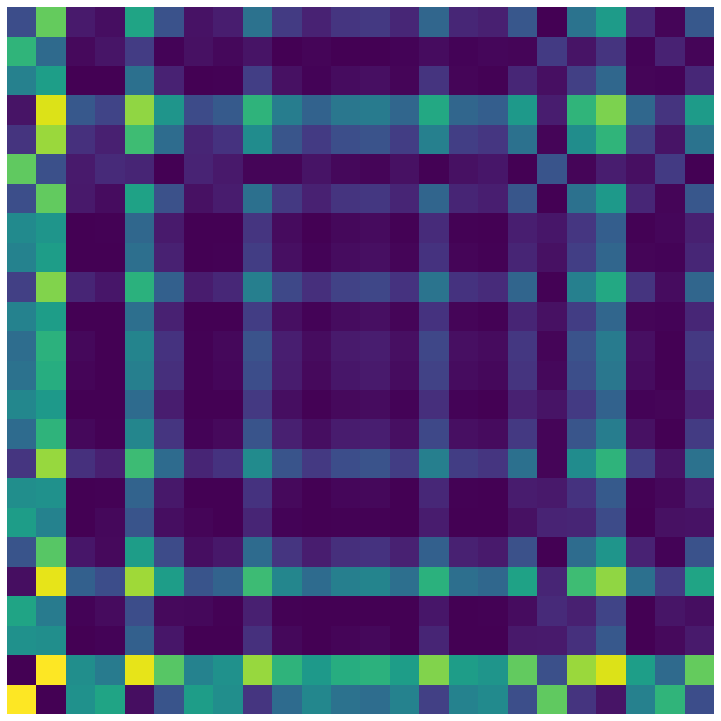

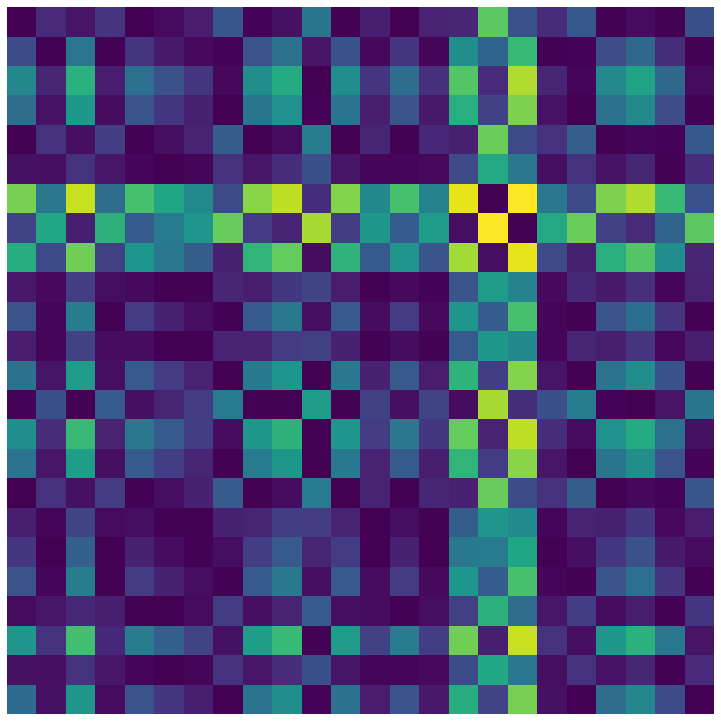

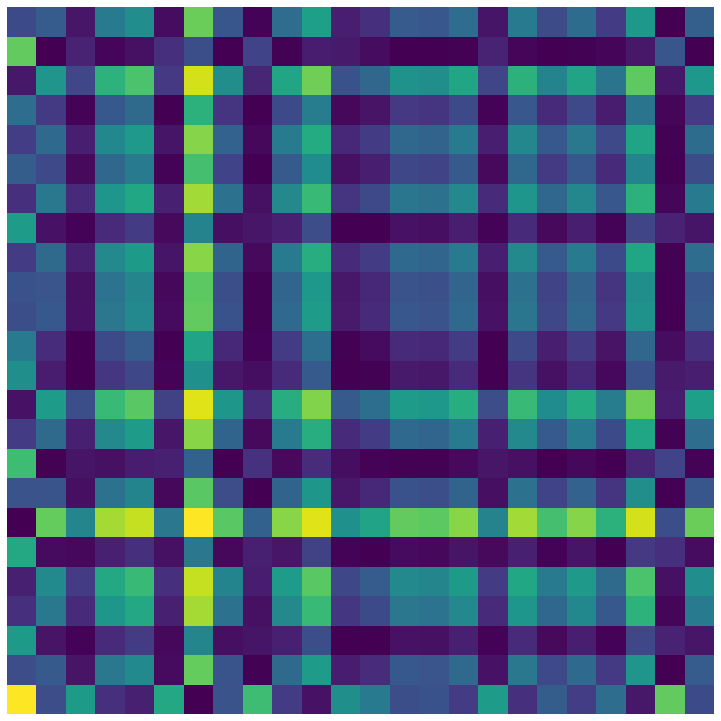

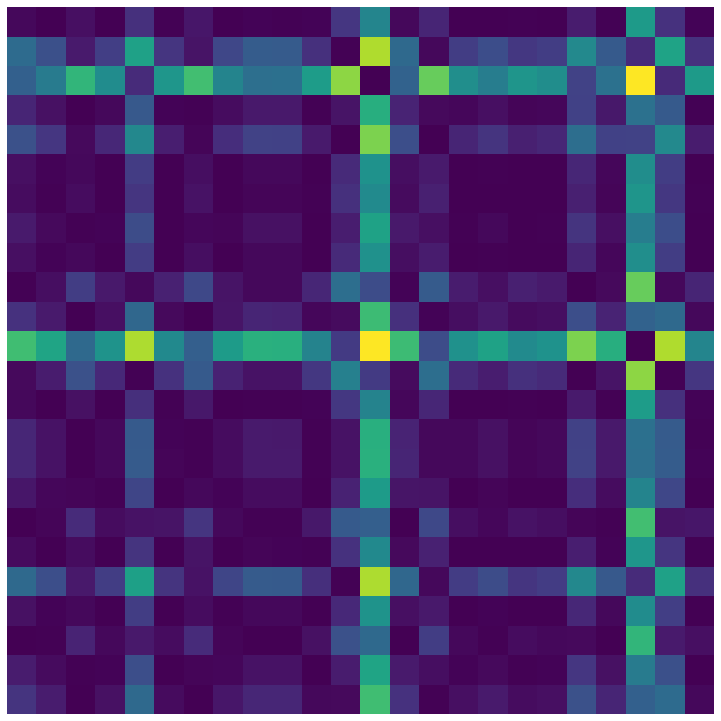

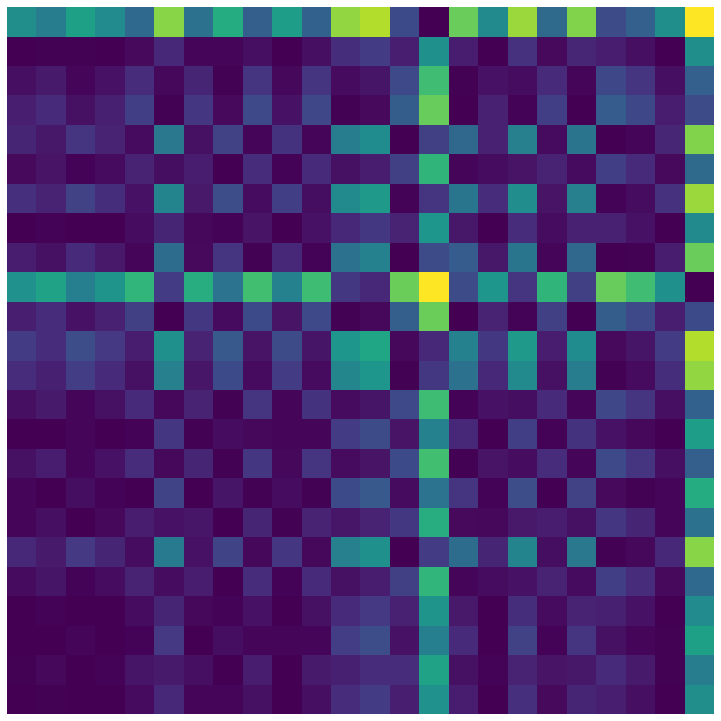

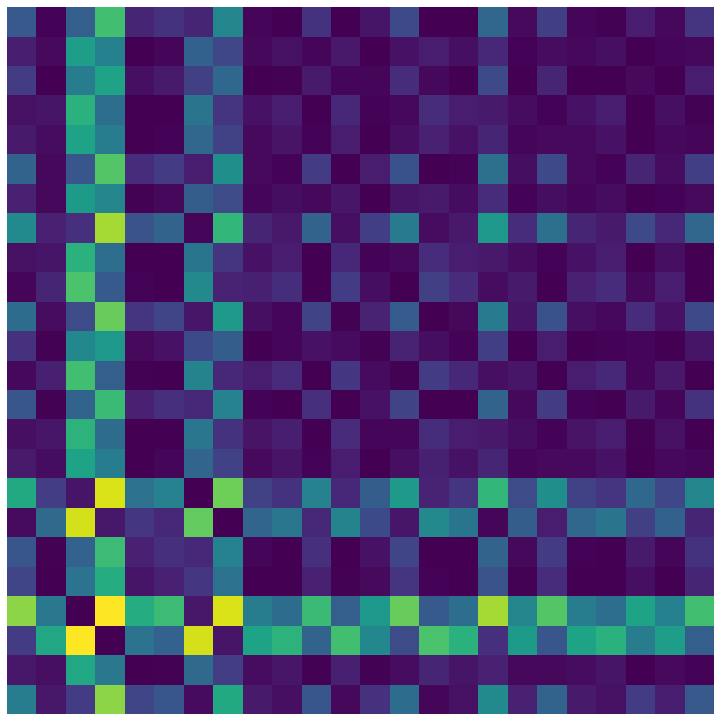

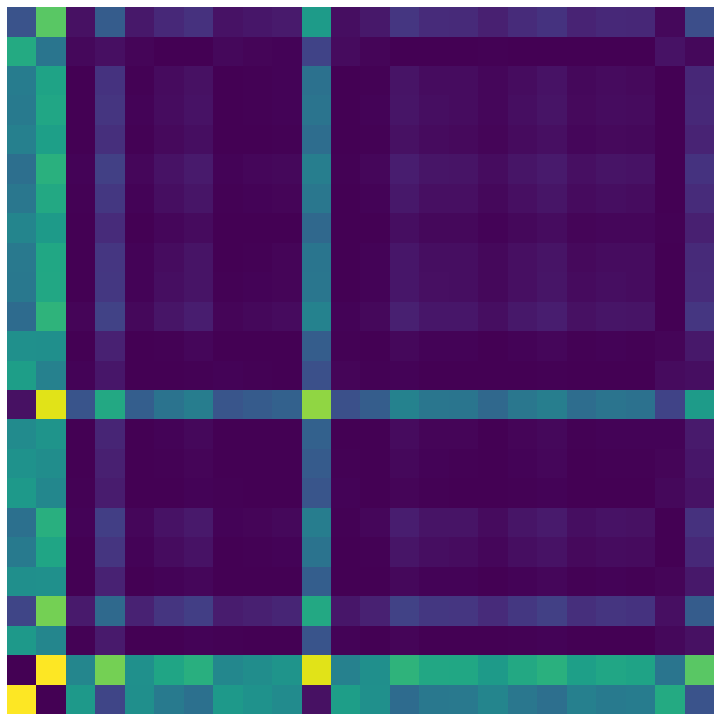

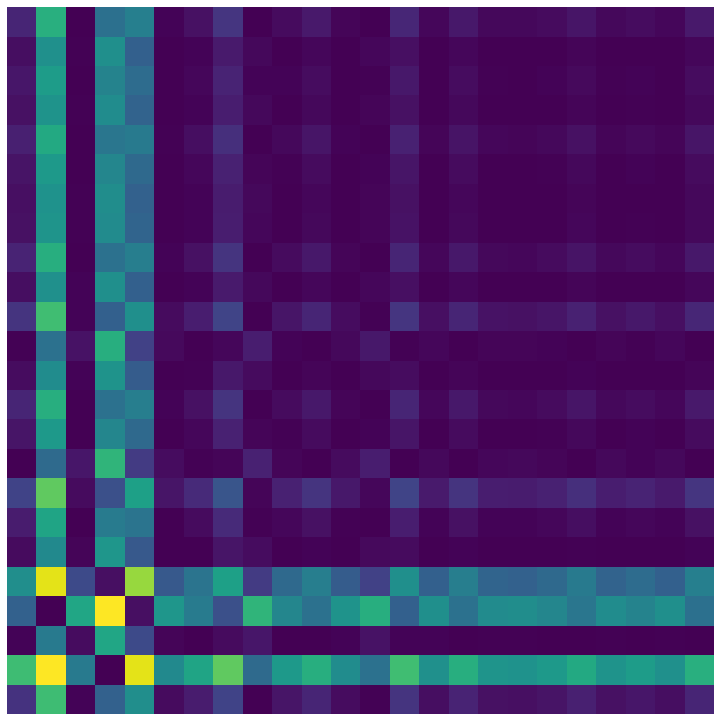

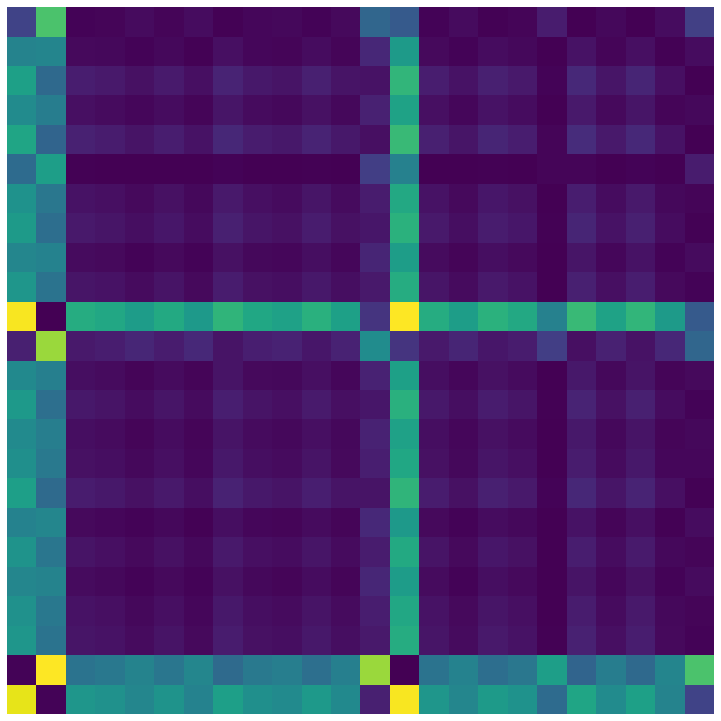

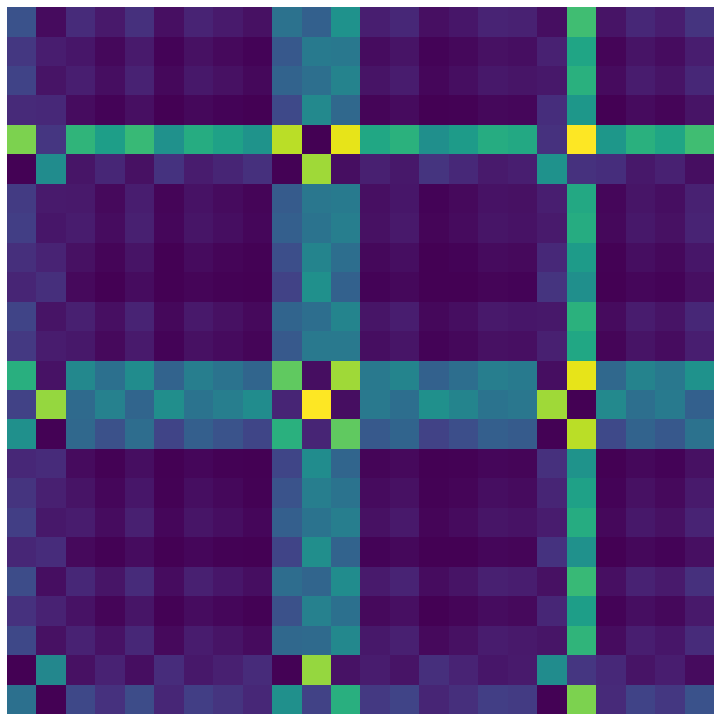

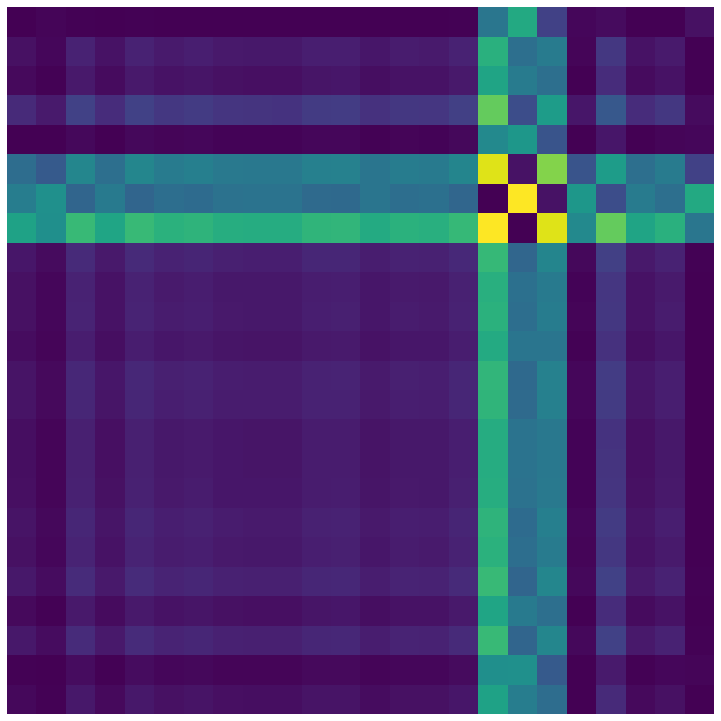

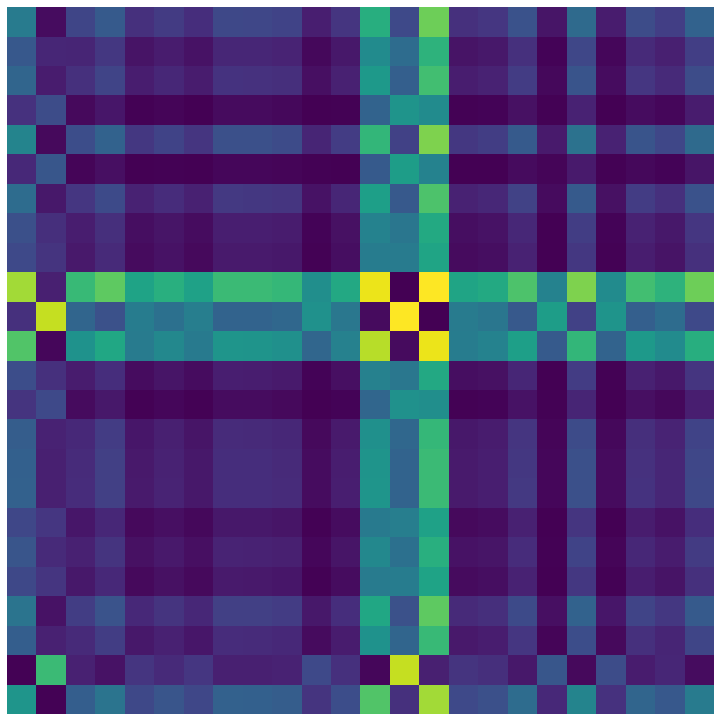

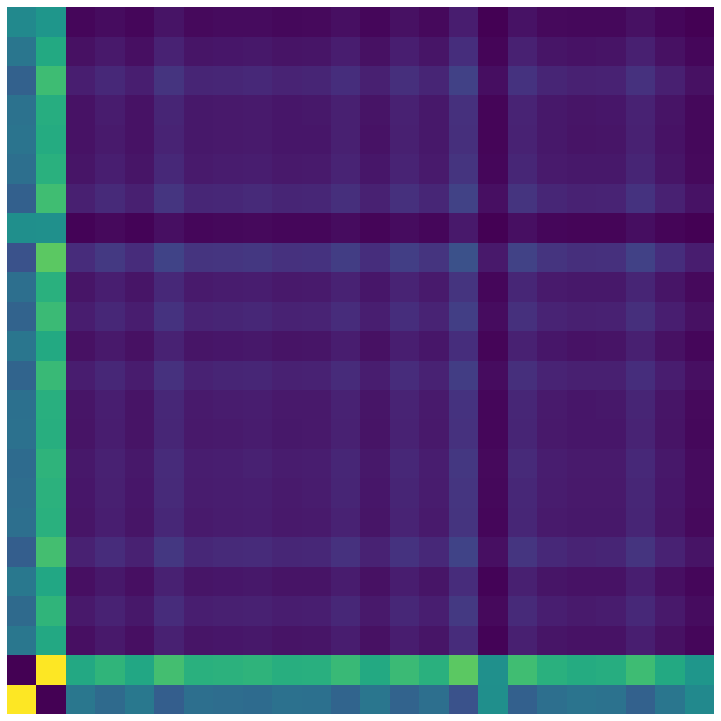

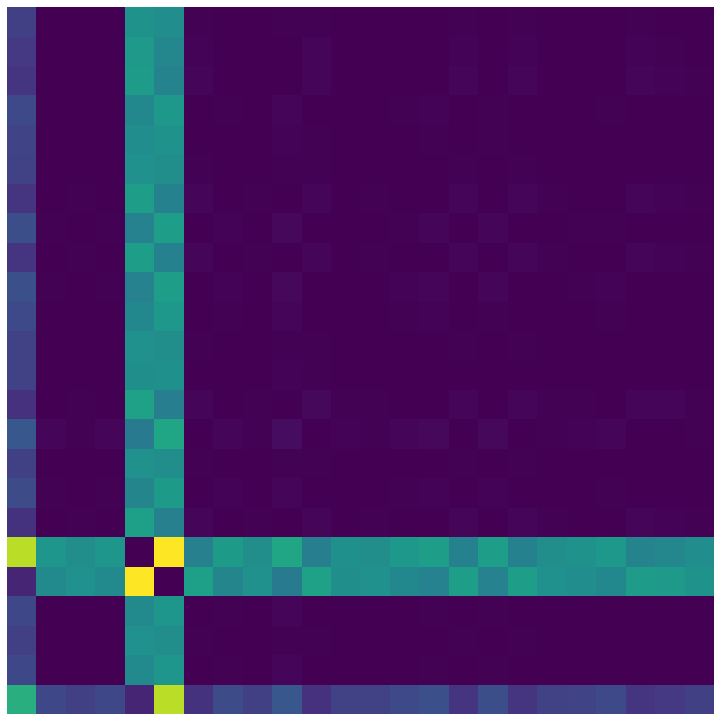

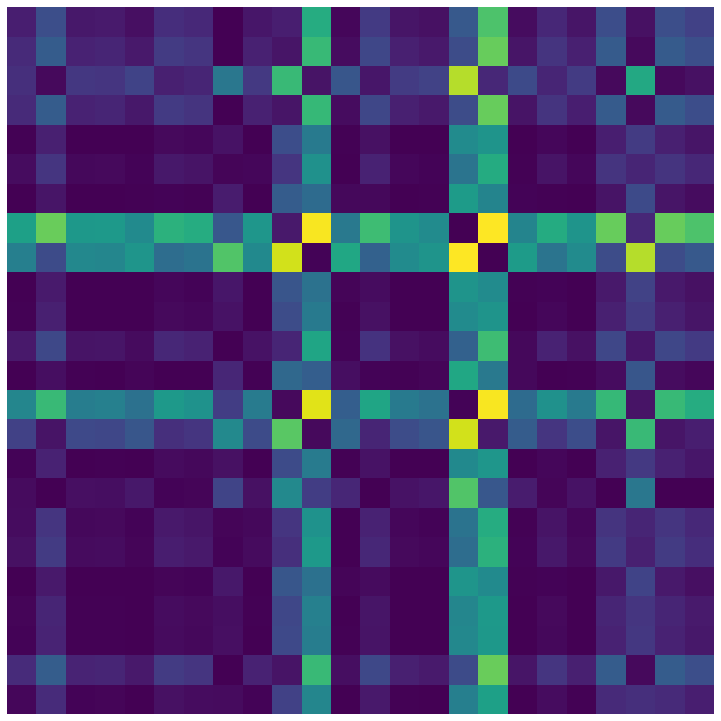

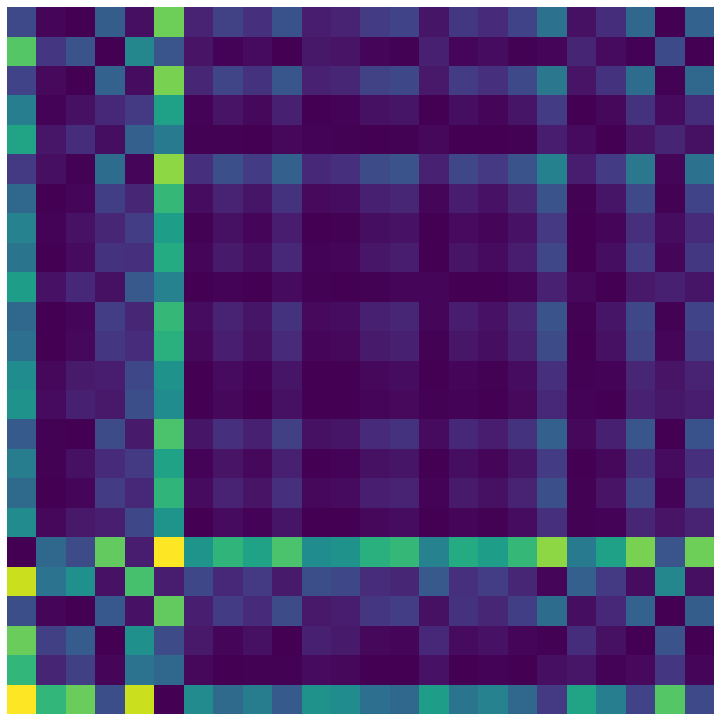

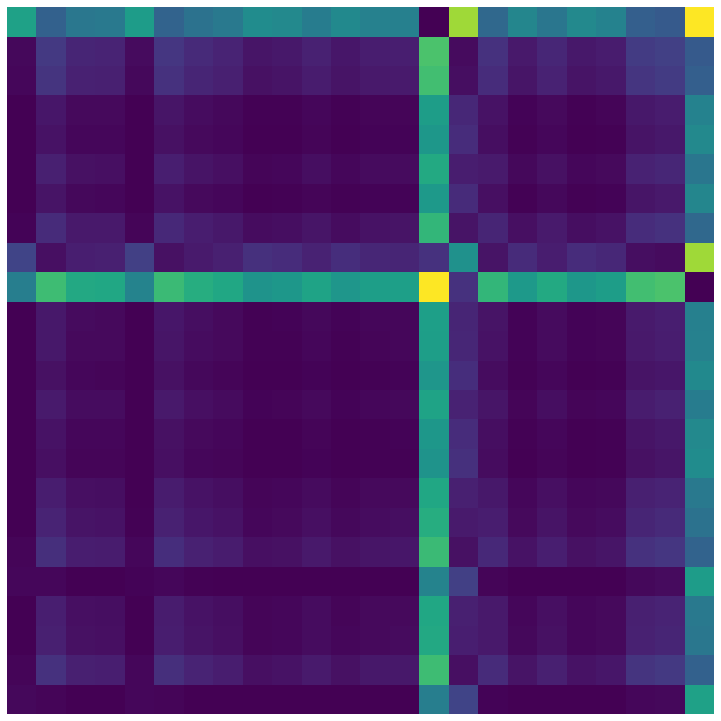

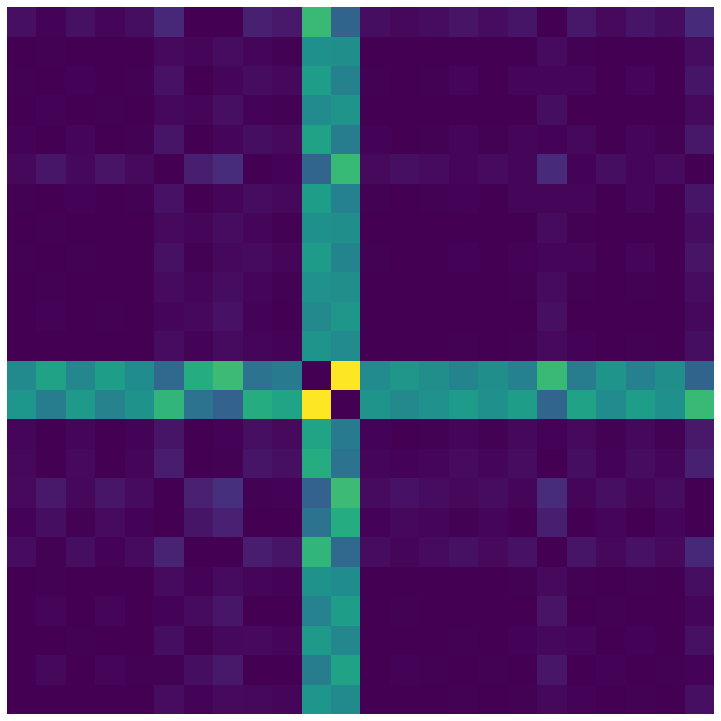

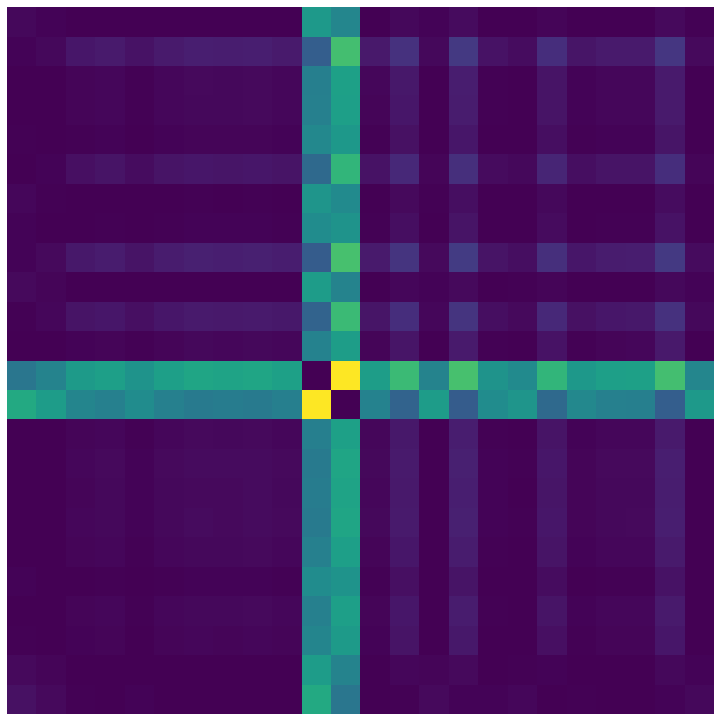

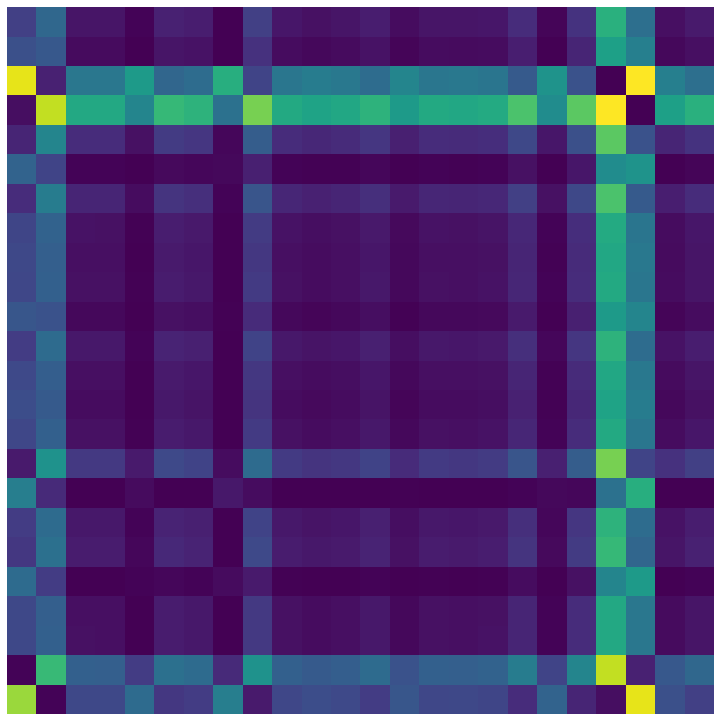

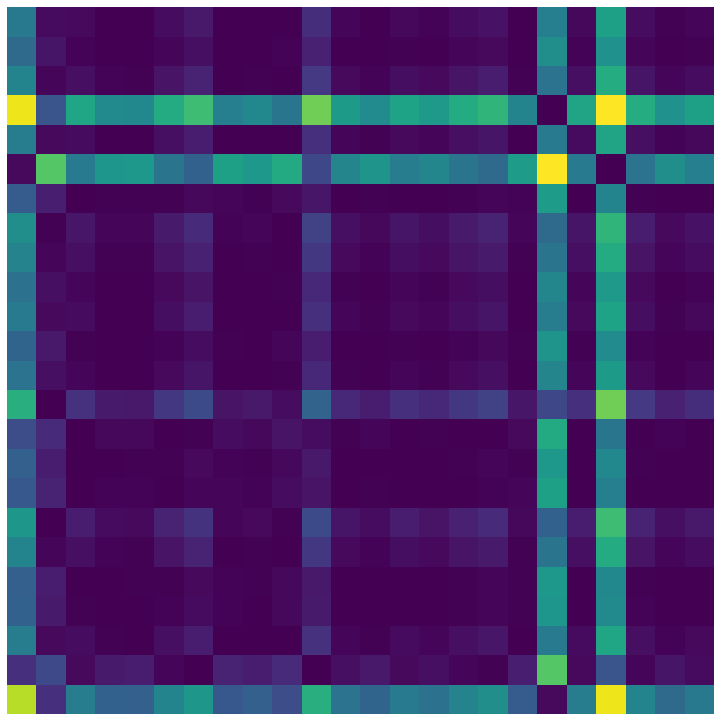

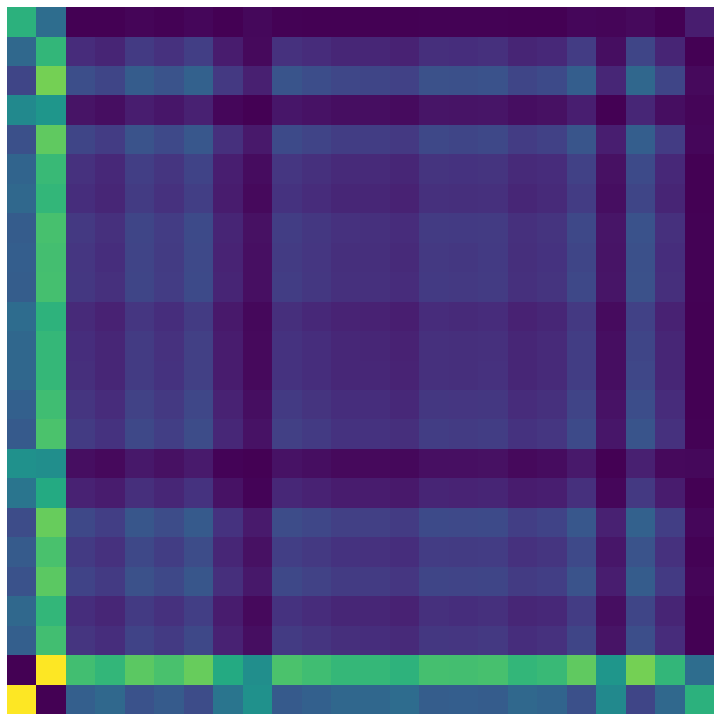

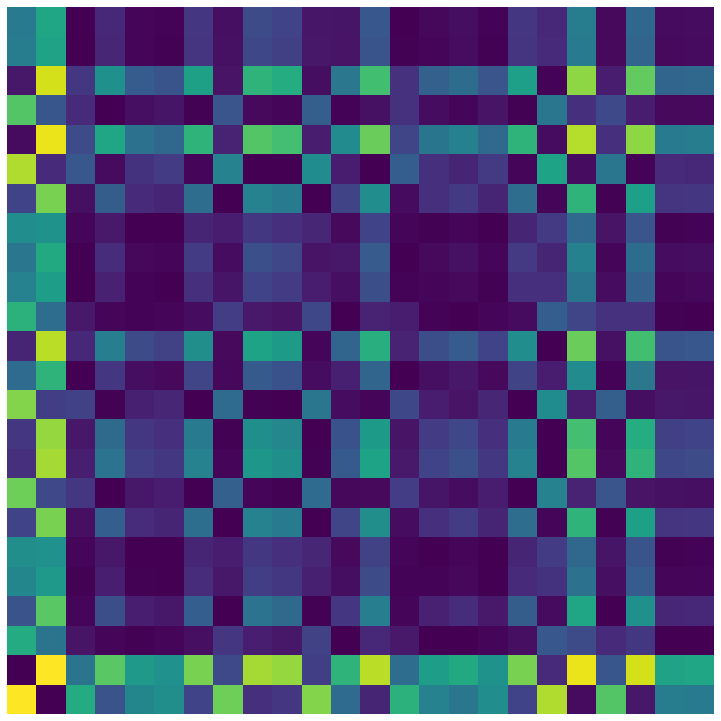

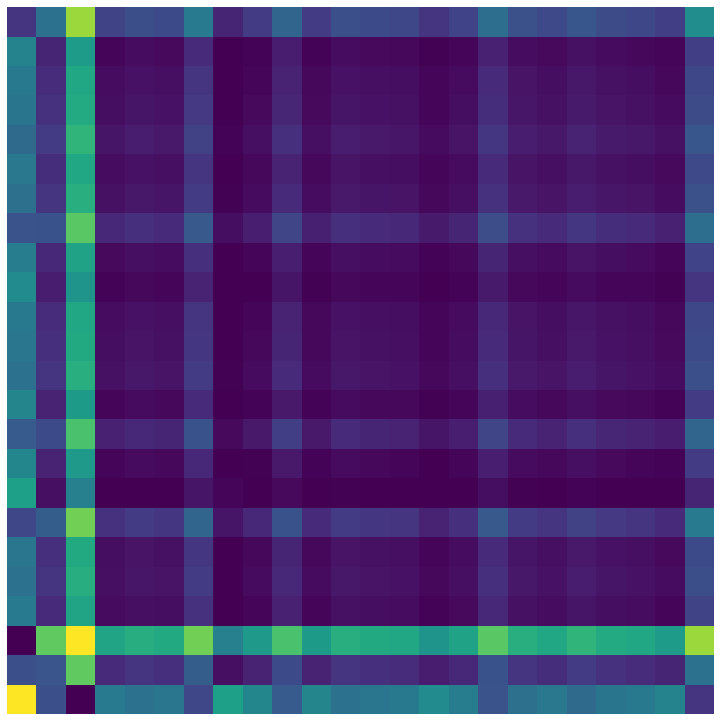

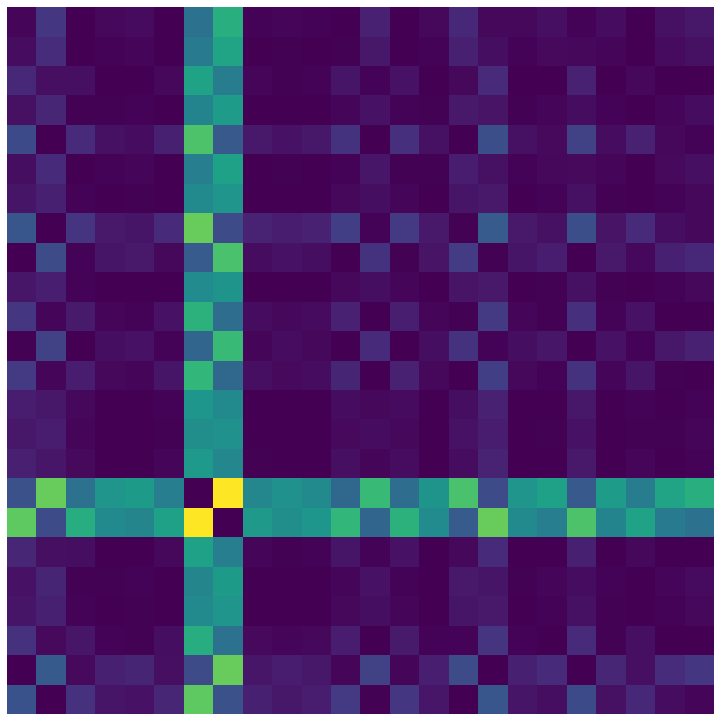

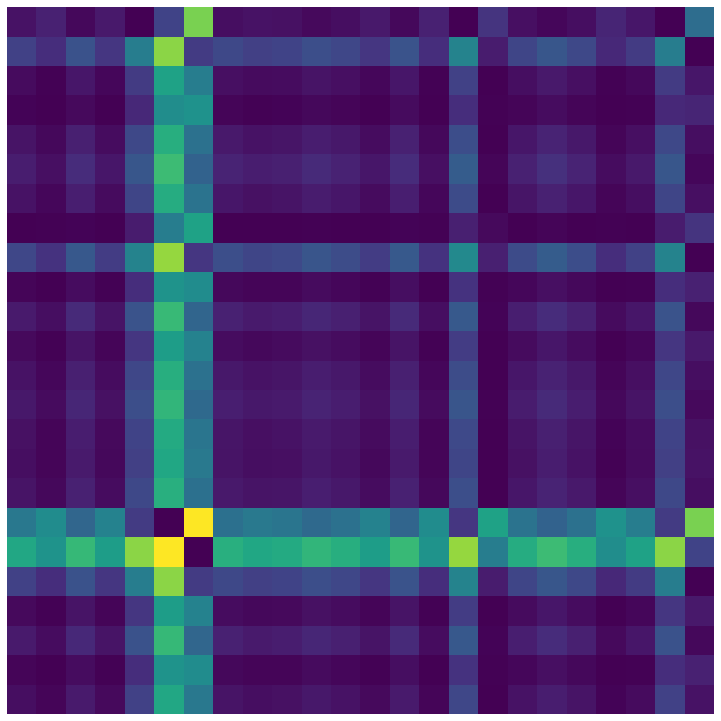

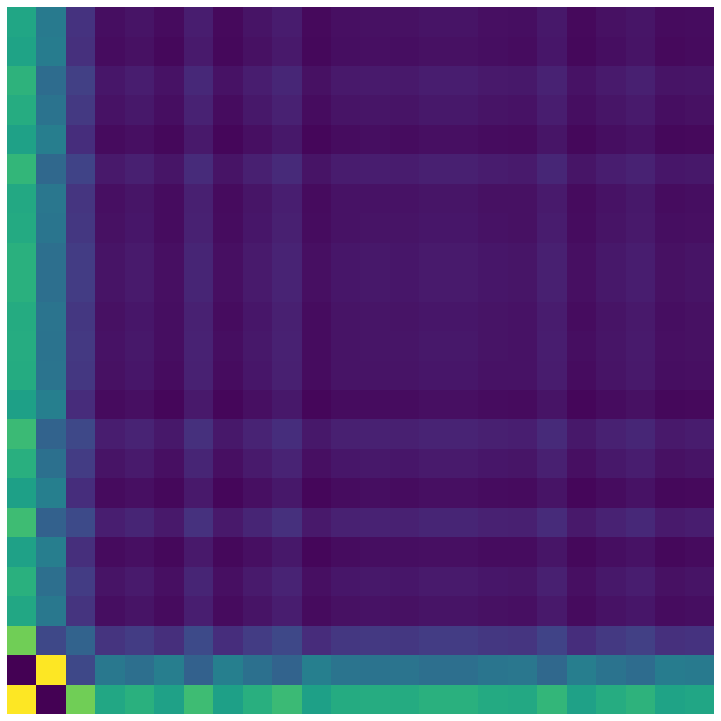

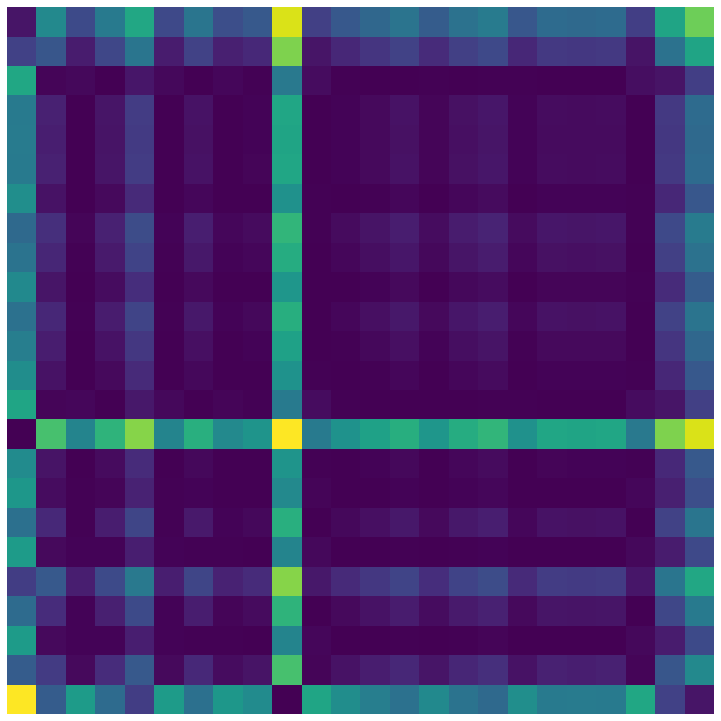

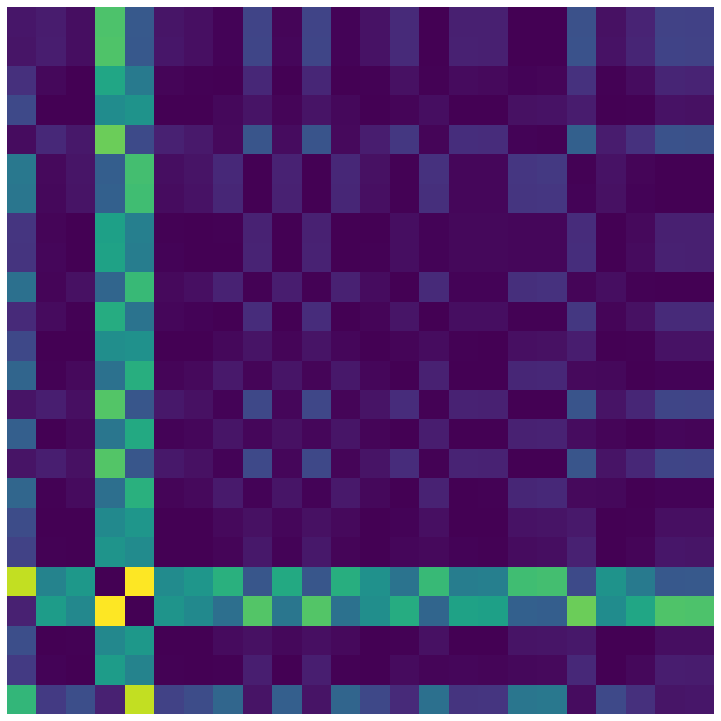

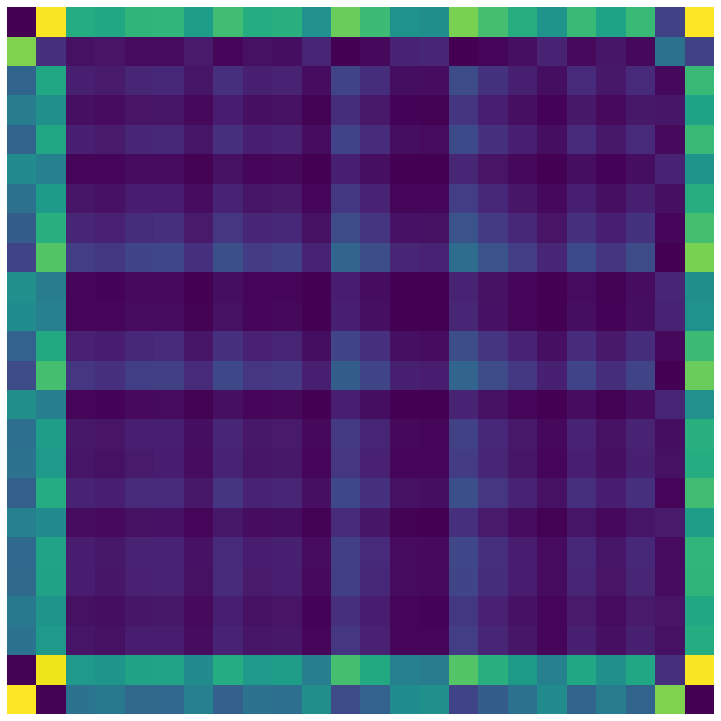

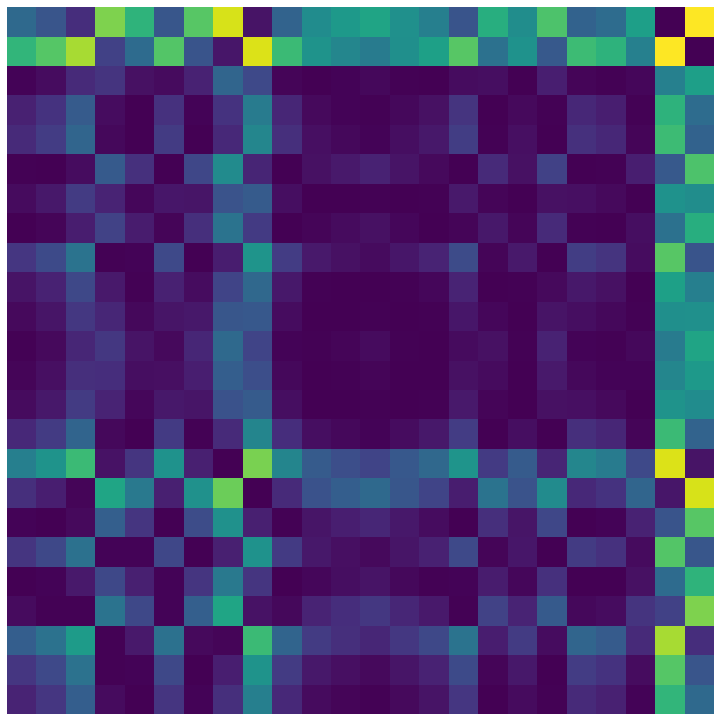

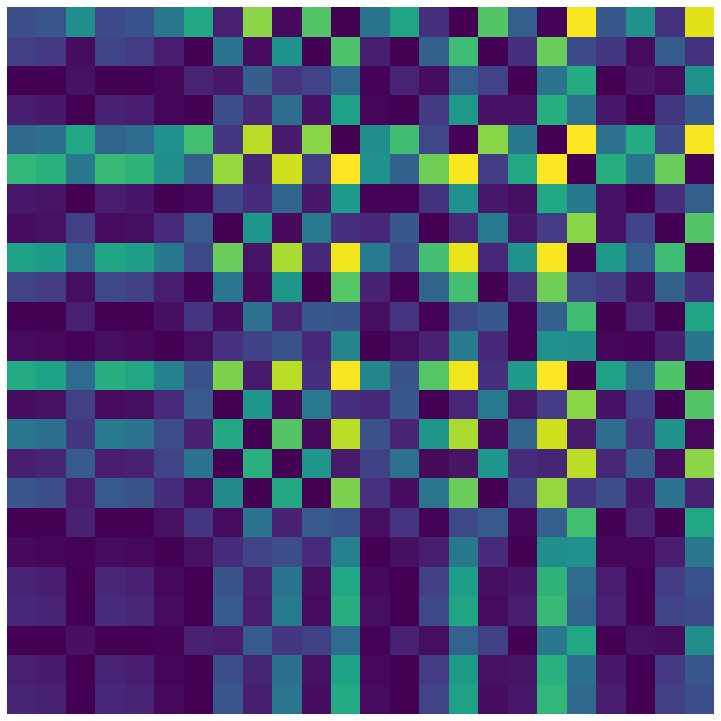

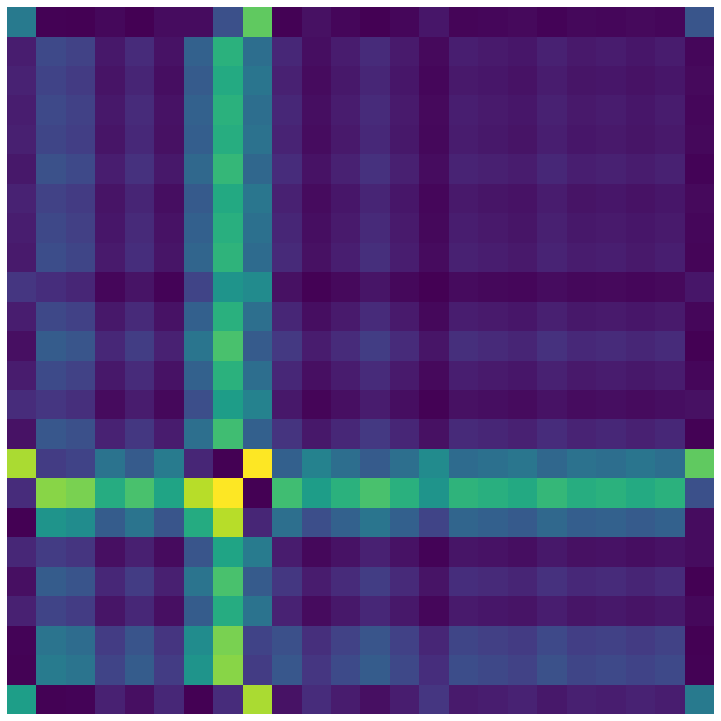

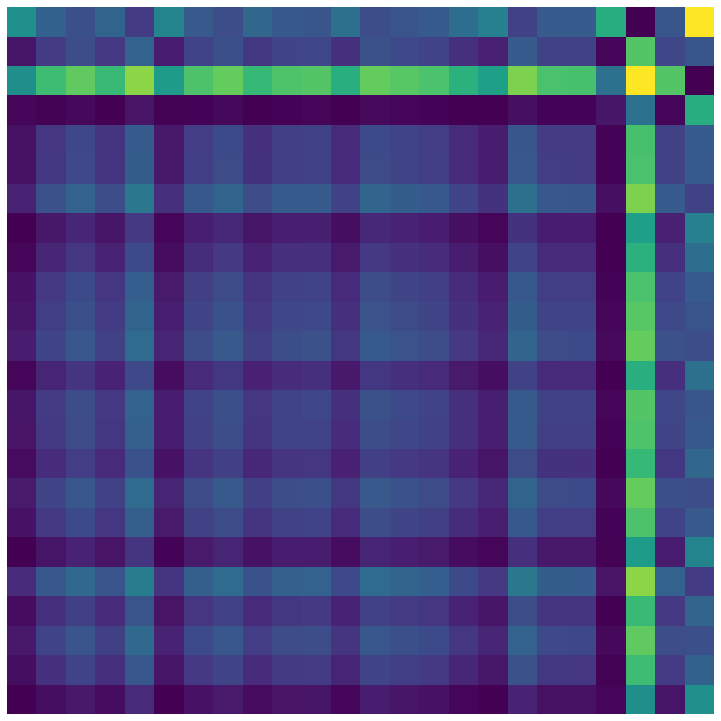

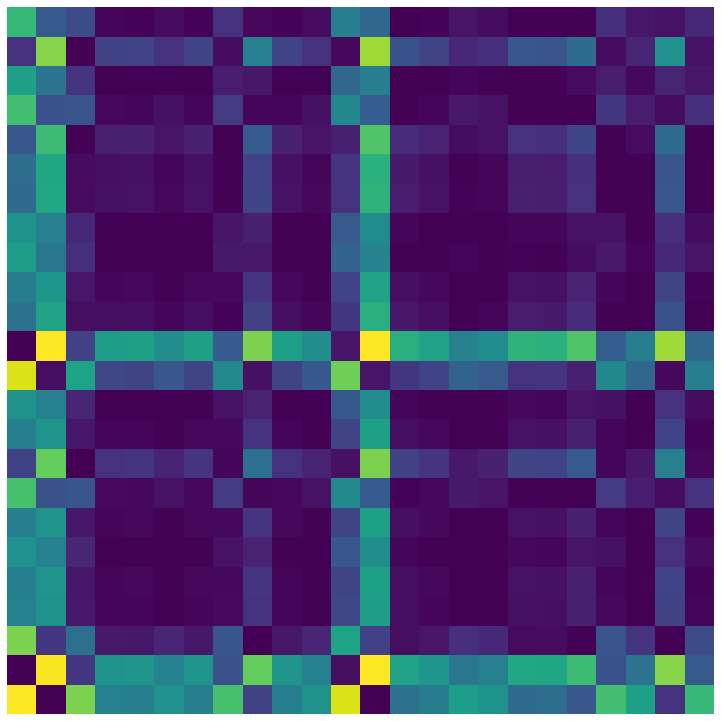

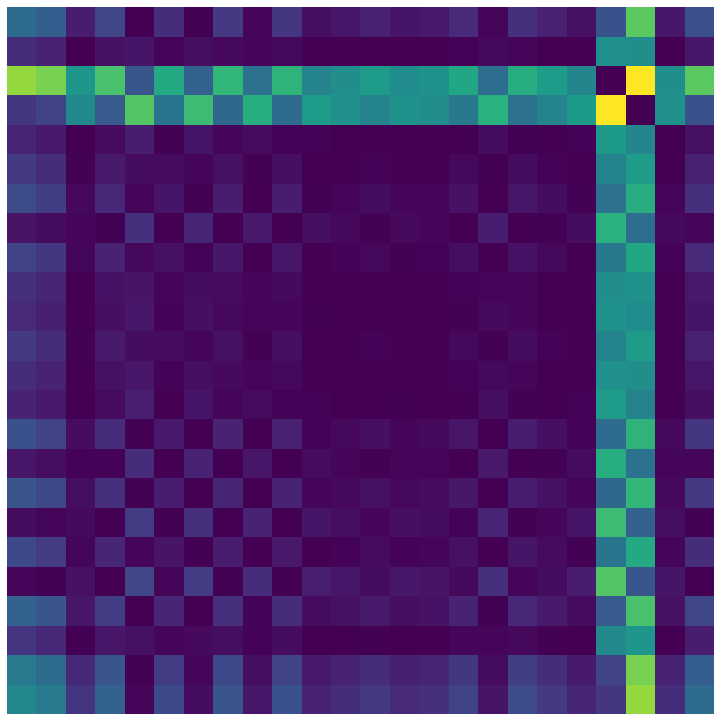

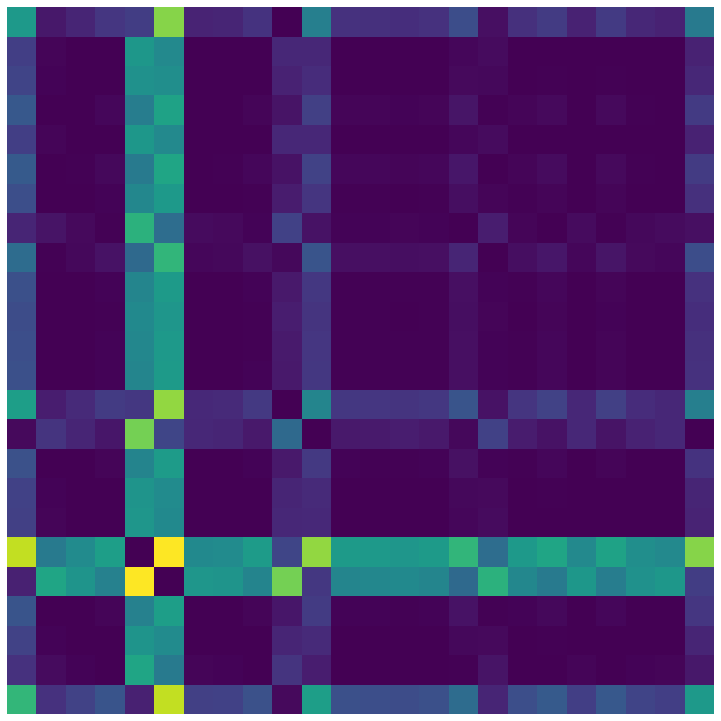

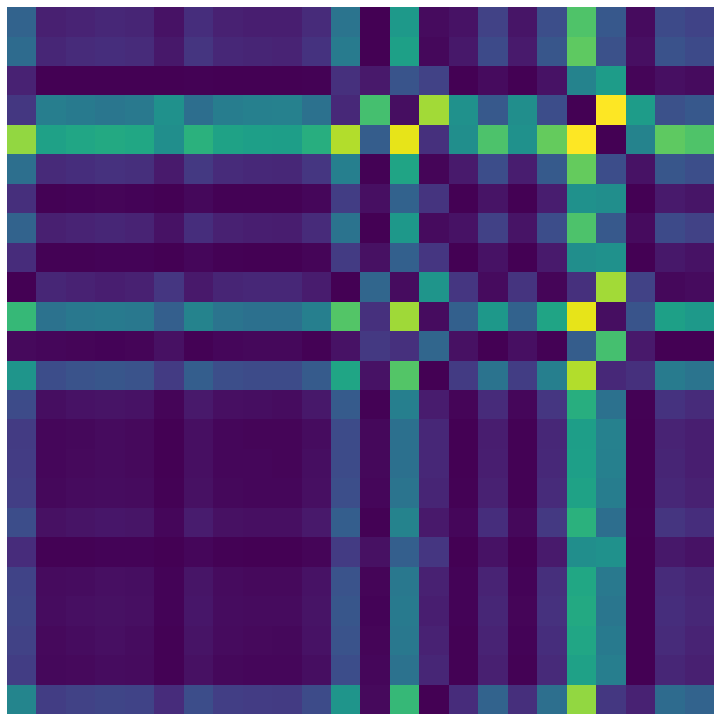

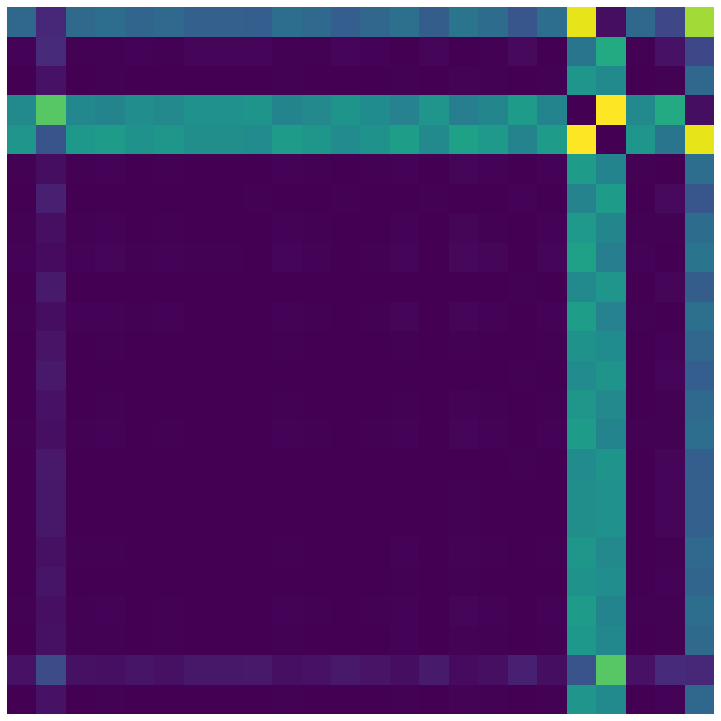

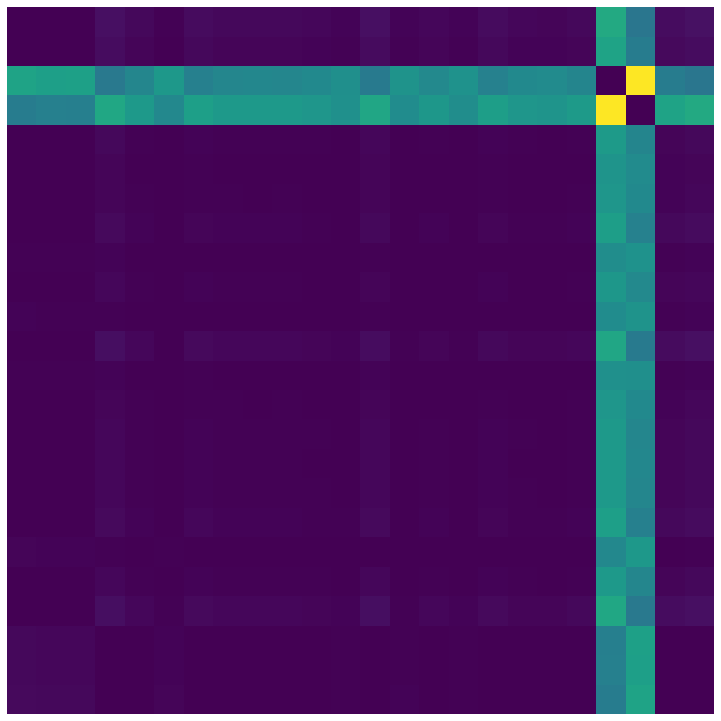

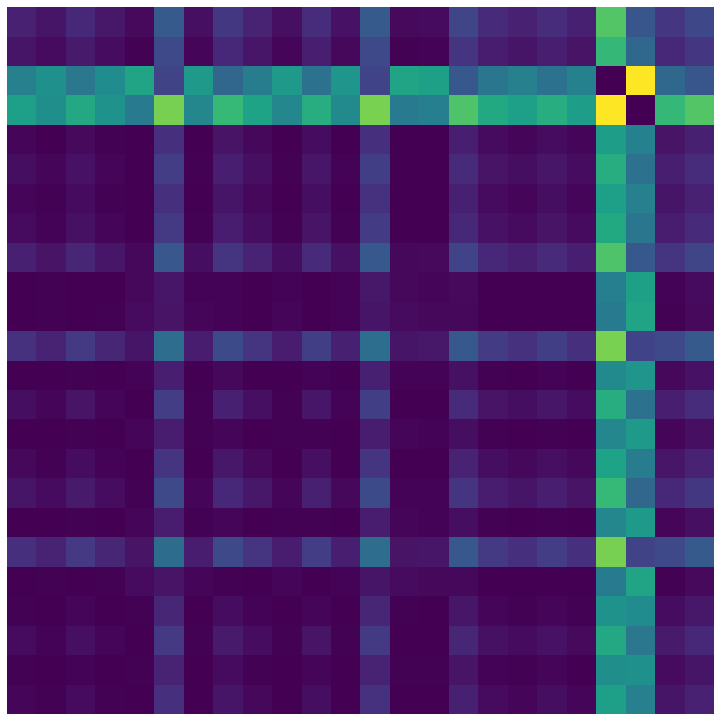

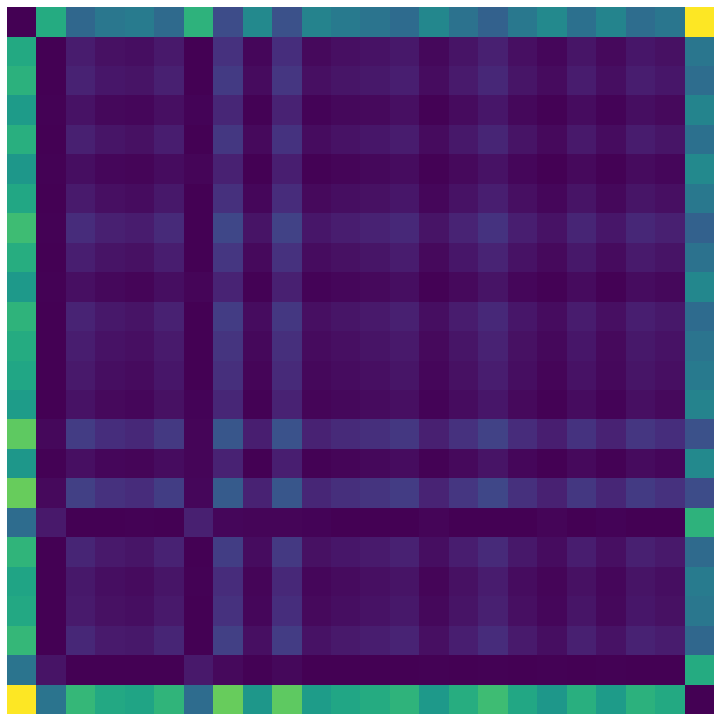

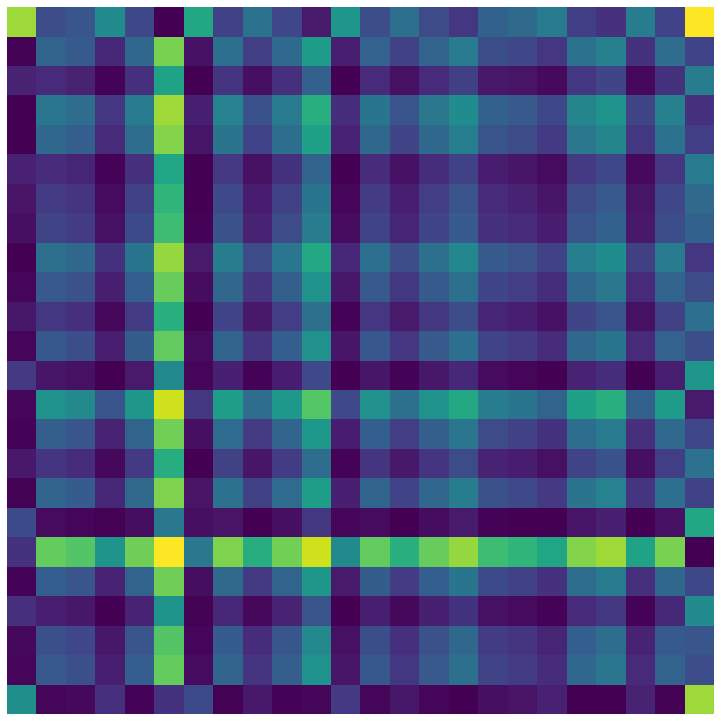

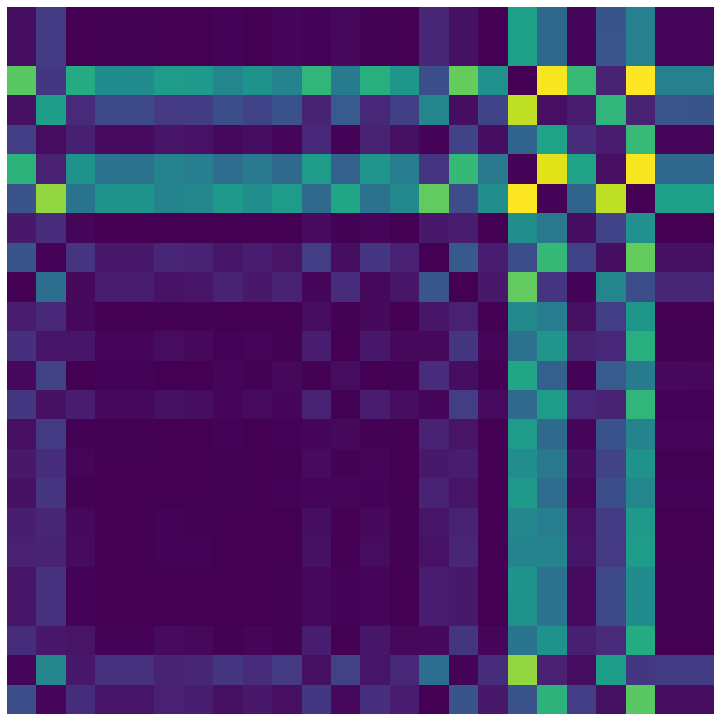

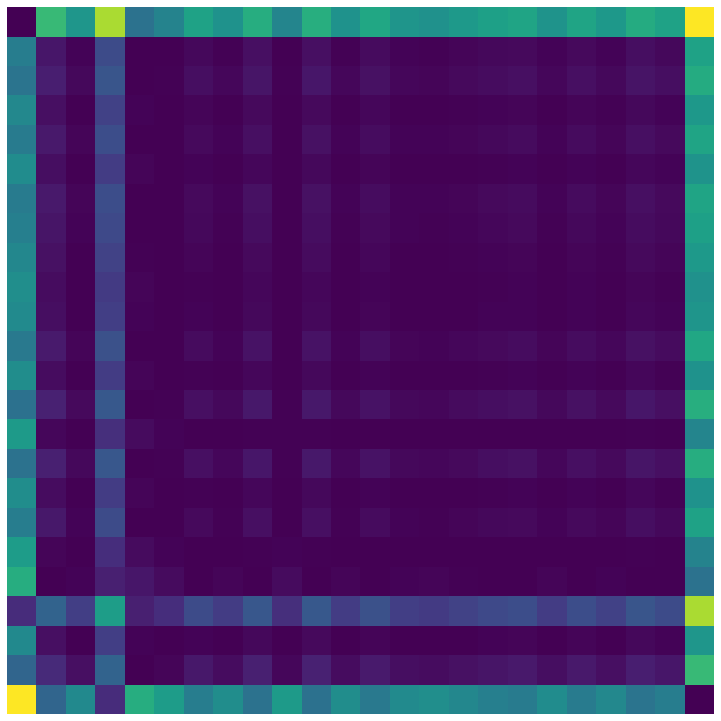

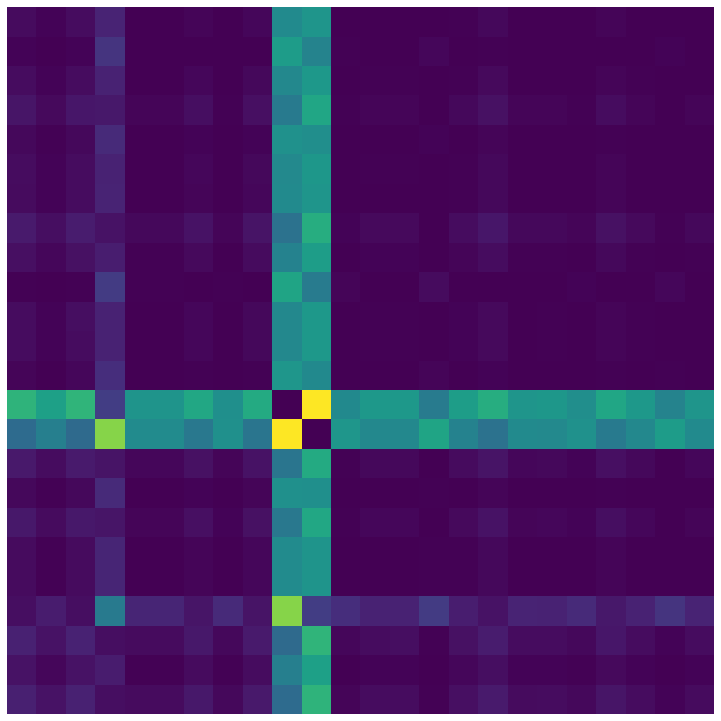

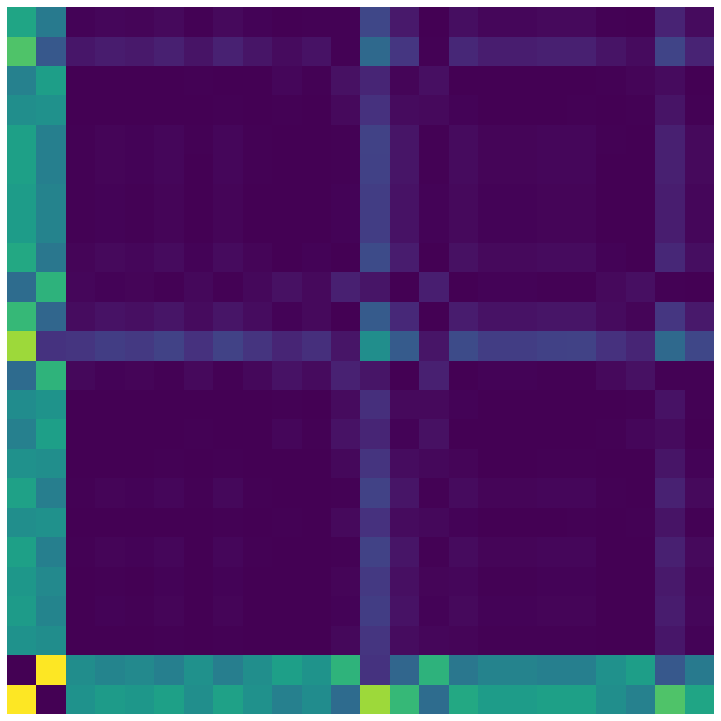

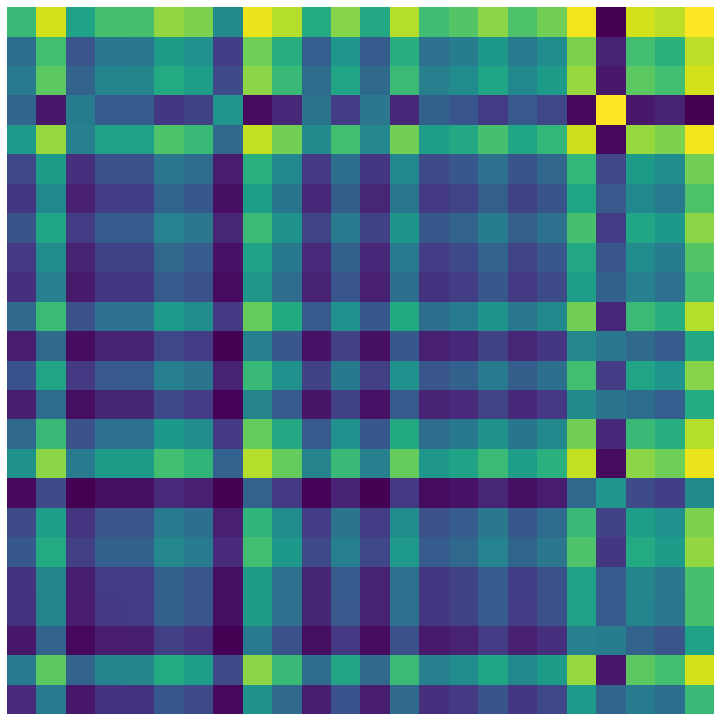

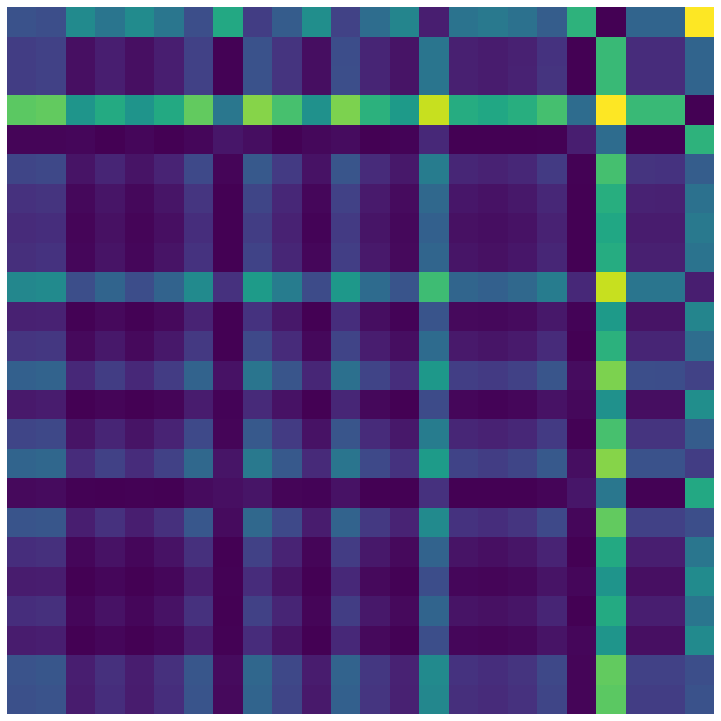

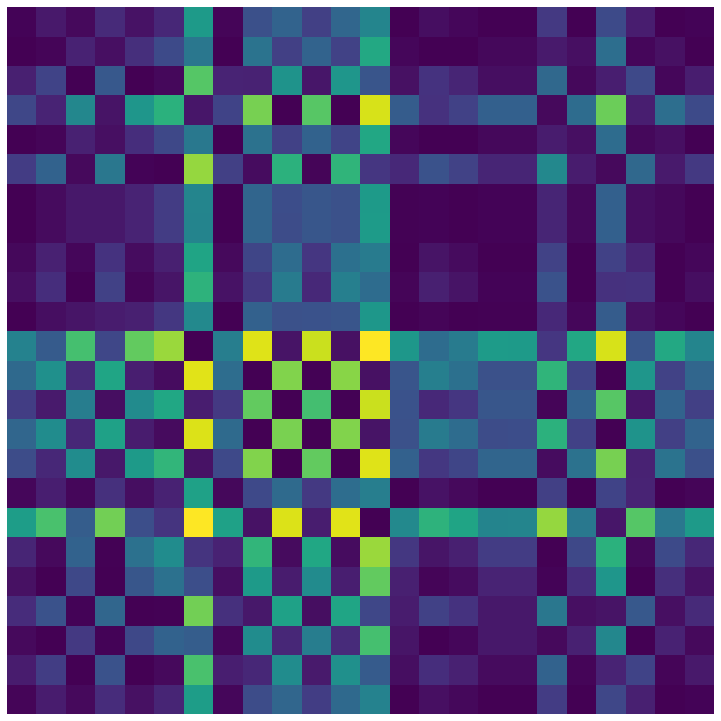

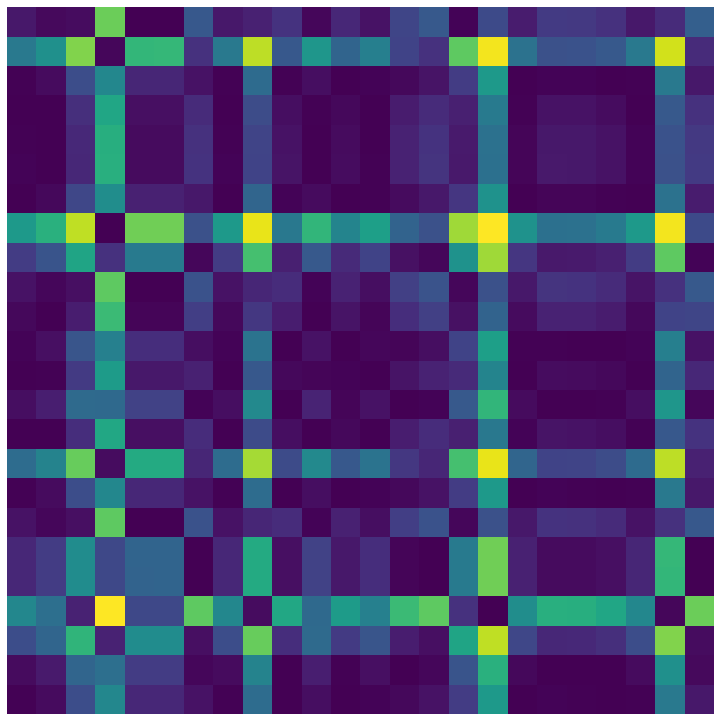

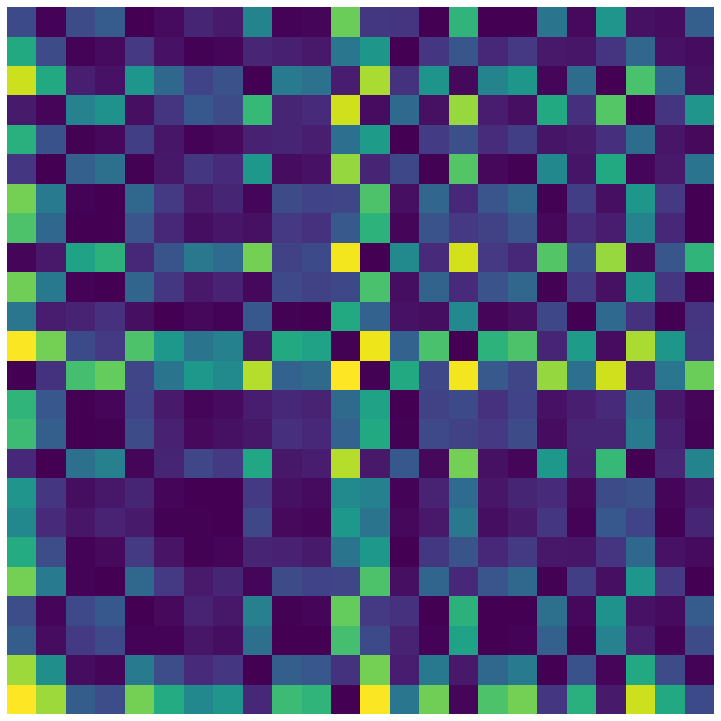

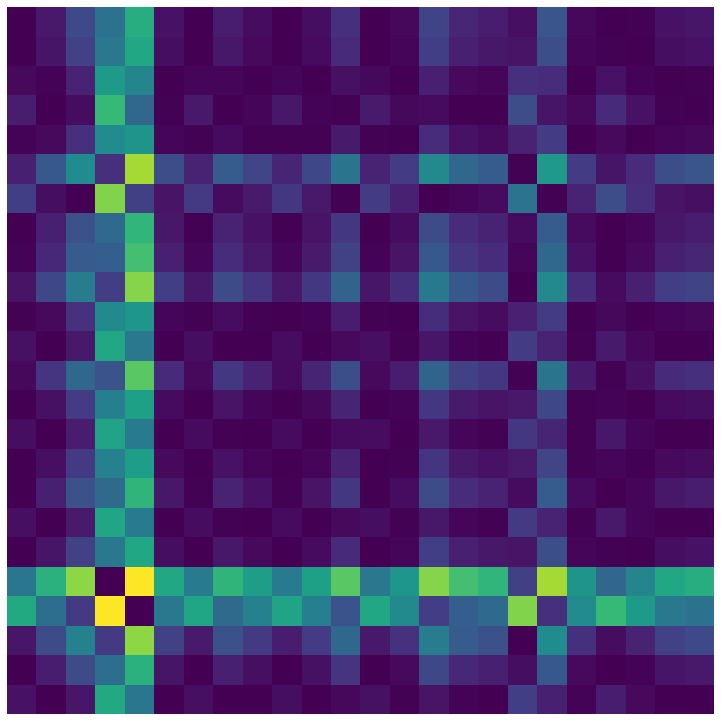

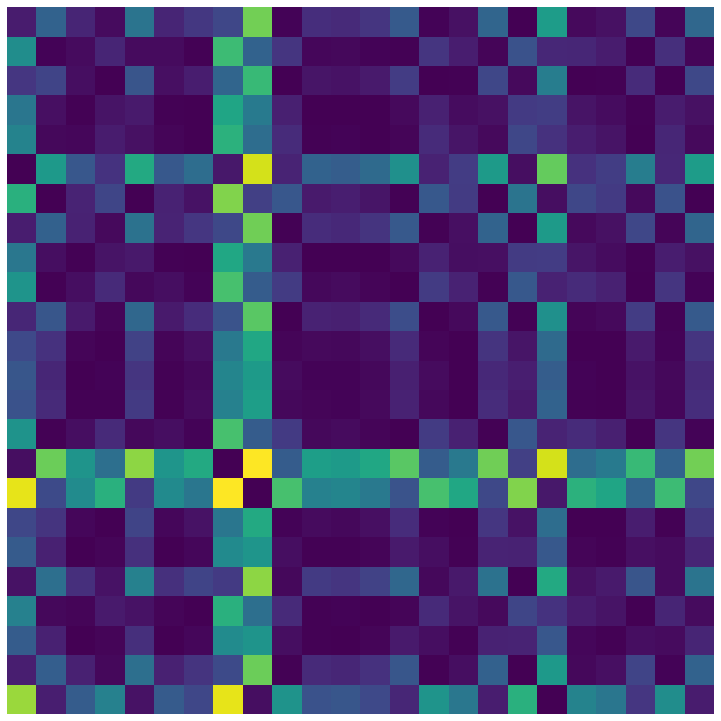

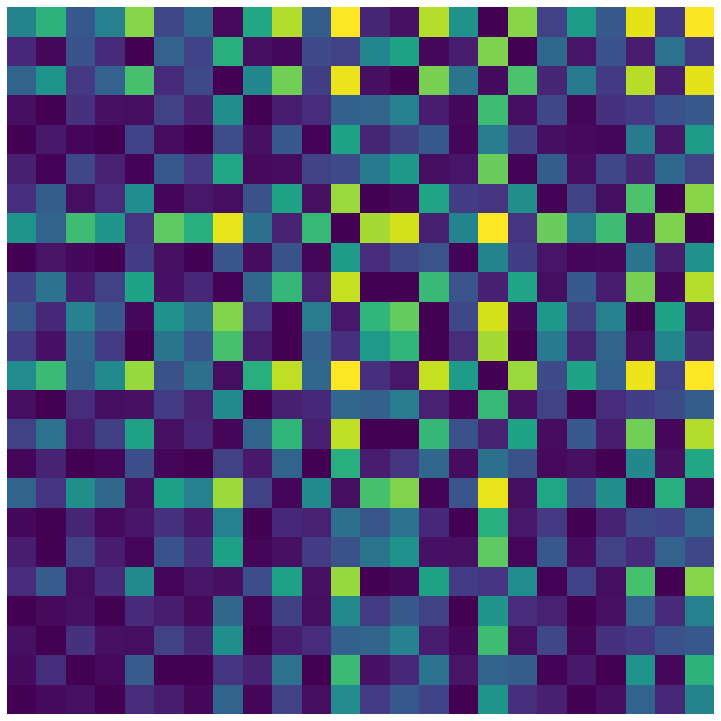

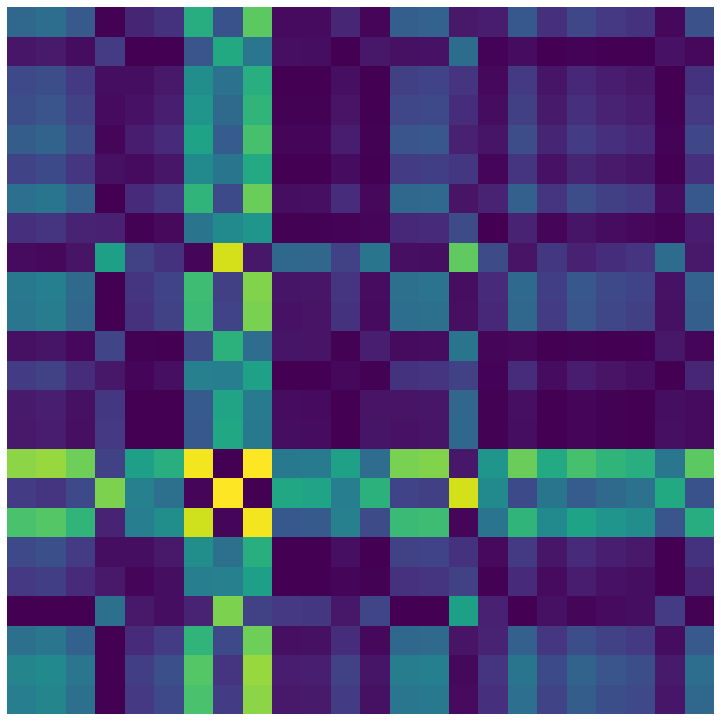

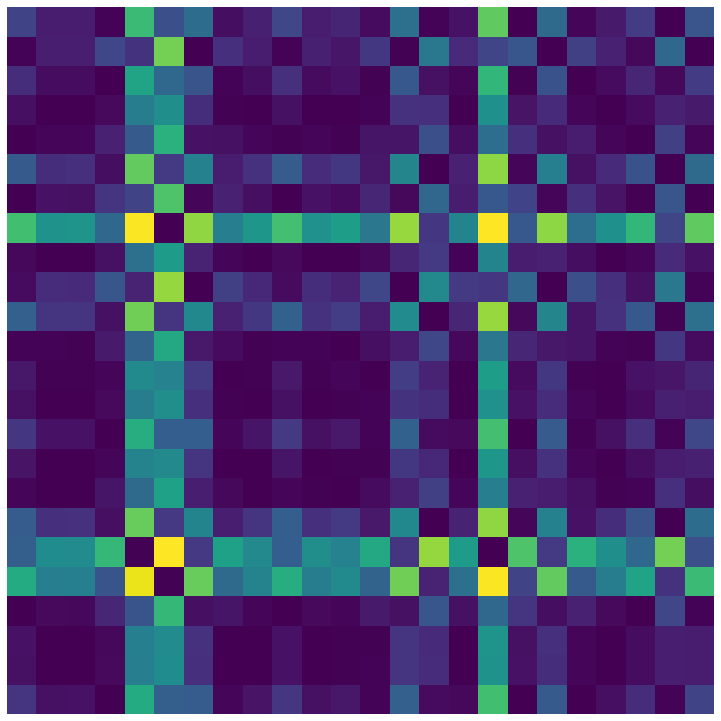

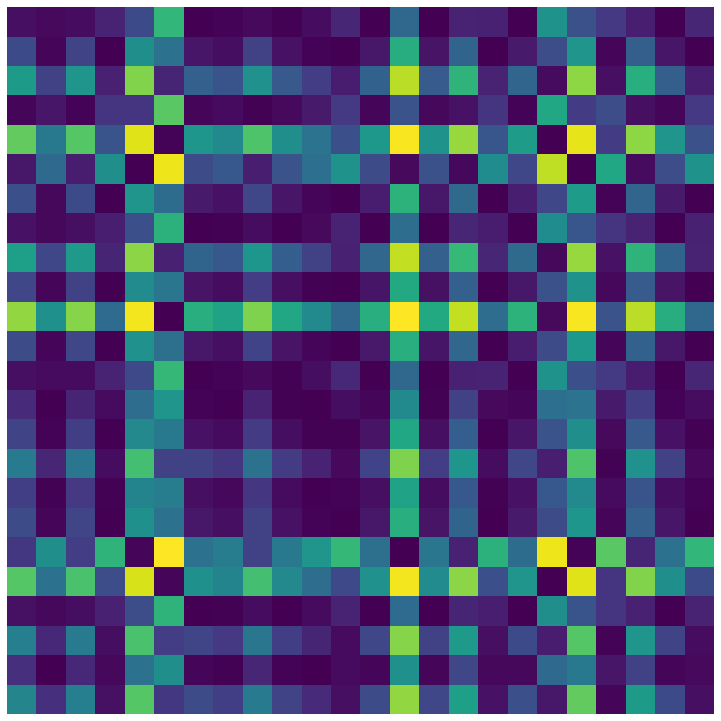

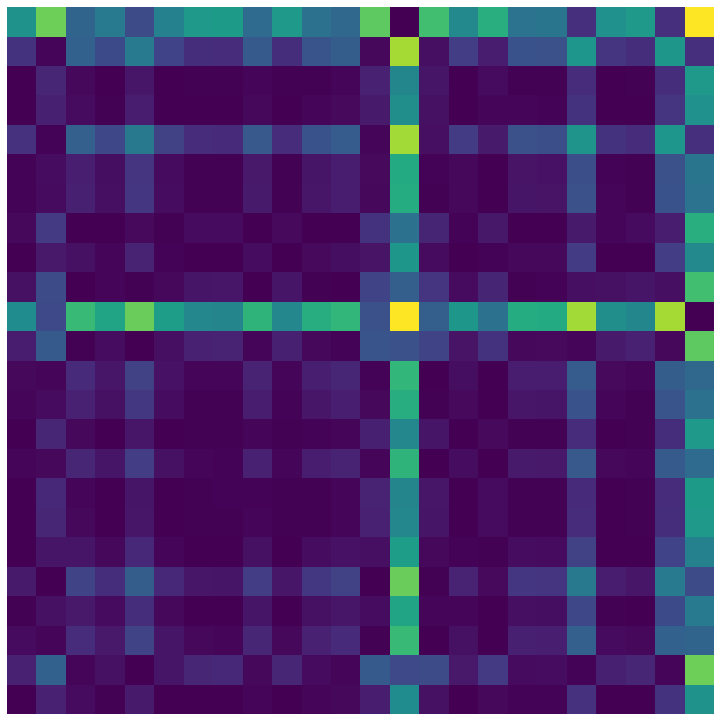

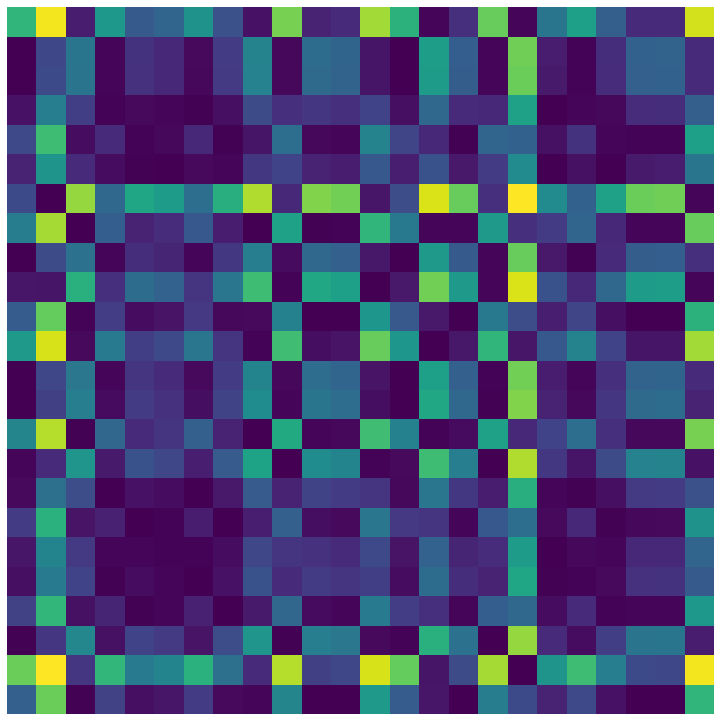

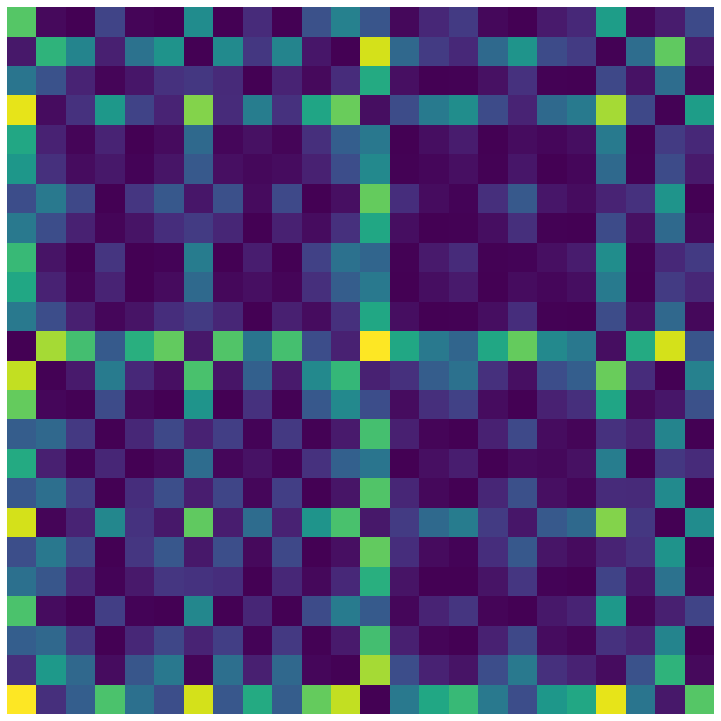

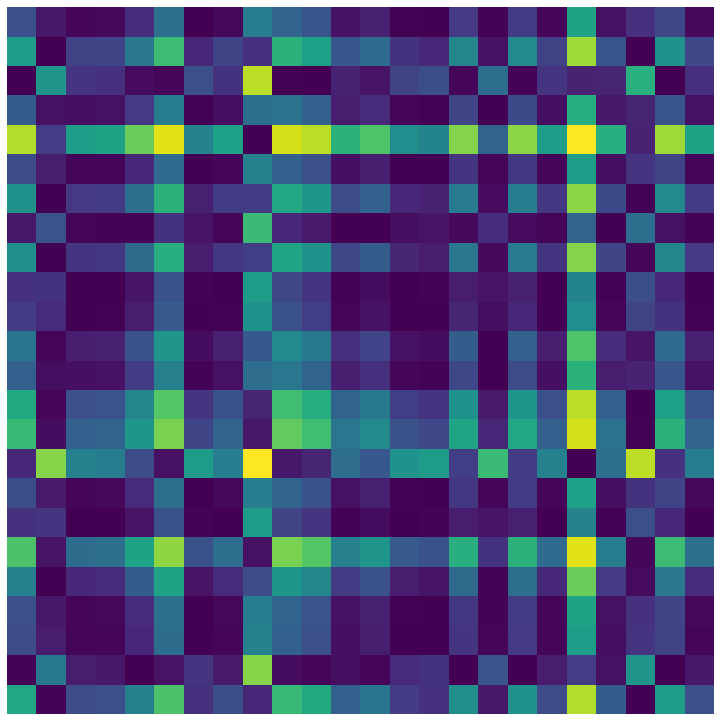

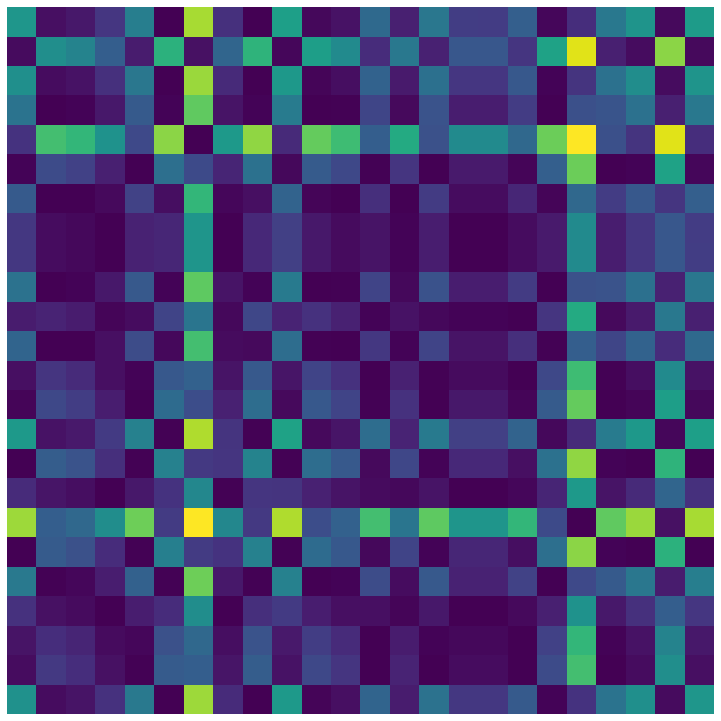

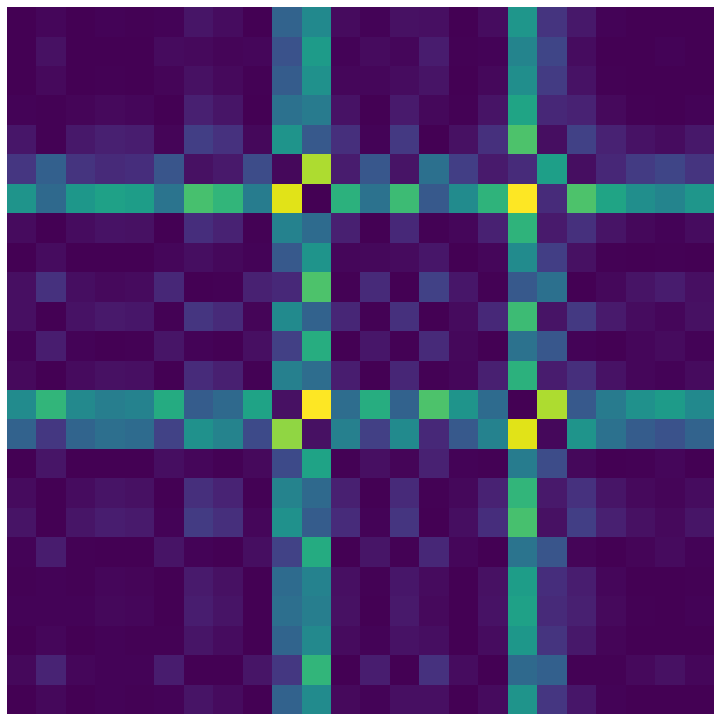

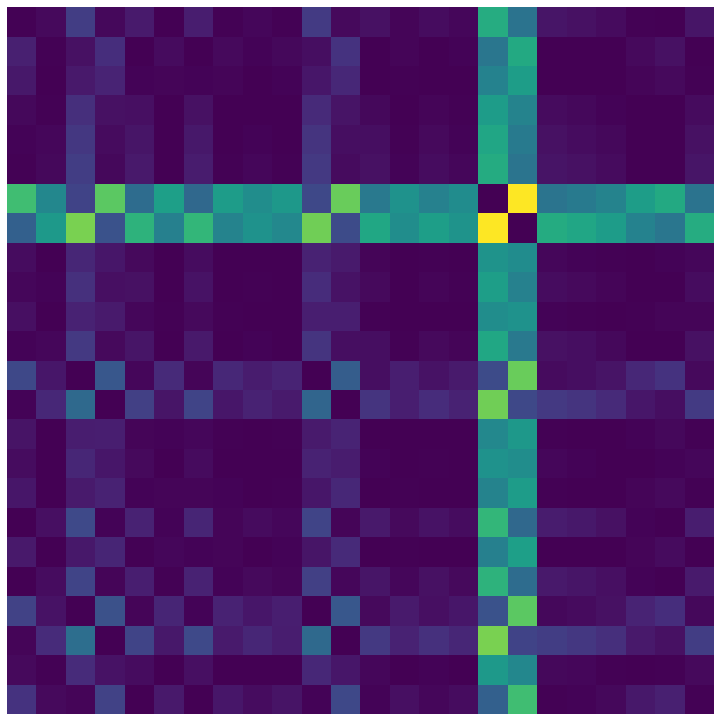

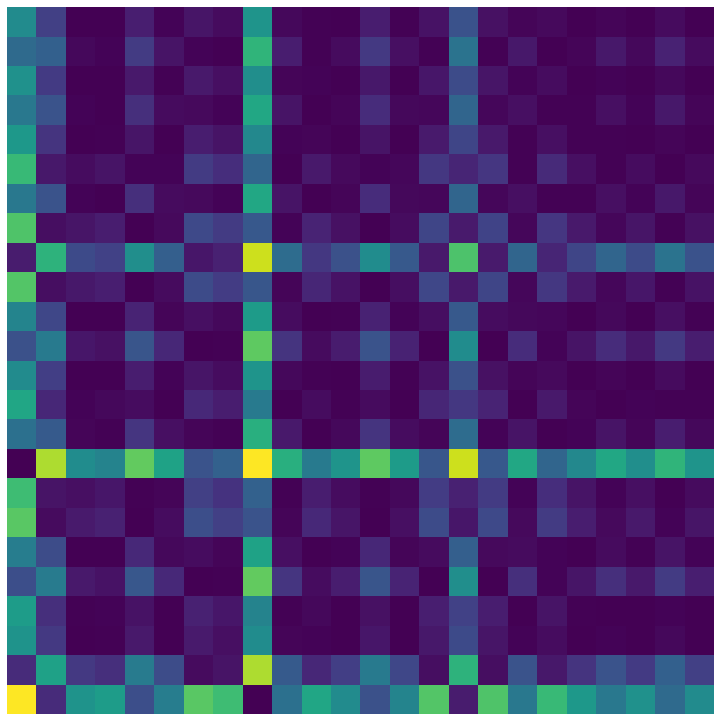

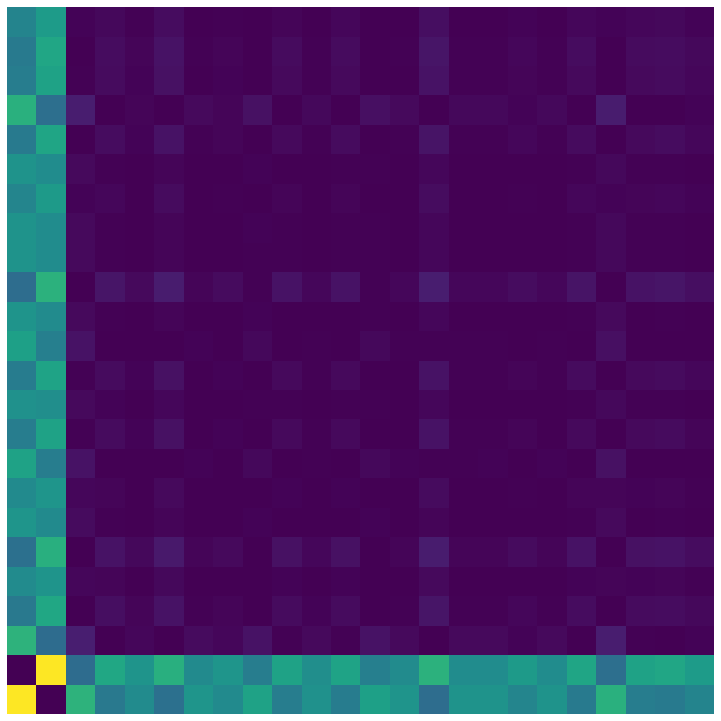

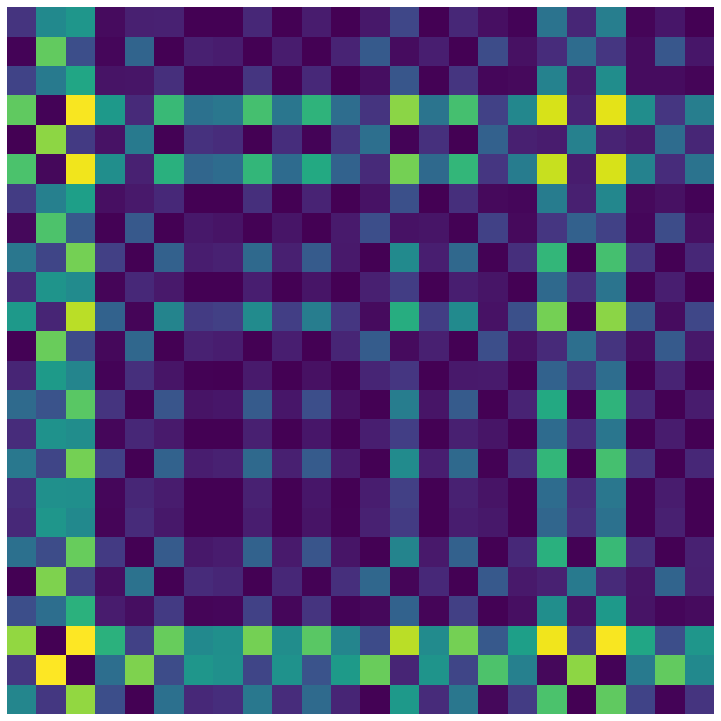

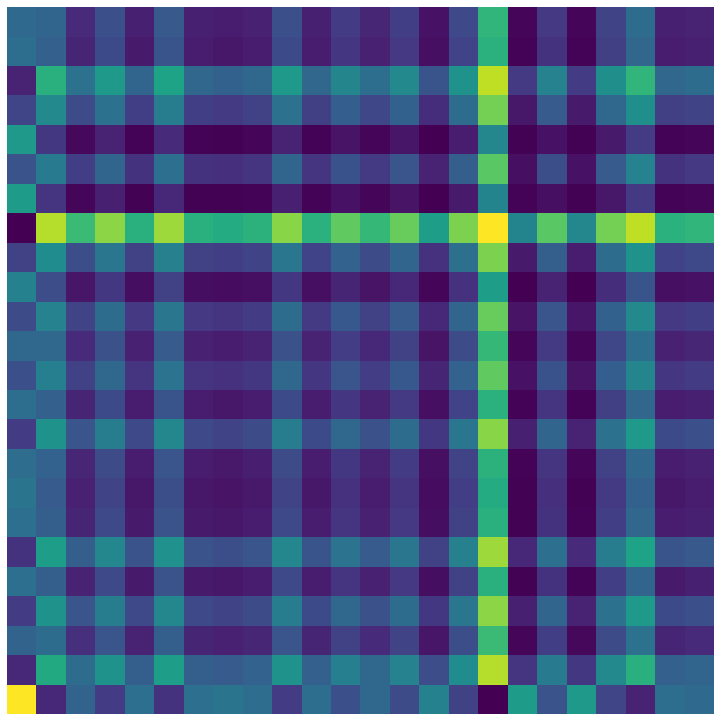

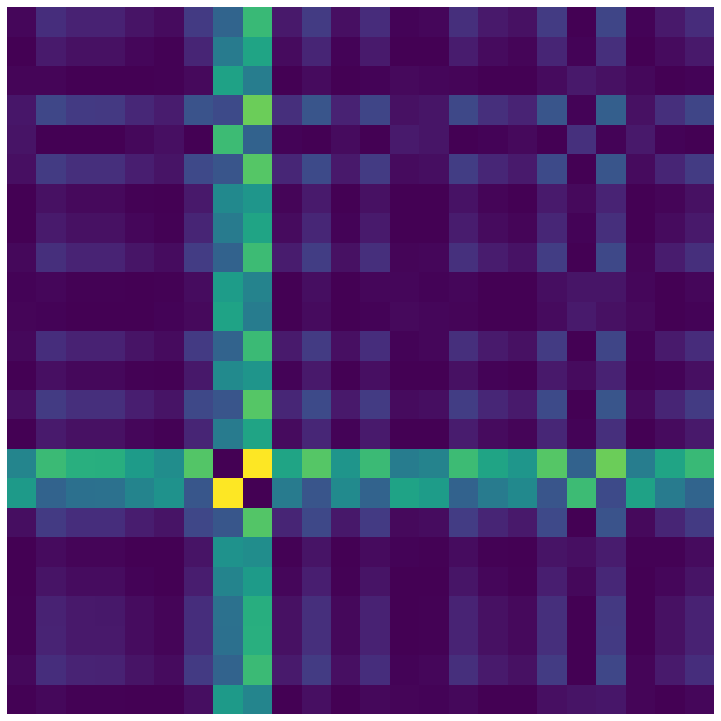

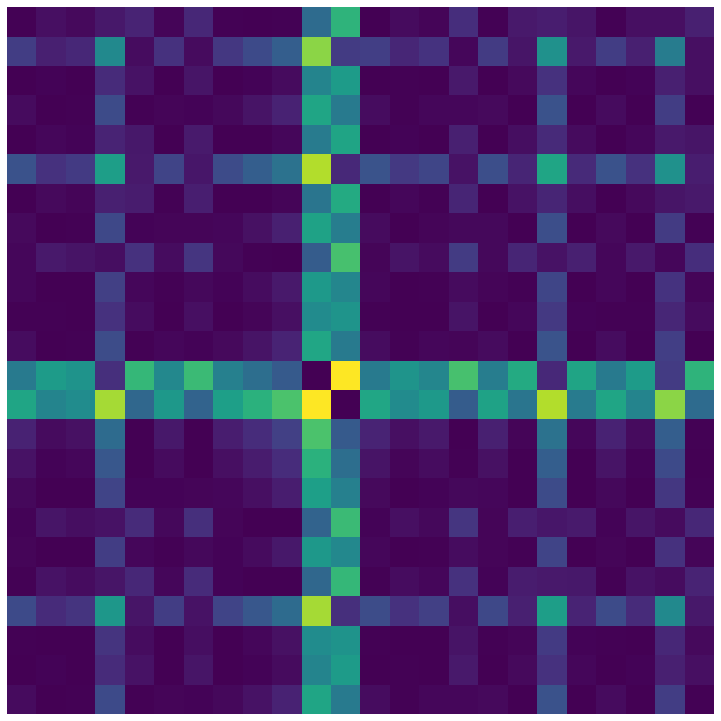

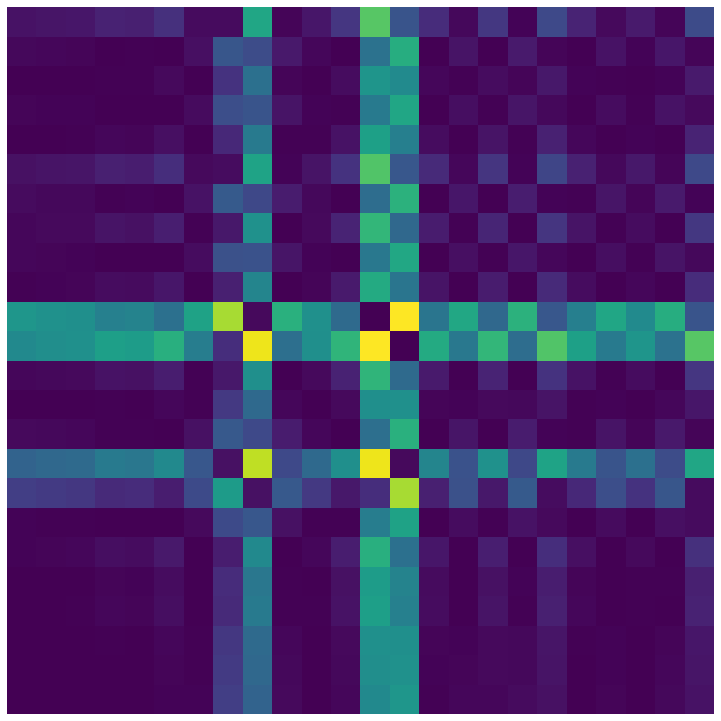

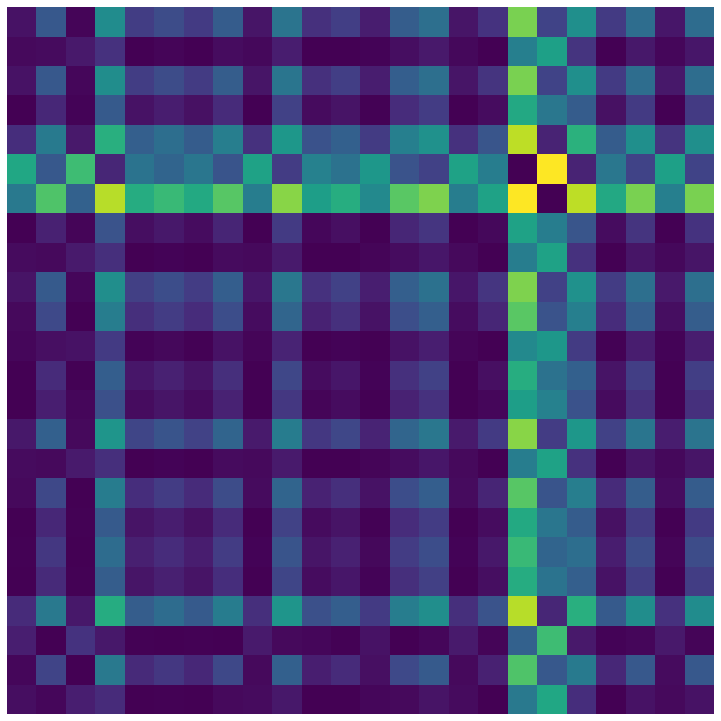

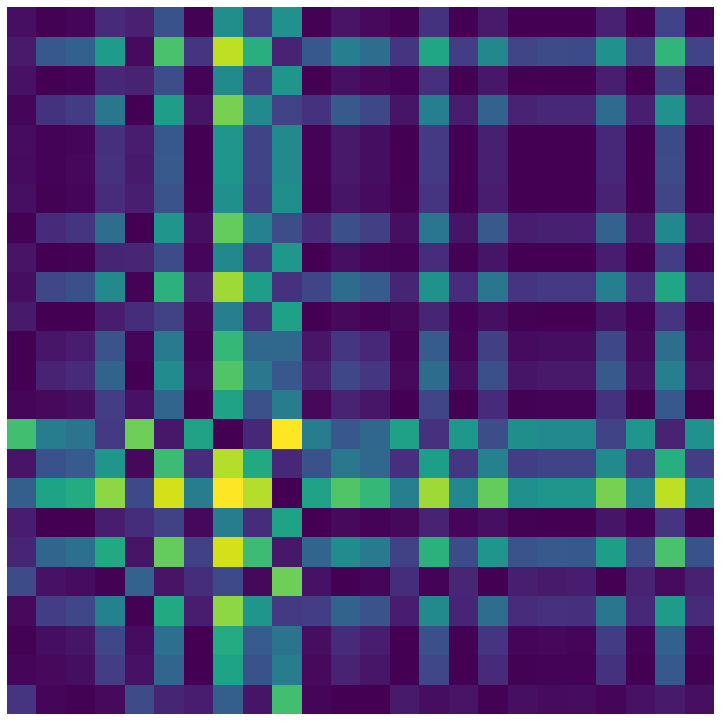

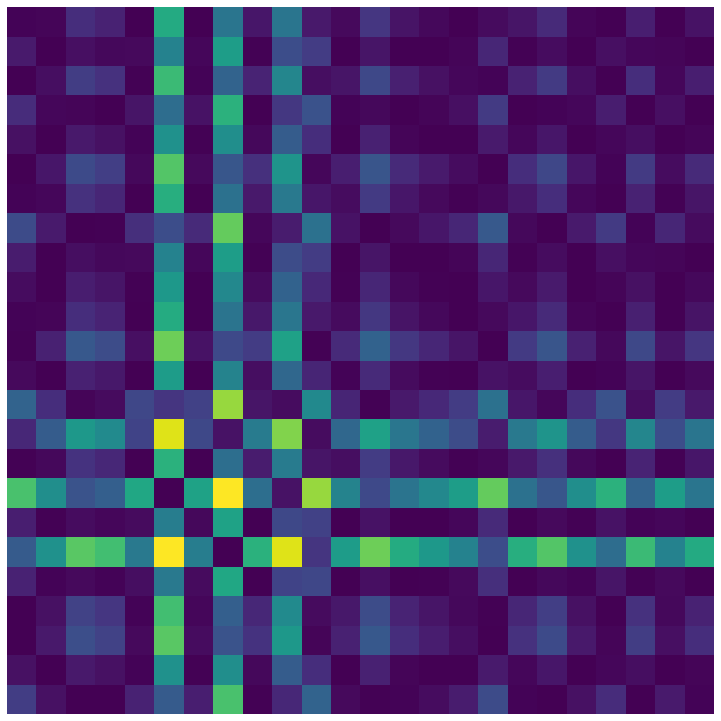

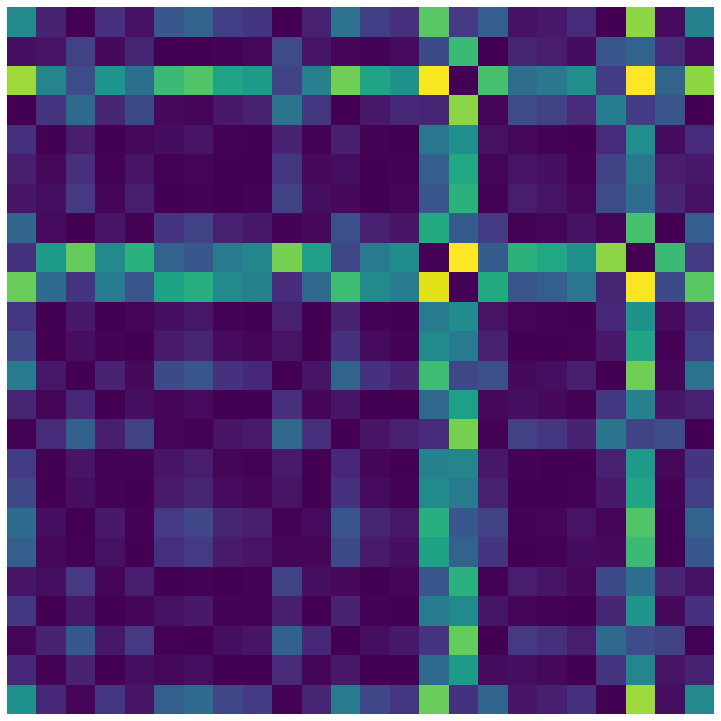

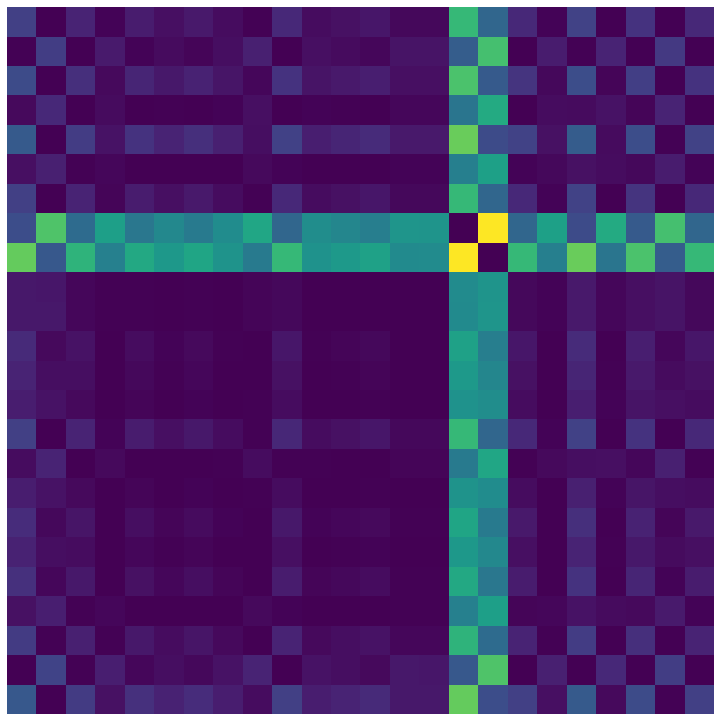

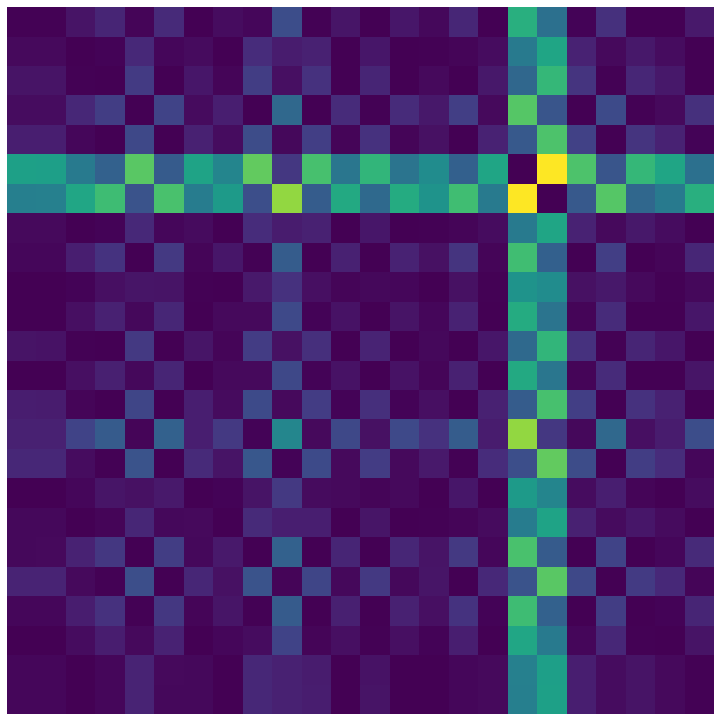

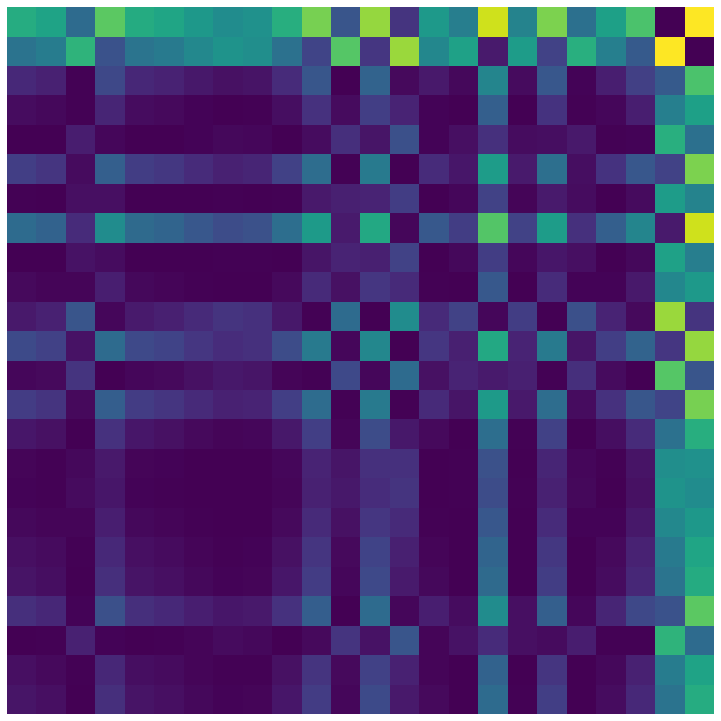

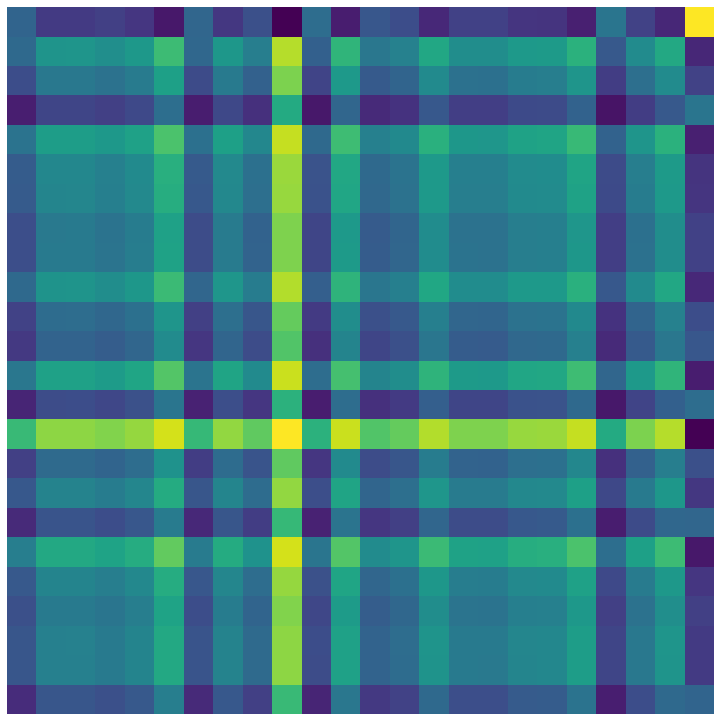

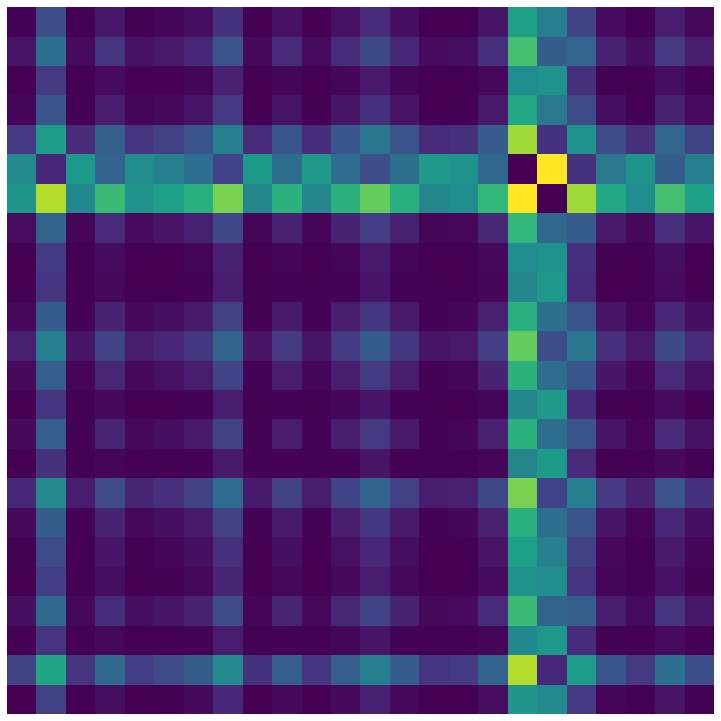

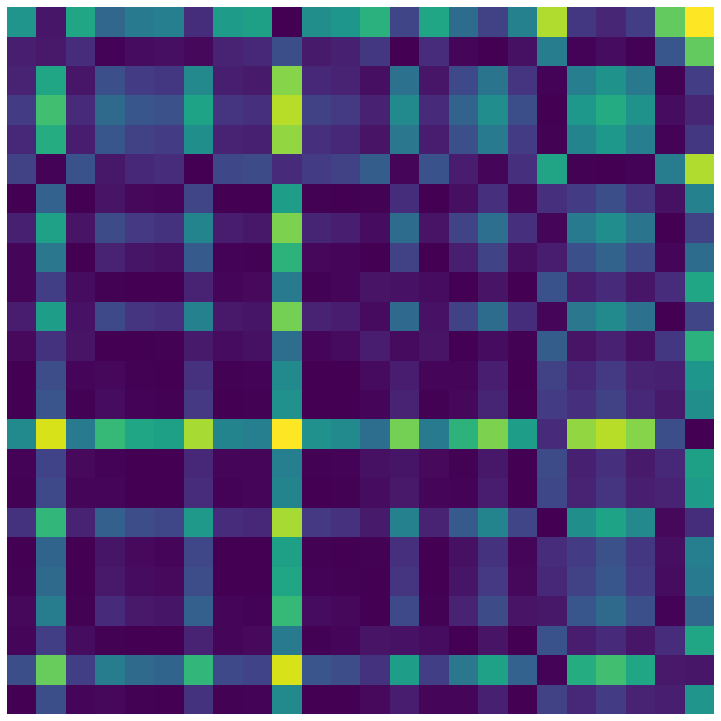

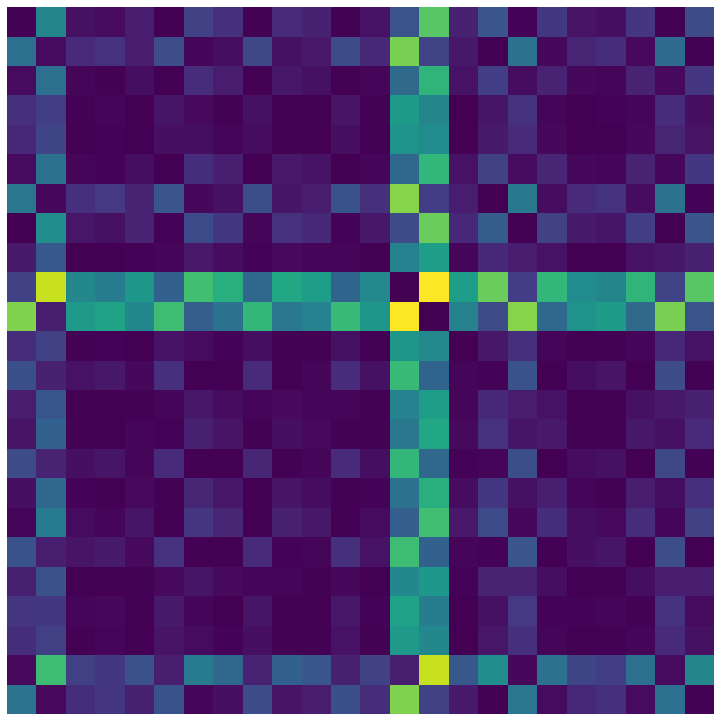

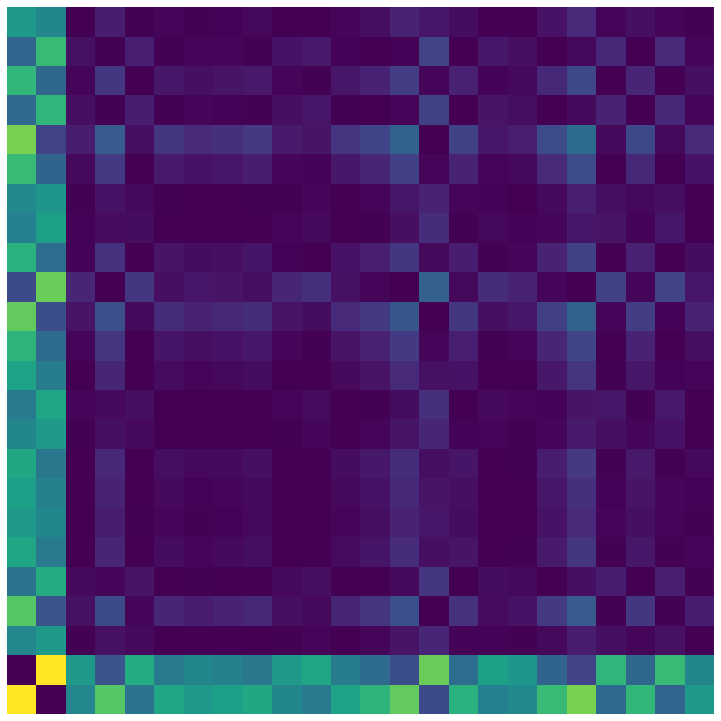

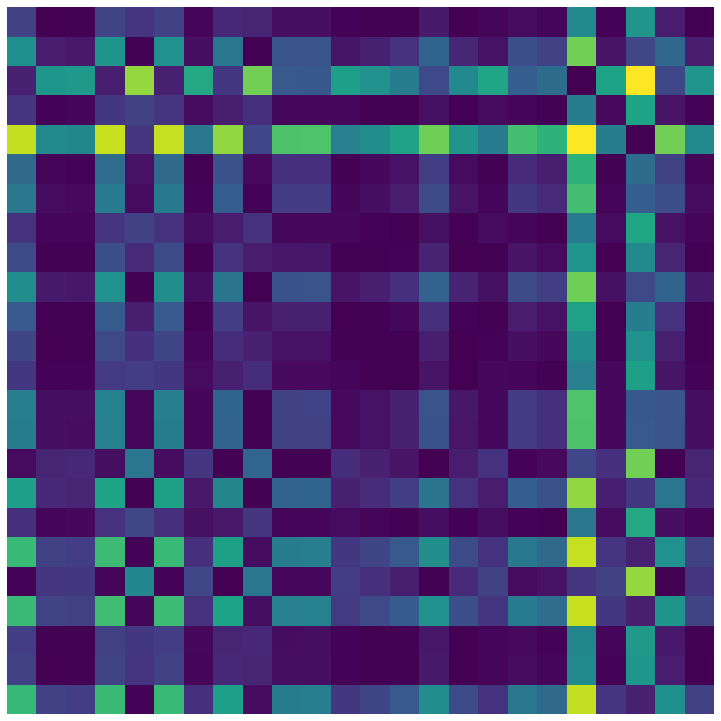

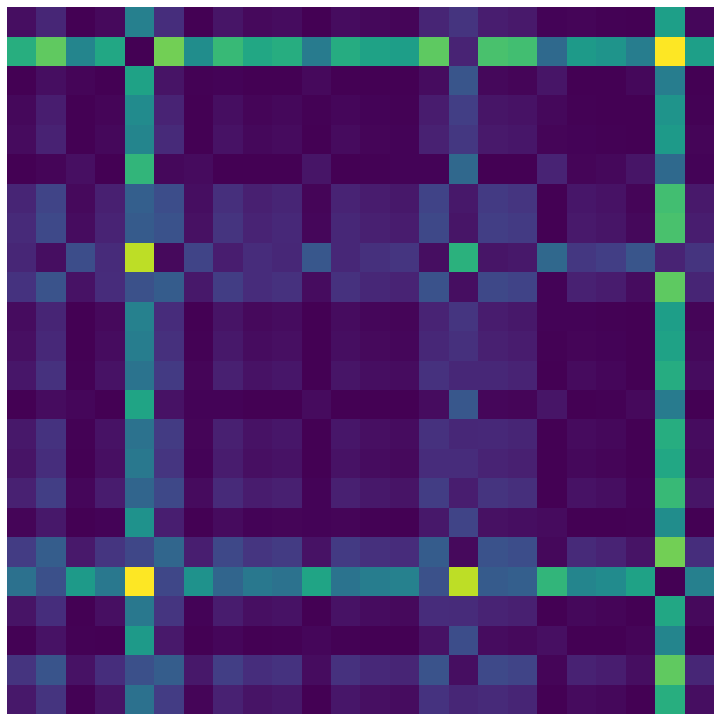

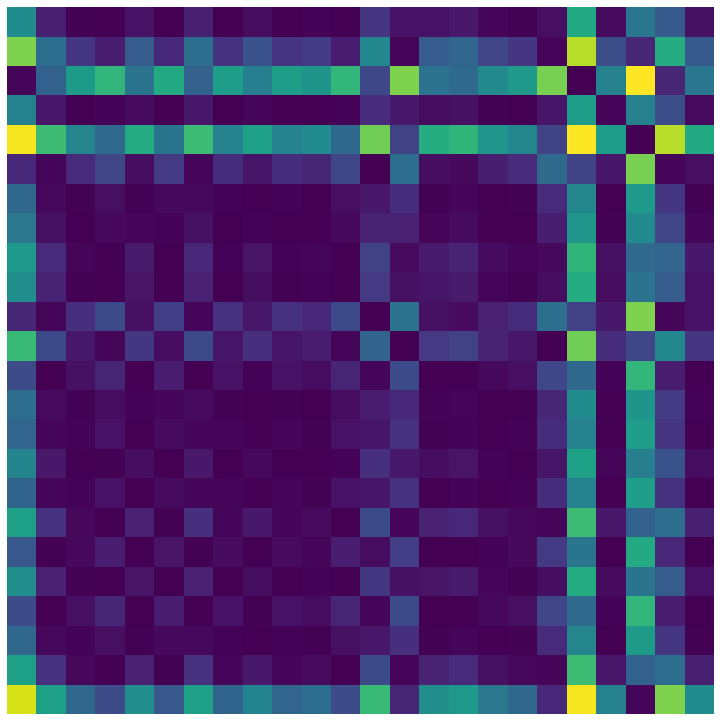

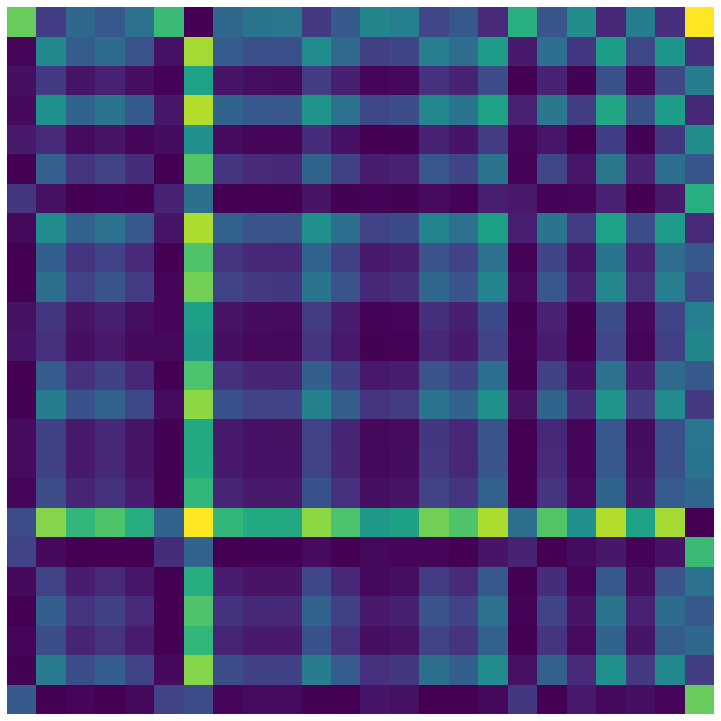

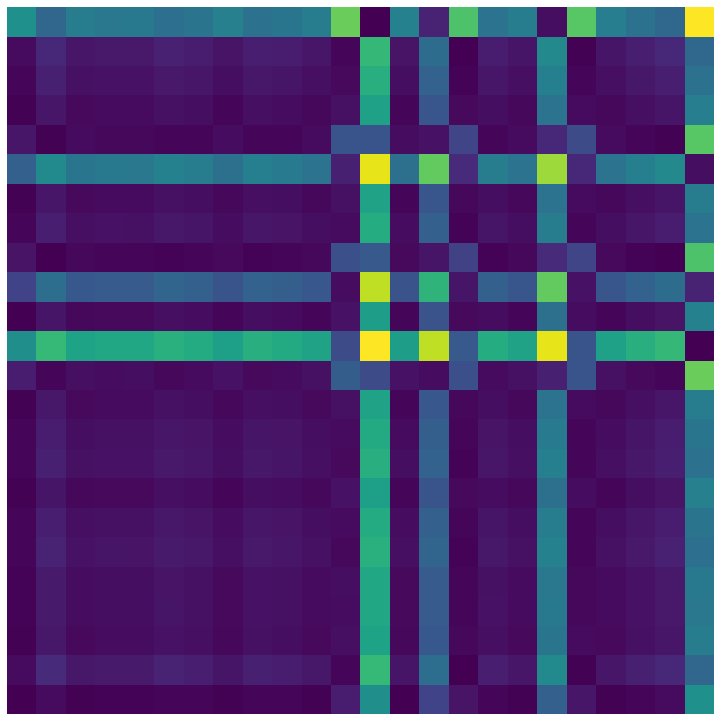

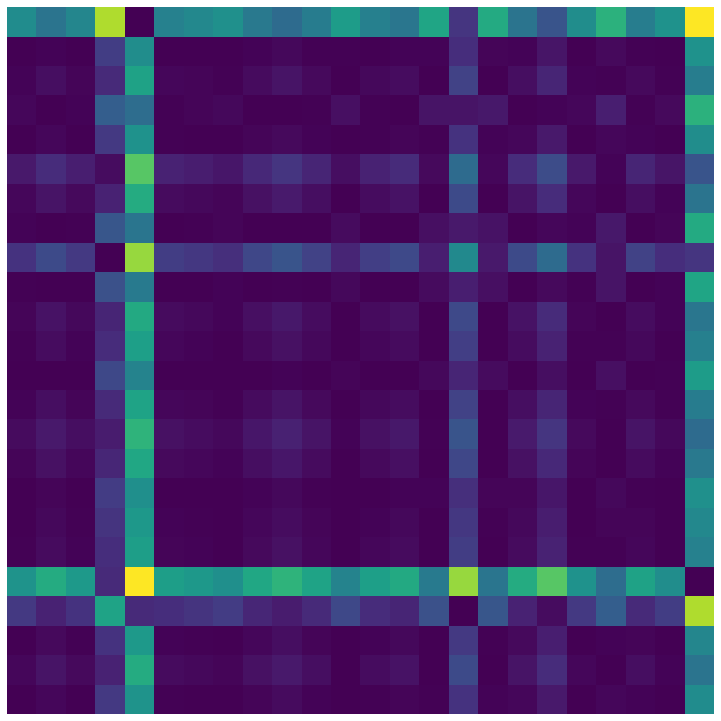

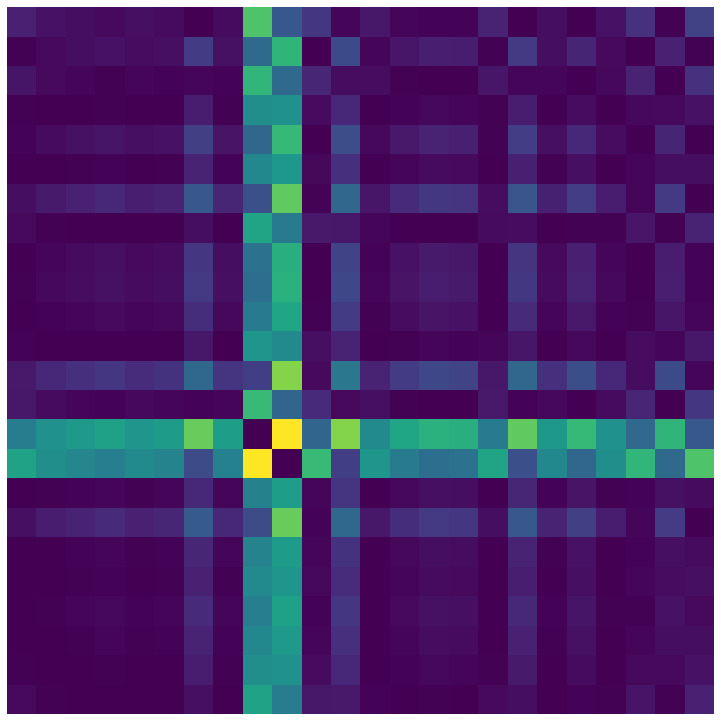

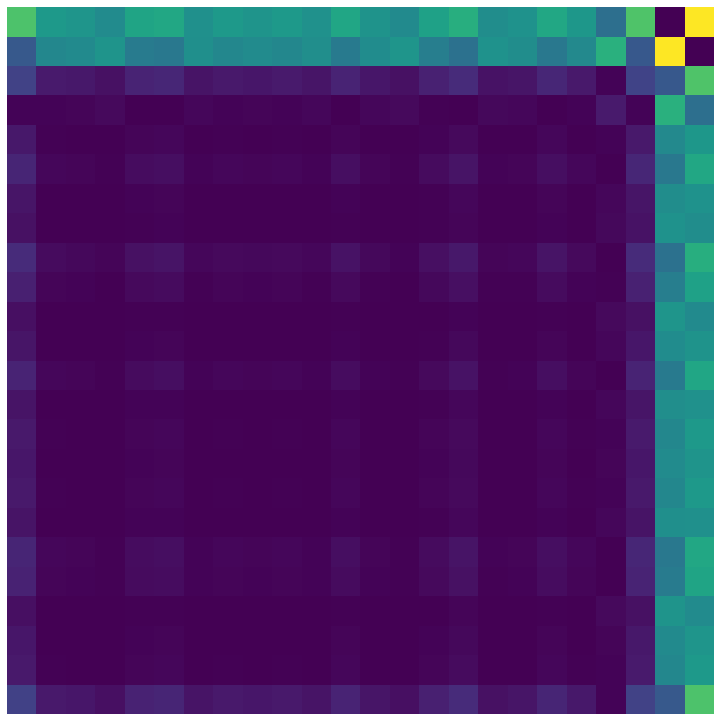

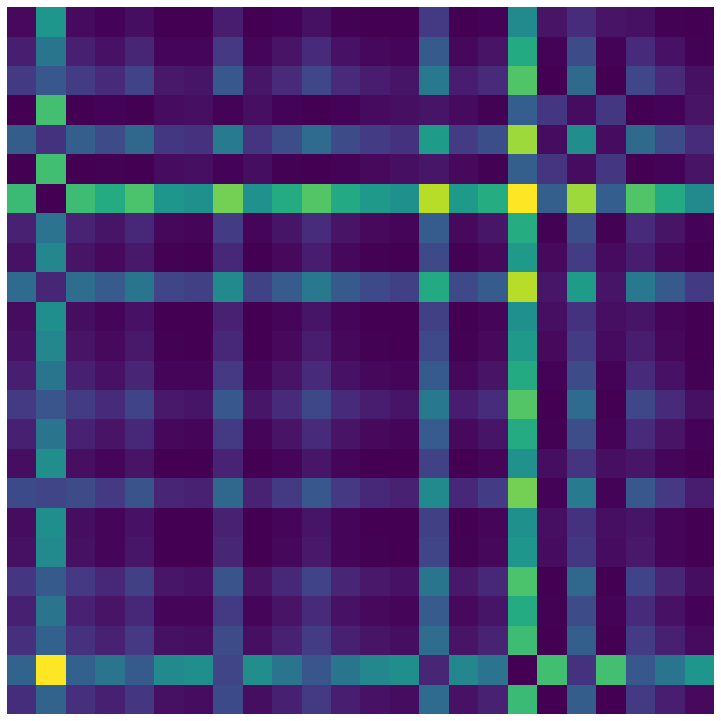

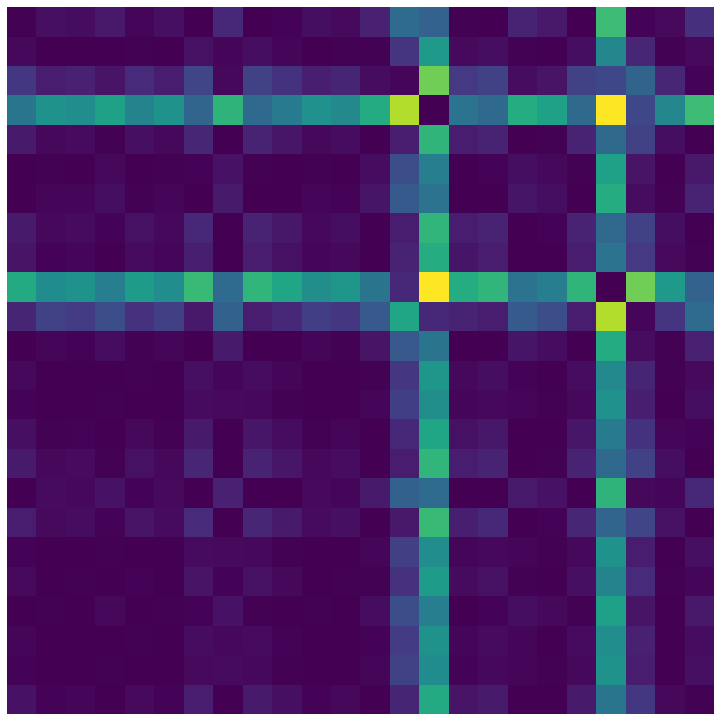

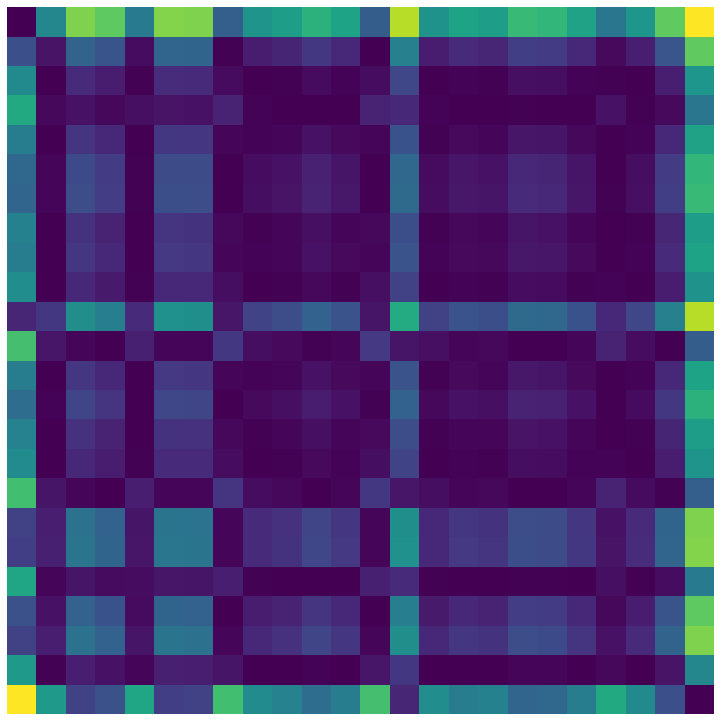

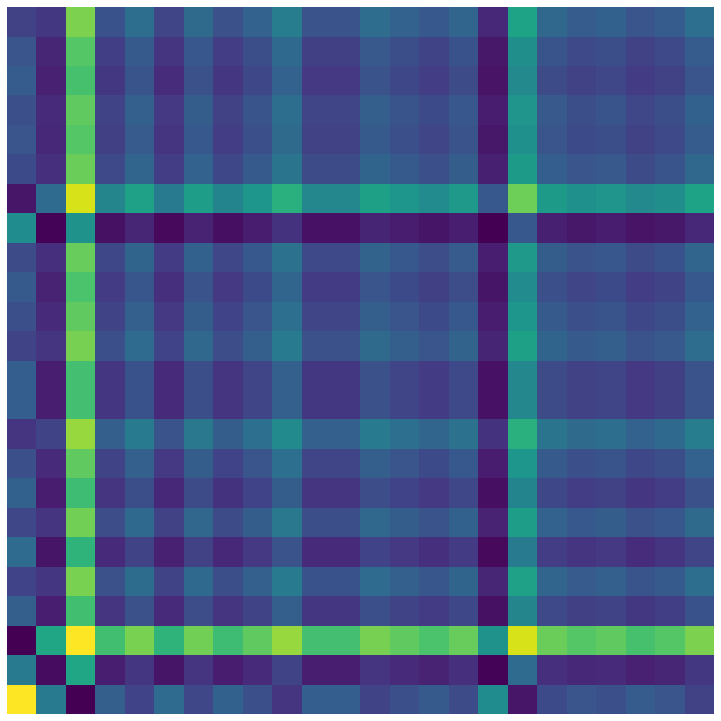

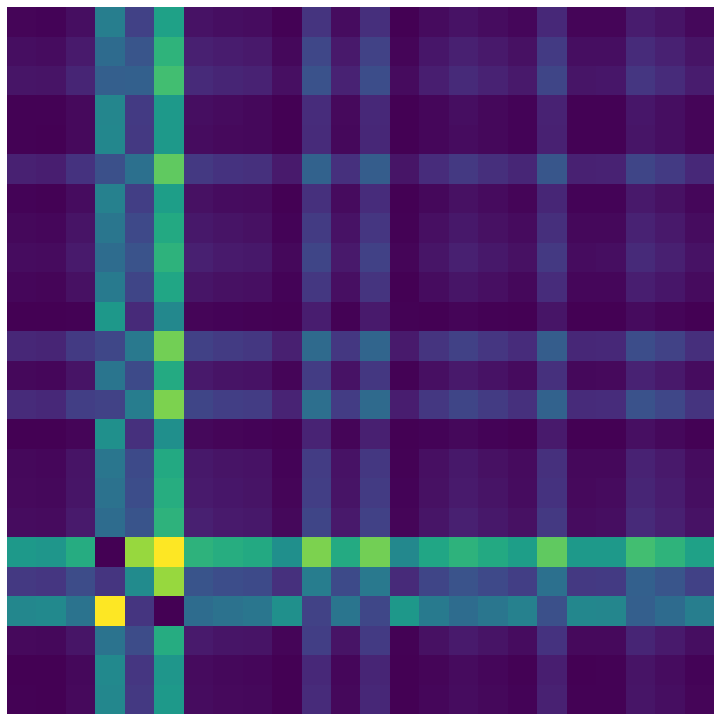

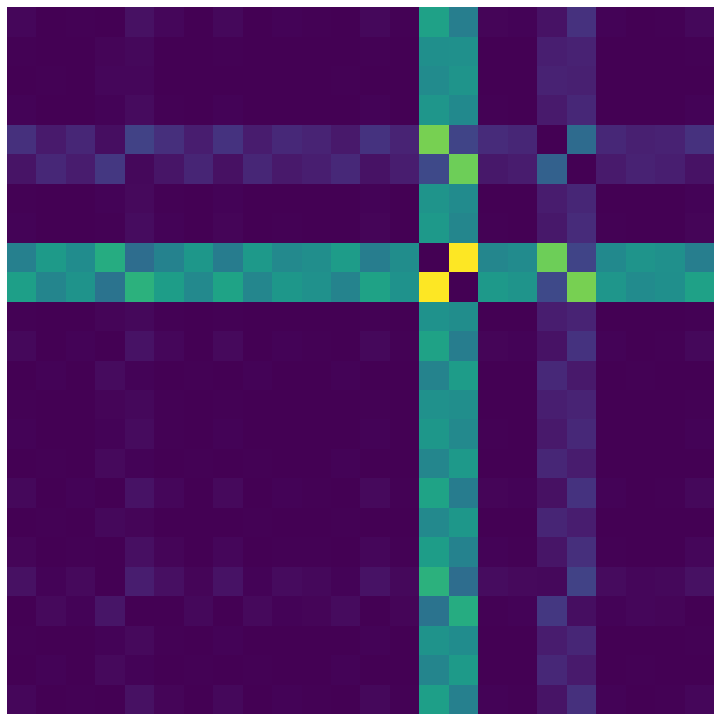

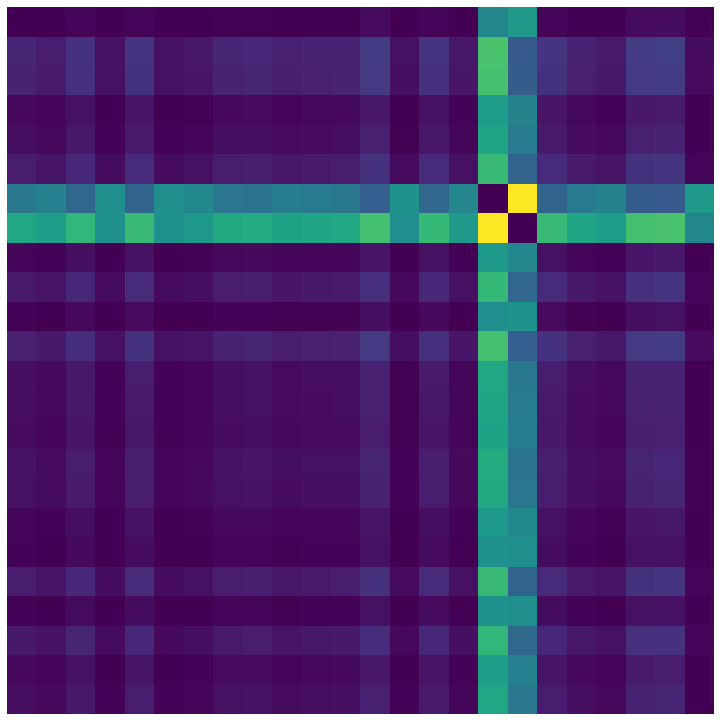

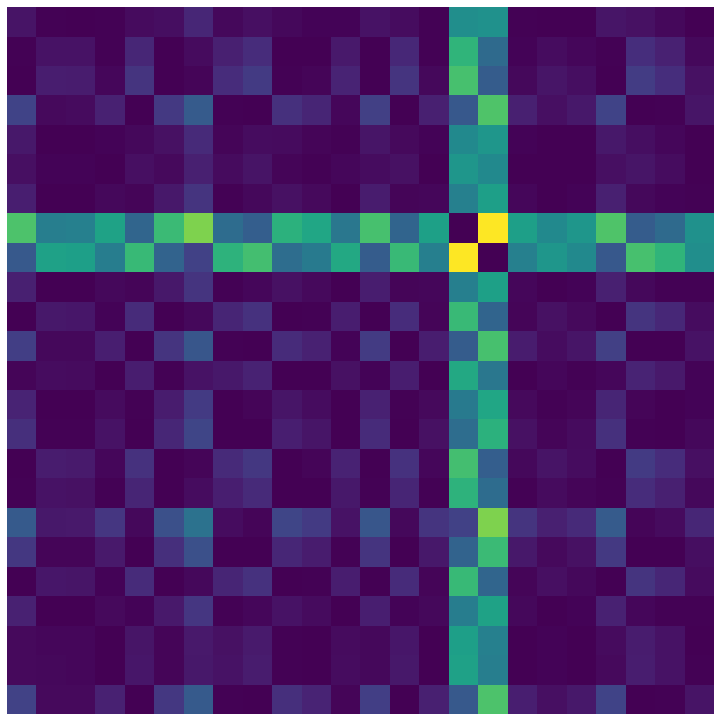

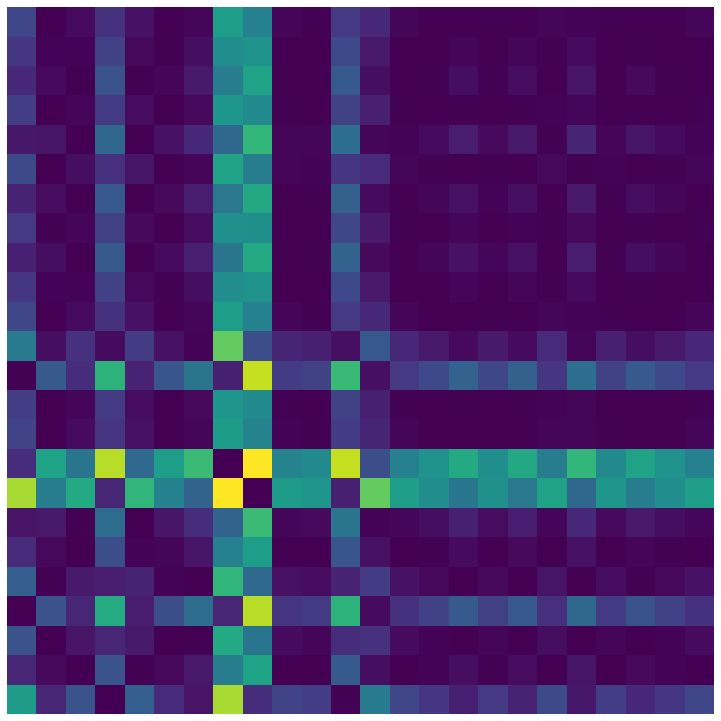

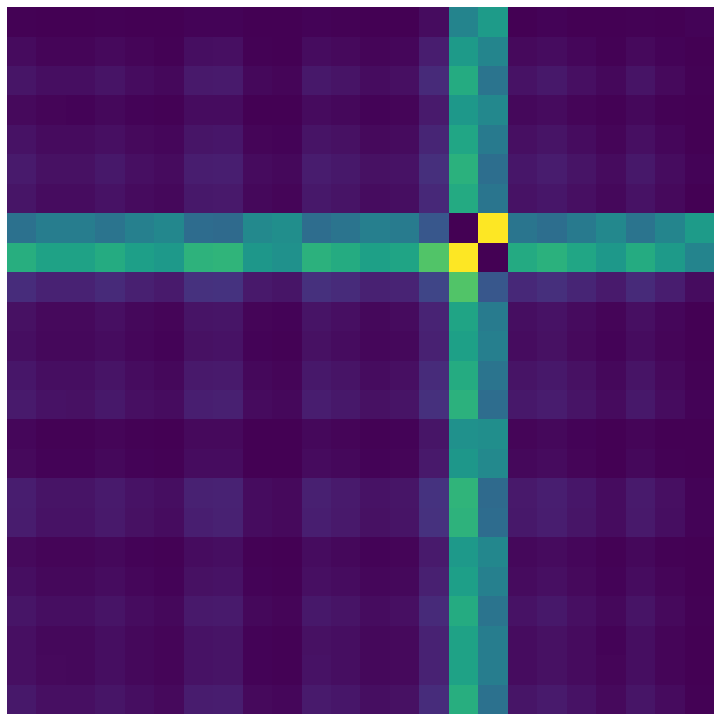

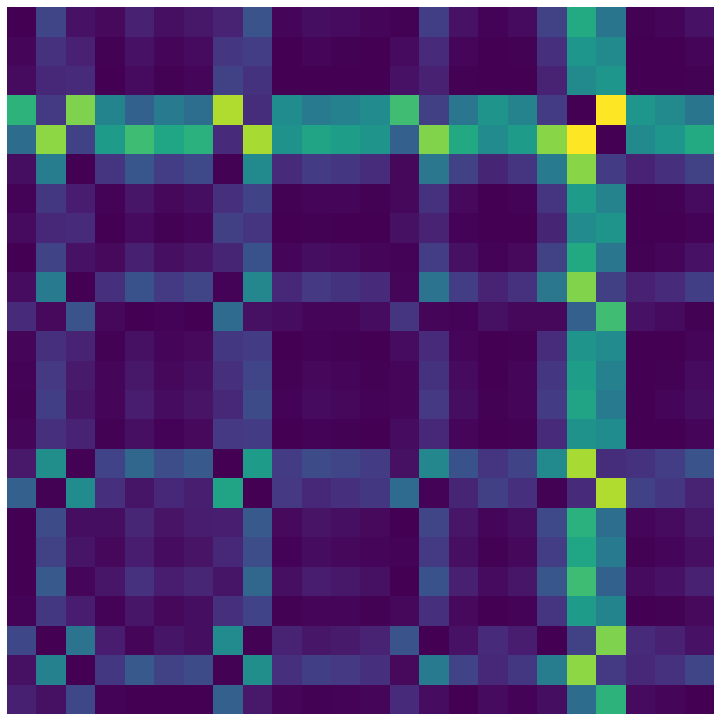

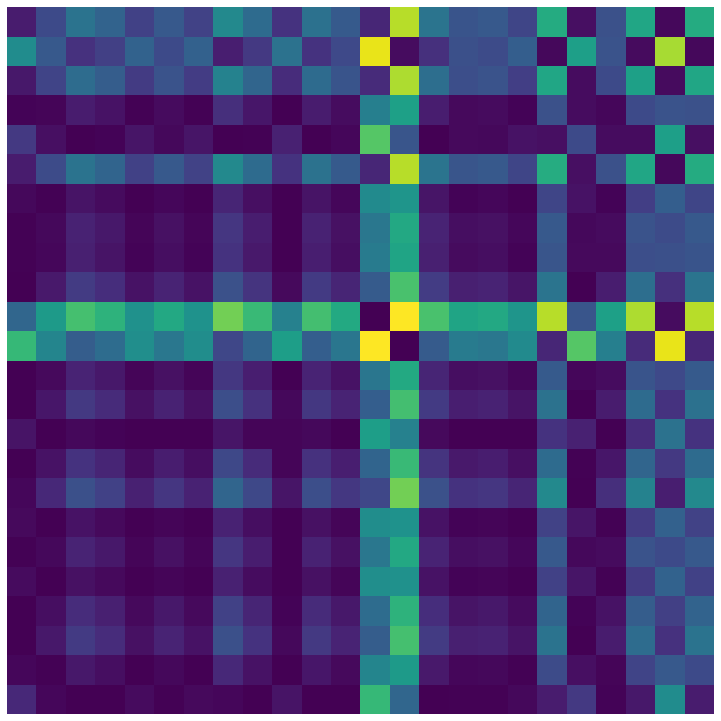

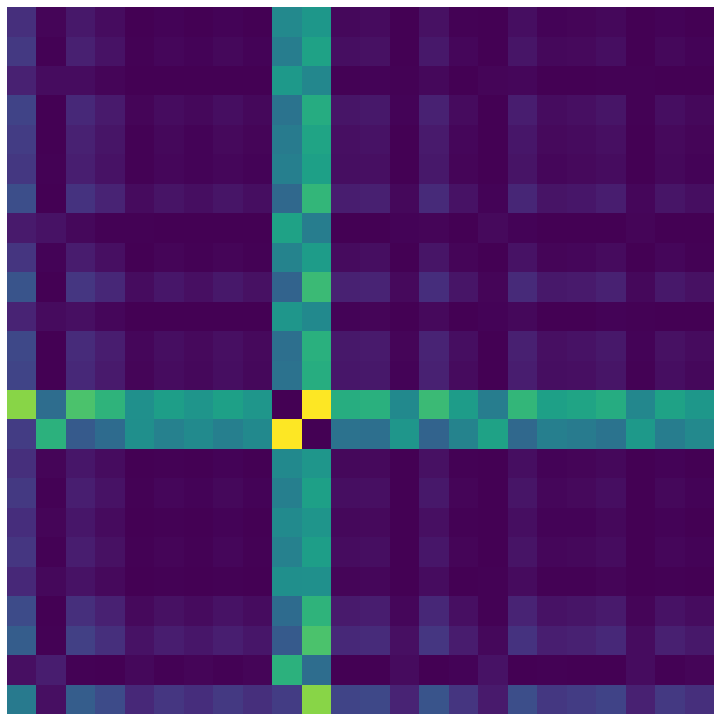

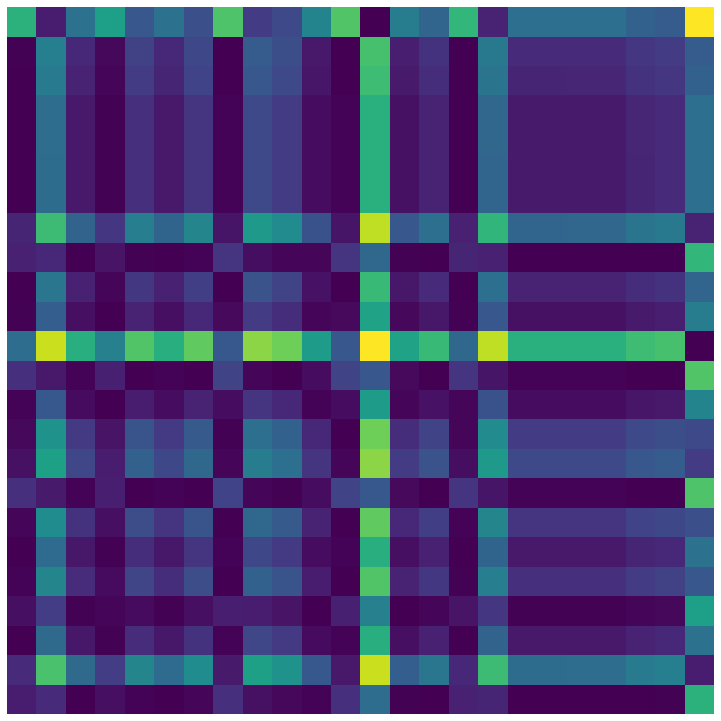

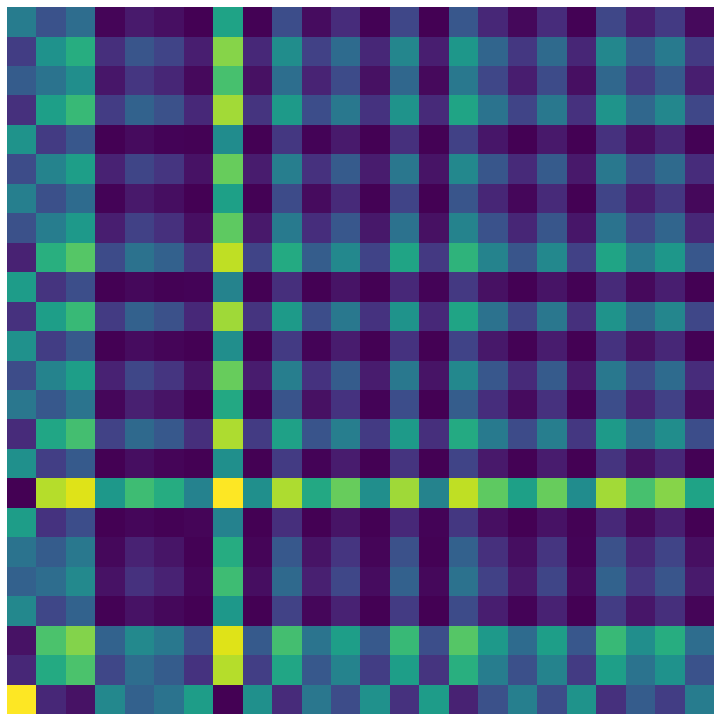

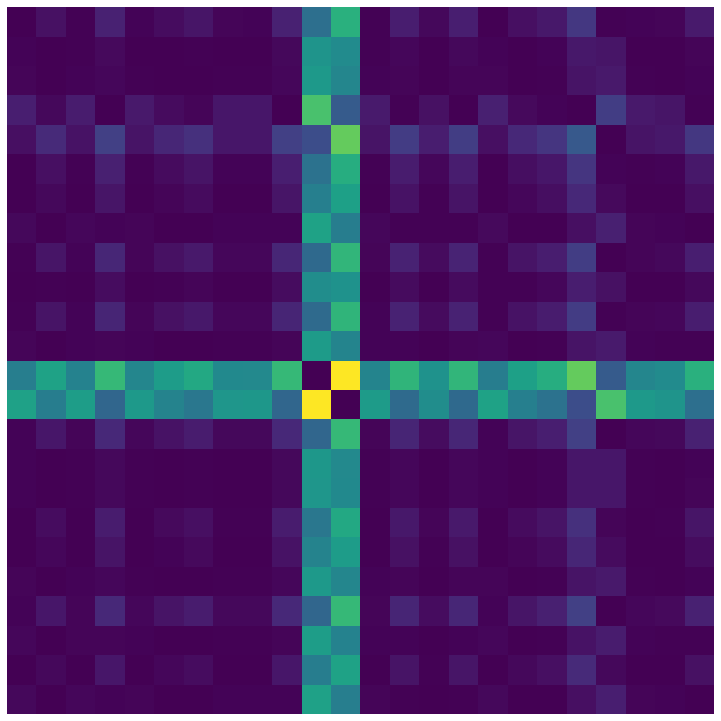

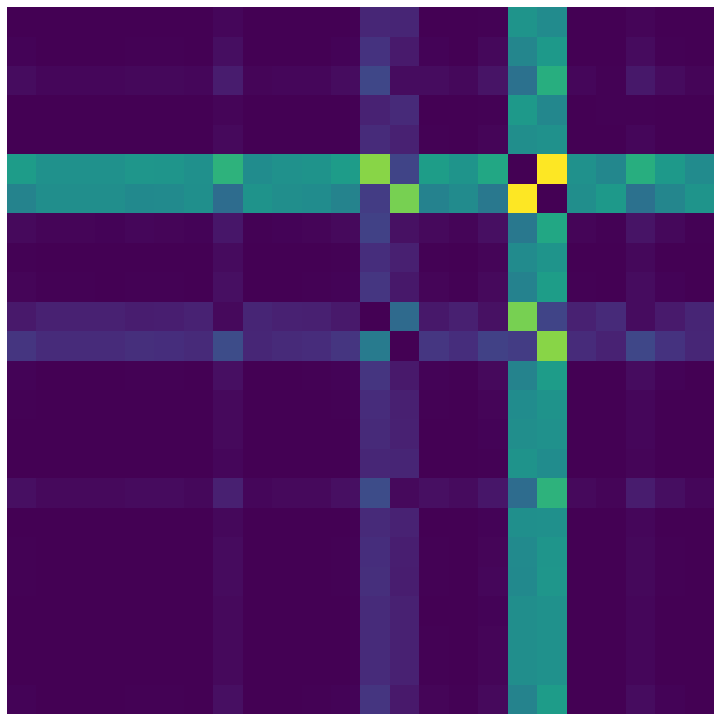

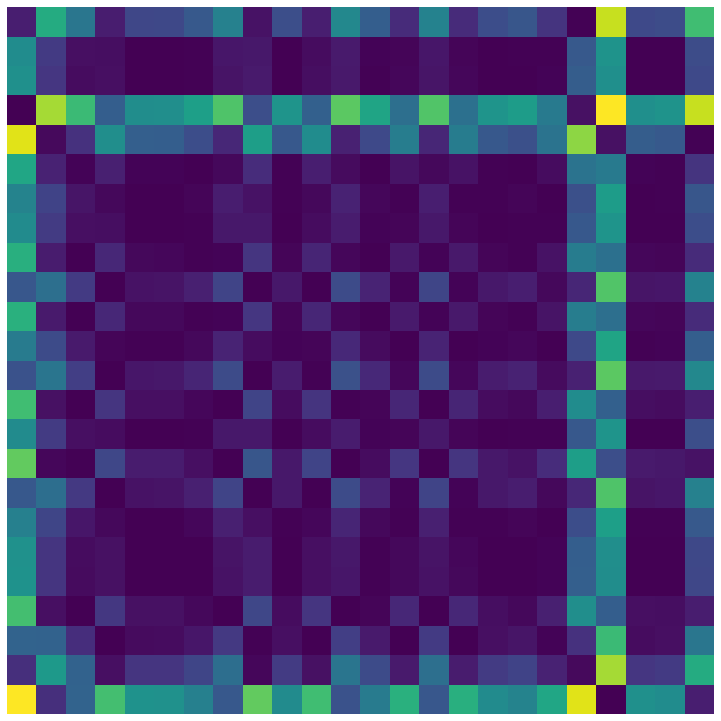

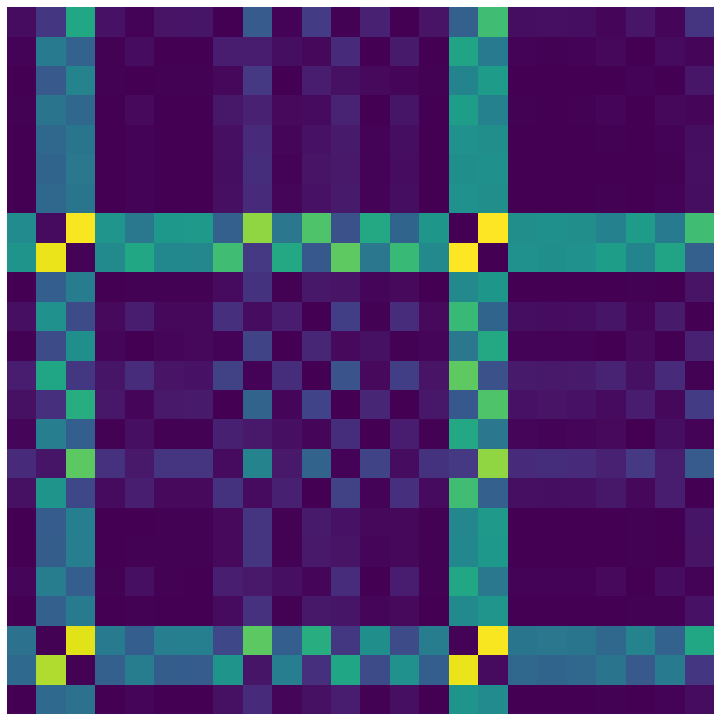

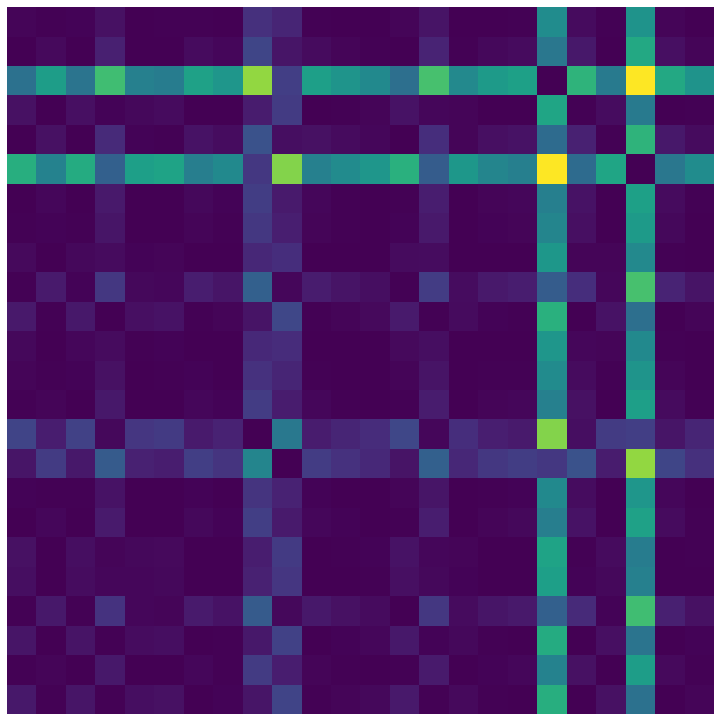

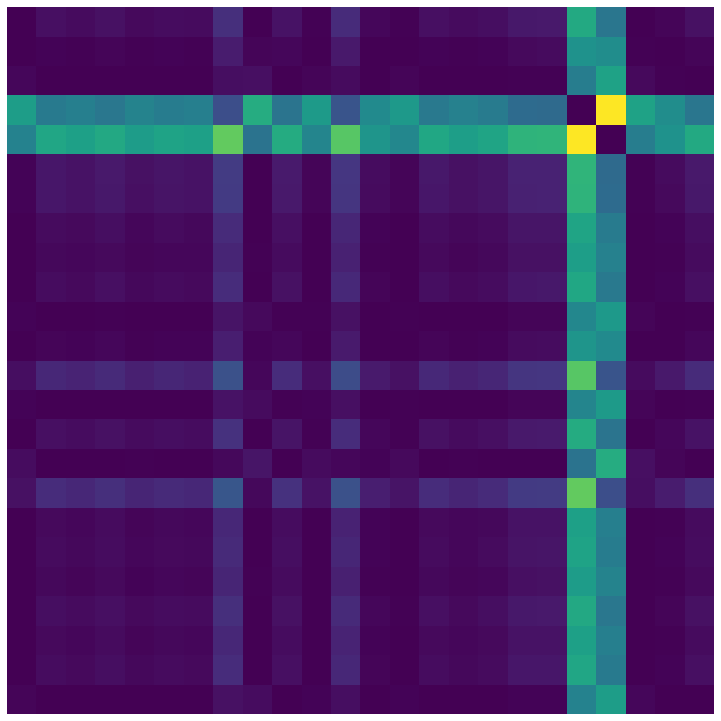

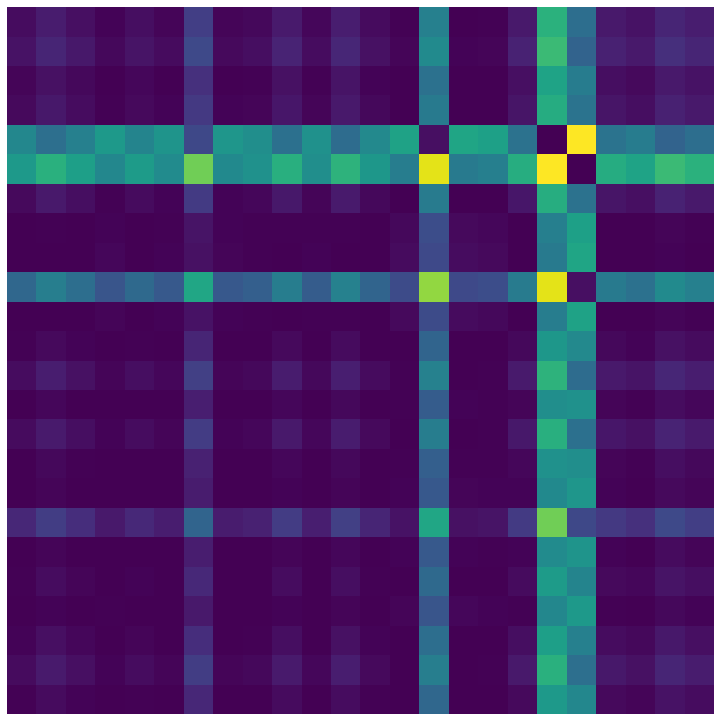

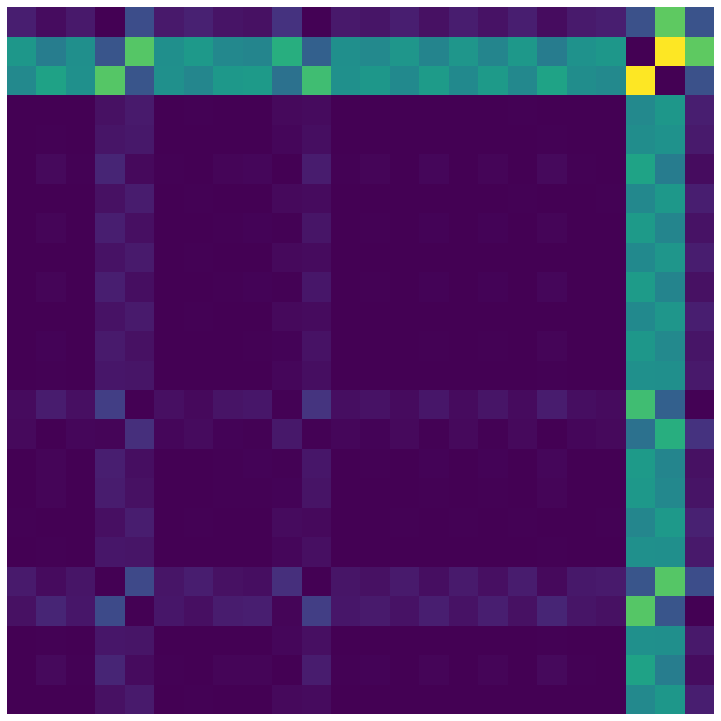

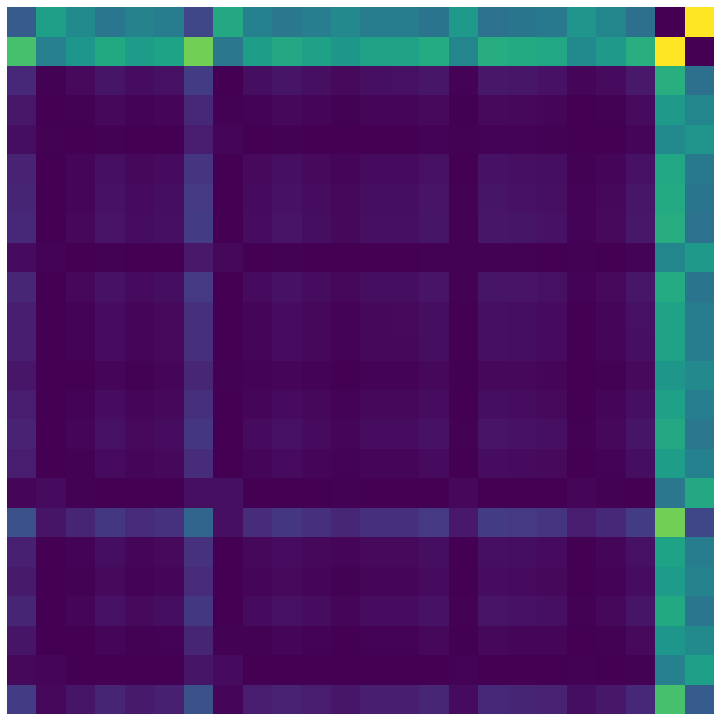

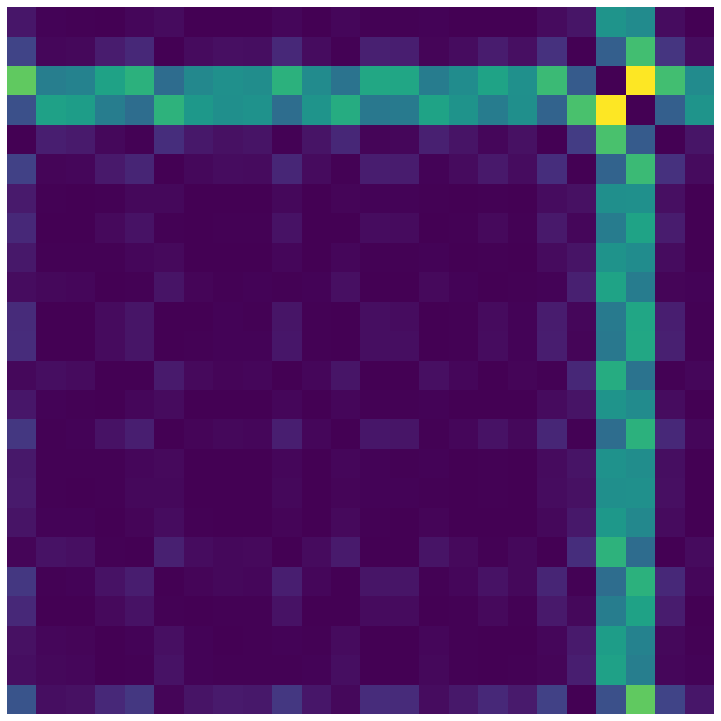

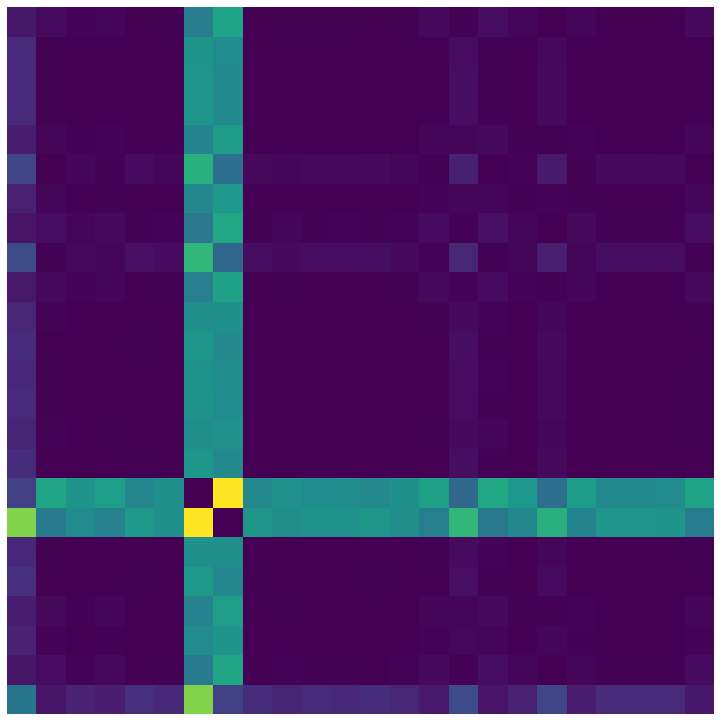

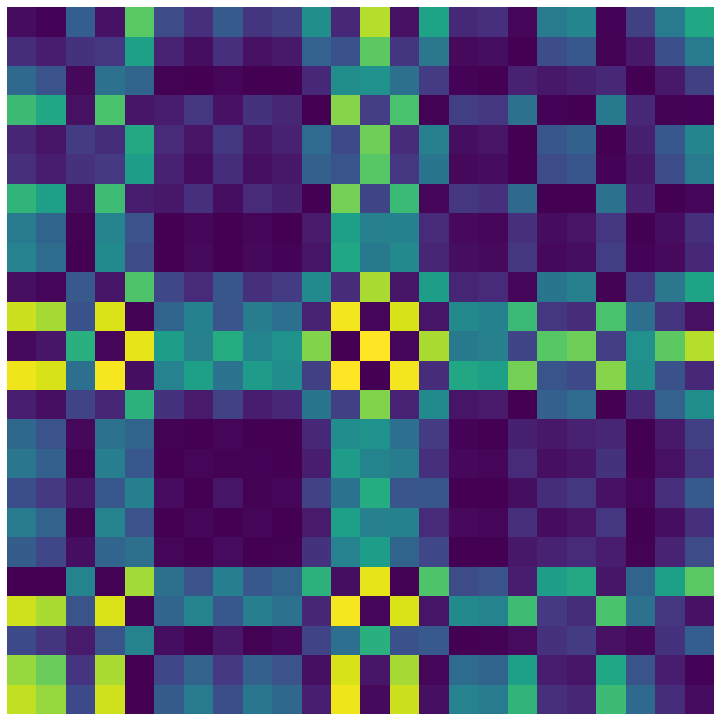

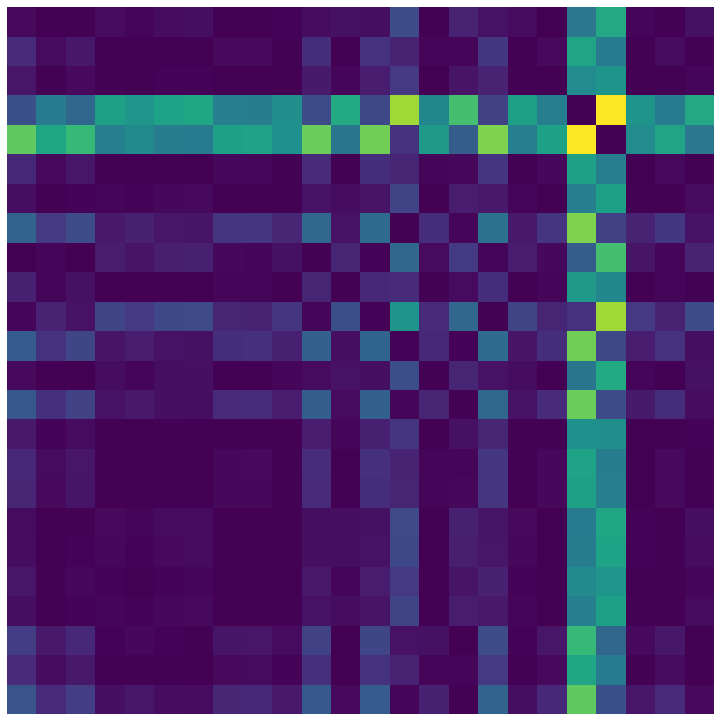

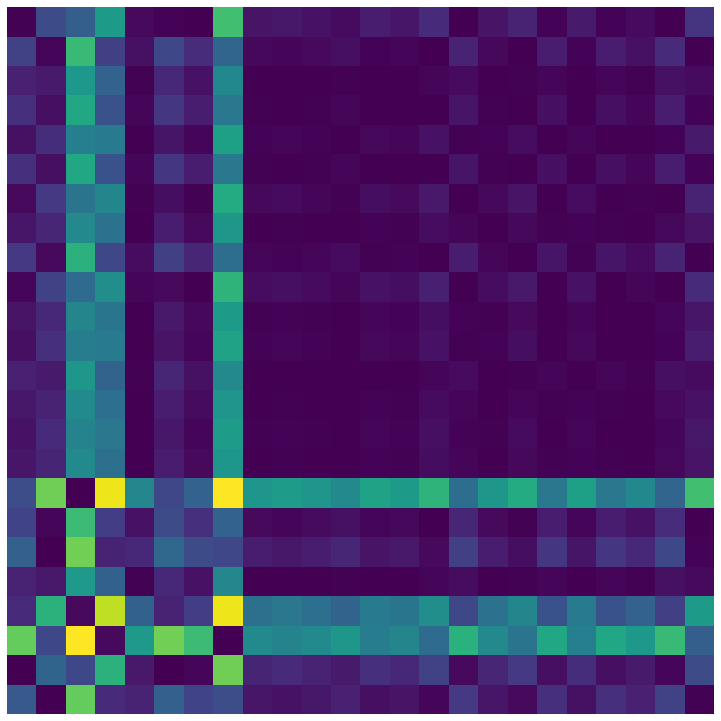

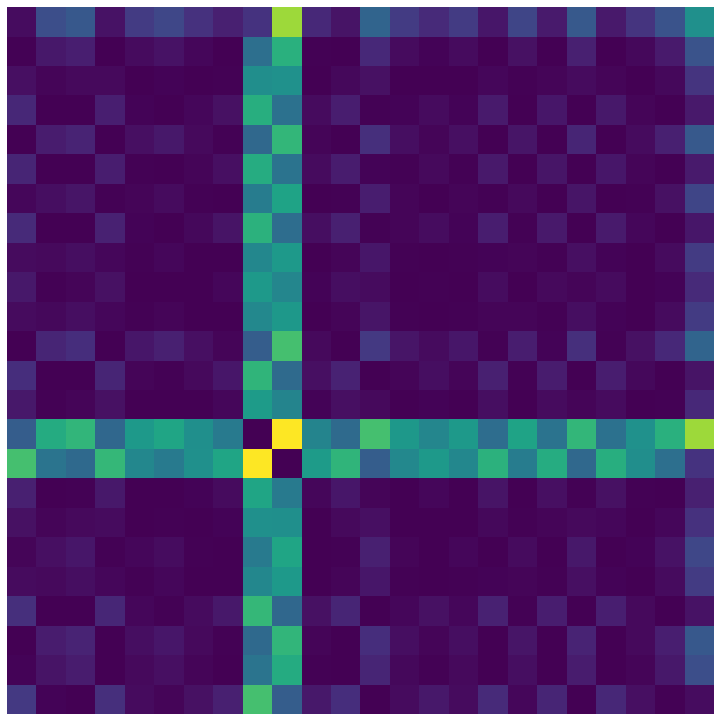

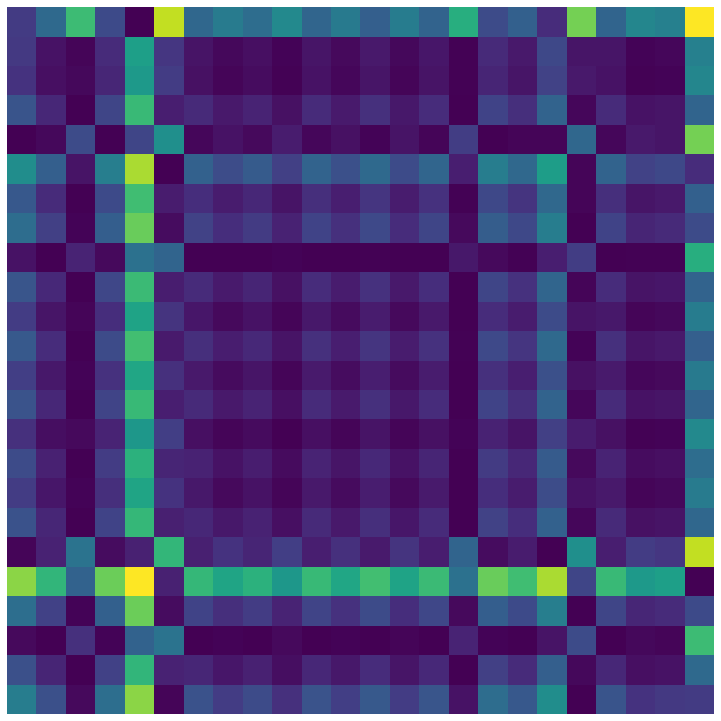

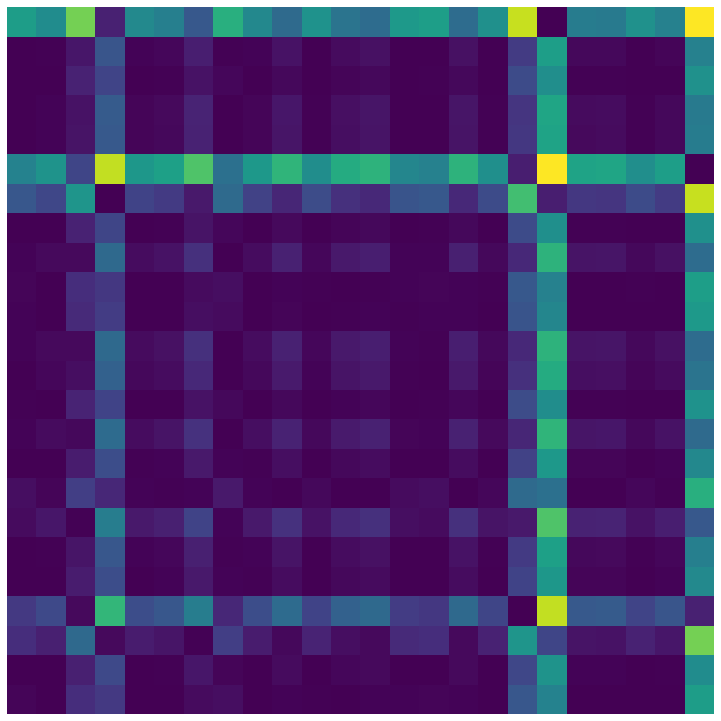

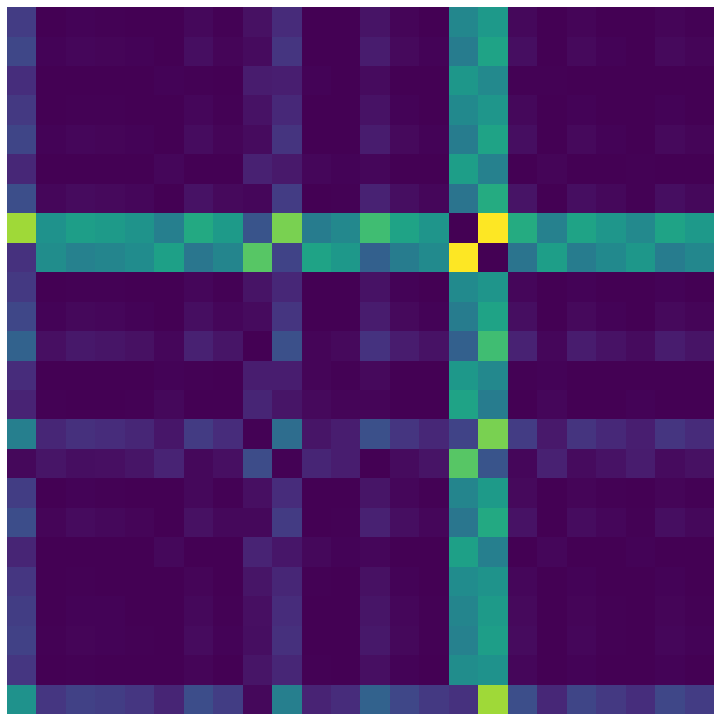

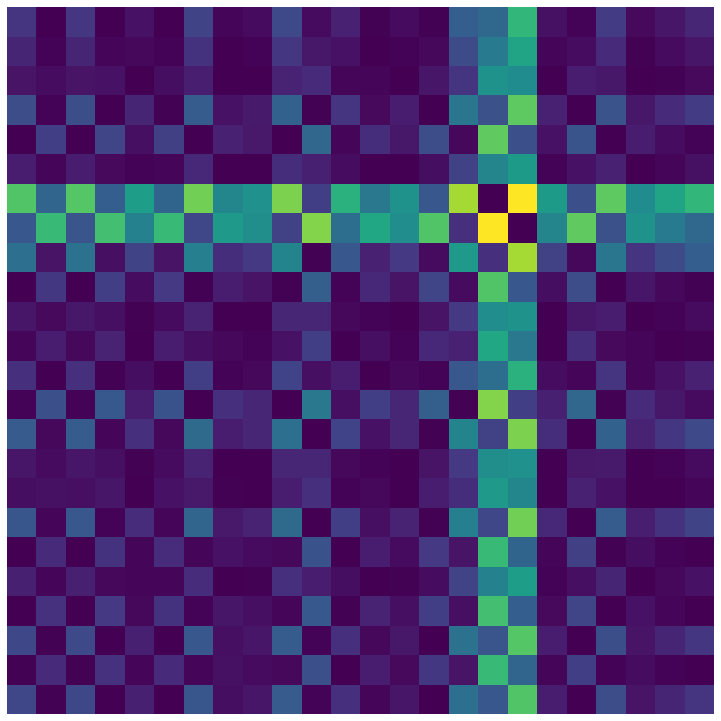

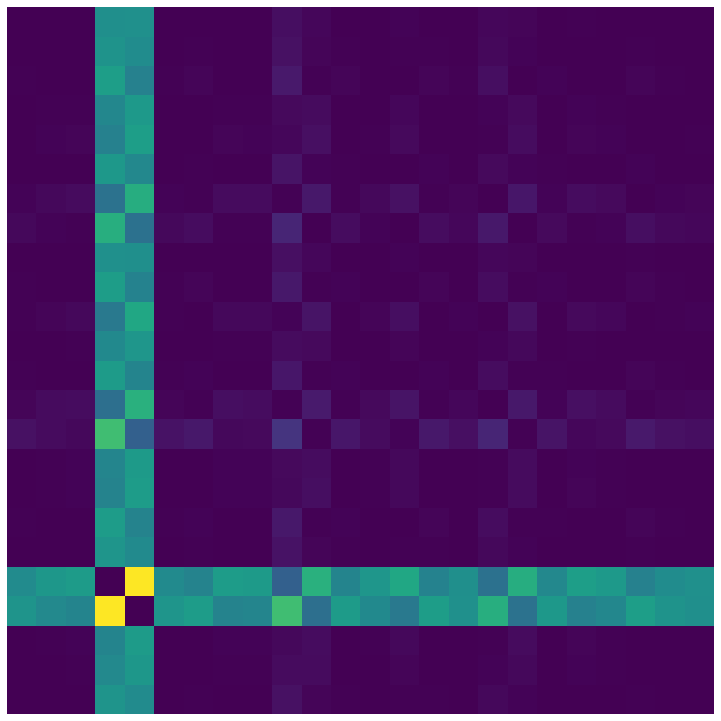

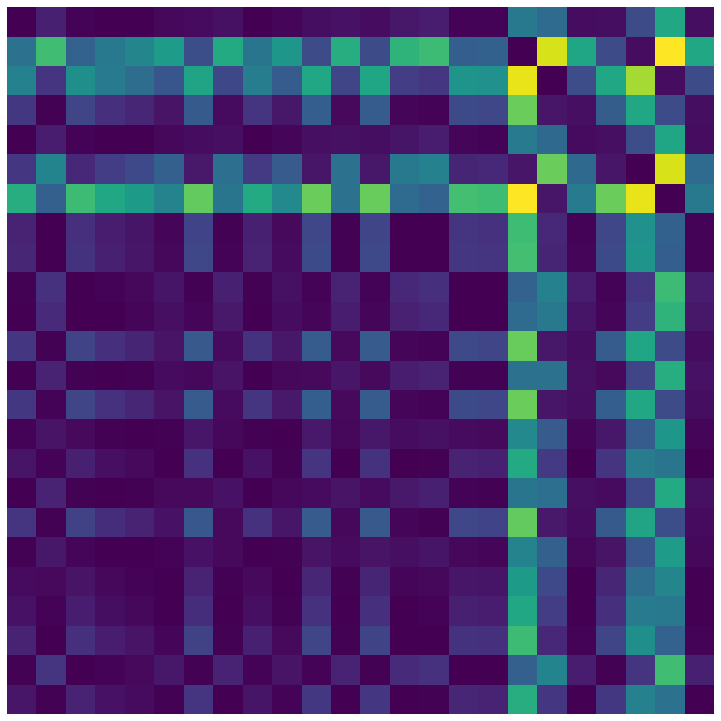

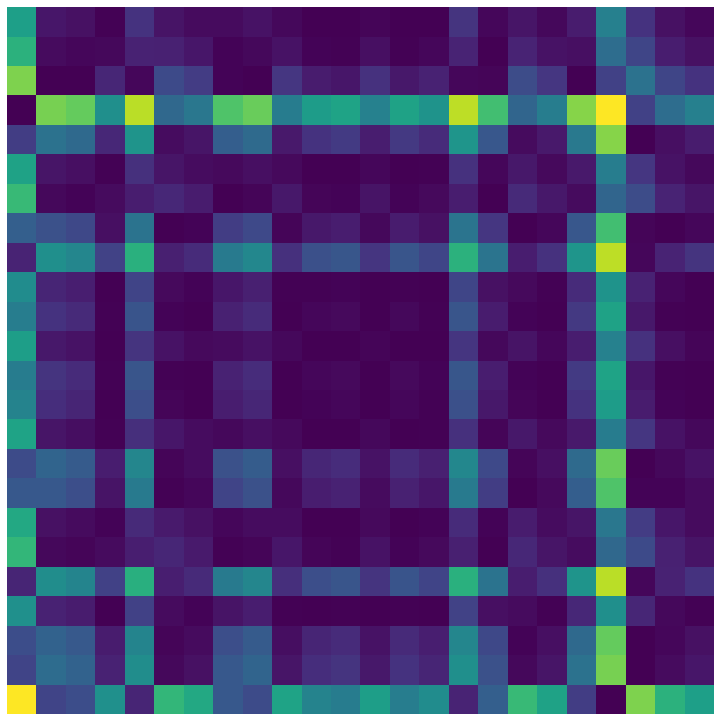

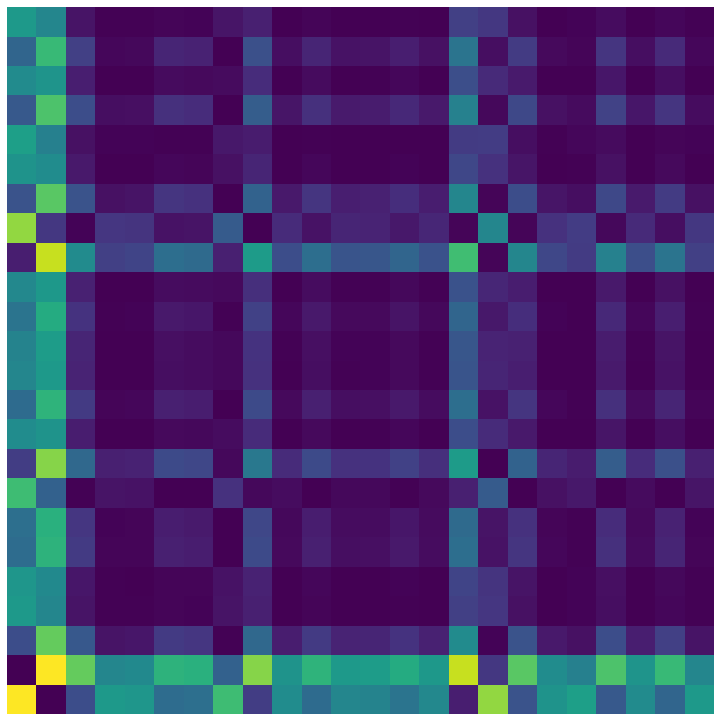

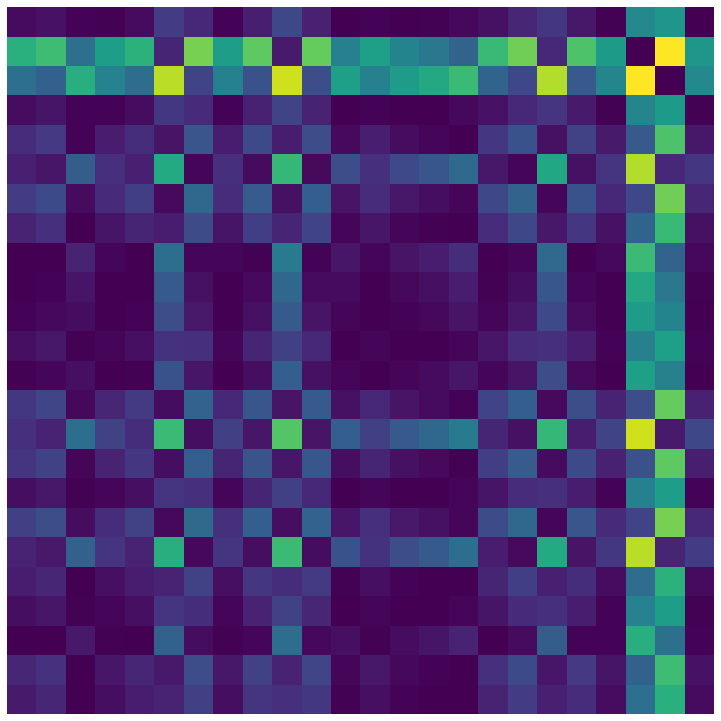

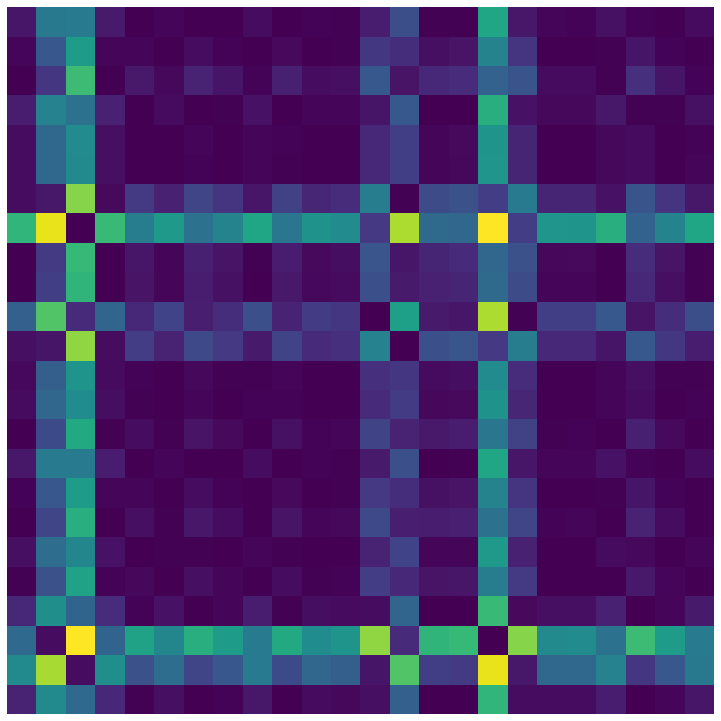

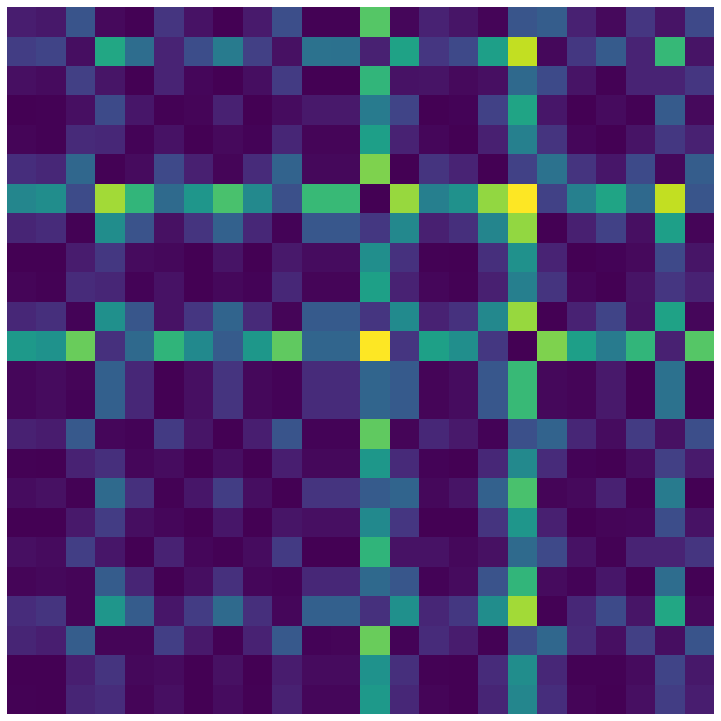

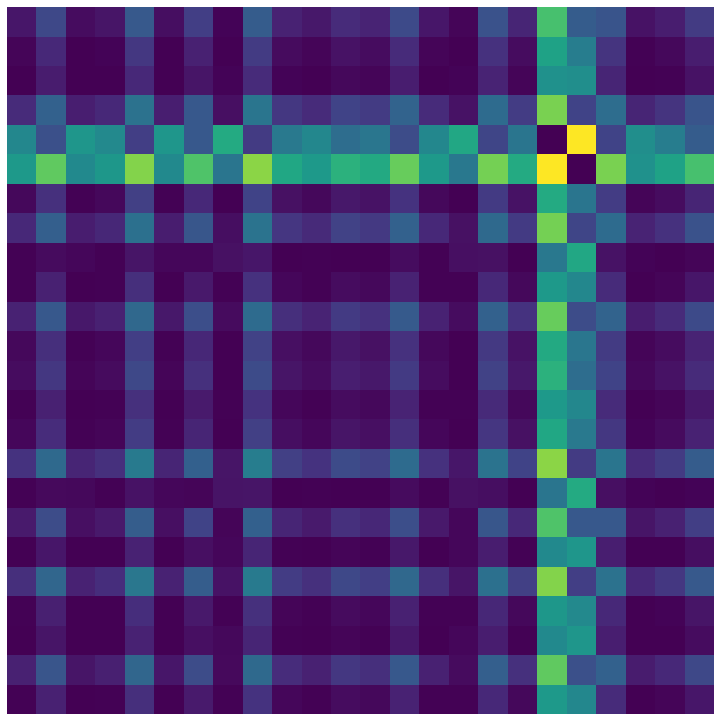

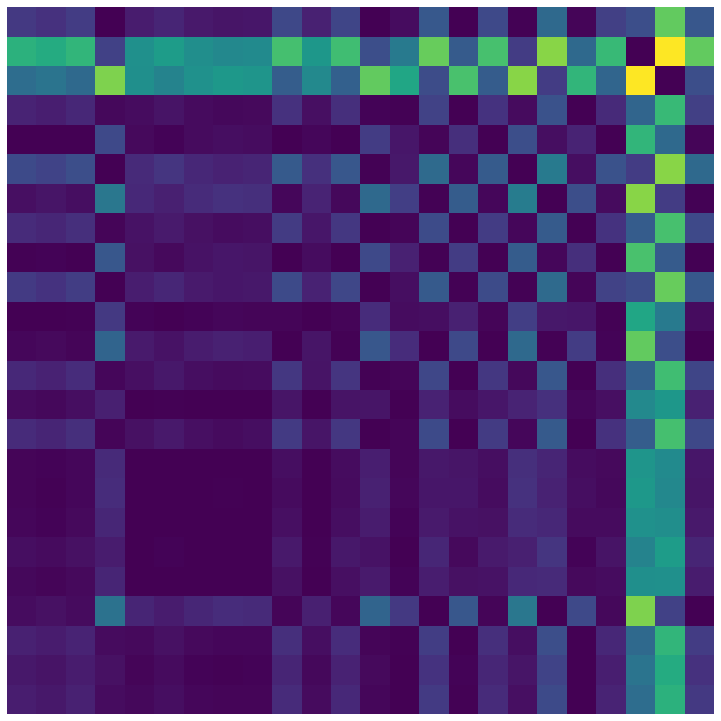

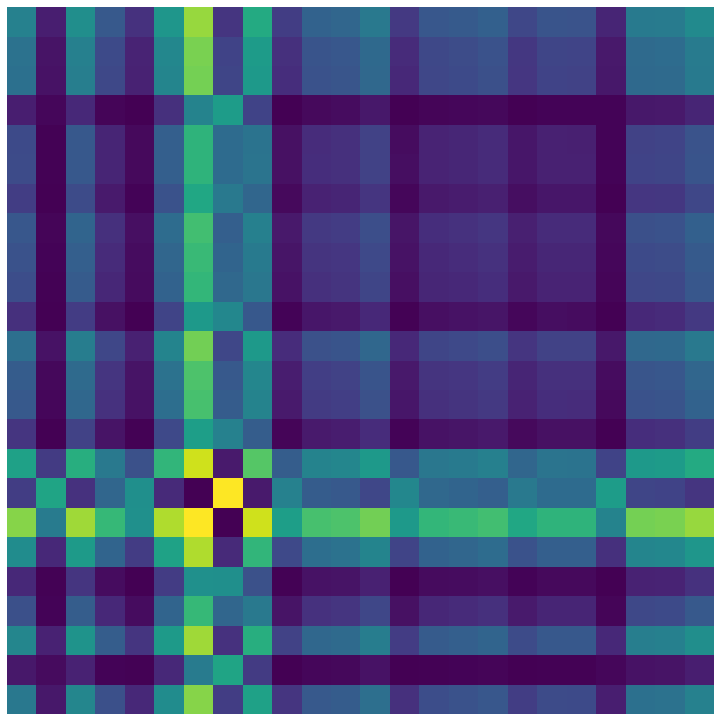

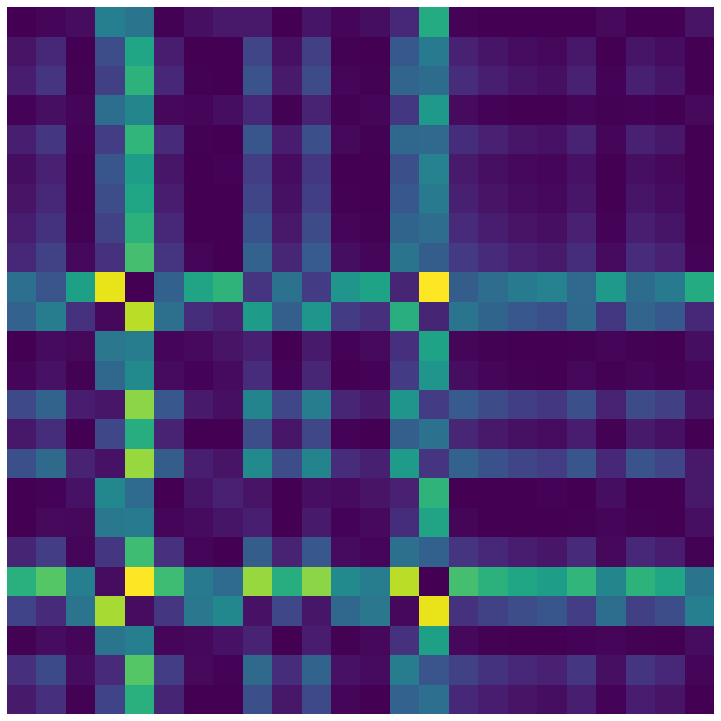

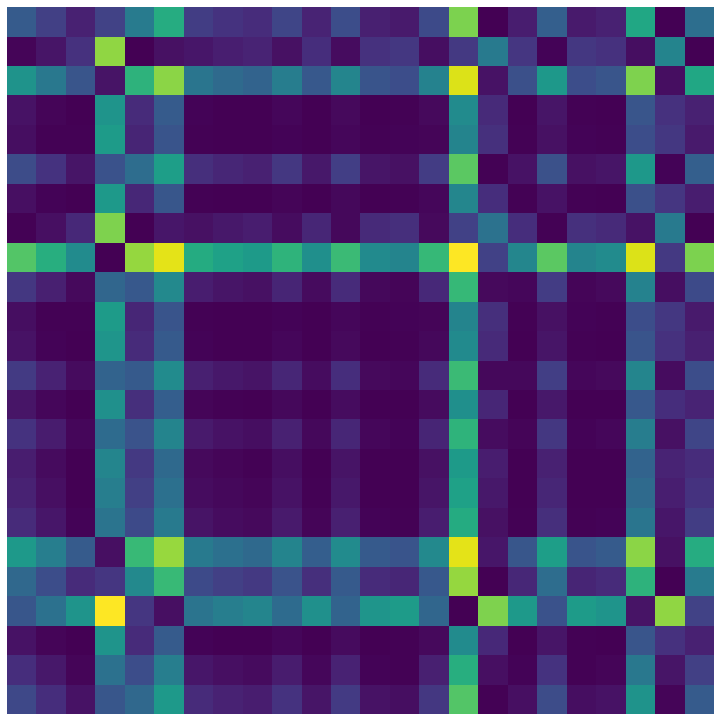

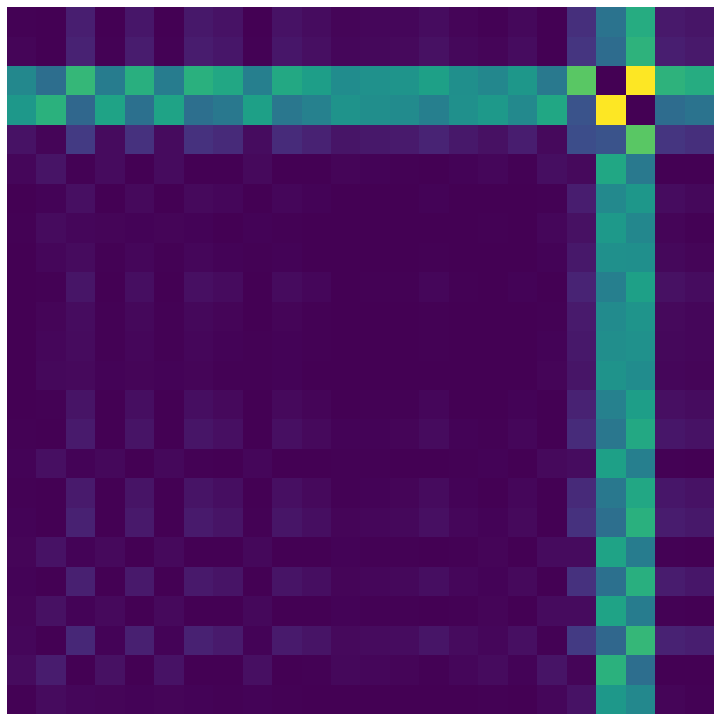

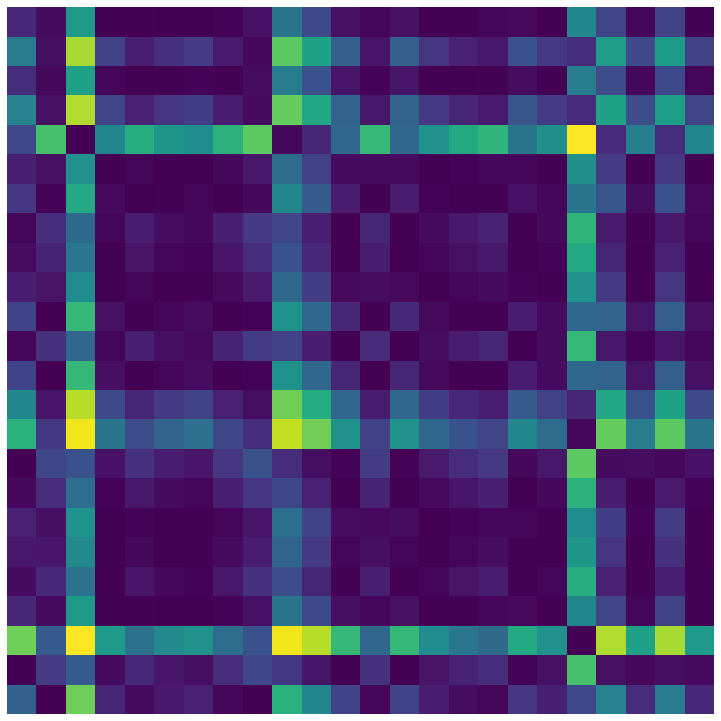

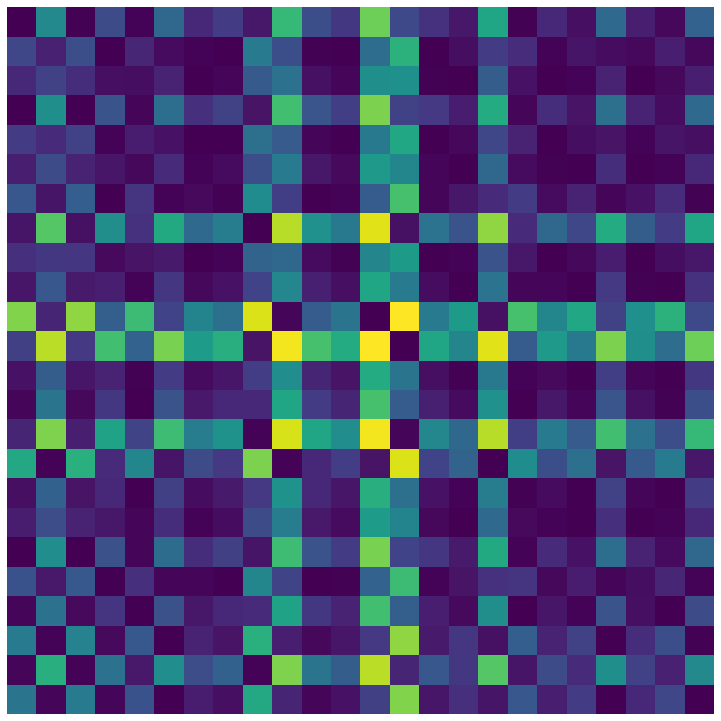

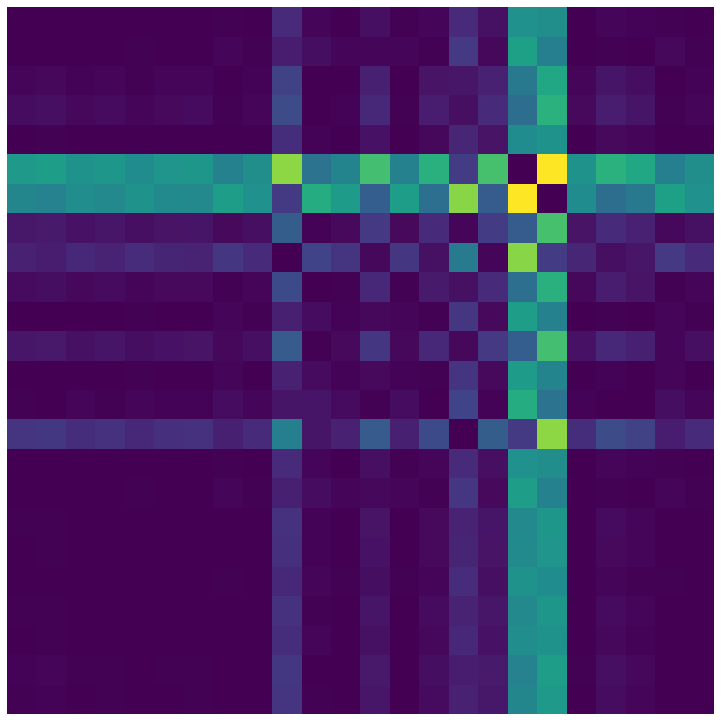

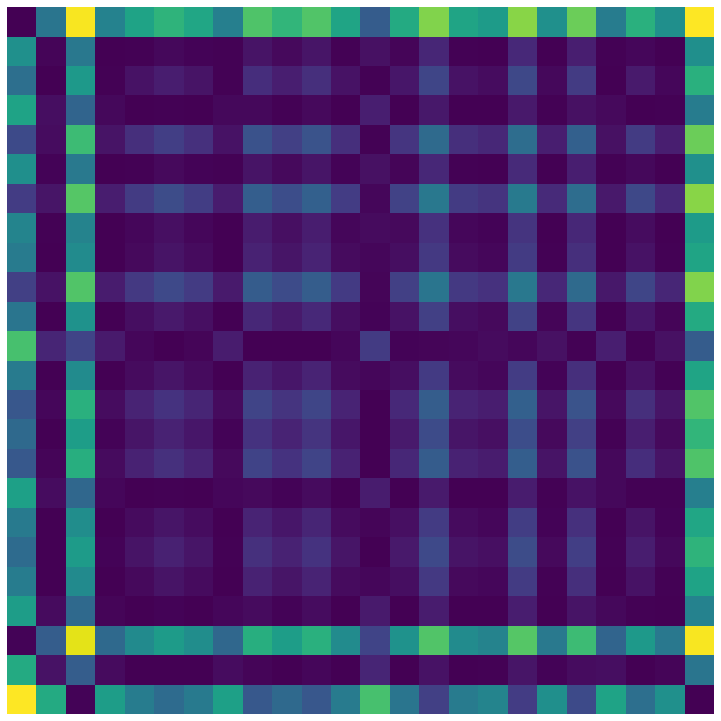

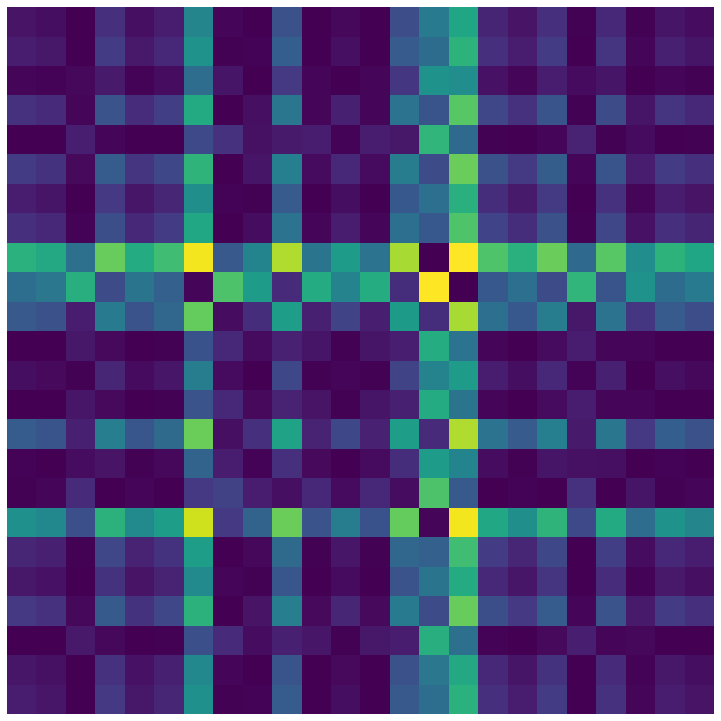

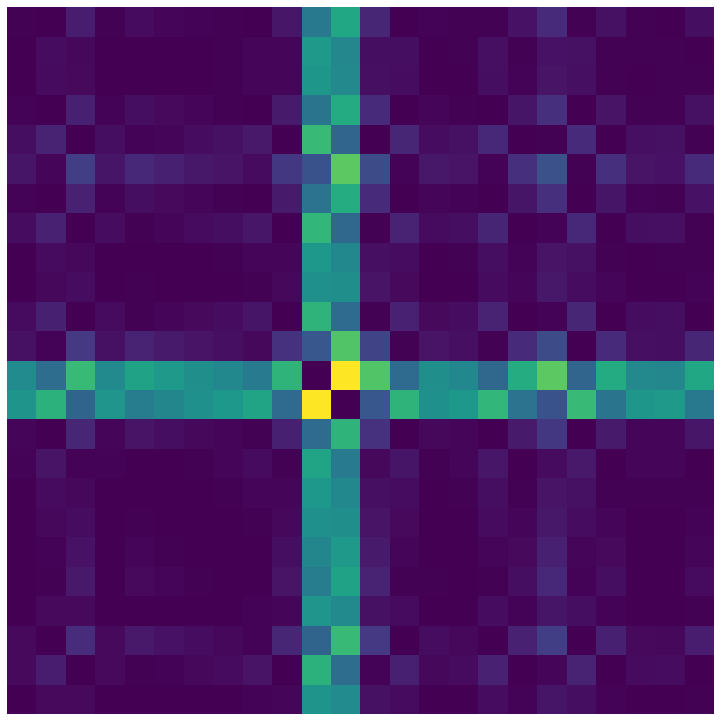

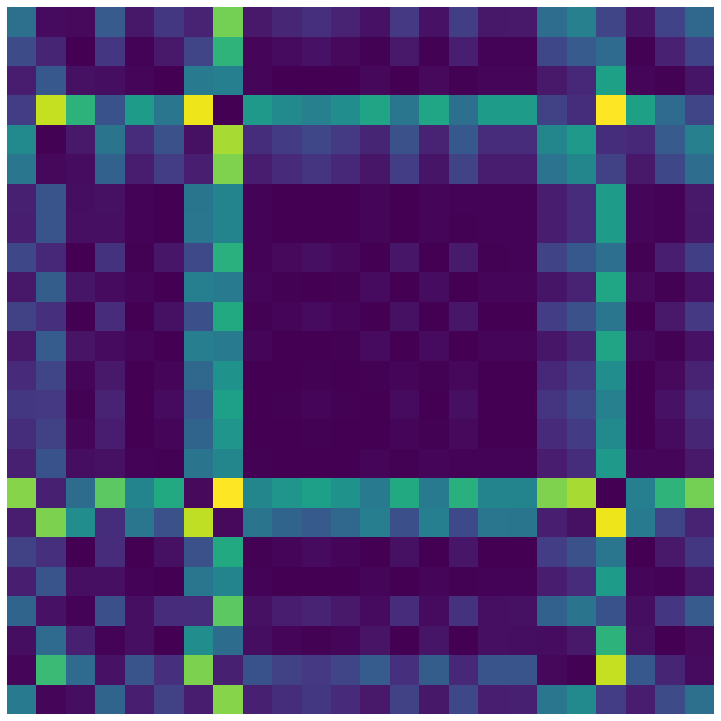

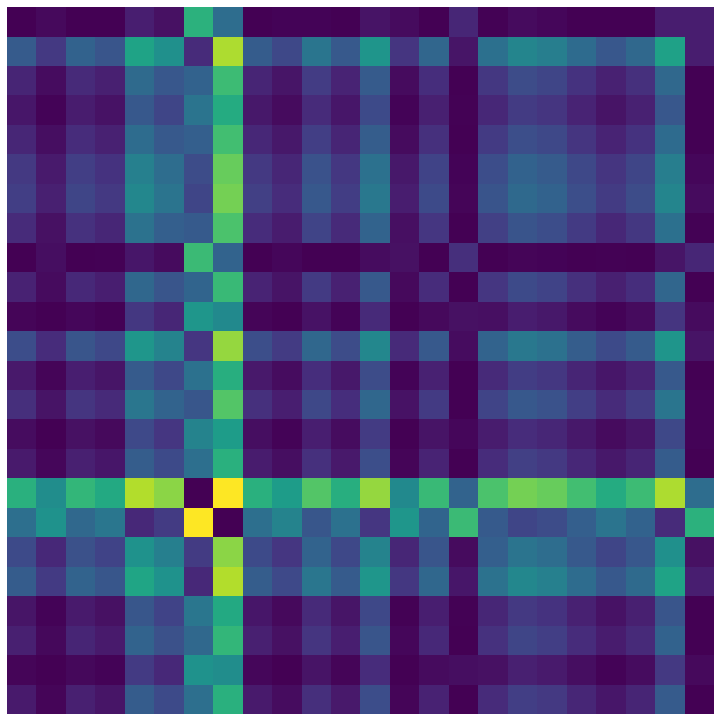

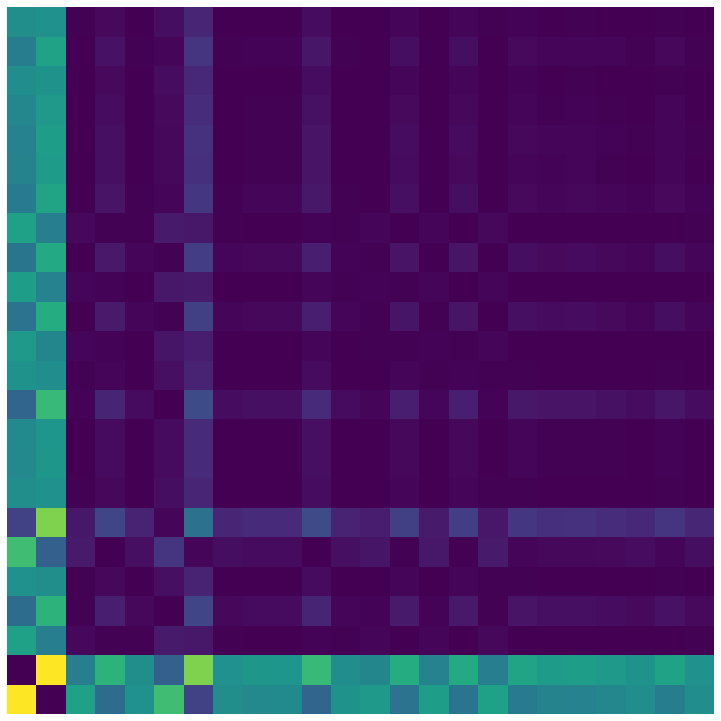

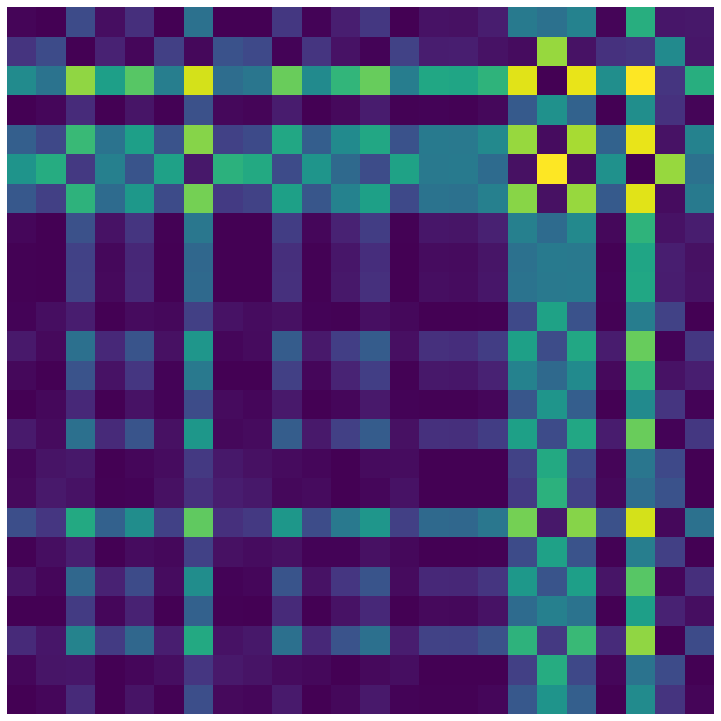

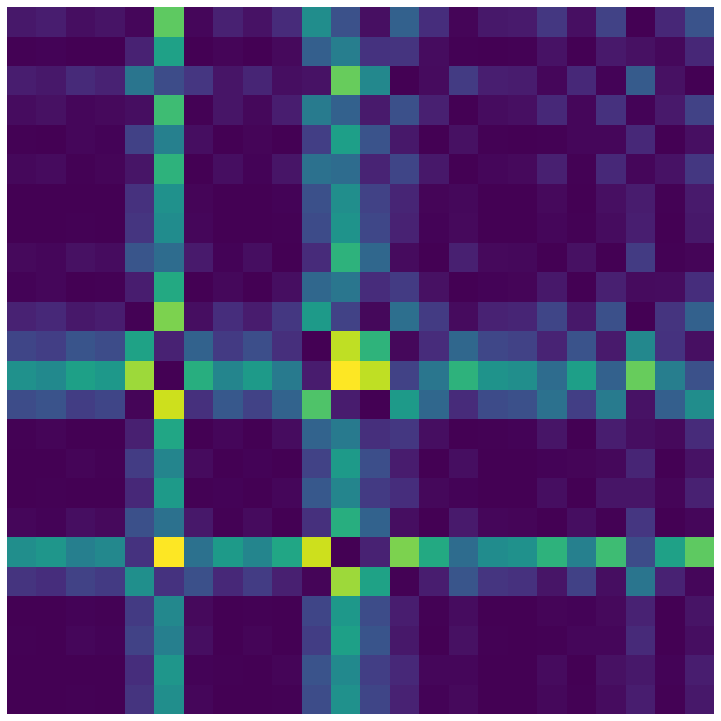

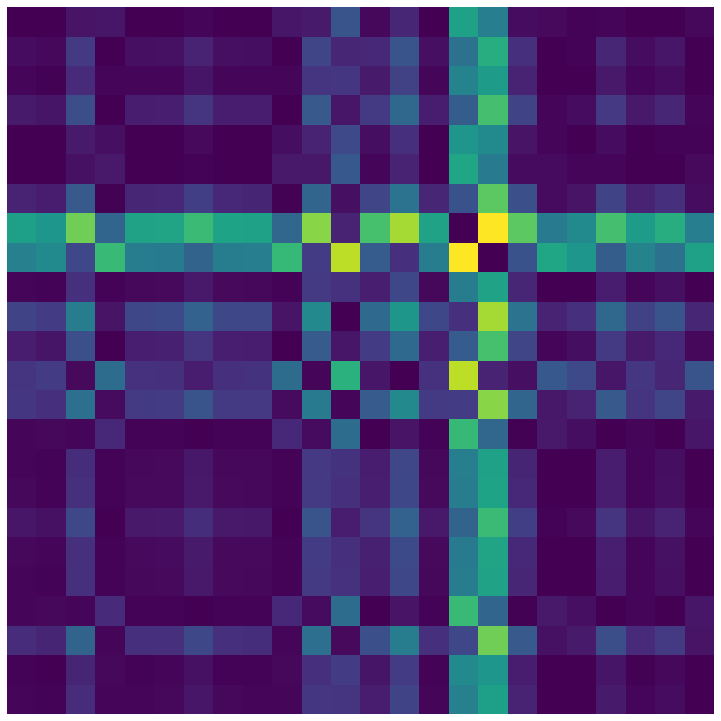

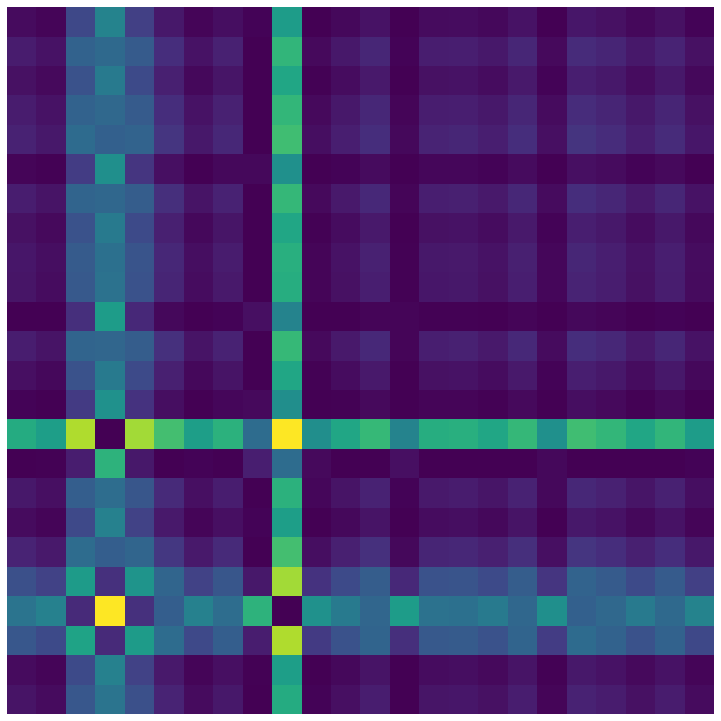

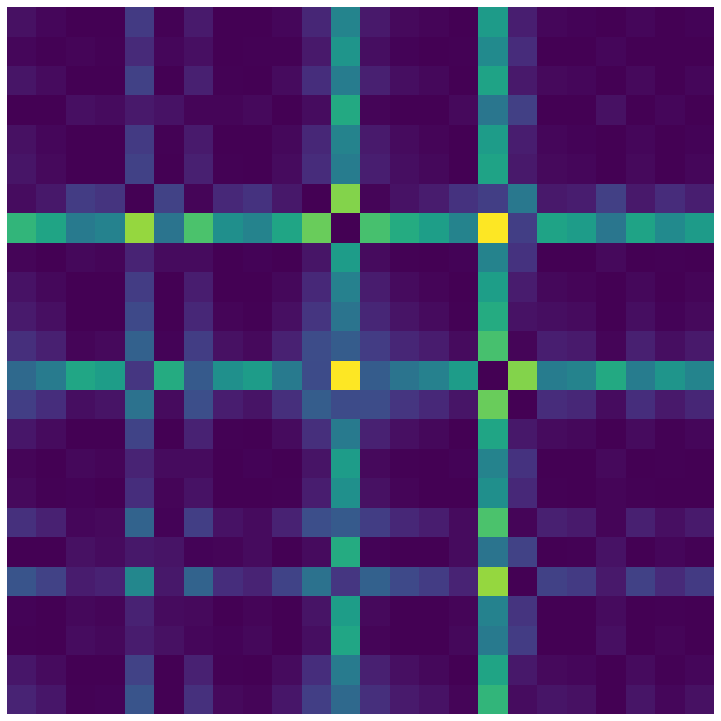

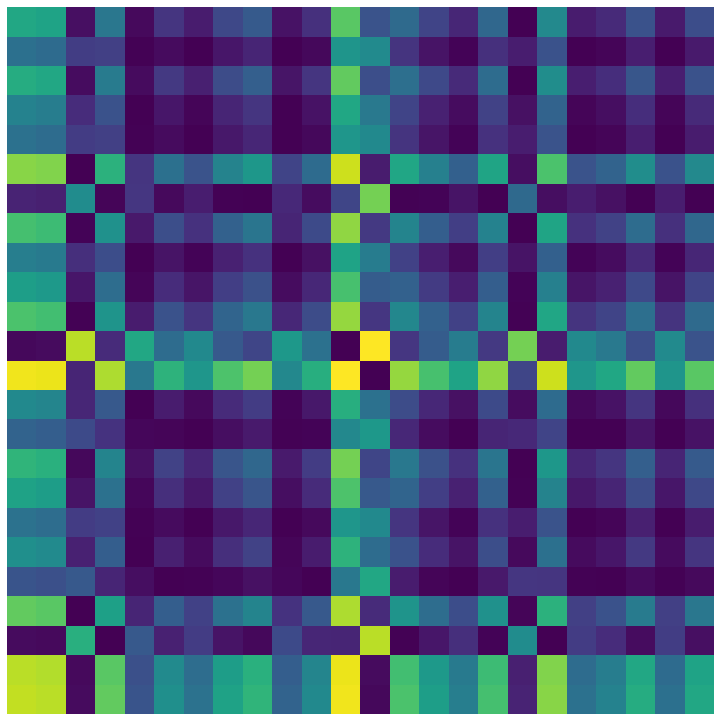

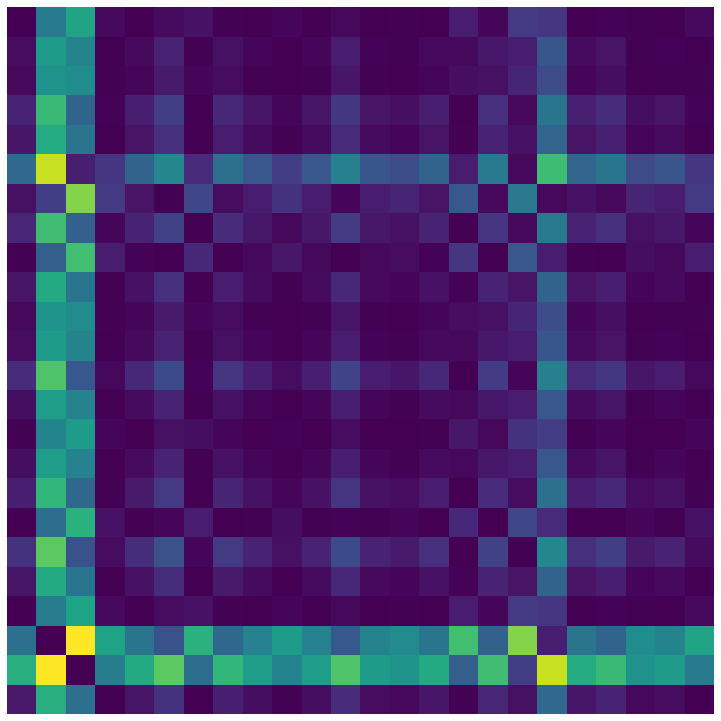

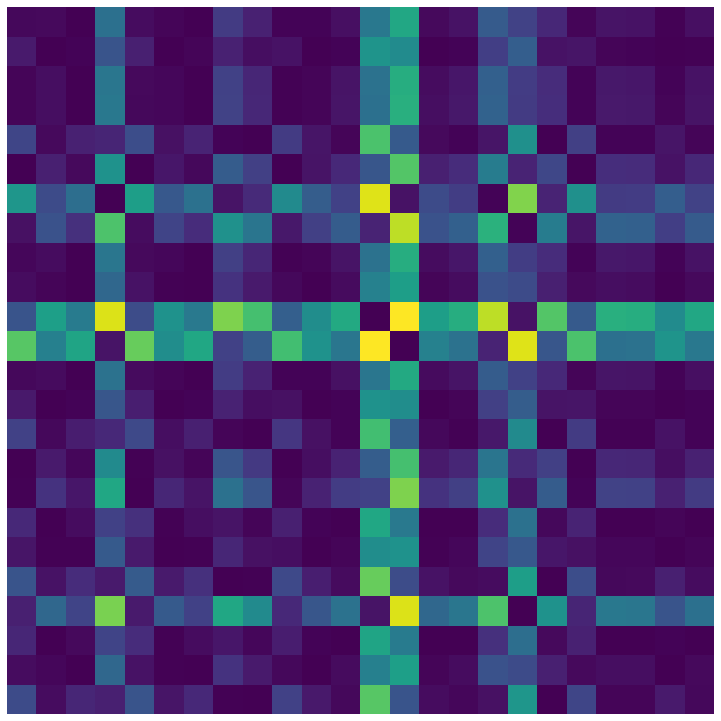

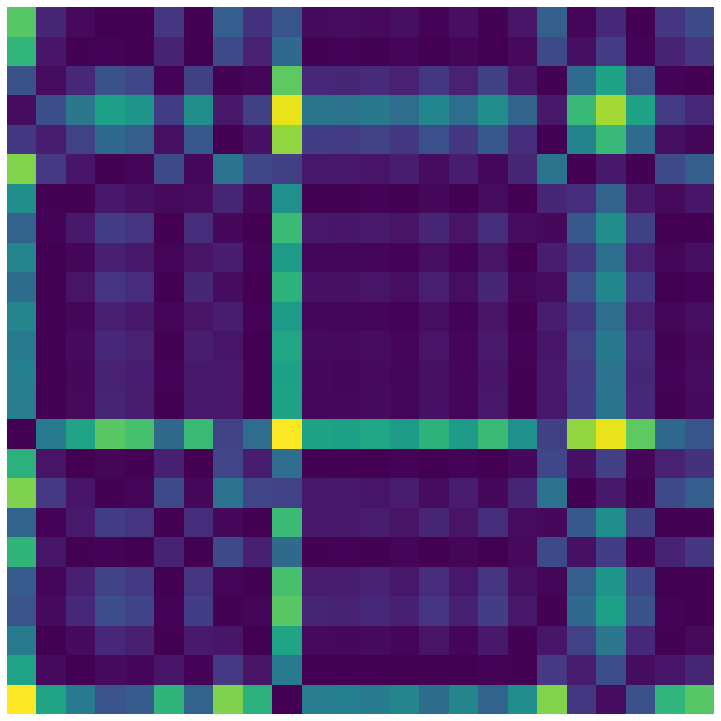

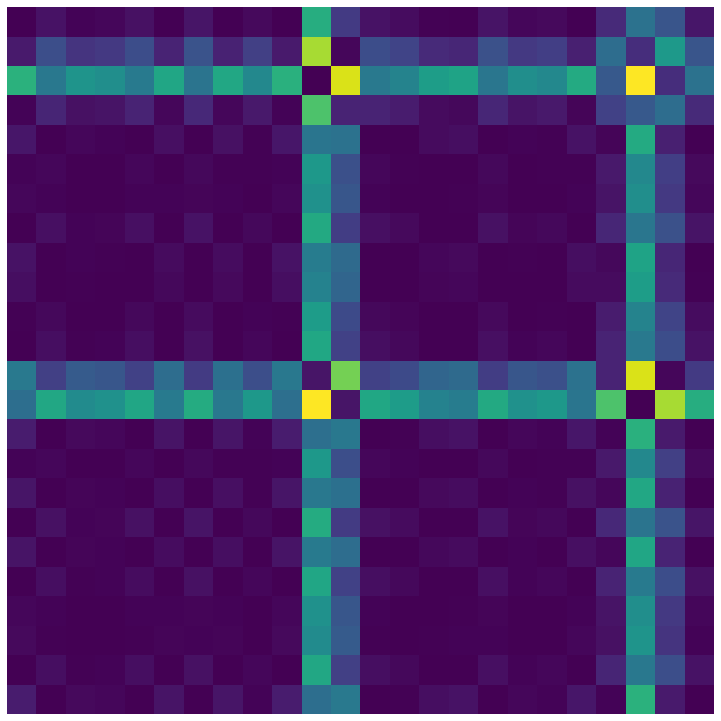

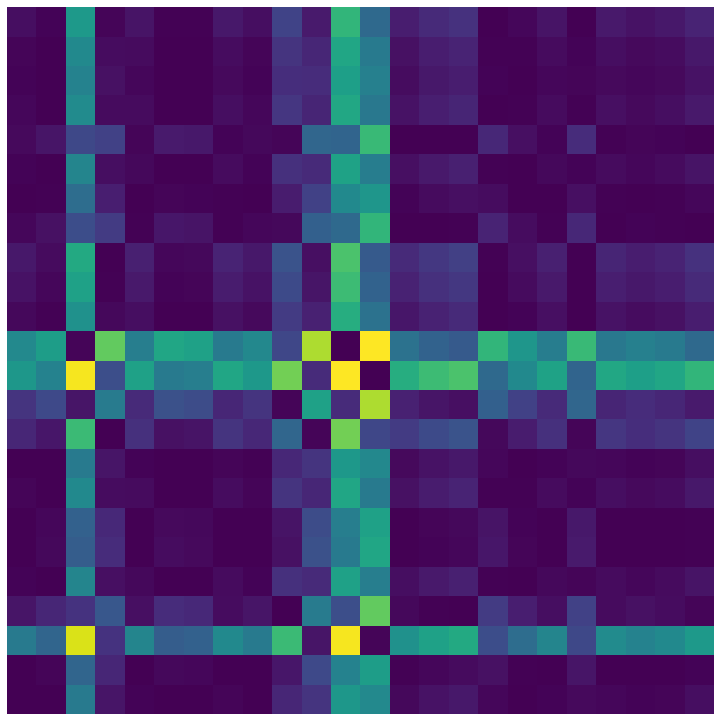

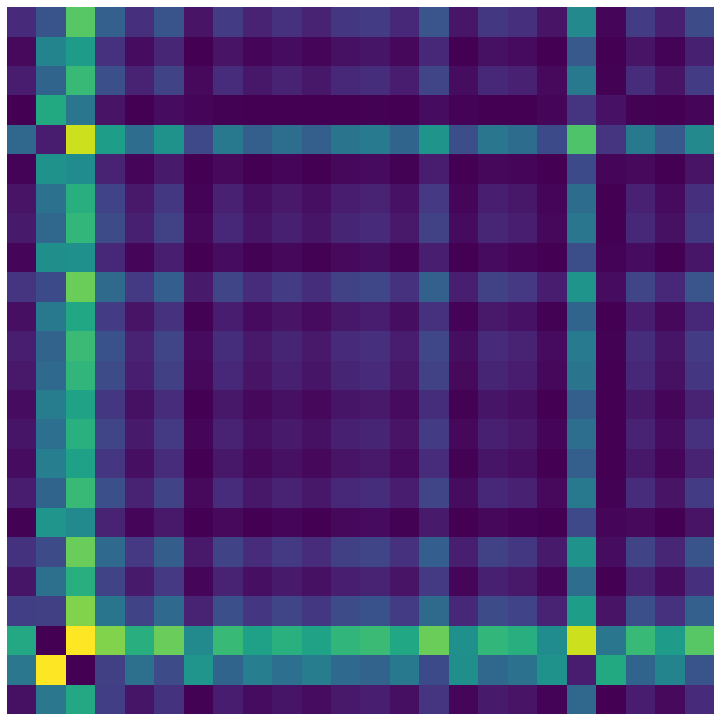

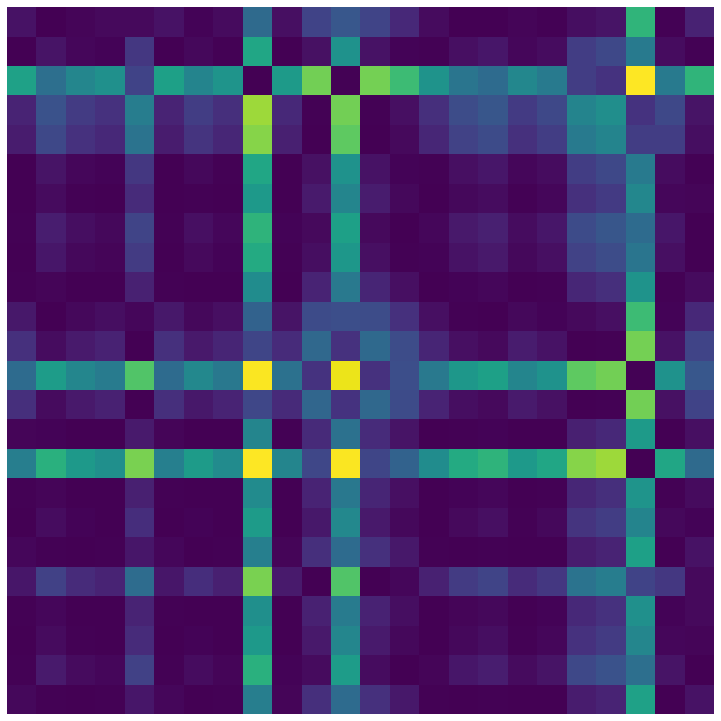

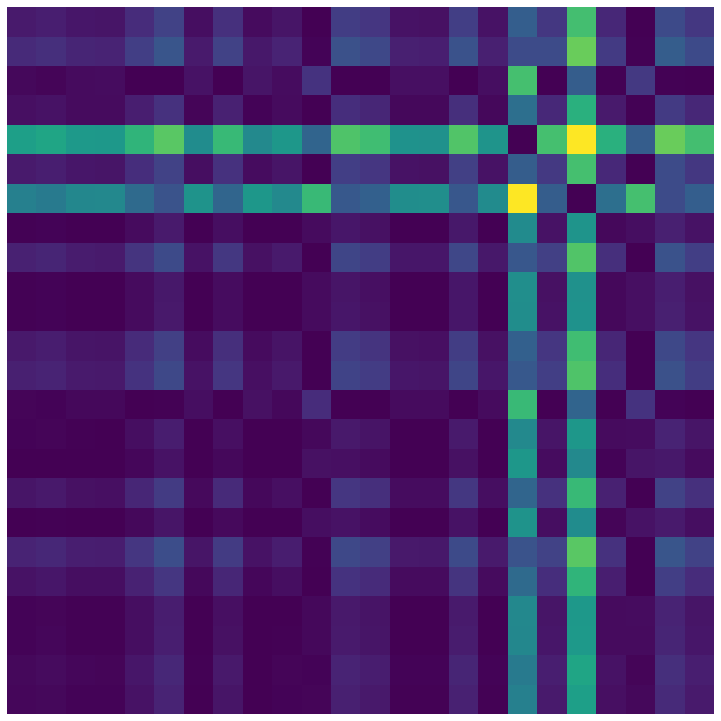

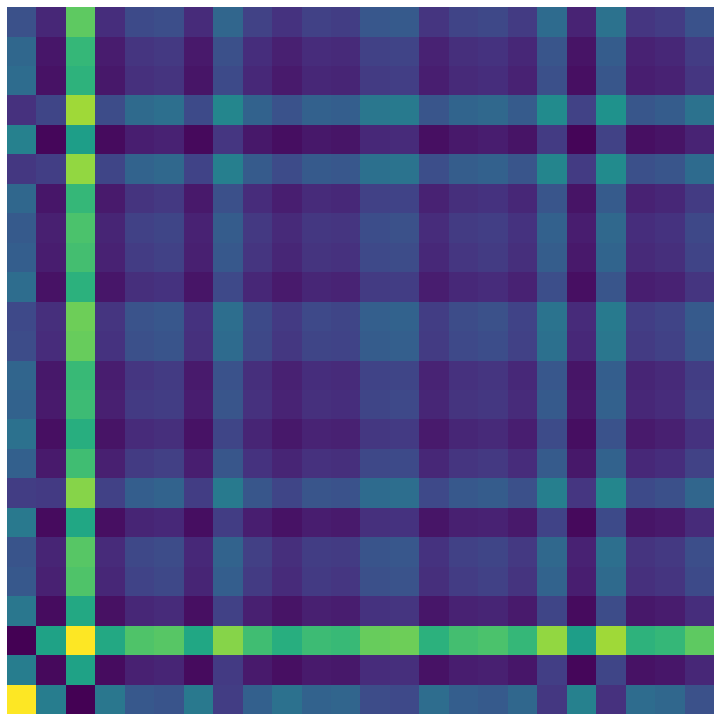

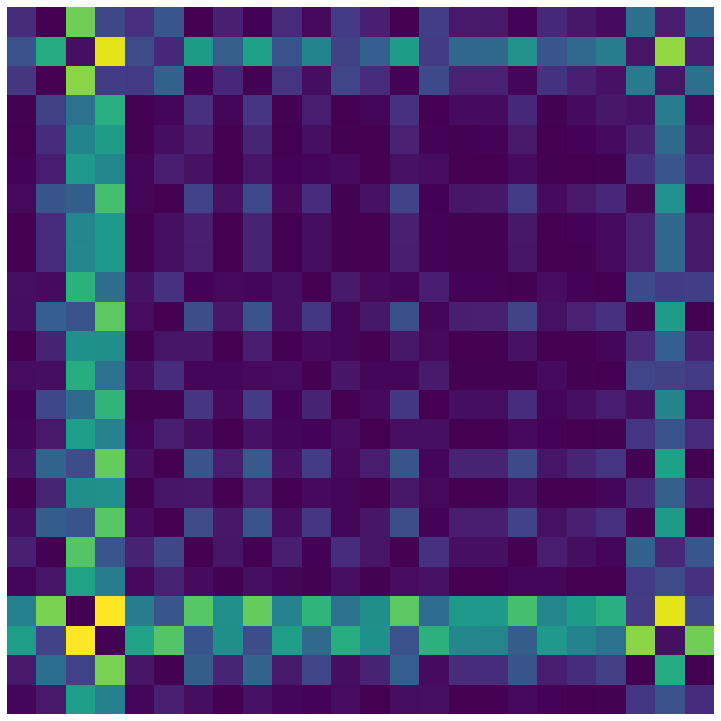

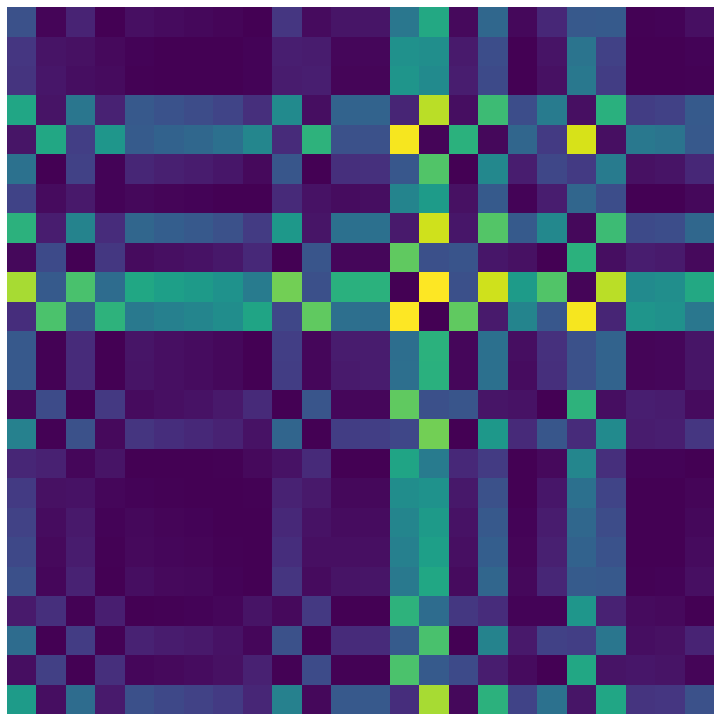

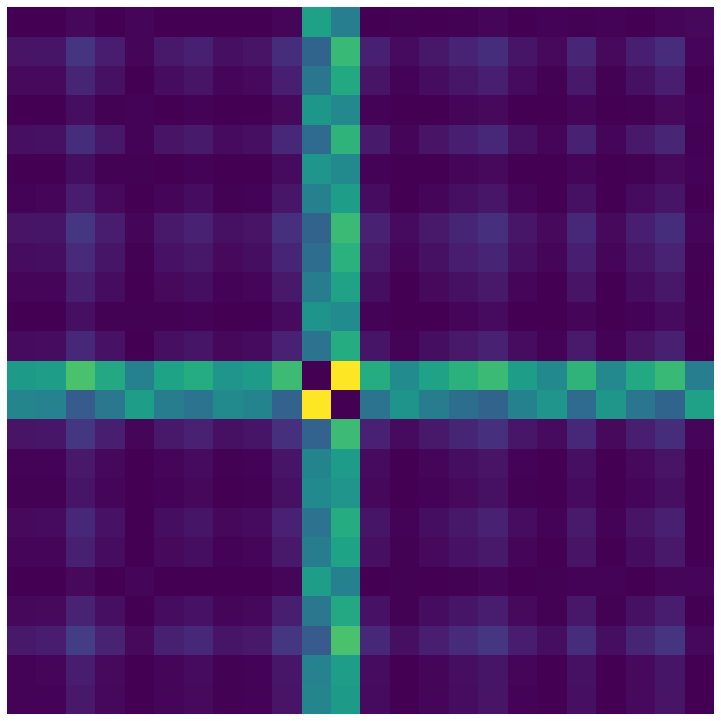

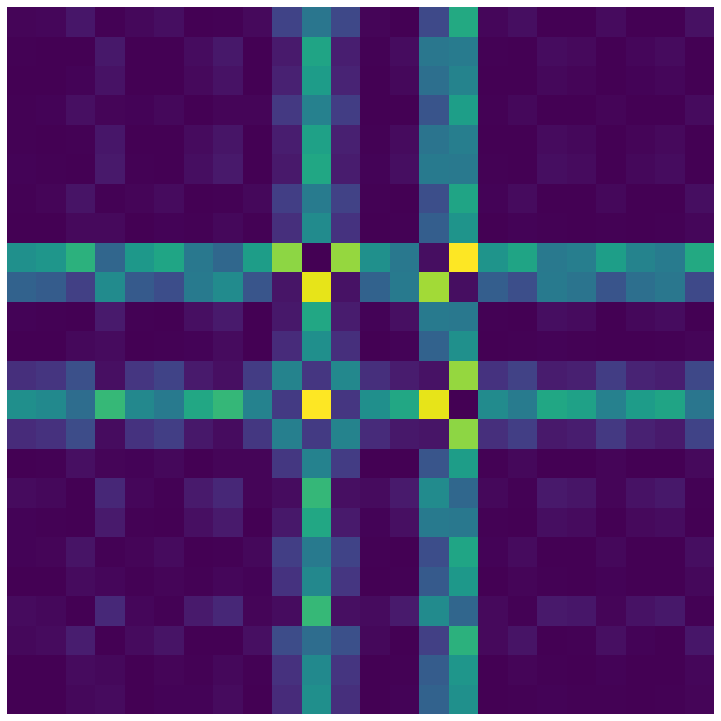

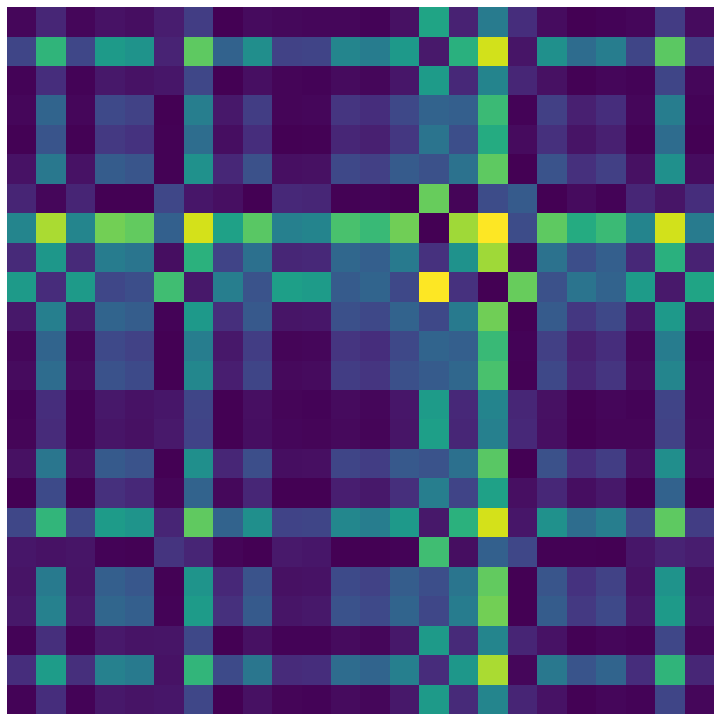

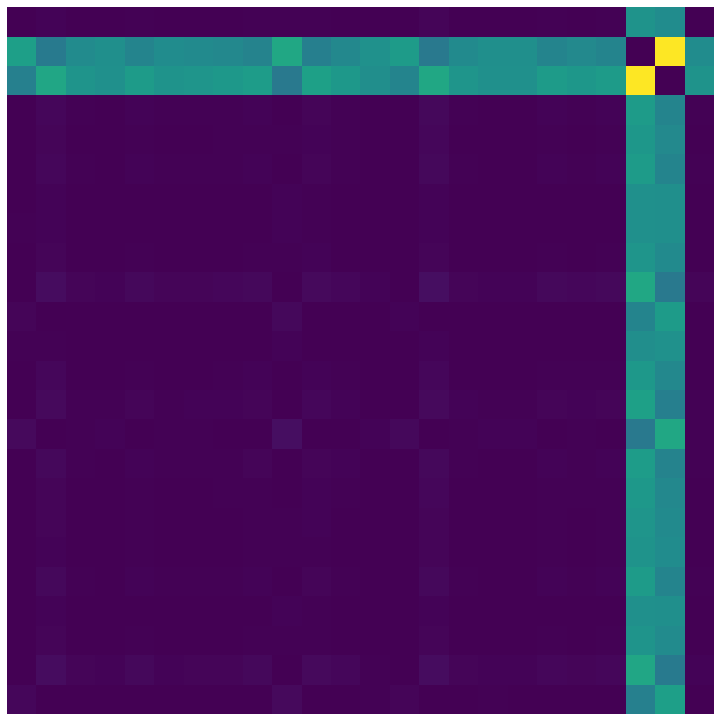

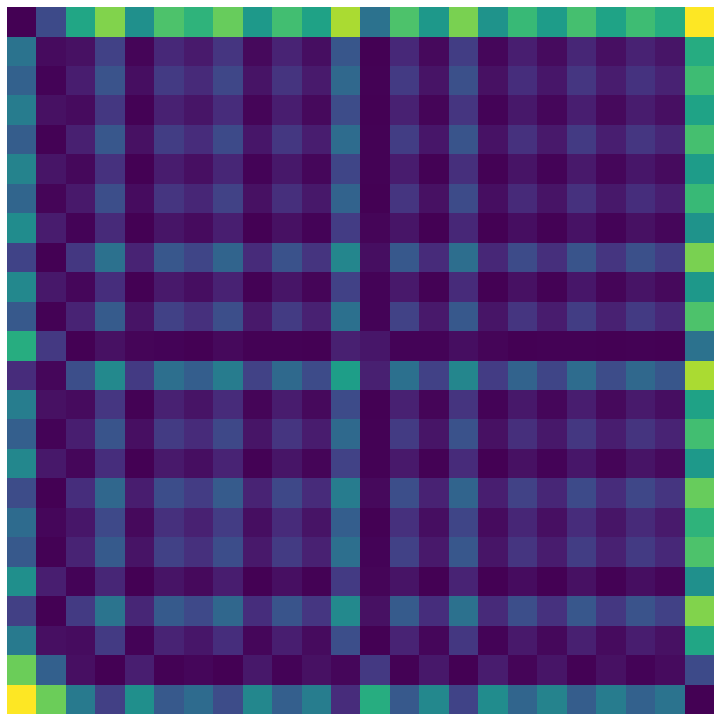

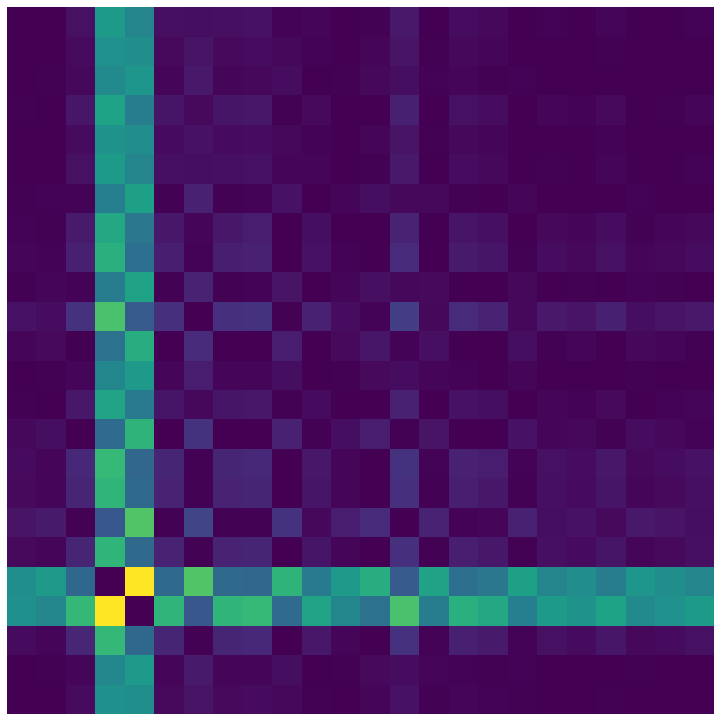

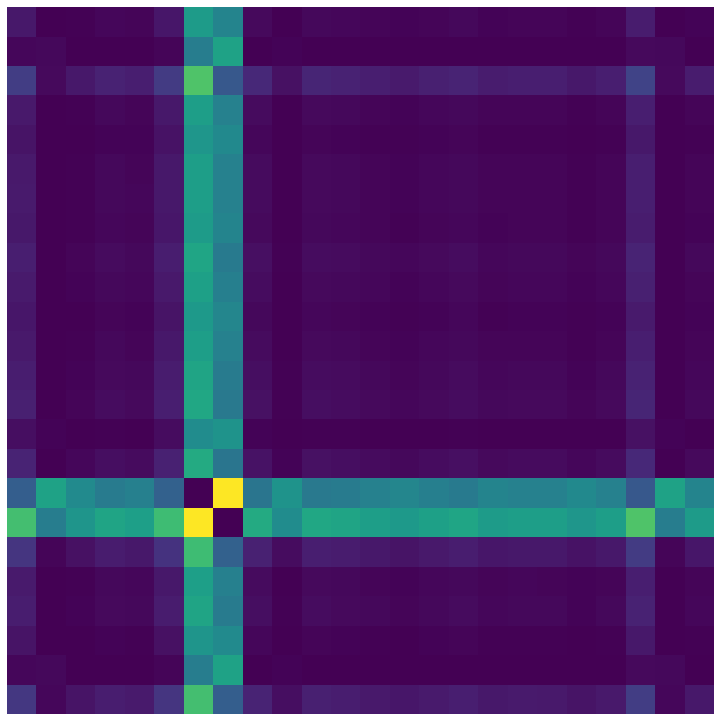

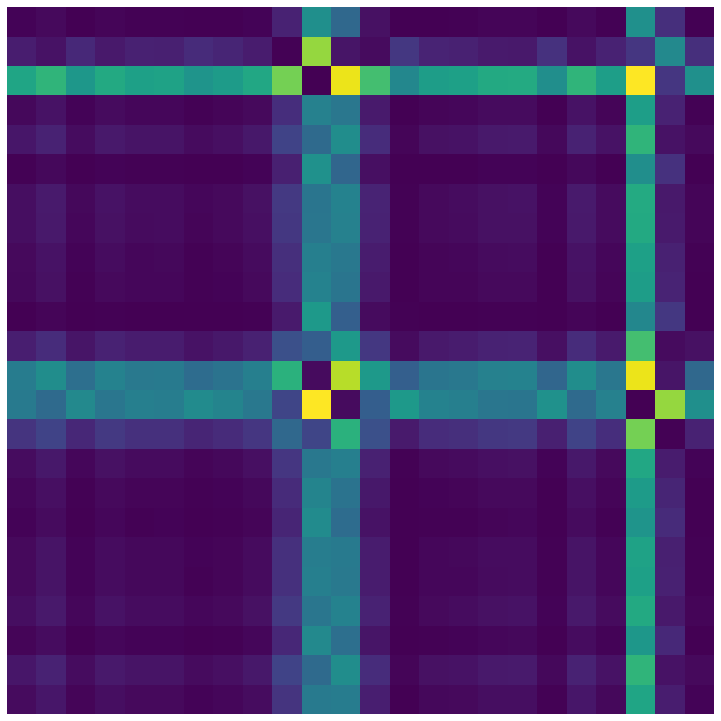

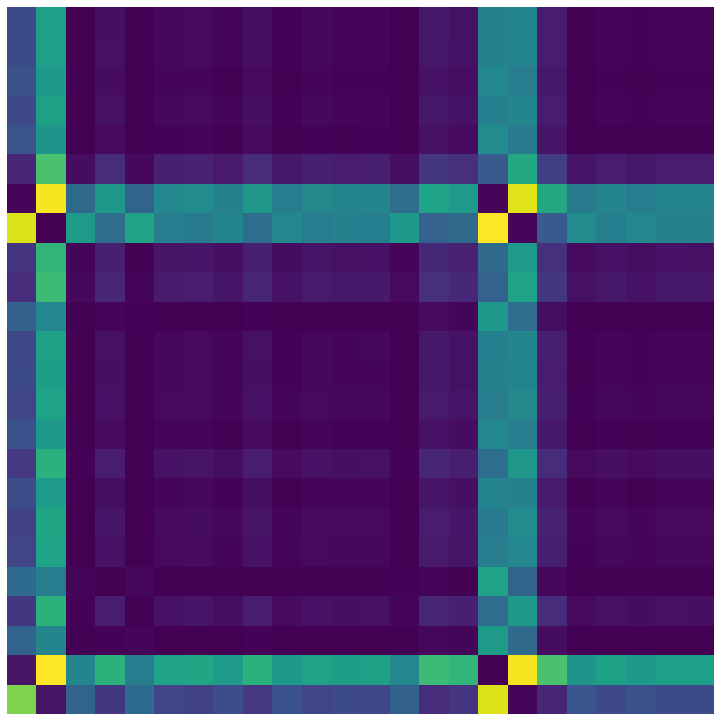

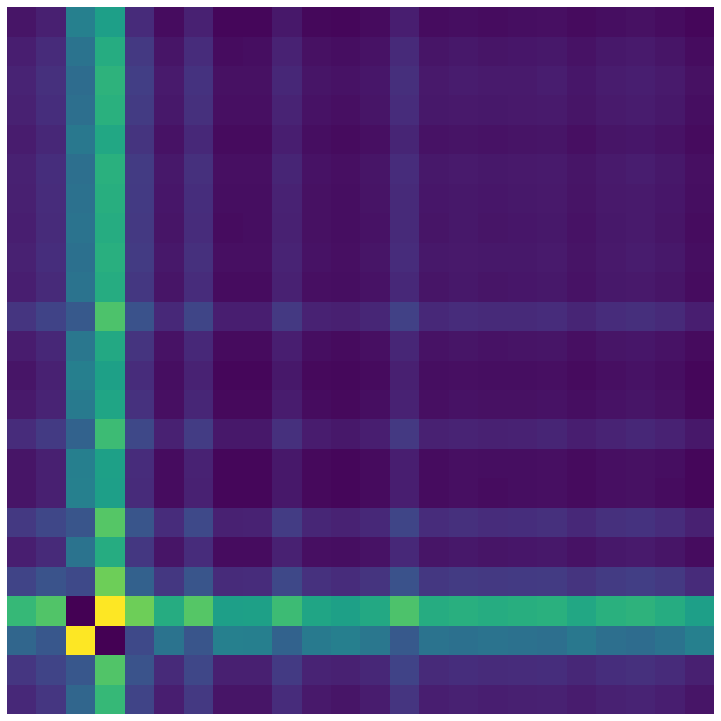

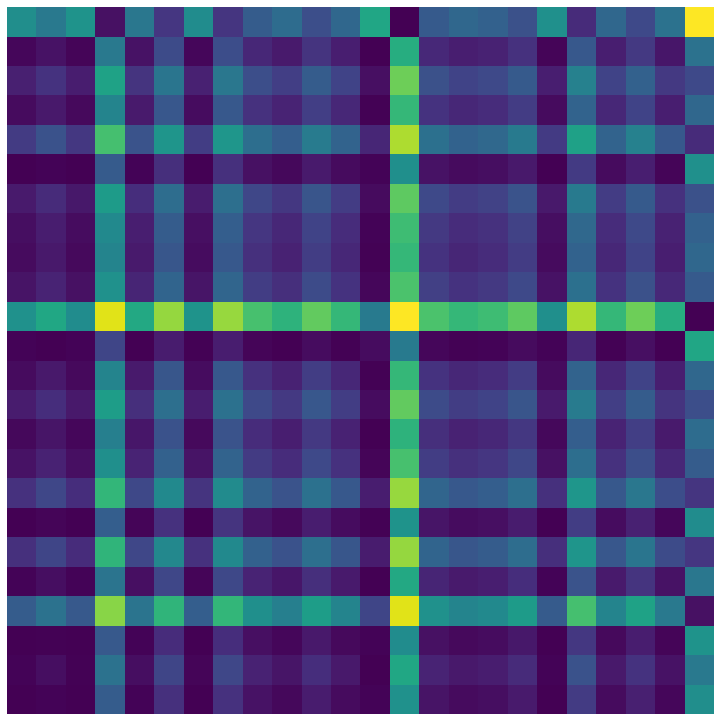

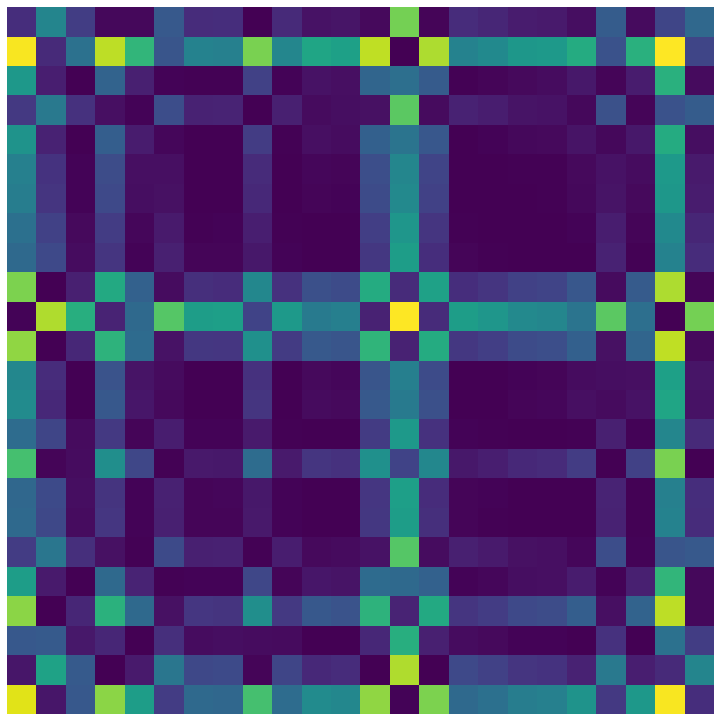

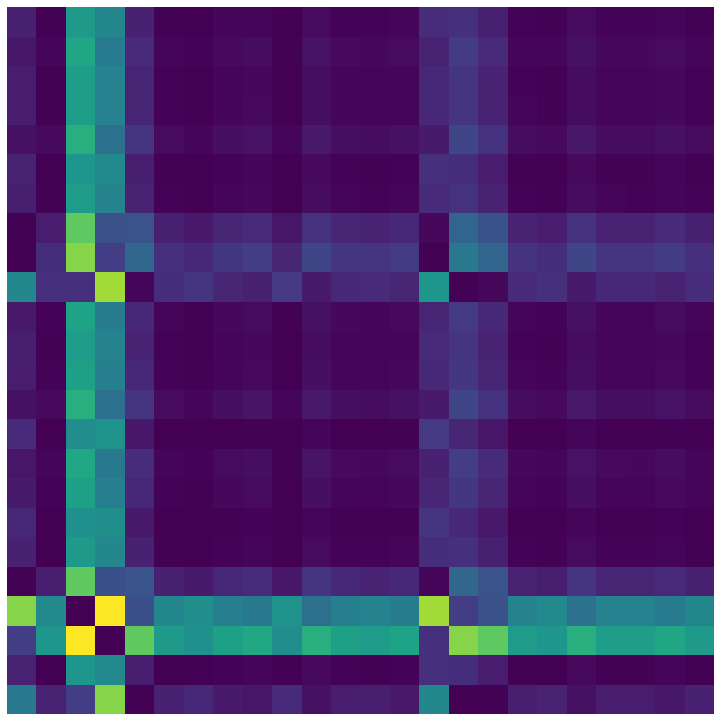

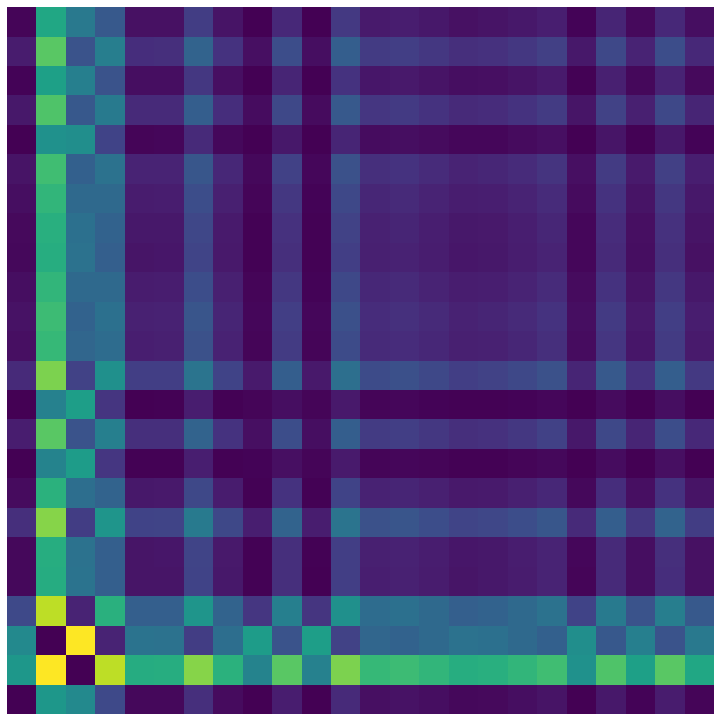

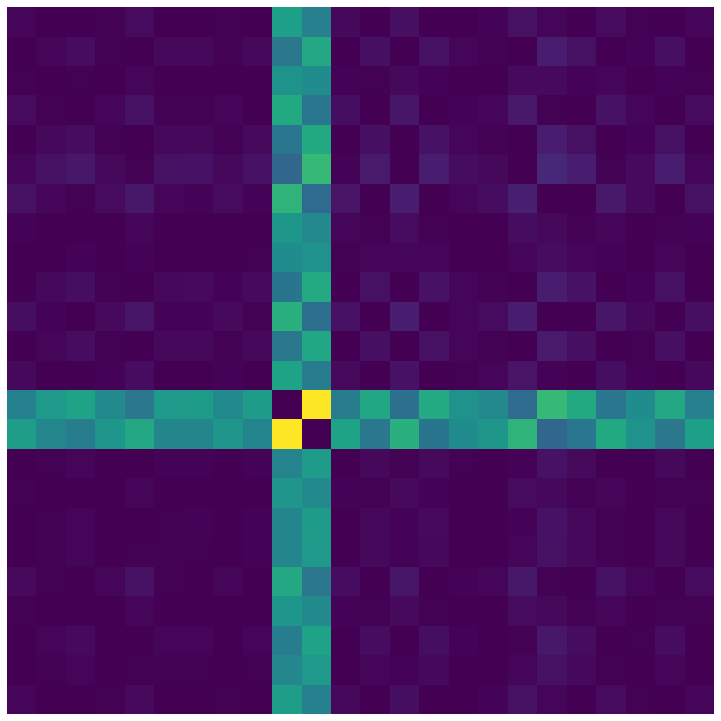

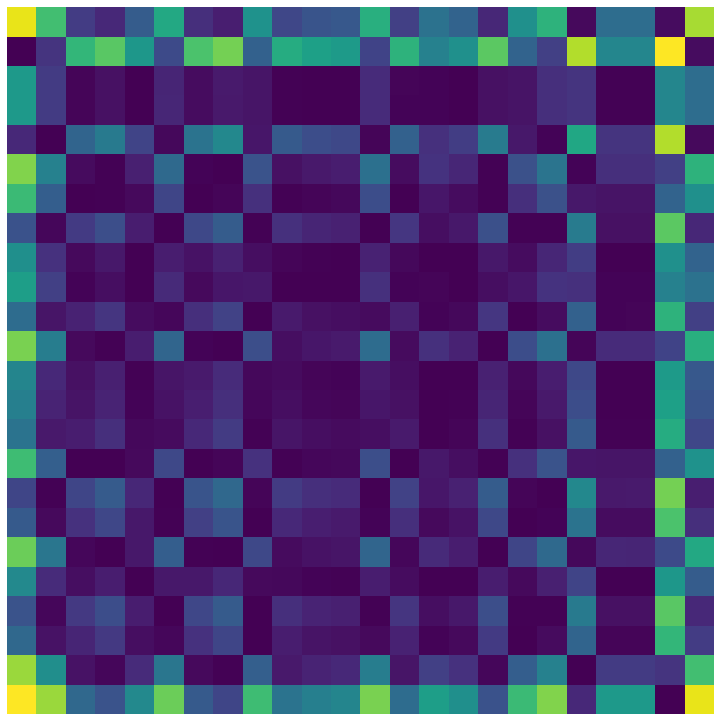

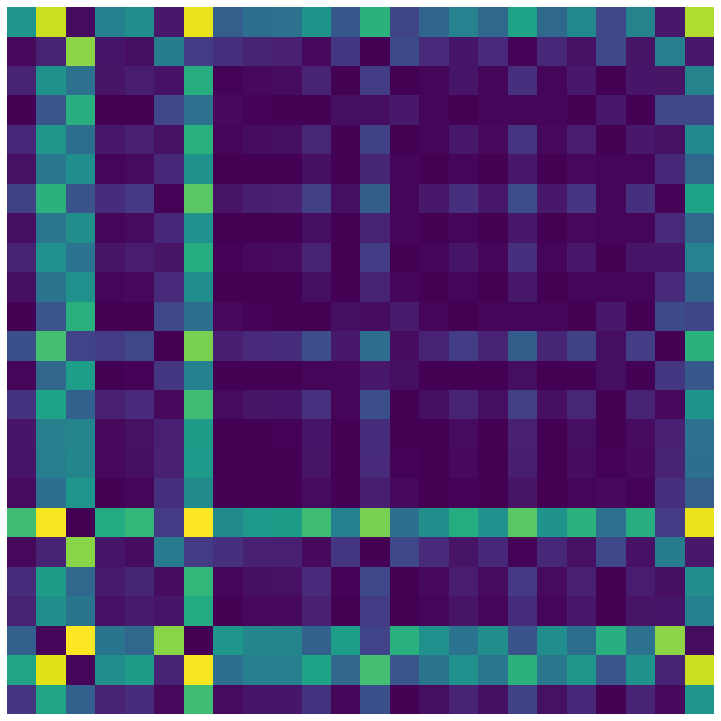

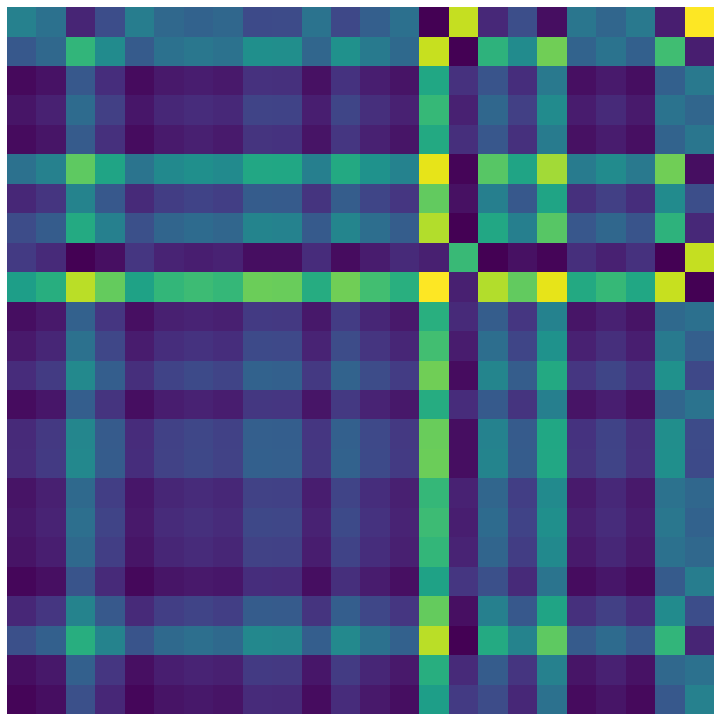

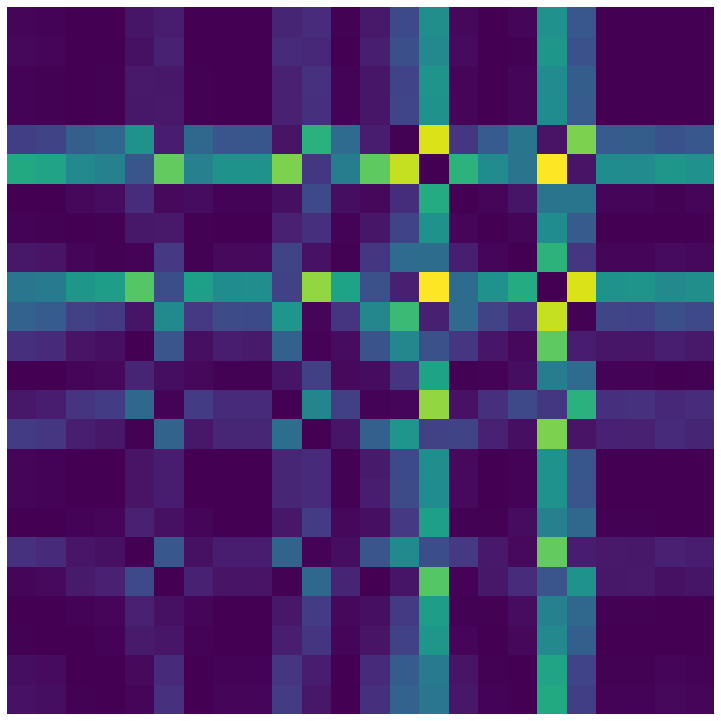

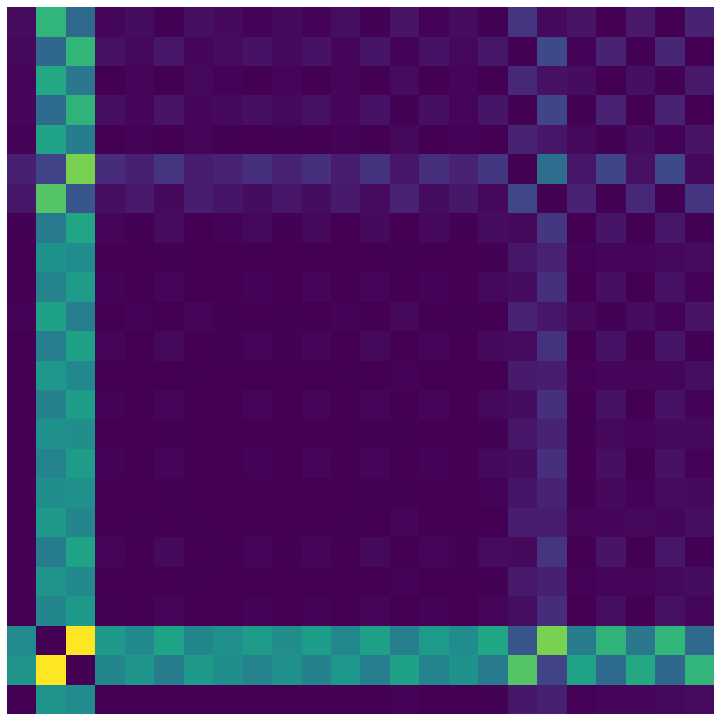

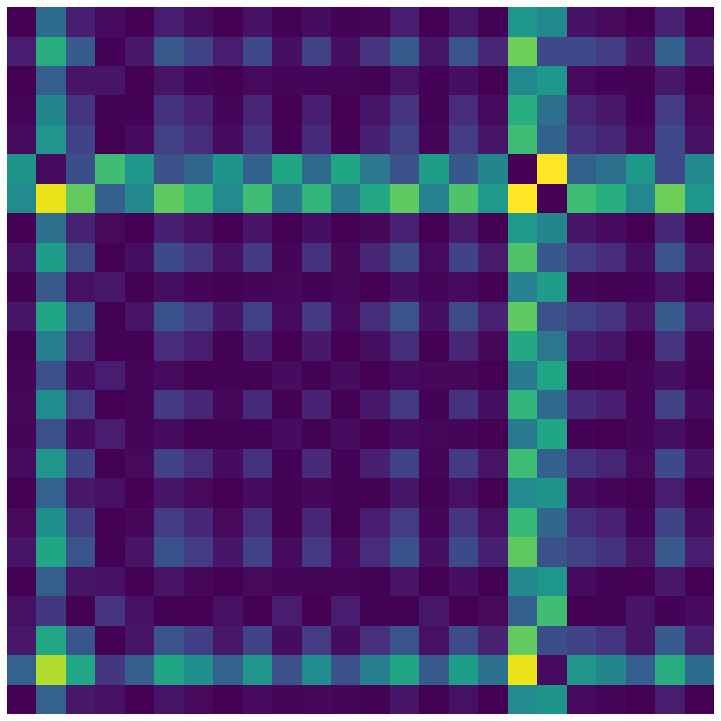

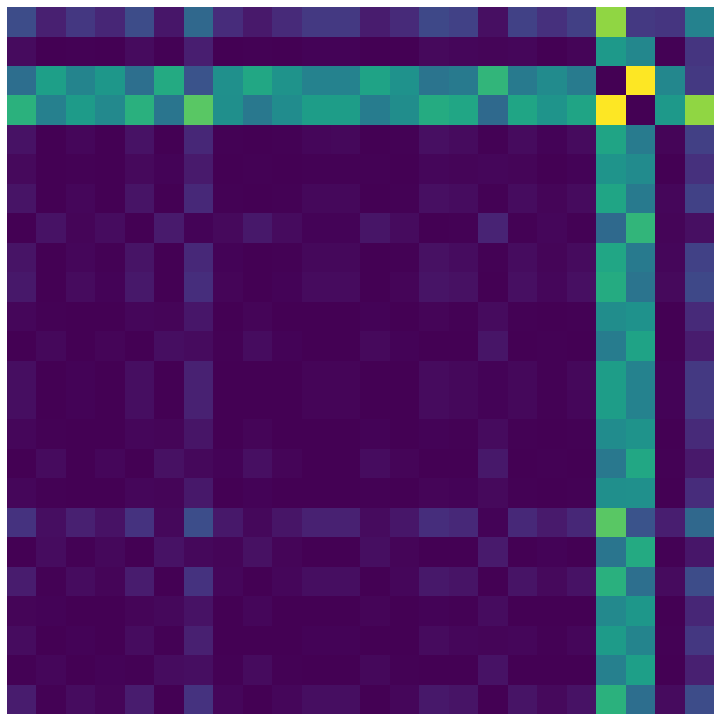

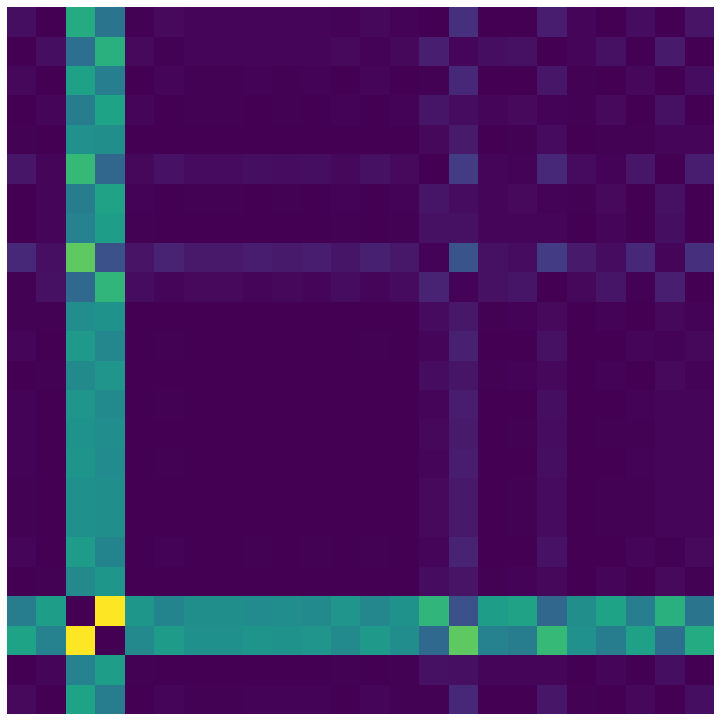

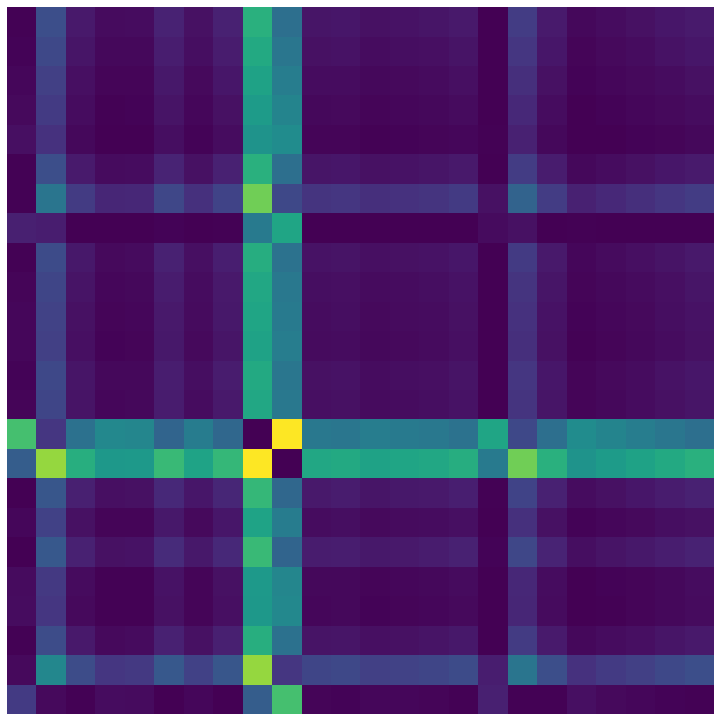

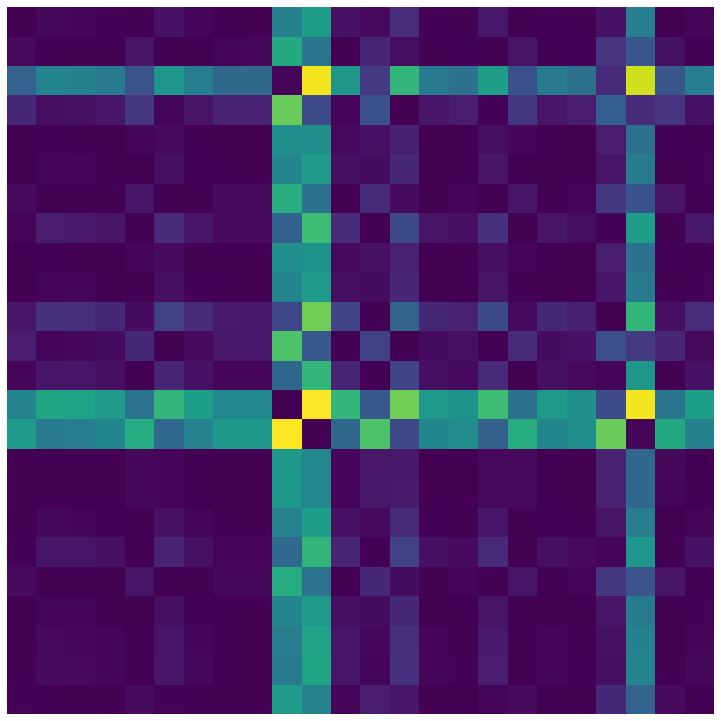

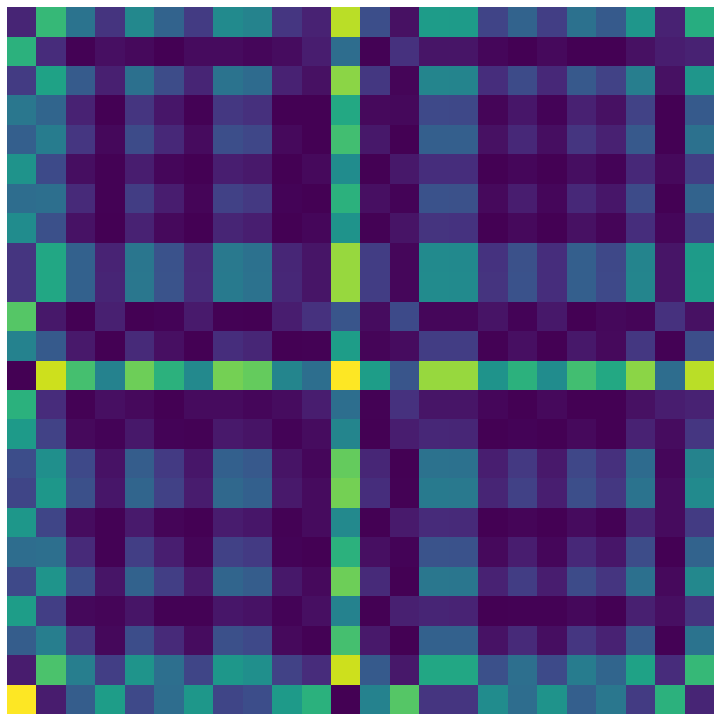

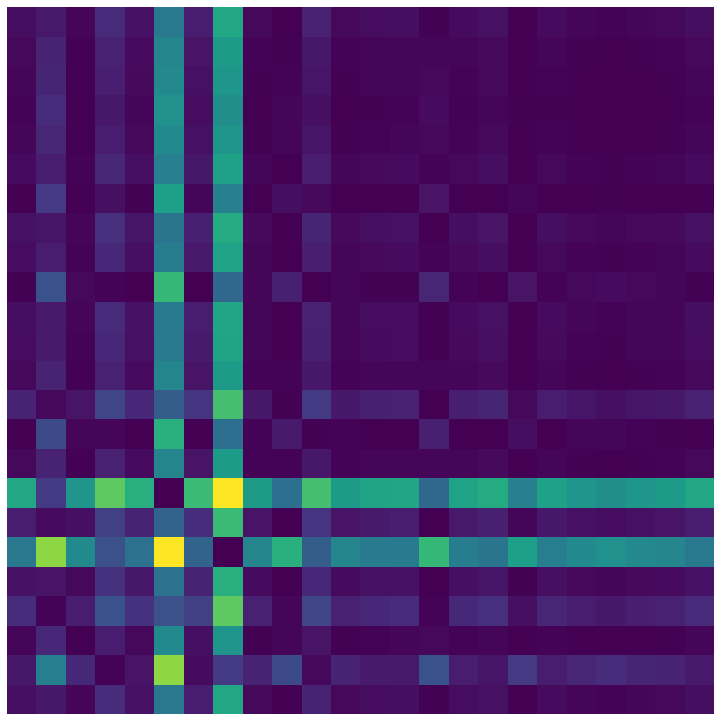

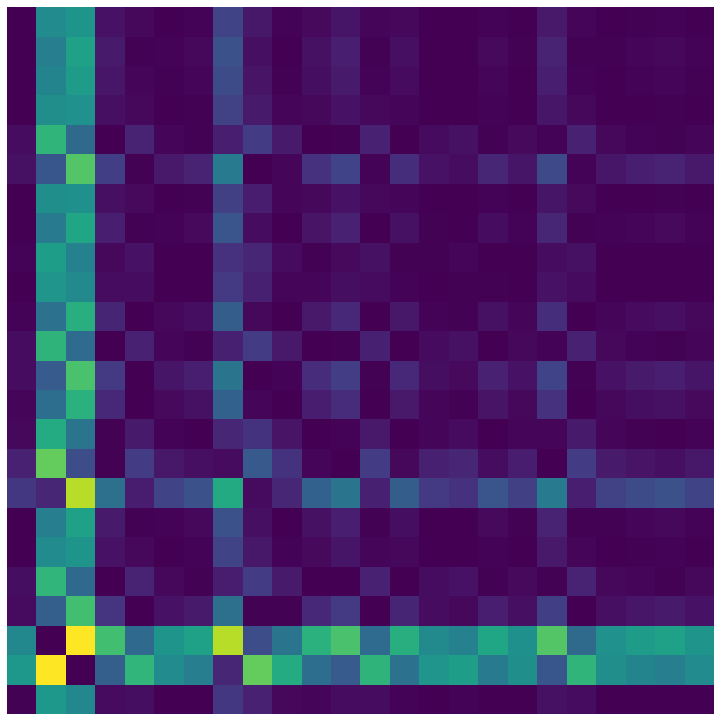

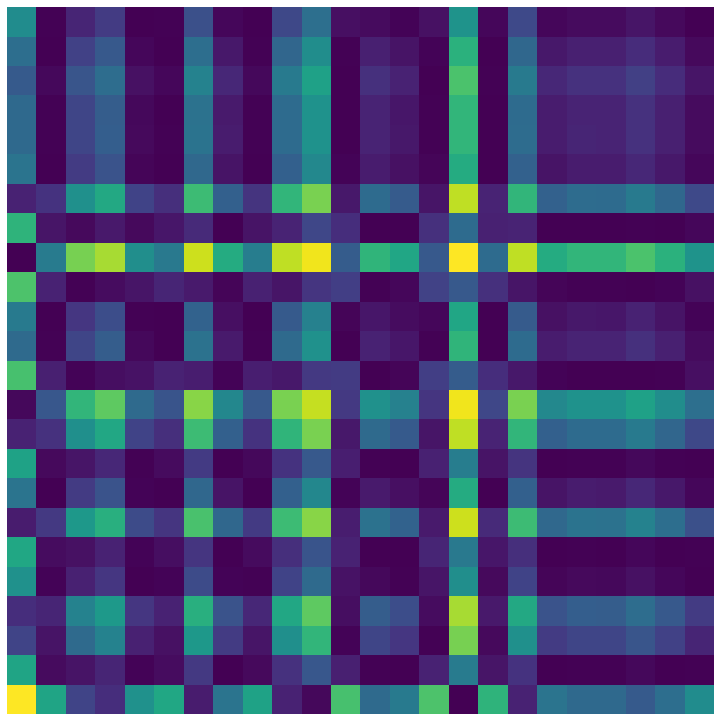

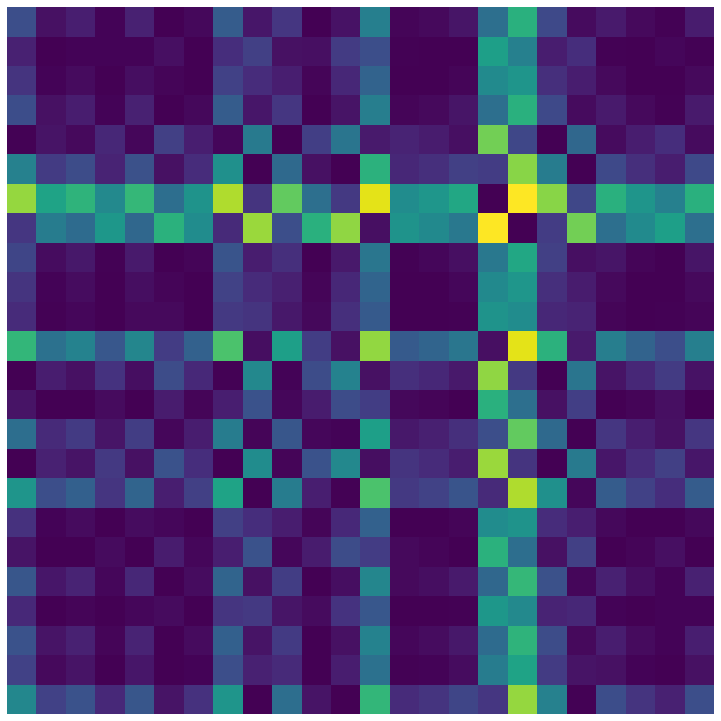

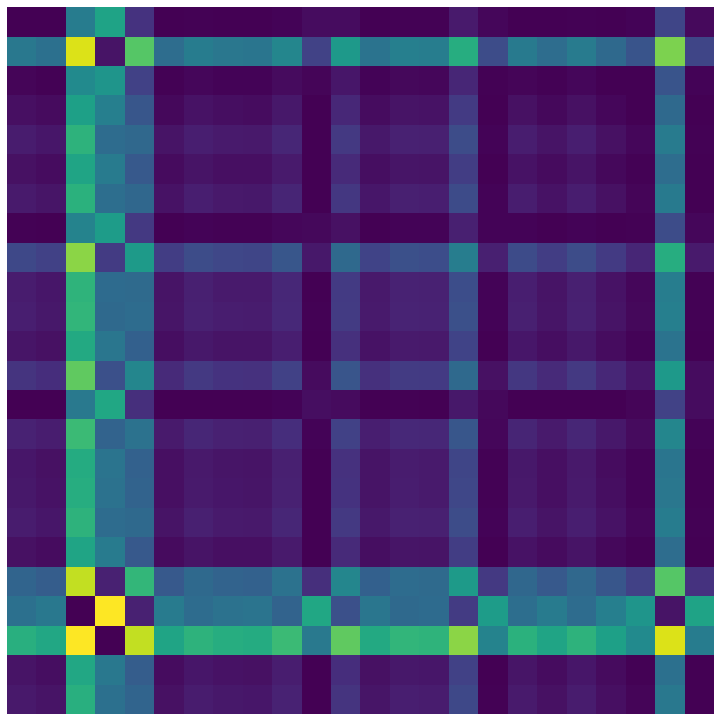

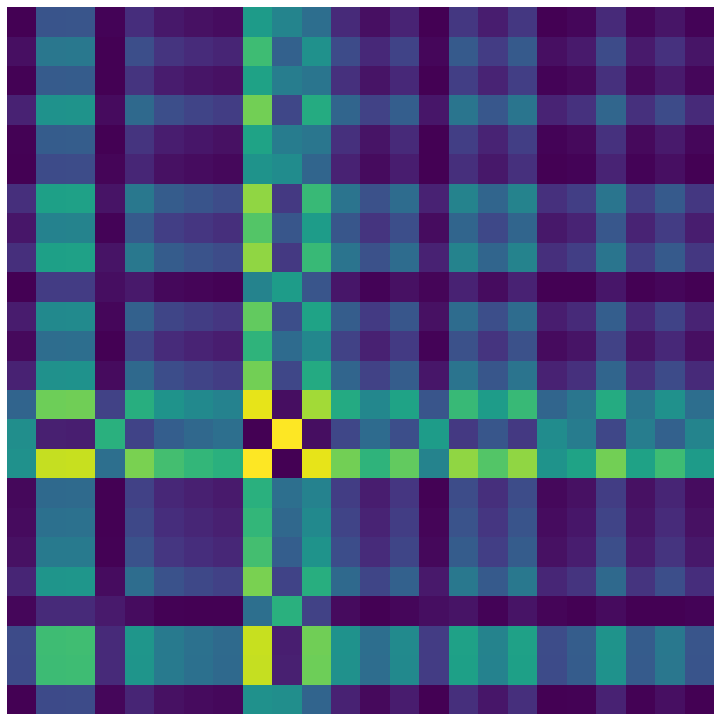

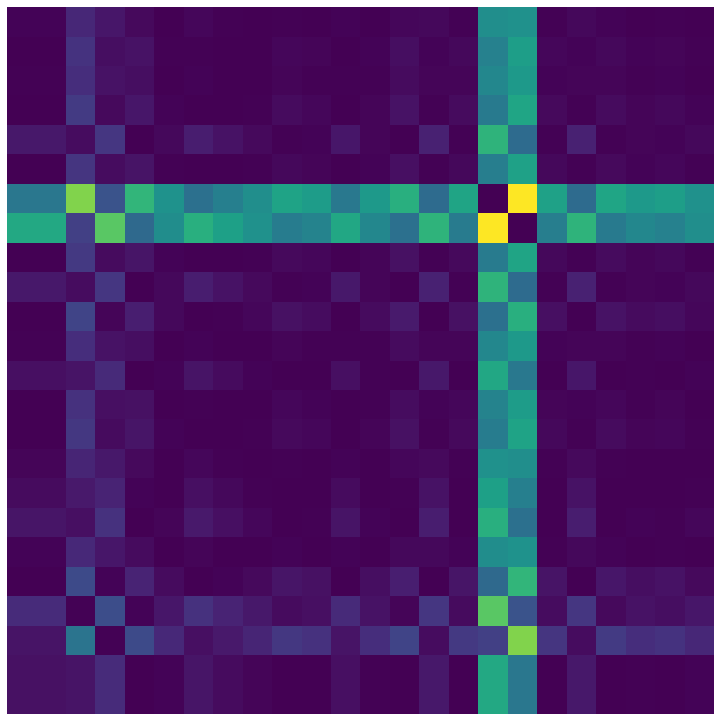

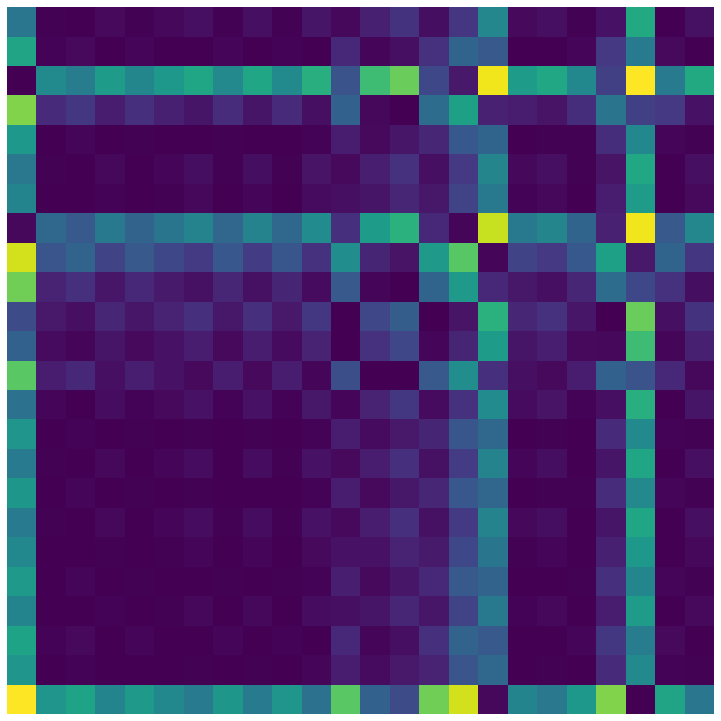

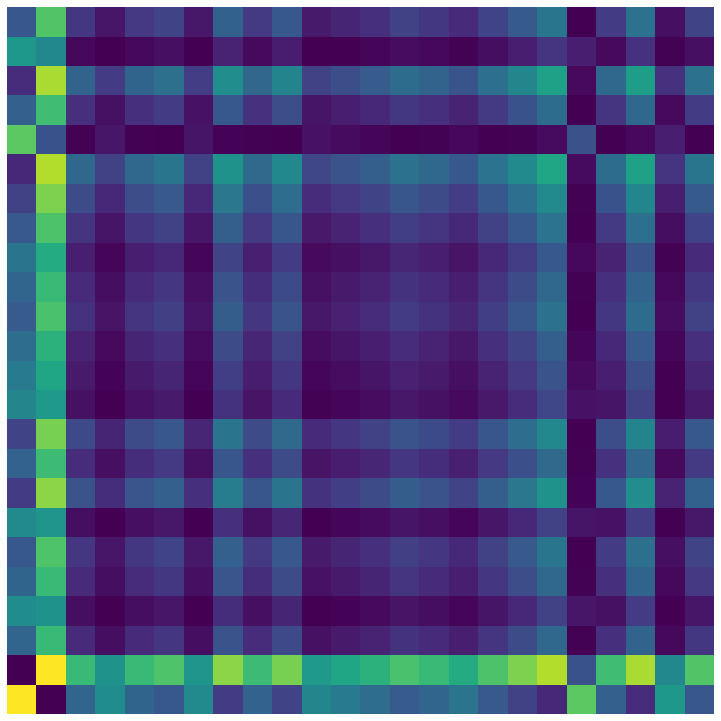

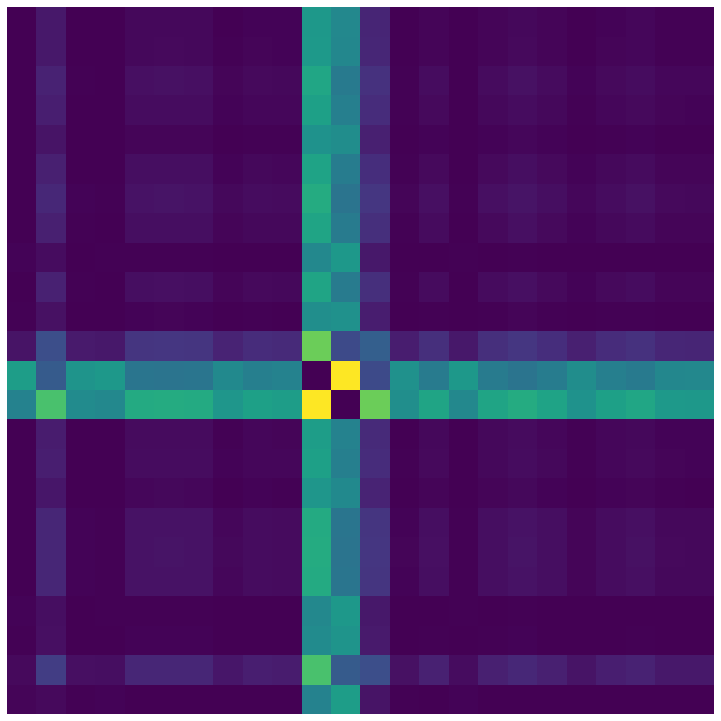

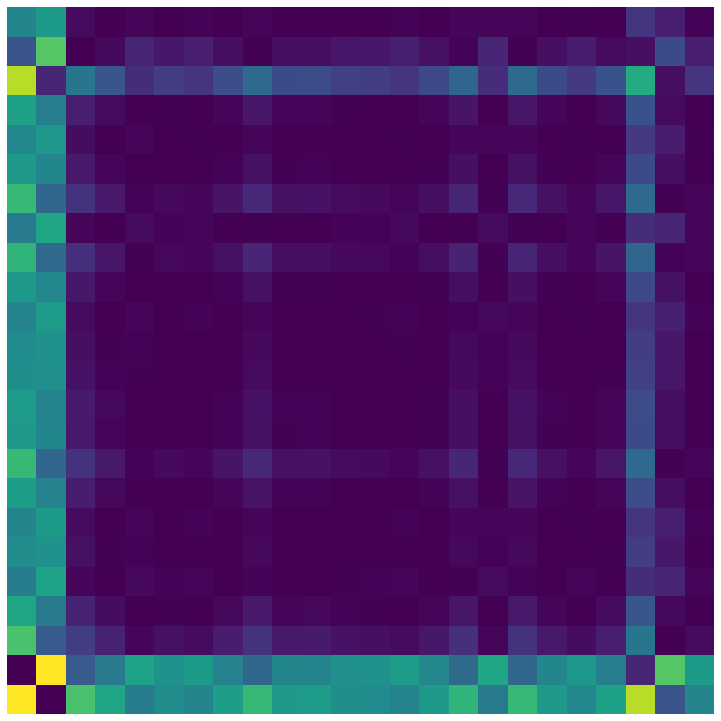

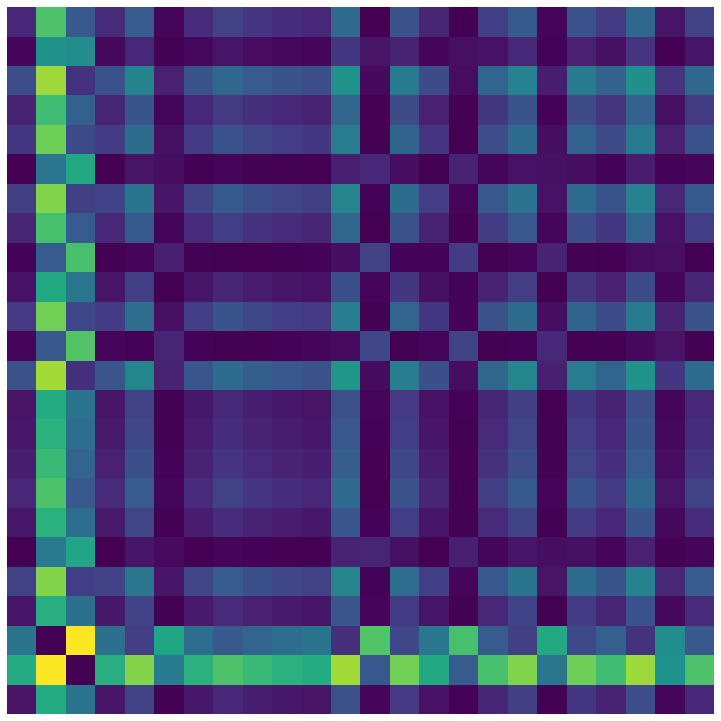

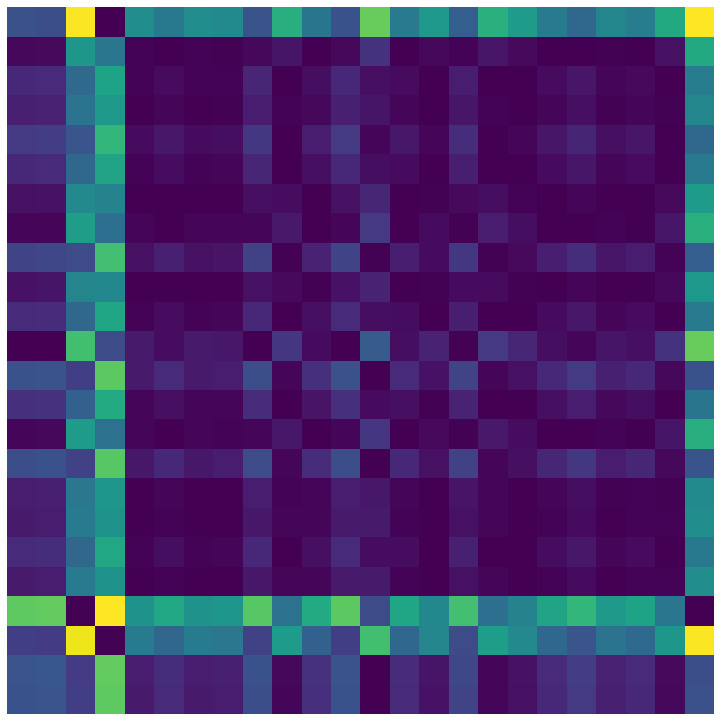

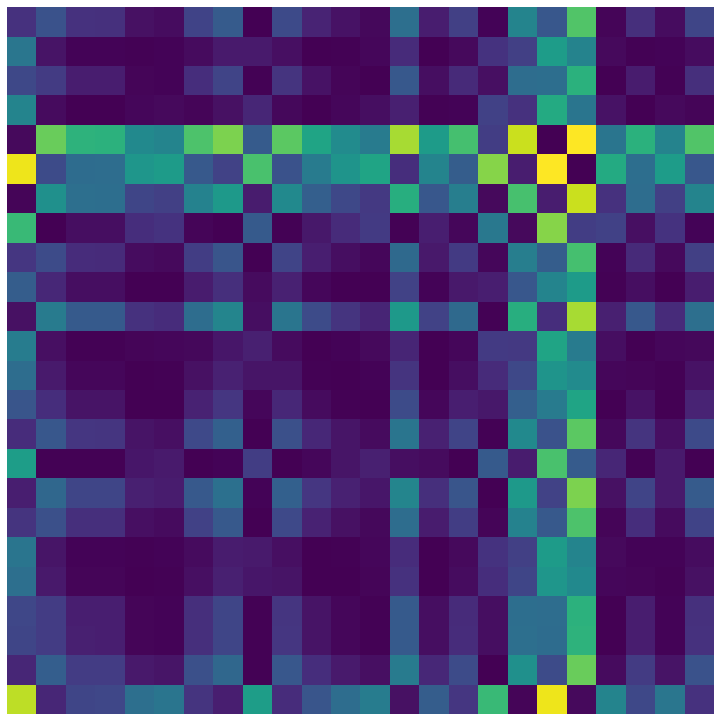

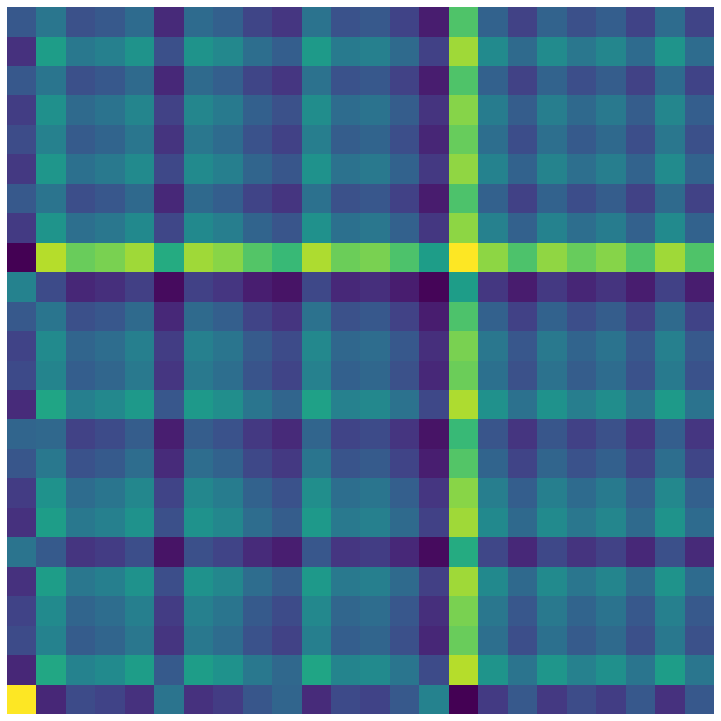

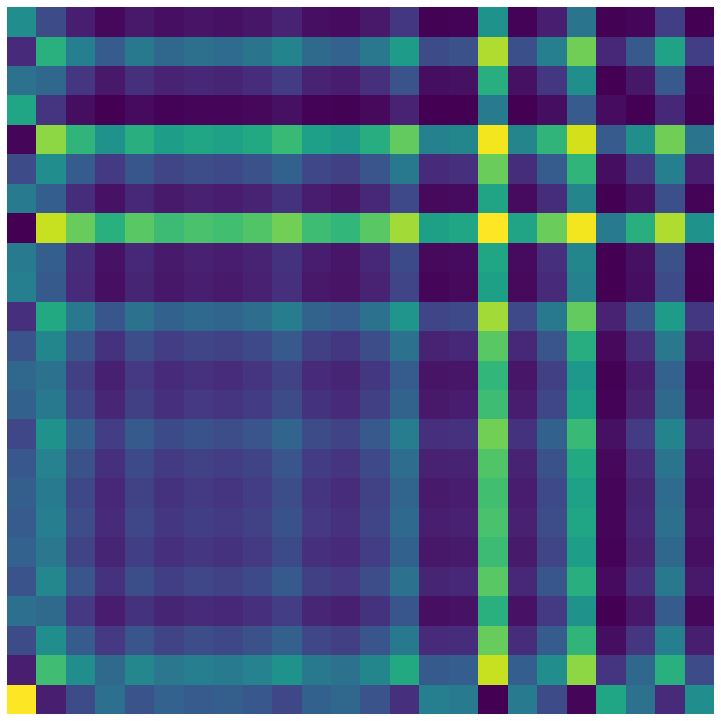

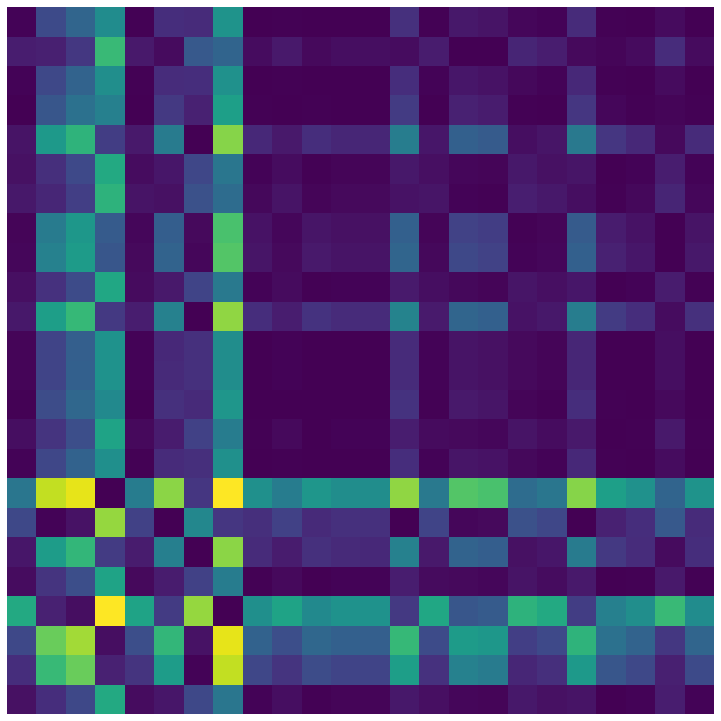

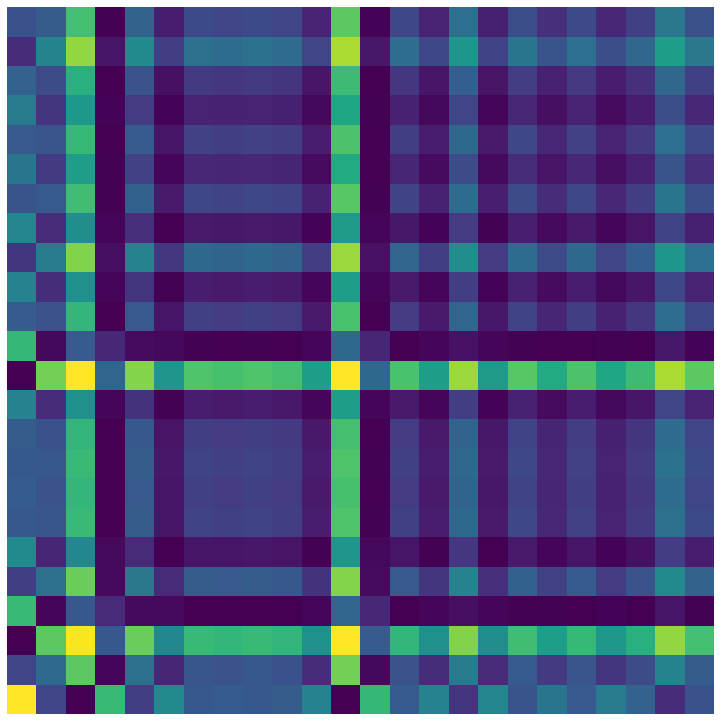

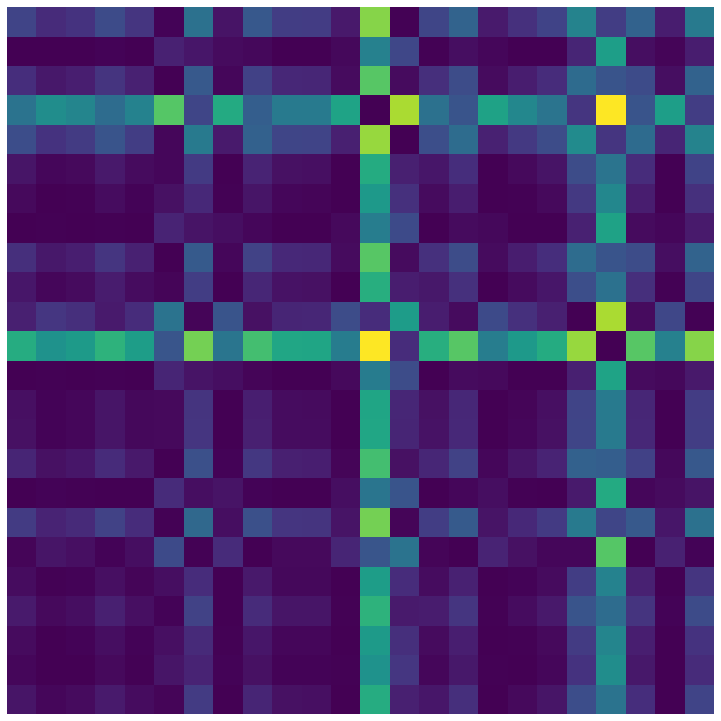

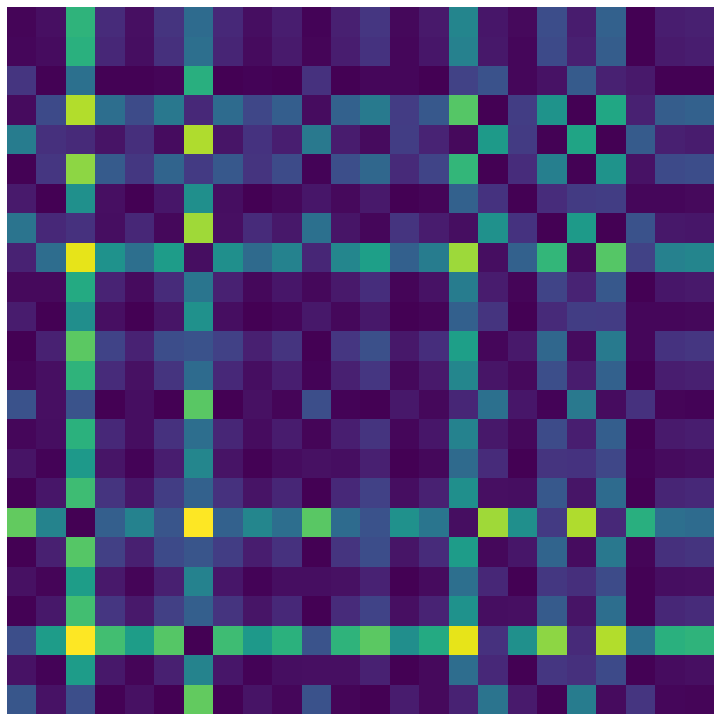

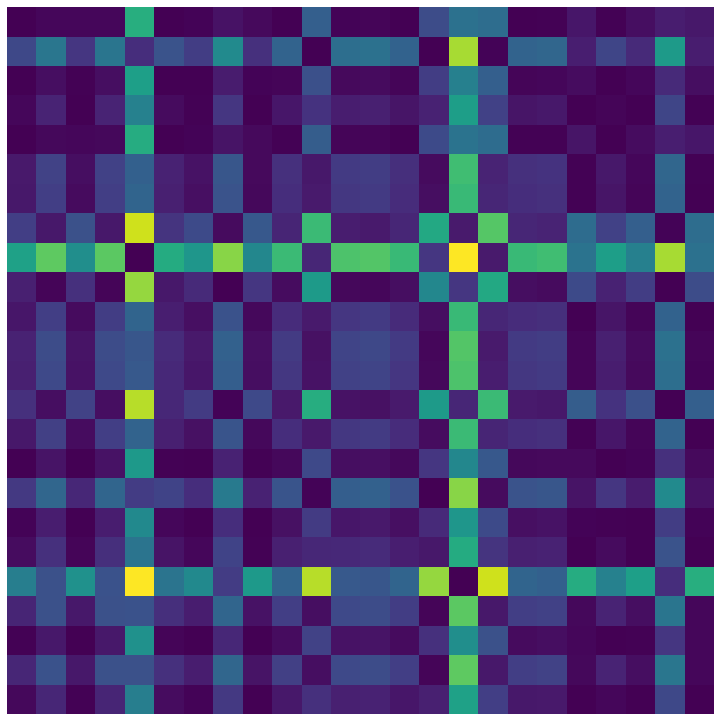

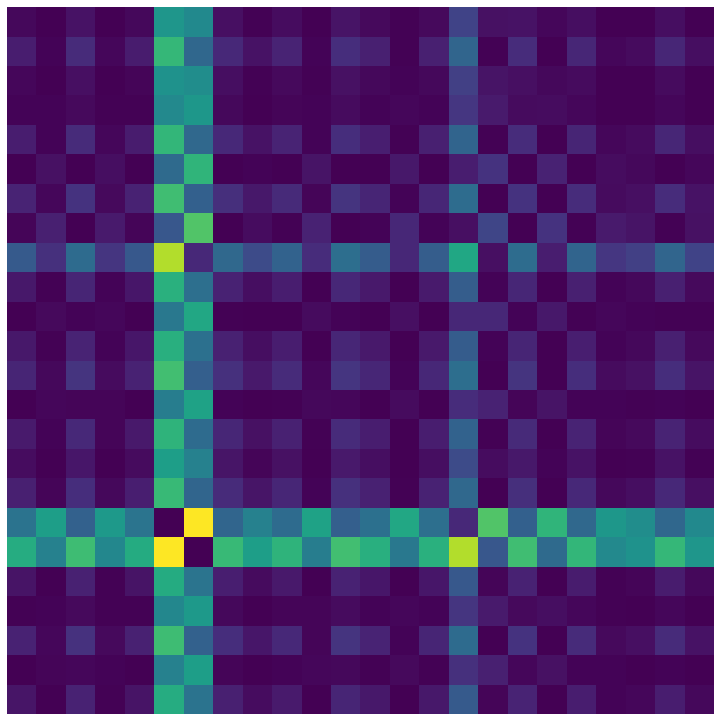

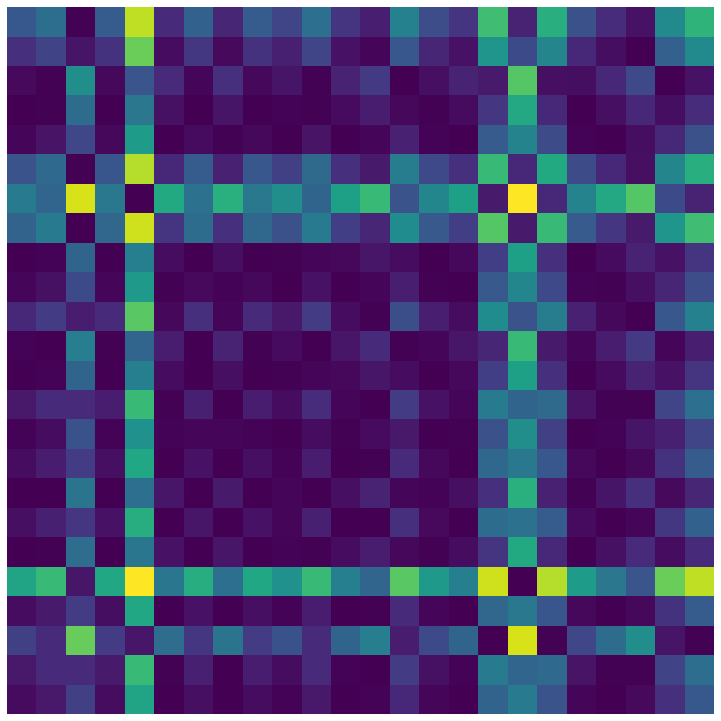

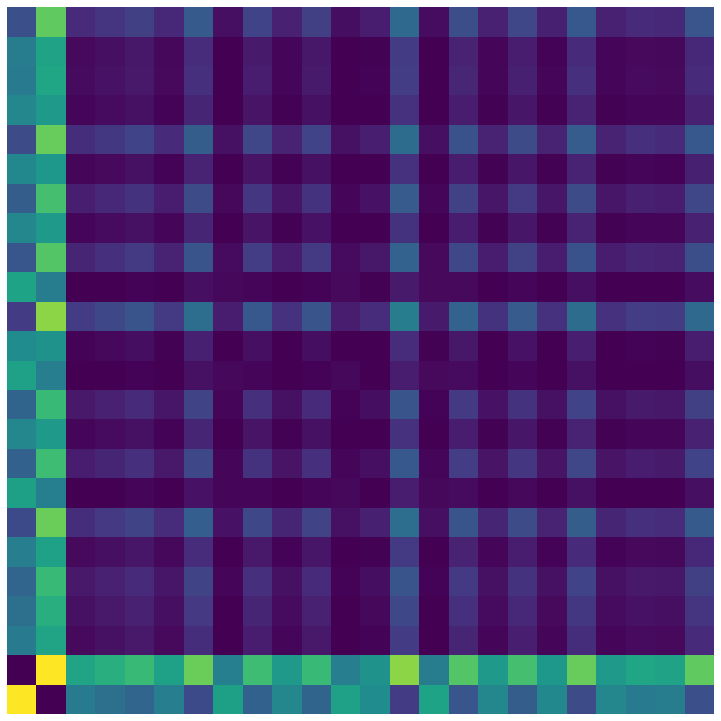

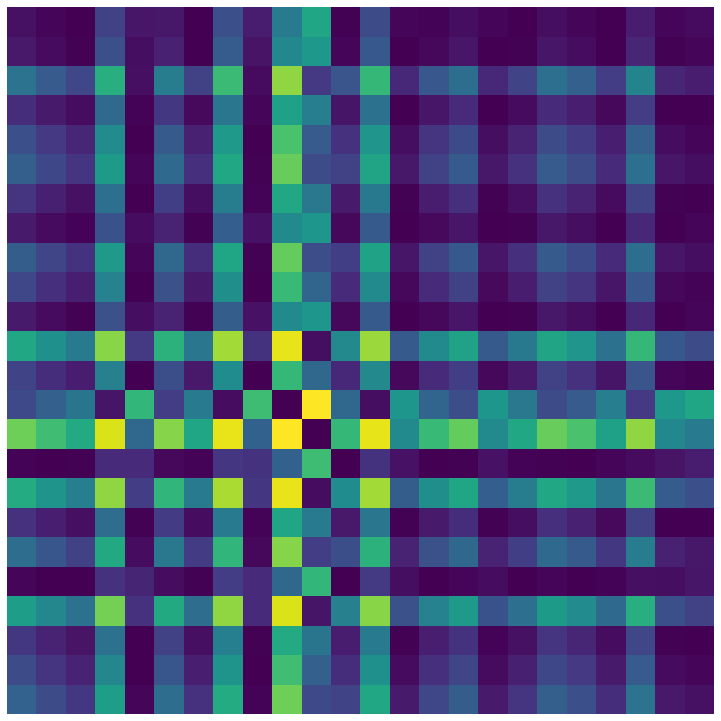

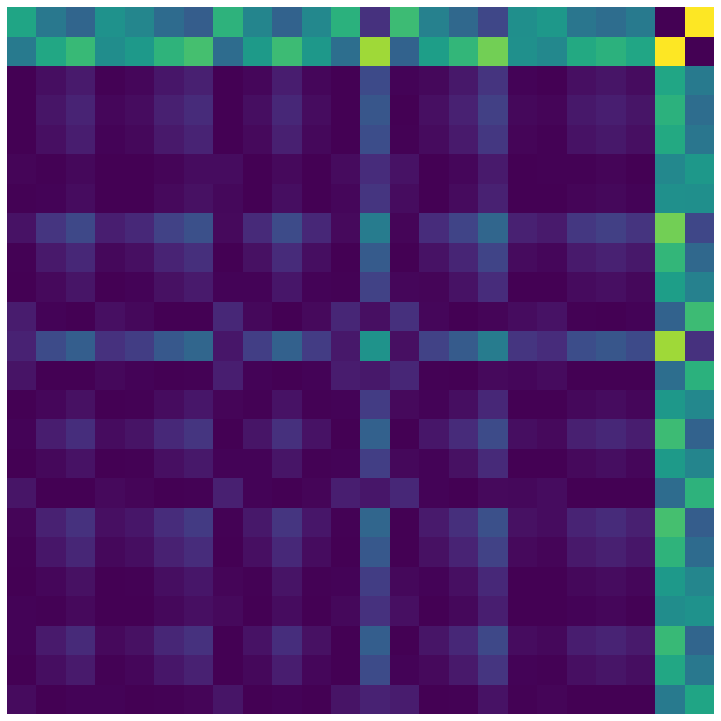

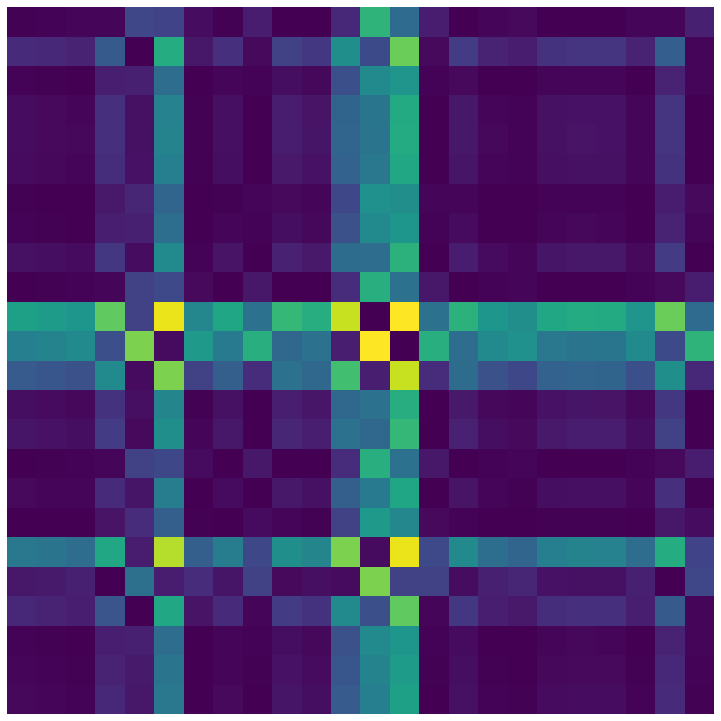

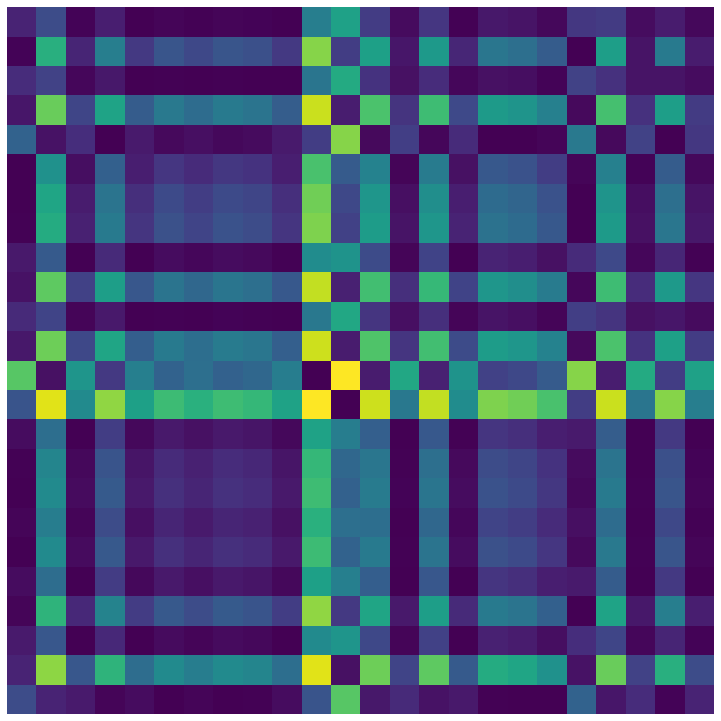

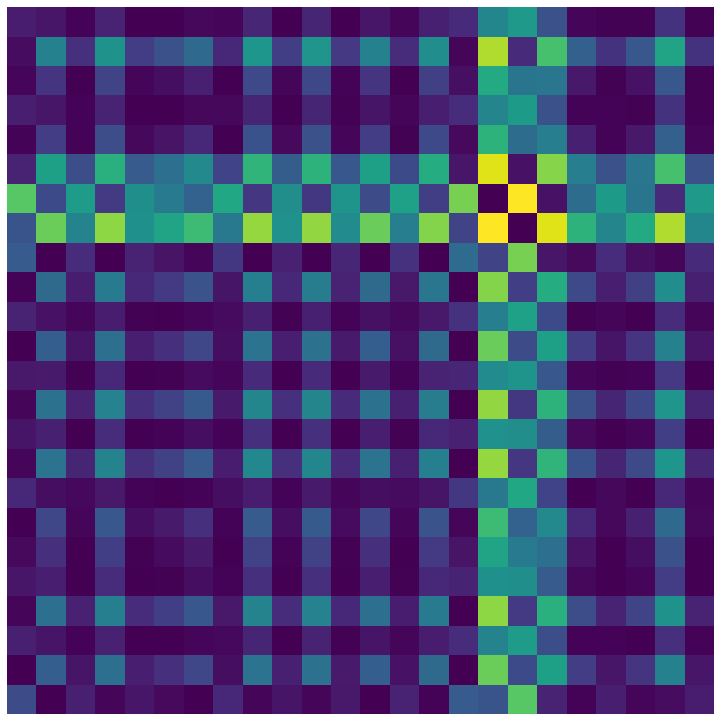

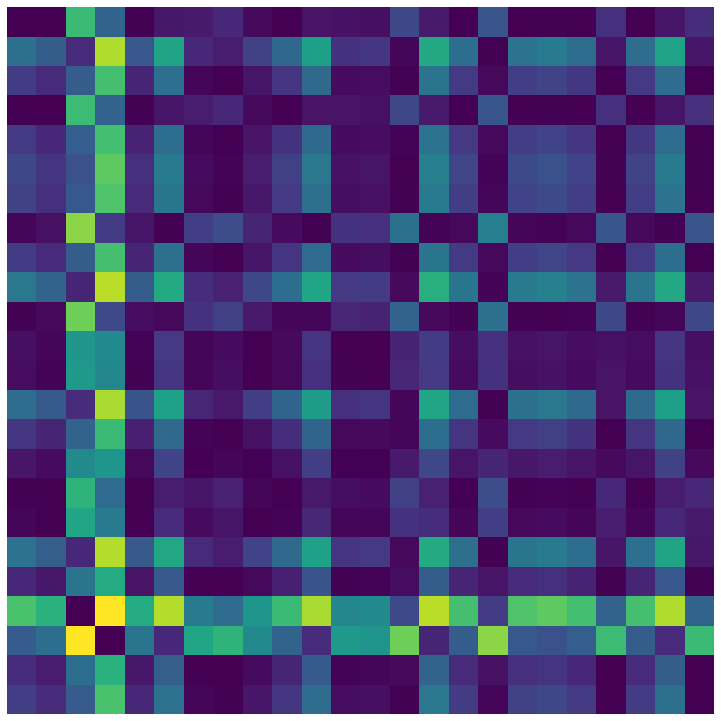

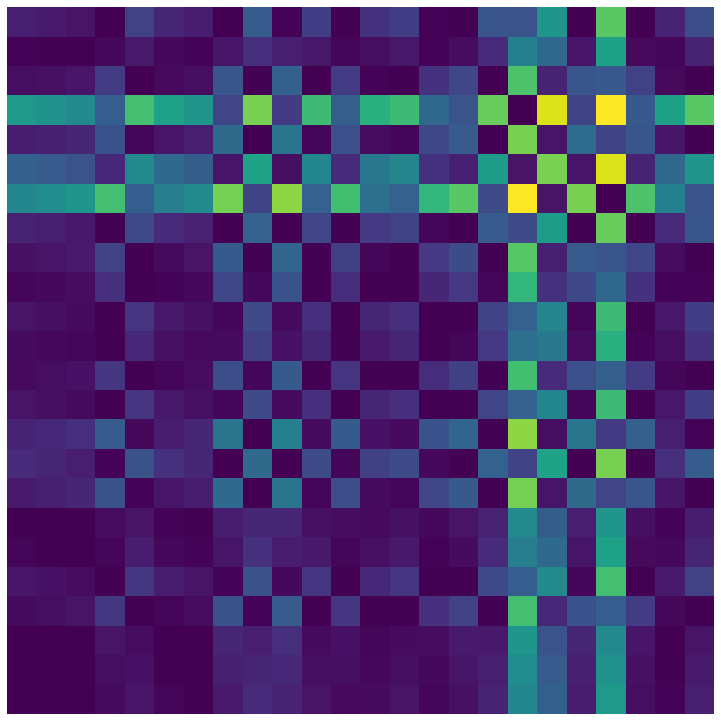

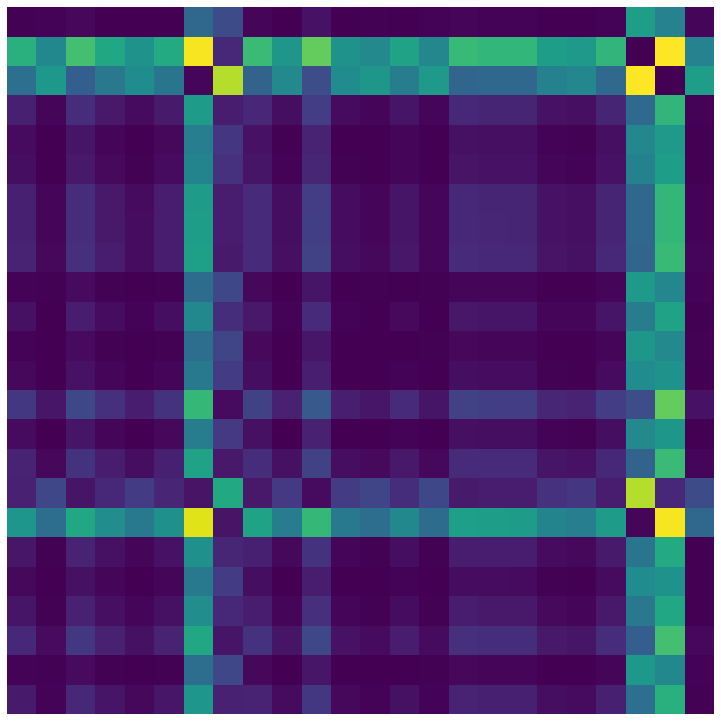

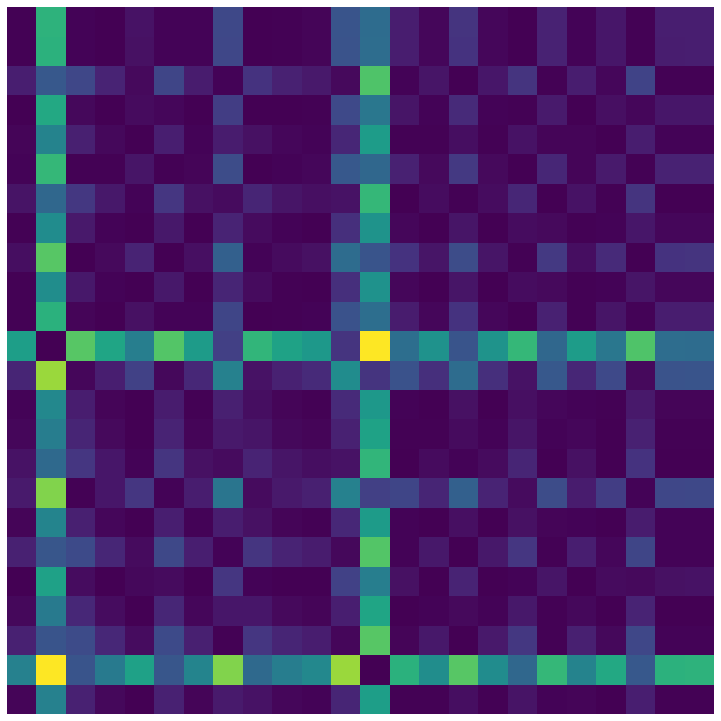

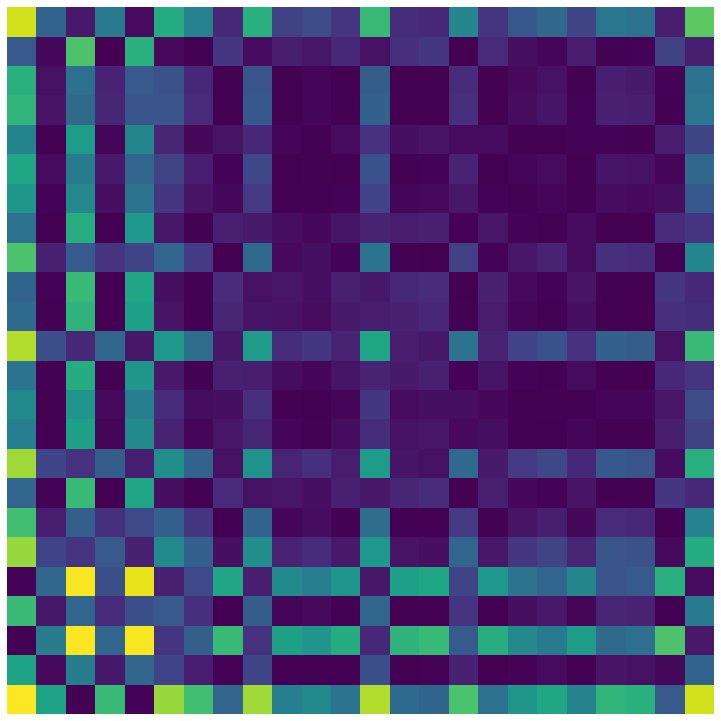

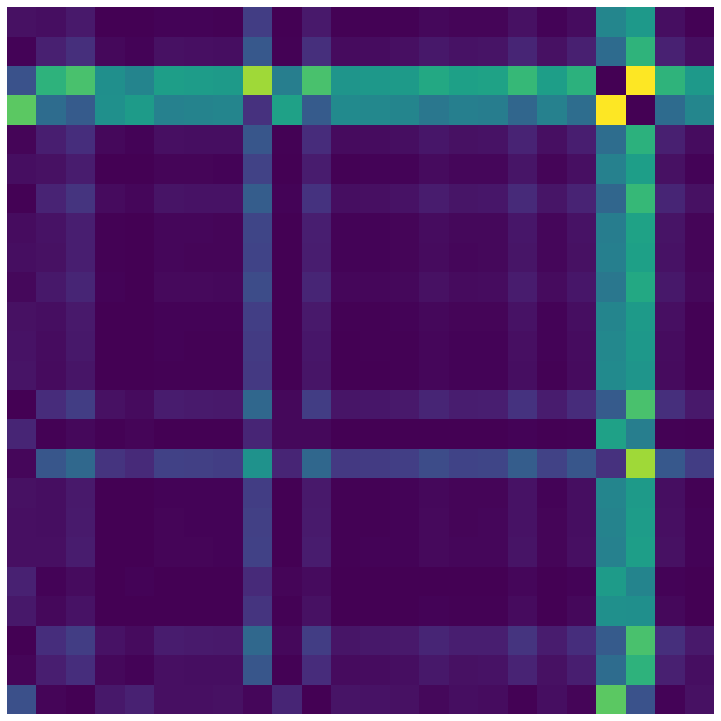

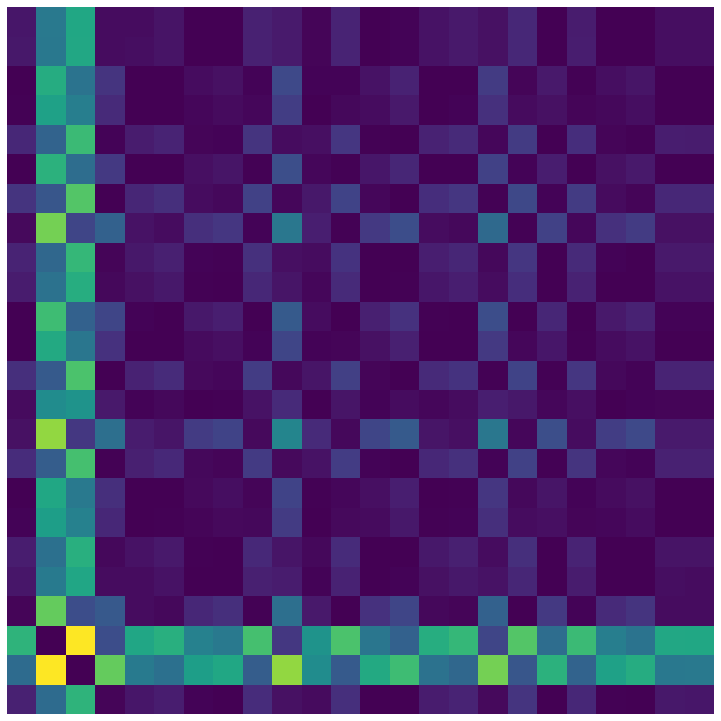

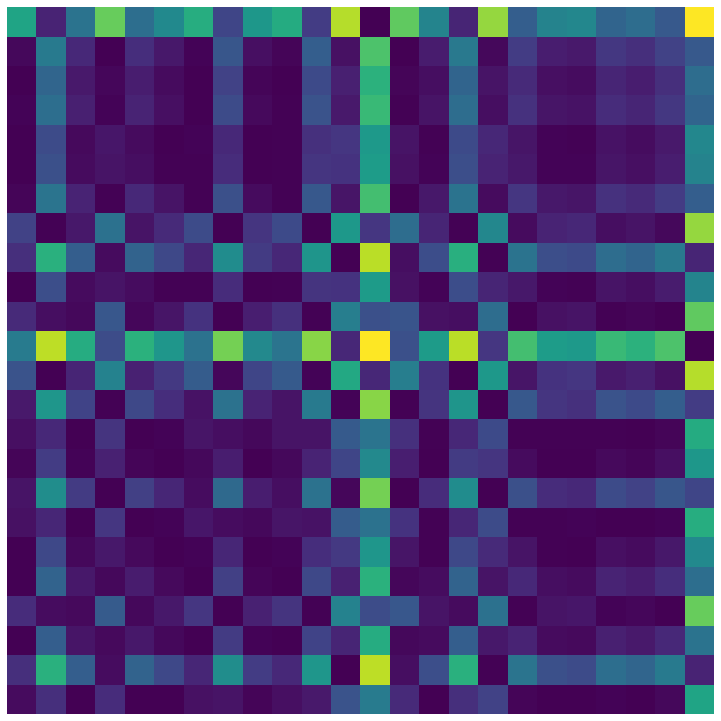

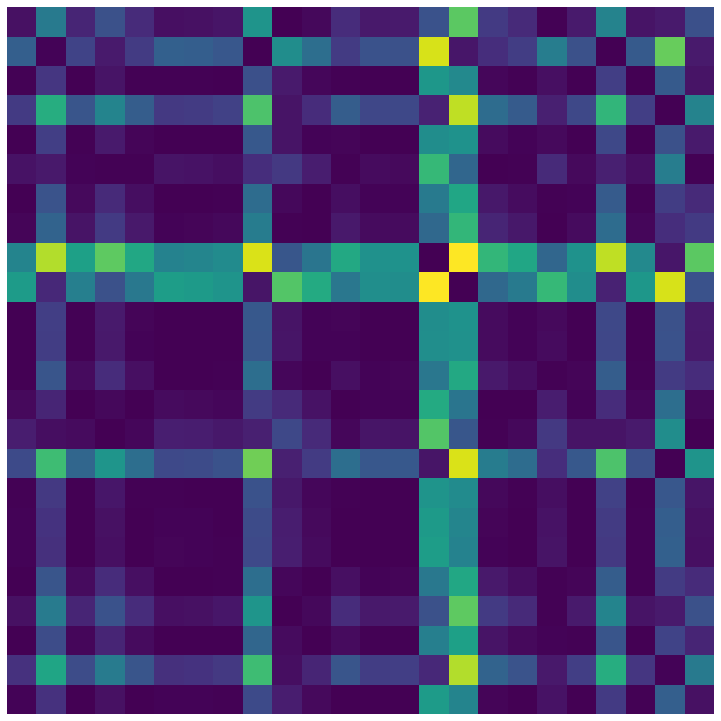

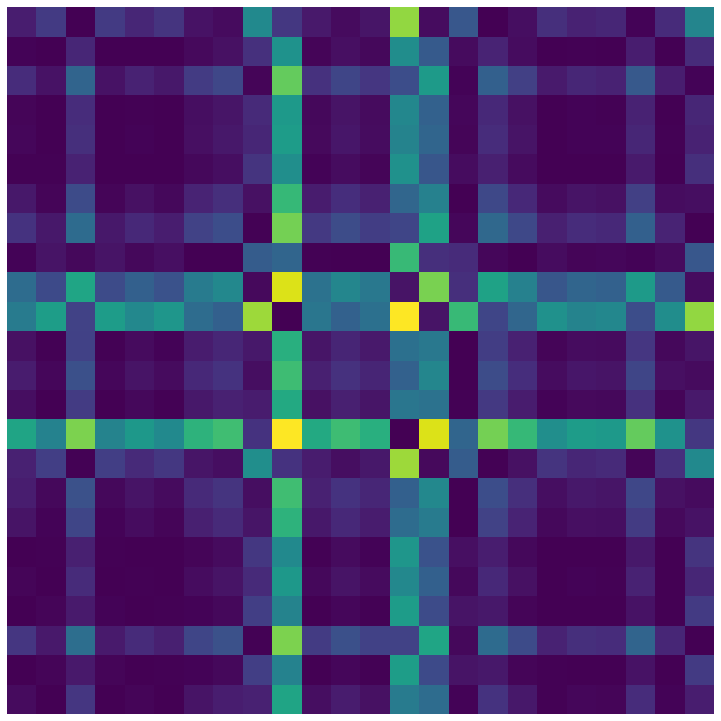

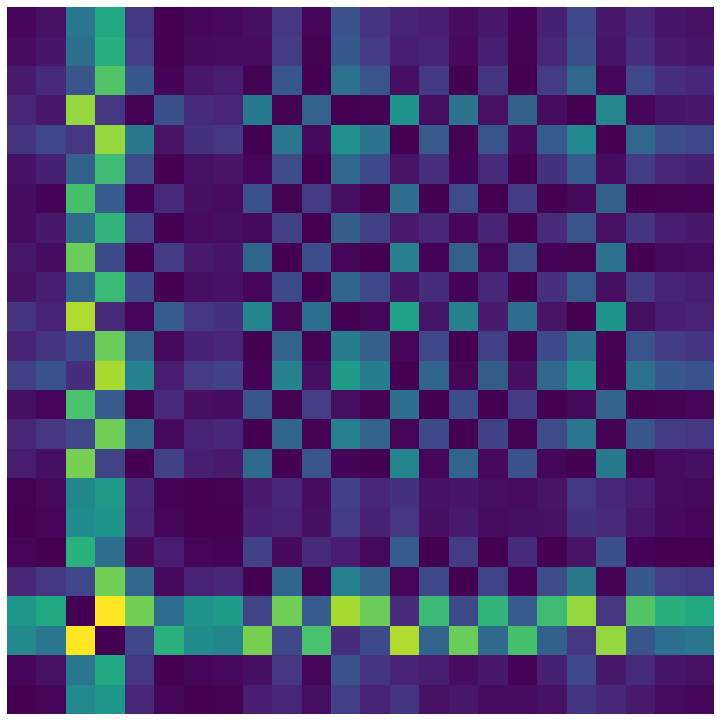

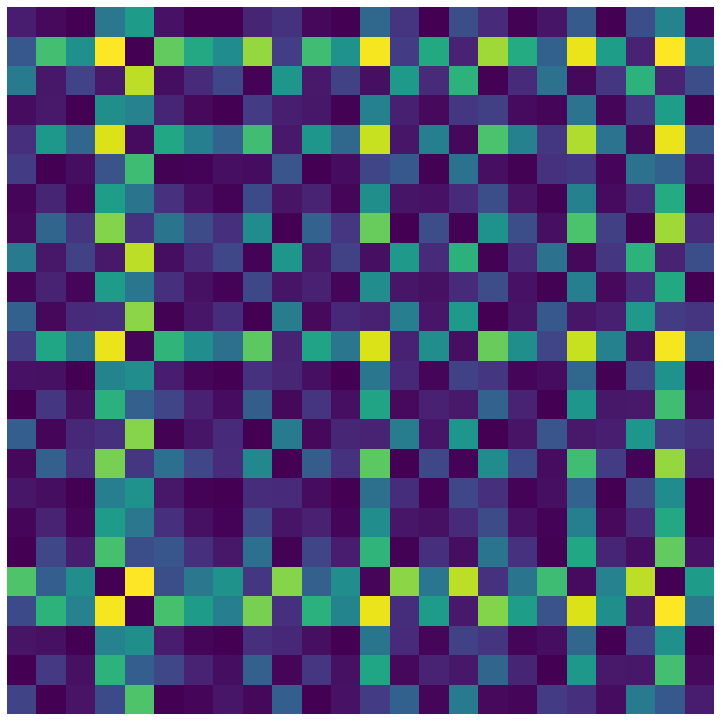

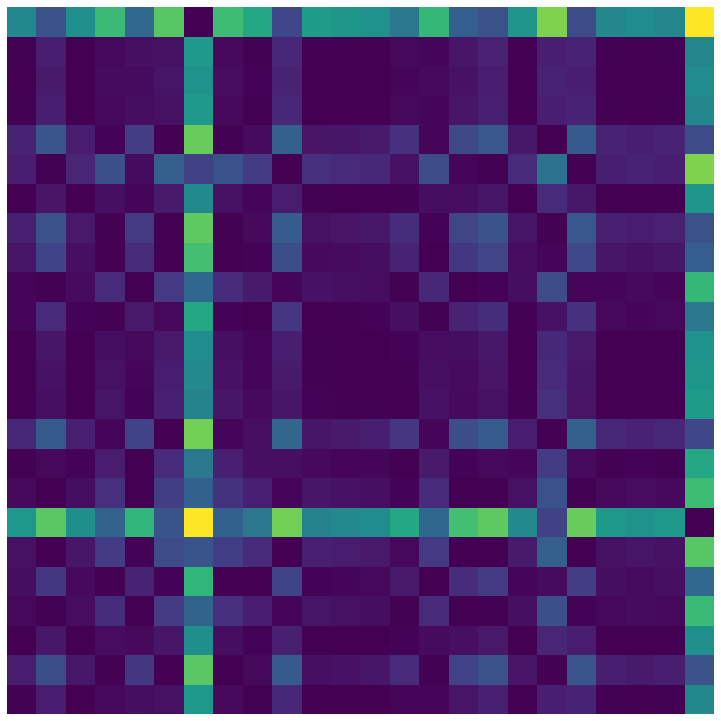

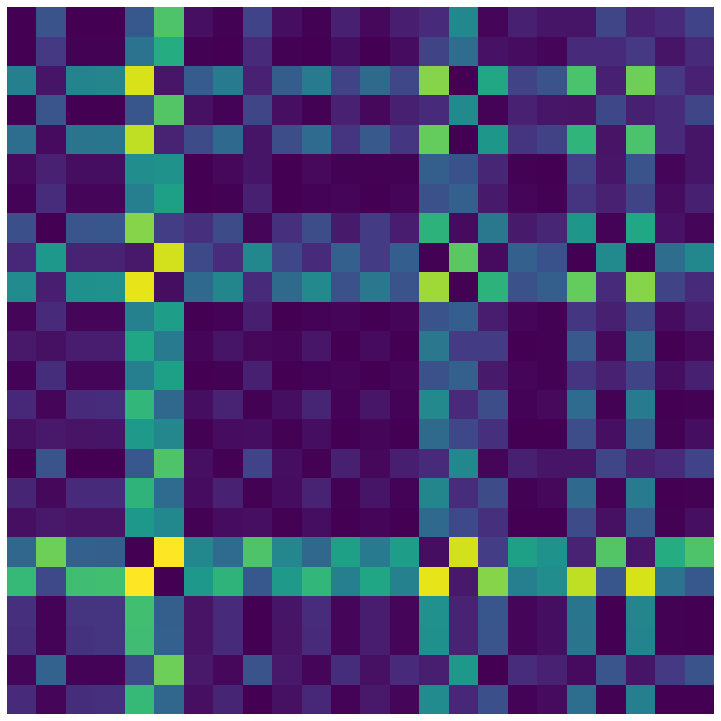

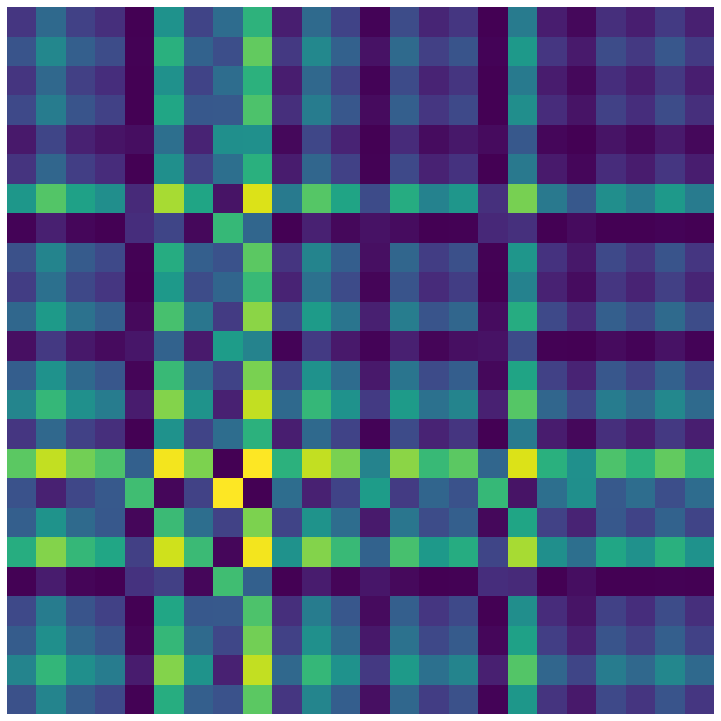

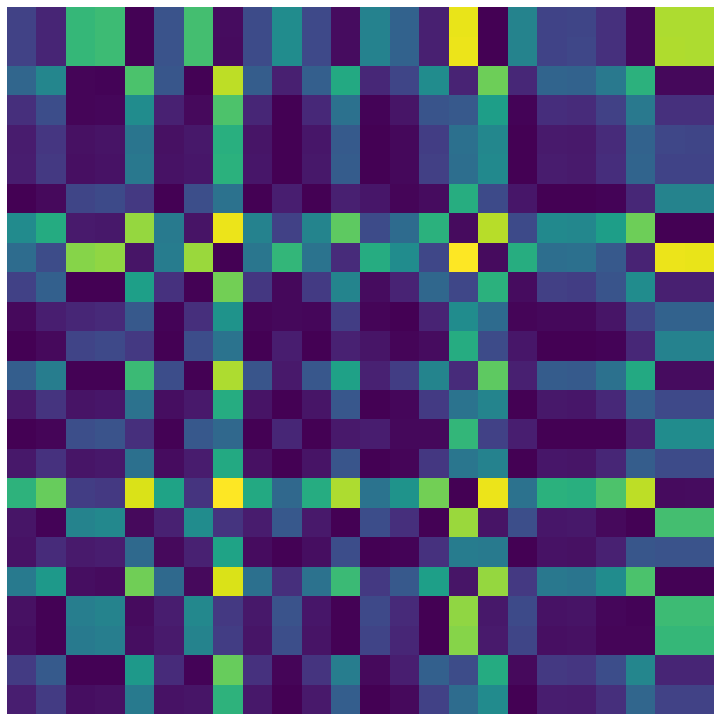

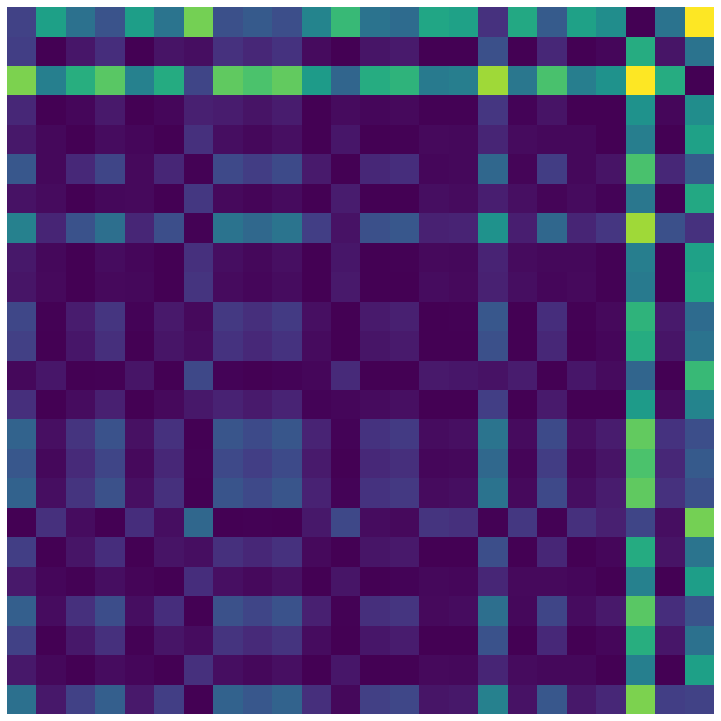

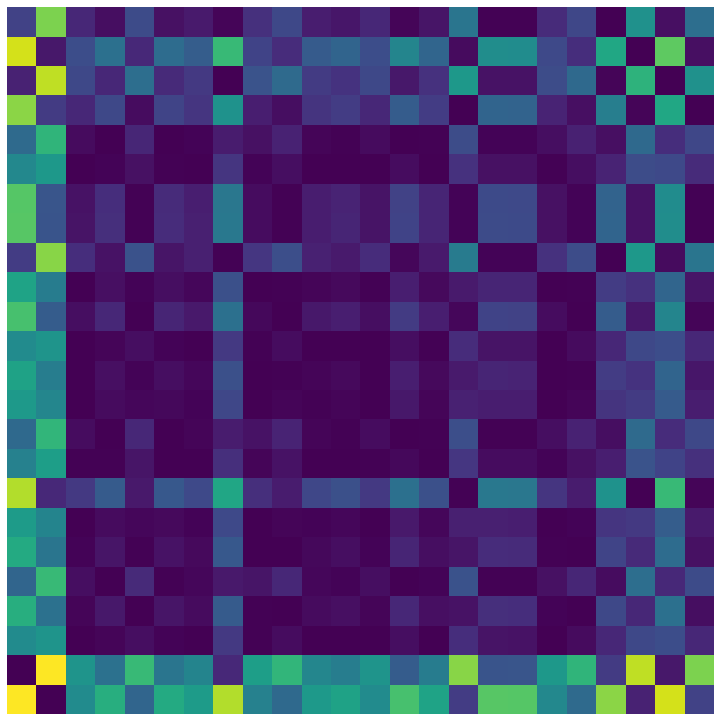

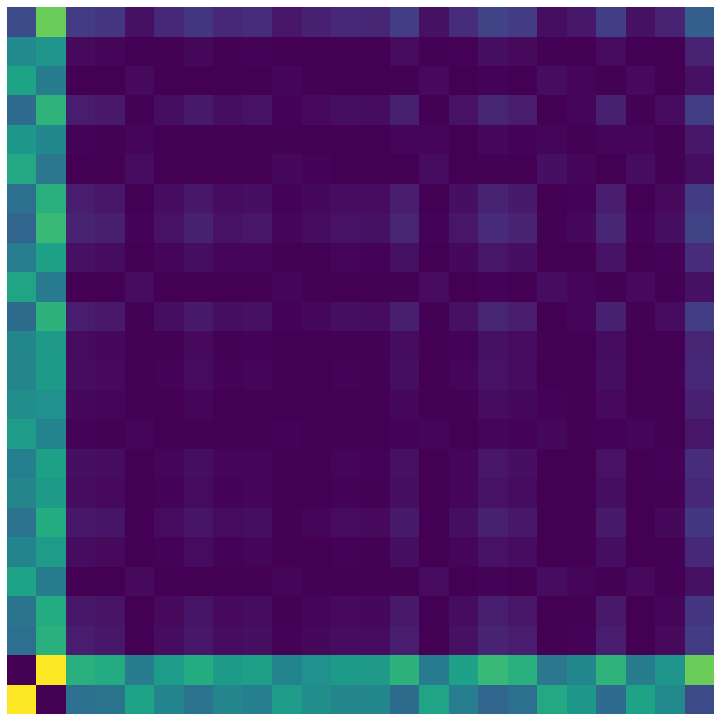

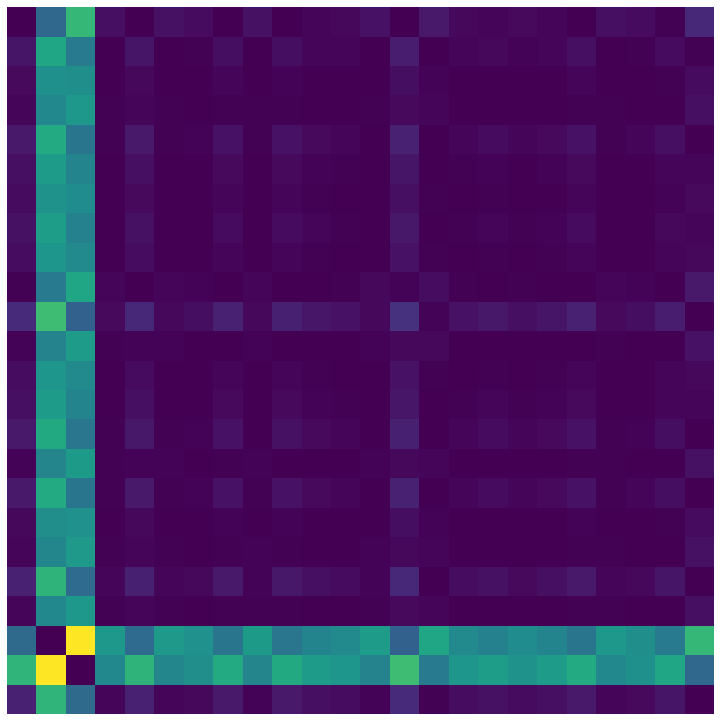

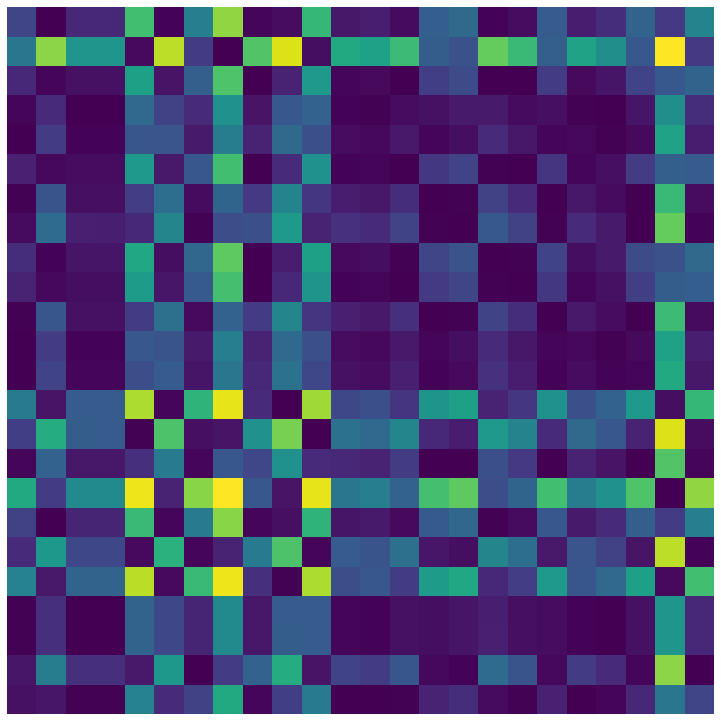

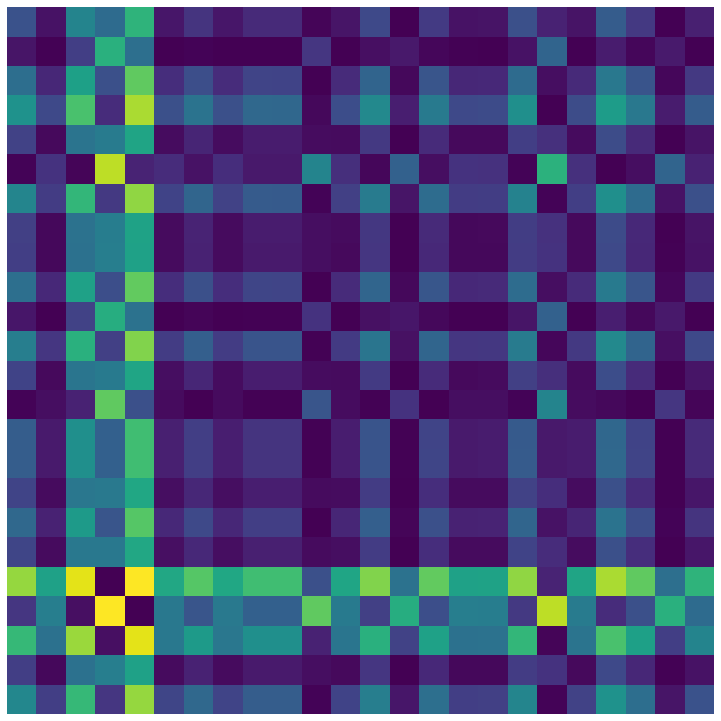

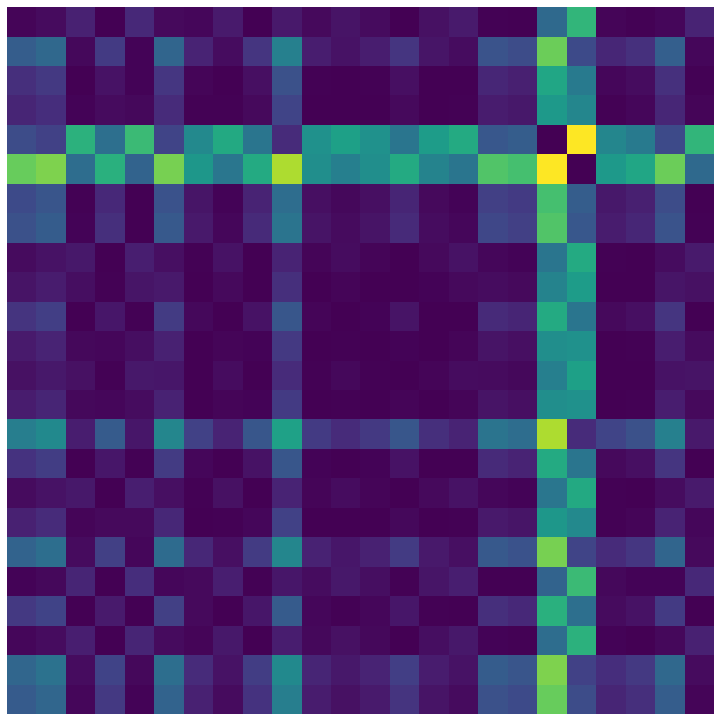

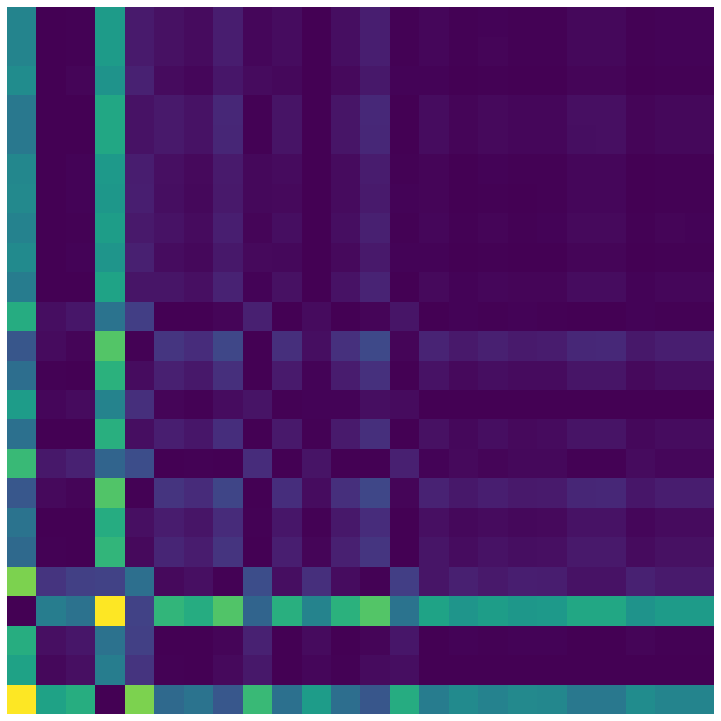

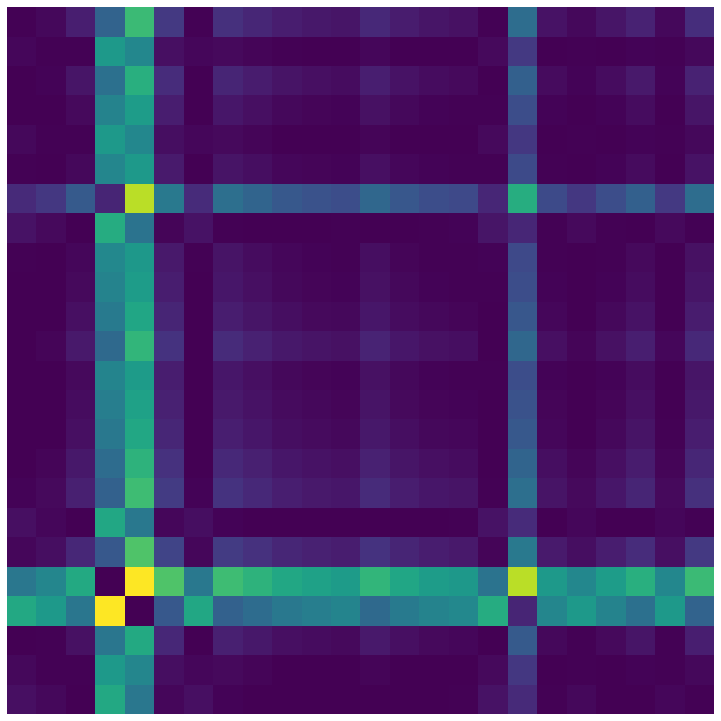

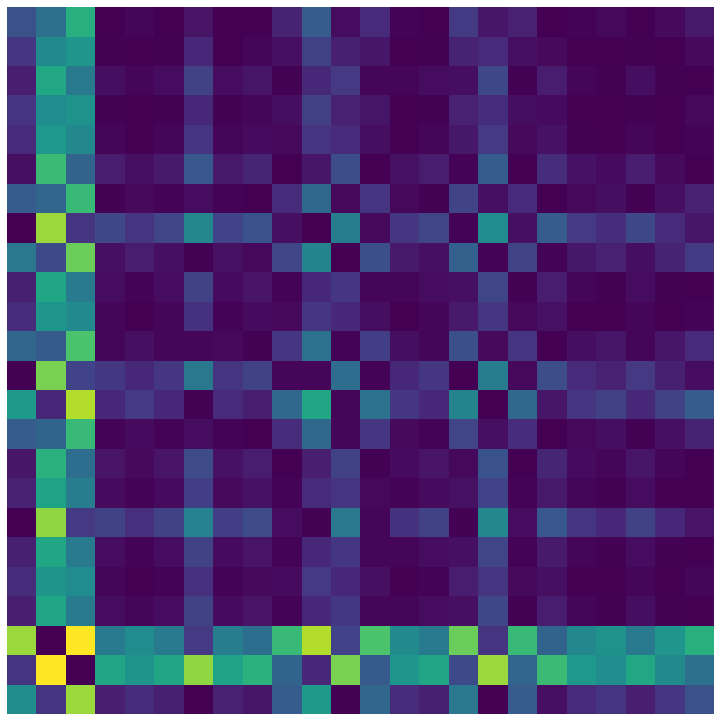

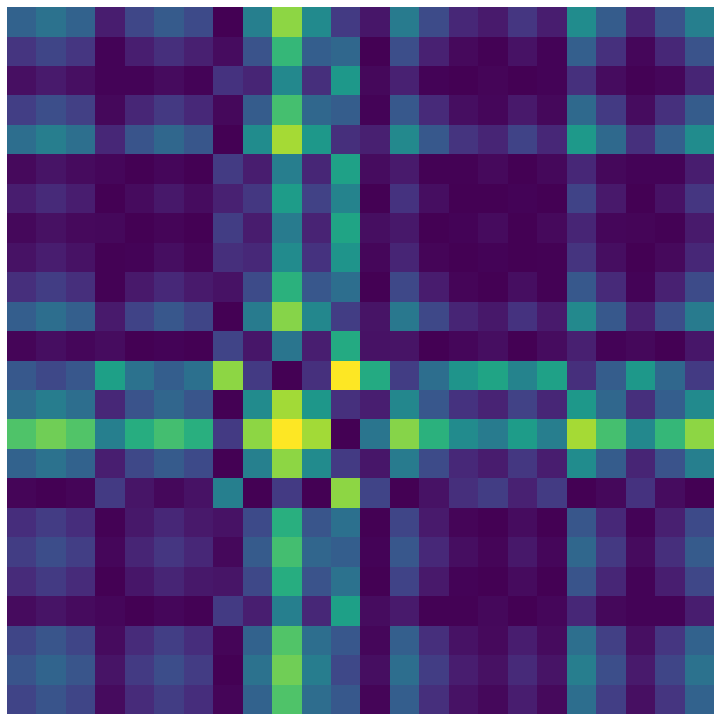

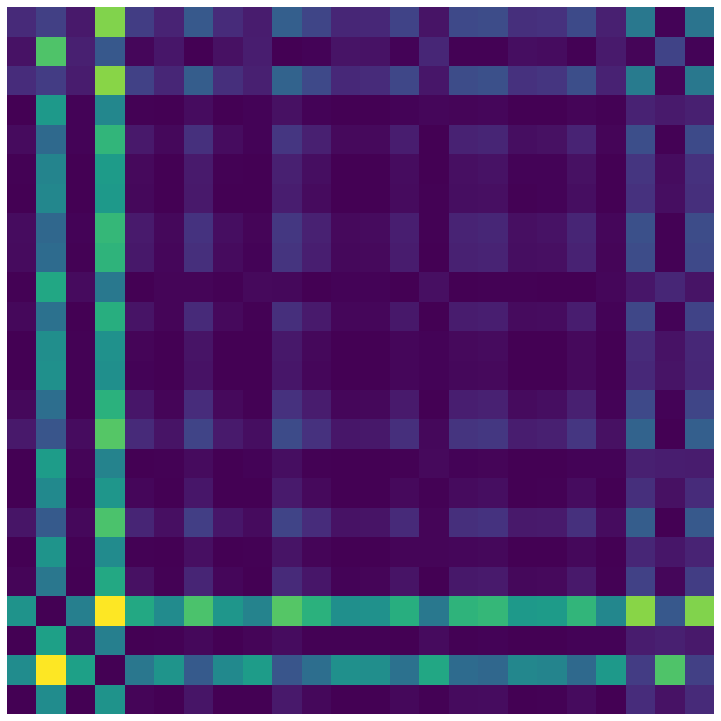

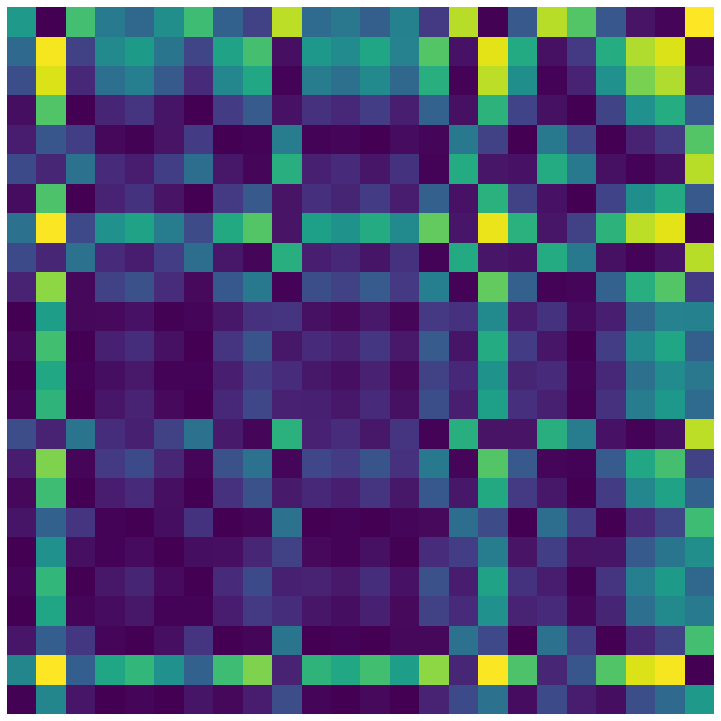

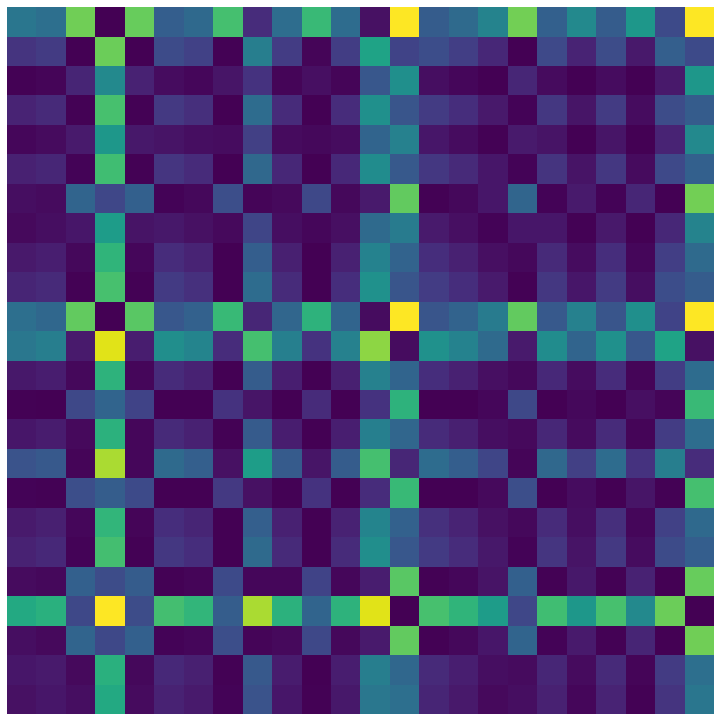

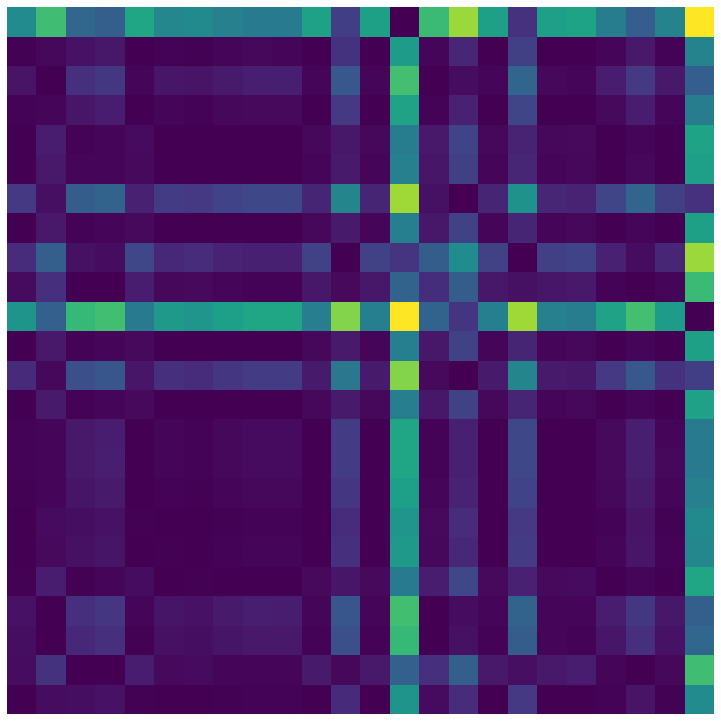

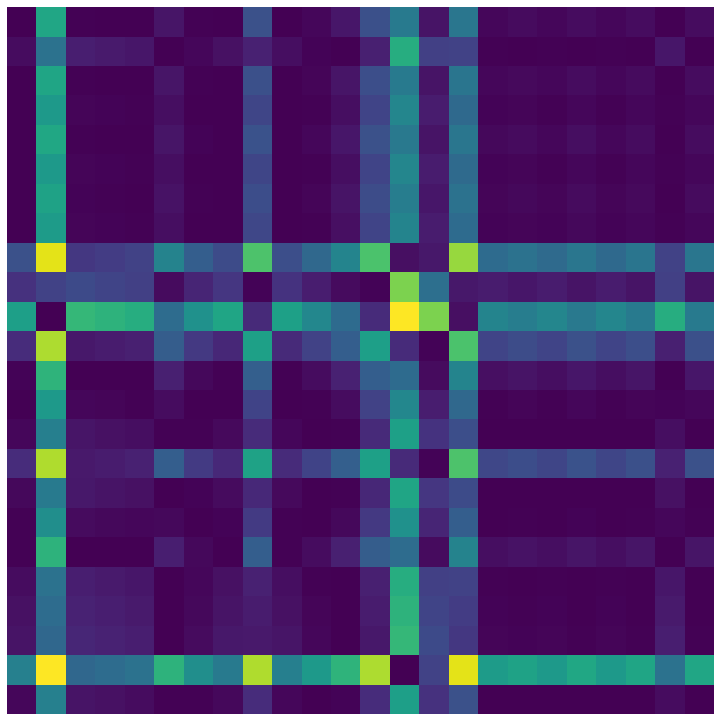

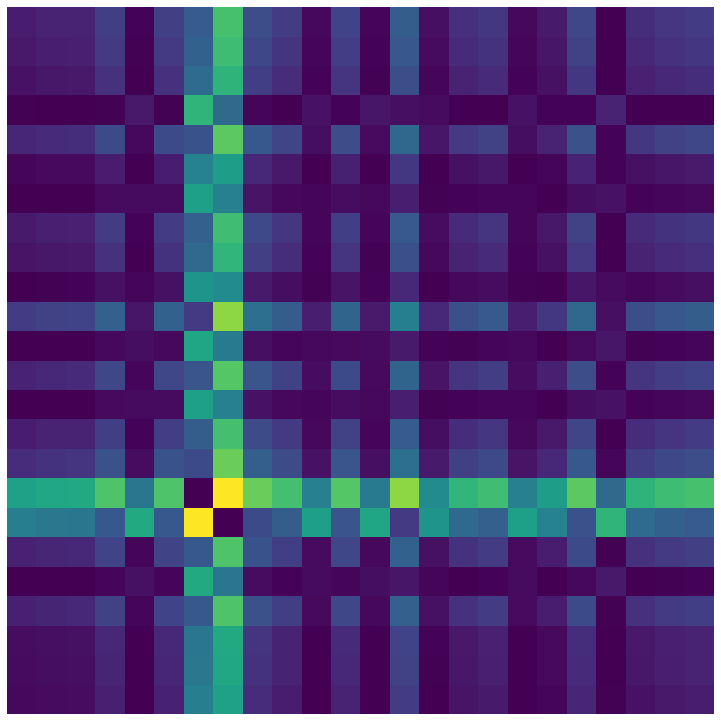

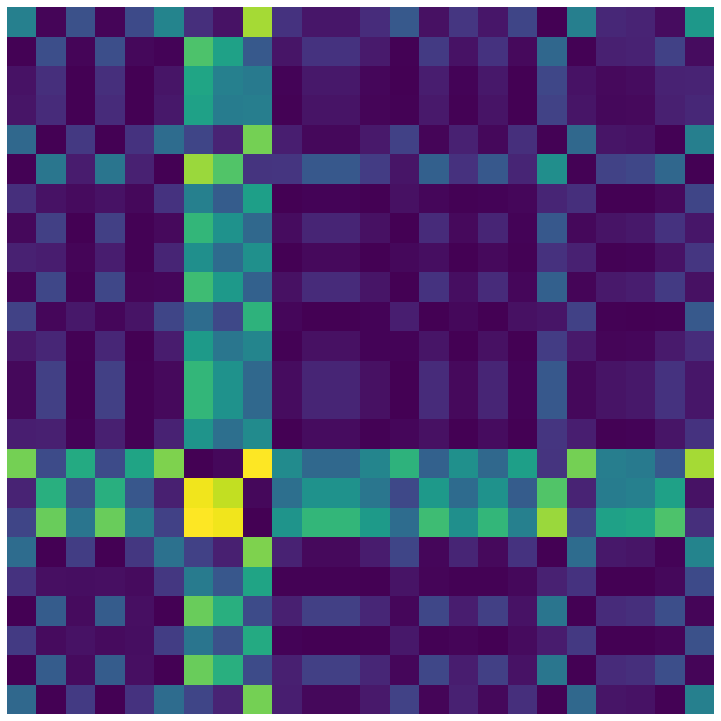

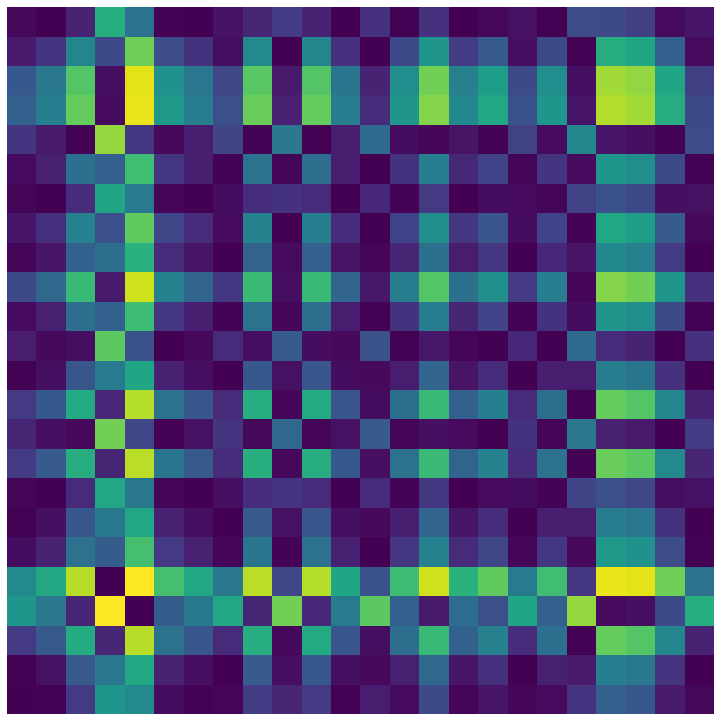

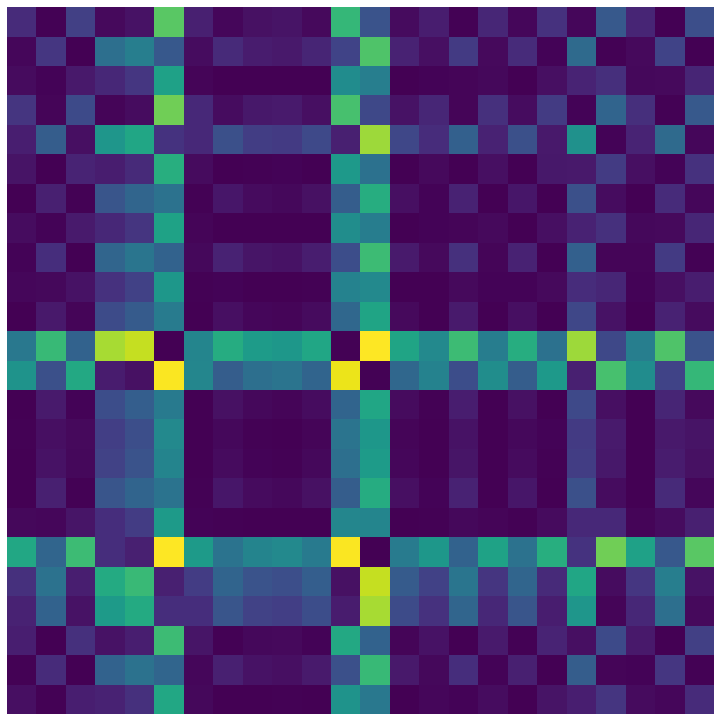

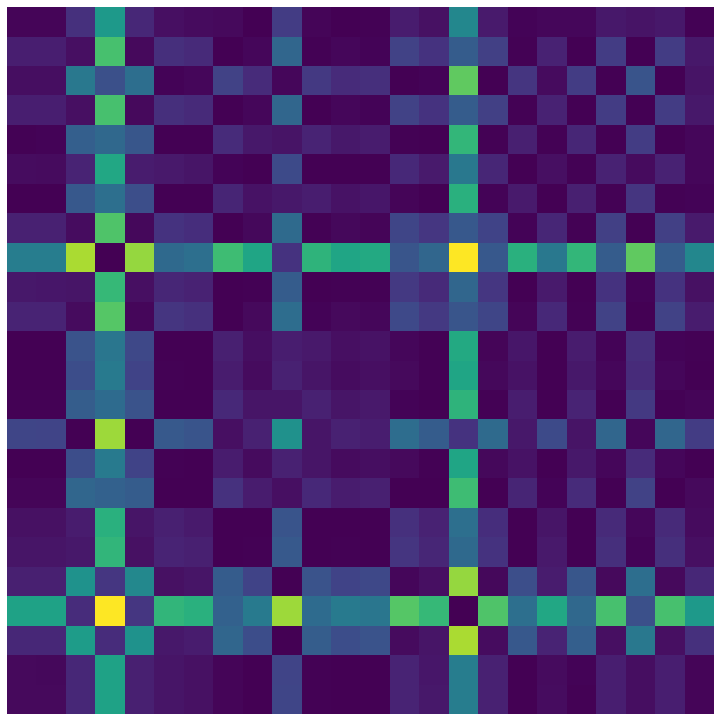

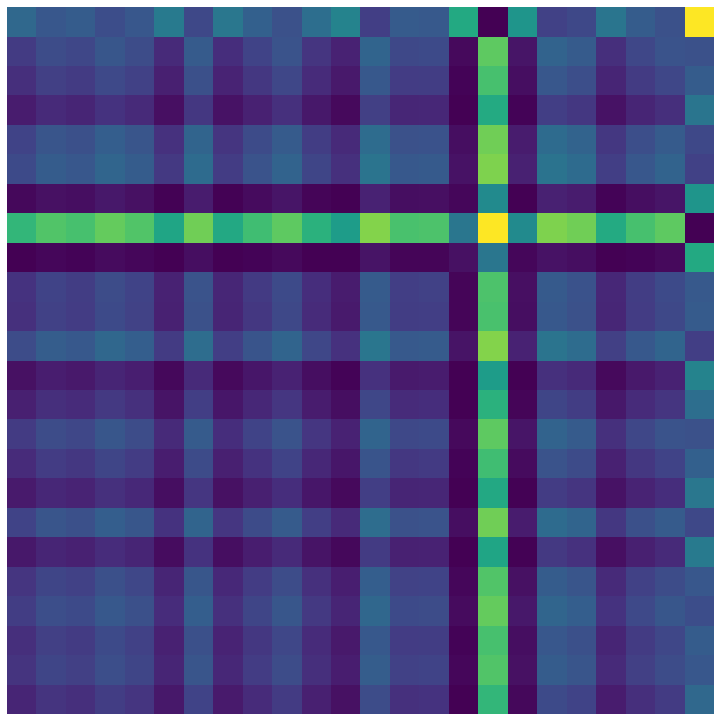

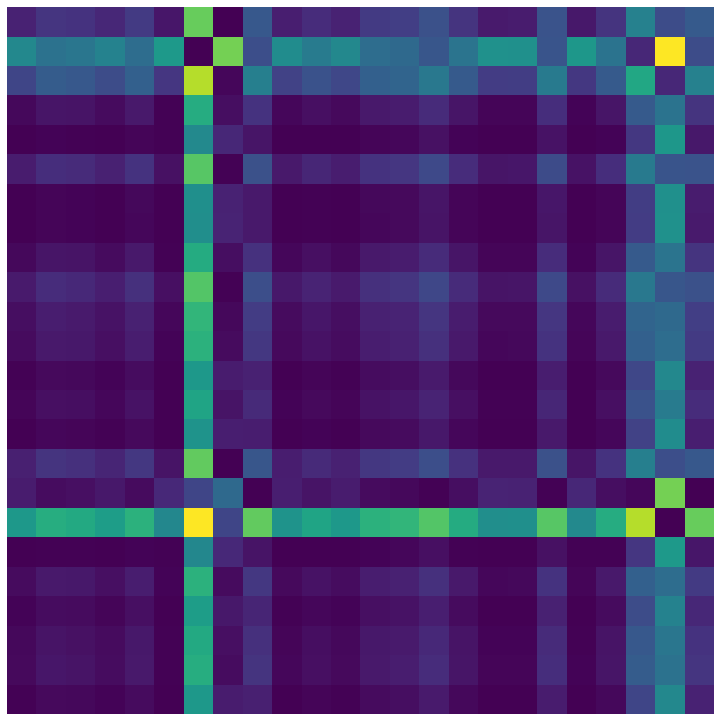

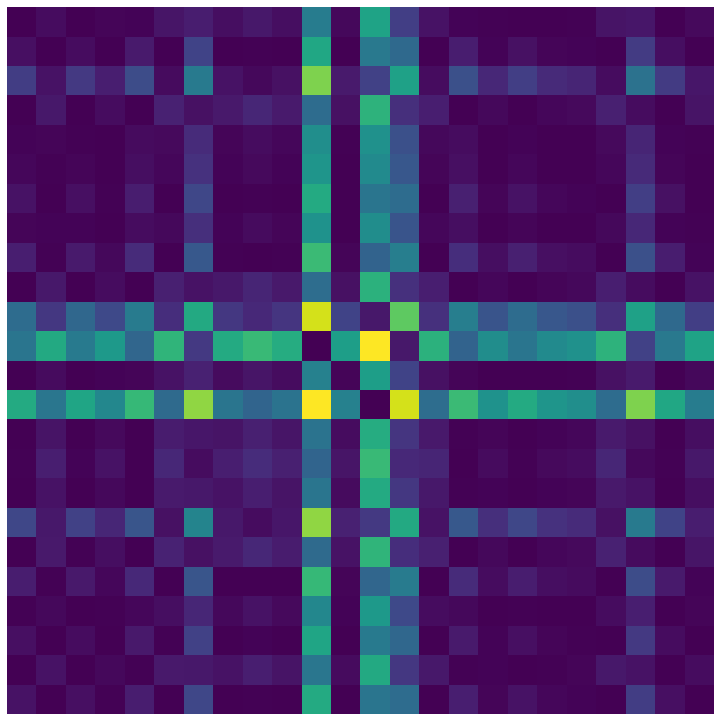

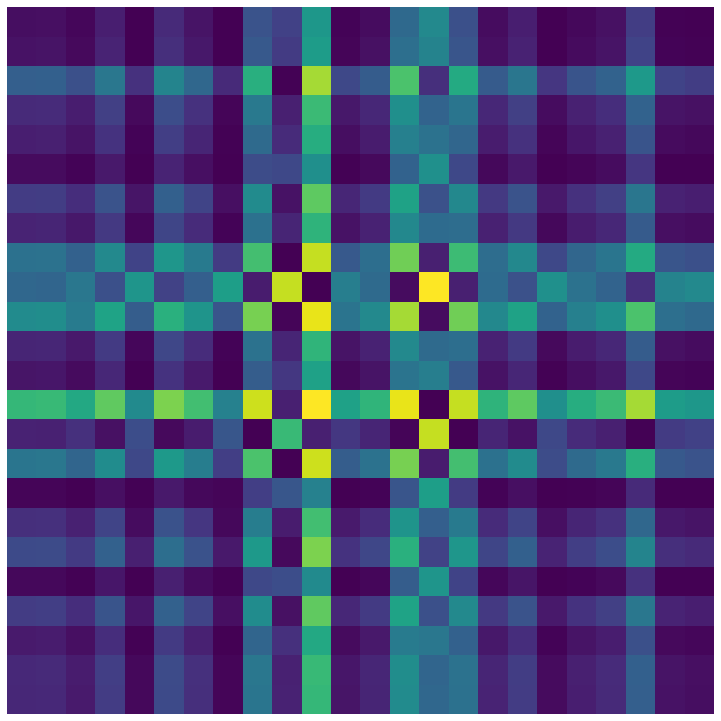

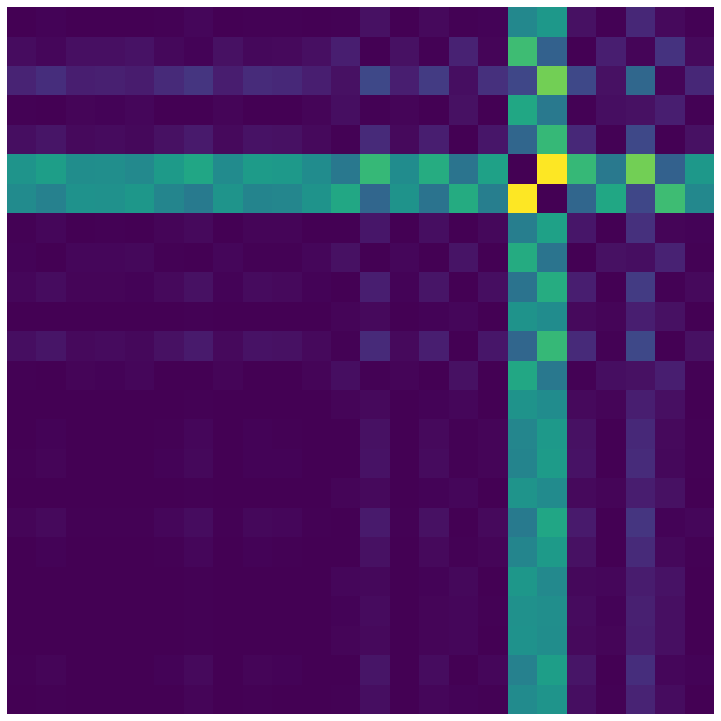

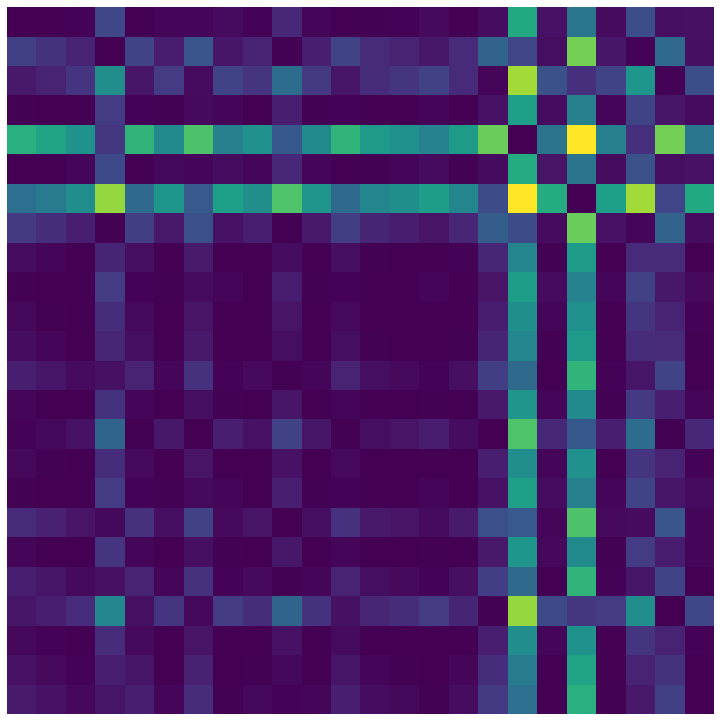

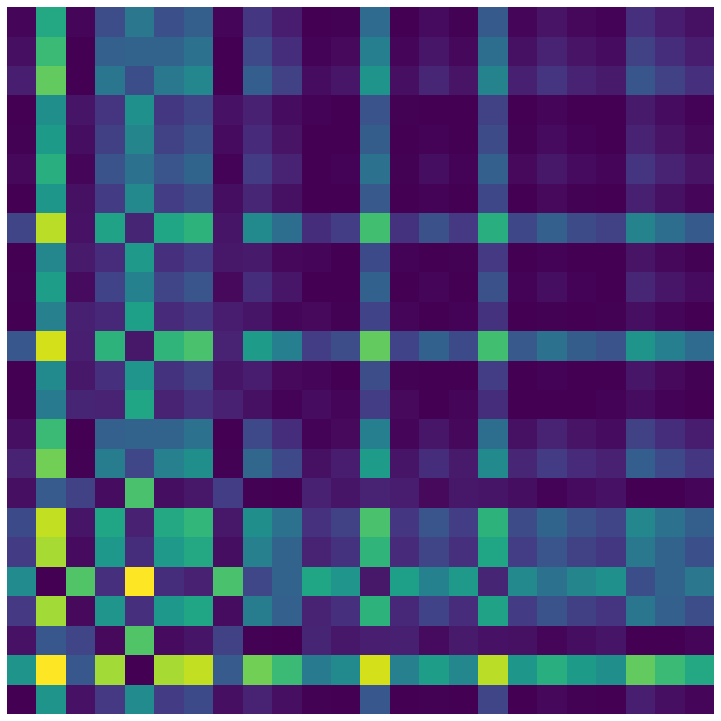

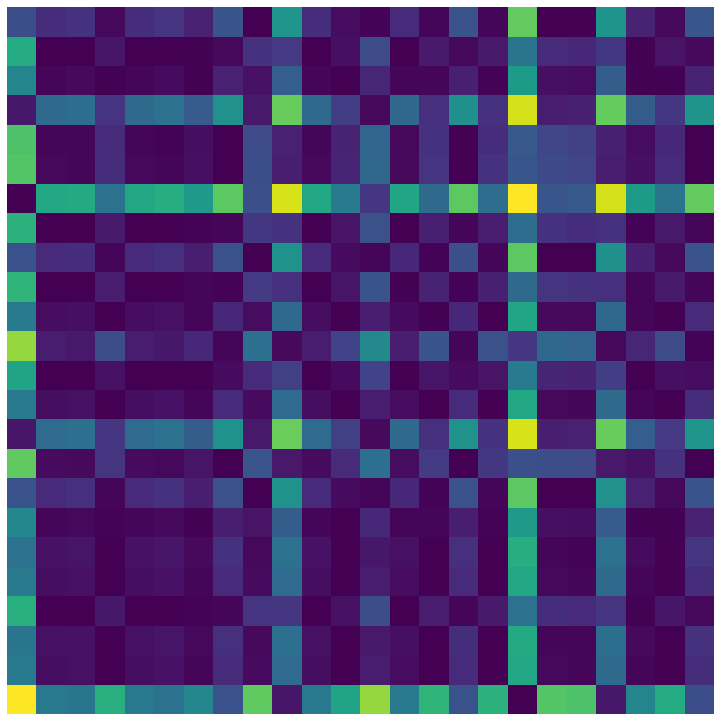

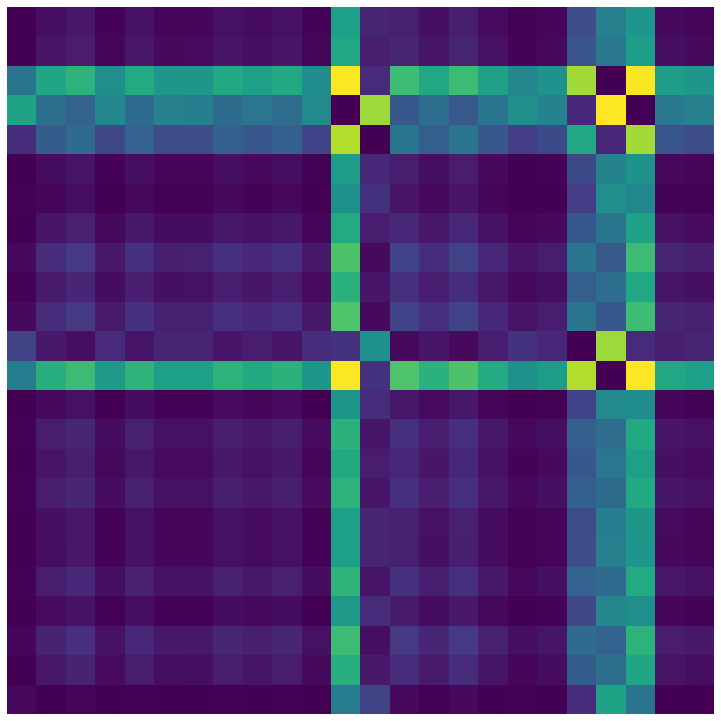

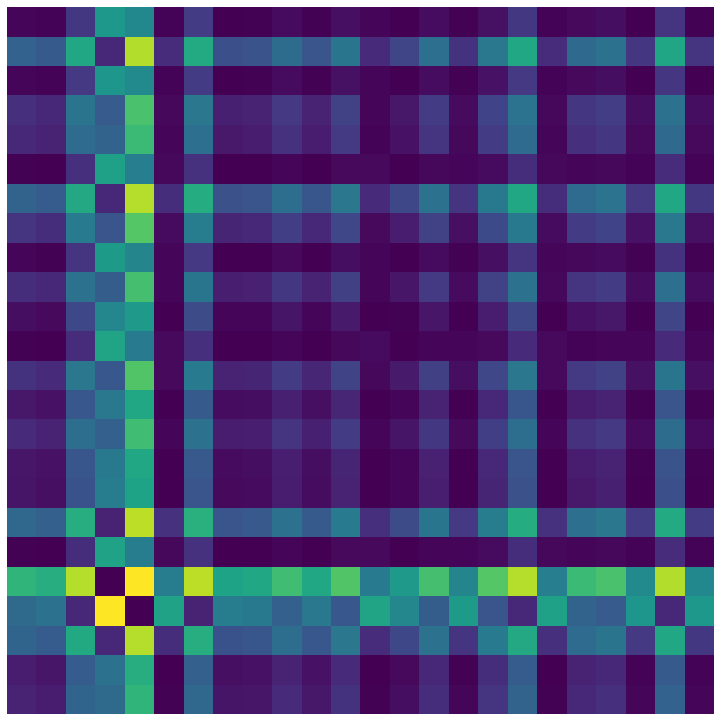

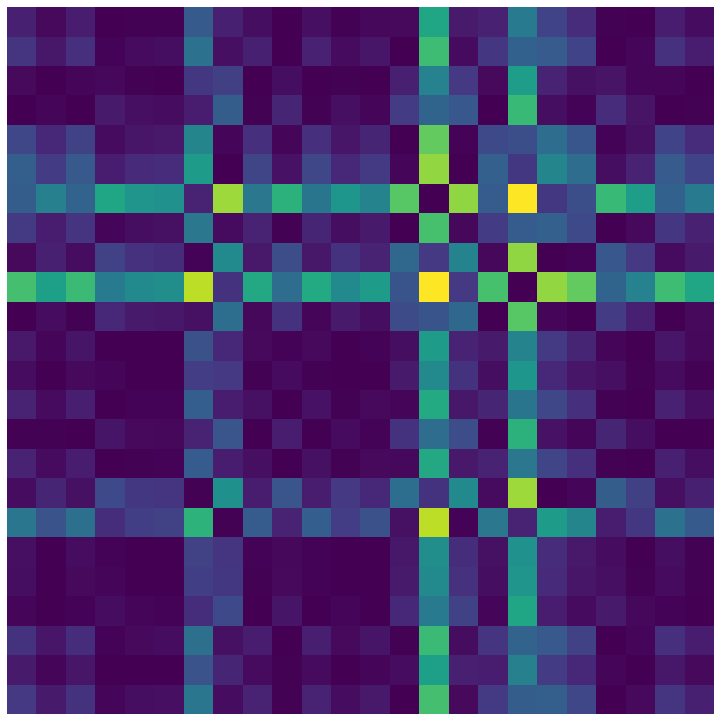

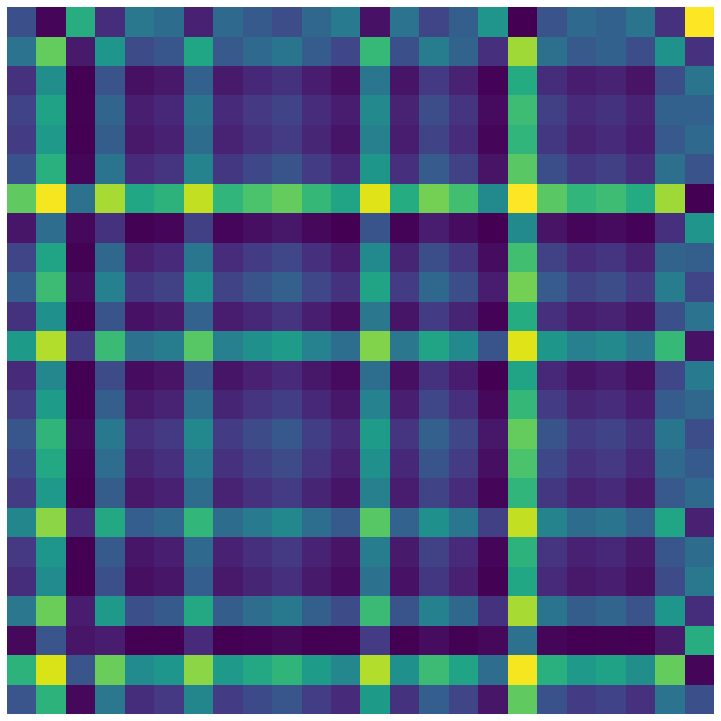

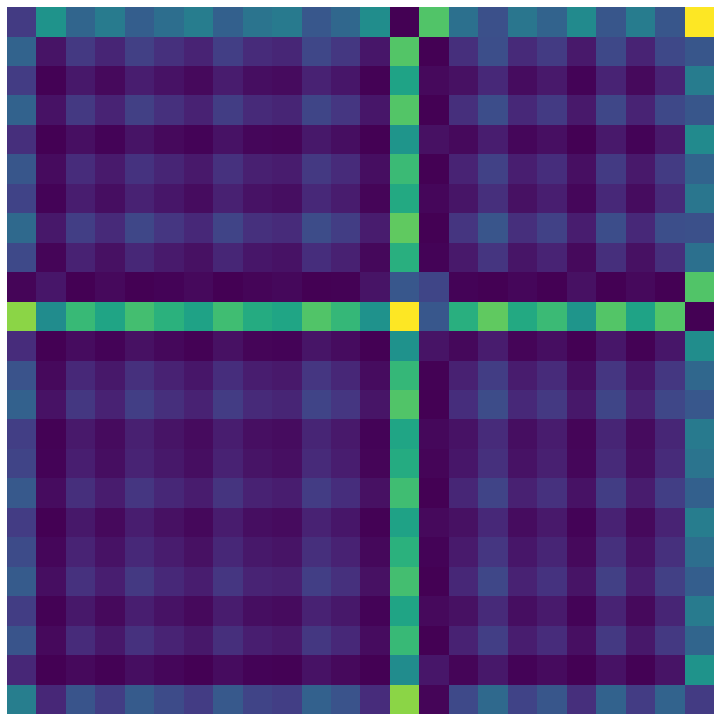

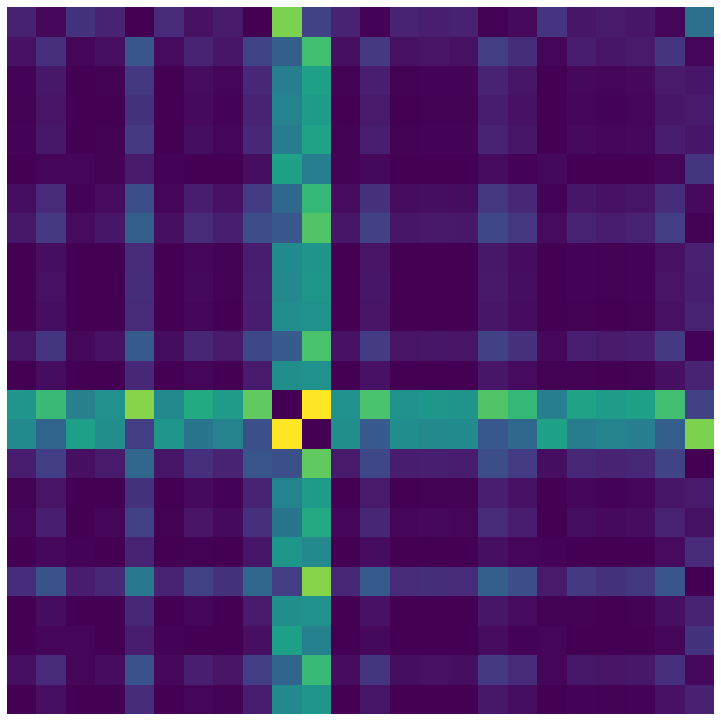

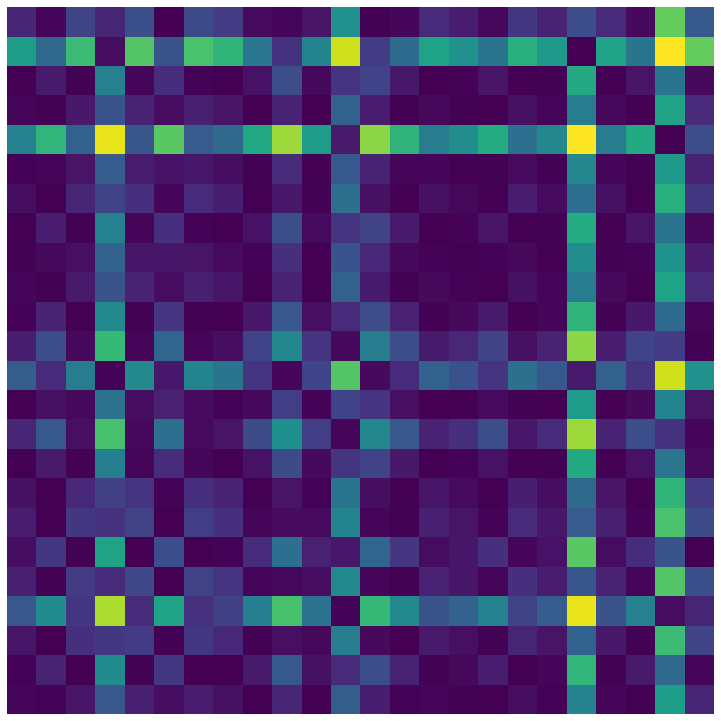

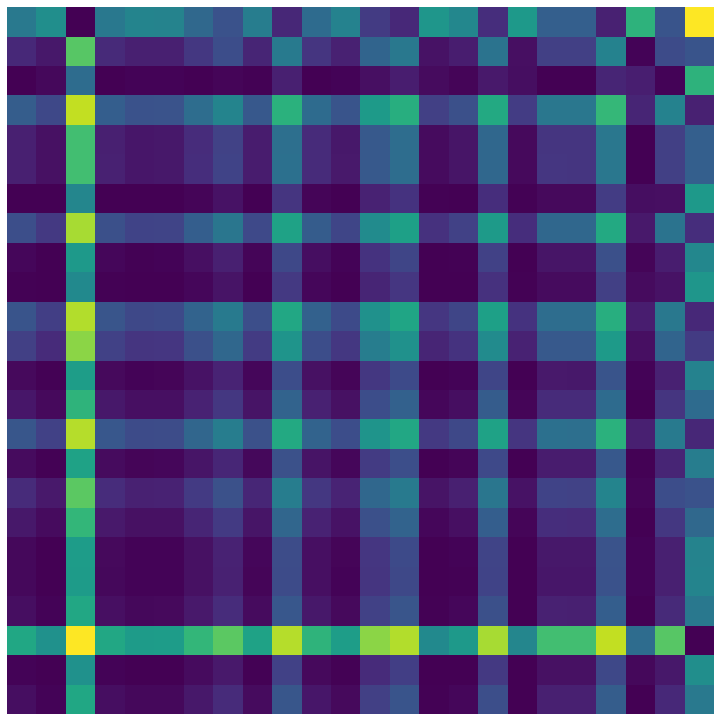

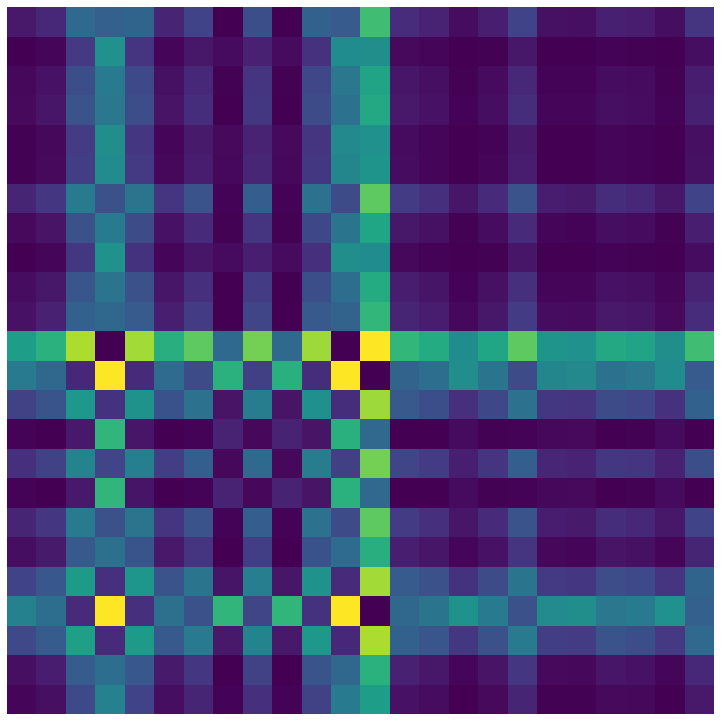

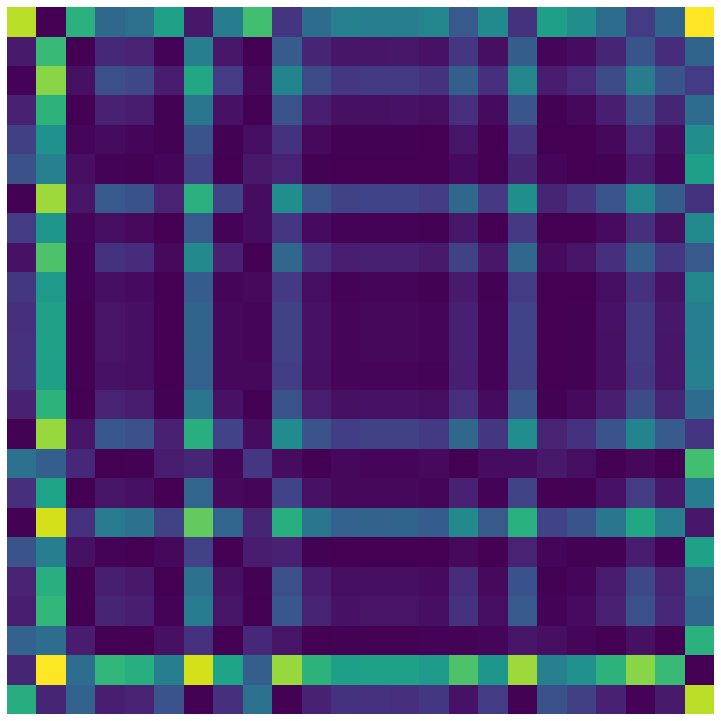

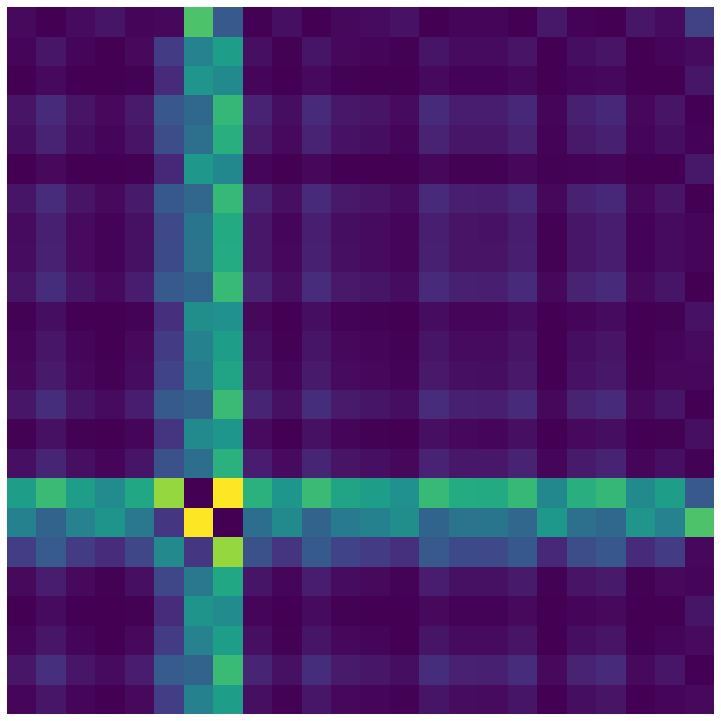

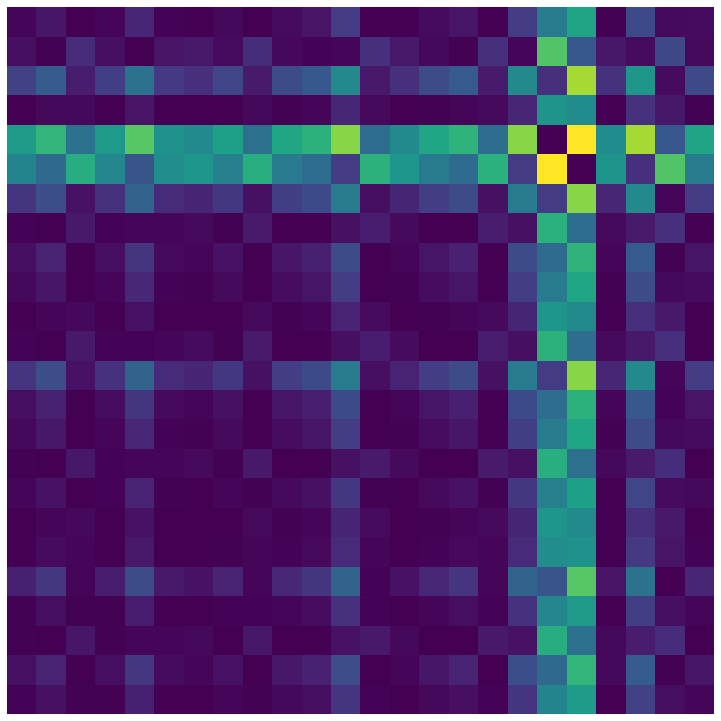

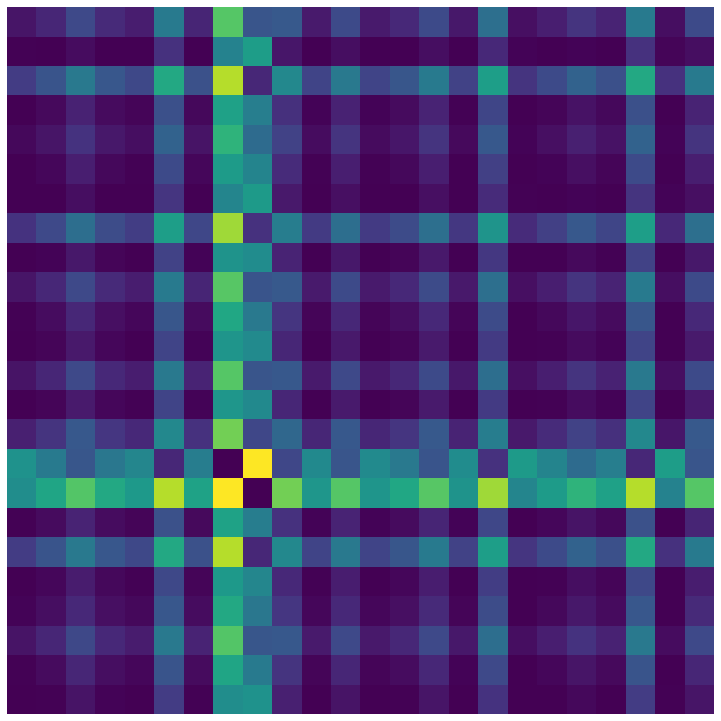

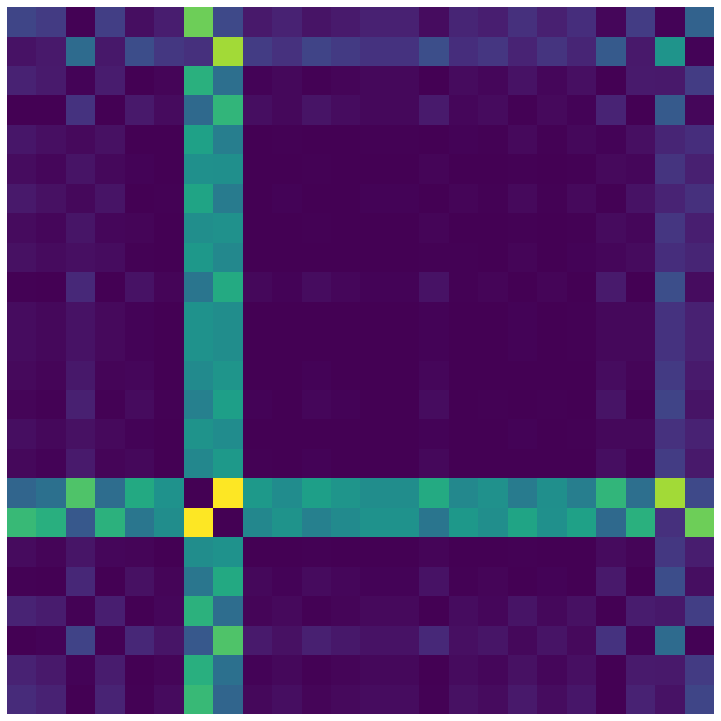

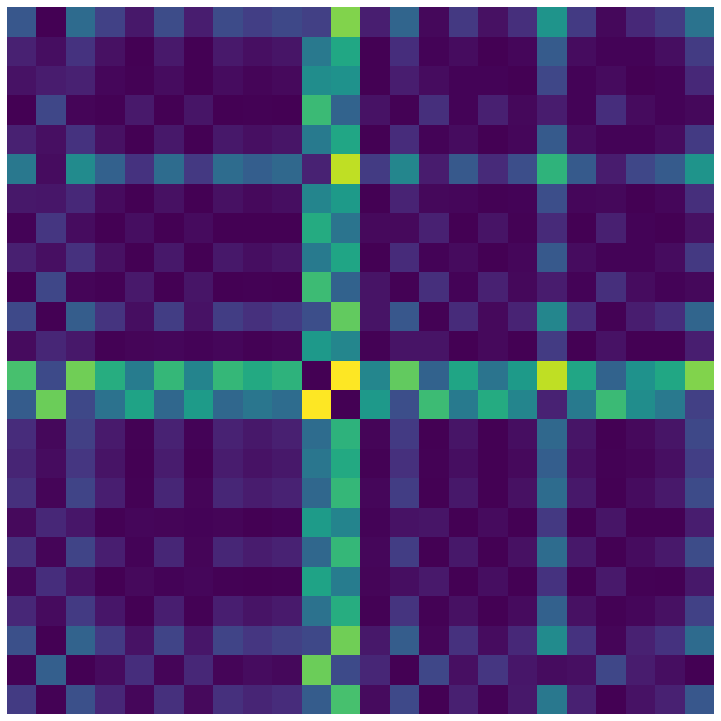

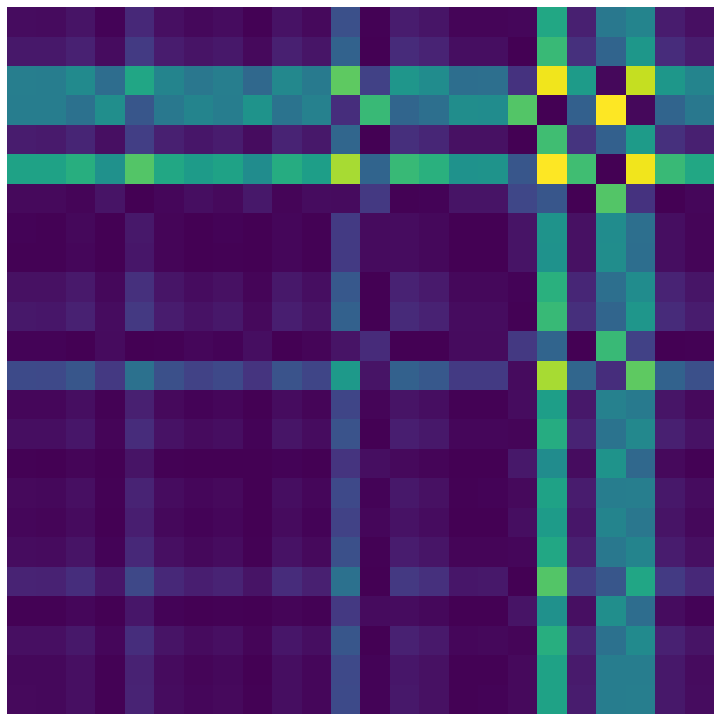

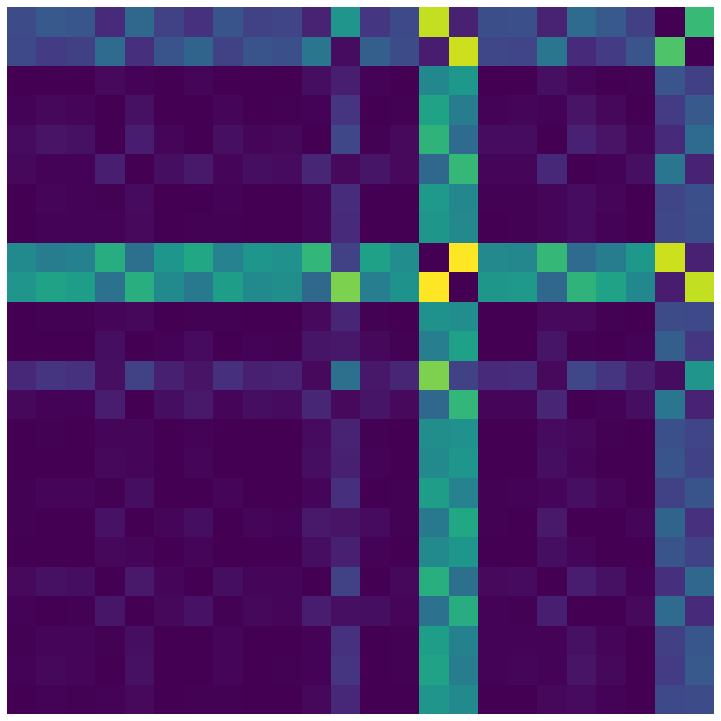

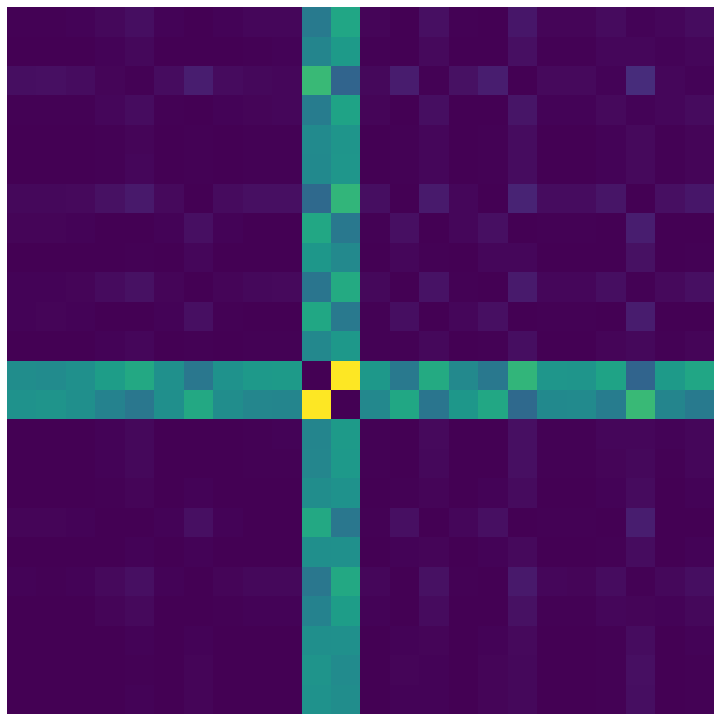

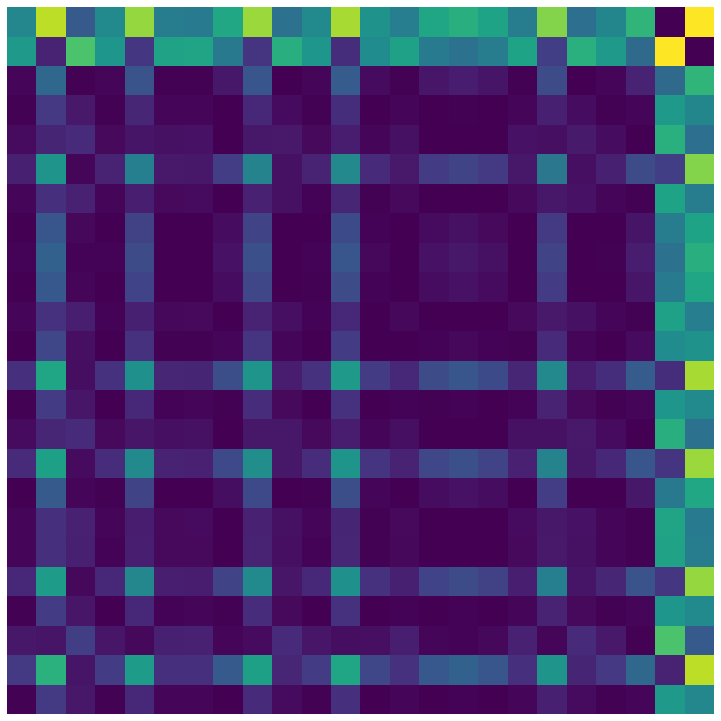

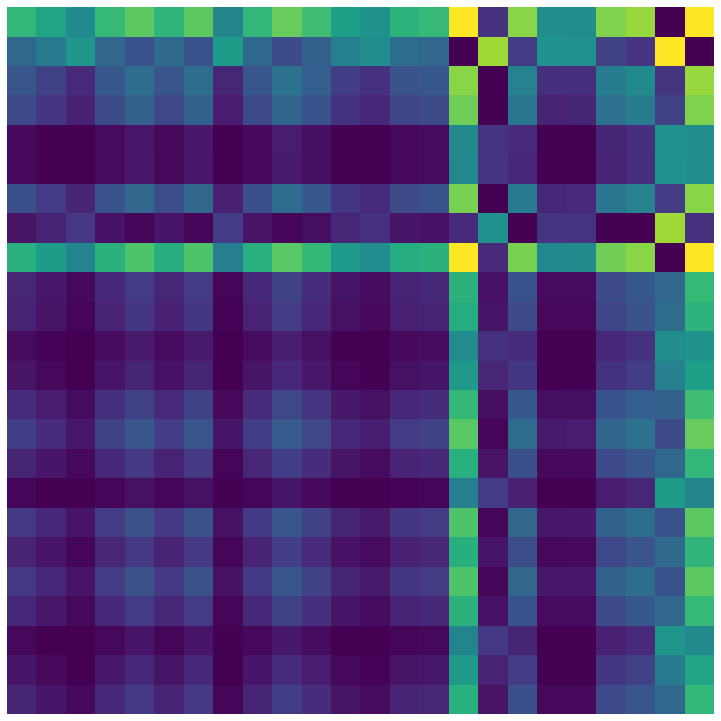

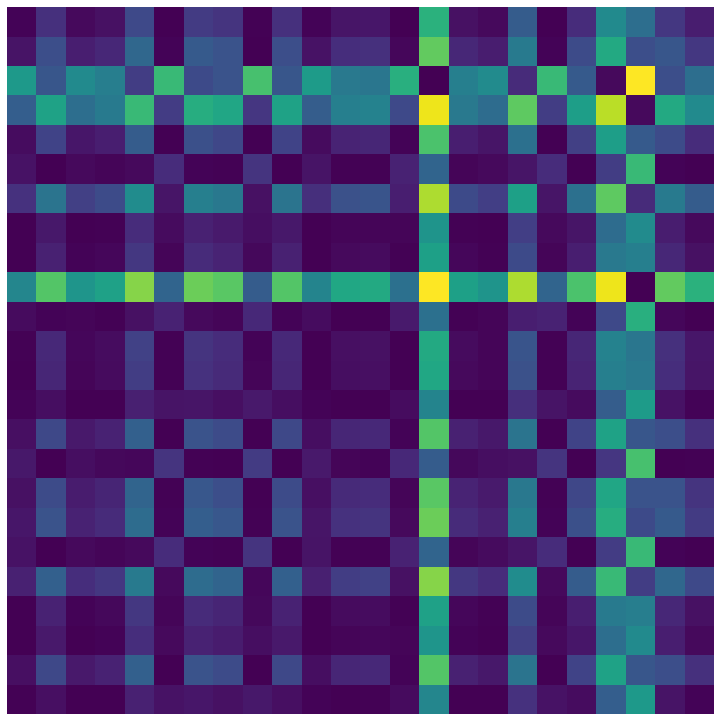

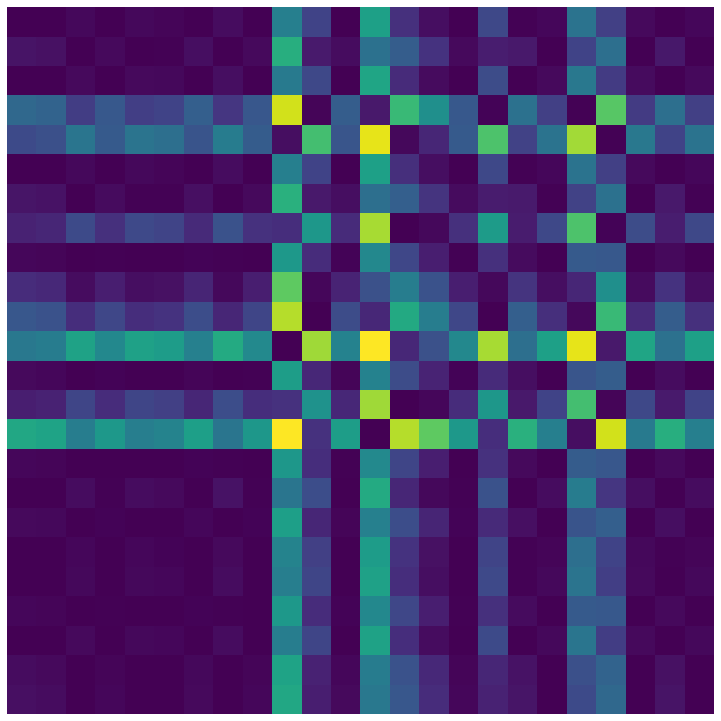

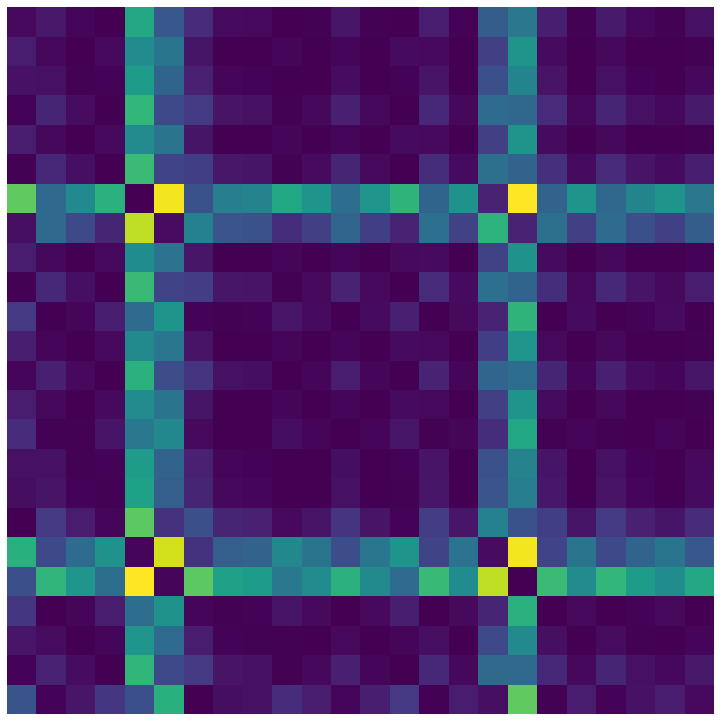

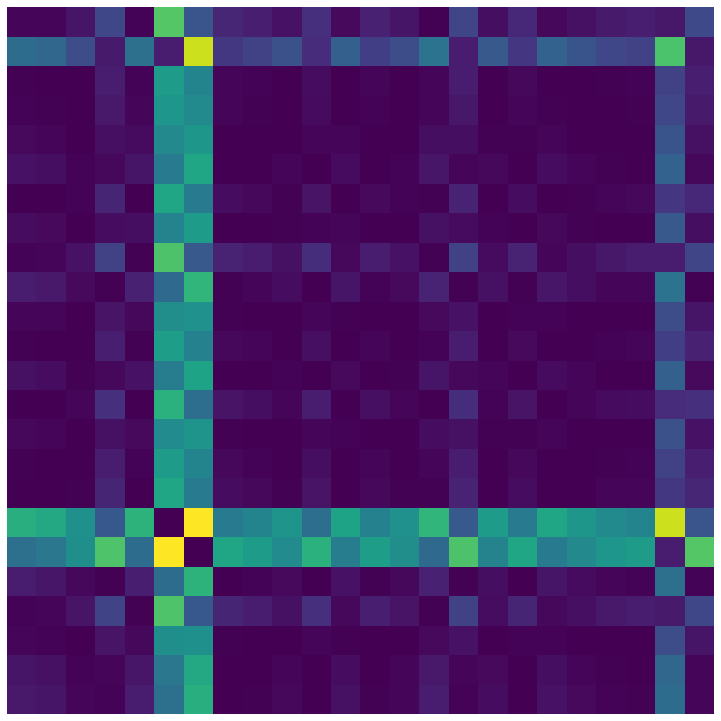

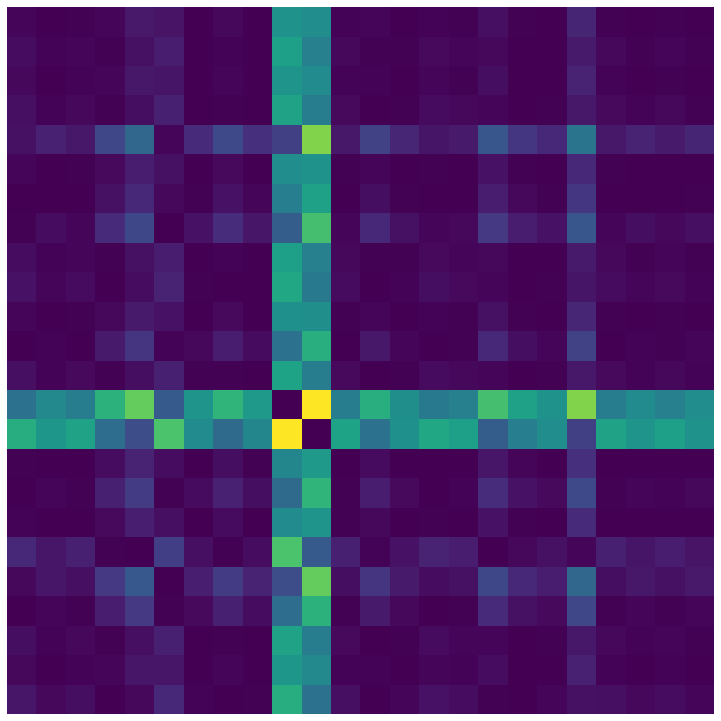

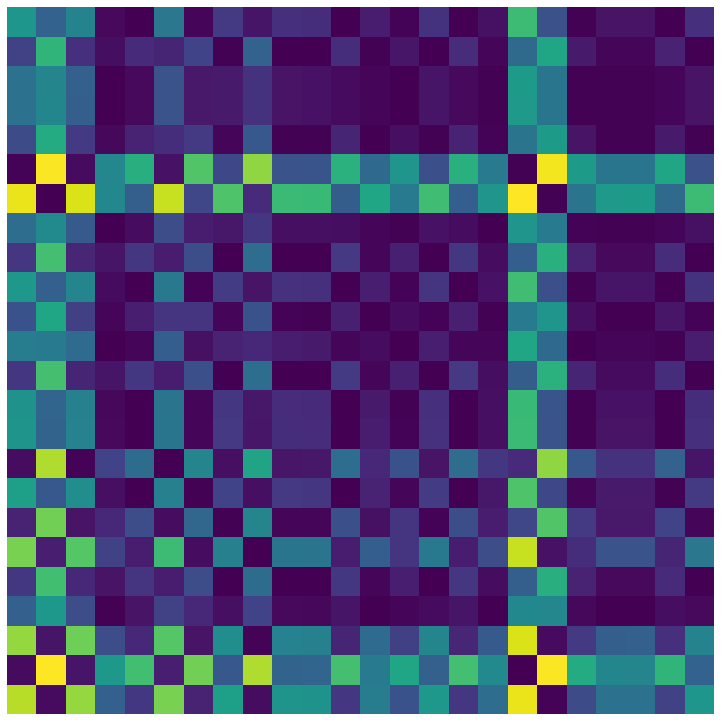

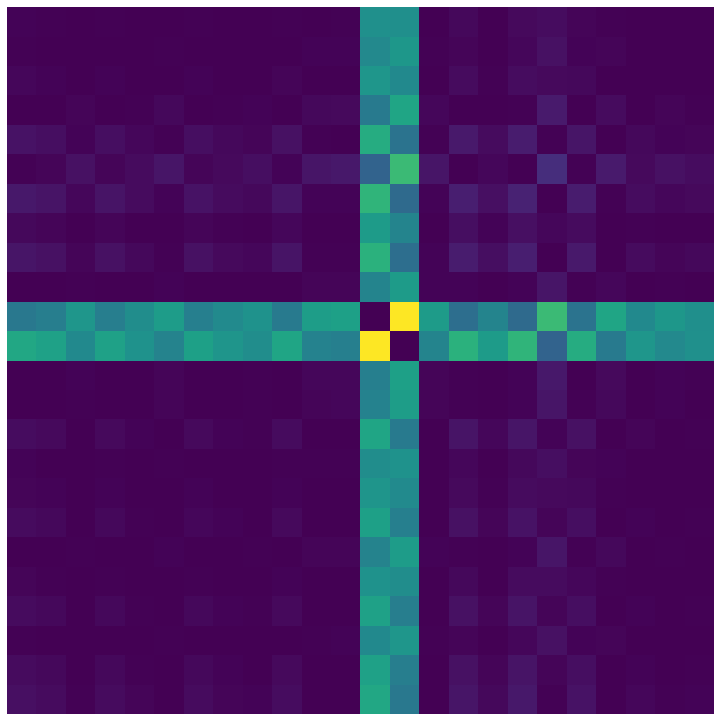

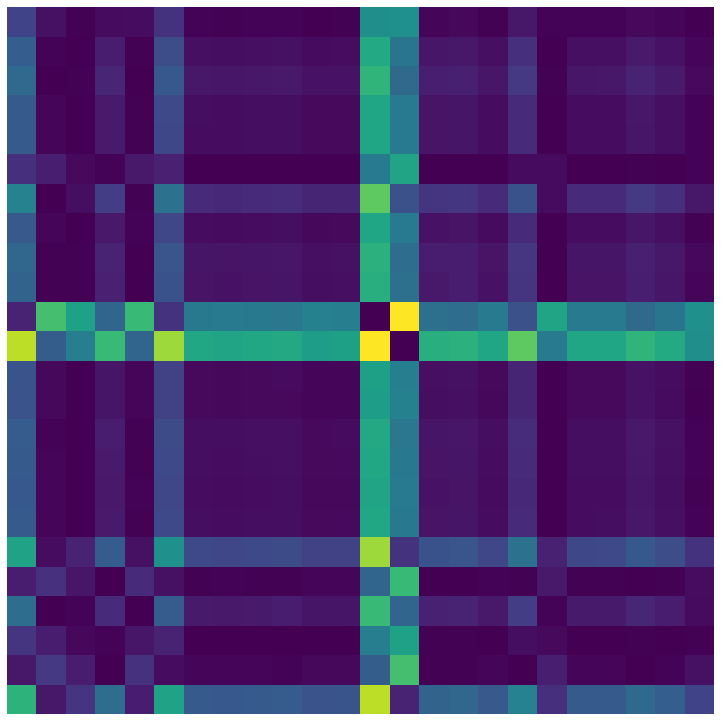

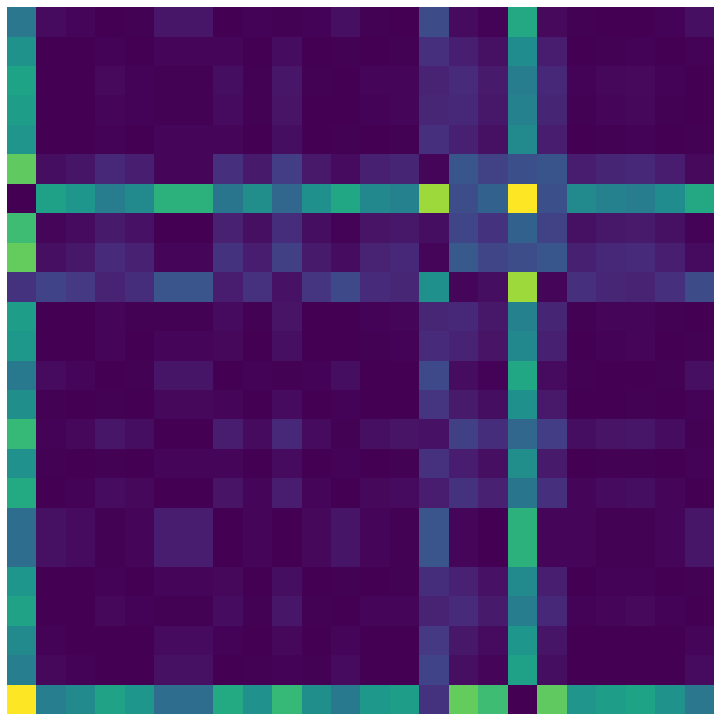

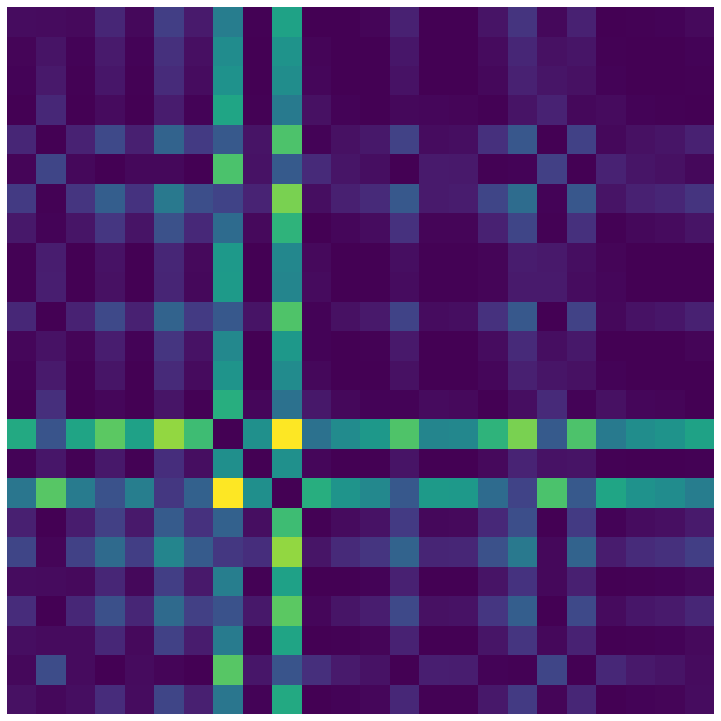

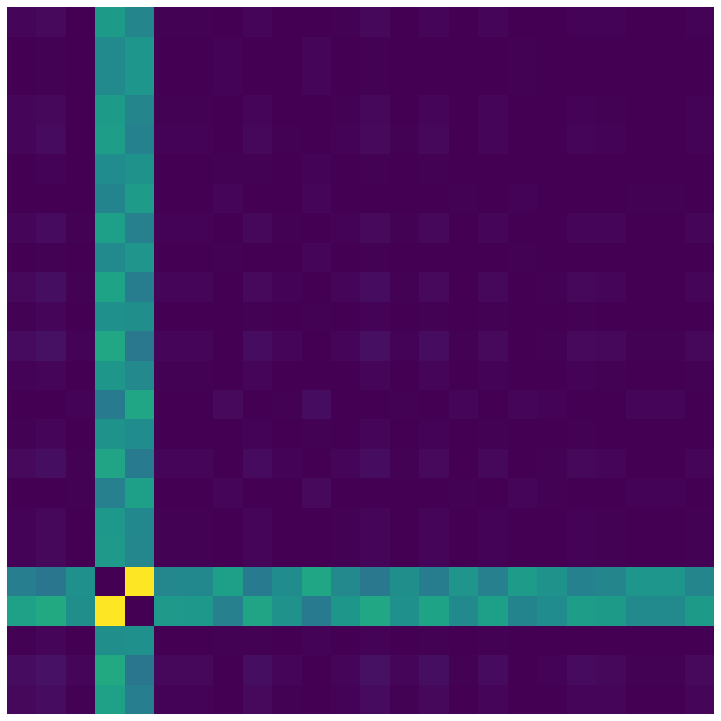

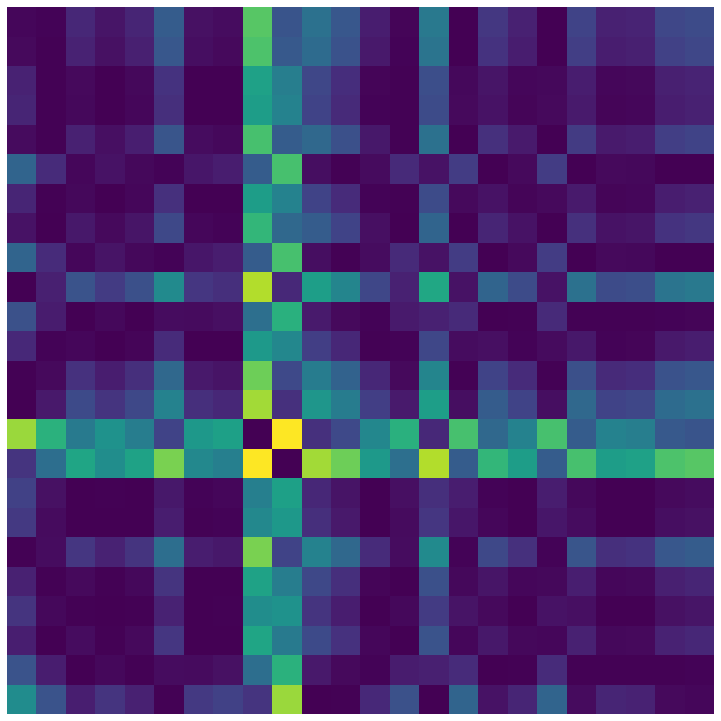

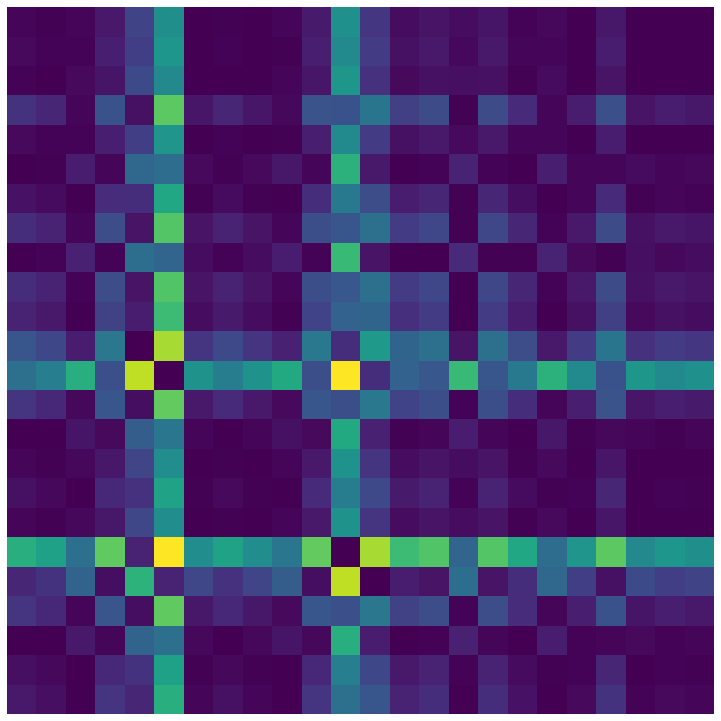

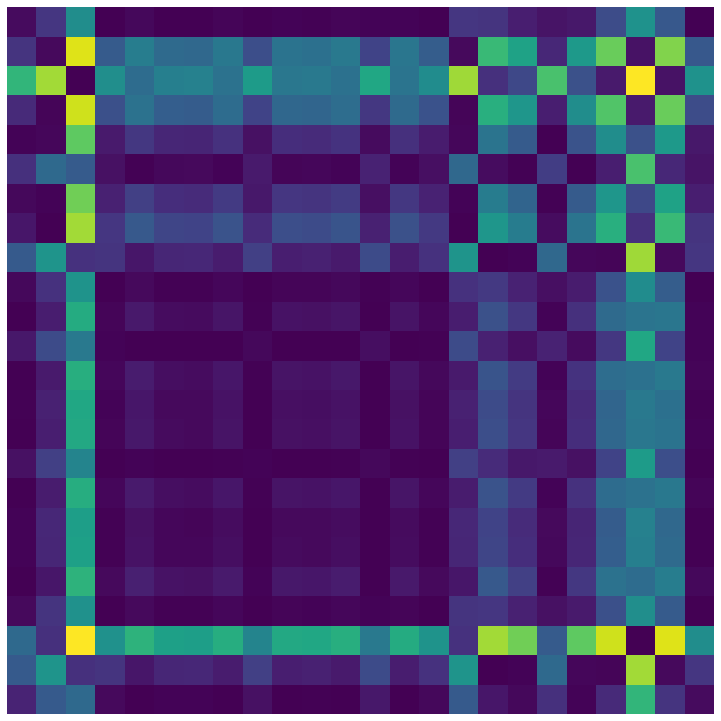

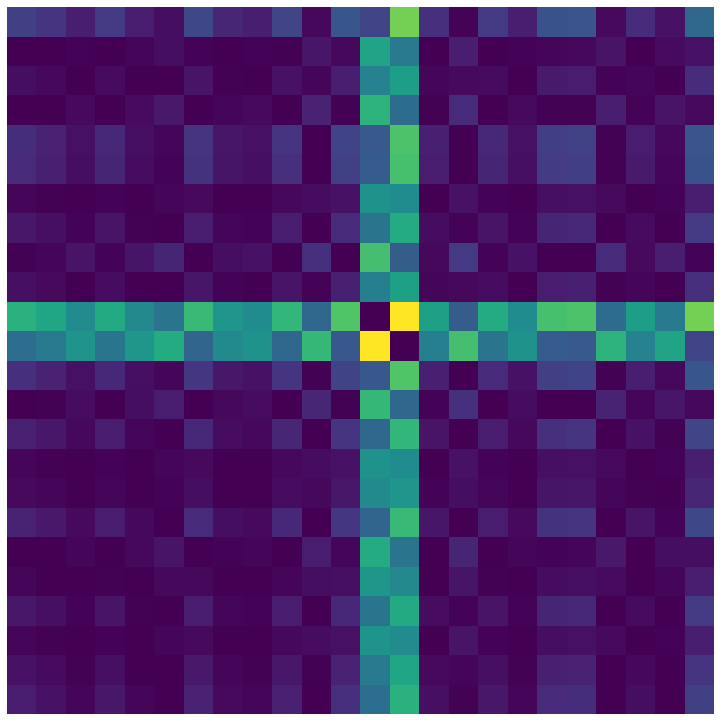

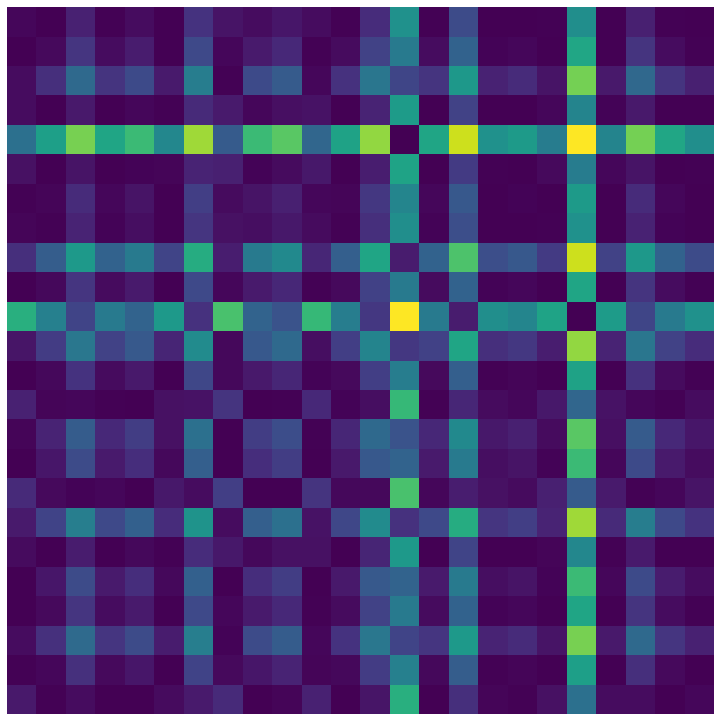

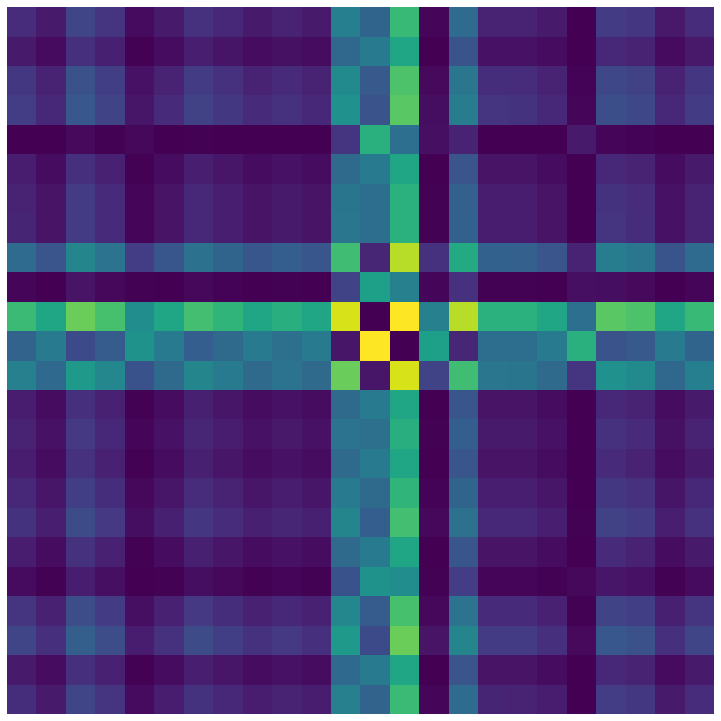

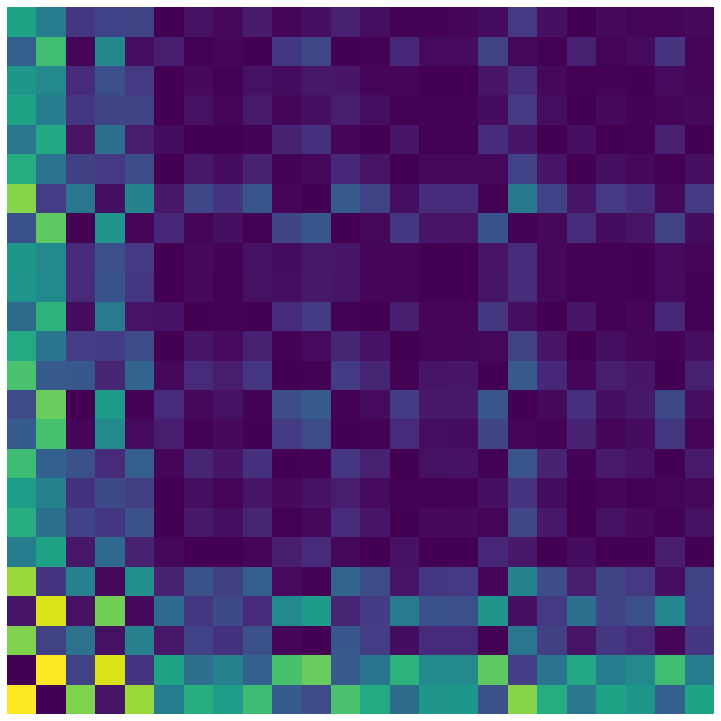

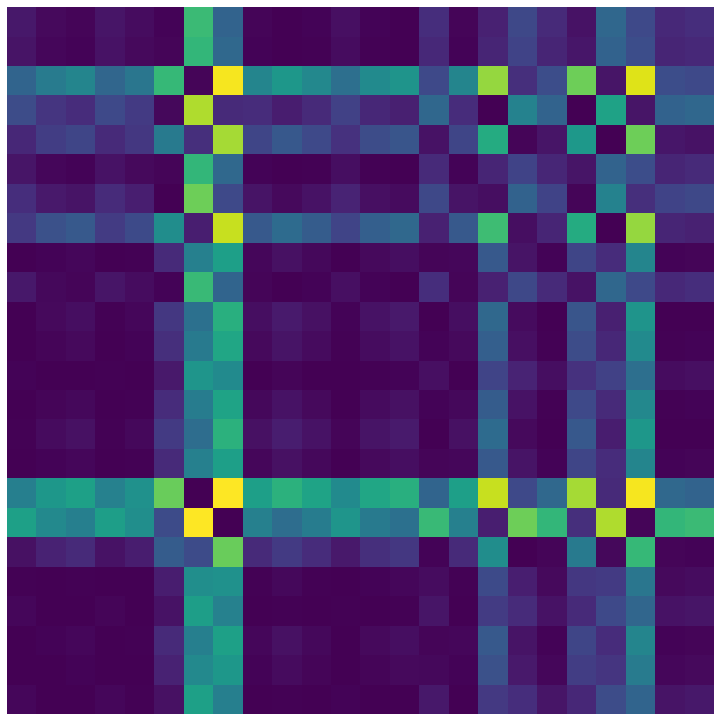

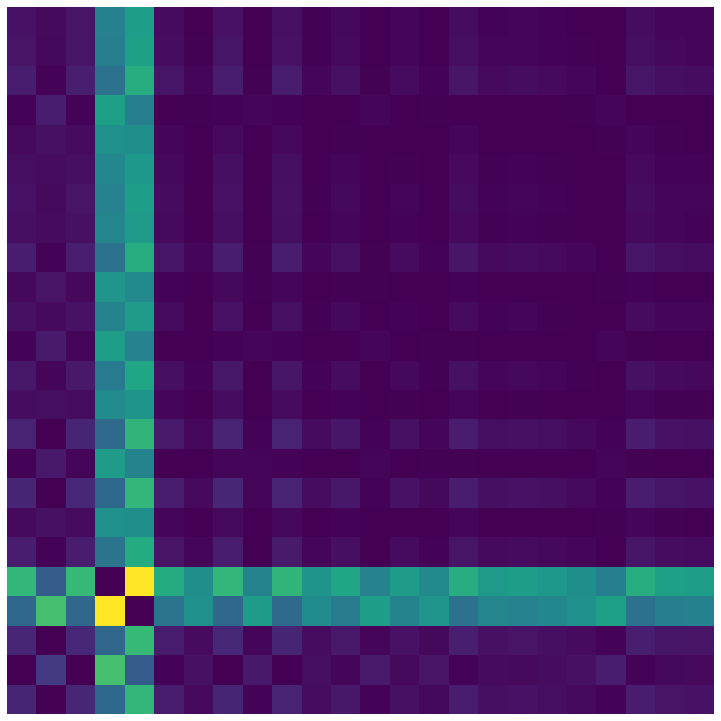

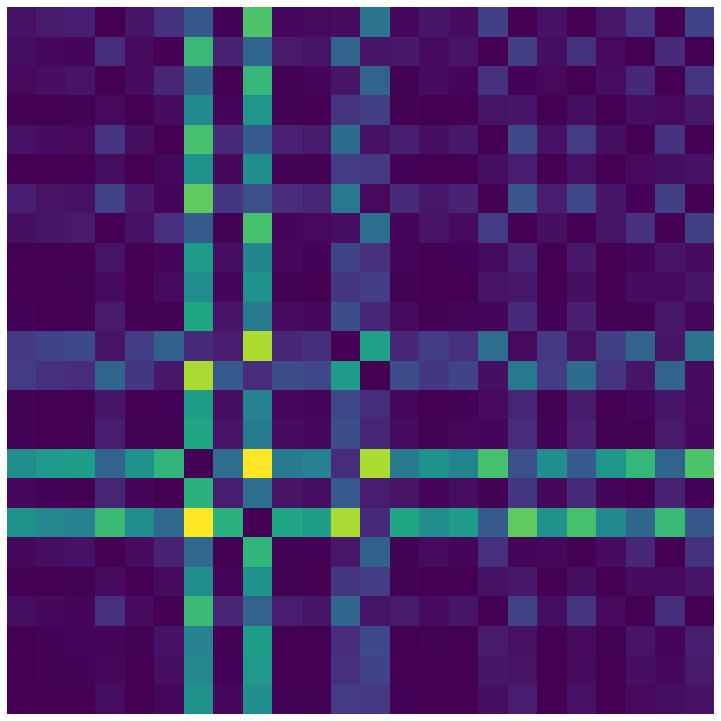

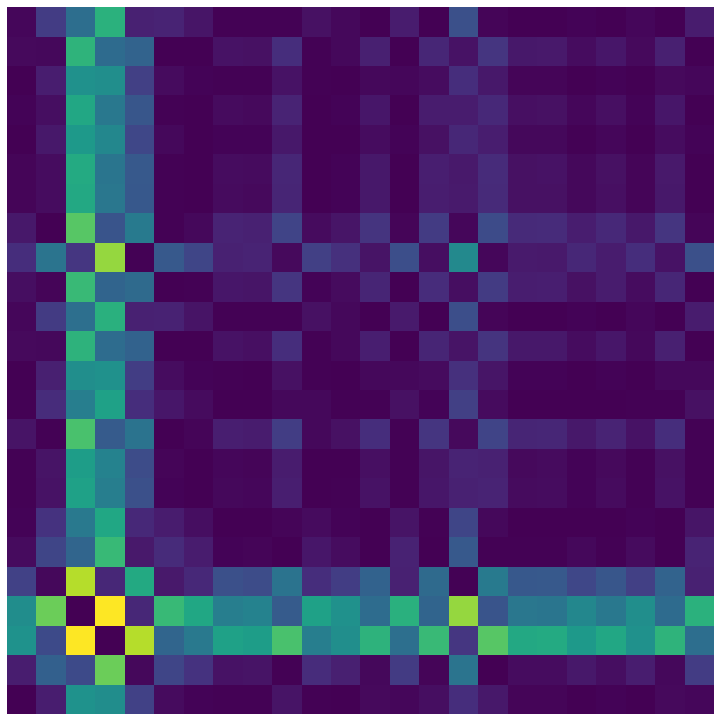

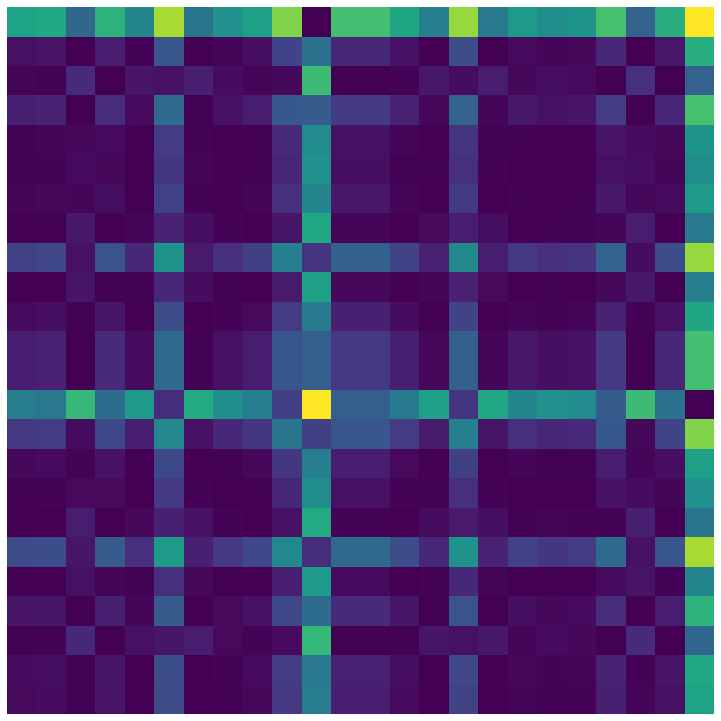

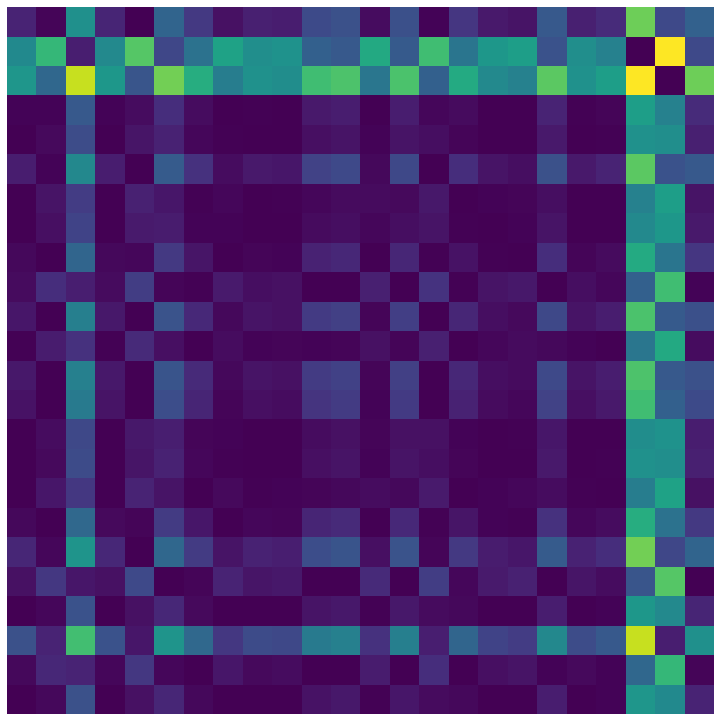

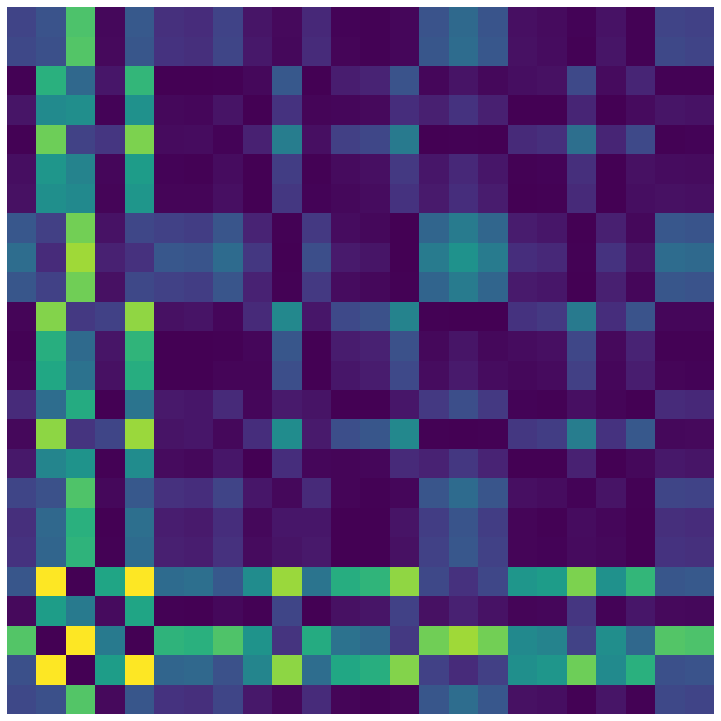

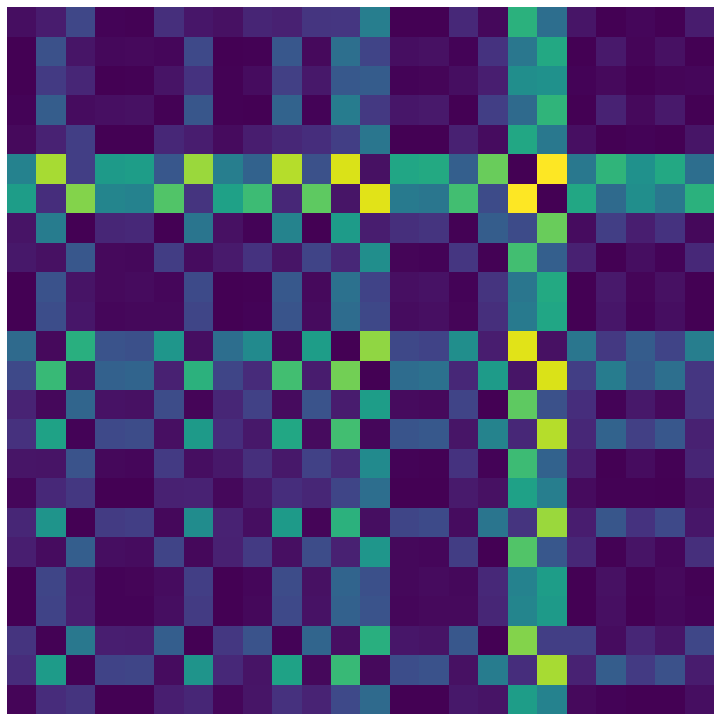

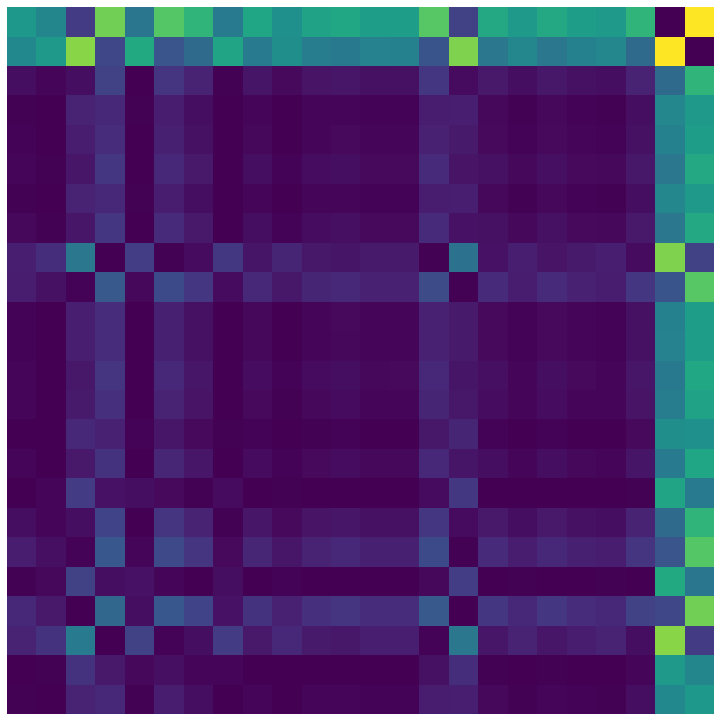

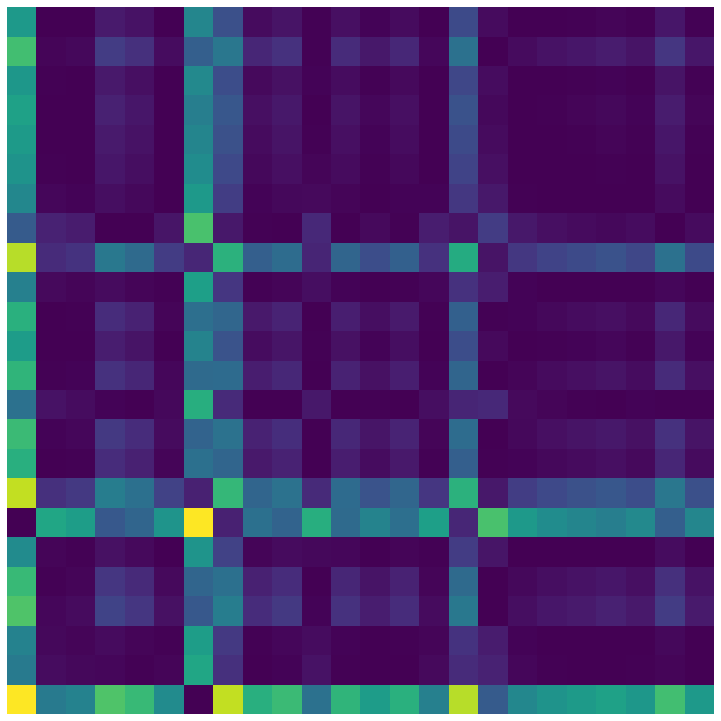

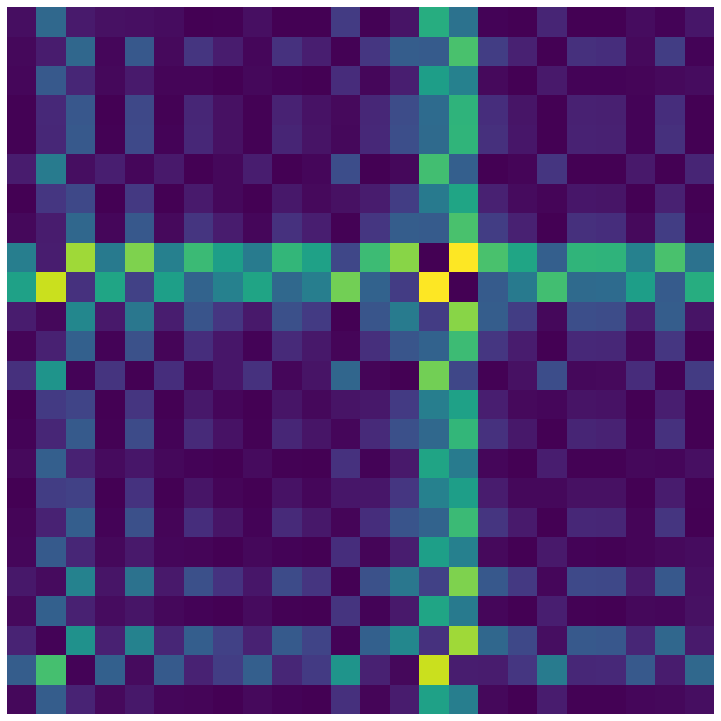

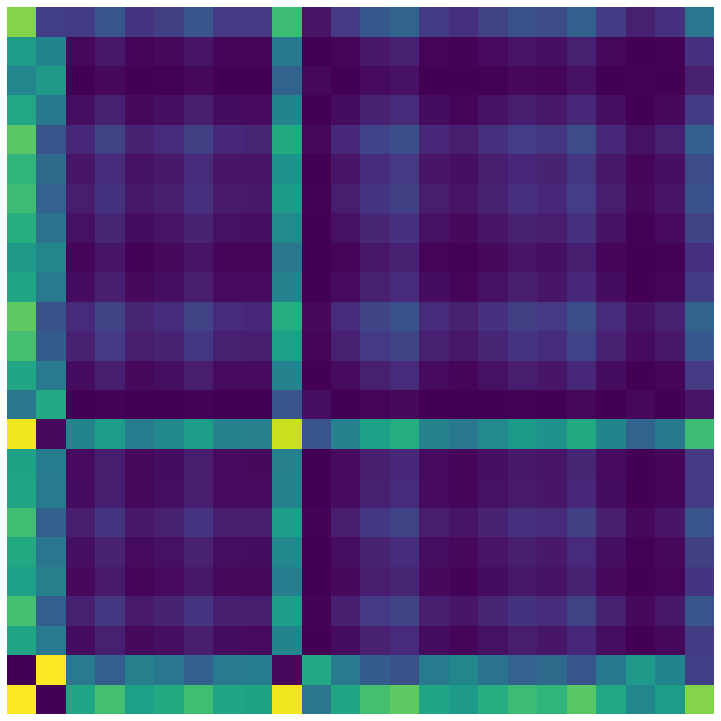

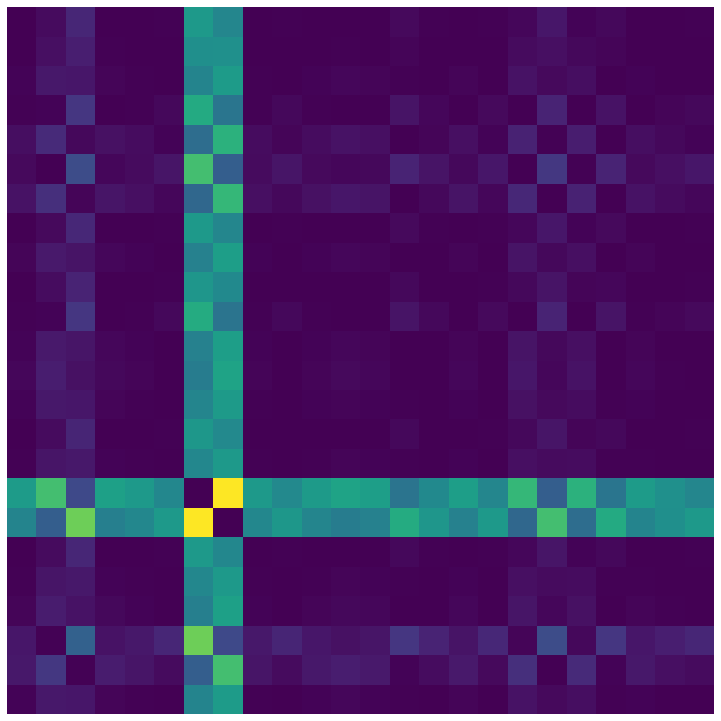

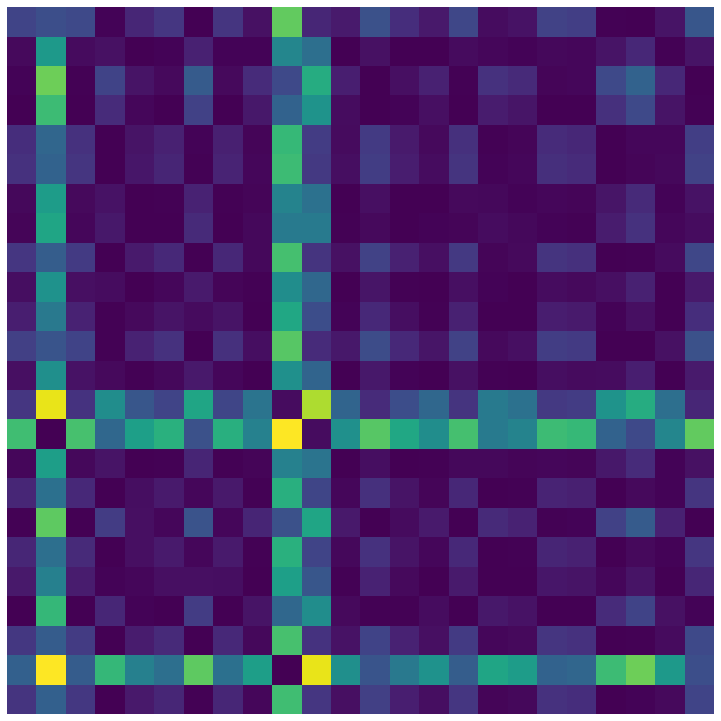

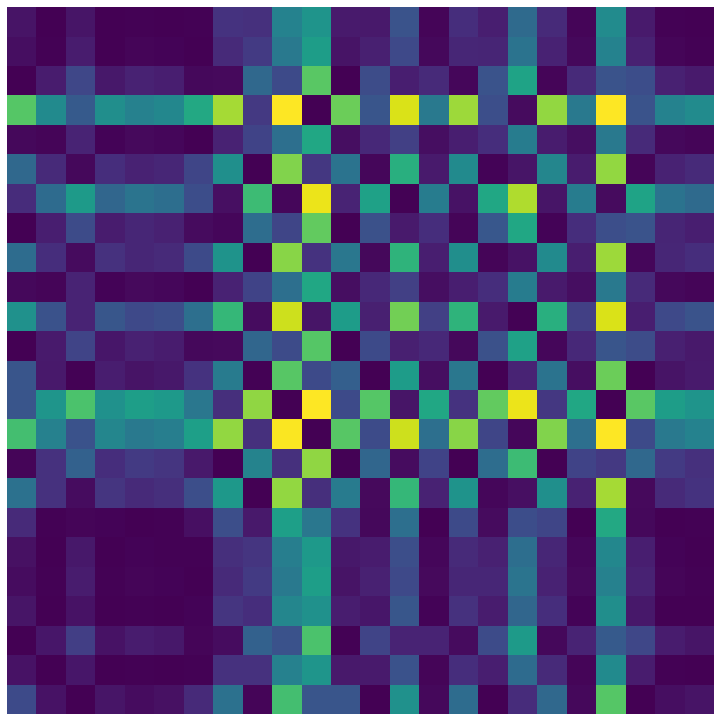

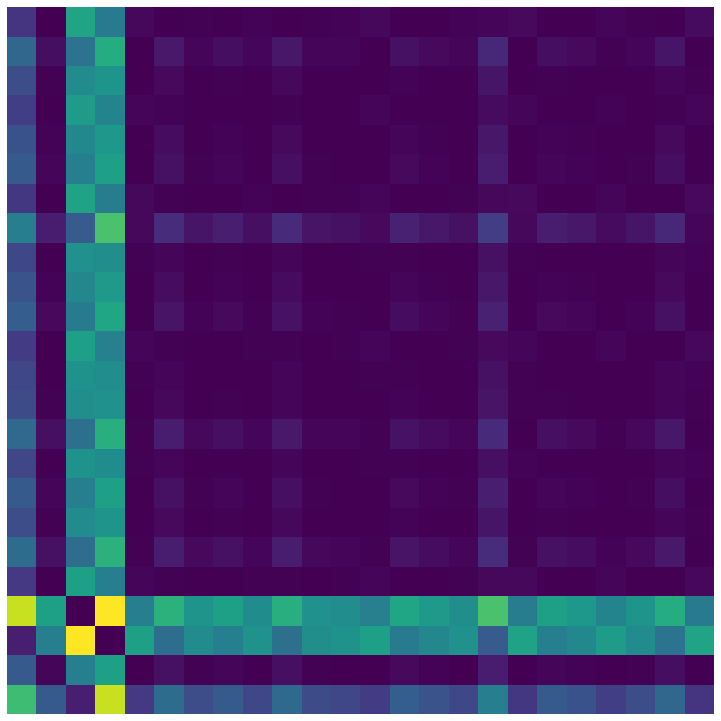

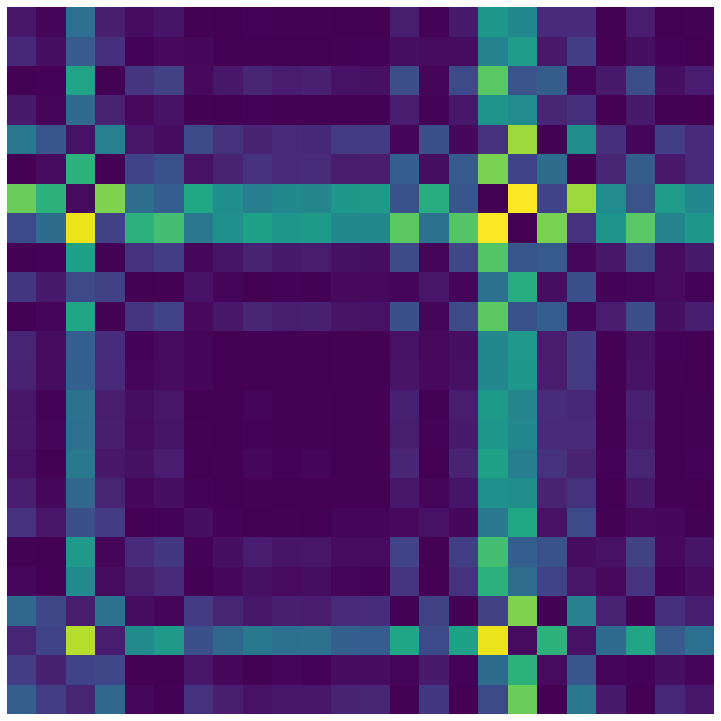

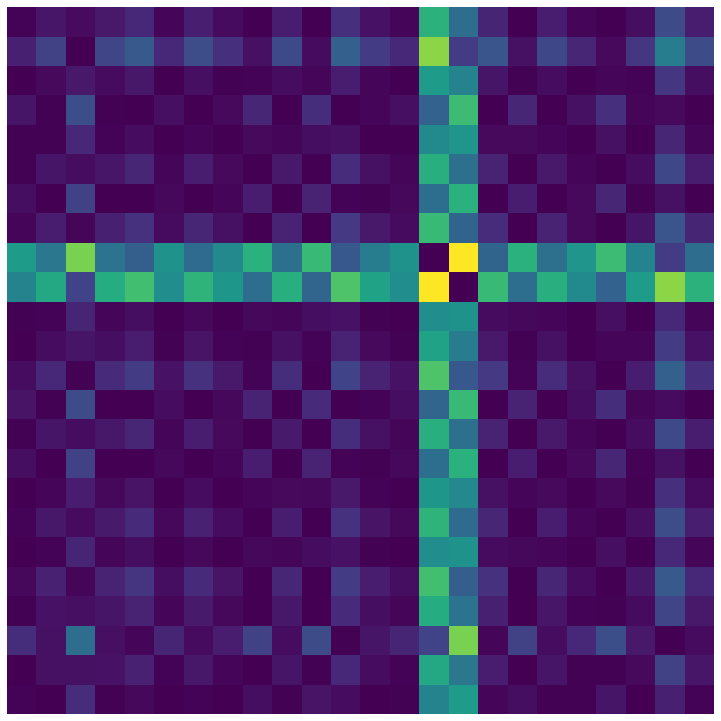

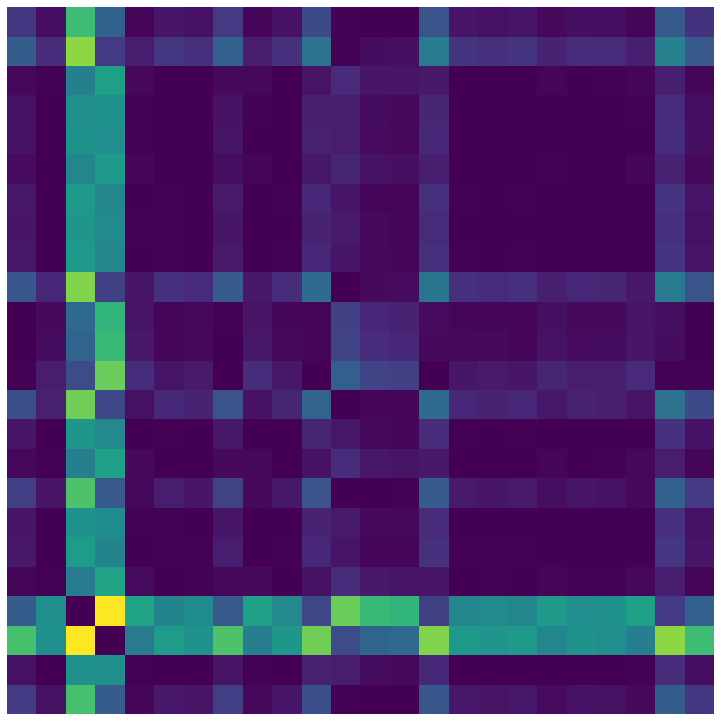

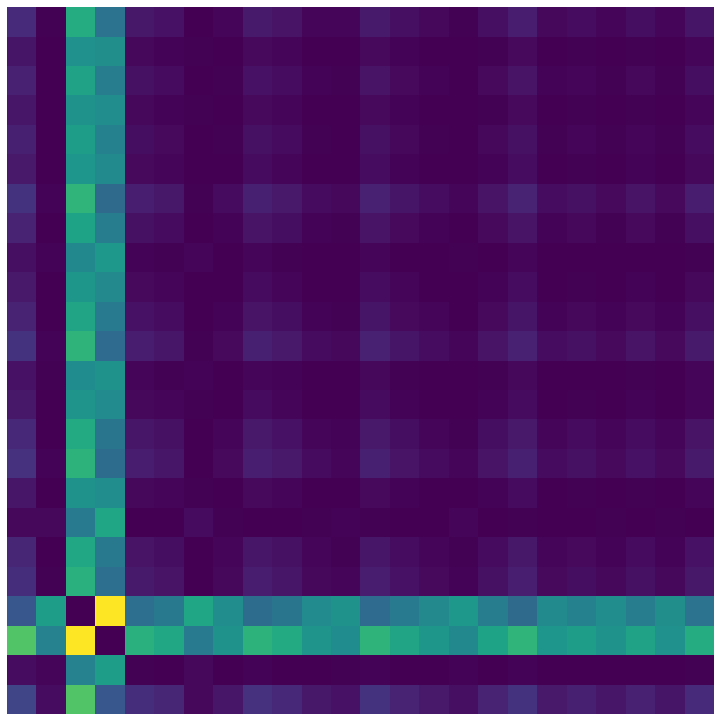

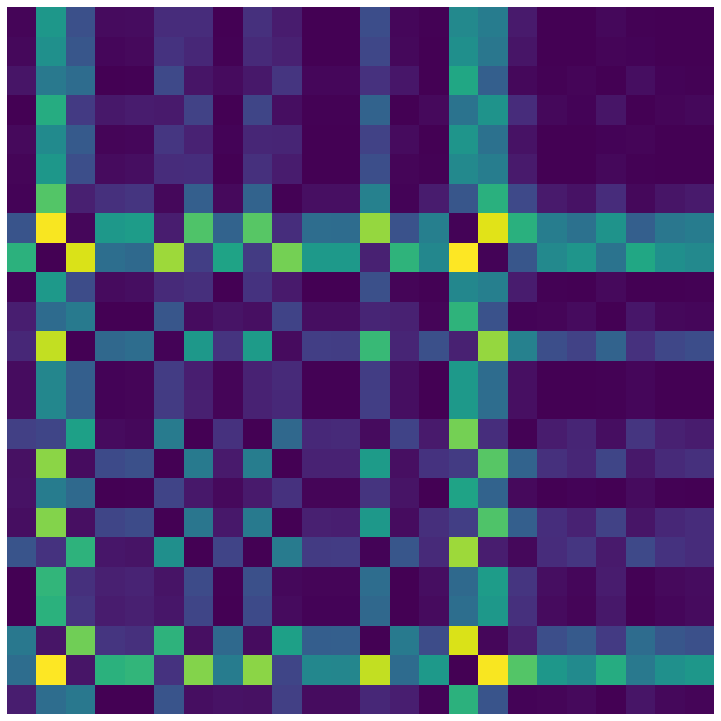

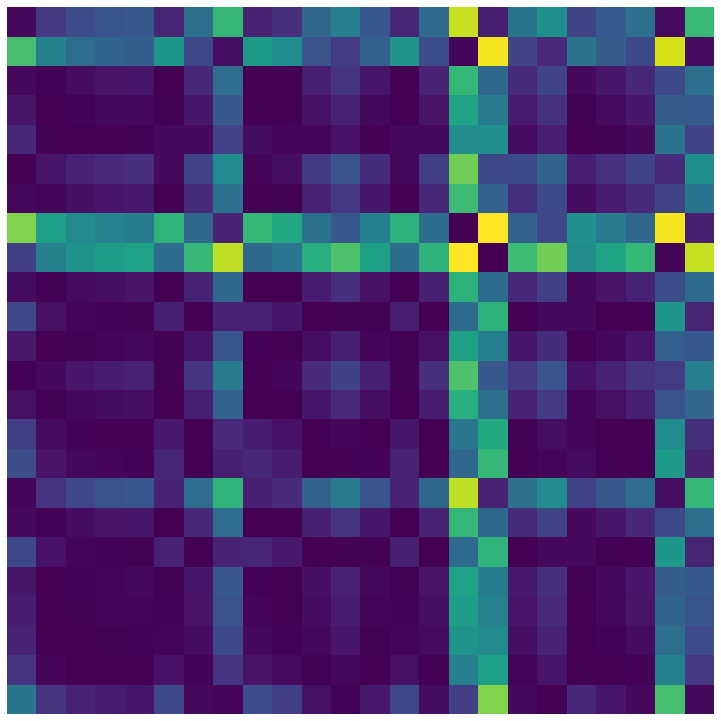

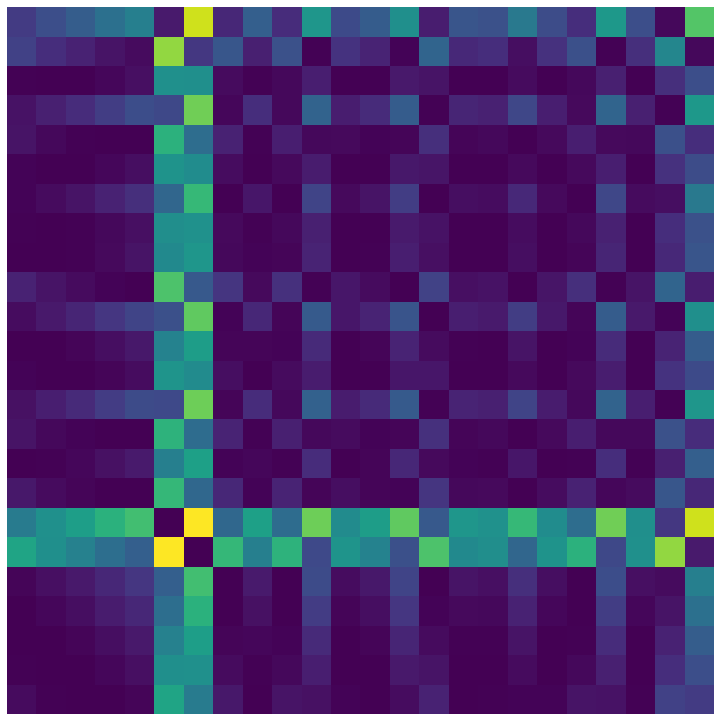

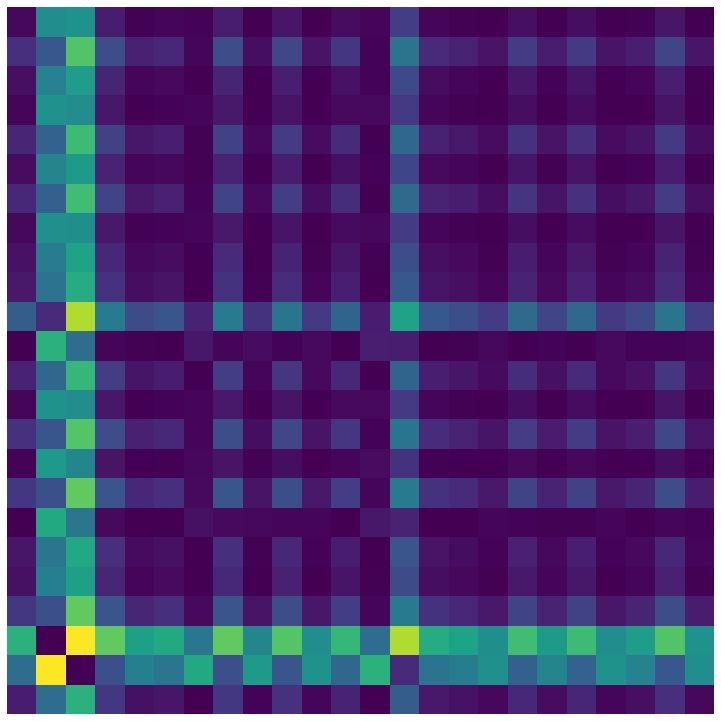

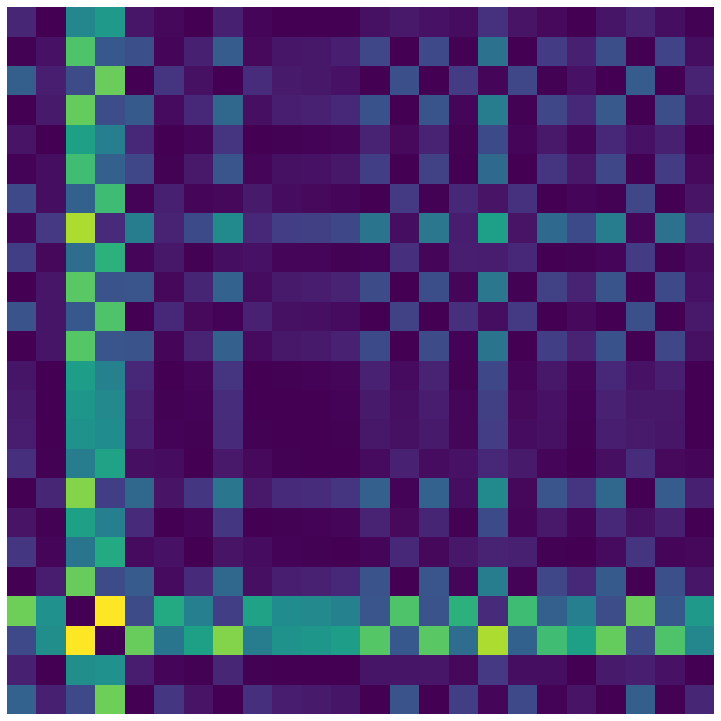

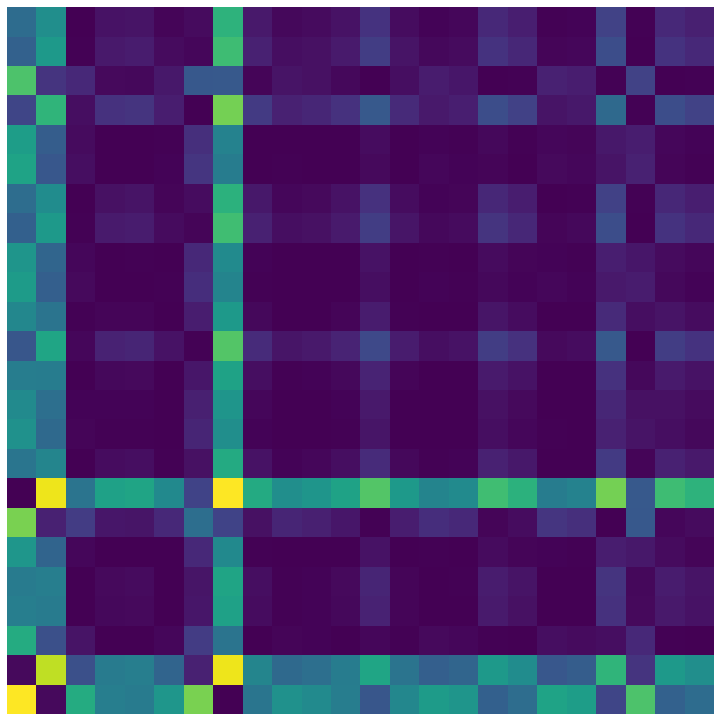

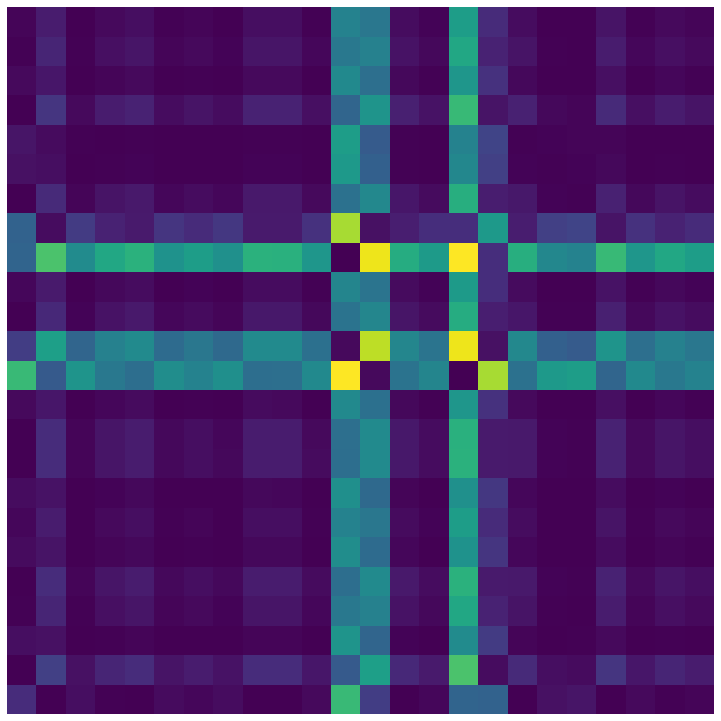

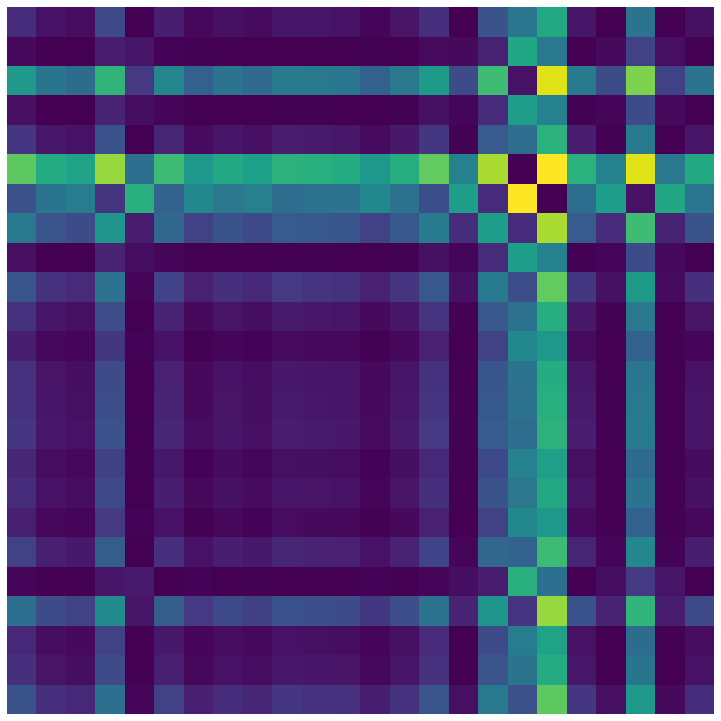

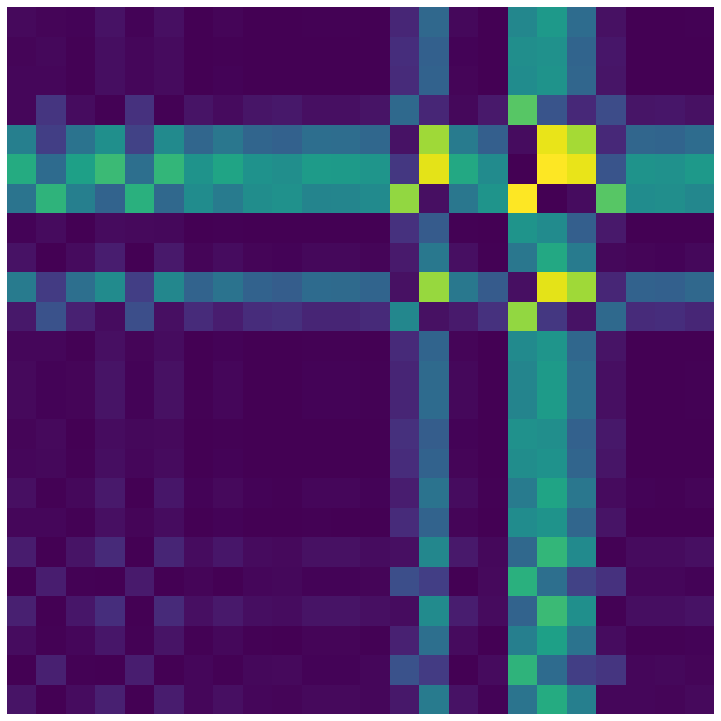

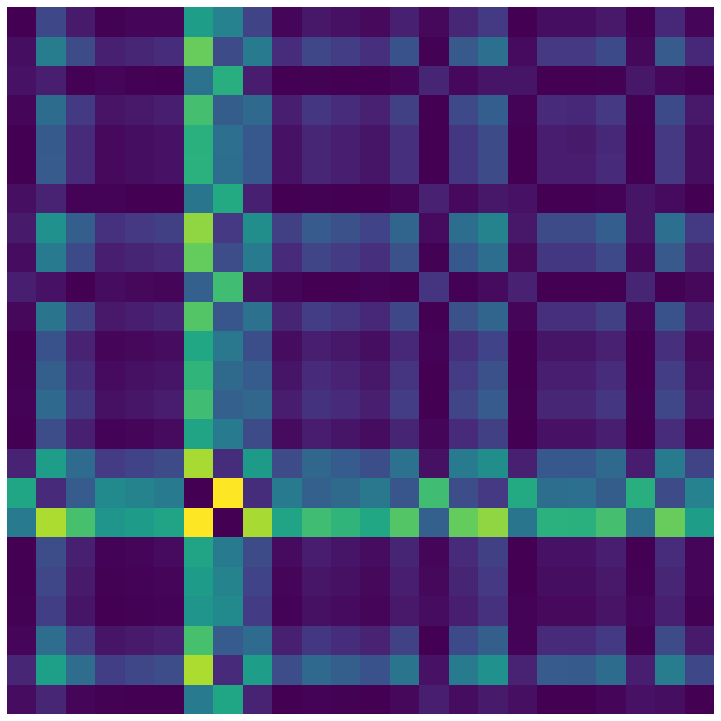

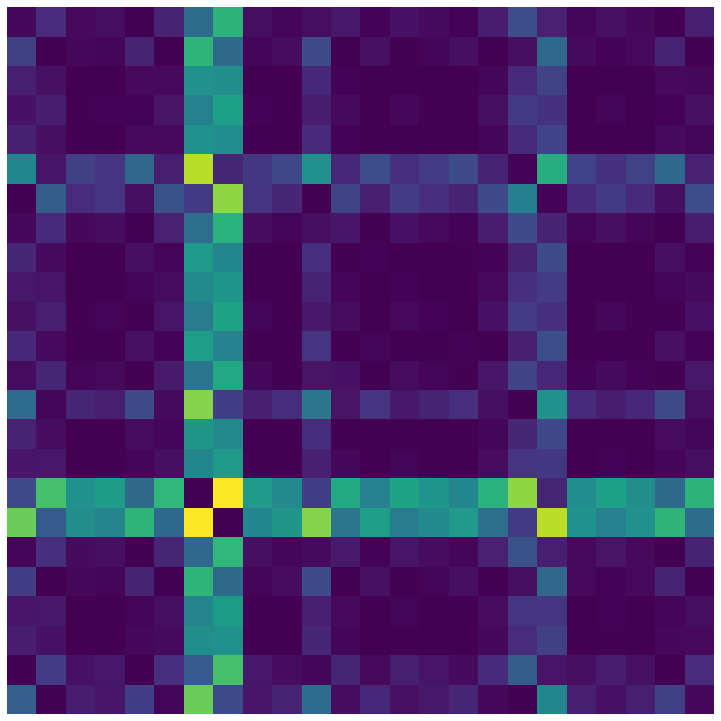

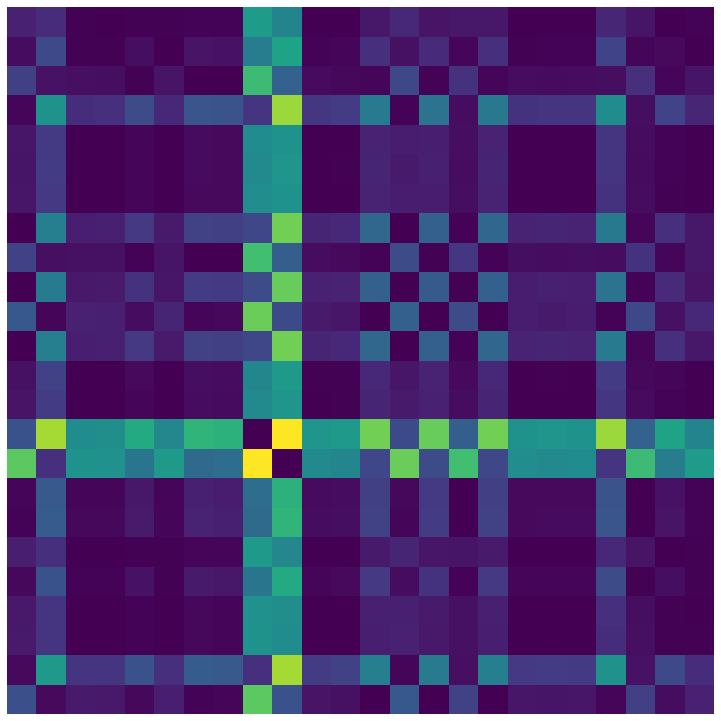

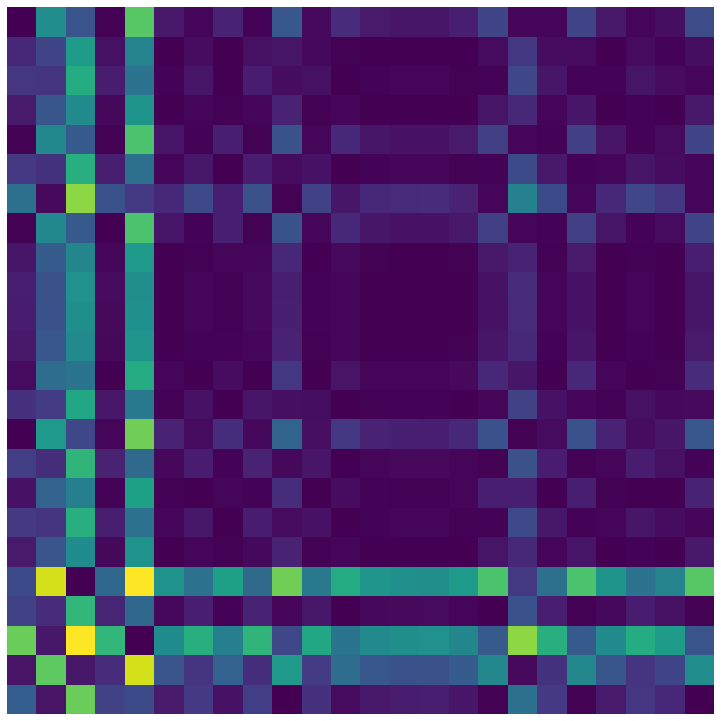

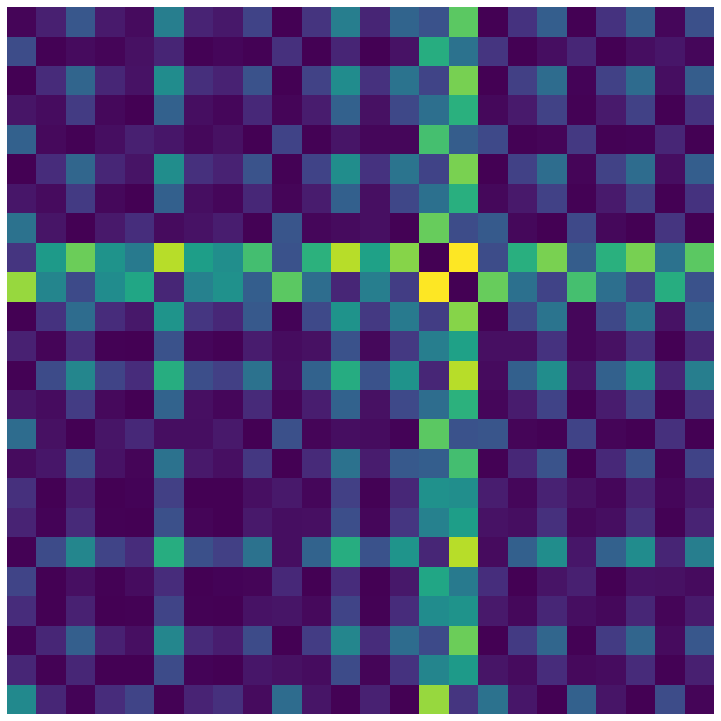

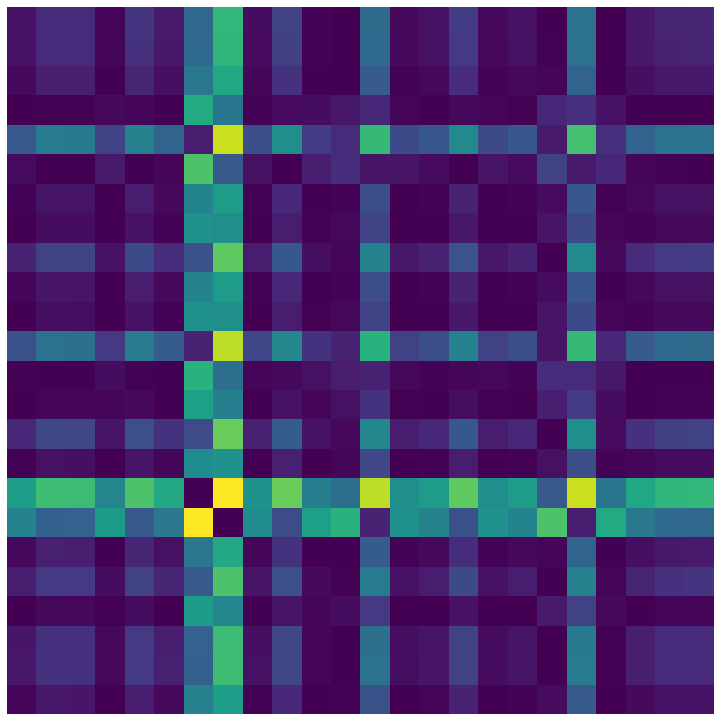

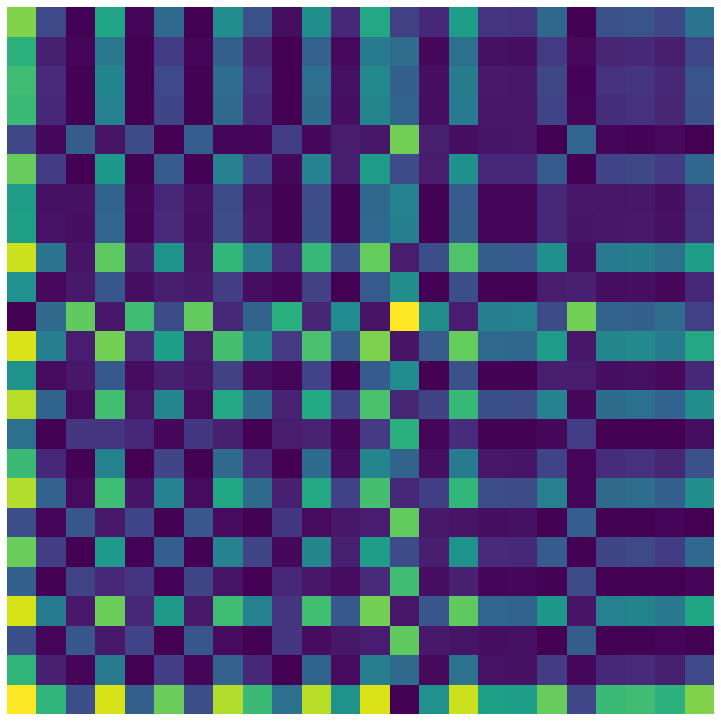

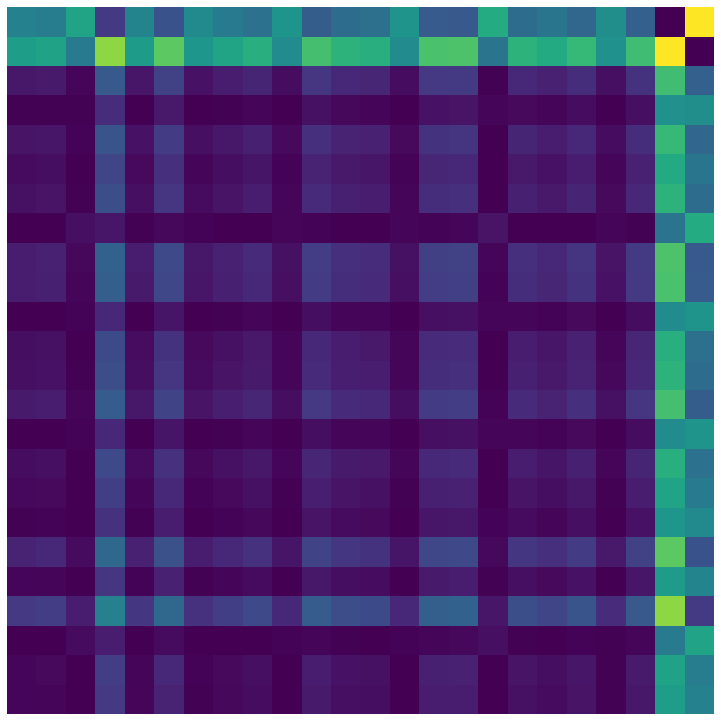

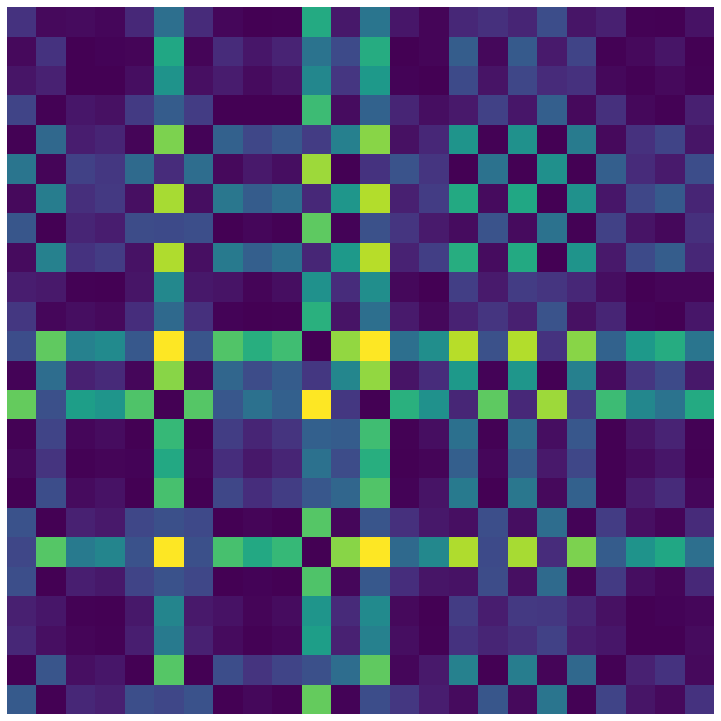

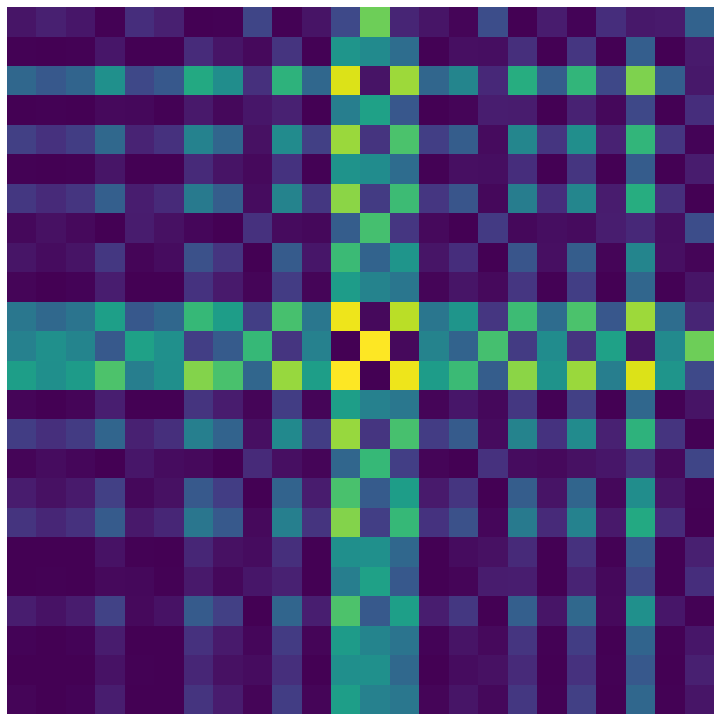

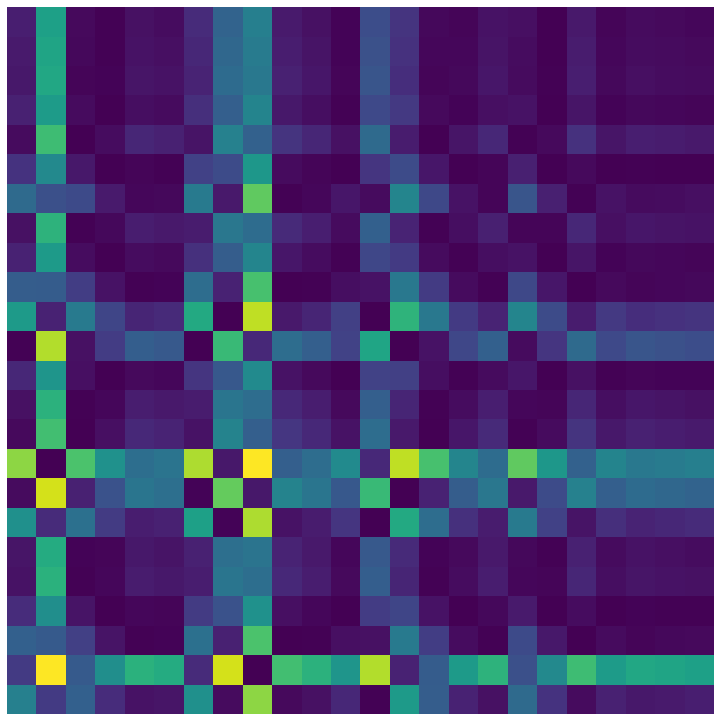

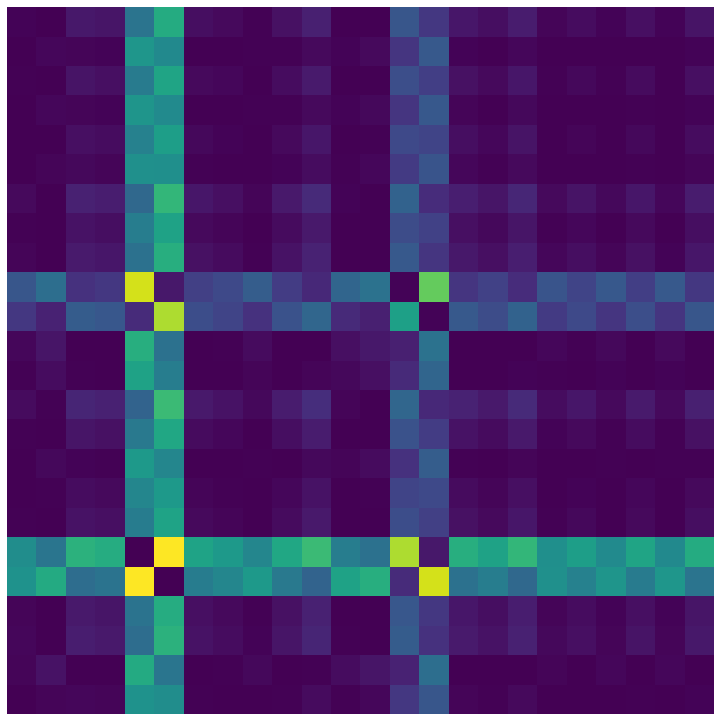

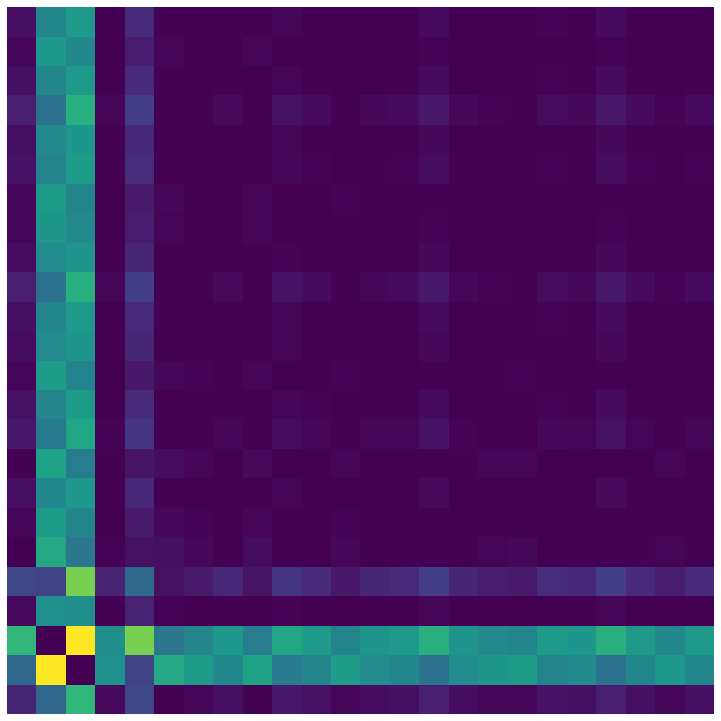

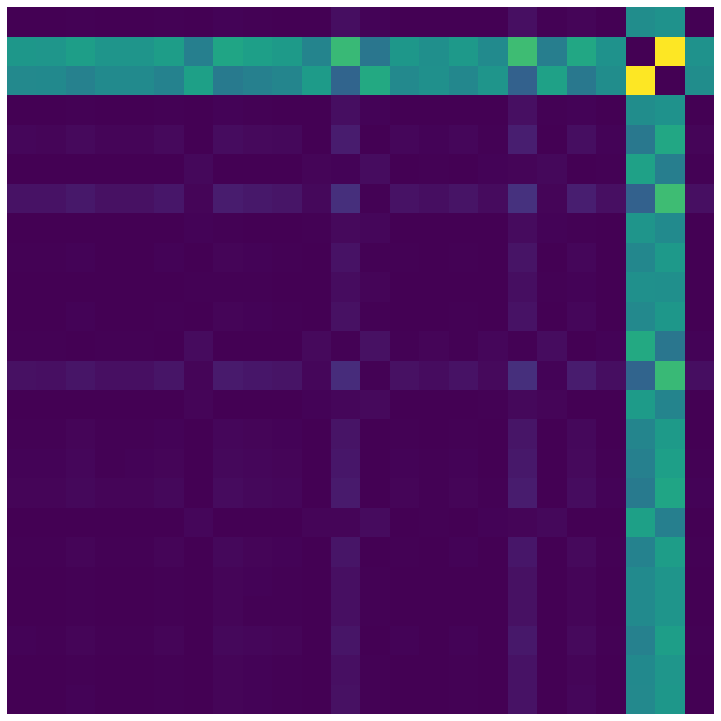

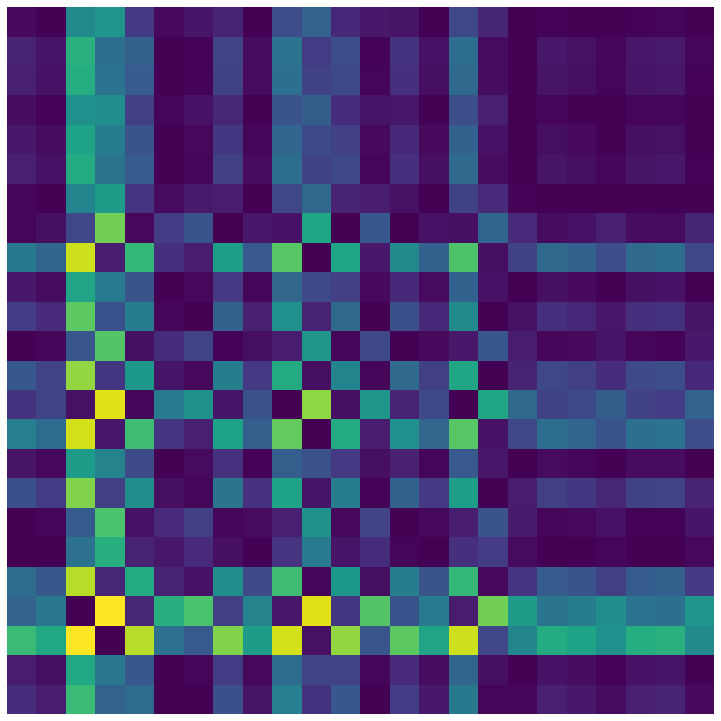

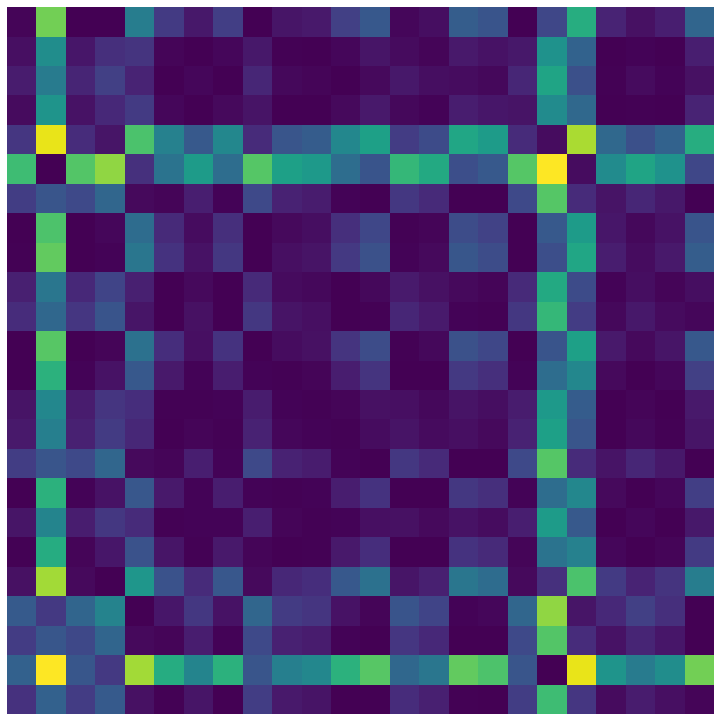

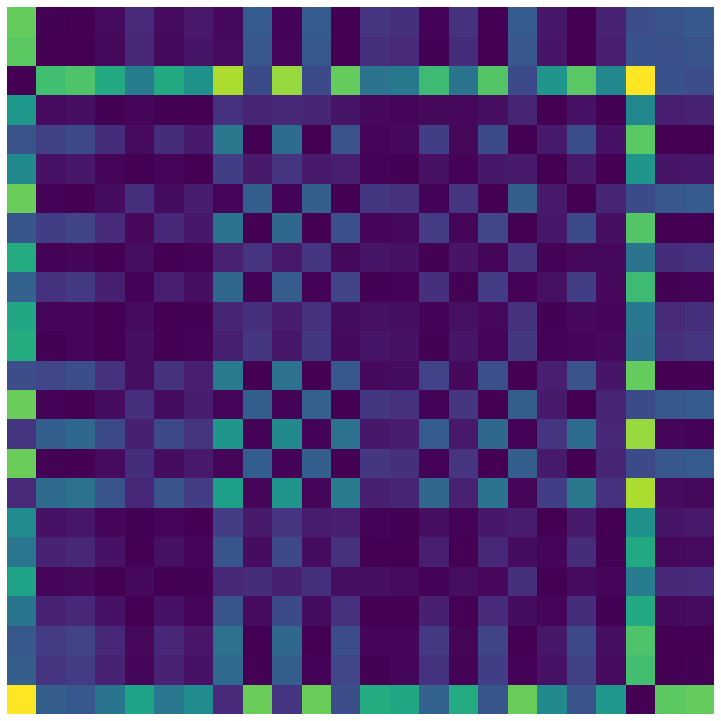

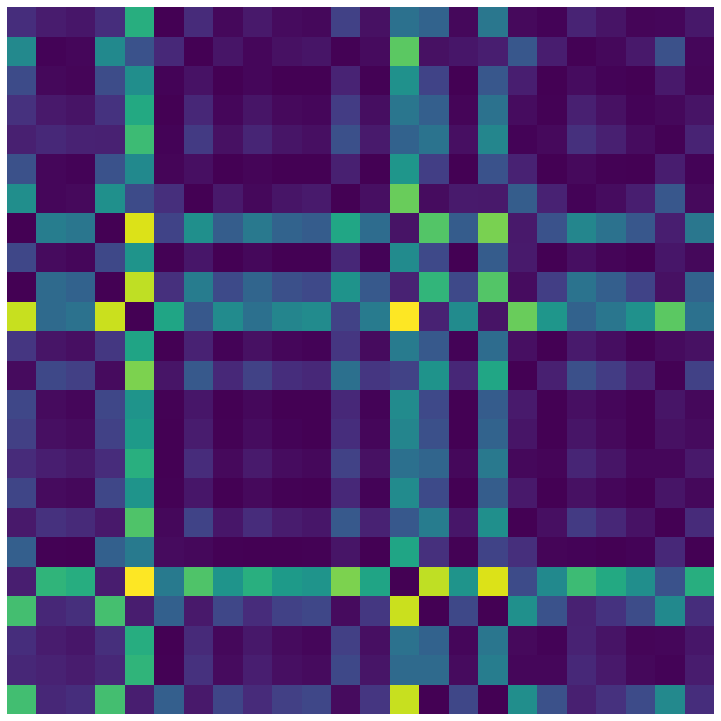

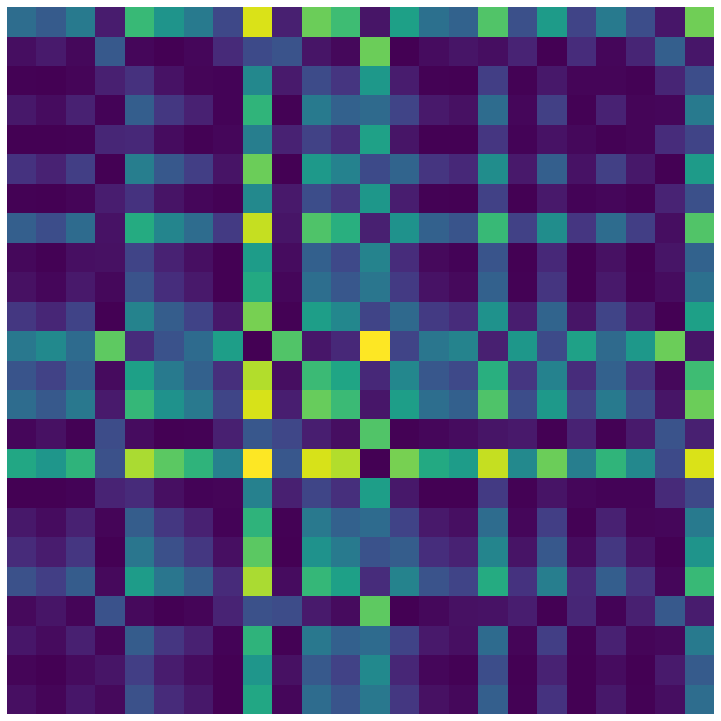

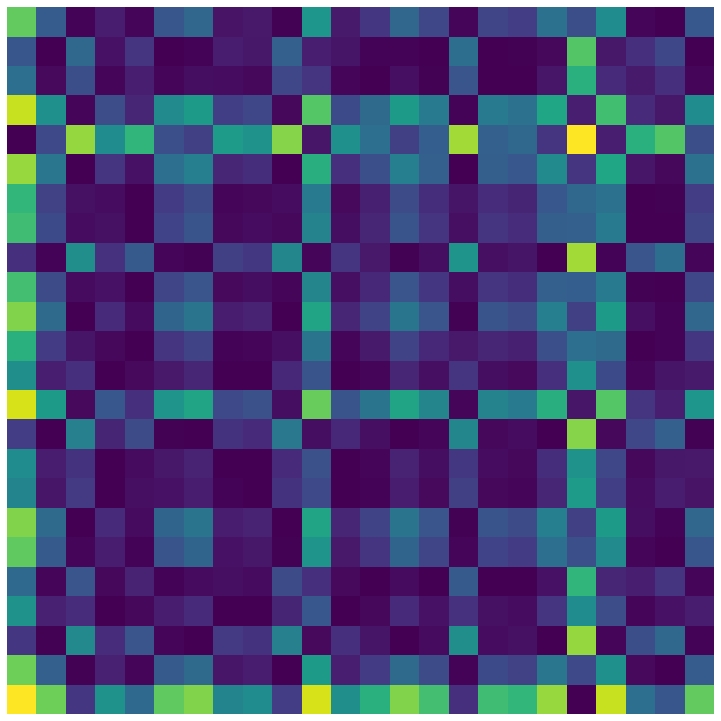

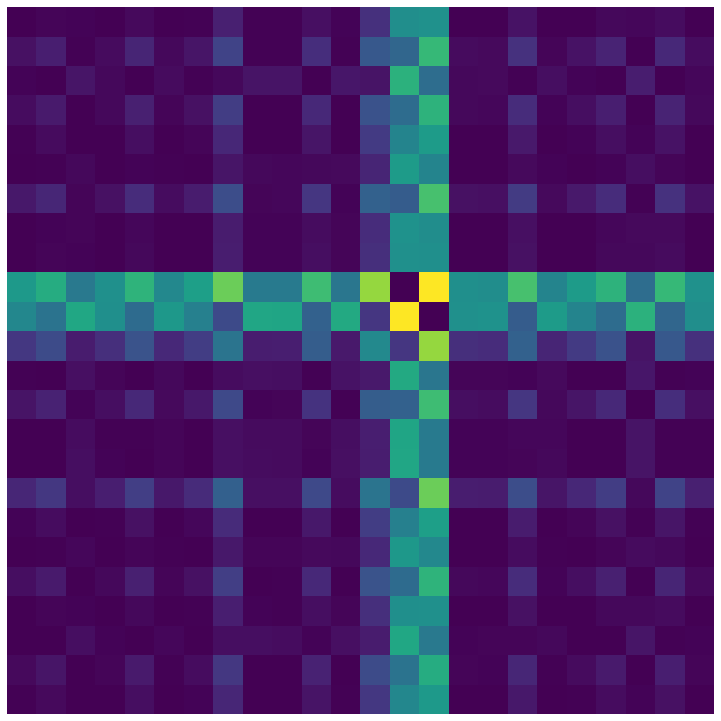

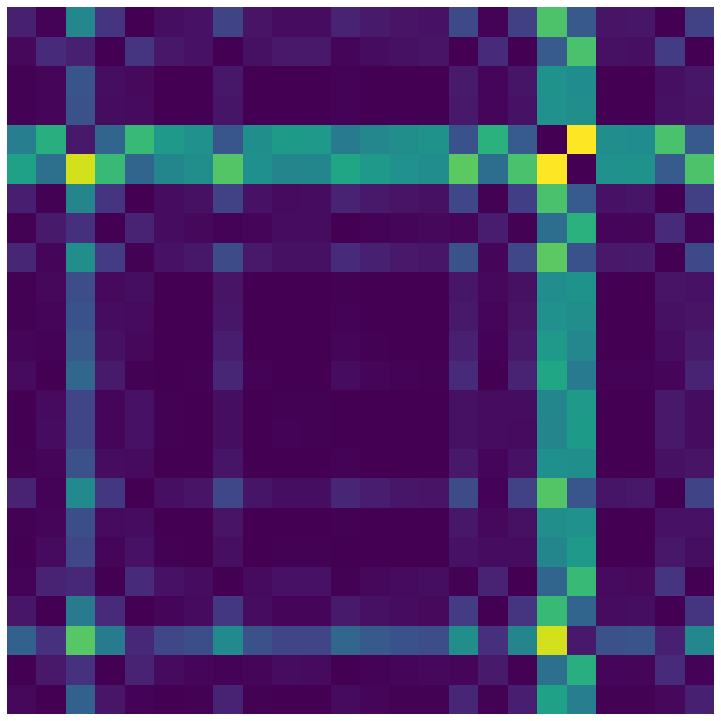

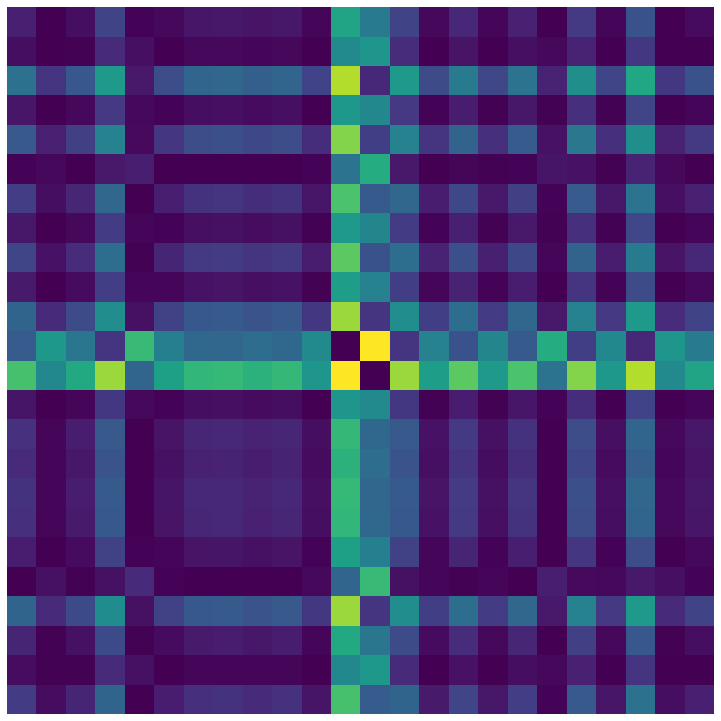

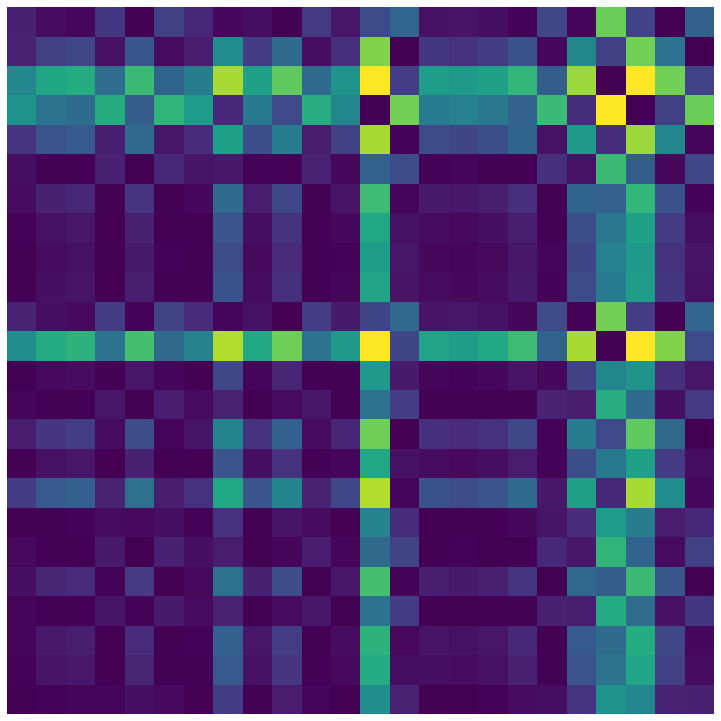

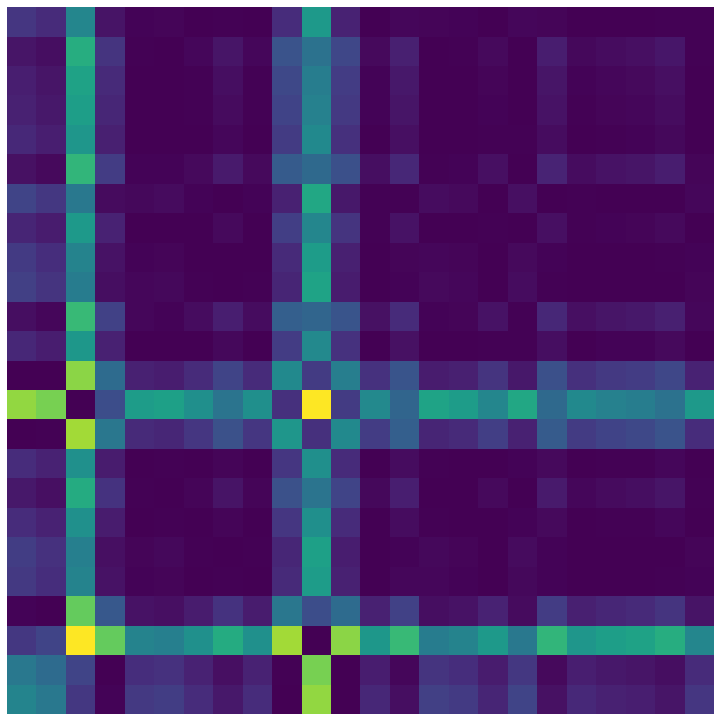

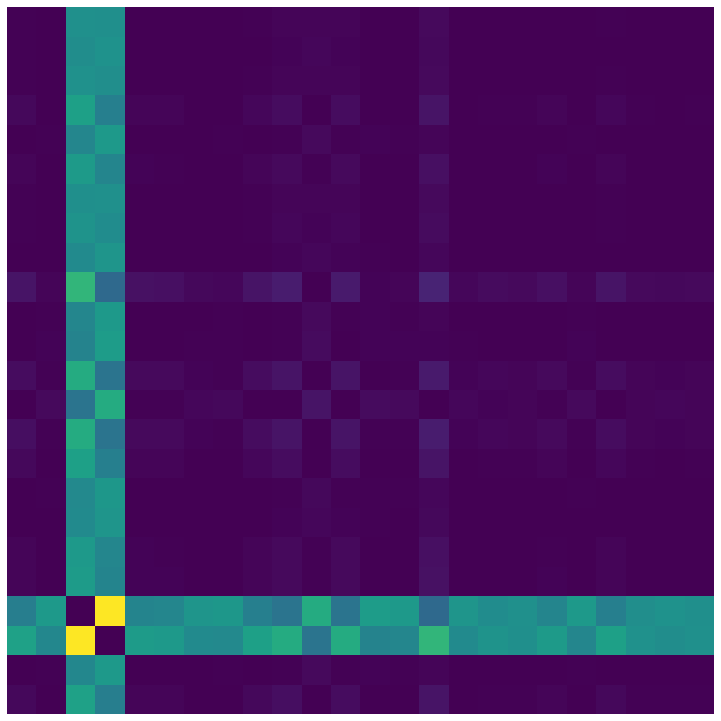

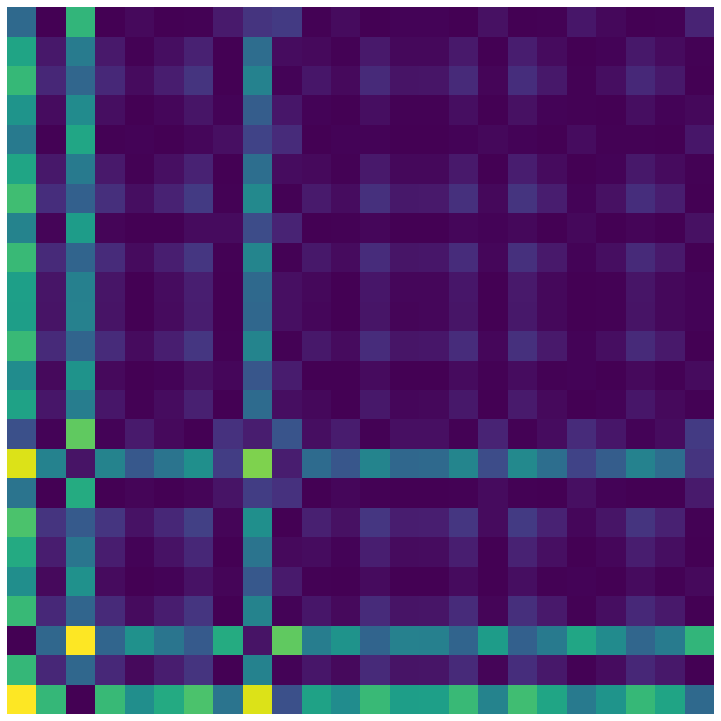

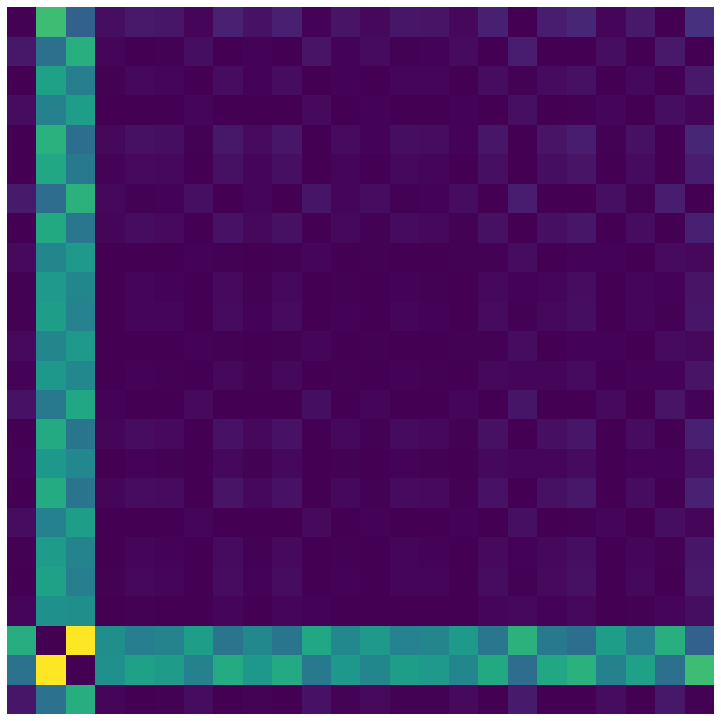

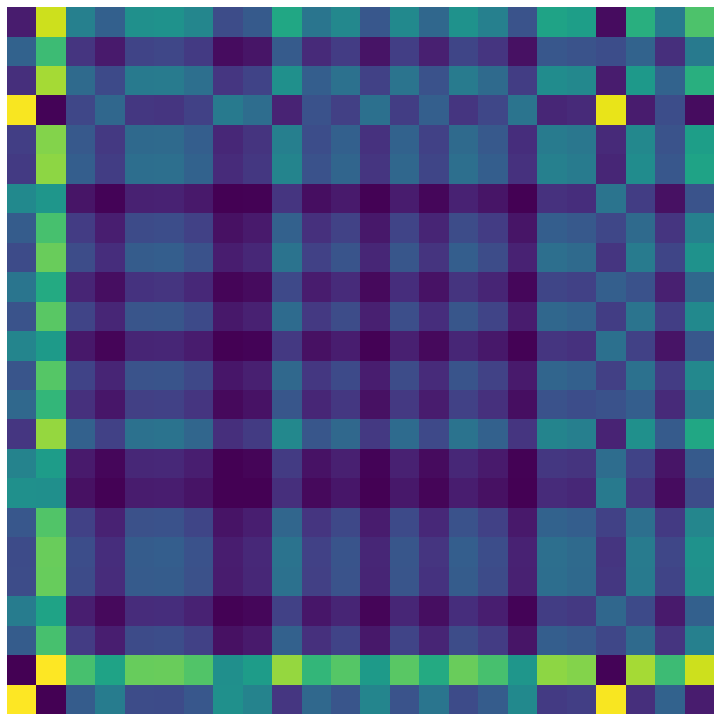

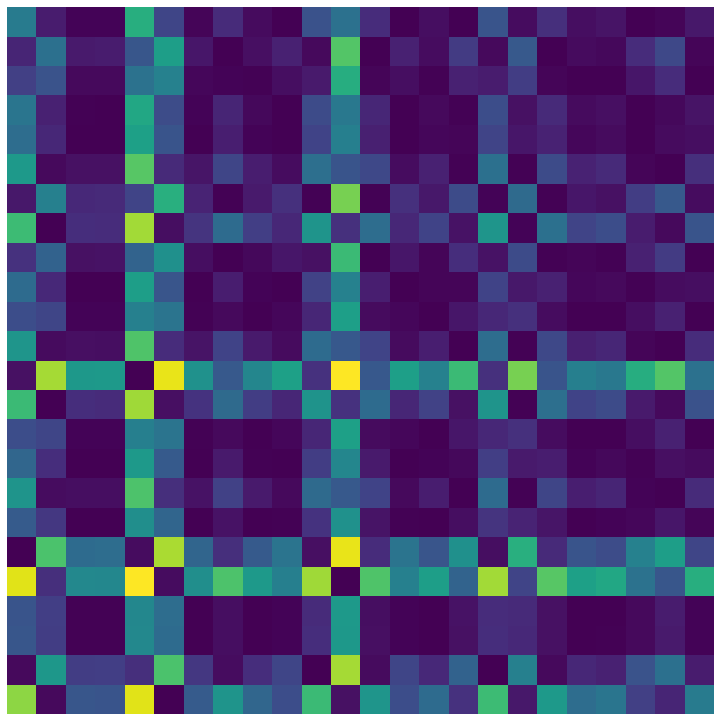

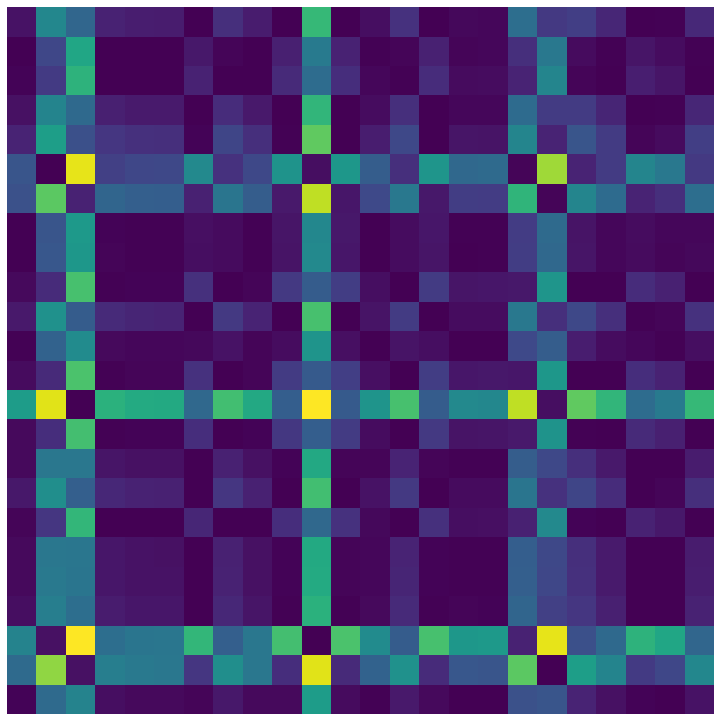

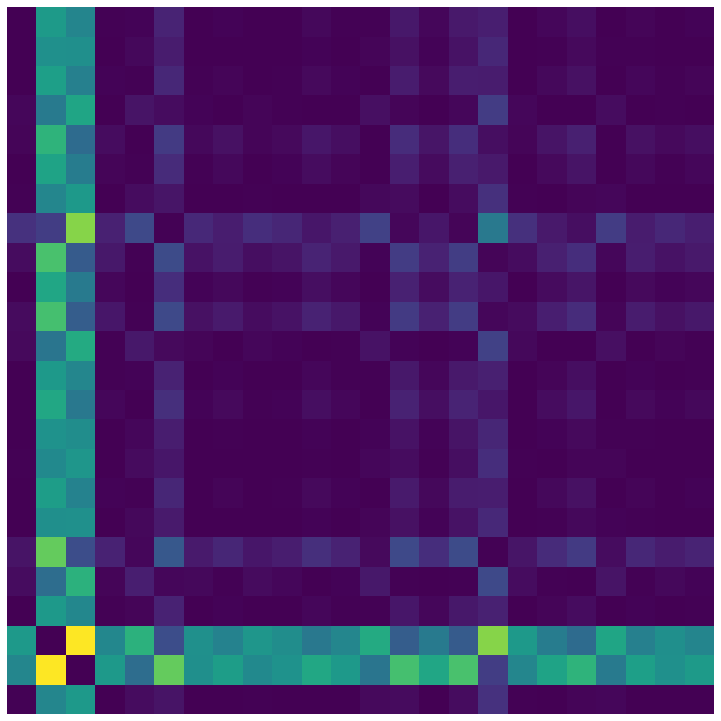

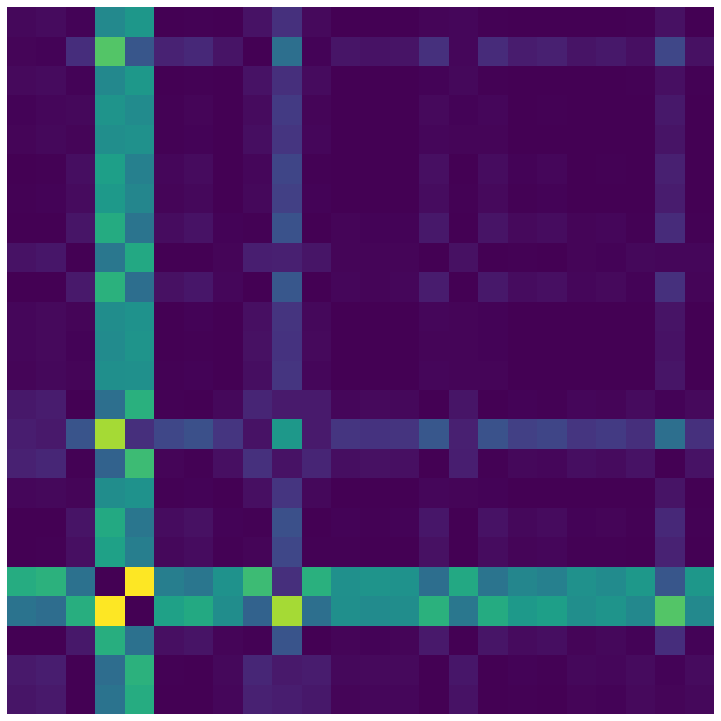

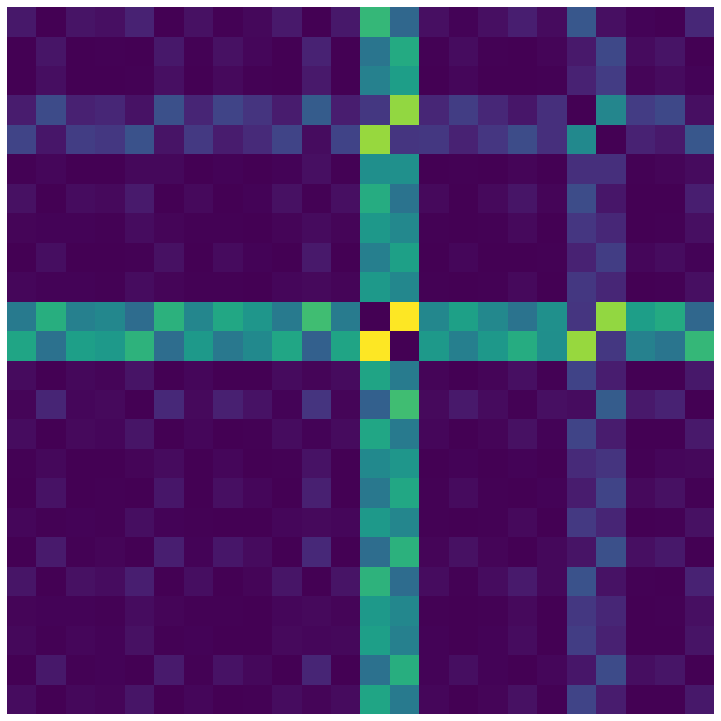

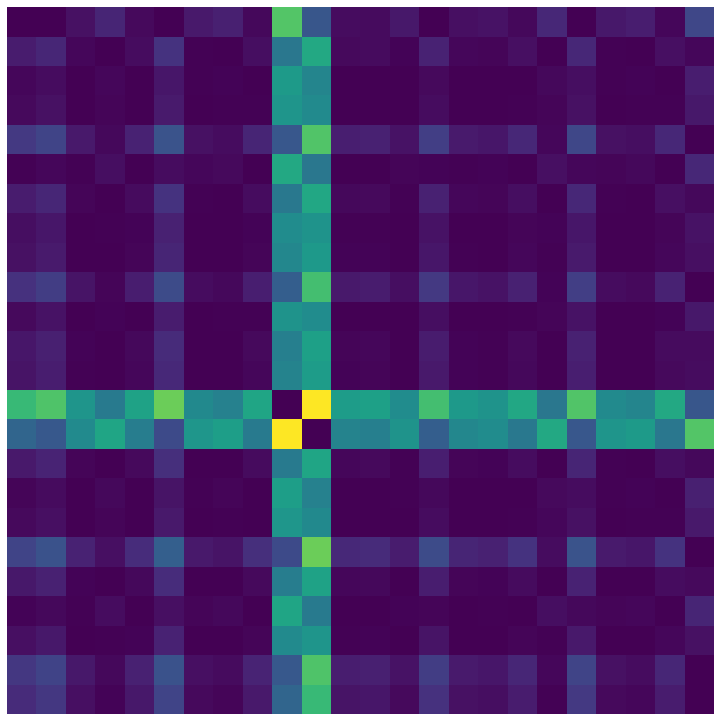

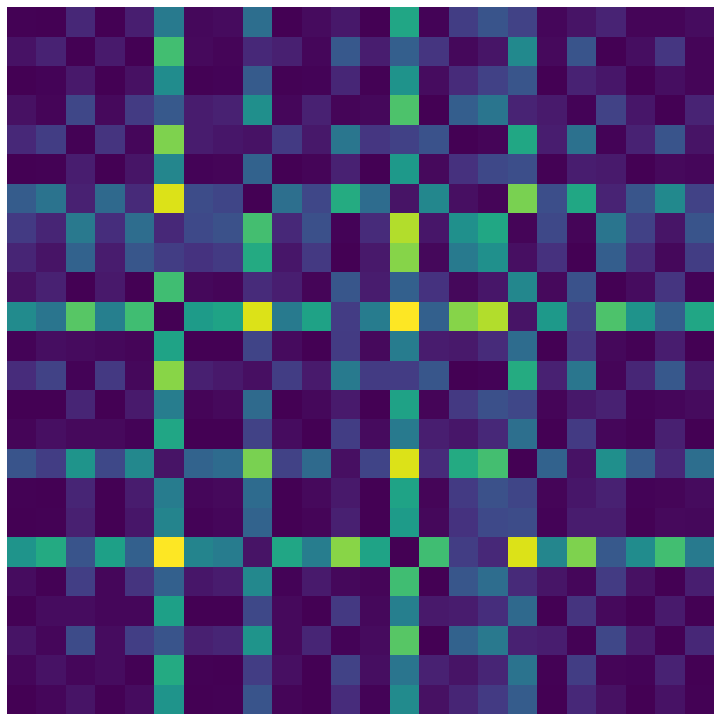

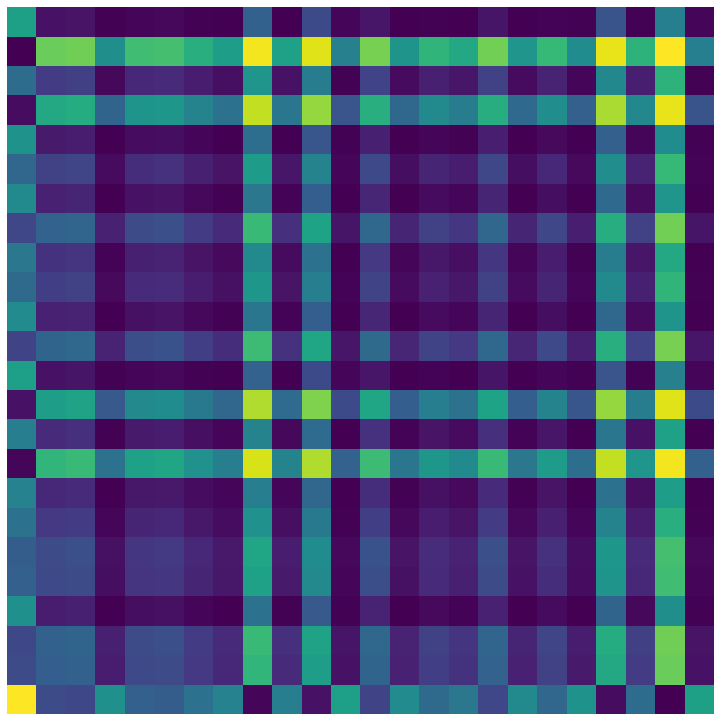

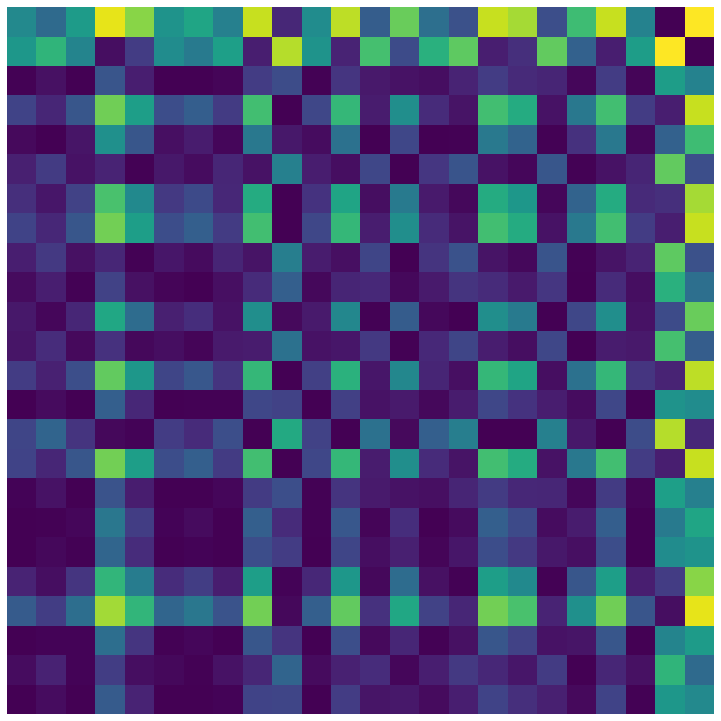

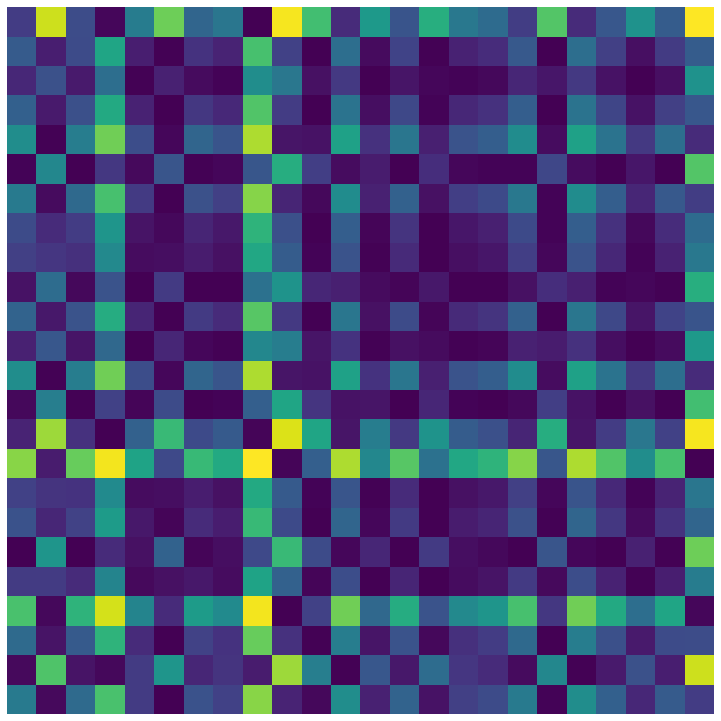

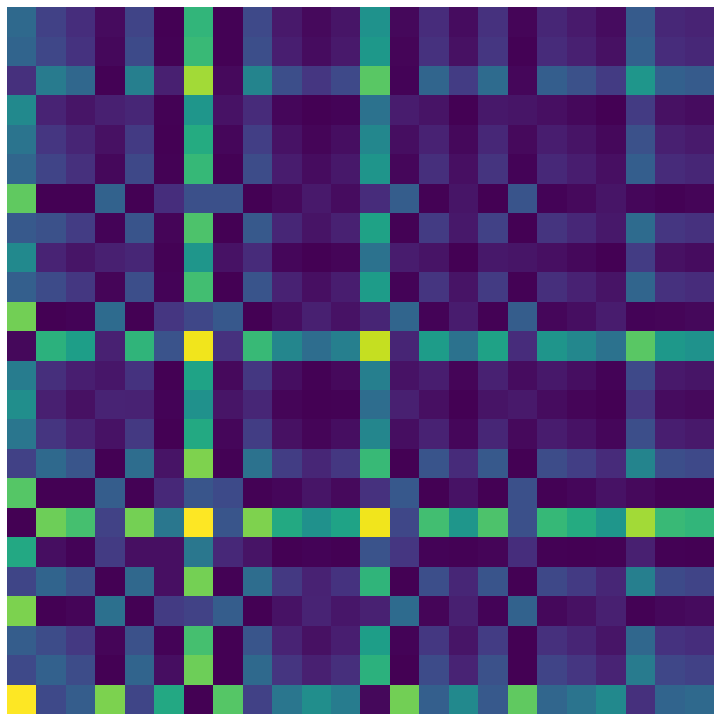

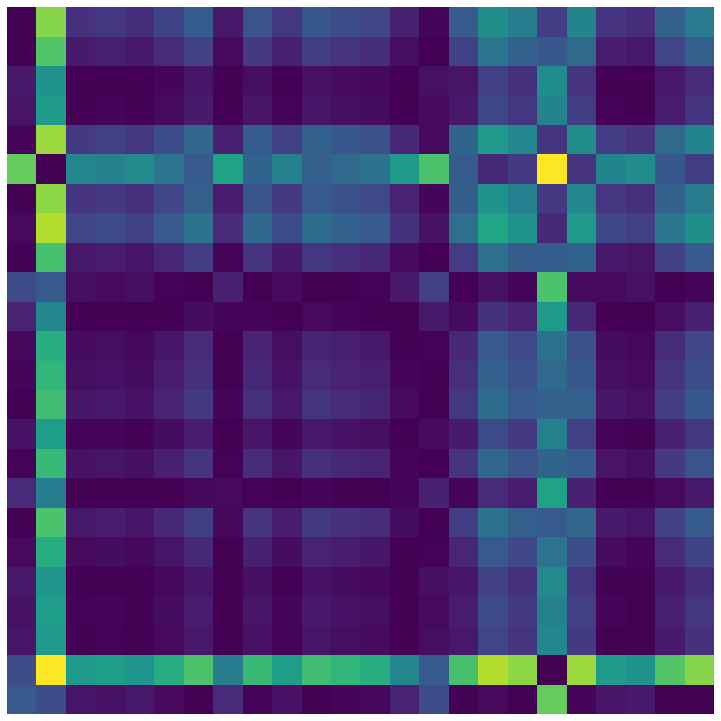

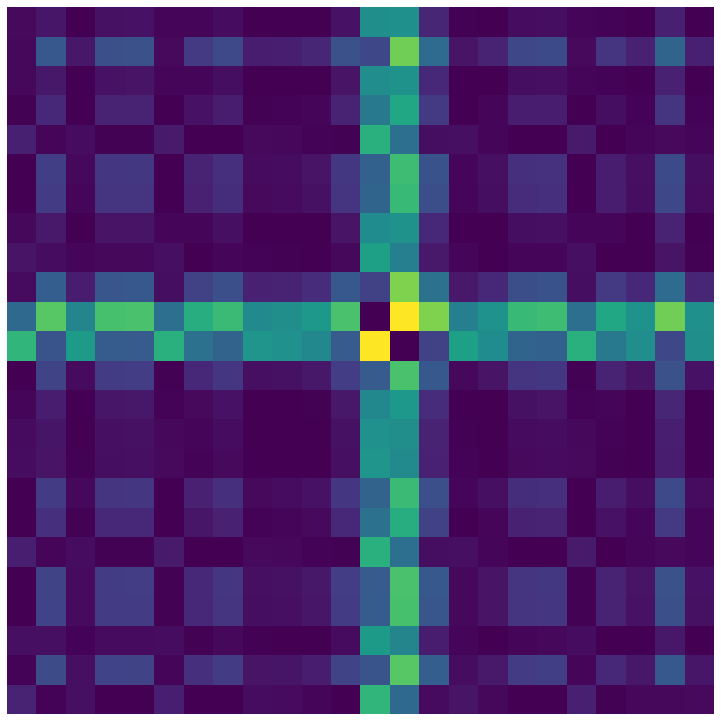

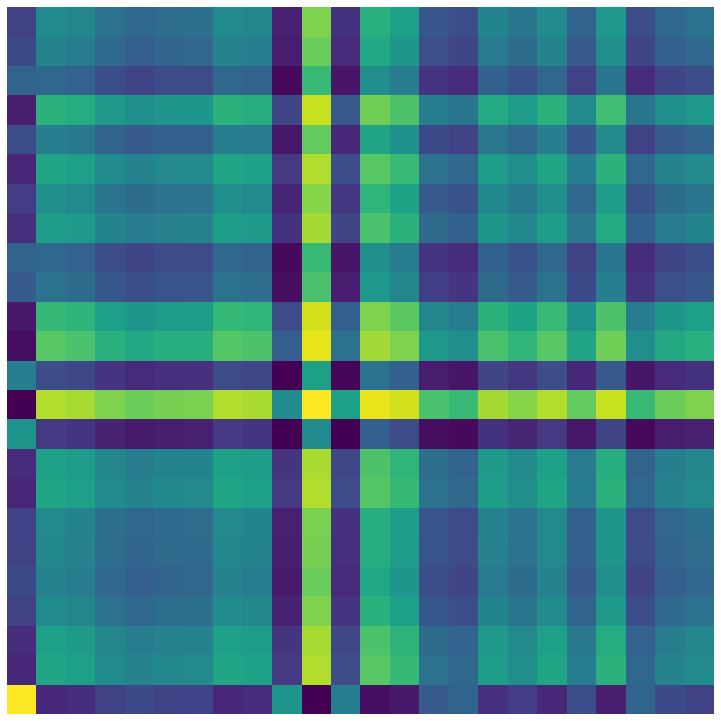

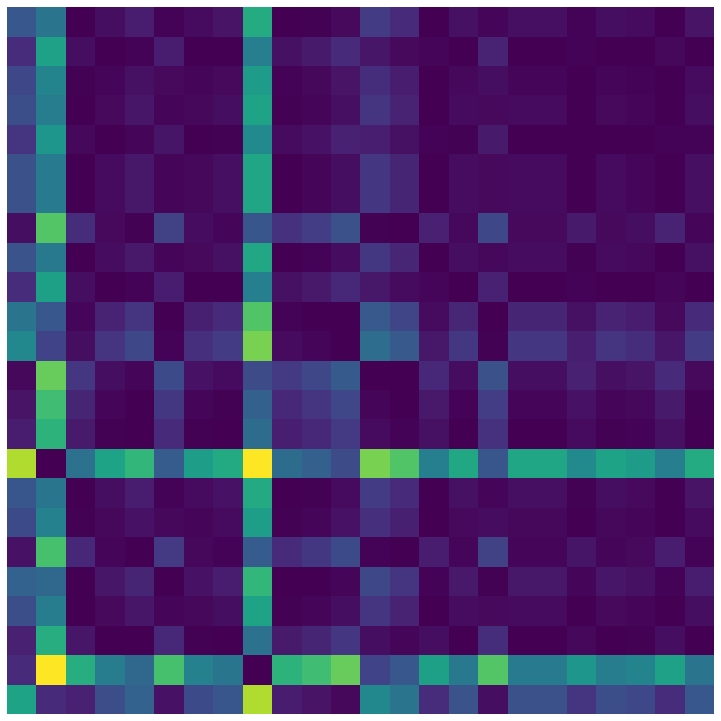

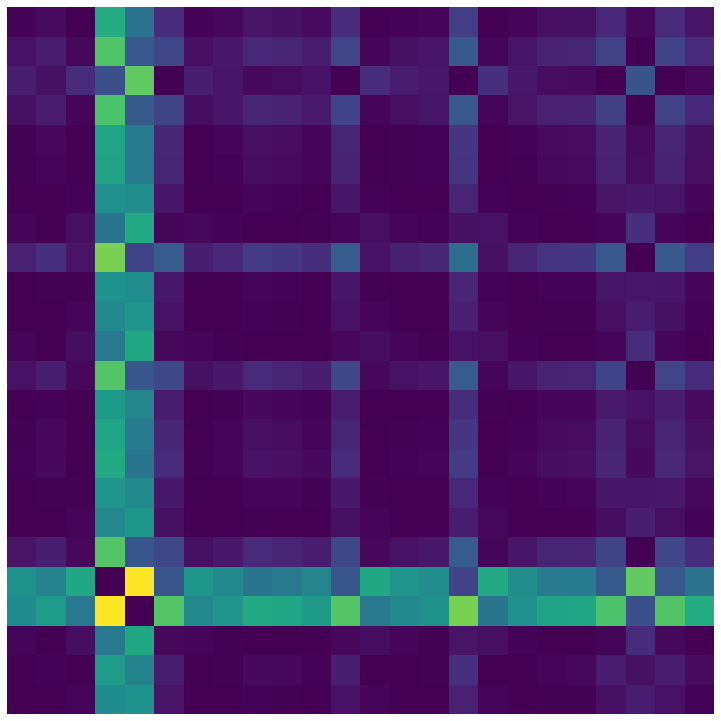

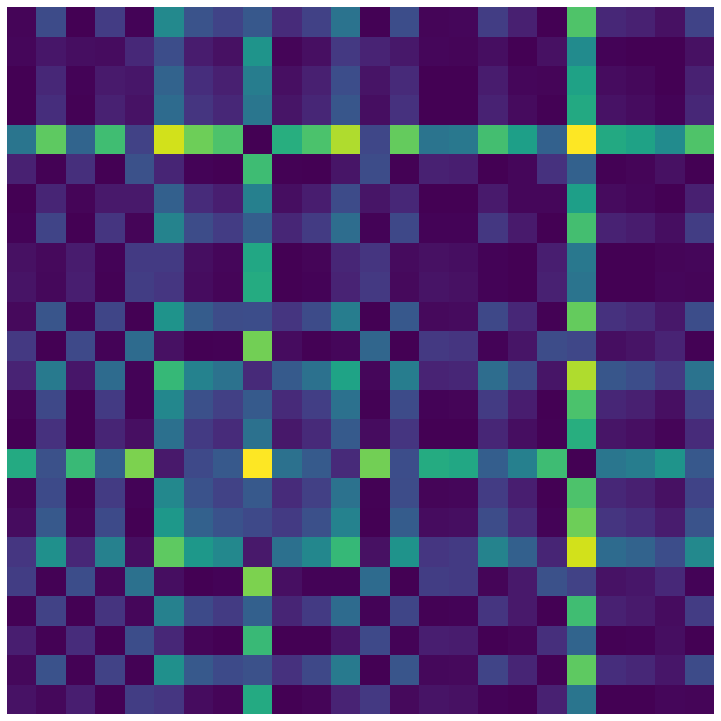

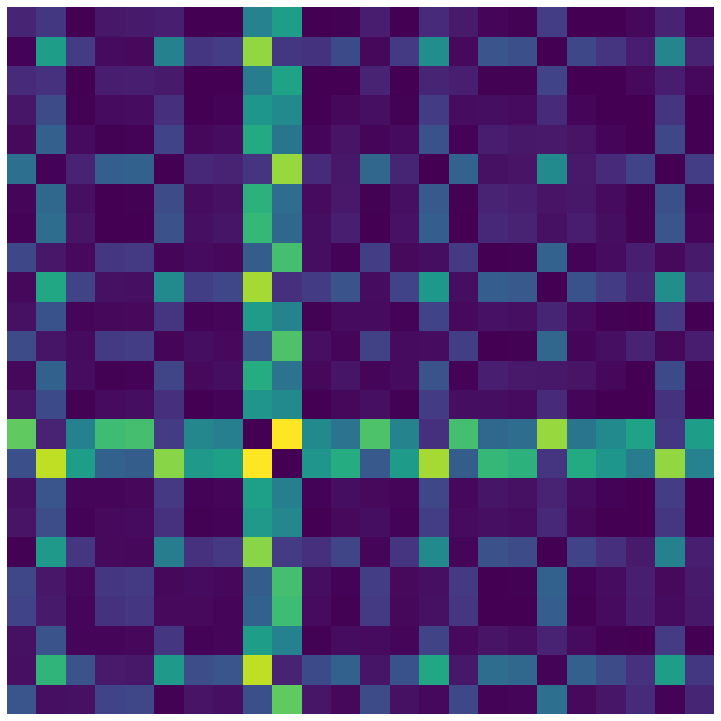

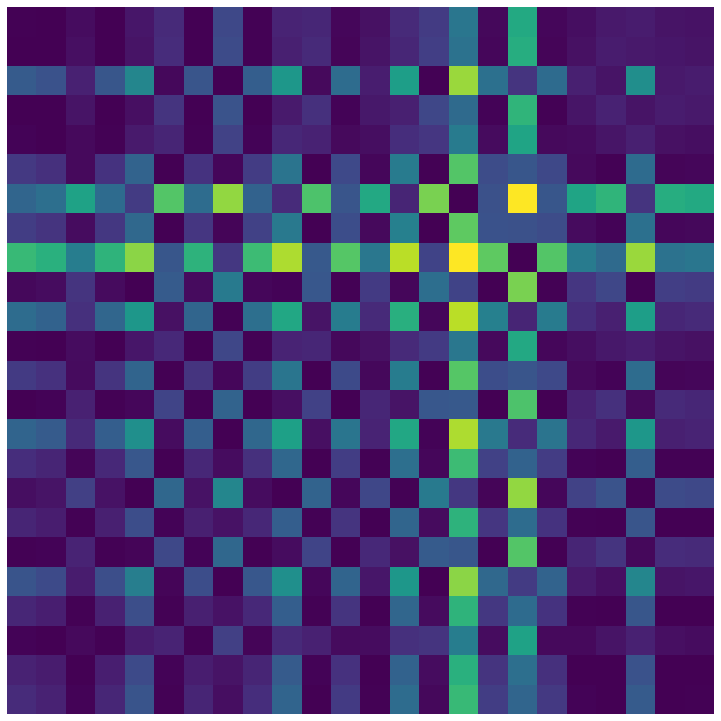

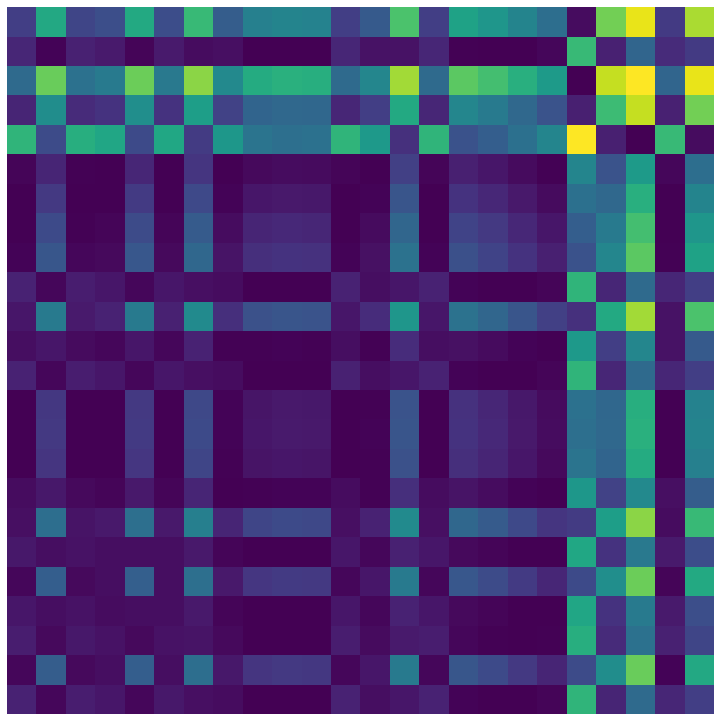

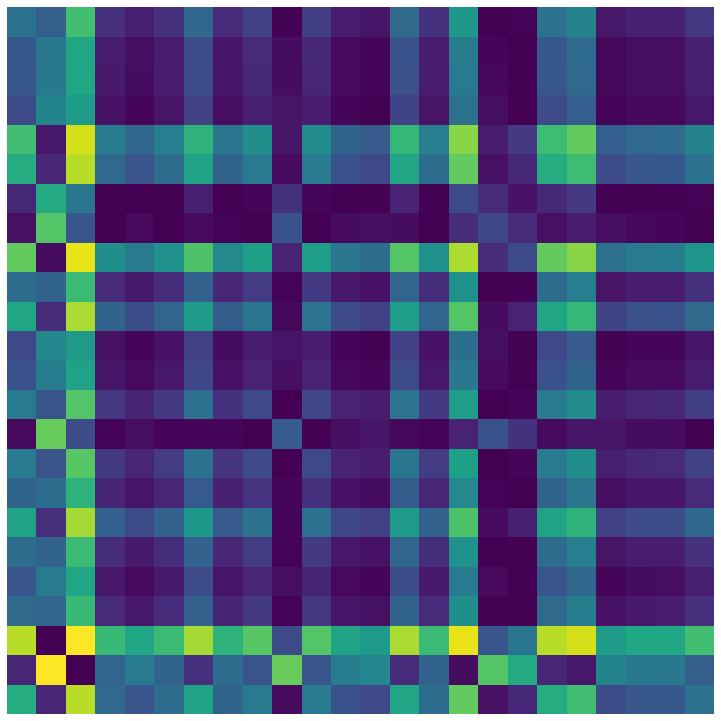

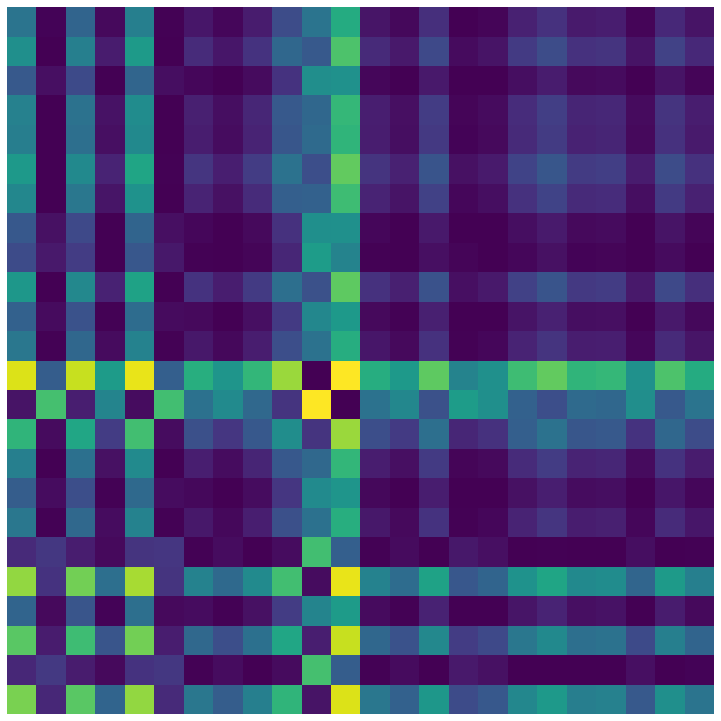

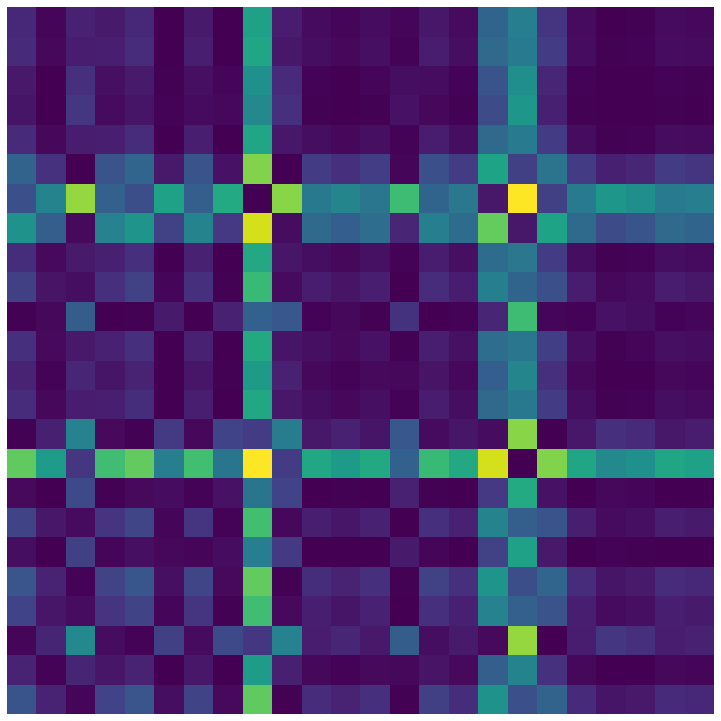

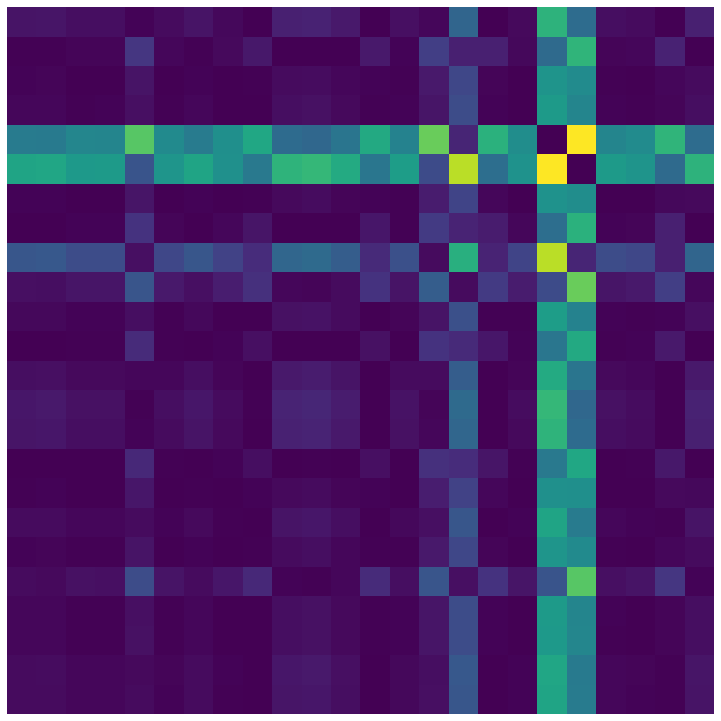

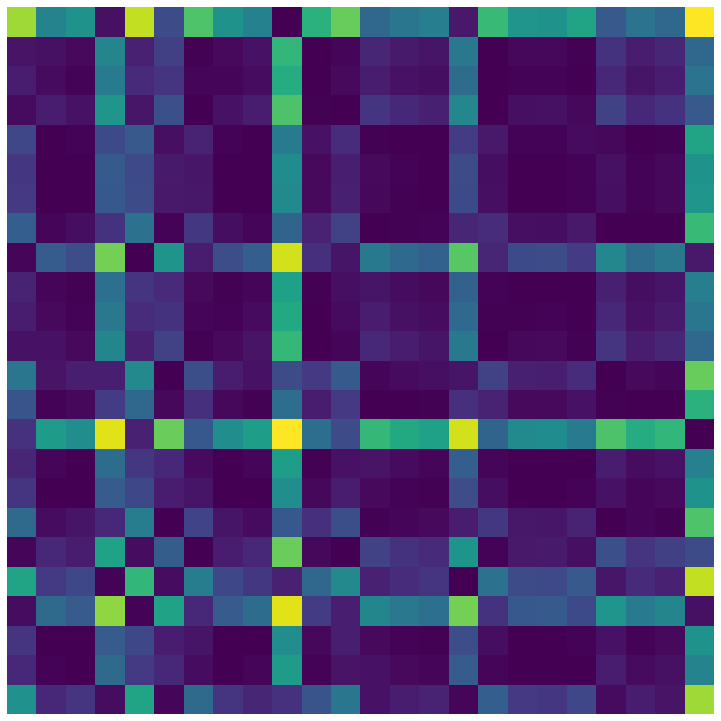

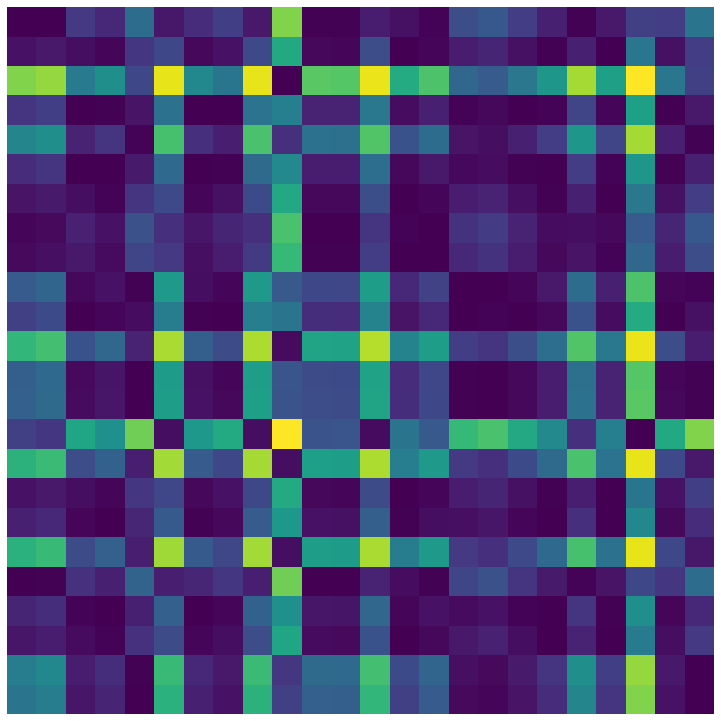

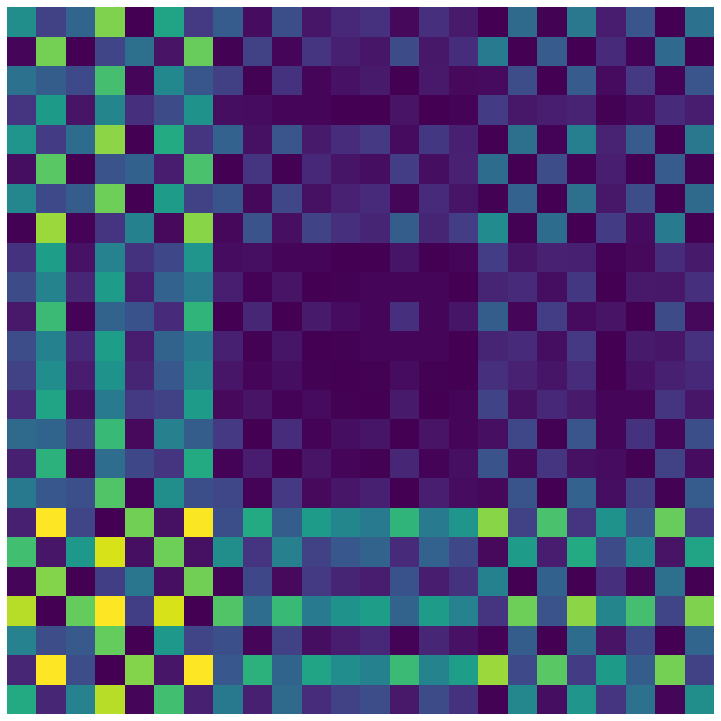

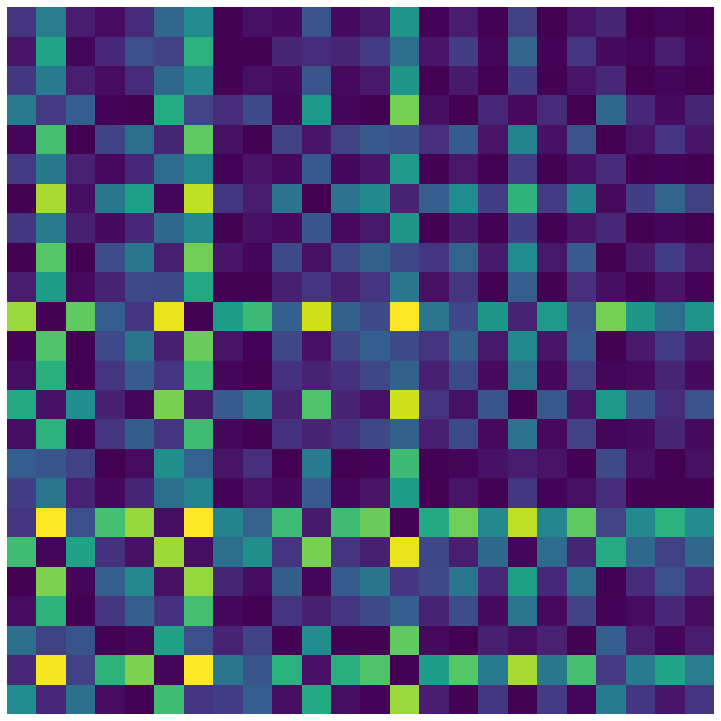

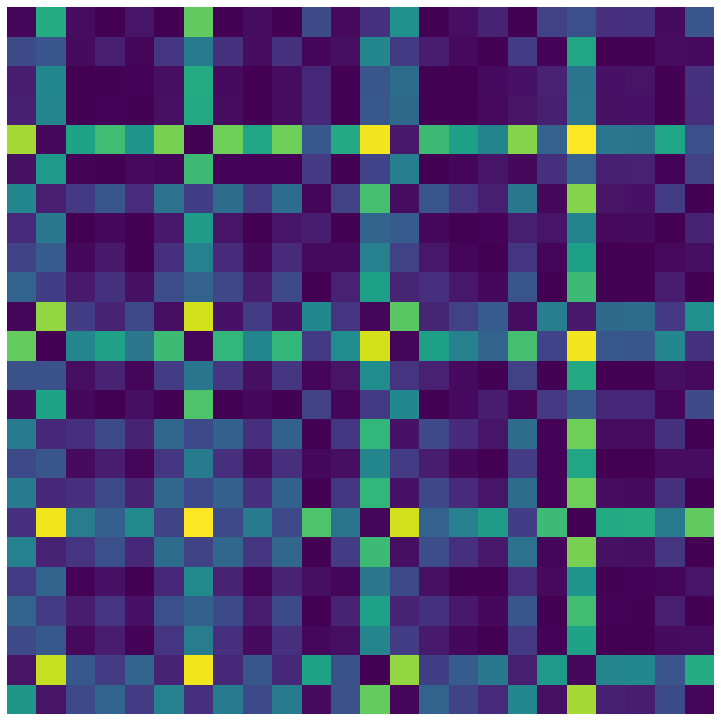

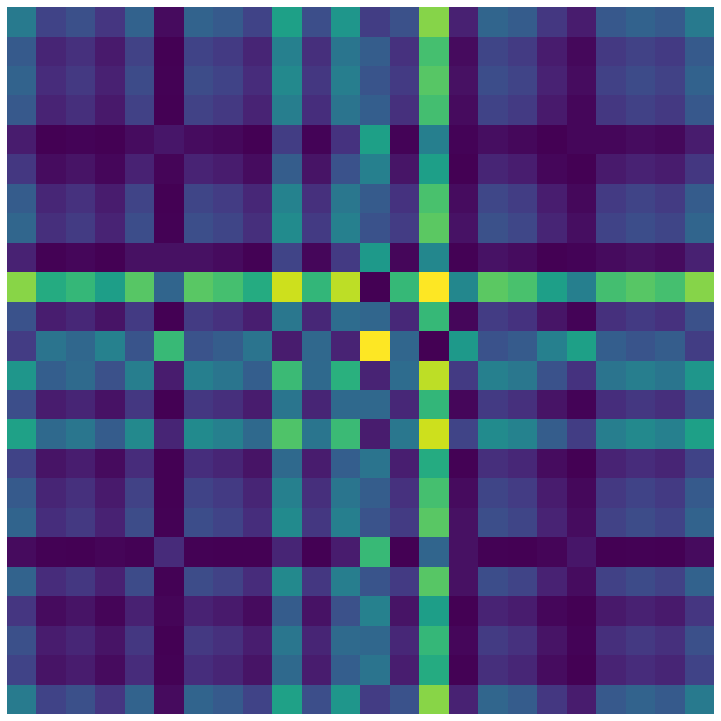

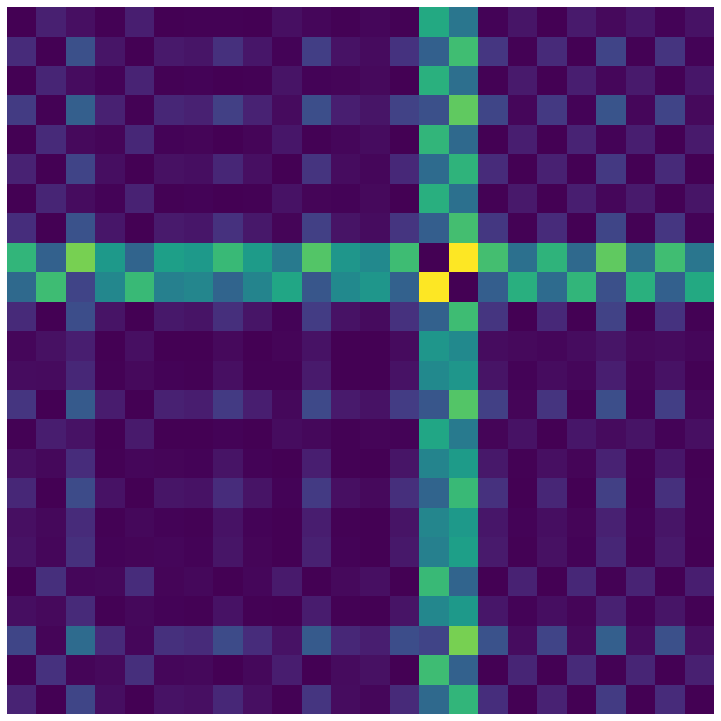

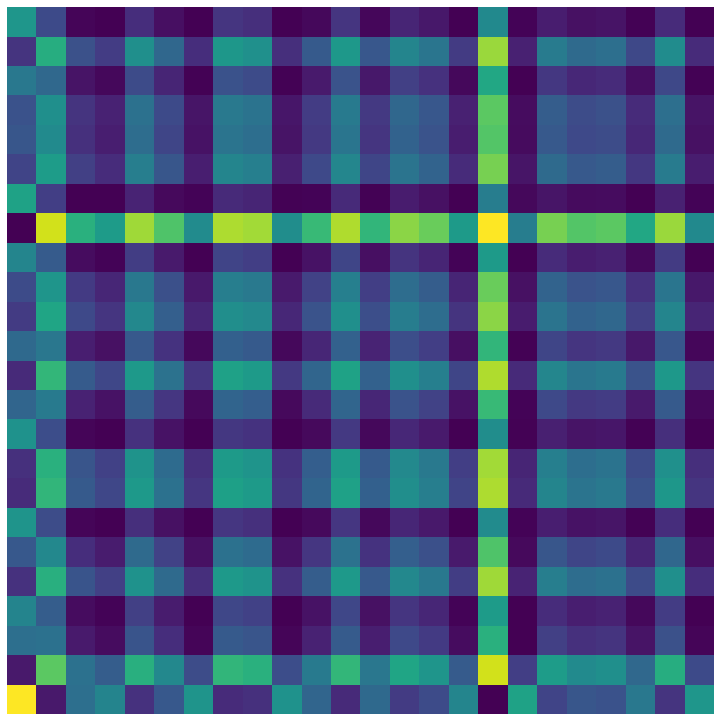

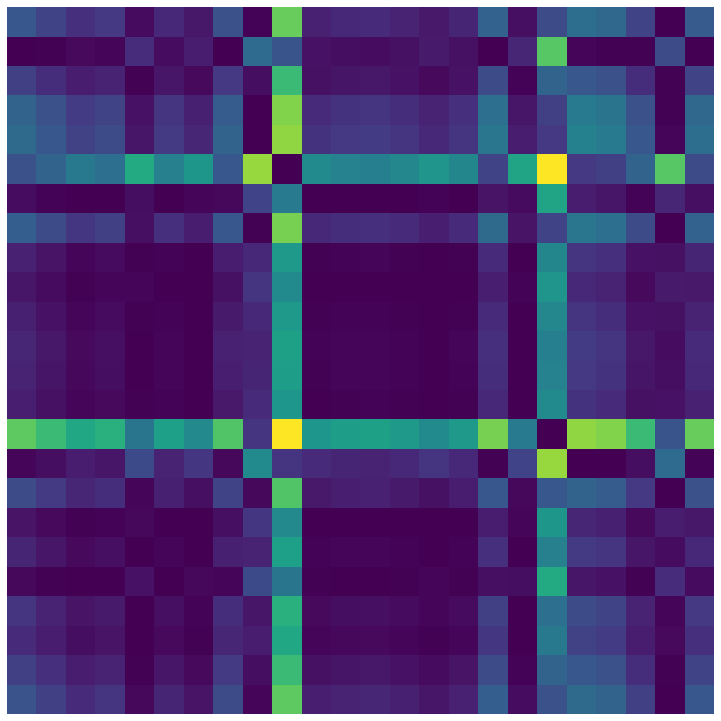

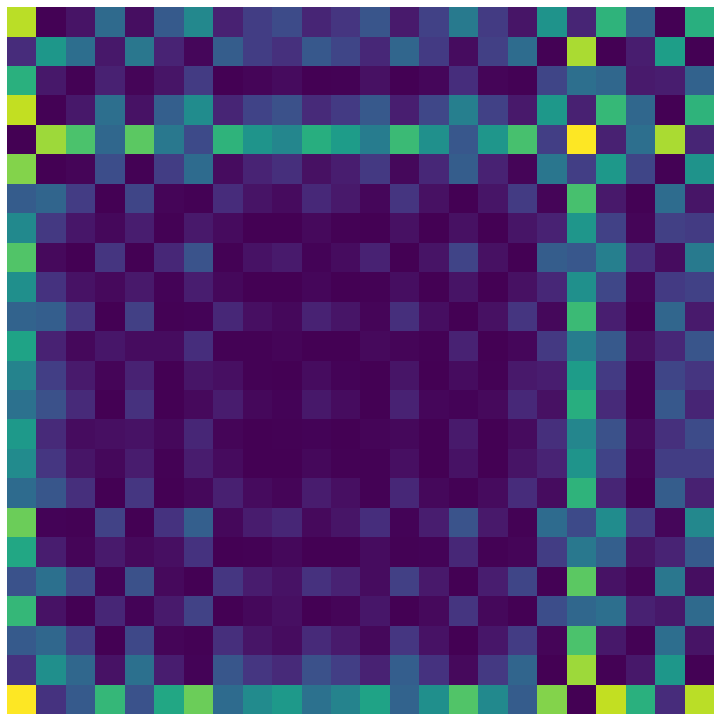

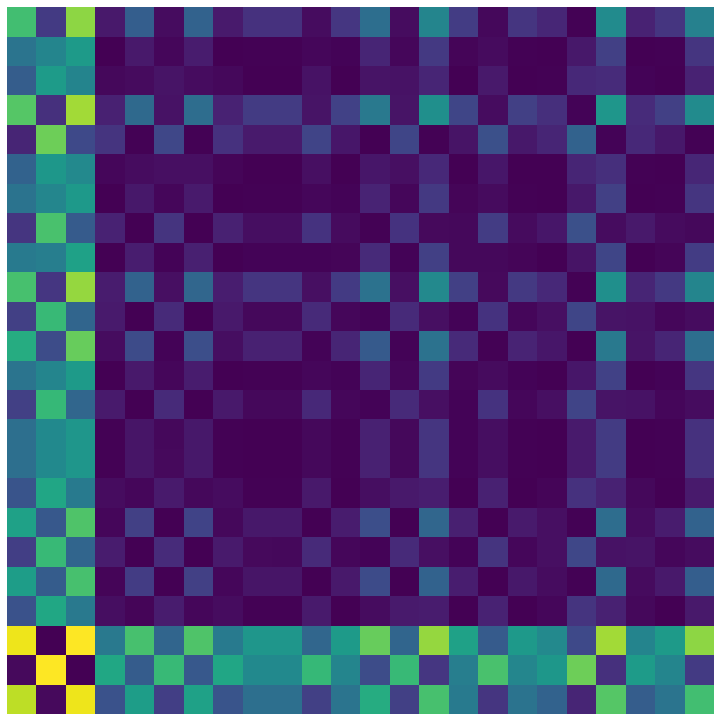

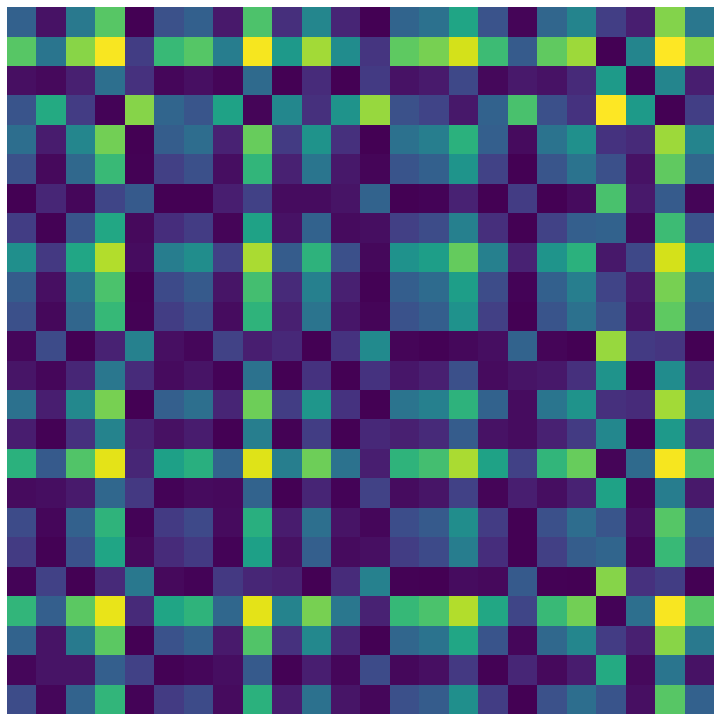

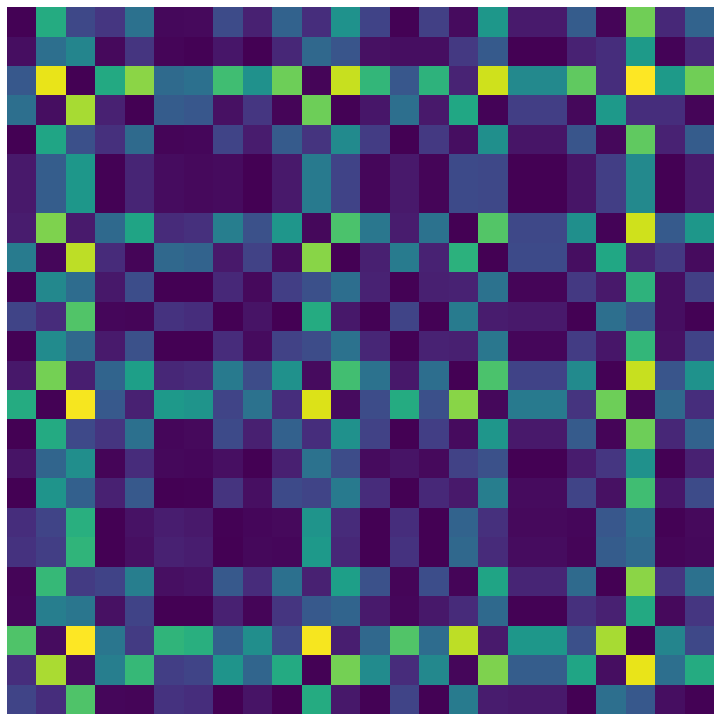

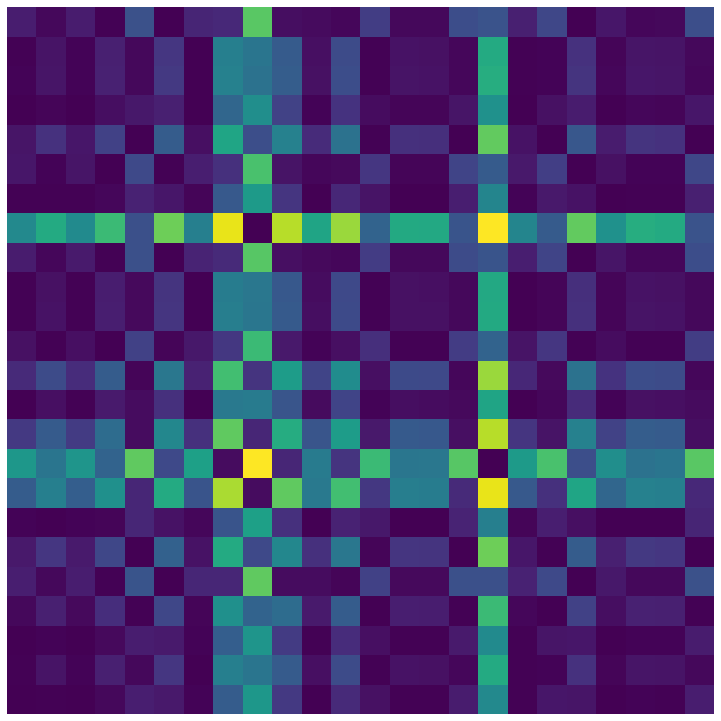

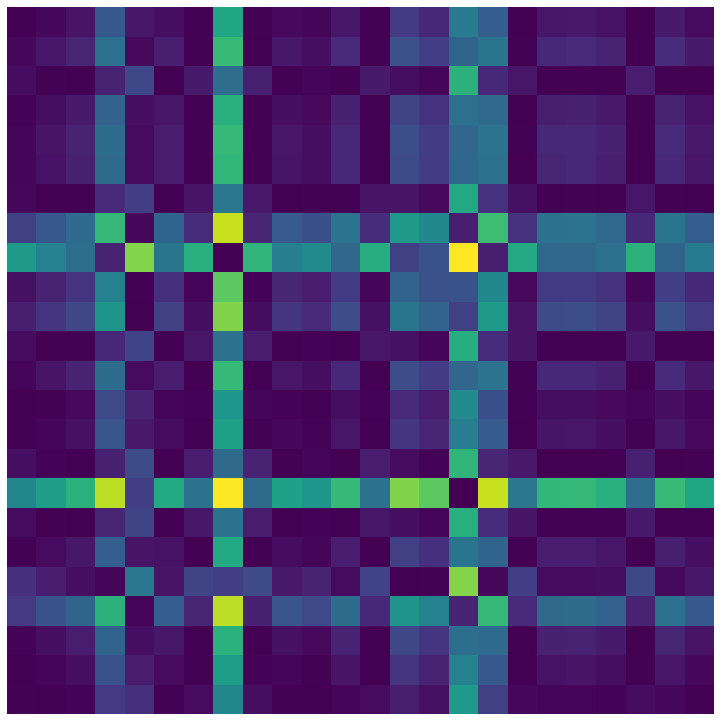

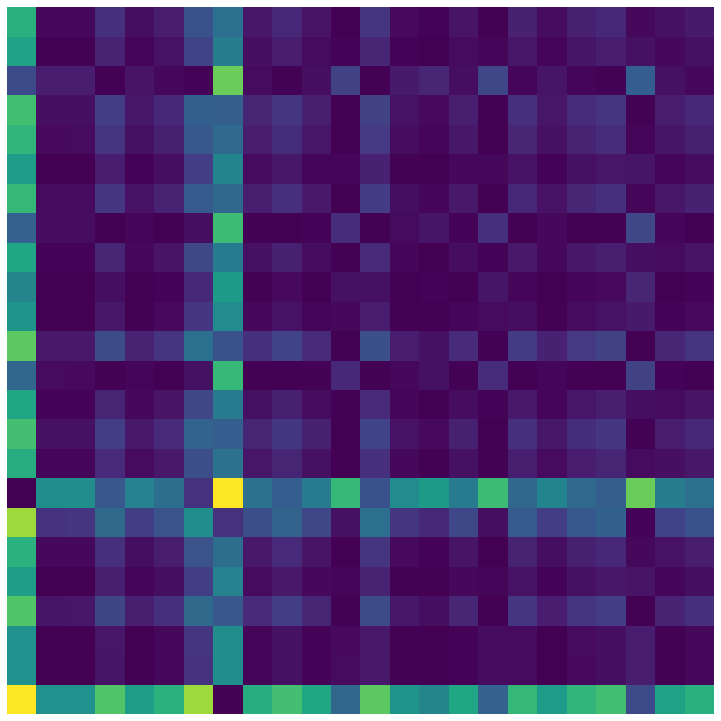

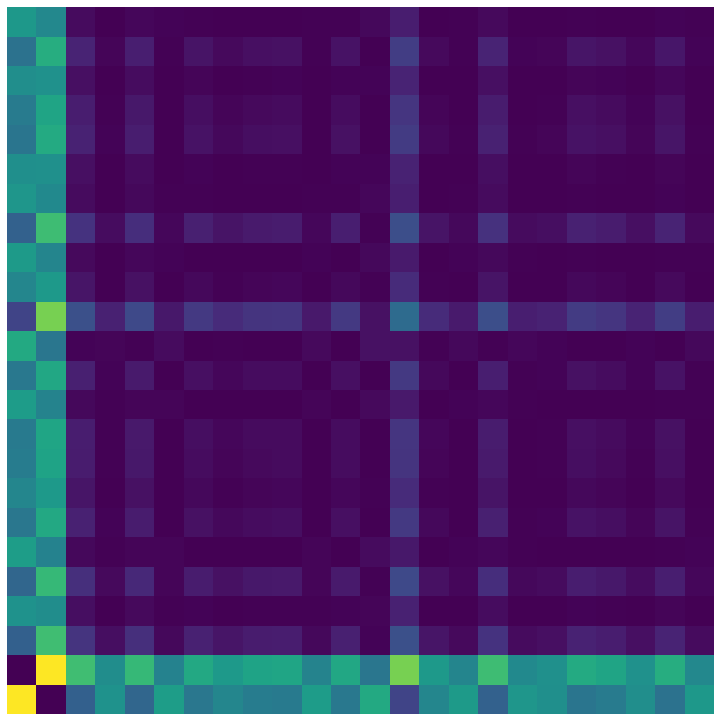

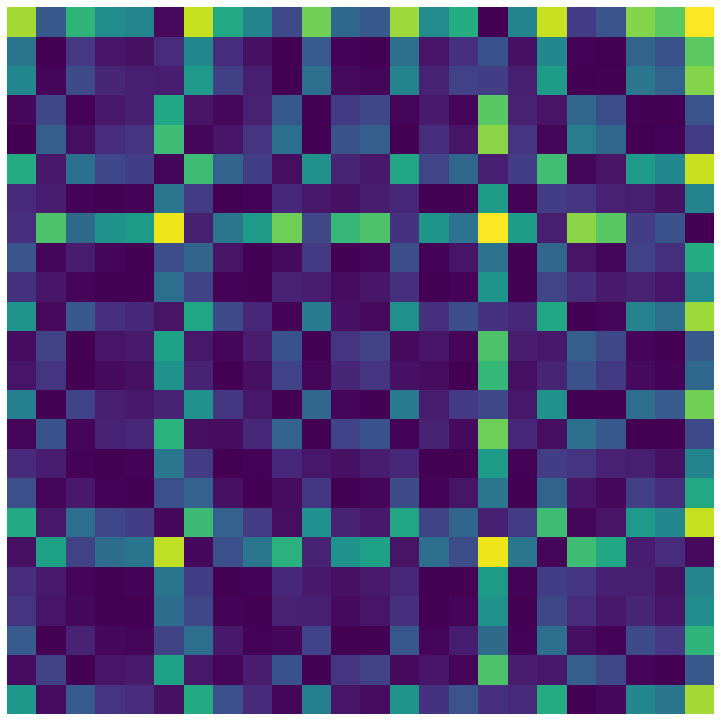

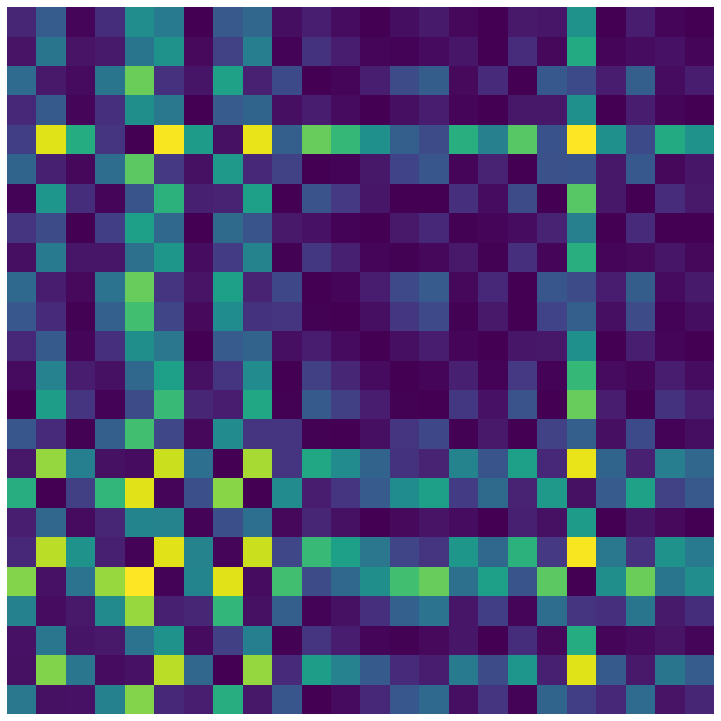

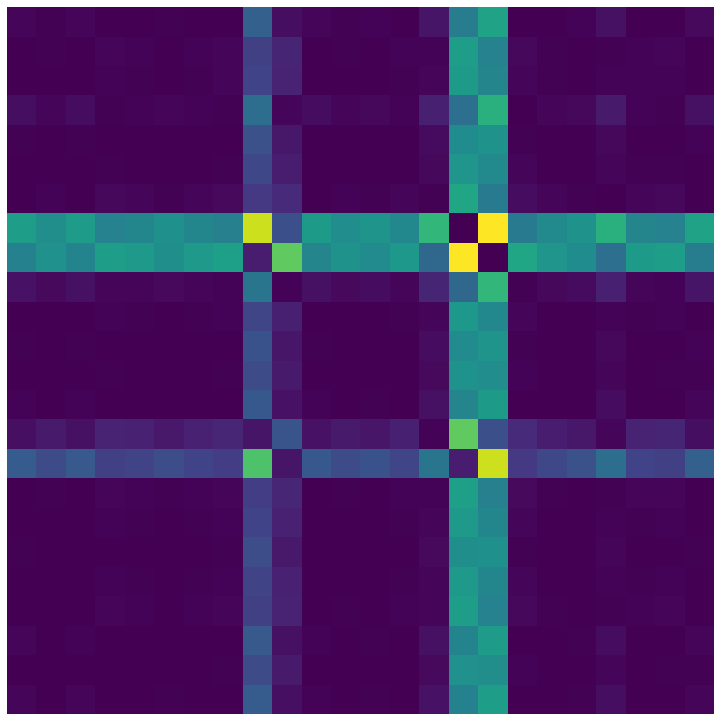

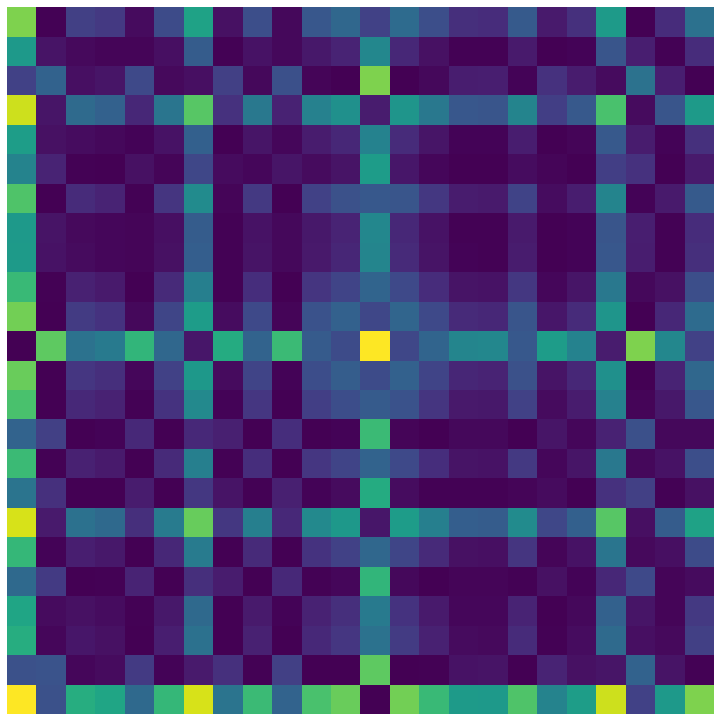

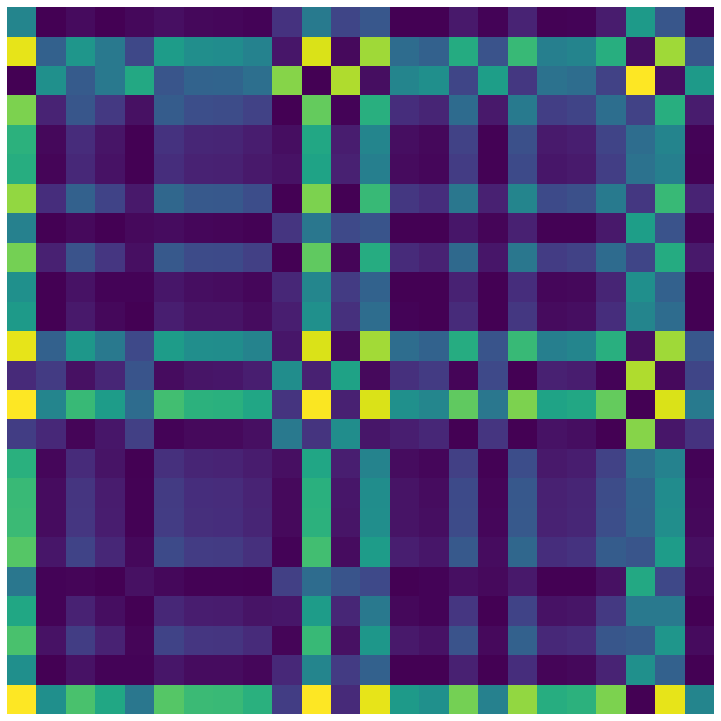

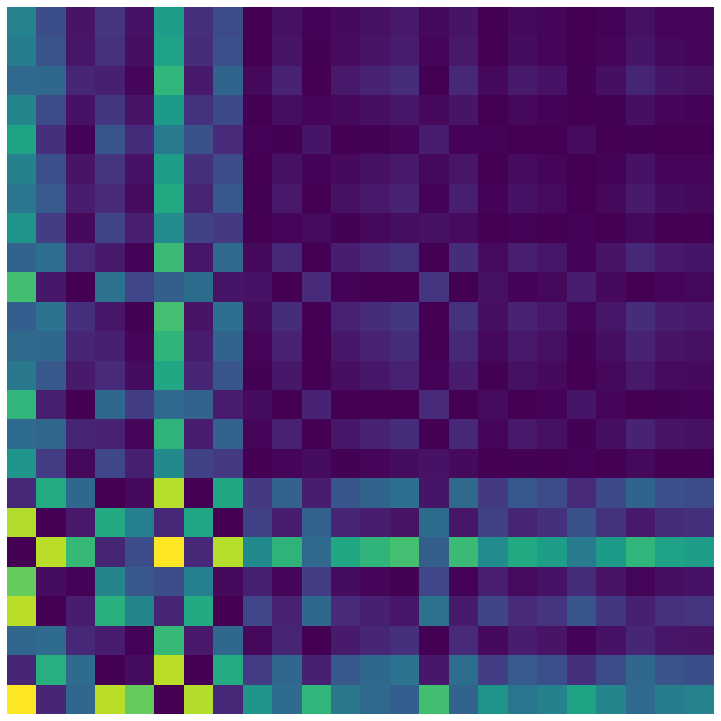

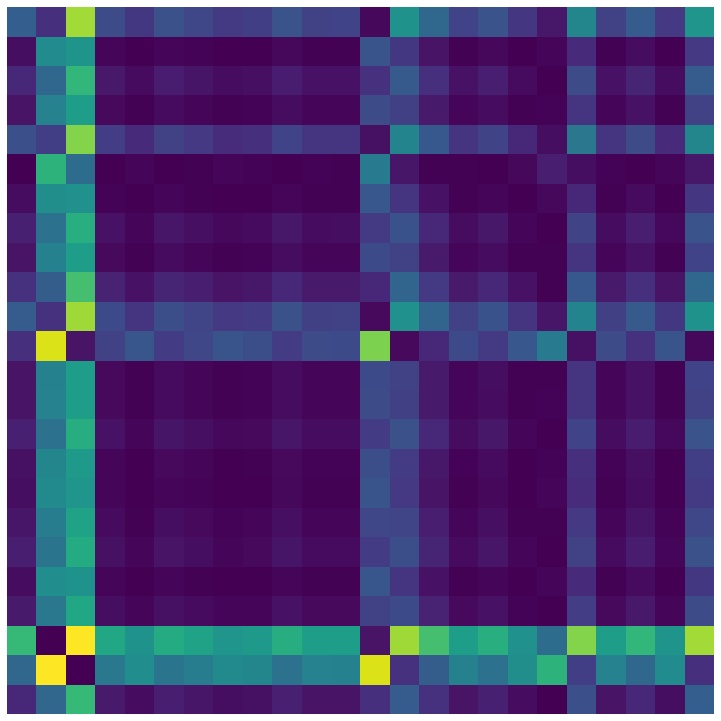

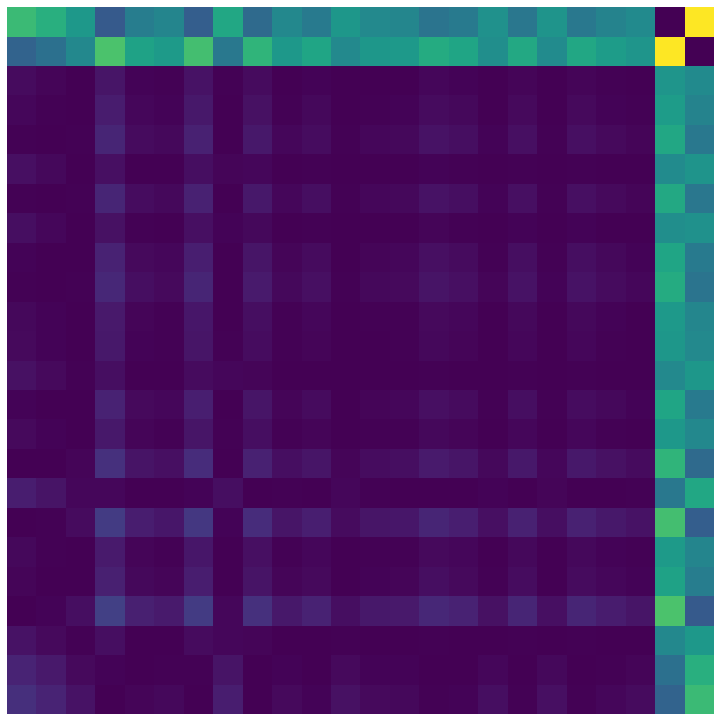

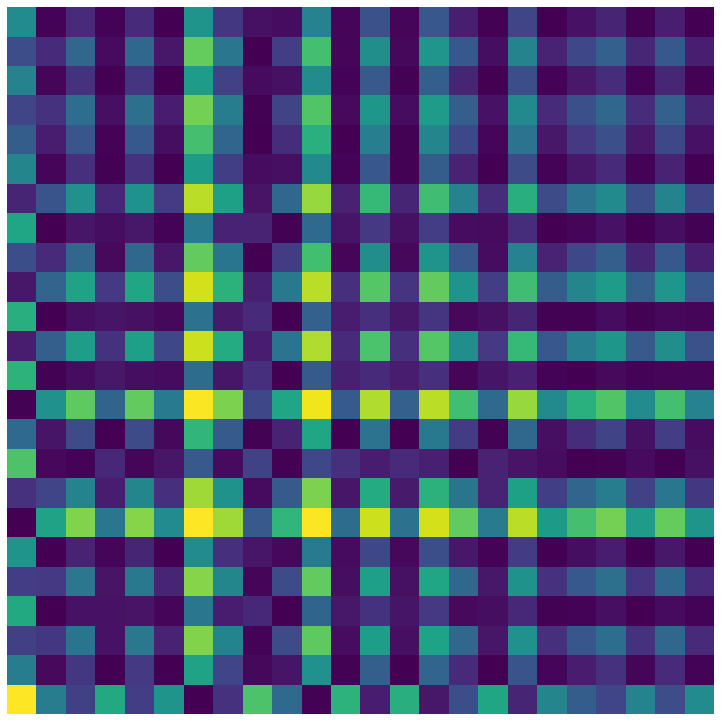

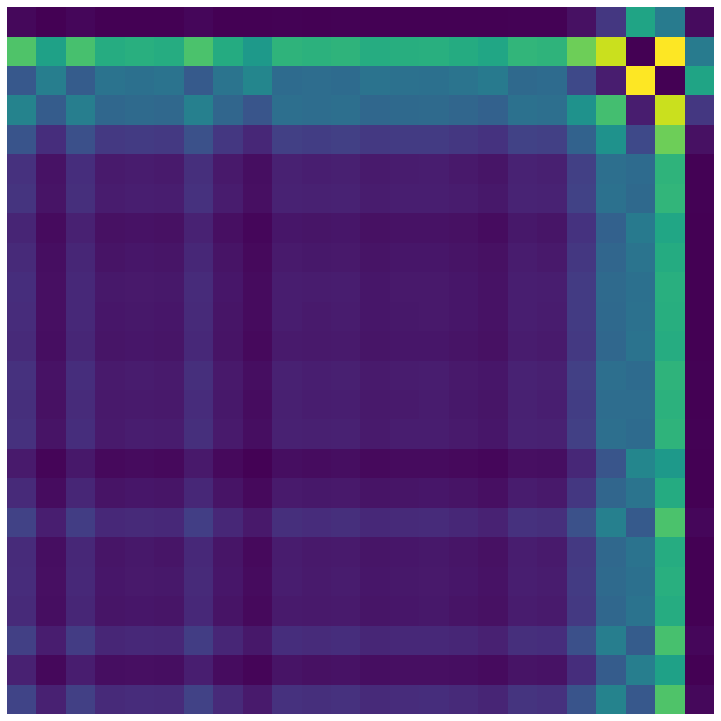

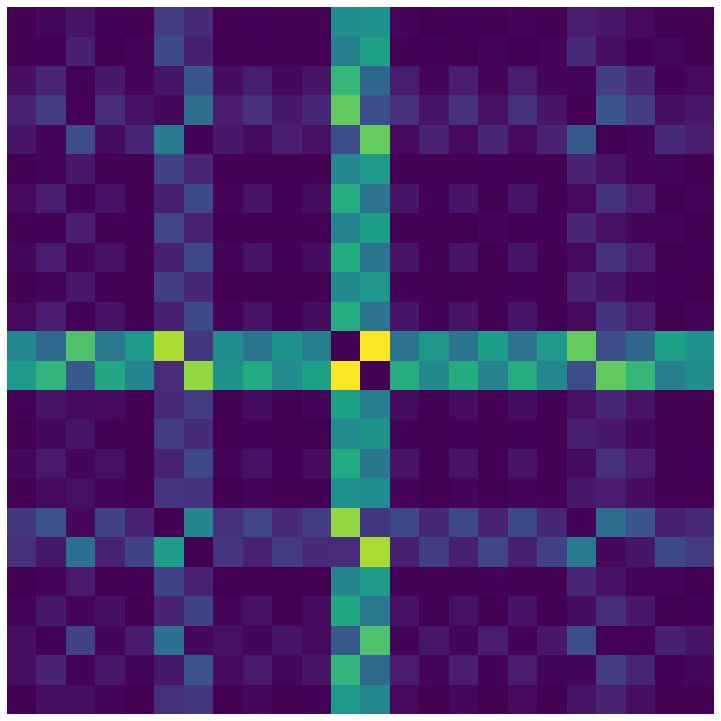

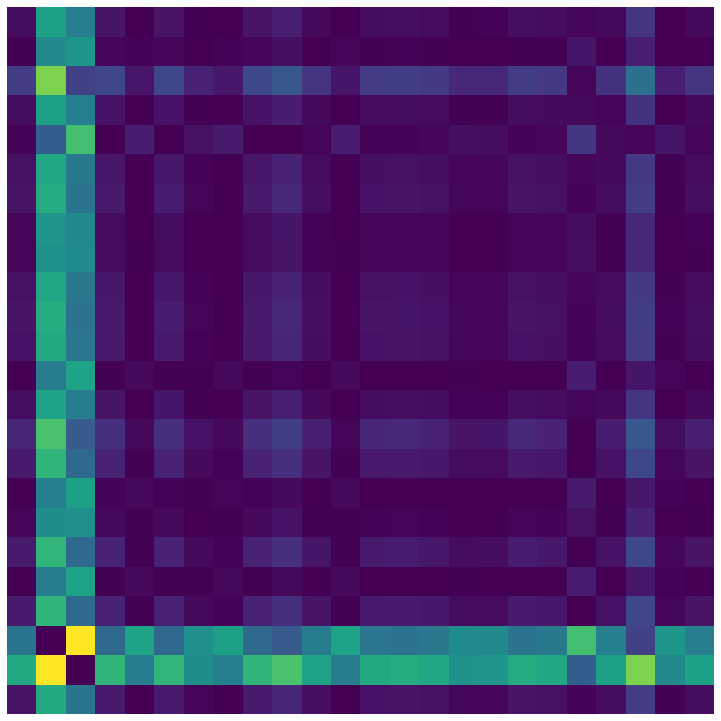

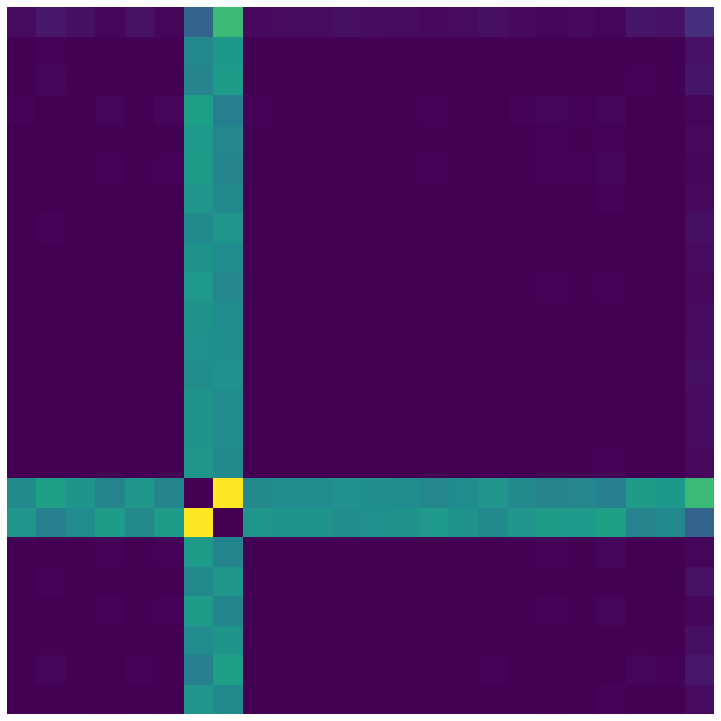

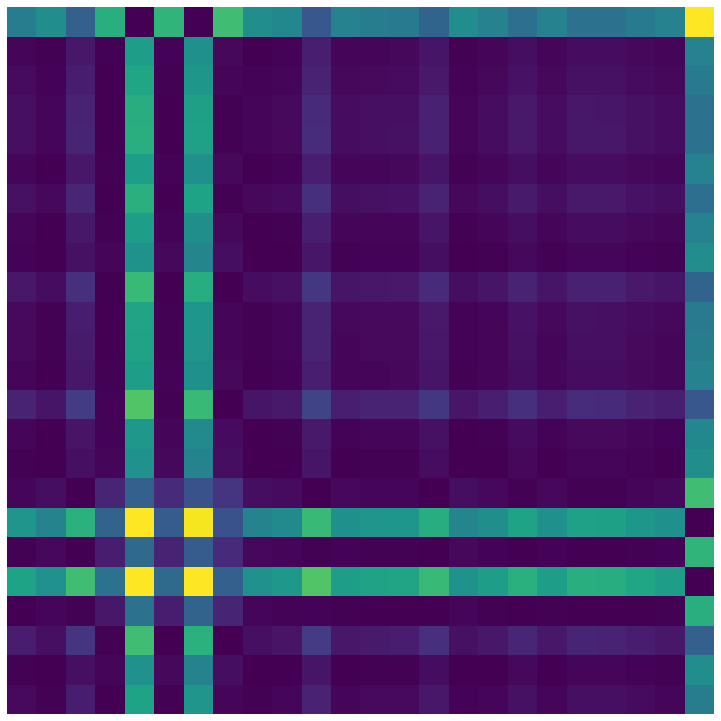

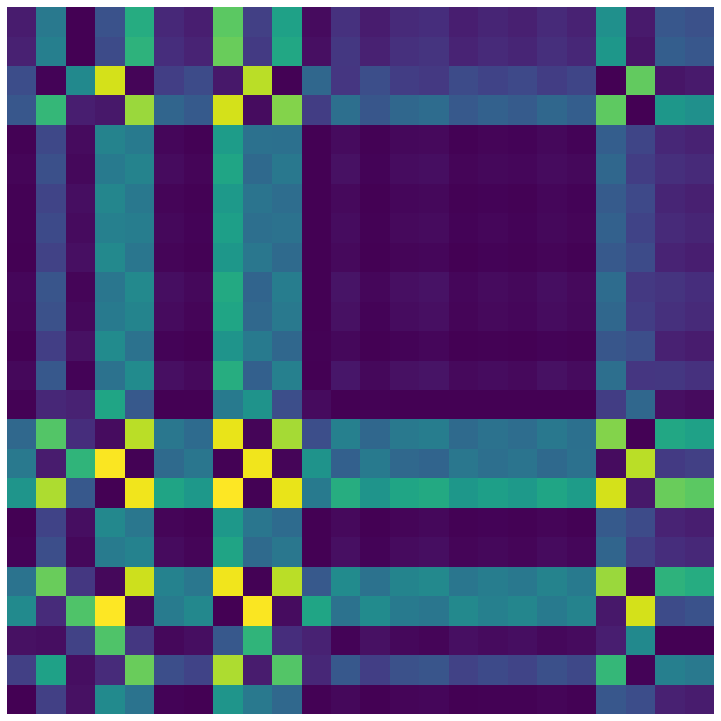

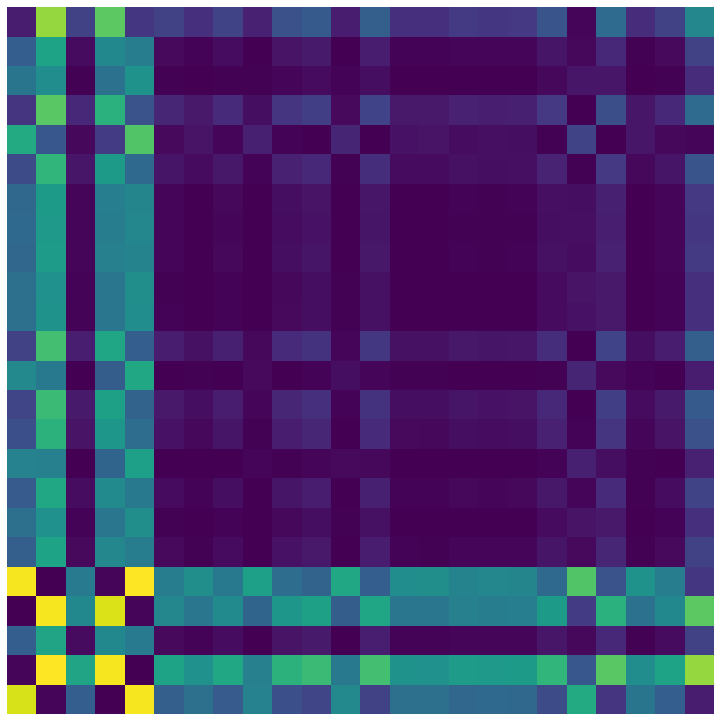

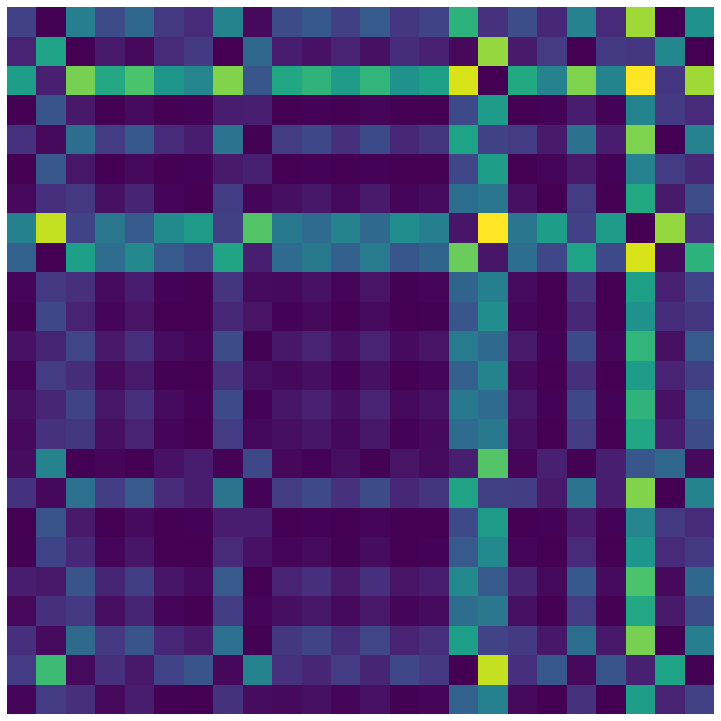

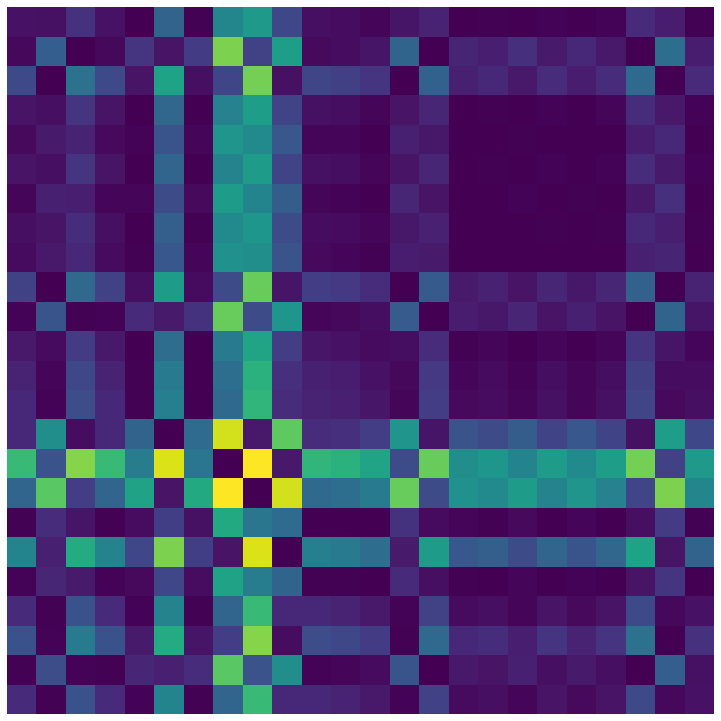

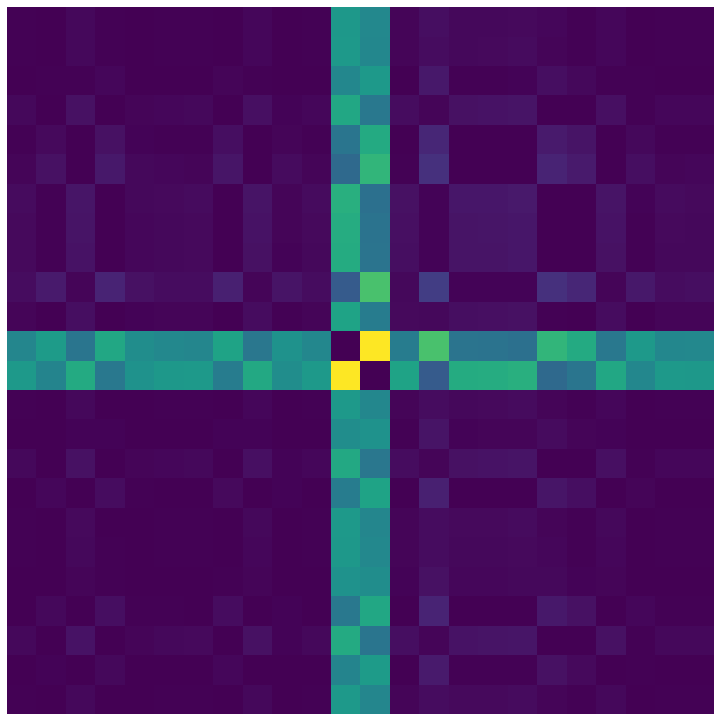

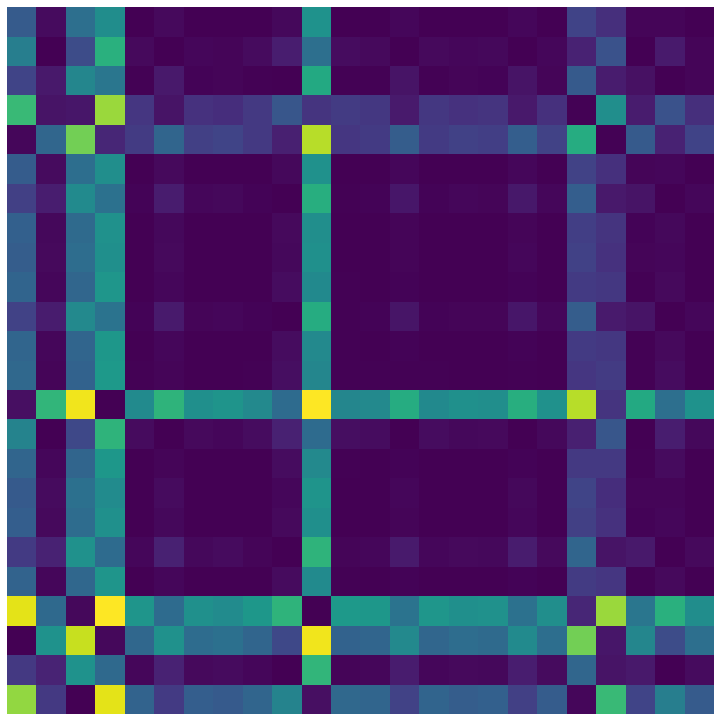

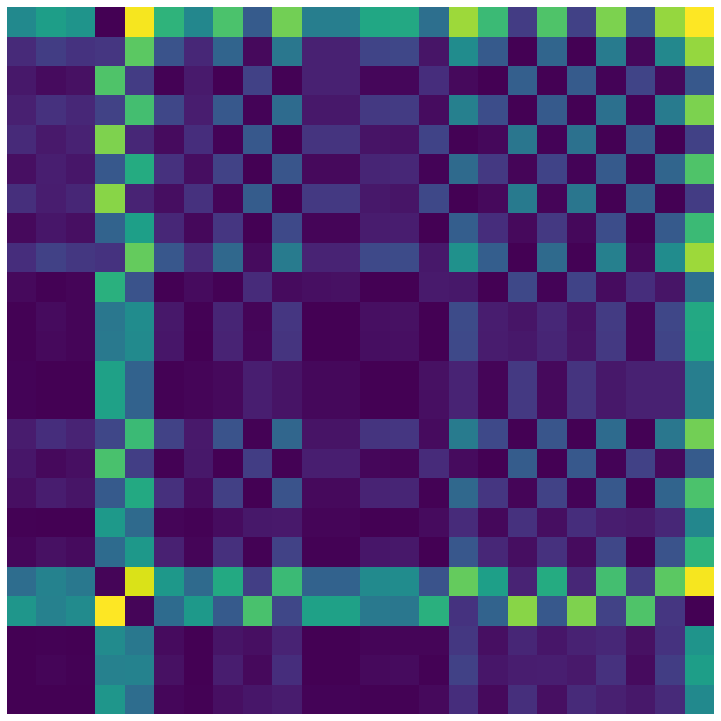

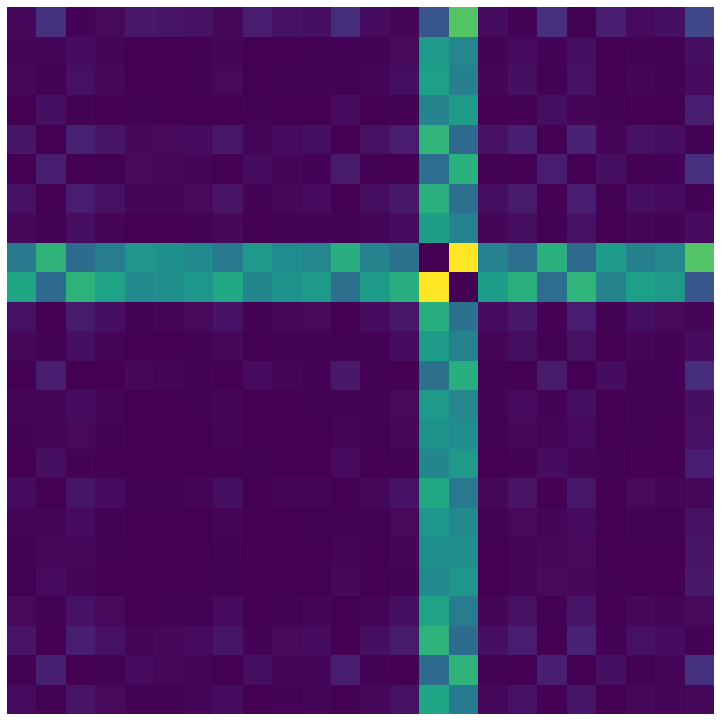

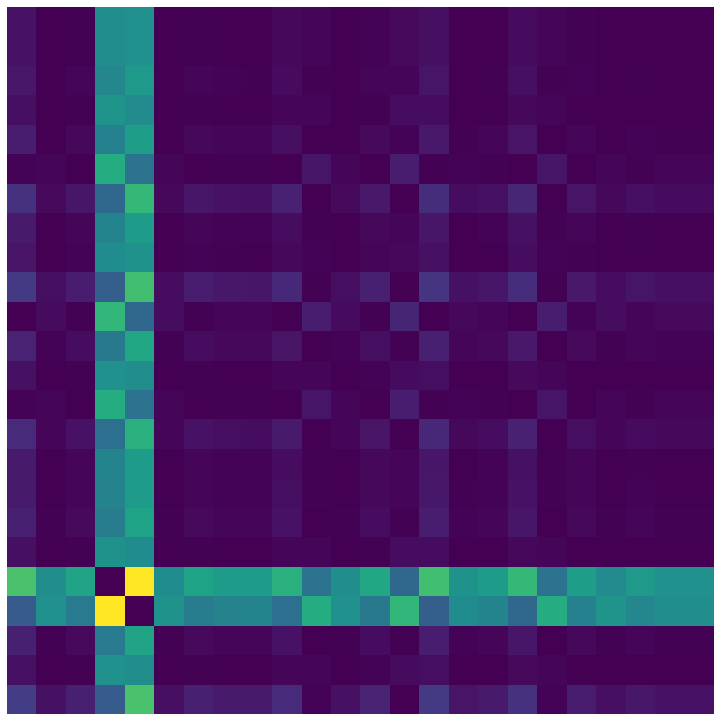

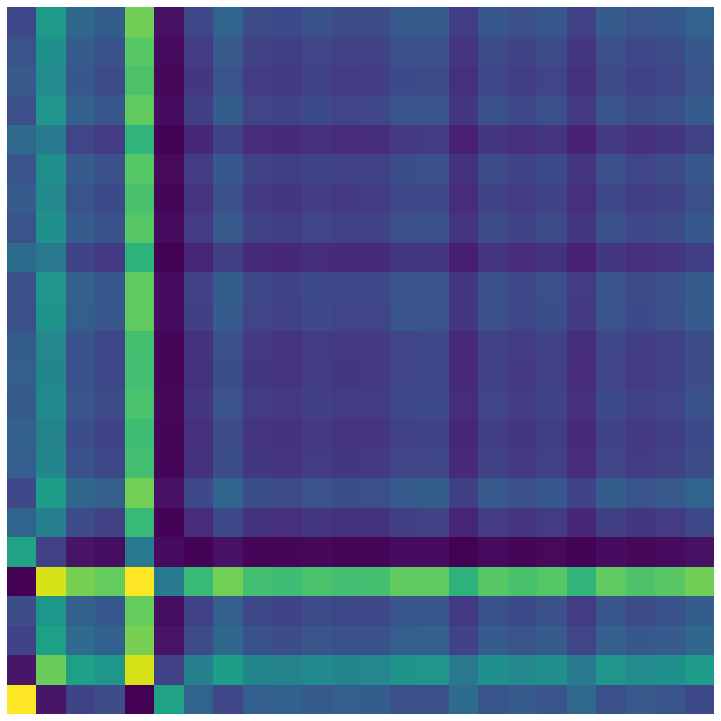

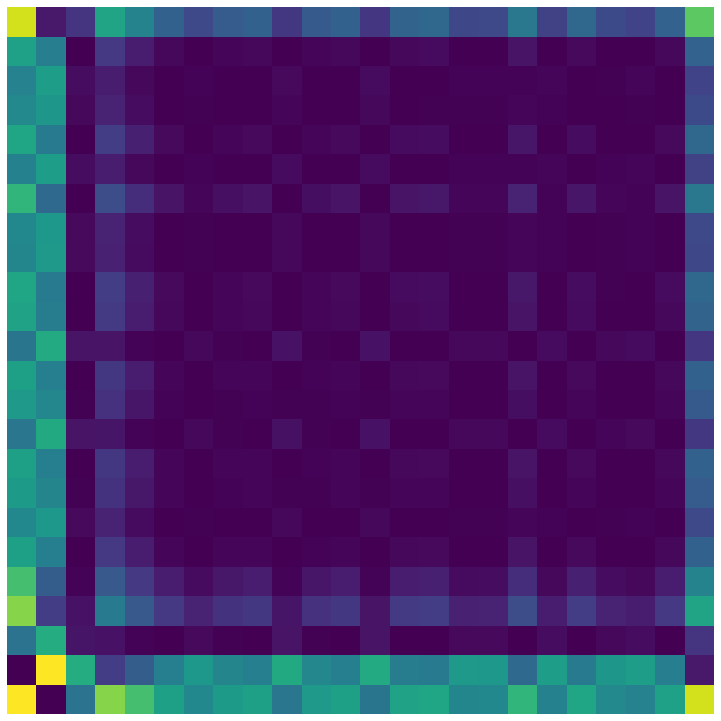

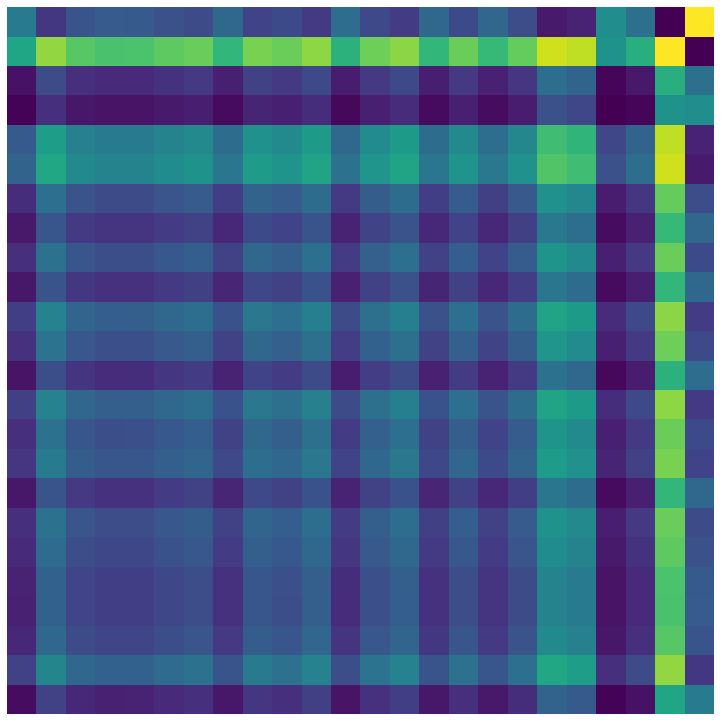

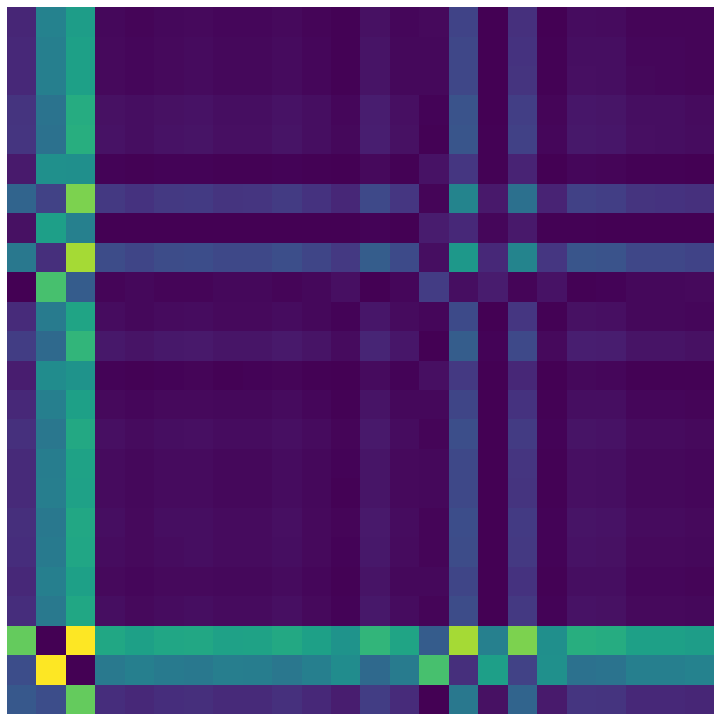

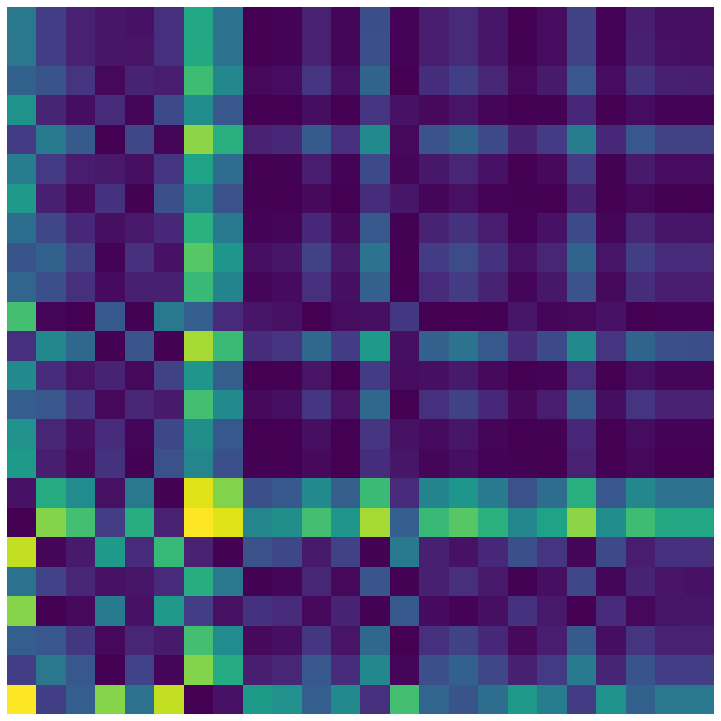

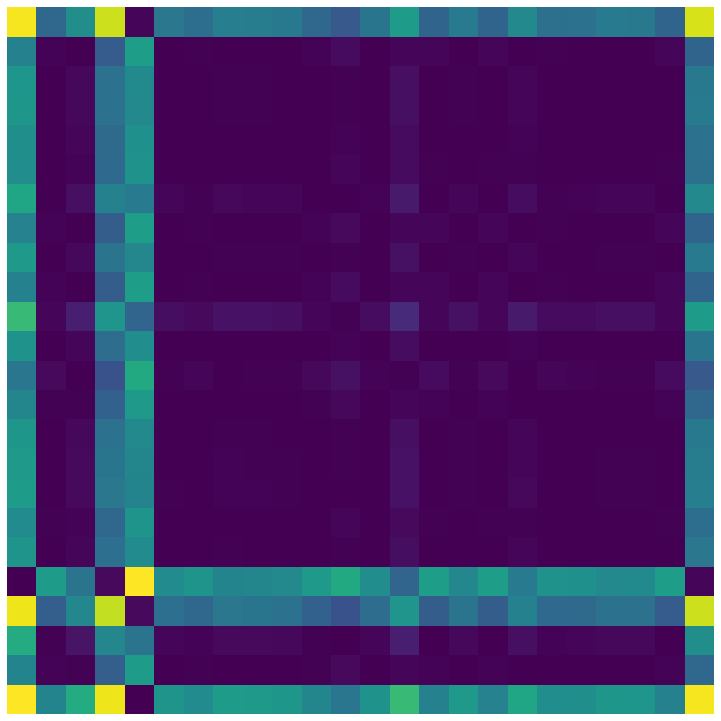

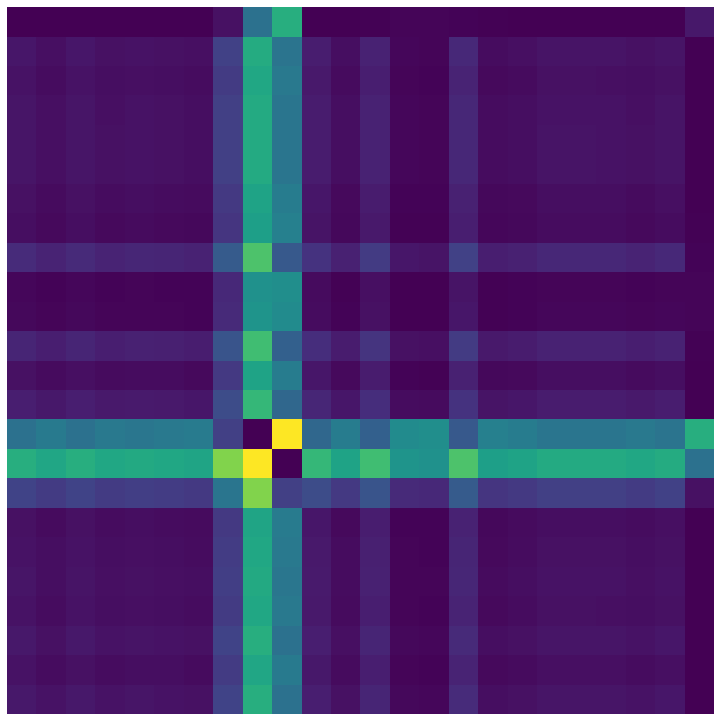

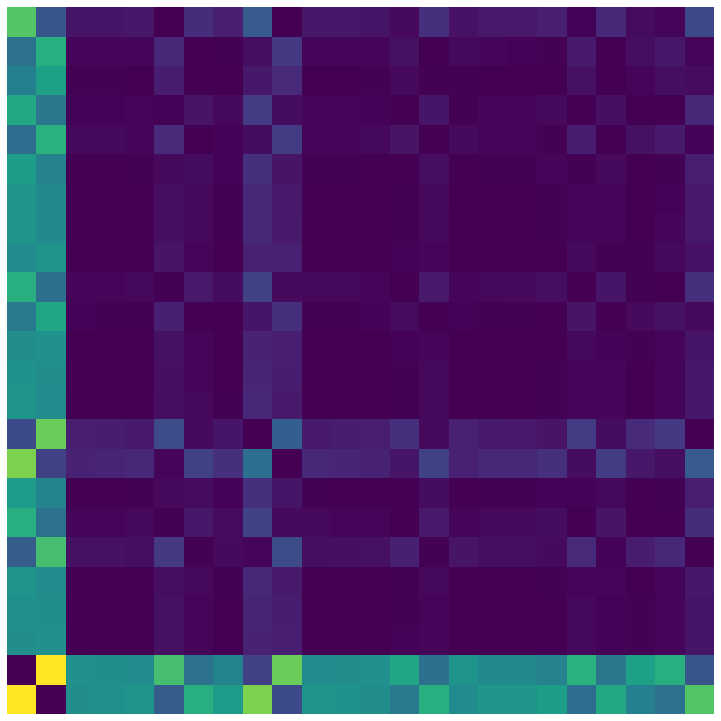

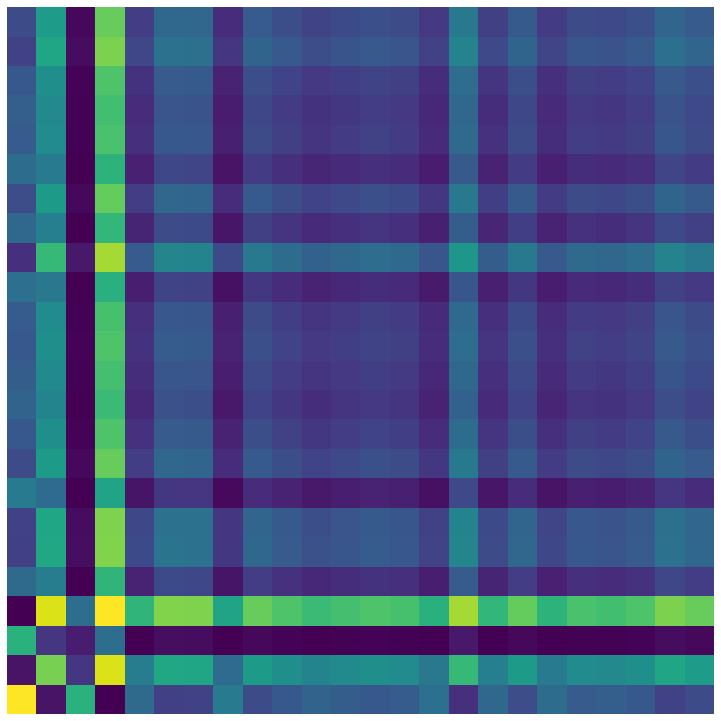

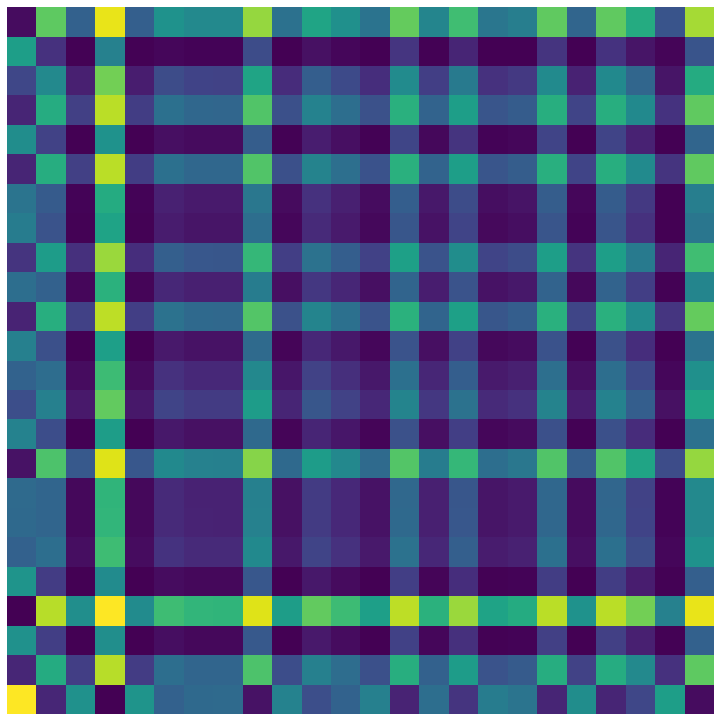

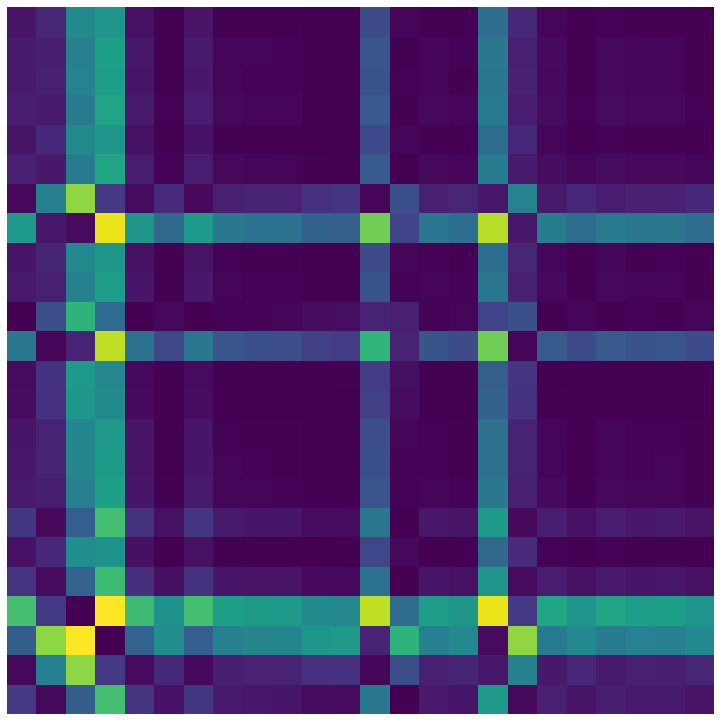

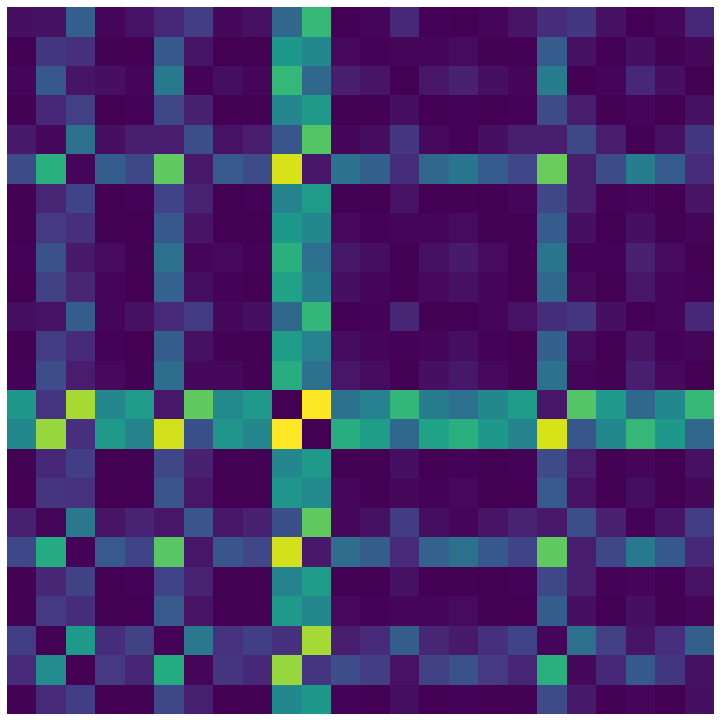

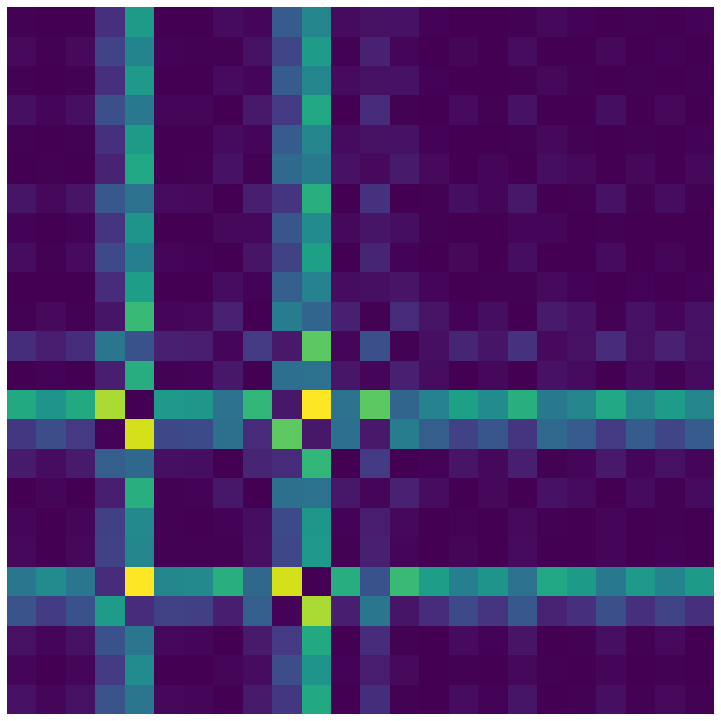

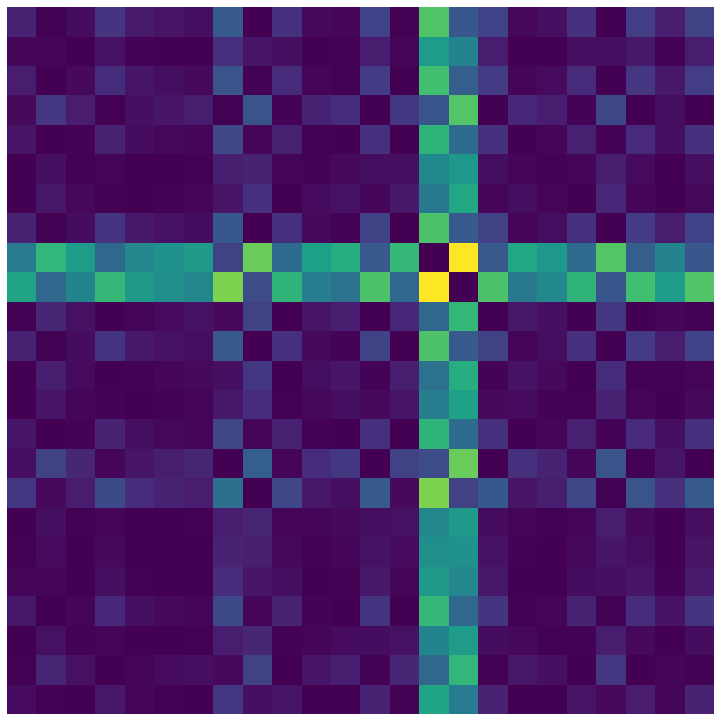

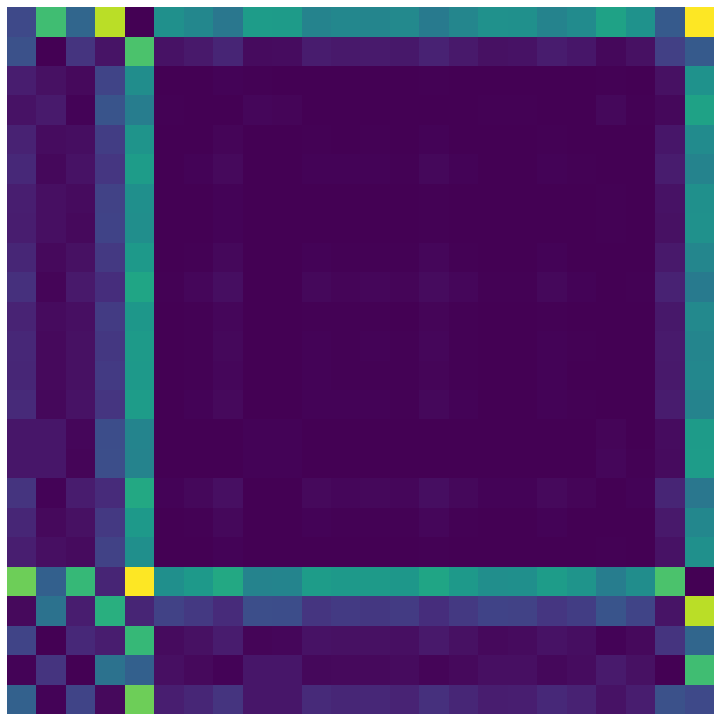

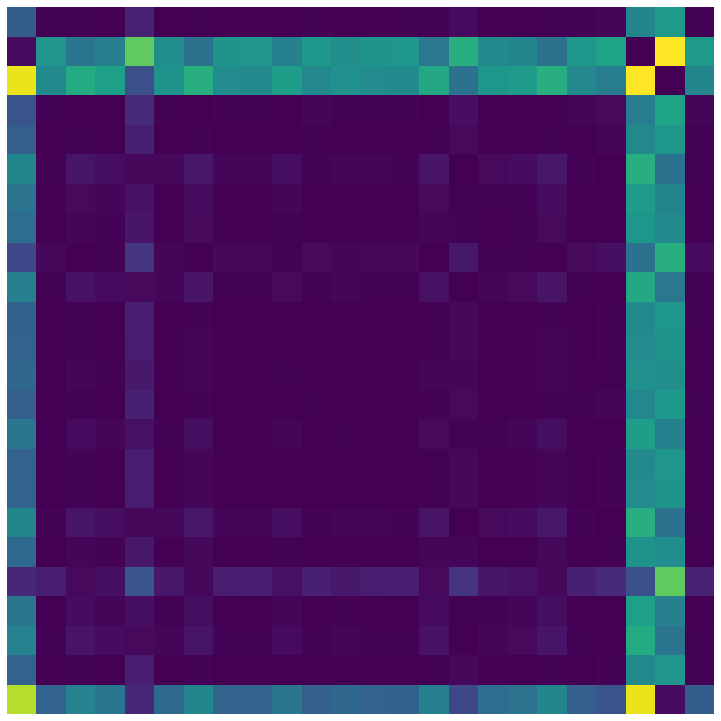

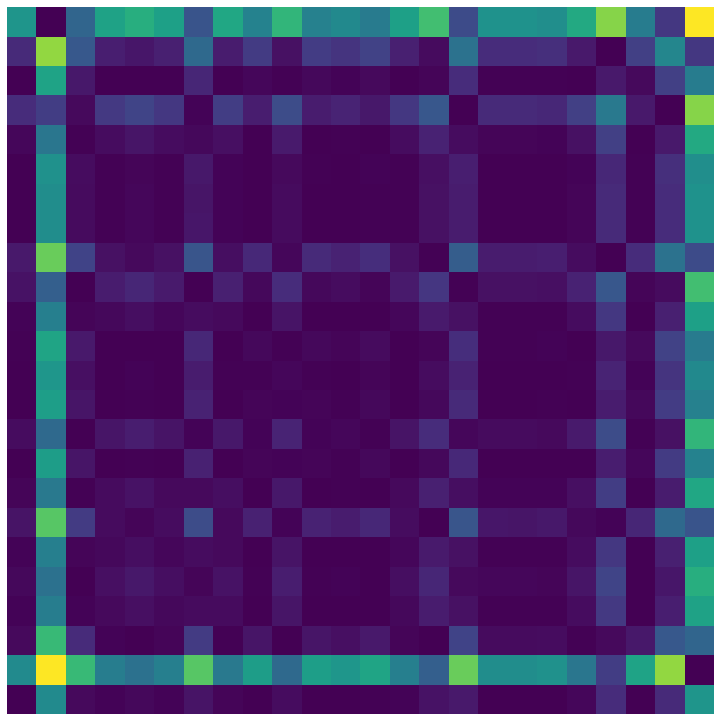

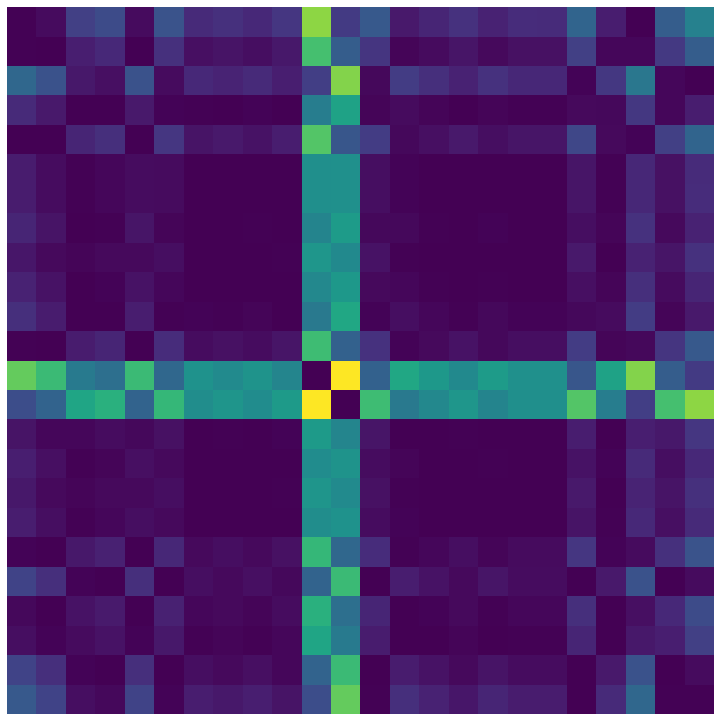

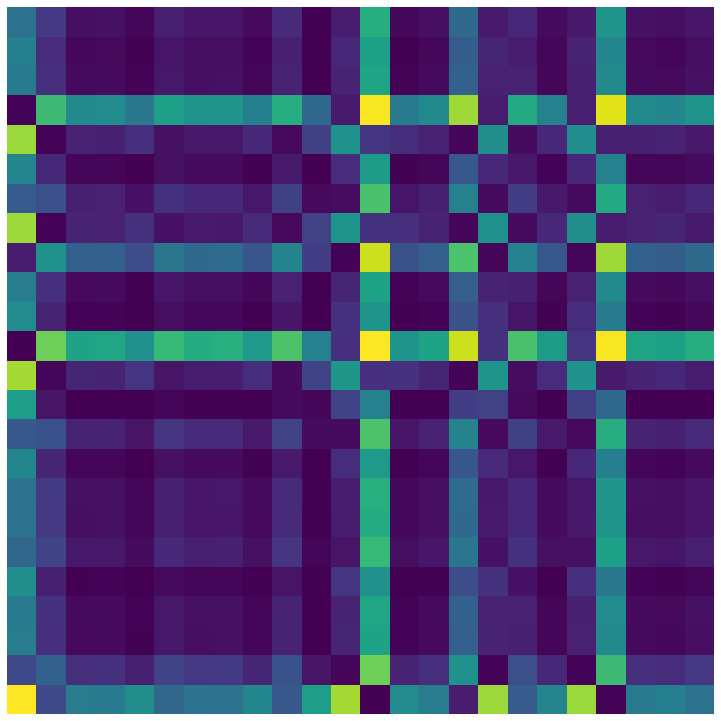

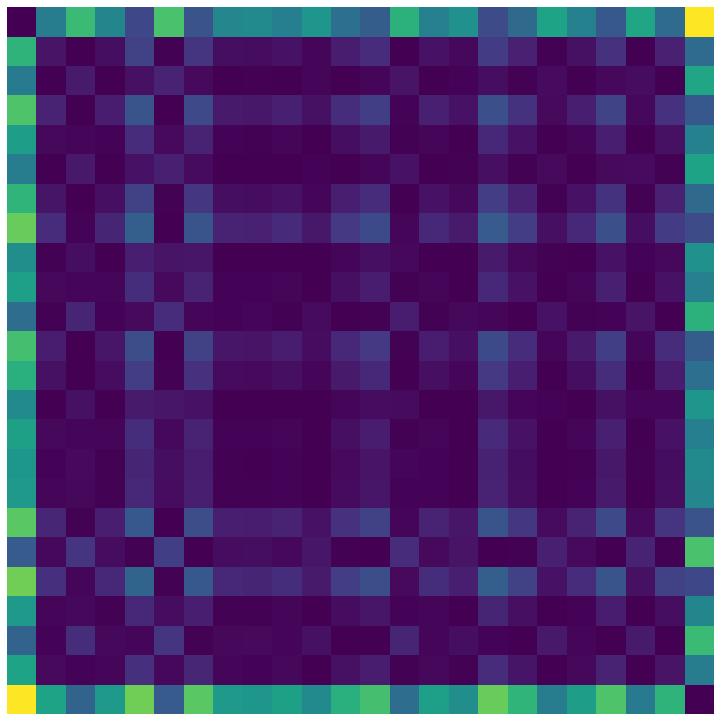

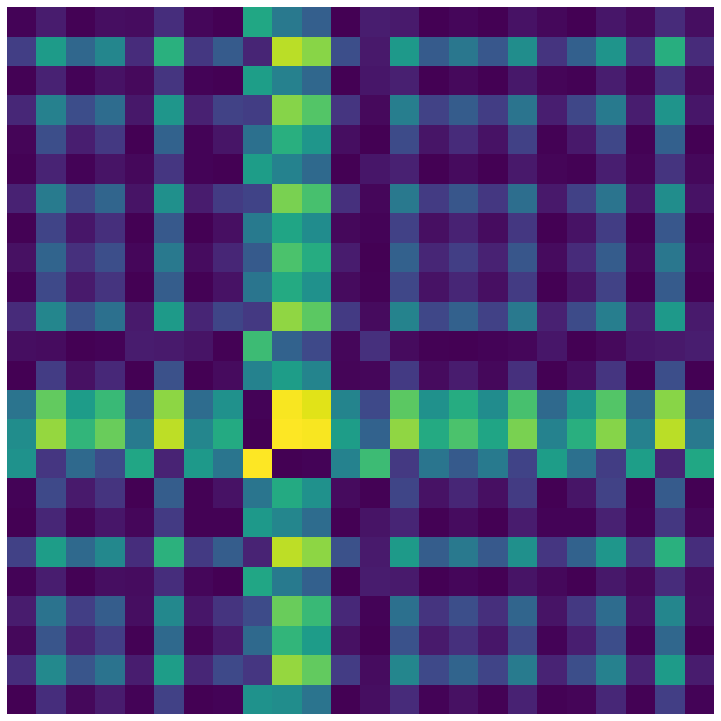

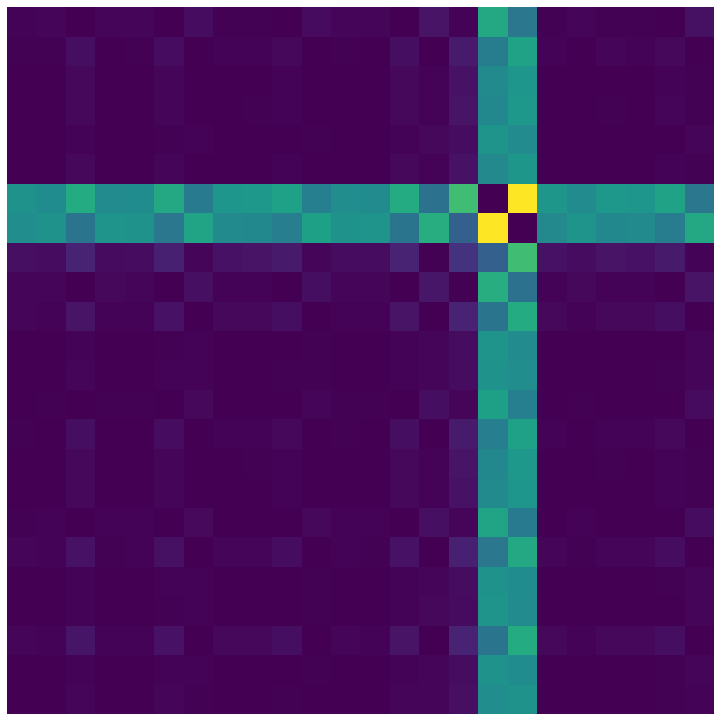

In [17]:
for s in range (10,33):
    subject=s
    path = '/media/tris/tris_files/DEAP_dataset/data_preprocessed_python/s'+str(subject)+'.dat'
    df = pickle.load(open(path, 'rb'), encoding='latin1')
    data=df['data']
    #labels=df['labels']
    #np.shape(data)
    for n in range (0,9): #trying to control the 01 vs 1 vs 10
    #for n in range (9,40):
        data_one_trial=data[n,:,:]
        # Transform the time series into Gramian Angular Fields
        gasf = GramianAngularField(image_size=24, method='summation')
        X_gasf = gasf.fit_transform(data_one_trial)
        #gadf = GramianAngularField(image_size=24, method='difference')
        #X_gadf = gadf.fit_transform(data_one_trial)


        w = 10
        h = 10
        fig = plt.figure(figsize=(20, 13))
        columns = 1
        rows = 1



        # ax enables access to manipulate each of subplots
        ax = []

        for i in range(columns*rows):
            img = X_gasf[1]
            # create subplot and append to ax
            ax.append( fig.add_subplot(rows, columns, i+1) )
            #ax[-1].set_title("ax:"+str(i))  # set title
            plt.imshow(img, cmap='viridis', origin='lower') #binary_r
            plt.axis('off')
        plt.subplots_adjust(wspace=0, hspace=-.06)
        plt.savefig('GAF-cmap-single/s'+str(subject)+'_t0'+str(n+1)+'.png', bbox_inches='tight')
        #plt.show()  # finally, render the plot

    #for n in range (0,9): #trying to control the 01 vs 1 vs 10
    for n in range (9,40):
        data_one_trial=data[n,:,:]
        # Transform the time series into Gramian Angular Fields
        gasf = GramianAngularField(image_size=24, method='summation')
        X_gasf = gasf.fit_transform(data_one_trial)
        #gadf = GramianAngularField(image_size=24, method='difference')
        #X_gadf = gadf.fit_transform(data_one_trial)


        w = 10
        h = 10
        fig = plt.figure(figsize=(20, 13))
        columns = 1
        rows = 1



        # ax enables access to manipulate each of subplots
        ax = []

        for i in range(columns*rows):
            img = X_gasf[1]
            # create subplot and append to ax
            ax.append( fig.add_subplot(rows, columns, i+1) )
            #ax[-1].set_title("ax:"+str(i))  # set title
            plt.imshow(img, cmap='viridis', origin='lower') #binary_r
            plt.axis('off')
        plt.subplots_adjust(wspace=0, hspace=-.06)
        plt.savefig('GAF-cmap-single/s'+str(subject)+'_t'+str(n+1)+'.png', bbox_inches='tight')
        #plt.show()  # finally, render the plot

![I know its a nested loop](https://media.giphy.com/media/N2rLxtwaU9rBC/giphy.gif "yes a nested loop")

# END